#**Final Report**






La industria aérea es altamente competitiva, donde la experiencia del cliente juega un rol central en la retención y fidelización. United Airlines enfrenta importantes desafíos para destacar frente a sus competidores, especialmente en áreas relacionadas con la percepción de valor y satisfacción general. Este análisis tiene como objetivo identificar segmentos de clientes, detectar factores críticos que impactan la experiencia y desarrollar estrategias basadas en datos para mejorar la posición competitiva de United.

Para lograrlo, se utilizó un enfoque combinado de:

1. Análisis de sentimientos basado en reseñas y analisis de topicos
2. Segmentación de clientes mediante clustering.
3. Creación de un modelo predictivo para determinar los factores que afectan la recomendación del servicio.

Este tramo solo proporciona una visión detallada de las fortalezas y debilidades de United, sino que también establece una hoja de ruta para mejorar su desempeño y percepción entre los clientes.


## Carga y Preprocesamiento de Datos

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Instalar nltk
!pip install --quiet nltk

# Importar y descargar recursos necesarios
import nltk
nltk.download('vader_lexicon')  # Para análisis de sentimientos
nltk.download('punkt')          # Para tokenización
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn.functional import softmax
from tqdm import tqdm


# Cargar el modelo BERT especializado para análisis de sentimientos
from transformers import AutoTokenizer, AutoModelForSequenceClassification

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataframe_original = pd.read_csv('/content/balanced_airline_reviews.csv')
dataframe_original.shape

(17564, 35)

1. Selección del Tipo de Modelo

Modelos Desarrollados:

Se han desarrollado varios modelos para abordar diferentes aspectos del problema:


1. Análisis de Sentimientos

2. Clasificación binaria: Regresión Logística y Random Forest para predecir si un cliente recomendaría o no el servicio de United Airways. Este modelo es ideal para optimizar estrategias de marketing y mejorar la experiencia del cliente.

3. Segmentación de Clientes: Clustering mediante K-Means para identificar segmentos de usuarios según sus preferencias y experiencias.

Cada modelo cumple un propósito específico para enriquecer la visión integral de los datos y tomar decisiones estratégicas.

# Análisis de sentimientos

**Análisis de Sentimientos con VADER**

El objetivo de esta sección es analizar las opiniones de los pasajeros para entender la percepción general del servicio de la aerolínea. Usamos el modelo VADER (Valence Aware Dictionary and sEntiment Reasoner), una herramienta para el análisis de sentimientos en textos cortos como reseñas.

Cálculo de Polaridad
Cada reseña se evalúa en función de su tono (positivo, negativo o neutral). Esto se logra mediante un puntaje de polaridad compuesto que resume la actitud general del texto y se agrega como una nueva columna en el dataset.

Clasificación de Polaridades
Se dividen las reseñas en tres categorías: Positiva, Neutral y Negativa, con base en el puntaje de polaridad. Esto permite entender la distribución general de las opiniones y su relación con otras métricas como la recomendación del servicio.

En un primer momento, se prueba con pocos datos por temas de procesamiento de la computadora.

In [ ]:
small_sample = dataframe_original.sample(n=100, random_state=42)
small_sample['recommended'].value_counts()

recommended
0    57
1    43
Name: count, dtype: int64

In [ ]:
def classify_polarity(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
# Descargar recursos de NLTK necesarios
nltk.download('vader_lexicon')

# Inicializamos el analizador de sentimientos
sid = SentimentIntensityAnalyzer()

# Calcular puntajes de polaridad para cada reseña en la muestra
small_sample['vader_polarity'] = small_sample['customer_review'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

small_sample['vader_sentiment'] = small_sample['vader_polarity'].apply(classify_polarity)
small_sample[['customer_review', 'vader_sentiment']].head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


customer_review vader_sentiment
5762    Los Angeles to Charlotte. Unreliable with a p...        Negative
5620    Providence to Tampa. Flight out of Tampa was ...        Negative
5174    Honolulu to San Diego August 23, 2018 I was f...        Positive
3692    Houston to Frankfurt. I was a frequent flyer ...        Negative
16742  5/28/15 PVD-ATL-CAE 6/1/15 CAE-ATL-PVD. Flight...        Negative

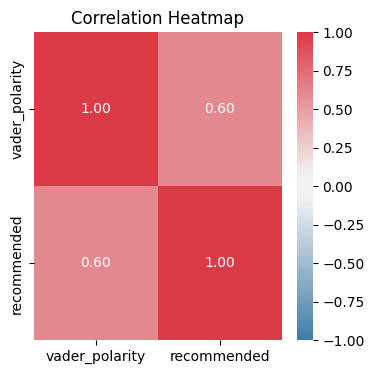

In [ ]:
corr_values = small_sample[['vader_polarity','recommended']].dropna(axis=0,how='any').corr()

plt.figure(figsize=(4, 4))
cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(corr_values, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

La variable vader_polarity tiene una buena correlacion con la variable recommended, pero considero que este dato podria mejorar.

**Análisis de Sentimientos con BERT**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Definir la función para realizar inferencia
def bert_inference(df_sample):
    model.eval()
    predictions = []

    # Procesar en lotes (ajusta el tamaño según tu hardware)
    for i in tqdm(range(0, len(df_sample), 32), desc="Inferencia de Sentimientos BERT"):
        batch_reviews = df_sample['customer_review'].iloc[i:i+32].tolist()
        tokens = tokenizer(
            batch_reviews,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        # Realizar inferencia
        with torch.no_grad():
            outputs = model(**tokens)
            logits = outputs.logits  # Valores en bruto del modelo
            print("Logits:", logits)  # Ver logits para depuración

            probs = softmax(logits, dim=1)  # Convertir logits a probabilidades
            print("Probabilidades:", probs)  # Ver probabilidades

            batch_predictions = torch.argmax(probs, axis=1).numpy()
            predictions.extend(batch_predictions)

    return predictions

# Ejecutar la inferencia con la muestra pequeña
bert_predictions = bert_inference(small_sample)

# Mapear los resultados a etiquetas de sentimiento
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
small_sample['bert_sentiment'] = [sentiment_map[pred] for pred in bert_predictions]

small_sample[['customer_review', 'bert_sentiment']]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Inferencia de Sentimientos BERT:  25%|██▌       | 1/4 [00:03<00:10,  3.54s/it]

Logits: tensor([[ 2.1385,  0.0828, -2.2267],
        [ 0.8942,  0.5496, -1.4868],
        [ 0.3810,  0.3636, -0.7631],
        [ 2.9103, -0.4333, -2.5179],
        [ 0.1099,  0.1720, -0.2191],
        [ 3.1768, -0.5995, -2.6625],
        [ 0.3523,  0.8130, -1.1403],
        [ 0.9520,  0.4316, -1.3968],
        [-1.6438, -0.4404,  2.6727],
        [ 1.4705,  0.3901, -1.8980],
        [-0.4566,  0.1083,  0.4459],
        [-2.0986, -0.3987,  3.0857],
        [-2.2589,  1.4317,  1.0419],
        [-0.7888,  0.5112,  0.3007],
        [-1.9870, -0.1293,  2.5299],
        [-2.1507, -0.2199,  2.8138],
        [ 1.5021,  0.0996, -1.7062],
        [-2.8859,  0.6689,  2.4686],
        [-2.3104, -0.3058,  3.2335],
        [ 2.8513, -0.4016, -2.5155],
        [-1.6387,  0.2094,  1.6750],
        [ 1.8026,  0.0528, -1.8798],
        [ 2.7753, -0.2501, -2.4692],
        [-2.0699,  0.1835,  2.0900],
        [ 2.1386, -0.1151, -1.9772],
        [-2.5711, -0.0489,  3.0672],
        [-1.3354, -0.1590,  1.

Inferencia de Sentimientos BERT:  50%|█████     | 2/4 [00:08<00:08,  4.28s/it]

Logits: tensor([[ 2.2366,  0.1432, -2.4047],
        [ 1.7248,  0.0536, -1.7802],
        [ 2.2466, -0.1031, -2.2061],
        [ 2.1307, -0.0439, -2.1539],
        [-1.4325, -0.2046,  2.0229],
        [-2.0055, -0.5059,  3.1340],
        [ 1.9555, -0.0312, -1.9575],
        [-2.2781, -0.2392,  3.0727],
        [ 1.9697, -0.0397, -2.0467],
        [ 1.0765,  0.5481, -1.6300],
        [ 0.2730,  0.1489, -0.3180],
        [ 3.2829, -0.5786, -2.7181],
        [-2.1983, -0.6884,  3.6403],
        [-1.7550,  0.0894,  1.9893],
        [ 2.4562, -0.0690, -2.4272],
        [-1.3628, -0.0971,  1.8253],
        [ 3.3056, -0.6412, -2.6798],
        [ 0.9601,  0.2600, -1.2445],
        [ 0.9030,  0.7279, -1.6578],
        [-2.4329, -0.1256,  3.1448],
        [ 0.7856,  0.0092, -0.6659],
        [ 2.5661, -0.1636, -2.4829],
        [ 1.6331,  0.4051, -2.0848],
        [ 0.9150,  0.1883, -1.1326],
        [-1.7594,  0.1786,  1.8657],
        [ 3.2565, -0.6611, -2.7028],
        [-0.8626,  0.2513,  0.

Inferencia de Sentimientos BERT:  75%|███████▌  | 3/4 [00:13<00:04,  4.91s/it]

Logits: tensor([[-1.3889, -0.0924,  1.7508],
        [-0.8759,  0.0574,  1.1547],
        [-2.0807, -0.3146,  2.9463],
        [ 2.6866, -0.1437, -2.5520],
        [ 1.9535, -0.0665, -1.9157],
        [ 1.9674,  0.1621, -2.1756],
        [-2.3542, -0.3929,  3.3632],
        [-1.9264, -0.5400,  3.0921],
        [ 2.5021, -0.1978, -2.3637],
        [-2.5852, -0.1575,  3.3062],
        [ 0.5293,  0.1101, -0.6452],
        [-2.4170, -0.2540,  3.3005],
        [ 0.7964,  0.1011, -0.8278],
        [-2.6232, -0.2256,  3.5755],
        [-0.4343, -0.1500,  0.7716],
        [ 0.9280,  0.2504, -1.1743],
        [ 3.2063, -0.5671, -2.6586],
        [ 0.8362,  0.5873, -1.4159],
        [-0.6144,  0.4747,  0.2081],
        [ 2.4039, -0.1305, -2.2312],
        [ 0.8466,  0.4184, -1.3001],
        [-0.2095,  0.2655,  0.0291],
        [-2.6740,  0.1291,  2.9965],
        [-2.9827, -0.0488,  3.5703],
        [ 2.0692,  0.0873, -2.1601],
        [ 2.5188, -0.2123, -2.3395],
        [ 0.6656,  0.2495, -0.

Inferencia de Sentimientos BERT: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]

Logits: tensor([[ 1.6579,  0.1503, -1.9155],
        [ 2.0037,  0.0777, -2.0801],
        [ 1.2787,  0.4254, -1.7277],
        [-2.3220, -0.1043,  3.0015]])
Probabilidades: tensor([[0.8003, 0.1772, 0.0225],
        [0.8602, 0.1253, 0.0145],
        [0.6777, 0.2887, 0.0335],
        [0.0046, 0.0427, 0.9527]])


customer_review bert_sentiment
5762    Los Angeles to Charlotte. Unreliable with a p...       Negative
5620    Providence to Tampa. Flight out of Tampa was ...       Negative
5174    Honolulu to San Diego August 23, 2018 I was f...       Negative
3692    Houston to Frankfurt. I was a frequent flyer ...       Negative
16742  5/28/15 PVD-ATL-CAE 6/1/15 CAE-ATL-PVD. Flight...        Neutral
...                                                  ...            ...
4032   Flight 2326 from Lubbock to Atlanta got cancel...       Negative
3366   I feel that Spirit Airlines is in the business...       Negative
59      Terrible experience on my Spirit flight from ...       Negative
5758    First and absolute last time we will ever fly...       Negative
16091   Brussels to Los Angeles via Newark / Chicago....       Positive

[100 rows x 2 columns]

Tabla Comparativa de Categorías:
          Vader Sentiment  Bert Sentiment
Negative               43              59
Neutral                 3               7
Positive               54              34
_________________________________________________________________________________________



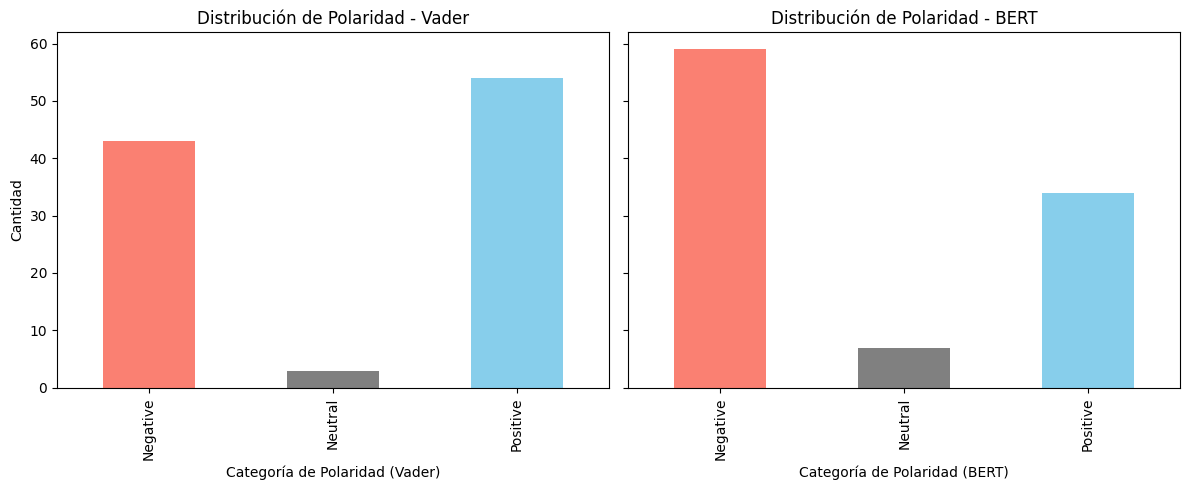

In [ ]:
# Calcular la cantidad de reseñas por cada categoría para Vader y Bert
category_counts_vader = small_sample['vader_sentiment'].value_counts()
category_counts_bert = small_sample['bert_sentiment'].value_counts()

# Crear una tabla combinada para comparar las cantidades
category_counts = pd.DataFrame({
    'Vader Sentiment': category_counts_vader,
    'Bert Sentiment': category_counts_bert
}).fillna(0)

# Mostrar la tabla combinada
print("Tabla Comparativa de Categorías:")
print(category_counts)


print ("_________________________________________________________________________________________\n")

# Definir colores consistentes para cada categoría
colors = {'Negative': 'salmon', 'Neutral': 'gray', 'Positive': 'skyblue'}

# Crear gráficos lado a lado para Vader y BERT
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Gráfico para Vader
small_sample['vader_sentiment'].value_counts().reindex(colors.keys()).plot(
    kind='bar', color=[colors[cat] for cat in colors.keys()], ax=axes[0]
)
axes[0].set_title('Distribución de Polaridad - Vader')
axes[0].set_xlabel('Categoría de Polaridad (Vader)')
axes[0].set_ylabel('Cantidad')

# Gráfico para BERT
small_sample['bert_sentiment'].value_counts().reindex(colors.keys()).plot(
    kind='bar', color=[colors[cat] for cat in colors.keys()], ax=axes[1]
)
axes[1].set_title('Distribución de Polaridad - BERT')
axes[1].set_xlabel('Categoría de Polaridad (BERT)')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

En el gráfico de VADER, se observa que la mayoría de las reseñas son clasificadas como positivas, seguidas de las negativas, mientras que las reseñas neutrales son mínimas. Mientras que en el grafico de BERT, se observa mas reseñas negativas que en el grafico de VADER. Ademas muestra mas datos neutrales, este comportamiento podría indicar que BERT, al ser un modelo más sofisticado, es capaz de identificar una gama más amplia de matices en las reseñas, lo que da lugar a un mayor número de clasificaciones neutrales.


Observaremos las filas donde las predicciones de Vader y Bert son diferentes



In [ ]:
differences = small_sample[small_sample['vader_sentiment'] != small_sample['bert_sentiment']]

# Mostrar las diferencias
print("Número de diferencias:", len(differences))
differences[['customer_review', 'vader_sentiment', 'bert_sentiment']]

Número de diferencias: 25


customer_review vader_sentiment  \
5174    Honolulu to San Diego August 23, 2018 I was f...        Positive   
16742  5/28/15 PVD-ATL-CAE 6/1/15 CAE-ATL-PVD. Flight...        Negative   
4755    Columbia to Tokyo via Denver. I checked into ...        Positive   
6087    I had a flight scheduled for Sept 5th 2017 fr...         Neutral   
2698    Weather may have been the initial cause of th...        Positive   
5001   SFO-SEA-SFO. A320 + B737/900. Late on departur...        Negative   
16484  When we were looking for a cheap flight, it wa...        Positive   
2954    Airlines like Delta don't actually care about...        Positive   
8064   We flew from Las Vegas to JFK New York on 23rd...        Positive   
15097  The United Airlines flight from Nashville to H...        Positive   
6503    Have heard the same variation of we can't, do...        Positive   
5163    Minneapolis to Charlotte. After experiencing ...        Positive   
5473    Miami to Newark. Travel with United Airlines ...        Positive   
8351    United Airlines is an absolute mess. I was su...        Positive   
6561   What a horrible product AA offers in the back ...         Neutral   
2414    Trenton to Raleigh Durham. My 16 year old dau...        Positive   
12729  Paid for 1st class GSO-ATL-LAS. Delta continue...        Positive   
13797  On April 20th we flew from HNL-LAX the flight ...        Positive   
4794   I was flying CVG-ORD-LHR. Had an onward very g...        Positive   
1027    New York to Mexico City via Orlando. 34 hrs t...        Positive   
10612  Returned last week from a ANC-SEA-ATL and retu...        Positive   
7918   The flight, when everything is working, is goo...        Positive   
5493    San Francisco to New York. I paid as much mon...         Neutral   
7844    Chicago to St Louis. Itâ€™s hard to believe t...        Positive   
5758    First and absolute last time we will ever fly...        Positive   

      bert_sentiment  
5174        Negative  
16742        Neutral  
4755         Neutral  
6087        Negative  
2698        Negative  
5001         Neutral  
16484        Neutral  
2954        Negative  
8064        Negative  
15097       Negative  
6503        Negative  
5163        Negative  
5473        Negative  
8351        Negative  
6561        Negative  
2414        Negative  
12729       Negative  
13797       Negative  
4794         Neutral  
1027        Negative  
10612        Neutral  
7918         Neutral  
5493        Negative  
7844        Negative  
5758        Negative

Este es uno de los casos donde hay una diferencia entre el analisis de sentimiento con VADER y BERT. Se puede observar  claramente que esta reseña es extremadamente negativa.



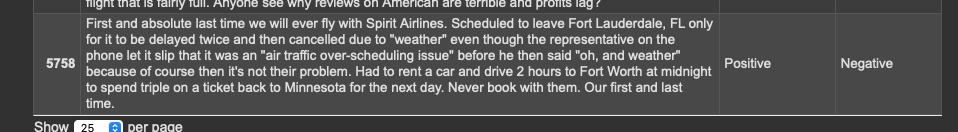



Revisé las 25 filas donde los resultados de vader_sentiment y bert_sentiment fueron diferentes. Después de analizar los casos, considero que de forma general el modelo de BERT es más preciso en la clasificación. Esto se debe a que BERT parece captar mejor los matices en las reseñas, especialmente cuando el sentimiento no es explícito o cuando hay una combinación de aspectos positivos y negativos en el texto. Aunque algunos resultados pueden ser discutibles, en la mayoría de los casos BERT ofrece una interpretación más alineada con el contenido de las reseñas.

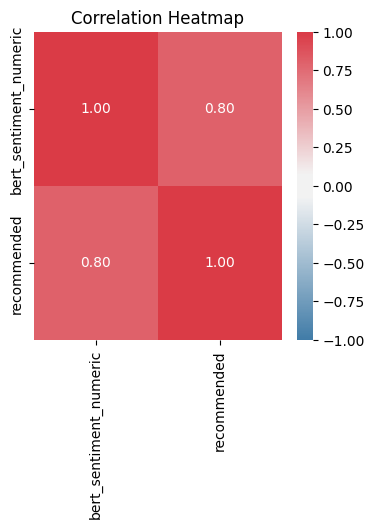

In [ ]:
small_sample['bert_sentiment_numeric'] = small_sample['bert_sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})
corr_values = small_sample[['bert_sentiment_numeric','recommended']].dropna(axis=0,how='any').corr()

plt.figure(figsize=(4, 4))
cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(corr_values, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

El gráfico muestra una correlación de 0.80 entre la variable de sentimiento de BERT y la variable objetivo recommended, lo que indica una fuerte relación positiva. Esto sugiere que el análisis de sentimientos con BERT está estrechamente relacionado con la recomendación del servicio.

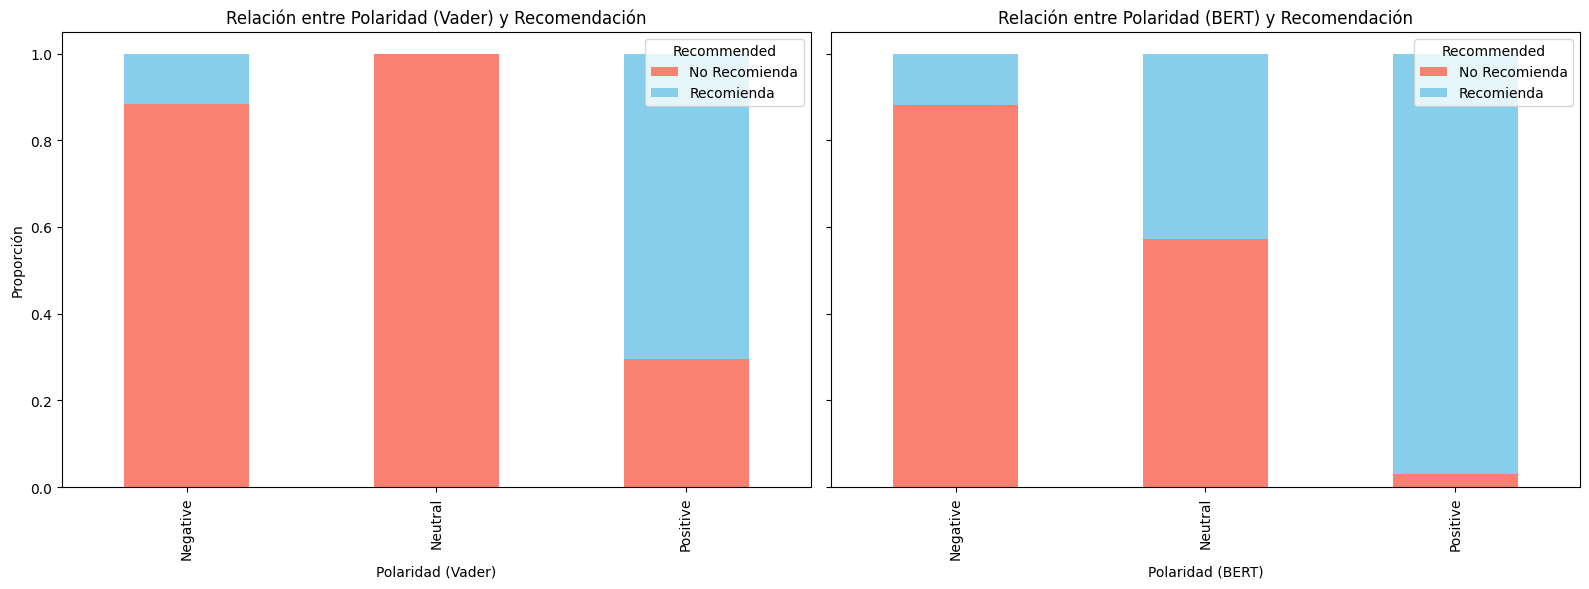

In [ ]:
# Crear gráficos lado a lado para la relación entre polaridad y recomendación
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Relación para Vader
relation_vader_recommended = pd.crosstab(
    small_sample['vader_sentiment'],
    small_sample['recommended'],
    normalize='index'
)
relation_vader_recommended.plot(kind='bar', stacked=True, ax=axes[0], color=['salmon', 'skyblue'])
axes[0].set_title('Relación entre Polaridad (Vader) y Recomendación')
axes[0].set_xlabel('Polaridad (Vader)')
axes[0].set_ylabel('Proporción')
axes[0].legend(['No Recomienda', 'Recomienda'], title='Recommended')

# Relación para BERT
relation_bert_recommended = pd.crosstab(
    small_sample['bert_sentiment'],
    small_sample['recommended'],
    normalize='index'
)
relation_bert_recommended.plot(kind='bar', stacked=True, ax=axes[1], color=['salmon', 'skyblue'])
axes[1].set_title('Relación entre Polaridad (BERT) y Recomendación')
axes[1].set_xlabel('Polaridad (BERT)')
axes[1].legend(['No Recomienda', 'Recomienda'], title='Recommended')

plt.tight_layout()
plt.show()

**Relación entre Polaridad y Recomendación**

El análisis de la relación entre la polaridad de las reseñas y la recomendación muestra diferencias clave entre VADER y BERT. VADER muestra una fuerte correlación entre reseñas negativas y la falta de recomendación, pero también clasifica todas las reseñas neutrales como "No Recomienda", lo que podría subestimar la polaridad negativa. Las reseñas positivas, aunque correlacionadas con la recomendación, no tienen una proporción tan alta en comparación con las negativas para "No Recomienda".

Por otro lado, BERT captura mejor los matices, mostrando una mayor proporción de reseñas positivas recomendando el servicio. Además, las reseñas neutrales tienen un balance más equitativo entre "Recomienda" y "No Recomienda", reflejando una interpretación más precisa de los tonos mixtos.

**Comparación General:**

Ambos modelos coinciden en que las reseñas negativas tienen un alto impacto en la falta de recomendación, pero BERT es más preciso al distinguir entre las categorías de polaridad y manejar reseñas neutrales. VADER, al sobreclasificar reseñas negativas como neutrales, puede no captar bien las emociones reales de los clientes.

Este análisis se repetirá utilizando una muestra de mayor tamaño. En mi caso, solo se realizó una única ejecución debido a las limitaciones de hardware, ya que mi equipo no cuenta con una GPU adecuada para procesar grandes volúmenes de datos de manera eficiente.

In [ ]:
df_sentiments = dataframe_original.copy()

In [ ]:
# Descargar recursos de NLTK necesarios
nltk.download('vader_lexicon')

# Inicializamos el analizador de sentimientos
sid = SentimentIntensityAnalyzer()

# Calcular puntajes de polaridad para cada reseña en el dataset
df_sentiments['vader_polarity'] = df_sentiments['customer_review'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
#llamar a la funcion "classify_polarity"
df_sentiments['vader_sentiment'] = df_sentiments['vader_polarity'].apply(classify_polarity)

df_sentiments[['customer_review', 'vader_sentiment']].head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


customer_review vader_sentiment
0   San Francisco to Indianapolis. I was on my la...        Positive
1   Austin to Kahului via San Francisco. Virgin A...        Negative
2   San Francisco to Nashville. Horrible customer...        Negative
3   Newark to San Francisco. I am trying to retur...        Negative
4   Chicago to Portland . Terrible customer servi...        Negative

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
from tqdm import tqdm

# Cargar el tokenizador y modelo preentrenado
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Definir la función para realizar inferencia
def bert_inference(df_sentiments):
    model.eval()
    predictions = []

   # Procesar en lotes (ajusta el tamaño según tu hardware)
    for i in tqdm(range(0, len(df_sentiments), 32), desc="Inferencia de Sentimientos BERT"):
        batch_reviews = df_sentiments['customer_review'].iloc[i:i+32].tolist()
        tokens = tokenizer(
            batch_reviews,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        # Realizar inferencia
        with torch.no_grad():
            outputs = model(**tokens)
            logits = outputs.logits  # Valores en bruto del modelo
            print("Logits:", logits)  # Ver logits para depuración

            probs = softmax(logits, dim=1)  # Convertir logits a probabilidades
            print("Probabilidades:", probs)  # Ver probabilidades

            batch_predictions = torch.argmax(probs, axis=1).numpy()
            predictions.extend(batch_predictions)

    return predictions

# Ejecutar la inferencia con el dataset
bert_predictions = bert_inference(df_sentiments)

# Mapear los resultados a etiquetas de sentimiento
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df_sentiments['bert_sentiment'] = [sentiment_map[pred] for pred in bert_predictions]

df_sentiments[['customer_review', 'bert_sentiment']]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Inferencia de Sentimientos BERT:   0%|          | 1/549 [00:04<36:53,  4.04s/it]

Logits: tensor([[-2.5371,  0.1514,  2.7991],
        [ 2.8159, -0.2432, -2.5495],
        [ 3.1883, -0.5370, -2.6391],
        [ 0.2008,  0.2735, -0.4225],
        [ 2.3286, -0.2249, -2.1422],
        [ 0.7761,  0.3375, -1.1702],
        [ 2.2724, -0.0893, -2.1765],
        [ 1.7236,  0.1226, -1.8977],
        [ 0.7514,  0.0871, -0.7813],
        [-1.1109,  0.0861,  1.1785],
        [ 0.3673,  0.8026, -1.0962],
        [ 0.9347,  0.3065, -1.2374],
        [ 2.5546, -0.2435, -2.3109],
        [ 2.2451, -0.1078, -2.1399],
        [-1.5568, -0.2415,  2.1955],
        [ 1.6999, -0.0953, -1.6028],
        [ 2.2418, -0.0117, -2.2268],
        [ 0.2774,  0.2676, -0.5039],
        [-2.3299, -0.1877,  3.1668],
        [ 0.9297,  0.3208, -1.3730],
        [ 0.4564,  0.1259, -0.4755],
        [-2.0808,  0.4426,  1.8246],
        [ 0.9910,  0.1217, -1.1813],
        [ 1.6926,  0.4027, -2.1326],
        [ 2.7806, -0.3268, -2.4471],
        [ 1.4465,  0.3530, -1.8416],
        [-1.1897,  0.2868,  1.

Inferencia de Sentimientos BERT:   0%|          | 2/549 [00:08<40:02,  4.39s/it]

Logits: tensor([[ 2.0869e+00, -1.0628e-01, -2.0067e+00],
        [ 1.5679e+00,  1.1582e-01, -1.7266e+00],
        [-2.6713e+00, -4.2983e-01,  3.7732e+00],
        [ 2.9558e+00, -3.7721e-01, -2.5534e+00],
        [ 2.8965e-01,  4.1162e-01, -7.0498e-01],
        [ 1.8123e+00,  2.9815e-01, -2.2178e+00],
        [ 1.7593e+00,  8.5701e-02, -1.8825e+00],
        [-5.6715e-01,  3.9884e-01,  2.4409e-01],
        [ 1.2631e+00,  1.7303e-01, -1.4704e+00],
        [ 1.8089e+00,  1.5824e-01, -2.0150e+00],
        [ 1.0267e+00,  5.6668e-01, -1.6847e+00],
        [-3.9553e-01,  3.5811e-01,  1.2328e-01],
        [ 2.2510e+00,  1.7422e-03, -2.2981e+00],
        [ 2.5425e+00, -2.4202e-01, -2.3973e+00],
        [ 2.3541e+00, -6.3767e-02, -2.2958e+00],
        [ 1.9784e+00,  2.0558e-01, -2.2004e+00],
        [-2.0997e+00, -3.5467e-01,  3.0170e+00],
        [-2.5391e+00, -4.8936e-02,  3.0335e+00],
        [-2.9328e-01,  8.5320e-02,  3.5074e-01],
        [-1.7490e+00, -4.2269e-01,  2.6936e+00],
        [ 1.

Inferencia de Sentimientos BERT:   1%|          | 3/549 [00:12<37:06,  4.08s/it]

Logits: tensor([[-2.5395, -0.5276,  3.7033],
        [-1.0479,  0.2202,  1.0255],
        [ 1.7022,  0.2135, -1.9658],
        [ 0.1802,  0.1490, -0.1982],
        [ 1.1401,  0.2711, -1.3426],
        [-2.3502, -0.2299,  3.0571],
        [-1.6533,  0.0484,  1.9291],
        [ 1.6020,  0.3922, -2.0987],
        [ 0.2900,  0.3068, -0.6474],
        [-0.3829, -0.1442,  0.7036],
        [ 1.0400,  0.2403, -1.3344],
        [ 2.2090, -0.1096, -2.1283],
        [ 2.1566, -0.0653, -2.1906],
        [-2.5504, -0.1520,  3.1679],
        [-0.8905,  0.6372,  0.3628],
        [-1.5913, -0.2364,  2.2174],
        [-2.8535,  0.0483,  3.3021],
        [ 1.9068,  0.0626, -2.0193],
        [-1.5937,  0.1558,  1.6256],
        [ 0.1171,  0.1287, -0.1497],
        [-2.7541,  0.5915,  2.4989],
        [-1.0875,  0.0086,  1.2133],
        [ 1.8369,  0.0739, -1.9674],
        [-1.2838,  0.0712,  1.4965],
        [ 2.3251, -0.0750, -2.2776],
        [-2.3972, -0.0467,  2.8415],
        [-0.4901,  0.1839,  0.

Inferencia de Sentimientos BERT:   1%|          | 4/549 [00:15<32:28,  3.57s/it]

Logits: tensor([[-2.6877, -0.0780,  3.3767],
        [ 0.5653, -0.0908, -0.4256],
        [ 0.1208,  0.2308, -0.3324],
        [-2.6177, -0.3991,  3.6758],
        [-2.6158, -0.6544,  4.0506],
        [ 1.2644,  0.0508, -1.3246],
        [-2.4982, -0.1995,  3.2890],
        [ 0.3356,  0.3354, -0.6506],
        [ 1.3806,  0.0992, -1.5112],
        [-2.4667,  0.3581,  2.3953],
        [-2.6797, -0.2933,  3.6286],
        [-2.3471,  0.2630,  2.3323],
        [ 2.1417, -0.0672, -2.1099],
        [ 0.6460,  0.3405, -1.0110],
        [ 2.1765, -0.1648, -2.0820],
        [ 0.5794,  0.3149, -0.8604],
        [-2.9682, -0.2697,  3.8814],
        [ 3.0425, -0.4706, -2.5534],
        [-0.6472,  0.0820,  0.7333],
        [ 2.8235, -0.4158, -2.4758],
        [ 1.6588,  0.0985, -1.7642],
        [ 1.2494,  0.1332, -1.3891],
        [ 2.7803, -0.3838, -2.4294],
        [ 1.4469,  0.0873, -1.6105],
        [-2.5745, -0.5693,  3.9170],
        [ 0.2190,  0.2323, -0.4424],
        [ 0.1044,  0.3840, -0.

Inferencia de Sentimientos BERT:   1%|          | 5/549 [00:18<33:06,  3.65s/it]

Logits: tensor([[ 2.0796, -0.0543, -1.9855],
        [ 2.5516, -0.3015, -2.2837],
        [-2.6172, -0.5588,  3.9468],
        [ 0.3630,  0.7678, -1.1694],
        [ 2.1396,  0.0238, -2.1489],
        [-2.5696,  0.2889,  2.5906],
        [-2.5088, -0.6588,  4.0353],
        [-2.3145, -0.3654,  3.2017],
        [-2.3884, -0.6935,  3.8979],
        [-1.0826, -0.2510,  1.7483],
        [-1.2499,  0.2439,  1.2206],
        [ 2.4801, -0.3068, -2.2096],
        [-2.3223,  0.1333,  2.5055],
        [-1.7222,  0.2532,  1.6437],
        [-2.1500, -0.2713,  2.9577],
        [-1.3125,  0.4538,  0.9406],
        [-2.3950, -0.5037,  3.6191],
        [ 1.9514, -0.1034, -1.8793],
        [ 0.6701,  0.2745, -0.9944],
        [ 2.3065, -0.0703, -2.2555],
        [ 1.3068,  0.2346, -1.6057],
        [-2.4625, -0.0825,  2.9990],
        [-2.1362, -0.3069,  2.9563],
        [-0.1796,  0.2404, -0.0417],
        [-1.7263, -0.3164,  2.4728],
        [-2.5157, -0.5970,  3.9015],
        [ 0.9075,  0.6096, -1.

Inferencia de Sentimientos BERT:   1%|          | 6/549 [00:23<35:33,  3.93s/it]

Logits: tensor([[ 3.0934, -0.4155, -2.6885],
        [-2.1046, -0.2585,  2.8735],
        [ 1.0036, -0.0279, -0.9074],
        [ 1.0036, -0.0279, -0.9074],
        [-2.6954, -0.2275,  3.5133],
        [-2.5628, -0.3454,  3.5203],
        [-1.6517, -0.3732,  2.5041],
        [ 1.9090, -0.0414, -1.9215],
        [-2.6232, -0.2256,  3.5755],
        [-2.9222, -0.1056,  3.5787],
        [-2.6476,  0.3677,  2.5722],
        [-1.6268,  0.4416,  1.3666],
        [-2.6856, -0.5095,  3.9243],
        [ 0.3836,  0.2622, -0.6183],
        [-1.6710, -0.4060,  2.6215],
        [-2.3388,  0.0125,  2.7604],
        [-3.0907, -0.0204,  3.7033],
        [ 1.5730,  0.1711, -1.8154],
        [-3.0484,  0.0286,  3.5132],
        [ 2.3852, -0.0345, -2.3687],
        [-2.5966, -0.2117,  3.4298],
        [-1.8728,  0.0242,  2.1273],
        [ 0.9423,  0.1338, -1.0631],
        [-0.6570,  0.2253,  0.5205],
        [-1.7102,  0.3541,  1.5082],
        [-2.6288, -0.2324,  3.4356],
        [-2.2239, -0.2161,  2.

Inferencia de Sentimientos BERT:   1%|▏         | 7/549 [00:28<37:40,  4.17s/it]

Logits: tensor([[-0.8389,  0.2433,  0.7157],
        [ 0.8512,  0.1391, -0.9471],
        [-0.8120,  0.1982,  0.7971],
        [ 1.9764,  0.1131, -2.1111],
        [-0.8813,  0.1219,  0.9866],
        [ 0.6838,  0.6907, -1.4090],
        [-2.8341,  0.0212,  3.2527],
        [-2.6372, -0.2490,  3.4752],
        [-2.3736, -0.3589,  3.3680],
        [-2.5458, -0.2224,  3.3504],
        [ 1.2558,  0.0755, -1.3204],
        [-0.1198,  0.2173,  0.0184],
        [-0.6511,  0.0534,  0.8629],
        [-0.6624,  0.1838,  0.5726],
        [-2.7658,  0.4351,  2.6495],
        [ 1.8741,  0.0420, -1.9754],
        [ 1.0059,  0.4900, -1.5271],
        [-0.2918,  0.3645, -0.0190],
        [-2.2176,  0.7552,  1.6264],
        [ 0.5108,  0.4081, -0.9408],
        [-1.4710, -0.0646,  1.8188],
        [-2.4651, -0.0623,  3.0243],
        [-2.6095, -0.5235,  3.8664],
        [ 1.1599,  0.1342, -1.3205],
        [-2.3325, -0.3985,  3.4507],
        [-0.1286,  0.7043, -0.5778],
        [ 2.6525, -0.1200, -2.

Inferencia de Sentimientos BERT:   1%|▏         | 8/549 [00:32<38:30,  4.27s/it]

Logits: tensor([[ 1.4358,  0.5737, -2.0821],
        [ 1.1981,  0.5352, -1.8068],
        [ 3.0461, -0.5332, -2.5639],
        [ 0.2863,  0.2321, -0.5116],
        [ 1.1015,  0.6169, -1.7103],
        [ 1.9384, -0.1287, -1.8795],
        [ 1.9384, -0.1287, -1.8795],
        [ 1.9384, -0.1287, -1.8795],
        [ 1.4733,  0.2009, -1.6890],
        [ 2.3318, -0.0694, -2.2853],
        [ 2.6429, -0.2328, -2.5262],
        [ 2.8308, -0.5898, -2.2303],
        [ 3.4362, -0.7384, -2.7331],
        [ 0.3012,  0.5687, -0.8790],
        [ 0.3012,  0.5687, -0.8790],
        [ 0.3012,  0.5687, -0.8790],
        [ 2.0076,  0.0238, -2.0560],
        [-2.3112, -0.1689,  2.9775],
        [ 3.3970, -0.6885, -2.6907],
        [ 1.0101,  0.4874, -1.5080],
        [ 2.3761, -0.0542, -2.4103],
        [ 1.7659,  0.1376, -1.9422],
        [ 3.0120, -0.4181, -2.6179],
        [ 2.1183,  0.0378, -2.2646],
        [ 2.8468, -0.3627, -2.4855],
        [ 1.5447,  0.4498, -2.0226],
        [ 0.7531,  0.4185, -1.

Inferencia de Sentimientos BERT:   2%|▏         | 9/549 [00:37<40:15,  4.47s/it]

Logits: tensor([[ 3.0354, -0.3280, -2.7486],
        [-2.1041, -0.7545,  3.7054],
        [ 1.7558,  0.2443, -2.0431],
        [ 3.2354, -0.6978, -2.5678],
        [ 1.0431,  0.2810, -1.3516],
        [-2.5395, -0.5701,  3.8907],
        [ 0.1016,  0.3328, -0.4311],
        [-2.1645, -0.4321,  3.2295],
        [ 2.5644, -0.2848, -2.3433],
        [ 1.0828,  0.2318, -1.2727],
        [ 1.0828,  0.2318, -1.2727],
        [ 2.9207, -0.3191, -2.6233],
        [ 2.8986, -0.5997, -2.3516],
        [ 0.2838,  0.1809, -0.3937],
        [ 3.2455, -0.4674, -2.7976],
        [ 0.8410,  0.2110, -1.0820],
        [ 0.6687,  0.3470, -1.0032],
        [ 2.6243, -0.2021, -2.4078],
        [ 1.7673,  0.1033, -1.9559],
        [ 3.3236, -0.6234, -2.7287],
        [ 3.3236, -0.6234, -2.7287],
        [ 3.3236, -0.6234, -2.7287],
        [ 2.1385,  0.0828, -2.2267],
        [ 1.9707,  0.1176, -2.2195],
        [ 3.1161, -0.3932, -2.7077],
        [ 1.8732,  0.1404, -2.0397],
        [ 2.6763, -0.2100, -2.

Inferencia de Sentimientos BERT:   2%|▏         | 10/549 [00:41<39:12,  4.36s/it]

Logits: tensor([[ 0.5420,  0.5030, -1.0665],
        [ 1.9628,  0.1748, -2.1890],
        [ 2.6942, -0.0589, -2.5788],
        [ 3.0994, -0.4663, -2.7103],
        [-2.3947, -0.0854,  2.9914],
        [ 3.0636, -0.2998, -2.8504],
        [ 3.2155, -0.5218, -2.7051],
        [ 1.8963,  0.1010, -2.0970],
        [ 3.0816, -0.4316, -2.6698],
        [ 2.9459, -0.2198, -2.7590],
        [ 0.7690,  0.4591, -1.1896],
        [-1.3348,  0.0581,  1.4945],
        [ 1.9671,  0.2818, -2.2876],
        [ 0.7647,  0.5447, -1.3824],
        [ 1.8488, -0.0854, -1.7537],
        [ 1.3889,  0.3169, -1.7600],
        [ 2.1241,  0.1250, -2.2654],
        [-0.1477,  0.6768, -0.5434],
        [ 1.9204, -0.0216, -1.9344],
        [ 2.2479, -0.2227, -2.0683],
        [ 2.6902, -0.3230, -2.4123],
        [ 2.9100, -0.2718, -2.7554],
        [ 3.0083, -0.3395, -2.6907],
        [ 2.3121, -0.0676, -2.3632],
        [ 2.1220,  0.2803, -2.4140],
        [-1.9058, -0.1065,  2.3695],
        [ 1.6613,  0.0707, -1.

Inferencia de Sentimientos BERT:   2%|▏         | 11/549 [00:44<35:49,  3.99s/it]

Logits: tensor([[-2.0480, -0.0258,  2.4253],
        [ 1.3755, -0.1861, -1.2066],
        [ 0.1179,  0.2932, -0.4174],
        [ 0.1179,  0.2932, -0.4174],
        [ 3.3407, -0.5981, -2.7414],
        [ 2.4529, -0.1707, -2.2831],
        [ 3.2323, -0.5790, -2.6223],
        [ 2.3806, -0.1622, -2.2495],
        [ 2.3722, -0.1067, -2.3253],
        [-1.9195, -0.5322,  3.1206],
        [ 2.4546, -0.0456, -2.4289],
        [ 3.2538, -0.5027, -2.7534],
        [ 2.6294, -0.2078, -2.4500],
        [ 1.3821,  0.6048, -2.0234],
        [ 0.9451,  0.2588, -1.2179],
        [ 3.2014, -0.4408, -2.7105],
        [ 1.8980,  0.0774, -2.0285],
        [ 1.4919, -0.0213, -1.4940],
        [ 2.4078, -0.1140, -2.2845],
        [ 2.6141, -0.0868, -2.5732],
        [ 1.2456,  0.7375, -2.0128],
        [ 3.1045, -0.5706, -2.6312],
        [ 2.4750, -0.1985, -2.2920],
        [ 2.8054, -0.3463, -2.5006],
        [ 2.9906, -0.4860, -2.5381],
        [ 0.8618,  0.2642, -1.1743],
        [ 2.0418, -0.0351, -2.

Inferencia de Sentimientos BERT:   2%|▏         | 12/549 [00:49<38:26,  4.29s/it]

Logits: tensor([[ 1.9225,  0.0070, -1.9387],
        [ 0.2575,  0.8297, -1.0242],
        [ 0.2667,  0.8125, -1.0658],
        [ 2.0399,  0.1293, -2.1976],
        [ 1.7176,  0.1618, -1.8459],
        [ 0.9541,  0.1850, -1.1042],
        [-1.0374,  0.7951,  0.2695],
        [-0.3547,  0.2502,  0.1559],
        [-2.5524, -0.5037,  3.7039],
        [ 2.9374, -0.2876, -2.6911],
        [ 2.1856, -0.1592, -2.0911],
        [ 3.0265, -0.4254, -2.6522],
        [ 2.3304, -0.0902, -2.2893],
        [ 1.6331,  0.3059, -2.0519],
        [ 1.0778,  0.3265, -1.3951],
        [ 1.0778,  0.3265, -1.3951],
        [ 1.0778,  0.3265, -1.3951],
        [ 2.0450,  0.0427, -2.1495],
        [ 2.2992, -0.0602, -2.2903],
        [-0.6970,  0.9359, -0.1711],
        [ 2.1707, -0.2296, -1.9669],
        [ 0.6059,  0.8384, -1.4611],
        [ 2.2241, -0.0278, -2.2720],
        [ 2.3147, -0.1794, -2.1424],
        [ 2.0444, -0.0787, -1.9709],
        [ 2.6482, -0.2250, -2.4084],
        [ 0.8722,  0.1758, -1.

Inferencia de Sentimientos BERT:   2%|▏         | 13/549 [00:54<39:08,  4.38s/it]

Logits: tensor([[-2.2823, -0.8408,  3.9097],
        [ 2.2532, -0.0515, -2.2415],
        [ 2.4270, -0.2194, -2.3140],
        [ 1.9851,  0.1200, -2.0962],
        [ 1.9851,  0.1200, -2.0962],
        [ 0.9776,  0.7353, -1.7611],
        [ 1.8957,  0.0278, -1.9184],
        [ 1.7248,  0.1965, -1.9773],
        [ 2.9066, -0.4021, -2.5374],
        [ 2.5281, -0.1079, -2.4614],
        [ 2.0580,  0.2370, -2.2661],
        [ 2.6011, -0.1412, -2.5088],
        [ 1.7189, -0.0175, -1.7198],
        [ 0.5198,  0.5529, -1.0956],
        [-0.3730,  0.4930, -0.0583],
        [ 3.4573, -0.7204, -2.7881],
        [ 3.0295, -0.3631, -2.6393],
        [ 2.3253, -0.1080, -2.3163],
        [ 2.0338,  0.0581, -2.1325],
        [ 1.2686,  0.4445, -1.8024],
        [ 2.8555, -0.3577, -2.6042],
        [ 3.0996, -0.4396, -2.7543],
        [-2.2478, -0.3598,  3.1497],
        [ 2.6562, -0.1993, -2.4875],
        [ 2.9288, -0.3824, -2.5974],
        [-2.6702, -0.3056,  3.6466],
        [ 2.8471, -0.3111, -2.

Inferencia de Sentimientos BERT:   3%|▎         | 14/549 [00:57<35:12,  3.95s/it]

Logits: tensor([[ 2.1779, -0.0953, -2.2234],
        [ 2.0317,  0.1329, -2.1556],
        [ 0.1456,  0.4584, -0.5733],
        [ 1.0780,  0.4690, -1.4877],
        [ 2.6254, -0.2174, -2.3862],
        [ 3.2350, -0.6371, -2.5934],
        [-2.6131, -0.6158,  4.0044],
        [ 2.6937, -0.1330, -2.5880],
        [ 2.0463, -0.0397, -2.0542],
        [ 2.1745,  0.1627, -2.3477],
        [-1.6740, -0.0495,  2.0305],
        [ 2.0186, -0.0576, -1.9026],
        [ 2.2295,  0.0090, -2.3015],
        [ 2.2295,  0.0090, -2.3015],
        [ 0.8016,  0.5149, -1.3241],
        [ 2.7845, -0.2476, -2.4902],
        [ 2.5618, -0.1336, -2.4887],
        [-1.8969, -0.7454,  3.4595],
        [ 1.7853,  0.2169, -2.0523],
        [ 2.8063, -0.3655, -2.4866],
        [ 2.4911, -0.0938, -2.4219],
        [ 1.8679,  0.0493, -1.9932],
        [ 2.5961, -0.3959, -2.2801],
        [-1.1349,  0.3701,  0.8994],
        [-2.2719,  0.1818,  2.4860],
        [ 2.2154,  0.0310, -2.2979],
        [-1.9012, -0.4739,  2.

Inferencia de Sentimientos BERT:   3%|▎         | 15/549 [01:00<34:04,  3.83s/it]

Logits: tensor([[ 2.9867, -0.4228, -2.6135],
        [ 3.1746, -0.4491, -2.7407],
        [ 2.1888, -0.0790, -2.1165],
        [-2.3531, -0.2017,  3.1104],
        [-1.0545, -0.3791,  1.8363],
        [ 2.6339, -0.2808, -2.4344],
        [ 2.5152, -0.1258, -2.4142],
        [ 3.4469, -0.7588, -2.7226],
        [-2.3820, -0.6006,  3.7141],
        [ 0.7435,  0.1834, -0.9150],
        [-1.3461,  0.1213,  1.4403],
        [-1.3461,  0.1213,  1.4403],
        [ 0.2968,  0.2117, -0.5402],
        [ 1.8596,  0.2034, -2.0555],
        [ 2.9235, -0.2713, -2.6805],
        [ 2.3978, -0.0836, -2.3932],
        [ 1.7024,  0.1405, -2.0257],
        [ 1.8434, -0.2049, -1.6865],
        [ 2.8587, -0.4620, -2.4404],
        [ 2.0224, -0.0962, -2.0609],
        [ 2.3623, -0.0549, -2.2992],
        [ 2.3623, -0.0549, -2.2992],
        [ 2.3623, -0.0549, -2.2992],
        [ 2.6412, -0.1683, -2.4279],
        [-1.4689,  0.4160,  1.1571],
        [ 2.1356, -0.1034, -2.0823],
        [ 3.0116, -0.4008, -2.

Inferencia de Sentimientos BERT:   3%|▎         | 16/549 [01:03<31:16,  3.52s/it]

Logits: tensor([[ 3.3129e+00, -5.6747e-01, -2.7682e+00],
        [ 3.3129e+00, -5.6747e-01, -2.7682e+00],
        [ 1.3734e+00,  2.8039e-01, -1.6865e+00],
        [ 2.7275e+00, -2.8040e-01, -2.4621e+00],
        [-1.5211e+00, -8.1091e-02,  1.9378e+00],
        [ 2.8113e+00, -3.7440e-01, -2.4328e+00],
        [ 2.8113e+00, -3.7440e-01, -2.4328e+00],
        [ 1.9928e+00,  1.8346e-01, -2.1437e+00],
        [ 2.6117e+00, -2.3692e-01, -2.5424e+00],
        [ 3.2329e+00, -5.9919e-01, -2.6199e+00],
        [ 2.8226e+00, -2.6637e-01, -2.5981e+00],
        [ 2.3190e+00, -2.5179e-03, -2.3441e+00],
        [ 1.7010e+00,  2.7678e-01, -2.0321e+00],
        [ 2.4336e+00, -6.9003e-02, -2.3770e+00],
        [ 1.3415e+00,  1.6766e-01, -1.5351e+00],
        [ 2.1416e+00,  5.1660e-02, -2.2651e+00],
        [ 6.9703e-01,  1.6120e-02, -6.3656e-01],
        [ 7.8169e-01,  2.7025e-02, -7.9661e-01],
        [ 3.2278e+00, -4.9867e-01, -2.6766e+00],
        [ 1.0511e+00,  2.0664e-01, -1.2492e+00],
        [ 1.

Inferencia de Sentimientos BERT:   3%|▎         | 17/549 [01:06<29:19,  3.31s/it]

Logits: tensor([[ 2.5024e+00, -3.1211e-01, -2.2475e+00],
        [ 2.4889e+00, -1.4235e-01, -2.3664e+00],
        [ 3.3867e+00, -7.0336e-01, -2.7478e+00],
        [ 2.9066e+00, -3.9597e-01, -2.6826e+00],
        [ 2.9336e+00, -4.7180e-01, -2.5354e+00],
        [ 8.8473e-01,  5.8540e-01, -1.5072e+00],
        [ 3.2878e+00, -5.3546e-01, -2.7328e+00],
        [ 3.0354e+00, -4.3053e-01, -2.6464e+00],
        [ 2.6259e+00, -2.3004e-01, -2.4200e+00],
        [ 2.6259e+00, -2.3004e-01, -2.4200e+00],
        [ 2.6259e+00, -2.3004e-01, -2.4200e+00],
        [ 1.5556e-01,  4.7603e-01, -5.6377e-01],
        [ 2.7720e+00, -2.1282e-01, -2.5955e+00],
        [ 1.2364e+00,  2.1325e-01, -1.4548e+00],
        [-9.1252e-01,  9.2155e-01, -7.6883e-02],
        [ 1.0185e+00,  4.7090e-01, -1.5090e+00],
        [ 2.0284e+00,  1.2368e-02, -2.1257e+00],
        [-1.7585e+00, -8.0969e-02,  2.1648e+00],
        [ 3.1766e+00, -4.8043e-01, -2.7080e+00],
        [ 2.5325e+00, -2.0201e-01, -2.3982e+00],
        [ 3.

Inferencia de Sentimientos BERT:   3%|▎         | 18/549 [01:09<27:59,  3.16s/it]

Logits: tensor([[ 0.7833,  0.5599, -1.4530],
        [ 2.7435, -0.3077, -2.4450],
        [ 3.0822, -0.3956, -2.6829],
        [ 1.9516,  0.1491, -2.1040],
        [-1.3250,  0.1851,  1.2566],
        [ 1.4344,  0.1190, -1.5791],
        [-1.2668, -0.0213,  1.5356],
        [ 2.8067, -0.2772, -2.5786],
        [ 1.3961,  0.5089, -1.9133],
        [ 2.5010, -0.1581, -2.4211],
        [ 2.9527, -0.5095, -2.4540],
        [ 1.6902, -0.1024, -1.5780],
        [-0.9563,  0.1362,  1.0336],
        [-2.2472,  0.0856,  2.6316],
        [ 2.5606, -0.1501, -2.3525],
        [ 2.7981, -0.4394, -2.4050],
        [ 2.4936, -0.2612, -2.2606],
        [-2.4409, -0.4497,  3.4989],
        [ 2.8226, -0.4132, -2.3871],
        [ 1.6690,  0.0239, -1.8304],
        [ 3.3334, -0.5682, -2.7897],
        [ 0.5719,  0.8372, -1.4231],
        [ 1.2226,  0.0244, -1.3064],
        [ 2.5845, -0.2985, -2.3887],
        [-0.4617,  0.0996,  0.4940],
        [ 0.3831,  0.8856, -1.2098],
        [ 0.9537, -0.0863, -0.

Inferencia de Sentimientos BERT:   3%|▎         | 19/549 [01:12<28:55,  3.27s/it]

Logits: tensor([[ 2.4940e+00, -1.9973e-01, -2.3841e+00],
        [-2.7151e+00, -5.3121e-01,  3.9399e+00],
        [ 2.5661e+00, -1.6357e-01, -2.4829e+00],
        [ 3.0614e+00, -5.1653e-01, -2.5678e+00],
        [ 2.1848e+00,  1.3261e-02, -2.2144e+00],
        [ 1.4054e+00,  4.8885e-01, -1.9075e+00],
        [ 2.9391e+00, -4.2982e-01, -2.5241e+00],
        [ 1.6544e+00,  2.3468e-01, -1.9666e+00],
        [ 2.9319e+00, -4.2133e-01, -2.5790e+00],
        [ 2.1565e+00,  6.4023e-02, -2.2756e+00],
        [ 9.3995e-01,  3.5854e-01, -1.2328e+00],
        [ 1.1403e+00,  4.5635e-01, -1.5639e+00],
        [-2.3074e+00, -7.4091e-01,  3.8450e+00],
        [ 1.0994e+00,  1.7728e-01, -1.2945e+00],
        [-7.3473e-01,  3.0340e-01,  6.0783e-01],
        [ 1.2417e+00,  5.2938e-01, -1.7608e+00],
        [ 8.7390e-01,  4.2468e-01, -1.4066e+00],
        [ 2.3631e+00, -2.3099e-01, -2.2052e+00],
        [ 2.0637e+00,  2.5755e-02, -2.0997e+00],
        [ 2.9819e+00, -3.7553e-01, -2.6343e+00],
        [ 2.

Inferencia de Sentimientos BERT:   4%|▎         | 20/549 [01:15<27:36,  3.13s/it]

Logits: tensor([[-1.2948, -0.3704,  2.1595],
        [ 3.1506, -0.4984, -2.7091],
        [ 2.0834,  0.0866, -2.2284],
        [-0.2533,  0.8868, -0.6564],
        [-0.2533,  0.8868, -0.6564],
        [ 2.4147, -0.1147, -2.3144],
        [ 2.5296, -0.1770, -2.4368],
        [ 3.3689, -0.6810, -2.7377],
        [ 2.8044, -0.2518, -2.6204],
        [ 1.5595,  0.2969, -1.8353],
        [-2.4470,  0.1449,  2.8207],
        [ 3.2426, -0.6846, -2.5522],
        [ 1.9690,  0.2456, -2.2561],
        [ 1.9673,  0.2603, -2.2509],
        [ 1.5556,  0.1228, -1.8167],
        [ 1.8403,  0.1197, -2.0220],
        [ 0.6119,  0.1290, -0.7085],
        [ 3.1371, -0.5003, -2.7029],
        [ 3.1371, -0.5003, -2.7029],
        [ 3.1371, -0.5003, -2.7029],
        [ 3.3529, -0.8105, -2.6428],
        [ 3.1674, -0.4917, -2.8081],
        [ 2.8262, -0.4412, -2.4323],
        [ 2.8643, -0.2884, -2.6950],
        [ 0.8026,  0.3981, -1.2818],
        [ 2.2418, -0.0317, -2.2249],
        [ 2.0852,  0.0964, -2.

Inferencia de Sentimientos BERT:   4%|▍         | 21/549 [01:18<27:06,  3.08s/it]

Logits: tensor([[ 0.6646,  0.1183, -0.7866],
        [ 3.1354, -0.5018, -2.6313],
        [-2.7514,  0.0042,  3.2799],
        [ 3.1148, -0.5421, -2.5543],
        [ 2.6090, -0.1824, -2.5519],
        [ 2.1856,  0.0943, -2.3027],
        [ 2.0196,  0.0121, -2.0508],
        [ 3.0752, -0.4853, -2.6090],
        [ 2.8124, -0.3075, -2.5556],
        [ 1.9706,  0.1776, -2.1914],
        [ 0.4381,  0.7885, -1.1972],
        [ 2.5079, -0.1103, -2.3946],
        [-2.2152, -0.3806,  3.1908],
        [ 0.2237,  0.3735, -0.5693],
        [-1.8733, -0.4014,  2.7808],
        [ 2.4843, -0.2033, -2.4156],
        [ 2.4373, -0.1761, -2.2538],
        [ 2.8021, -0.2361, -2.6476],
        [-1.1488, -0.4273,  2.1143],
        [ 2.2452, -0.0190, -2.2383],
        [ 0.3642,  0.9477, -1.2766],
        [ 2.9022, -0.4028, -2.5596],
        [-0.8233, -0.0318,  1.1203],
        [ 2.4404, -0.0664, -2.3646],
        [ 1.3838,  0.3015, -1.7258],
        [-2.2852, -0.9590,  4.0581],
        [-1.9810, -0.6293,  3.

Inferencia de Sentimientos BERT:   4%|▍         | 22/549 [01:21<26:23,  3.00s/it]

Logits: tensor([[ 1.4692,  0.3974, -1.9710],
        [ 2.8011, -0.3934, -2.4344],
        [ 2.9725, -0.3948, -2.5914],
        [ 2.8260, -0.3708, -2.4953],
        [ 3.3970, -0.7831, -2.6065],
        [ 2.1774,  0.0172, -2.2057],
        [ 0.6167,  0.3854, -1.0184],
        [ 2.4128, -0.1992, -2.2471],
        [ 1.3626,  0.2403, -1.5868],
        [ 3.0763, -0.5656, -2.5532],
        [-1.1781,  0.4874,  0.8170],
        [ 2.8455, -0.3227, -2.6150],
        [-1.9113, -0.0504,  2.3258],
        [-1.9113, -0.0504,  2.3258],
        [-1.9113, -0.0504,  2.3258],
        [ 1.2580,  0.3708, -1.6690],
        [ 1.9406, -0.1372, -1.8688],
        [ 2.5164, -0.2296, -2.3058],
        [ 2.2767, -0.0128, -2.2807],
        [ 2.9816, -0.4144, -2.6110],
        [ 2.1090, -0.0129, -2.1528],
        [ 1.7514,  0.2718, -2.0436],
        [ 2.7328, -0.4810, -2.3440],
        [ 2.6953, -0.3649, -2.3879],
        [ 2.0432,  0.0887, -2.1649],
        [ 3.3341, -0.7446, -2.6699],
        [ 3.0987, -0.4874, -2.

Inferencia de Sentimientos BERT:   4%|▍         | 23/549 [01:25<27:54,  3.18s/it]

Logits: tensor([[ 2.5309, -0.1513, -2.4340],
        [ 0.7206,  0.4375, -1.2034],
        [ 2.2489, -0.0774, -2.2857],
        [ 1.1426,  0.4243, -1.5871],
        [-0.7908,  0.0571,  1.0481],
        [ 0.9911,  0.1021, -1.0902],
        [ 2.9353, -0.5199, -2.3976],
        [ 2.5336, -0.2453, -2.3372],
        [-0.7607,  0.1970,  0.6965],
        [ 1.7448,  0.3234, -2.0681],
        [ 0.5030,  0.5571, -1.0614],
        [ 1.9765, -0.0255, -1.9529],
        [ 2.5882, -0.1694, -2.4919],
        [-0.4685,  0.6809, -0.1280],
        [ 0.8965,  0.5442, -1.5046],
        [ 1.9894,  0.0758, -2.1312],
        [ 1.9894,  0.0758, -2.1312],
        [ 3.1739, -0.5994, -2.6620],
        [ 1.2095,  0.4418, -1.7096],
        [-0.0242,  0.3998, -0.3160],
        [ 3.1191, -0.4729, -2.6616],
        [ 2.4945, -0.2154, -2.3145],
        [ 1.1317,  0.2569, -1.4551],
        [ 2.4981, -0.1987, -2.4879],
        [ 0.9350,  0.6992, -1.6422],
        [ 2.4113, -0.1290, -2.3113],
        [ 2.8756, -0.2648, -2.

Inferencia de Sentimientos BERT:   4%|▍         | 24/549 [01:28<27:22,  3.13s/it]

Logits: tensor([[ 0.5451,  0.3601, -0.9112],
        [ 1.9396,  0.1998, -2.1782],
        [ 1.7298,  0.2387, -2.0436],
        [ 1.9798, -0.2399, -1.8315],
        [ 0.2677,  0.5053, -0.7547],
        [ 2.5146, -0.3174, -2.2534],
        [ 1.0941,  0.8024, -1.8968],
        [-0.1407,  0.3919, -0.1890],
        [-0.6420,  0.0634,  0.7044],
        [ 1.3217,  0.2852, -1.6527],
        [ 2.5639, -0.1332, -2.4946],
        [ 0.9150,  0.1883, -1.1326],
        [ 0.6516,  0.6783, -1.3173],
        [ 3.1012, -0.4566, -2.5747],
        [ 3.2189, -0.6774, -2.5590],
        [ 0.8117,  0.6015, -1.3746],
        [ 2.4584, -0.2671, -2.2668],
        [ 0.6005,  0.2396, -0.8113],
        [ 2.0131,  0.0435, -2.0751],
        [ 3.4393, -0.7466, -2.7838],
        [ 2.1037, -0.0231, -2.1477],
        [ 2.3783,  0.0298, -2.4358],
        [ 2.8310, -0.2729, -2.6609],
        [ 3.1707, -0.6356, -2.5682],
        [ 0.1173,  0.8998, -1.0812],
        [ 3.2299, -0.6426, -2.6780],
        [ 1.6487,  0.0983, -1.

Inferencia de Sentimientos BERT:   5%|▍         | 25/549 [01:30<26:44,  3.06s/it]

Logits: tensor([[ 1.0023,  0.6911, -1.6992],
        [ 3.0450, -0.4194, -2.6156],
        [-0.8731,  0.0686,  1.0723],
        [ 2.1119, -0.0164, -2.0729],
        [ 0.9844,  0.3702, -1.3864],
        [ 1.5071,  0.0516, -1.5955],
        [ 1.6758,  0.1330, -1.8590],
        [ 0.3690,  0.5675, -0.9250],
        [ 2.6019, -0.2316, -2.4039],
        [ 2.0873,  0.1256, -2.2549],
        [ 2.0873,  0.1256, -2.2549],
        [ 2.8633, -0.3700, -2.6472],
        [ 3.3949, -0.6628, -2.7940],
        [ 2.5114, -0.0959, -2.4301],
        [ 3.1113, -0.6712, -2.4749],
        [ 3.1113, -0.6712, -2.4749],
        [ 1.7102,  0.3866, -2.0756],
        [ 2.5979, -0.2114, -2.4438],
        [ 3.0513, -0.3906, -2.6336],
        [ 0.6409,  0.0759, -0.7246],
        [ 2.4103, -0.0249, -2.3760],
        [ 0.9066,  0.5315, -1.3678],
        [ 2.8211, -0.3541, -2.5908],
        [ 2.6437, -0.1500, -2.5315],
        [ 0.1567, -0.0035, -0.0085],
        [ 2.9010, -0.4524, -2.5172],
        [ 0.3189,  0.9593, -1.

Inferencia de Sentimientos BERT:   5%|▍         | 26/549 [01:34<29:08,  3.34s/it]

Logits: tensor([[ 1.8539,  0.2460, -2.0919],
        [ 2.5993, -0.1193, -2.5232],
        [ 2.0383,  0.0323, -2.1151],
        [ 1.8349,  0.2134, -2.0713],
        [ 2.7235, -0.1165, -2.7932],
        [ 1.5519,  0.1713, -1.7881],
        [ 2.2657, -0.0276, -2.3087],
        [ 3.1865, -0.4723, -2.6524],
        [ 2.2585,  0.0047, -2.2732],
        [ 3.2663, -0.7962, -2.5597],
        [ 3.0818, -0.4362, -2.7319],
        [-0.9348,  0.0455,  1.0798],
        [ 1.2545,  0.0591, -1.3819],
        [ 1.5237,  0.2620, -1.7781],
        [ 1.7289,  0.2933, -2.0586],
        [ 1.1675,  0.3178, -1.4912],
        [ 2.6171, -0.3474, -2.3265],
        [ 2.6171, -0.3474, -2.3265],
        [ 1.7423,  0.2248, -2.0192],
        [ 3.0572, -0.4278, -2.5552],
        [ 1.9593,  0.1361, -2.0803],
        [ 3.2911, -0.6040, -2.7070],
        [ 3.2911, -0.6040, -2.7070],
        [-2.3967, -0.4156,  3.5229],
        [ 2.0075,  0.2549, -2.4154],
        [ 1.4138,  0.3640, -1.8359],
        [ 2.7573, -0.3553, -2.

Inferencia de Sentimientos BERT:   5%|▍         | 27/549 [01:38<30:24,  3.50s/it]

Logits: tensor([[ 2.6071, -0.1309, -2.4936],
        [ 3.0263, -0.4647, -2.6077],
        [ 2.4596, -0.0787, -2.4039],
        [ 1.8341,  0.2106, -2.1047],
        [ 1.6230,  0.2141, -1.9112],
        [ 2.5536, -0.2012, -2.3764],
        [ 0.9027,  0.3556, -1.2339],
        [-0.7410,  0.5123,  0.2758],
        [-1.7490,  0.1446,  1.8715],
        [ 2.5624, -0.2548, -2.3574],
        [ 1.0392,  0.3392, -1.3849],
        [ 1.5640,  0.1956, -1.7549],
        [ 2.6977, -0.2429, -2.4692],
        [ 0.3725,  0.6275, -1.0014],
        [ 1.8467,  0.1397, -2.0222],
        [ 1.2744,  0.3267, -1.5211],
        [ 1.7266,  0.3116, -2.0628],
        [ 2.2621,  0.0325, -2.3825],
        [ 2.5680, -0.1909, -2.4126],
        [ 1.8498, -0.0651, -1.8116],
        [ 2.2167, -0.2227, -2.0453],
        [ 1.4293,  0.2966, -1.7406],
        [ 3.0344, -0.4254, -2.6755],
        [ 3.0344, -0.4254, -2.6755],
        [-0.2746,  0.0078,  0.4272],
        [ 2.2744, -0.3341, -1.9200],
        [ 2.8167, -0.2905, -2.

Inferencia de Sentimientos BERT:   5%|▌         | 28/549 [01:42<30:53,  3.56s/it]

Logits: tensor([[ 1.8316e+00,  1.2147e-01, -1.9805e+00],
        [ 7.3318e-01,  5.4184e-01, -1.1973e+00],
        [ 2.5404e+00, -2.2252e-01, -2.3338e+00],
        [ 1.6838e+00,  3.5248e-01, -2.0377e+00],
        [-1.5202e+00,  4.4324e-01,  1.2149e+00],
        [ 1.9192e+00,  2.0773e-01, -2.2340e+00],
        [ 3.0199e+00, -4.2274e-01, -2.6694e+00],
        [ 3.3388e+00, -6.0061e-01, -2.7893e+00],
        [ 2.8734e+00, -2.6728e-01, -2.6126e+00],
        [ 2.6681e+00, -2.9304e-01, -2.3878e+00],
        [ 1.9827e+00,  2.3326e-01, -2.2811e+00],
        [-5.3706e-01,  2.4419e-01,  3.7926e-01],
        [ 2.3110e+00,  2.0992e-03, -2.3481e+00],
        [ 3.2414e+00, -6.1521e-01, -2.6567e+00],
        [ 1.0506e+00,  4.4679e-01, -1.5000e+00],
        [ 7.6173e-01,  4.7245e-02, -7.9090e-01],
        [ 3.4398e+00, -7.1817e-01, -2.7021e+00],
        [ 3.4398e+00, -7.1817e-01, -2.7021e+00],
        [ 3.4398e+00, -7.1817e-01, -2.7021e+00],
        [ 1.9990e+00,  6.4288e-02, -2.0508e+00],
        [ 1.

Inferencia de Sentimientos BERT:   5%|▌         | 29/549 [01:46<33:16,  3.84s/it]

Logits: tensor([[ 0.6319,  0.6780, -1.3628],
        [ 3.0580, -0.4632, -2.5704],
        [ 2.1251,  0.1699, -2.3799],
        [ 0.1432,  0.7757, -0.8996],
        [ 2.4872, -0.0388, -2.4397],
        [ 1.1701,  0.4880, -1.6187],
        [ 2.2328,  0.0563, -2.3022],
        [ 3.1024, -0.4341, -2.6916],
        [ 2.8771, -0.4017, -2.5750],
        [ 0.5862,  0.2267, -0.8337],
        [ 1.0455,  0.1713, -1.2023],
        [ 2.0229,  0.0157, -2.0977],
        [ 2.4406, -0.1321, -2.3869],
        [ 2.4406, -0.1321, -2.3869],
        [ 2.4406, -0.1321, -2.3869],
        [ 2.4406, -0.1321, -2.3869],
        [ 3.0229, -0.4572, -2.5775],
        [ 0.9450,  0.5636, -1.5098],
        [ 0.3184,  0.1774, -0.4798],
        [ 2.9976, -0.4010, -2.6423],
        [ 1.6245,  0.1087, -1.7314],
        [ 1.7088,  0.1631, -1.8711],
        [ 0.5867,  0.5868, -1.2566],
        [ 1.2255,  0.4121, -1.6656],
        [ 3.3438, -0.6605, -2.6006],
        [ 2.6669, -0.1816, -2.5000],
        [ 0.9651, -0.0167, -0.

Inferencia de Sentimientos BERT:   5%|▌         | 30/549 [01:52<36:29,  4.22s/it]

Logits: tensor([[ 3.3710, -0.7607, -2.6537],
        [ 2.6503, -0.2407, -2.3937],
        [ 0.7828,  0.3048, -1.1313],
        [ 2.0683,  0.1081, -2.2160],
        [-1.0020,  0.7535,  0.2743],
        [ 2.4077, -0.1916, -2.2446],
        [ 3.2173, -0.5045, -2.6934],
        [ 2.4242, -0.0945, -2.4696],
        [ 1.1057,  0.4356, -1.5991],
        [ 2.7499, -0.2933, -2.5088],
        [-0.4211,  1.4269, -1.0414],
        [ 3.2235, -0.5056, -2.6777],
        [-2.0543, -0.6944,  3.4694],
        [-2.3841, -0.4718,  3.4986],
        [ 2.2359, -0.0360, -2.3538],
        [ 2.8979, -0.4479, -2.5330],
        [-0.7108,  0.3266,  0.4939],
        [-0.1137,  0.3425, -0.1147],
        [ 1.8463, -0.0198, -1.8317],
        [ 2.8223, -0.3015, -2.5579],
        [-1.0723,  0.9242,  0.1279],
        [ 2.8480, -0.2772, -2.6744],
        [ 1.9247,  0.2259, -2.1274],
        [ 2.6903, -0.3936, -2.3195],
        [-1.2882,  0.1063,  1.4104],
        [ 3.0129, -0.3990, -2.5532],
        [ 3.2995, -0.6503, -2.

Inferencia de Sentimientos BERT:   6%|▌         | 31/549 [01:56<37:04,  4.29s/it]

Logits: tensor([[ 2.4563, -0.1003, -2.4022],
        [ 2.3869,  0.0792, -2.4502],
        [ 2.7942, -0.3616, -2.4711],
        [ 1.7591,  0.3122, -2.0808],
        [ 2.4387, -0.1202, -2.3527],
        [ 2.6335, -0.3657, -2.3702],
        [ 1.4913, -0.1267, -1.3659],
        [ 2.8316, -0.3154, -2.5870],
        [ 2.9242, -0.3672, -2.5592],
        [ 2.7502, -0.2282, -2.5996],
        [ 1.0196, -0.0091, -1.0614],
        [ 0.1738,  0.1288, -0.2177],
        [ 0.7103,  0.2292, -0.9660],
        [ 0.3781,  0.4668, -0.8938],
        [ 1.5269,  0.3418, -1.9238],
        [ 0.6384,  0.2329, -0.8861],
        [ 0.3313,  0.2063, -0.5573],
        [ 2.1194,  0.0766, -2.1910],
        [ 2.7549, -0.1796, -2.6418],
        [-0.9535,  0.1725,  0.8249],
        [ 2.6529, -0.1870, -2.5180],
        [ 1.0842,  0.4192, -1.6348],
        [ 1.5321,  0.2474, -1.8016],
        [ 1.4238,  0.3226, -1.7836],
        [ 1.6036,  0.3763, -2.0511],
        [ 0.8928,  0.1563, -1.0494],
        [ 2.4853, -0.0387, -2.

Inferencia de Sentimientos BERT:   6%|▌         | 32/549 [02:01<38:03,  4.42s/it]

Logits: tensor([[ 2.6401e+00, -3.5949e-01, -2.3163e+00],
        [ 2.7519e+00, -3.1945e-01, -2.4949e+00],
        [-9.1266e-01,  1.6887e-01,  8.9419e-01],
        [ 2.1798e+00, -8.5329e-04, -2.1793e+00],
        [ 2.8512e+00, -3.1489e-01, -2.5147e+00],
        [ 1.9542e+00,  2.1066e-01, -2.1896e+00],
        [ 3.3029e+00, -5.9975e-01, -2.7101e+00],
        [-1.9464e+00, -4.2475e-01,  2.8794e+00],
        [ 2.5367e+00, -1.8904e-01, -2.3523e+00],
        [ 1.5469e+00,  9.8120e-02, -1.6393e+00],
        [ 1.1895e+00,  2.4505e-01, -1.3797e+00],
        [ 2.5954e+00, -2.0872e-01, -2.4502e+00],
        [ 1.6944e+00,  1.9251e-01, -1.9065e+00],
        [-2.5125e+00, -1.0490e-01,  3.1101e+00],
        [ 2.1884e+00, -1.9463e-01, -2.0483e+00],
        [ 2.9935e+00, -4.4007e-01, -2.6649e+00],
        [ 1.4917e+00,  3.9674e-01, -1.8989e+00],
        [ 2.4761e+00, -2.1386e-01, -2.3445e+00],
        [ 2.2860e+00, -2.0413e-01, -2.0870e+00],
        [ 1.5094e+00,  1.4393e-01, -1.6896e+00],
        [ 2.

Inferencia de Sentimientos BERT:   6%|▌         | 33/549 [02:06<39:18,  4.57s/it]

Logits: tensor([[ 2.2184,  0.0453, -2.2582],
        [ 2.2184,  0.0453, -2.2582],
        [ 1.5509,  0.1885, -1.8239],
        [ 1.5509,  0.1885, -1.8239],
        [ 1.5509,  0.1885, -1.8239],
        [ 2.4464, -0.0793, -2.3733],
        [ 2.5479, -0.1449, -2.4337],
        [-0.6222,  0.1706,  0.5946],
        [ 3.2325, -0.5585, -2.6559],
        [ 3.2325, -0.5585, -2.6559],
        [ 3.2325, -0.5585, -2.6559],
        [ 1.4401,  0.3097, -1.8349],
        [-2.1504,  0.0378,  2.4943],
        [ 2.3371, -0.1048, -2.2777],
        [ 2.1956, -0.0193, -2.2442],
        [-2.6830, -0.0676,  3.2593],
        [ 2.6179, -0.1460, -2.4502],
        [ 2.0576,  0.0508, -2.1972],
        [ 0.1990,  1.0746, -1.2996],
        [ 1.3258,  0.2593, -1.6824],
        [ 1.3258,  0.2593, -1.6824],
        [ 1.3258,  0.2593, -1.6824],
        [-2.3980, -0.0991,  3.0622],
        [ 0.7571,  0.5970, -1.4069],
        [ 2.2640, -0.1349, -2.1726],
        [ 2.2640, -0.1349, -2.1726],
        [ 0.8142,  0.3254, -1.

Inferencia de Sentimientos BERT:   6%|▌         | 34/549 [02:09<36:43,  4.28s/it]

Logits: tensor([[-2.7083, -0.4595,  3.8625],
        [ 1.4621,  0.4480, -1.9113],
        [ 3.2534, -0.6779, -2.5987],
        [-0.0346,  0.5262, -0.4730],
        [ 2.0334,  0.2026, -2.2402],
        [-1.2953,  0.6157,  0.7254],
        [ 0.8317,  0.6249, -1.5283],
        [ 2.6939, -0.3339, -2.3559],
        [ 1.6508,  0.2703, -1.9732],
        [ 2.6691, -0.4030, -2.2859],
        [ 3.3208, -0.6030, -2.7978],
        [ 1.8766, -0.0933, -1.8733],
        [ 3.3071, -0.5388, -2.8409],
        [-2.0183,  0.2942,  1.9653],
        [ 2.6181, -0.1731, -2.4006],
        [ 0.9079,  0.4681, -1.4306],
        [ 0.0582,  0.4862, -0.5512],
        [-2.8055, -0.2046,  3.6631],
        [ 1.0601,  0.5581, -1.6345],
        [ 0.5790,  0.3584, -0.9252],
        [ 3.1950, -0.5811, -2.6303],
        [-0.0741,  0.3753, -0.2832],
        [ 1.2096,  0.4525, -1.7347],
        [ 2.2483,  0.0248, -2.3374],
        [-2.6099, -0.3546,  3.6548],
        [ 2.7775, -0.4167, -2.4157],
        [-0.8071,  0.4621,  0.

Inferencia de Sentimientos BERT:   6%|▋         | 35/549 [02:12<33:11,  3.87s/it]

Logits: tensor([[ 2.6547, -0.2482, -2.3919],
        [ 2.0687,  0.1003, -2.1874],
        [ 3.3582, -0.7133, -2.6497],
        [ 2.8845, -0.2678, -2.6020],
        [-2.5589, -0.2443,  3.3879],
        [ 3.1625, -0.5134, -2.6412],
        [-1.9767, -0.1903,  2.6062],
        [-0.7816, -0.1493,  1.2359],
        [ 3.3726, -0.6868, -2.7500],
        [ 1.7003,  0.3395, -2.0282],
        [-2.7168, -0.3952,  3.7868],
        [ 2.9621, -0.4810, -2.4829],
        [ 2.9621, -0.4810, -2.4829],
        [ 1.7322,  0.1077, -1.8414],
        [ 1.2162,  0.3609, -1.5426],
        [ 2.4809, -0.1877, -2.3307],
        [ 2.4809, -0.1877, -2.3307],
        [ 2.4809, -0.1877, -2.3307],
        [ 2.6627, -0.3317, -2.3767],
        [ 1.7547,  0.2624, -2.0714],
        [ 0.7067,  0.2625, -0.9802],
        [ 2.2006, -0.0285, -2.2058],
        [-2.9458, -0.0362,  3.4778],
        [ 2.3096, -0.1004, -2.2072],
        [ 0.1055,  1.1697, -1.1832],
        [-0.2227,  0.6771, -0.4319],
        [ 1.4930,  0.2963, -1.

Inferencia de Sentimientos BERT:   7%|▋         | 36/549 [02:16<32:47,  3.83s/it]

Logits: tensor([[ 0.8149,  0.2087, -0.9804],
        [ 1.9626, -0.1333, -1.8798],
        [ 3.0233, -0.4541, -2.5587],
        [ 1.2267,  0.4183, -1.6540],
        [-2.3332,  0.1593,  2.5598],
        [ 1.8203,  0.2046, -2.0870],
        [ 0.8952,  0.6174, -1.5181],
        [ 2.8172, -0.2982, -2.6372],
        [-2.0397, -0.2544,  2.7494],
        [ 3.2429, -0.5471, -2.7093],
        [ 3.1457, -0.4615, -2.7345],
        [ 2.5600, -0.2659, -2.3060],
        [ 2.8179, -0.2783, -2.5704],
        [-2.3497, -0.2426,  3.1837],
        [-2.7657, -0.2823,  3.6207],
        [-2.6037,  0.0638,  2.9256],
        [ 3.0565, -0.5848, -2.5377],
        [ 0.9313,  0.1600, -1.1072],
        [ 2.9144, -0.2402, -2.7349],
        [ 2.9746, -0.4526, -2.6001],
        [ 1.1696,  0.4297, -1.6184],
        [ 2.6648, -0.2892, -2.4216],
        [ 2.8321, -0.2951, -2.5291],
        [-2.2494, -0.2139,  2.9124],
        [ 2.6055, -0.2924, -2.4208],
        [ 2.6055, -0.2924, -2.4209],
        [ 2.0072,  0.0262, -2.

Inferencia de Sentimientos BERT:   7%|▋         | 37/549 [02:19<30:19,  3.55s/it]

Logits: tensor([[-2.0638, -0.3458,  3.0017],
        [ 3.4244, -0.7074, -2.6913],
        [ 0.9795,  0.3231, -1.3118],
        [ 1.9494,  0.0383, -2.0906],
        [ 2.3541, -0.0605, -2.3652],
        [ 1.2175,  0.2541, -1.4686],
        [ 1.2175,  0.2541, -1.4686],
        [ 1.2175,  0.2541, -1.4686],
        [-2.9117,  0.1892,  3.0708],
        [ 0.5113,  0.2692, -0.8071],
        [-1.9510, -0.0789,  2.4231],
        [-0.3276,  0.4281,  0.0422],
        [-0.3276,  0.4281,  0.0422],
        [-0.3276,  0.4281,  0.0422],
        [ 1.5709,  0.1452, -1.6914],
        [ 2.4608, -0.3873, -2.1661],
        [ 2.5546, -0.2430, -2.4021],
        [ 1.1012,  0.5148, -1.7002],
        [ 1.1012,  0.5148, -1.7002],
        [ 2.1991, -0.0206, -2.2544],
        [ 2.0849, -0.1328, -2.0244],
        [ 2.1790, -0.0226, -2.2556],
        [ 1.6723,  0.4297, -2.1310],
        [ 1.8502,  0.0525, -2.0047],
        [ 1.0113,  0.2594, -1.3323],
        [ 1.3570,  0.2731, -1.7367],
        [ 2.8208, -0.4113, -2.

Inferencia de Sentimientos BERT:   7%|▋         | 38/549 [02:22<28:33,  3.35s/it]

Logits: tensor([[ 0.6416,  0.5905, -1.2228],
        [ 2.0478,  0.0107, -1.9921],
        [ 2.9093, -0.3559, -2.5080],
        [ 2.2268, -0.1419, -2.0942],
        [ 2.1659, -0.1520, -2.0212],
        [ 3.0698, -0.4573, -2.6490],
        [-2.1335, -0.0059,  2.5563],
        [ 0.9099,  0.1384, -1.0270],
        [ 2.2764, -0.1221, -2.1747],
        [ 1.4380,  0.1284, -1.5787],
        [ 3.0857, -0.5296, -2.5608],
        [ 1.9990, -0.0118, -2.0378],
        [ 0.9934,  0.1952, -1.2199],
        [-1.8682, -0.3392,  2.7209],
        [ 1.8361,  0.1975, -2.1225],
        [ 1.3286,  0.2774, -1.5923],
        [ 0.5288,  0.2603, -0.7327],
        [ 1.9622,  0.0918, -2.1330],
        [ 2.0692, -0.0625, -2.0375],
        [ 2.6672, -0.2487, -2.4136],
        [ 1.3111,  0.3545, -1.7547],
        [ 2.4688, -0.2950, -2.1371],
        [ 3.4091, -0.6115, -2.7412],
        [ 2.4179,  0.0563, -2.5748],
        [ 1.9524,  0.2043, -2.1754],
        [ 0.2315,  0.2148, -0.3429],
        [ 1.4806,  0.3525, -1.

Inferencia de Sentimientos BERT:   7%|▋         | 39/549 [02:25<27:19,  3.21s/it]

Logits: tensor([[ 2.3193, -0.2463, -2.1740],
        [ 0.9229,  0.0450, -0.9281],
        [ 1.3732,  0.2945, -1.7142],
        [ 1.7154,  0.2576, -2.0976],
        [ 1.7154,  0.2576, -2.0976],
        [ 2.2920, -0.0646, -2.3023],
        [-1.3369, -0.5553,  2.4159],
        [-0.3313,  1.5052, -1.1460],
        [-0.0399,  0.7238, -0.7490],
        [ 3.0497, -0.4687, -2.6406],
        [ 1.4542,  0.2318, -1.7165],
        [ 2.8426, -0.3379, -2.4680],
        [ 1.2395,  0.5673, -1.8201],
        [ 2.7142, -0.2896, -2.4827],
        [ 0.5239,  0.7056, -1.1976],
        [ 2.3995, -0.1819, -2.2571],
        [ 1.7157,  0.2868, -2.0227],
        [ 0.4671,  0.7150, -1.1843],
        [ 0.8054,  0.2216, -1.0575],
        [ 0.2407,  0.8936, -1.0642],
        [ 0.6377,  0.6994, -1.3380],
        [ 1.5967,  0.5568, -2.0982],
        [ 1.0941,  0.4241, -1.5078],
        [ 0.3580,  0.4479, -0.7733],
        [ 2.9929, -0.4297, -2.5965],
        [ 1.3086,  0.3256, -1.6921],
        [ 1.3086,  0.3256, -1.

Inferencia de Sentimientos BERT:   7%|▋         | 40/549 [02:28<28:32,  3.36s/it]

Logits: tensor([[-8.0021e-01,  2.9381e-01,  5.4054e-01],
        [-8.0021e-01,  2.9381e-01,  5.4054e-01],
        [-3.2256e+00,  1.0736e+00,  2.2940e+00],
        [ 2.7349e+00, -3.1187e-01, -2.4605e+00],
        [ 2.5335e+00,  1.6045e-03, -2.5304e+00],
        [ 3.3885e+00, -6.8764e-01, -2.7914e+00],
        [ 2.4617e+00, -2.5750e-01, -2.2758e+00],
        [-2.4631e+00,  1.4192e-01,  2.6562e+00],
        [-2.6740e+00,  2.6009e-01,  2.8327e+00],
        [-2.6740e+00,  2.6009e-01,  2.8327e+00],
        [ 1.0563e+00,  6.2629e-01, -1.6547e+00],
        [-1.5287e+00,  1.8377e-01,  1.5685e+00],
        [ 1.2031e+00,  5.5757e-01, -1.7867e+00],
        [ 3.2351e+00, -6.3181e-01, -2.6142e+00],
        [ 2.4871e+00, -2.2753e-01, -2.3687e+00],
        [ 3.1753e+00, -4.9502e-01, -2.7198e+00],
        [ 1.8920e+00, -3.7836e-02, -1.8207e+00],
        [-2.5784e+00,  3.4005e-01,  2.5895e+00],
        [-1.7739e+00,  1.6748e-01,  1.8691e+00],
        [-5.9559e-01,  6.0495e-01,  7.0696e-02],
        [ 9.

Inferencia de Sentimientos BERT:   7%|▋         | 41/549 [02:31<27:24,  3.24s/it]

Logits: tensor([[ 2.5477, -0.0444, -2.5377],
        [ 1.5799,  0.1657, -1.7783],
        [ 1.8474,  0.0213, -1.8693],
        [-1.2474, -0.0790,  1.7465],
        [-2.4769, -0.5904,  3.8532],
        [ 1.8112,  0.0510, -1.9390],
        [ 2.7125, -0.2494, -2.4837],
        [ 0.4117,  0.1761, -0.5793],
        [ 2.6677, -0.3275, -2.3665],
        [ 0.2630,  0.5234, -0.7143],
        [ 2.9162, -0.3933, -2.5751],
        [ 1.8283,  0.1201, -2.0491],
        [ 0.9011,  0.4480, -1.3468],
        [-1.5382,  0.2718,  1.4379],
        [ 2.1620, -0.1315, -2.1261],
        [ 1.4180,  0.1087, -1.6007],
        [ 0.5297,  0.0182, -0.4630],
        [ 3.1562, -0.4845, -2.7108],
        [ 1.8166,  0.0456, -1.9012],
        [ 2.2872, -0.1816, -2.1660],
        [ 2.2872, -0.1816, -2.1660],
        [ 2.2872, -0.1816, -2.1660],
        [-2.1429, -0.4088,  3.1466],
        [-1.7258,  0.7281,  1.1700],
        [-2.3222,  0.1745,  2.5236],
        [ 1.7194, -0.0282, -1.6887],
        [-2.6171,  0.2080,  2.

Inferencia de Sentimientos BERT:   8%|▊         | 42/549 [02:34<26:24,  3.13s/it]

Logits: tensor([[-2.1558,  0.6935,  1.7059],
        [ 3.4231, -0.7240, -2.7603],
        [ 1.3860,  0.4040, -1.8473],
        [-1.1000,  0.5329,  0.6835],
        [-1.1000,  0.5329,  0.6835],
        [-1.1000,  0.5329,  0.6835],
        [ 3.1949, -0.5114, -2.6993],
        [ 2.9622, -0.3047, -2.6752],
        [ 2.7716, -0.2540, -2.5181],
        [ 0.5960,  0.3676, -0.9822],
        [ 3.2132, -0.5705, -2.6549],
        [ 0.5788,  0.6268, -1.2428],
        [-2.6603,  0.1324,  2.9327],
        [ 2.4867, -0.2620, -2.2855],
        [ 3.1787, -0.5313, -2.7149],
        [-2.6683, -0.3375,  3.6852],
        [ 2.6972, -0.2625, -2.5333],
        [ 2.8731, -0.4106, -2.5720],
        [-0.8079,  0.5222,  0.3557],
        [ 2.6434, -0.3607, -2.3543],
        [ 1.9540,  0.1228, -2.0572],
        [ 1.6317,  0.3158, -1.9260],
        [ 2.6462, -0.2859, -2.4193],
        [-2.1892,  0.0166,  2.6568],
        [ 2.9421, -0.4820, -2.5073],
        [ 1.4375,  0.3150, -1.7639],
        [ 2.7540, -0.3237, -2.

Inferencia de Sentimientos BERT:   8%|▊         | 43/549 [02:37<25:44,  3.05s/it]

Logits: tensor([[ 1.9245,  0.1314, -2.0579],
        [ 0.8077,  0.1956, -0.9798],
        [ 2.4353, -0.0211, -2.4164],
        [ 2.3879, -0.1063, -2.3025],
        [ 2.3010, -0.0486, -2.1854],
        [ 2.9330, -0.3267, -2.6560],
        [ 0.4767,  0.2130, -0.7201],
        [ 2.2807, -0.1469, -2.2714],
        [ 1.6193,  0.4141, -2.0650],
        [ 2.1081,  0.1537, -2.3194],
        [ 0.7347,  0.6627, -1.4170],
        [ 0.7347,  0.6627, -1.4170],
        [ 0.7347,  0.6627, -1.4170],
        [ 1.6478,  0.2763, -1.9339],
        [ 1.5071,  0.3100, -1.8698],
        [ 2.5147, -0.1866, -2.3793],
        [ 1.5013,  0.0559, -1.6136],
        [ 1.9262,  0.0066, -1.9712],
        [ 1.3728,  0.4406, -1.8389],
        [ 0.9211,  0.7119, -1.6149],
        [ 2.6325, -0.1361, -2.5520],
        [ 2.3036, -0.0768, -2.3058],
        [ 2.3036, -0.0768, -2.3058],
        [ 2.3036, -0.0768, -2.3058],
        [ 2.3036, -0.0768, -2.3058],
        [ 2.1246,  0.1254, -2.3186],
        [ 2.5777, -0.2638, -2.

Inferencia de Sentimientos BERT:   8%|▊         | 44/549 [02:41<27:35,  3.28s/it]

Logits: tensor([[ 0.9854,  0.7713, -1.7781],
        [ 2.5520,  0.0260, -2.5834],
        [ 0.2541,  0.2742, -0.4682],
        [ 2.4694, -0.0706, -2.4040],
        [ 1.8718,  0.1652, -2.0169],
        [ 1.5340,  0.2839, -1.8182],
        [ 1.4584,  0.2934, -1.7810],
        [ 1.2409,  0.2935, -1.5558],
        [ 2.3433,  0.0192, -2.4518],
        [-1.5385, -0.0458,  1.8483],
        [ 0.8070,  0.2843, -1.1487],
        [ 3.0945, -0.4777, -2.6766],
        [ 1.1691,  0.2338, -1.4269],
        [ 2.9794, -0.4581, -2.5450],
        [ 2.6744, -0.2193, -2.4627],
        [ 2.4434, -0.0721, -2.3551],
        [ 2.5917, -0.1665, -2.5119],
        [-1.6188, -0.2729,  2.3396],
        [-1.6524, -0.1687,  2.2035],
        [-1.6524, -0.1687,  2.2035],
        [-1.6524, -0.1687,  2.2035],
        [-1.6524, -0.1687,  2.2035],
        [ 1.6451,  0.2198, -1.9386],
        [ 2.4607, -0.1268, -2.3650],
        [ 3.4610, -0.6850, -2.8280],
        [ 1.1546,  0.3887, -1.6146],
        [ 2.2525, -0.0382, -2.

Inferencia de Sentimientos BERT:   8%|▊         | 45/549 [02:44<26:40,  3.18s/it]

Logits: tensor([[-1.2147, -0.0114,  1.5050],
        [ 2.3190,  0.0133, -2.3629],
        [ 0.6290,  0.5069, -1.1733],
        [-2.3517, -0.3383,  3.2477],
        [ 2.3921, -0.0916, -2.3710],
        [ 2.6070, -0.1272, -2.4889],
        [ 2.4550, -0.1626, -2.3310],
        [ 1.5231,  0.0466, -1.6576],
        [ 0.7390,  0.2603, -1.0334],
        [ 2.9878, -0.3800, -2.7150],
        [ 1.3912,  0.3089, -1.7420],
        [ 2.9377, -0.2730, -2.6989],
        [-2.8600,  0.2732,  2.9725],
        [ 3.0225, -0.5067, -2.4727],
        [ 0.1498,  0.7634, -0.9236],
        [-2.5109, -0.2273,  3.2708],
        [ 0.3109,  0.6328, -0.9106],
        [ 2.6283, -0.2417, -2.4251],
        [-2.5435, -0.2903,  3.3047],
        [ 1.8264,  0.0482, -2.0314],
        [ 1.9193,  0.1832, -2.1435],
        [ 3.0384, -0.4101, -2.6600],
        [ 1.5965,  0.3118, -1.9661],
        [ 2.3598, -0.2546, -2.2197],
        [ 2.3598, -0.2546, -2.2197],
        [ 2.3598, -0.2546, -2.2197],
        [ 2.3598, -0.2546, -2.

Inferencia de Sentimientos BERT:   8%|▊         | 46/549 [02:47<25:57,  3.10s/it]

Logits: tensor([[-0.6947,  0.4032,  0.4367],
        [-0.3623,  0.5303, -0.1541],
        [ 2.1982, -0.0450, -2.2118],
        [ 2.9533, -0.4399, -2.5595],
        [-1.6772, -0.1579,  2.2307],
        [ 1.1408,  0.3960, -1.6400],
        [ 1.4703,  0.3237, -1.8907],
        [ 1.5970,  0.3379, -1.9664],
        [ 2.2024, -0.1465, -2.0552],
        [ 0.6579,  0.6419, -1.2490],
        [ 1.5924,  0.3998, -2.0230],
        [ 1.1586,  0.3458, -1.4312],
        [ 2.2285,  0.0262, -2.2563],
        [ 0.0688,  0.2865, -0.2849],
        [ 2.0287,  0.1327, -2.1941],
        [ 3.1253, -0.4735, -2.6696],
        [ 0.8102, -0.0598, -0.7144],
        [ 0.0646,  0.2475, -0.3184],
        [ 0.0646,  0.2475, -0.3184],
        [ 0.0646,  0.2475, -0.3184],
        [ 2.3342, -0.1753, -2.1828],
        [-0.2706,  0.7918, -0.5481],
        [ 1.1561,  0.1608, -1.3140],
        [ 0.4849,  0.3922, -0.9671],
        [ 2.2974, -0.0379, -2.3359],
        [ 1.7117,  0.0813, -1.7857],
        [ 2.1486,  0.1411, -2.

Inferencia de Sentimientos BERT:   9%|▊         | 47/549 [02:50<25:27,  3.04s/it]

Logits: tensor([[-1.7221, -0.1518,  2.3225],
        [-1.7221, -0.1518,  2.3225],
        [-1.7221, -0.1518,  2.3225],
        [ 1.4782,  0.1331, -1.6642],
        [ 0.2545,  0.4965, -0.7831],
        [ 0.2545,  0.4965, -0.7831],
        [ 0.2545,  0.4965, -0.7831],
        [ 0.2545,  0.4965, -0.7831],
        [ 2.4629, -0.2137, -2.3381],
        [ 1.7380,  0.4117, -2.1399],
        [-1.7699,  0.2074,  1.7555],
        [ 3.2097, -0.5498, -2.6238],
        [ 2.5030, -0.2297, -2.2693],
        [ 1.9715,  0.2436, -2.2590],
        [ 1.7158,  0.2545, -2.1417],
        [ 2.9790, -0.3733, -2.5972],
        [-1.6641,  0.4654,  1.3607],
        [ 2.4520, -0.1519, -2.3163],
        [ 2.4748, -0.0937, -2.4137],
        [ 3.0695, -0.4499, -2.6059],
        [ 0.0696,  0.4476, -0.4827],
        [ 0.6393,  0.0433, -0.6327],
        [ 2.2978, -0.0727, -2.2882],
        [ 2.5031, -0.1352, -2.4903],
        [ 2.1223,  0.1616, -2.2694],
        [ 1.4463,  0.0462, -1.4389],
        [-2.6287, -0.2253,  3.

Inferencia de Sentimientos BERT:   9%|▊         | 48/549 [02:53<27:15,  3.26s/it]

Logits: tensor([[ 2.7187, -0.3075, -2.3910],
        [-2.6787, -0.2231,  3.4754],
        [-0.1037,  0.0535,  0.1730],
        [ 2.5639, -0.1450, -2.5326],
        [ 1.9957,  0.1252, -2.1202],
        [ 0.1716,  0.5058, -0.7100],
        [ 2.0524,  0.2390, -2.2796],
        [ 1.6366,  0.3775, -2.0272],
        [ 2.6472, -0.1752, -2.4743],
        [-1.9142,  0.5942,  1.4436],
        [ 3.0065, -0.5009, -2.5407],
        [ 2.8298, -0.2804, -2.7225],
        [ 0.8451,  0.3914, -1.2808],
        [ 2.1047,  0.0166, -2.2073],
        [ 0.2170,  0.2631, -0.4415],
        [ 2.2692,  0.0057, -2.3313],
        [ 1.4998,  0.2644, -1.7580],
        [ 2.6628, -0.3193, -2.3335],
        [ 2.0884, -0.1448, -1.9510],
        [-0.6902,  0.5702,  0.1171],
        [-0.3276,  0.8012, -0.4243],
        [ 3.2584, -0.6369, -2.6024],
        [-0.7147,  0.3079,  0.5702],
        [ 0.5527,  0.2946, -0.8331],
        [-0.9122,  0.2911,  0.7108],
        [-1.5872,  1.1317,  0.5035],
        [-2.5943, -0.3542,  3.

Inferencia de Sentimientos BERT:   9%|▉         | 49/549 [02:56<26:23,  3.17s/it]

Logits: tensor([[-1.9241e+00, -4.3725e-01,  2.9127e+00],
        [ 1.5741e-02,  6.1006e-01, -6.3516e-01],
        [ 1.0384e+00,  1.8529e-01, -1.2040e+00],
        [ 2.6829e+00, -2.5208e-01, -2.4794e+00],
        [ 6.8468e-01,  3.4129e-01, -1.0397e+00],
        [ 2.2399e+00, -7.9613e-02, -2.1688e+00],
        [ 2.6816e-01,  4.1711e-01, -7.5409e-01],
        [ 2.6401e+00, -3.0322e-01, -2.4365e+00],
        [ 2.6401e+00, -3.0322e-01, -2.4365e+00],
        [ 2.6401e+00, -3.0322e-01, -2.4365e+00],
        [ 2.3804e+00,  1.3130e-03, -2.4248e+00],
        [ 1.9399e+00,  9.7604e-04, -2.0045e+00],
        [ 2.9744e+00, -4.6859e-01, -2.5560e+00],
        [ 2.4648e+00, -3.0147e-01, -2.2350e+00],
        [ 1.8967e+00, -9.8474e-02, -1.8290e+00],
        [ 1.3545e+00,  2.2714e-01, -1.6868e+00],
        [ 1.3545e+00,  2.2714e-01, -1.6868e+00],
        [-2.9875e+00,  5.5331e-01,  2.7433e+00],
        [ 2.1678e-01,  2.4320e-01, -4.4704e-01],
        [-2.8001e+00,  5.8869e-02,  3.2816e+00],
        [-2.

Inferencia de Sentimientos BERT:   9%|▉         | 50/549 [02:59<25:45,  3.10s/it]

Logits: tensor([[ 0.6124,  0.8361, -1.5039],
        [ 2.0053, -0.0629, -2.0072],
        [ 0.7829,  0.1505, -0.9094],
        [-2.5387, -0.3984,  3.5979],
        [ 0.6313,  0.4969, -1.0816],
        [ 2.2966, -0.1042, -2.2588],
        [ 0.5266,  0.5176, -1.0320],
        [-0.9485,  0.7119,  0.2462],
        [ 2.0511,  0.0780, -2.1404],
        [ 2.0511,  0.0780, -2.1404],
        [ 2.0511,  0.0780, -2.1404],
        [ 2.0511,  0.0780, -2.1404],
        [ 2.4847, -0.1532, -2.3887],
        [ 1.9421,  0.0555, -2.0978],
        [ 2.5303, -0.2139, -2.3608],
        [ 2.1516,  0.0486, -2.2421],
        [ 2.1516,  0.0486, -2.2421],
        [-2.4327,  0.4759,  2.1833],
        [-0.7538,  0.5124,  0.3674],
        [-1.0605, -0.3728,  1.9824],
        [ 3.0574, -0.4596, -2.5956],
        [ 1.7752,  0.2357, -2.1057],
        [-2.3282,  0.1659,  2.4743],
        [-0.6853,  0.2368,  0.5844],
        [-0.8159,  0.0457,  0.9676],
        [-0.8159,  0.0457,  0.9676],
        [-2.5688,  0.0054,  3.

Inferencia de Sentimientos BERT:   9%|▉         | 51/549 [03:02<25:20,  3.05s/it]

Logits: tensor([[-2.5725, -0.3511,  3.5314],
        [ 2.8777, -0.4636, -2.4506],
        [ 2.2992,  0.0956, -2.4431],
        [ 1.1179,  0.4392, -1.5829],
        [ 1.1179,  0.4392, -1.5829],
        [ 1.1168,  0.5204, -1.6855],
        [ 2.9517, -0.4920, -2.4751],
        [ 2.7861, -0.2764, -2.4936],
        [-1.0718,  0.1788,  1.0260],
        [-1.1179,  0.3358,  0.8773],
        [ 0.7964,  0.1011, -0.8278],
        [-1.4253,  0.1617,  1.4057],
        [ 1.4234,  0.3527, -1.8681],
        [ 1.4234,  0.3527, -1.8681],
        [ 1.1334,  0.1492, -1.2226],
        [ 2.9909, -0.3295, -2.6750],
        [ 2.9909, -0.3295, -2.6750],
        [ 2.9909, -0.3295, -2.6750],
        [ 0.6706,  0.5613, -1.3237],
        [-2.1065, -0.2757,  2.9174],
        [ 1.5228,  0.0167, -1.6456],
        [-0.5581,  0.5230,  0.1187],
        [-1.3540,  0.0895,  1.5268],
        [-0.2263, -0.0161,  0.4199],
        [ 2.8083, -0.2139, -2.6509],
        [ 3.1573, -0.5864, -2.6244],
        [ 1.1749,  0.5069, -1.

Inferencia de Sentimientos BERT:   9%|▉         | 52/549 [03:06<26:58,  3.26s/it]

Logits: tensor([[-1.7859, -0.2908,  2.6534],
        [-1.9738,  0.4535,  1.7150],
        [ 1.0673,  0.5856, -1.6562],
        [ 1.0673,  0.5856, -1.6562],
        [-2.6933,  0.0510,  3.1377],
        [ 1.1122,  0.3986, -1.5276],
        [ 1.7401,  0.1464, -1.9633],
        [-0.3789,  0.2903,  0.1827],
        [-1.7843,  0.1207,  1.9578],
        [ 0.7704,  0.5037, -1.3115],
        [-1.0700,  0.2441,  0.9872],
        [ 2.2015,  0.0939, -2.3209],
        [ 2.0078,  0.1873, -2.3320],
        [ 2.0078,  0.1873, -2.3320],
        [ 1.2454,  0.2475, -1.4962],
        [ 1.8504, -0.1169, -1.7827],
        [ 2.3987, -0.1098, -2.3711],
        [-0.9401,  0.3556,  0.7348],
        [ 1.9989, -0.0785, -1.9813],
        [ 2.0504,  0.1002, -2.1975],
        [ 2.0504,  0.1002, -2.1975],
        [ 2.0504,  0.1002, -2.1975],
        [ 2.7622, -0.3156, -2.4243],
        [ 1.4863,  0.4289, -1.8799],
        [ 2.0634, -0.0415, -2.1254],
        [ 1.9832,  0.1719, -2.2572],
        [ 2.5878, -0.3087, -2.

Inferencia de Sentimientos BERT:  10%|▉         | 53/549 [03:09<26:05,  3.16s/it]

Logits: tensor([[-3.9233e-01,  5.7600e-01, -7.1767e-02],
        [ 3.0552e+00, -3.5650e-01, -2.7341e+00],
        [ 3.8121e-01,  3.1696e-01, -6.8372e-01],
        [ 3.1098e+00, -5.1755e-01, -2.6063e+00],
        [ 1.7182e+00,  6.5760e-02, -1.8524e+00],
        [ 5.2783e-01,  5.0902e-01, -1.0095e+00],
        [ 3.0429e+00, -4.9049e-01, -2.6123e+00],
        [ 2.2413e+00,  1.3453e-02, -2.2528e+00],
        [-1.0504e+00,  9.0042e-01,  1.1517e-01],
        [ 2.1903e+00, -1.0621e-01, -2.1346e+00],
        [ 1.1814e+00,  1.9552e-01, -1.3504e+00],
        [ 2.0741e+00,  7.4435e-02, -2.1911e+00],
        [ 2.2865e+00,  8.1679e-02, -2.4767e+00],
        [ 1.3382e+00,  3.7141e-01, -1.7714e+00],
        [-1.7055e+00,  8.0457e-04,  1.9999e+00],
        [-1.6680e+00,  6.1976e-02,  1.8625e+00],
        [ 3.0145e+00, -4.9145e-01, -2.5964e+00],
        [ 2.4663e-01,  9.5749e-01, -1.1692e+00],
        [ 1.7663e+00,  2.7972e-01, -2.0417e+00],
        [ 9.4593e-01,  5.4533e-01, -1.5166e+00],
        [ 2.

Inferencia de Sentimientos BERT:  10%|▉         | 54/549 [03:12<25:24,  3.08s/it]

Logits: tensor([[-2.3615, -0.0823,  2.8486],
        [ 0.9049,  0.0649, -0.9185],
        [-1.1144,  0.3076,  0.9667],
        [ 2.4385, -0.1647, -2.2852],
        [ 0.3332,  0.5100, -0.8881],
        [ 1.1430,  0.1601, -1.3166],
        [-0.8268,  0.2385,  0.7105],
        [-2.8580, -0.0564,  3.5017],
        [ 1.5680,  0.2709, -1.8517],
        [ 1.6290,  0.3022, -1.9061],
        [ 1.9994,  0.1343, -2.1964],
        [ 1.9635, -0.1486, -1.8875],
        [ 2.0881,  0.0884, -2.1465],
        [-2.6718, -0.3092,  3.5787],
        [ 1.5045,  0.3232, -1.9067],
        [ 1.1595,  0.1618, -1.3331],
        [ 1.3258,  0.6084, -1.9289],
        [ 2.4828, -0.0811, -2.4860],
        [-2.0182, -0.1460,  2.5816],
        [ 3.0235, -0.4050, -2.6679],
        [-2.4972,  0.1427,  2.7366],
        [ 3.1613, -0.4703, -2.7629],
        [-2.7733, -0.3791,  3.8268],
        [ 1.2377,  0.3341, -1.5914],
        [ 2.7325, -0.2038, -2.5516],
        [ 1.7993,  0.1162, -1.9396],
        [ 2.1396, -0.0673, -2.

Inferencia de Sentimientos BERT:  10%|█         | 55/549 [03:15<25:26,  3.09s/it]

Logits: tensor([[ 1.2729,  0.5291, -1.8408],
        [-1.0179,  0.2142,  0.9290],
        [ 1.5710,  0.1893, -1.8210],
        [-2.4734,  0.1071,  2.7620],
        [ 2.5009, -0.3546, -2.2014],
        [-1.1921, -0.1737,  1.6947],
        [-2.4369, -0.2243,  3.2162],
        [-0.3552,  0.1777,  0.2624],
        [ 2.1411,  0.0828, -2.2344],
        [ 2.0284,  0.1056, -2.1701],
        [ 1.8659,  0.1527, -2.0892],
        [ 3.1560, -0.5022, -2.6409],
        [ 0.5304,  0.3437, -0.9236],
        [ 1.6826,  0.2171, -2.0104],
        [ 1.5343,  0.1265, -1.7030],
        [ 2.5583, -0.2736, -2.2918],
        [ 2.5225, -0.2276, -2.3889],
        [-0.4192,  0.7996, -0.3918],
        [ 2.3292, -0.2229, -2.1504],
        [ 1.8942,  0.0317, -2.0465],
        [ 2.6833, -0.1419, -2.5377],
        [ 0.7702,  0.5871, -1.3637],
        [-1.5961,  0.1839,  1.6588],
        [-2.5382, -0.2416,  3.3959],
        [ 3.1827, -0.4656, -2.8431],
        [ 0.8862,  0.3537, -1.2481],
        [-1.3510,  0.3002,  1.

Inferencia de Sentimientos BERT:  10%|█         | 56/549 [03:18<26:27,  3.22s/it]

Logits: tensor([[ 0.7811,  0.6607, -1.5010],
        [-0.6777,  0.1178,  0.6645],
        [-2.1997, -0.2334,  2.9694],
        [ 1.3634,  0.1881, -1.5919],
        [-3.0487,  0.7114,  2.6225],
        [ 1.7692,  0.1365, -1.9804],
        [ 1.5968,  0.3204, -1.9664],
        [ 1.6921,  0.3476, -2.0763],
        [-1.5617,  0.2695,  1.5033],
        [-2.5481, -0.0896,  3.0933],
        [ 2.5716, -0.1650, -2.4506],
        [-0.1630,  0.1567,  0.0658],
        [-1.8186,  0.0235,  2.1102],
        [ 2.7159, -0.3073, -2.4173],
        [-1.1885,  0.1742,  1.0981],
        [-1.8195,  0.1122,  1.9463],
        [ 0.5294,  0.2486, -0.7506],
        [ 0.2356,  0.1077, -0.3388],
        [ 2.0545, -0.1206, -2.0532],
        [ 2.9815, -0.5456, -2.4662],
        [ 0.9408,  0.5884, -1.5674],
        [ 1.0704,  0.3634, -1.4728],
        [ 0.8857,  0.3283, -1.2631],
        [ 2.9341, -0.4416, -2.4922],
        [ 1.1644,  0.5350, -1.7424],
        [ 1.1709,  0.2432, -1.4289],
        [-3.0432,  0.2765,  3.

Inferencia de Sentimientos BERT:  10%|█         | 57/549 [03:21<25:34,  3.12s/it]

Logits: tensor([[ 1.4961,  0.3127, -1.8220],
        [ 1.8607,  0.2340, -2.2061],
        [ 1.0317,  0.0113, -1.0524],
        [ 1.1165,  0.1801, -1.3296],
        [-2.2762,  0.3420,  2.1815],
        [ 1.7466,  0.2718, -2.0864],
        [ 1.1156,  0.5552, -1.7524],
        [-0.9281, -0.0593,  1.2006],
        [-0.1650,  0.3493, -0.0921],
        [ 1.0264,  0.2360, -1.2773],
        [ 2.6156, -0.1187, -2.5104],
        [ 1.1463,  0.2775, -1.4262],
        [ 1.8411, -0.0780, -1.8621],
        [ 1.5779,  0.4795, -2.1356],
        [ 1.6190,  0.0478, -1.7098],
        [ 0.7616,  0.3085, -1.0489],
        [-0.4160,  0.0743,  0.4921],
        [-0.2594,  0.8629, -0.4999],
        [-2.1963,  0.1229,  2.3534],
        [ 1.0249,  0.3227, -1.3233],
        [-0.3674,  0.2739,  0.1936],
        [ 1.5775,  0.3594, -2.0033],
        [ 1.6745,  0.3911, -2.1296],
        [ 0.4204,  0.1680, -0.5959],
        [-0.0446,  0.8116, -0.6780],
        [ 0.5188,  0.6727, -1.1773],
        [ 1.3953,  0.5091, -1.

Inferencia de Sentimientos BERT:  11%|█         | 58/549 [03:24<24:58,  3.05s/it]

Logits: tensor([[ 1.0550e+00,  2.6292e-01, -1.3532e+00],
        [ 3.1529e+00, -5.8366e-01, -2.5909e+00],
        [ 2.6117e+00, -1.1723e-01, -2.5197e+00],
        [ 1.4098e+00,  1.9108e-01, -1.5628e+00],
        [ 2.4714e+00, -1.2439e-01, -2.4278e+00],
        [ 2.9427e+00, -3.6183e-01, -2.6696e+00],
        [ 5.1462e-01,  1.2164e-01, -6.0516e-01],
        [ 1.2028e+00,  4.2548e-01, -1.6808e+00],
        [-2.3076e+00, -3.6030e-01,  3.2935e+00],
        [ 3.2021e+00, -5.5669e-01, -2.5604e+00],
        [ 3.1599e-01,  5.3129e-01, -8.5086e-01],
        [-1.9248e+00,  2.7794e-01,  1.8740e+00],
        [ 1.9810e+00,  2.5773e-03, -2.0586e+00],
        [-1.2297e+00,  9.0125e-01,  4.1127e-01],
        [ 2.9494e+00, -3.4716e-01, -2.6543e+00],
        [-2.4012e+00, -6.3118e-01,  3.7765e+00],
        [ 1.4169e+00,  4.8860e-01, -1.9343e+00],
        [ 1.4034e+00,  3.3073e-02, -1.4215e+00],
        [ 2.8060e+00, -2.8535e-01, -2.4868e+00],
        [ 2.6977e+00, -3.3608e-01, -2.4509e+00],
        [ 2.

Inferencia de Sentimientos BERT:  11%|█         | 59/549 [03:27<24:35,  3.01s/it]

Logits: tensor([[ 2.0265,  0.1804, -2.2358],
        [ 2.6055, -0.2500, -2.4207],
        [ 1.6949,  0.0471, -1.7753],
        [ 1.3932,  0.4936, -1.9955],
        [ 1.4568,  0.2517, -1.7399],
        [-2.8615, -0.2911,  3.8049],
        [ 2.7997, -0.3427, -2.5336],
        [ 2.8675, -0.3857, -2.4590],
        [-2.1845,  0.1408,  2.3079],
        [-0.4386,  0.1770,  0.4303],
        [ 2.0135,  0.0772, -2.1353],
        [ 2.2711, -0.0785, -2.2700],
        [ 2.6249, -0.1677, -2.5045],
        [ 1.1524,  0.4053, -1.6392],
        [-1.3886,  0.4018,  1.0563],
        [-0.0302,  0.3003, -0.2210],
        [ 1.9546,  0.0748, -2.1086],
        [ 2.8411, -0.4017, -2.4740],
        [ 1.3207,  0.5324, -1.9295],
        [ 2.2961,  0.0418, -2.4274],
        [ 2.4314, -0.1768, -2.2687],
        [ 3.2272, -0.6372, -2.6027],
        [ 1.5878,  0.2439, -1.8977],
        [-1.3915,  0.2479,  1.2866],
        [ 0.9383,  0.3920, -1.3258],
        [ 0.1919,  0.2549, -0.4371],
        [ 2.8481, -0.3280, -2.

Inferencia de Sentimientos BERT:  11%|█         | 60/549 [03:31<26:47,  3.29s/it]

Logits: tensor([[ 2.2252, -0.1577, -2.1249],
        [ 1.6097,  0.0786, -1.7794],
        [ 3.1452, -0.6161, -2.5437],
        [ 2.8661, -0.3922, -2.4900],
        [ 0.9075,  0.4794, -1.4150],
        [ 3.1994, -0.4945, -2.7013],
        [ 2.5611, -0.2026, -2.4007],
        [ 2.8579, -0.3186, -2.6148],
        [ 0.8269,  0.4447, -1.3470],
        [ 2.9021, -0.3347, -2.6510],
        [-0.1868,  0.4829, -0.2364],
        [ 0.9680,  0.4147, -1.4495],
        [ 2.4553, -0.0985, -2.3316],
        [ 1.6915, -0.0132, -1.7514],
        [ 2.5630, -0.1034, -2.4542],
        [ 1.8250,  0.0907, -1.9096],
        [ 2.6814, -0.3934, -2.3299],
        [ 2.0937,  0.0567, -2.1483],
        [-2.1942, -0.1986,  2.8978],
        [-0.0142,  0.1236, -0.0038],
        [-0.5539,  1.1355, -0.4795],
        [-1.9381,  0.2039,  2.0176],
        [ 2.1400, -0.0854, -2.0372],
        [ 2.4189, -0.1671, -2.2472],
        [ 1.9384,  0.2113, -2.1121],
        [ 1.8781,  0.1236, -2.0814],
        [-2.6750,  0.1312,  2.

Inferencia de Sentimientos BERT:  11%|█         | 61/549 [03:34<25:47,  3.17s/it]

Logits: tensor([[-8.1025e-01, -1.0321e-01,  1.1462e+00],
        [ 1.1096e+00,  7.6380e-02, -1.2431e+00],
        [ 2.0025e+00,  6.2905e-02, -2.1406e+00],
        [ 1.0800e+00,  5.9193e-01, -1.7076e+00],
        [-1.2962e+00,  1.2591e+00,  5.1405e-02],
        [ 2.7045e+00, -3.8958e-01, -2.3669e+00],
        [ 1.4764e+00,  1.5698e-01, -1.6935e+00],
        [ 2.2676e+00,  6.4049e-02, -2.3646e+00],
        [-2.4579e+00, -3.9255e-01,  3.4963e+00],
        [ 2.1093e+00, -6.0773e-02, -2.0788e+00],
        [ 1.3848e+00,  1.8226e-01, -1.5906e+00],
        [ 1.8547e+00, -8.1972e-02, -1.8278e+00],
        [ 1.1257e+00,  5.5274e-01, -1.7150e+00],
        [ 1.6787e+00,  1.8678e-01, -1.9152e+00],
        [-1.0525e+00,  1.6304e-01,  1.0414e+00],
        [ 2.1623e+00,  8.3737e-02, -2.3384e+00],
        [ 1.0837e-01,  4.1626e-01, -4.8581e-01],
        [ 2.9186e+00, -4.2196e-01, -2.4509e+00],
        [ 4.8140e-01,  2.0636e-01, -7.0332e-01],
        [ 2.3997e+00, -5.9640e-02, -2.3859e+00],
        [ 8.

Inferencia de Sentimientos BERT:  11%|█▏        | 62/549 [03:37<25:12,  3.11s/it]

Logits: tensor([[-2.6378, -0.5021,  3.8565],
        [ 2.9935, -0.4370, -2.5740],
        [ 2.9459, -0.3982, -2.5911],
        [ 1.4899,  0.3554, -1.8822],
        [-0.0671,  0.5083, -0.4449],
        [-0.6377,  0.5367,  0.2534],
        [ 0.5319,  0.4763, -0.9924],
        [ 1.7359,  0.1137, -1.9700],
        [-0.3438,  0.2396,  0.1771],
        [-0.3650,  0.5241, -0.0779],
        [ 2.4012, -0.2337, -2.1898],
        [ 1.4087,  0.3015, -1.7905],
        [ 1.3066,  0.2536, -1.5865],
        [ 1.0062,  0.7150, -1.7447],
        [ 2.4383, -0.0517, -2.4244],
        [ 2.1565,  0.0815, -2.2824],
        [ 1.2268,  0.2807, -1.5568],
        [-2.1881,  0.2159,  2.2219],
        [-1.5546,  0.2117,  1.4906],
        [-2.1834,  0.0717,  2.5414],
        [-2.1754,  0.2559,  2.1320],
        [ 1.5733,  0.1065, -1.7765],
        [-1.9514,  0.1419,  2.0559],
        [-0.6984,  0.8903, -0.1878],
        [-1.0659, -0.0714,  1.4385],
        [ 0.5743,  0.3779, -0.9785],
        [ 2.7131, -0.2548, -2.

Inferencia de Sentimientos BERT:  11%|█▏        | 63/549 [03:40<25:14,  3.12s/it]

Logits: tensor([[ 1.2154,  0.5097, -1.7716],
        [ 2.3118,  0.1003, -2.5063],
        [ 2.2121, -0.1890, -2.0627],
        [ 2.3090,  0.0067, -2.3062],
        [ 0.4262,  0.2647, -0.7221],
        [-1.6194, -0.2209,  2.2273],
        [ 2.2279,  0.0852, -2.3893],
        [ 2.4401, -0.0304, -2.4074],
        [ 2.8193, -0.3084, -2.6104],
        [-1.5231,  0.5847,  0.9716],
        [ 2.6157, -0.1860, -2.4570],
        [ 1.9866,  0.1467, -2.1725],
        [ 2.3227,  0.0285, -2.3689],
        [ 1.7474, -0.0509, -1.7633],
        [ 1.0980,  0.4224, -1.4774],
        [ 2.2493, -0.0092, -2.3249],
        [ 2.5760, -0.2343, -2.4171],
        [ 2.6998, -0.3063, -2.4059],
        [-0.9793,  1.1196, -0.1307],
        [ 3.0553, -0.6155, -2.4711],
        [ 2.0224,  0.1532, -2.3095],
        [-2.4404,  0.1520,  2.6426],
        [ 2.0293,  0.2022, -2.2453],
        [ 2.9345, -0.3003, -2.6948],
        [ 0.7647,  0.5471, -1.3624],
        [ 3.0681, -0.4791, -2.6069],
        [ 1.6656,  0.4598, -2.

Inferencia de Sentimientos BERT:  12%|█▏        | 64/549 [03:44<26:32,  3.28s/it]

Logits: tensor([[ 2.2653, -0.1108, -2.1837],
        [ 0.6303,  0.8509, -1.4903],
        [ 2.0098,  0.2621, -2.2779],
        [ 1.8067,  0.0961, -1.9789],
        [ 2.6648, -0.3674, -2.3498],
        [ 2.3348, -0.1474, -2.3022],
        [ 1.5633, -0.0219, -1.5636],
        [ 1.4311,  0.4136, -1.8704],
        [ 0.7029,  0.4032, -1.2050],
        [-2.5502, -0.5979,  3.9453],
        [ 0.6798,  0.4217, -1.1774],
        [ 2.2771, -0.0863, -2.2394],
        [ 1.4373,  0.2792, -1.7254],
        [ 2.5423, -0.2696, -2.2618],
        [ 0.9304,  0.0299, -0.9315],
        [ 2.6292, -0.3597, -2.3152],
        [ 2.5223, -0.2472, -2.2843],
        [ 3.2993, -0.6600, -2.6396],
        [ 1.7614,  0.0719, -1.8363],
        [-1.6701,  0.1954,  1.7458],
        [ 0.7917,  0.7130, -1.5507],
        [-1.7368,  0.1122,  1.8953],
        [ 2.5279, -0.1613, -2.4706],
        [-0.3538,  0.1111,  0.3802],
        [-2.6080,  0.1960,  2.6891],
        [-1.7865, -0.4840,  2.7981],
        [ 1.6205,  0.4308, -2.

Inferencia de Sentimientos BERT:  12%|█▏        | 65/549 [03:47<25:39,  3.18s/it]

Logits: tensor([[ 2.0429,  0.1079, -2.1715],
        [ 2.9288, -0.4680, -2.4835],
        [-1.3992,  0.4463,  1.1193],
        [ 1.5714,  0.4347, -2.0162],
        [-2.4672, -0.2087,  3.1782],
        [-2.6233, -0.0388,  3.1981],
        [ 1.6202,  0.2662, -1.9167],
        [ 0.5880,  0.6702, -1.2123],
        [ 3.1760, -0.5749, -2.5800],
        [-2.6441,  0.0220,  3.0598],
        [-2.5526,  0.1019,  2.8467],
        [ 0.8174,  0.4094, -1.2032],
        [ 2.6489, -0.2131, -2.4682],
        [ 0.5793,  0.5138, -1.0876],
        [-2.6188, -0.1730,  3.2260],
        [-1.3842,  0.1262,  1.4995],
        [ 2.6900, -0.2735, -2.4220],
        [-0.6533,  0.8261, -0.1873],
        [-1.4117, -0.3550,  2.2447],
        [ 2.6908, -0.1394, -2.5538],
        [ 0.8255,  0.3195, -1.1079],
        [ 2.8984, -0.4582, -2.4615],
        [ 1.7796,  0.4071, -2.2208],
        [ 3.2283, -0.5025, -2.7424],
        [ 2.2885, -0.0125, -2.2559],
        [ 1.7893,  0.2153, -2.0358],
        [-2.5553,  0.5398,  2.

Inferencia de Sentimientos BERT:  12%|█▏        | 66/549 [03:50<24:58,  3.10s/it]

Logits: tensor([[ 0.5508,  0.5943, -1.2199],
        [-1.0017,  0.1993,  0.9611],
        [-1.5096, -0.2327,  2.1310],
        [-2.6416, -0.2202,  3.4398],
        [-0.5371,  0.3840,  0.2856],
        [ 2.1023,  0.0381, -2.1589],
        [-2.6078,  0.0087,  3.0683],
        [ 0.6037,  0.2003, -0.8288],
        [ 1.8650,  0.1148, -1.9606],
        [ 1.0022,  0.3502, -1.3900],
        [-2.4347, -0.6537,  3.8510],
        [-2.0551, -0.5161,  3.2328],
        [ 1.2587,  0.2740, -1.4976],
        [-0.2831,  1.0002, -0.6966],
        [ 2.7979, -0.2275, -2.5887],
        [ 0.6397,  0.3220, -0.9163],
        [-1.9489,  0.4333,  1.6872],
        [ 0.2476,  0.4990, -0.6644],
        [-0.0183,  0.4148, -0.3656],
        [ 1.9374,  0.2594, -2.2121],
        [ 1.1835,  0.0857, -1.2873],
        [ 2.5881, -0.2232, -2.3412],
        [ 1.8789,  0.1643, -2.0319],
        [-2.2041, -0.0868,  2.7734],
        [ 2.0921, -0.0479, -2.0366],
        [ 0.9636,  0.4389, -1.4260],
        [-2.1718, -0.2990,  2.

Inferencia de Sentimientos BERT:  12%|█▏        | 67/549 [03:53<25:18,  3.15s/it]

Logits: tensor([[ 1.5389,  0.0713, -1.6299],
        [ 0.7181,  0.4023, -1.1046],
        [-1.6151,  0.2966,  1.4042],
        [-2.1459,  0.2818,  2.0983],
        [ 0.5820,  0.5285, -1.1226],
        [ 0.9593,  0.6120, -1.6070],
        [ 0.8044,  0.7562, -1.5733],
        [ 0.7001,  0.2291, -0.9036],
        [ 1.4145,  0.2031, -1.6860],
        [ 1.1522,  0.5801, -1.7510],
        [ 3.0825, -0.3068, -2.8339],
        [-2.2444,  0.4527,  1.9821],
        [ 1.1513,  0.1925, -1.4482],
        [ 0.8533,  0.4094, -1.2861],
        [ 1.0912,  0.4275, -1.5465],
        [ 1.1286,  0.2922, -1.4118],
        [ 0.6954,  0.3319, -1.0663],
        [ 1.6695,  0.1342, -1.8171],
        [ 2.2036, -0.0841, -2.1967],
        [ 2.7703, -0.3986, -2.4312],
        [ 3.1644, -0.6828, -2.5221],
        [ 3.1644, -0.6828, -2.5221],
        [ 1.7299,  0.1361, -1.9427],
        [ 2.2987, -0.2123, -2.1333],
        [ 2.9798, -0.5178, -2.4454],
        [ 1.4578,  0.0334, -1.5167],
        [ 0.8463,  0.1861, -1.

Inferencia de Sentimientos BERT:  12%|█▏        | 68/549 [03:56<25:36,  3.19s/it]

Logits: tensor([[-1.1578,  0.1375,  1.2041],
        [ 2.4353, -0.3417, -2.0879],
        [-1.6943, -0.0116,  1.9533],
        [-1.3816, -0.1970,  1.9268],
        [ 3.4243, -0.5867, -2.8791],
        [ 2.8380, -0.5271, -2.4001],
        [-2.2408, -0.7048,  3.6418],
        [ 0.1529,  0.8084, -0.9957],
        [ 1.5540,  0.0381, -1.6447],
        [ 0.2438,  0.2431, -0.4982],
        [-2.6474,  0.1162,  2.9814],
        [-1.6088,  0.2063,  1.5357],
        [ 1.7083,  0.2756, -1.9546],
        [-0.7857,  0.3658,  0.5204],
        [ 1.4432, -0.0964, -1.3466],
        [ 2.6812, -0.2120, -2.4927],
        [ 2.0581,  0.0332, -2.1081],
        [ 2.8393, -0.4233, -2.4262],
        [ 0.2577,  0.5871, -0.8368],
        [ 2.4418, -0.1244, -2.2969],
        [-0.5132,  0.7120, -0.1416],
        [ 2.1239,  0.2105, -2.3896],
        [ 0.5493,  0.8239, -1.4074],
        [ 1.8475,  0.0609, -1.9401],
        [-2.5419, -0.6998,  4.0565],
        [-2.1298, -0.6615,  3.5547],
        [ 2.5479, -0.2202, -2.

Inferencia de Sentimientos BERT:  13%|█▎        | 69/549 [03:59<24:49,  3.10s/it]

Logits: tensor([[ 2.5985, -0.1722, -2.4234],
        [ 3.2553, -0.5783, -2.7193],
        [ 1.6324,  0.1212, -1.8326],
        [ 2.2103,  0.0092, -2.2369],
        [-2.5960, -0.3012,  3.4620],
        [ 1.7178,  0.2393, -2.0213],
        [ 2.8278, -0.4501, -2.4115],
        [ 2.2840, -0.0819, -2.1733],
        [ 2.6435, -0.1907, -2.4330],
        [ 0.6009,  0.5642, -1.0981],
        [-2.5587, -0.2097,  3.3266],
        [ 1.9555, -0.0312, -1.9575],
        [ 2.8178, -0.4404, -2.4375],
        [ 0.2945,  0.7705, -1.0220],
        [-0.7993,  0.2283,  0.7024],
        [ 3.3001, -0.6367, -2.7276],
        [ 2.3927, -0.1749, -2.3013],
        [ 2.4855, -0.1518, -2.4075],
        [ 1.9785,  0.0792, -2.0987],
        [ 1.7646, -0.0115, -1.8549],
        [ 1.0009,  0.5625, -1.6341],
        [ 0.7303,  0.7111, -1.4597],
        [ 0.8638,  0.4635, -1.3010],
        [-0.0098,  0.0259,  0.0684],
        [-0.9710,  0.2477,  0.9130],
        [ 2.8315, -0.3237, -2.6563],
        [ 1.8807,  0.0338, -1.

Inferencia de Sentimientos BERT:  13%|█▎        | 70/549 [04:02<24:16,  3.04s/it]

Logits: tensor([[ 2.1189e+00,  1.6728e-02, -2.1599e+00],
        [ 3.1838e+00, -6.2939e-01, -2.5468e+00],
        [ 1.4785e-01,  5.6408e-01, -6.9465e-01],
        [ 1.7950e+00,  1.7571e-01, -2.0288e+00],
        [-2.2799e+00, -6.0098e-02,  2.7772e+00],
        [ 1.9994e+00, -2.3204e-01, -1.8645e+00],
        [ 2.5682e+00, -2.8511e-01, -2.3486e+00],
        [ 2.3723e-01,  3.0336e-01, -5.3770e-01],
        [ 5.9683e-01,  5.7461e-01, -1.1859e+00],
        [-2.2242e+00, -5.5213e-02,  2.7377e+00],
        [ 2.8173e+00, -3.1548e-01, -2.5639e+00],
        [ 2.3121e+00, -1.1421e-01, -2.2082e+00],
        [ 2.6977e+00, -3.8345e-01, -2.3367e+00],
        [ 2.1749e+00,  2.3427e-03, -2.1689e+00],
        [ 2.2724e+00, -9.0447e-02, -2.1847e+00],
        [ 2.7711e+00, -3.9808e-01, -2.4410e+00],
        [-2.6139e+00, -6.2646e-01,  4.0349e+00],
        [-2.6624e+00,  1.8545e-01,  2.9291e+00],
        [ 3.2522e+00, -6.9487e-01, -2.5956e+00],
        [ 1.5775e+00,  4.7240e-01, -2.0562e+00],
        [ 2.

Inferencia de Sentimientos BERT:  13%|█▎        | 71/549 [04:05<25:14,  3.17s/it]

Logits: tensor([[-1.4416,  0.4836,  1.0890],
        [-1.7877,  0.6588,  1.2607],
        [ 0.1713,  0.3521, -0.5692],
        [ 2.1303,  0.0203, -2.1291],
        [ 1.6200,  0.2283, -1.8639],
        [ 1.2992,  0.6040, -1.9490],
        [ 1.8332,  0.2323, -2.2027],
        [ 2.6111, -0.1333, -2.4548],
        [ 2.4238, -0.0791, -2.4205],
        [ 2.4238, -0.0791, -2.4205],
        [ 2.8475, -0.4426, -2.4256],
        [ 0.8435,  0.5864, -1.4637],
        [ 1.7522,  0.1893, -2.0184],
        [ 1.9228,  0.2645, -2.2157],
        [ 0.8421,  0.0723, -0.8431],
        [ 0.8421,  0.0723, -0.8431],
        [ 2.1040, -0.0435, -2.1553],
        [-2.2908, -0.5378,  3.5031],
        [ 2.6918, -0.2520, -2.4774],
        [ 1.4829,  0.2530, -1.7592],
        [-1.4000,  0.4794,  1.0763],
        [ 3.0669, -0.5264, -2.5930],
        [ 0.8403,  0.6183, -1.5131],
        [ 2.2213, -0.0495, -2.2326],
        [ 3.1298, -0.5269, -2.6830],
        [-0.4983,  0.4729,  0.0742],
        [ 0.4243,  0.2344, -0.

Inferencia de Sentimientos BERT:  13%|█▎        | 72/549 [04:09<25:17,  3.18s/it]

Logits: tensor([[ 1.1448,  0.4415, -1.6728],
        [ 2.8786, -0.3706, -2.5503],
        [ 1.9240,  0.1681, -2.0535],
        [ 2.1210, -0.1599, -1.9712],
        [-1.5139, -0.0848,  1.9195],
        [ 2.9875, -0.4601, -2.5575],
        [ 0.0700,  0.4283, -0.5157],
        [-2.2752, -0.4995,  3.4754],
        [ 1.4446,  0.2166, -1.7252],
        [-2.9006, -0.1160,  3.5658],
        [ 1.4917,  0.3985, -1.9120],
        [ 1.3270,  0.5076, -1.9392],
        [ 2.2322,  0.0552, -2.2793],
        [-2.4730, -0.6342,  3.8483],
        [ 1.2996,  0.4754, -1.8529],
        [ 2.3630, -0.0649, -2.3684],
        [ 2.0329,  0.1853, -2.2201],
        [ 3.0036, -0.4345, -2.5720],
        [ 2.9664, -0.3507, -2.6378],
        [-2.3771,  0.1913,  2.5735],
        [ 1.5597,  0.2540, -1.8313],
        [-0.3958,  0.1556,  0.3304],
        [-0.2176,  0.2579, -0.0472],
        [ 3.0303, -0.3536, -2.6703],
        [ 1.8001, -0.1823, -1.6278],
        [ 1.2130,  0.1494, -1.4174],
        [-0.1810,  0.3028, -0.

Inferencia de Sentimientos BERT:  13%|█▎        | 73/549 [04:11<24:31,  3.09s/it]

Logits: tensor([[ 1.9934,  0.1073, -2.1596],
        [ 3.1366, -0.5513, -2.6223],
        [ 3.1240, -0.5931, -2.5593],
        [ 0.8455,  0.4565, -1.2784],
        [ 2.0081, -0.0815, -2.0100],
        [ 2.9942, -0.3685, -2.6332],
        [ 1.1817,  0.4311, -1.6687],
        [ 1.5120,  0.3666, -2.0529],
        [ 1.2952,  0.5099, -1.8272],
        [-1.5915, -0.2828,  2.3237],
        [ 2.6199, -0.1460, -2.5379],
        [ 1.3393,  0.4202, -1.8068],
        [ 2.8284, -0.3788, -2.4100],
        [ 3.2664, -0.7076, -2.5979],
        [ 1.4438,  0.3881, -1.8809],
        [ 1.5424,  0.0962, -1.6895],
        [ 3.1334, -0.5896, -2.5640],
        [ 3.1334, -0.5896, -2.5640],
        [ 1.1146,  0.4585, -1.6462],
        [-0.8073,  0.2458,  0.6917],
        [ 1.5502,  0.1734, -1.7637],
        [ 1.6105,  0.3923, -2.0823],
        [ 1.6393,  0.0893, -1.7708],
        [ 0.6946,  0.5734, -1.2461],
        [ 0.6765,  0.5570, -1.3020],
        [-1.2061,  0.0418,  1.3784],
        [ 2.9119, -0.4822, -2.

Inferencia de Sentimientos BERT:  13%|█▎        | 74/549 [04:14<24:05,  3.04s/it]

Logits: tensor([[-1.9955, -0.4531,  3.1200],
        [ 1.9697, -0.0397, -2.0467],
        [ 1.0147,  0.4801, -1.4851],
        [ 1.0147,  0.4801, -1.4851],
        [-2.0160, -0.2291,  2.6510],
        [-1.3271,  0.3097,  1.2498],
        [ 0.8553,  0.3784, -1.2956],
        [ 1.0127,  0.2005, -1.2241],
        [-0.8943,  0.3682,  0.6113],
        [-1.8764,  1.0205,  1.0024],
        [-1.8764,  1.0205,  1.0024],
        [ 1.0445,  0.3423, -1.4845],
        [-2.2000, -0.3251,  3.1190],
        [ 1.6399,  0.1047, -1.8195],
        [ 1.6212,  0.3812, -2.0105],
        [ 0.7719,  0.6829, -1.4475],
        [-2.8764, -0.1092,  3.5136],
        [ 0.8373,  0.4698, -1.3440],
        [ 2.5977, -0.3559, -2.2684],
        [ 3.0146, -0.5042, -2.5423],
        [ 2.5779, -0.1745, -2.4417],
        [-2.0125, -0.6876,  3.4489],
        [ 0.5651,  0.7036, -1.1956],
        [-1.6442, -0.1064,  2.1351],
        [-0.0624,  0.1924, -0.0995],
        [ 0.1828,  0.3215, -0.4809],
        [-1.6268, -0.2050,  2.

Inferencia de Sentimientos BERT:  14%|█▎        | 75/549 [04:18<25:46,  3.26s/it]

Logits: tensor([[ 2.7490, -0.2293, -2.5692],
        [ 1.2768,  0.1938, -1.5041],
        [ 1.2768,  0.1938, -1.5041],
        [ 2.5271, -0.1927, -2.4796],
        [ 2.5959, -0.2650, -2.4043],
        [-1.3585, -0.1143,  1.7678],
        [ 2.0807, -0.1555, -1.9903],
        [ 0.8007,  0.1407, -0.9224],
        [-2.2195,  0.0550,  2.4954],
        [ 2.0638, -0.1833, -1.8819],
        [ 2.0638, -0.1833, -1.8819],
        [ 1.1616,  0.2995, -1.4812],
        [ 0.9627,  0.3546, -1.3829],
        [ 0.9517,  0.4769, -1.5138],
        [-2.6387, -0.2765,  3.5330],
        [ 0.6672,  0.2739, -1.0093],
        [ 0.6713,  0.6904, -1.3326],
        [ 1.7735,  0.4054, -2.1872],
        [ 3.1448, -0.6069, -2.5623],
        [-2.4322, -0.5591,  3.7227],
        [ 2.4393, -0.2177, -2.2125],
        [ 1.0848, -0.0229, -1.1209],
        [ 1.6905, -0.0203, -1.7138],
        [ 0.0910,  0.8355, -1.0289],
        [ 0.0910,  0.8355, -1.0289],
        [ 0.0910,  0.8355, -1.0289],
        [ 0.0910,  0.8355, -1.

Inferencia de Sentimientos BERT:  14%|█▍        | 76/549 [04:21<25:01,  3.17s/it]

Logits: tensor([[ 1.5974,  0.3111, -1.9179],
        [ 2.0641,  0.1766, -2.2698],
        [-0.4167,  0.4825, -0.0806],
        [-1.5512,  1.0728,  0.5677],
        [-0.8823,  0.2399,  0.7336],
        [ 1.3347,  0.2795, -1.6497],
        [-2.2937, -0.2639,  3.0782],
        [-2.2873,  0.0130,  2.6899],
        [ 0.9030,  0.7279, -1.6578],
        [ 1.3194,  0.3098, -1.6765],
        [ 1.9892,  0.0225, -2.0507],
        [ 2.1386, -0.1151, -1.9772],
        [ 2.5745, -0.2985, -2.3801],
        [ 1.9397,  0.1074, -2.0559],
        [ 0.5714,  0.6645, -1.1521],
        [ 0.3276,  0.4883, -0.7839],
        [ 0.9822,  0.4635, -1.4471],
        [ 1.0316,  0.1610, -1.2230],
        [ 1.7746,  0.1095, -1.9183],
        [ 2.4569, -0.0763, -2.3891],
        [ 0.7307,  0.4687, -1.1488],
        [ 1.1679,  0.3208, -1.5549],
        [ 2.3427, -0.1209, -2.2918],
        [ 1.1507,  0.5953, -1.7554],
        [ 2.0837,  0.1338, -2.2326],
        [-2.4513, -0.5122,  3.5925],
        [-2.1644, -0.0314,  2.

Inferencia de Sentimientos BERT:  14%|█▍        | 77/549 [04:24<24:19,  3.09s/it]

Logits: tensor([[ 1.7820,  0.1348, -1.9879],
        [ 2.6459, -0.2621, -2.3551],
        [ 0.2414,  0.7230, -0.8949],
        [ 0.0244,  0.1919, -0.1401],
        [ 0.8616,  0.4636, -1.3354],
        [ 1.7586,  0.2904, -2.1309],
        [-1.6052,  0.4465,  1.3225],
        [ 0.4447,  0.8150, -1.2786],
        [ 2.0695,  0.0860, -2.2121],
        [ 1.9771,  0.0558, -1.9746],
        [ 1.6252,  0.2253, -1.8554],
        [ 2.5114, -0.2235, -2.3485],
        [ 1.1169,  0.3399, -1.5440],
        [ 2.1698,  0.0476, -2.2346],
        [ 1.7440,  0.3438, -2.0639],
        [-0.9051,  0.0942,  1.0065],
        [ 2.1928,  0.0409, -2.2540],
        [ 2.6446, -0.2780, -2.4232],
        [ 2.6446, -0.2780, -2.4232],
        [ 2.6446, -0.2780, -2.4232],
        [ 2.2461, -0.0730, -2.2491],
        [-0.4566,  0.1083,  0.4459],
        [-0.7628,  0.1345,  0.7544],
        [ 0.3529,  0.7187, -1.1067],
        [-1.8861,  0.1575,  2.0087],
        [ 0.5769,  0.5082, -1.1288],
        [-2.0300, -0.1569,  2.

Inferencia de Sentimientos BERT:  14%|█▍        | 78/549 [04:27<23:52,  3.04s/it]

Logits: tensor([[ 2.6190e+00, -1.9998e-01, -2.4251e+00],
        [ 1.5681e+00,  3.1877e-01, -1.9507e+00],
        [-1.5254e+00,  3.5075e-02,  1.7550e+00],
        [ 1.0510e+00,  3.8132e-02, -1.0603e+00],
        [ 2.0774e+00, -1.4253e-01, -1.9894e+00],
        [ 1.5696e+00,  1.5788e-01, -1.6989e+00],
        [ 2.7412e+00, -3.1635e-01, -2.4537e+00],
        [-2.4460e+00, -6.0783e-01,  3.6901e+00],
        [-7.2176e-01, -1.7288e-02,  8.9944e-01],
        [ 1.5087e+00,  4.0856e-01, -2.0090e+00],
        [ 5.3112e-02,  3.4213e-01, -3.7746e-01],
        [ 4.3182e-01,  2.7675e-01, -6.6094e-01],
        [ 1.0566e+00, -2.5144e-02, -1.0289e+00],
        [ 9.7985e-01,  5.3335e-02, -1.0876e+00],
        [ 1.9035e-01,  3.7661e-01, -5.3588e-01],
        [-1.1778e+00,  5.2987e-02,  1.3281e+00],
        [ 1.4579e+00,  2.4563e-01, -1.7442e+00],
        [ 2.3667e+00, -2.7999e-01, -2.1298e+00],
        [ 1.6942e+00, -1.7140e-02, -1.6586e+00],
        [ 3.0476e+00, -4.9820e-01, -2.6525e+00],
        [ 2.

Inferencia de Sentimientos BERT:  14%|█▍        | 79/549 [04:31<25:22,  3.24s/it]

Logits: tensor([[ 3.2070e+00, -5.5953e-01, -2.6708e+00],
        [ 2.0187e+00,  5.5979e-02, -2.1466e+00],
        [ 2.9711e+00, -5.7675e-01, -2.3939e+00],
        [-1.7029e+00, -4.8108e-02,  2.0824e+00],
        [ 1.0515e+00,  5.8434e-01, -1.7128e+00],
        [ 1.1537e+00,  3.2940e-01, -1.5241e+00],
        [ 1.9683e+00,  1.1120e-01, -2.1269e+00],
        [ 3.2693e+00, -6.0308e-01, -2.7041e+00],
        [-2.4771e+00, -7.0698e-01,  3.9425e+00],
        [ 1.0812e+00,  4.5580e-01, -1.5825e+00],
        [ 2.5677e+00, -2.2915e-01, -2.3869e+00],
        [ 1.3766e+00,  7.3397e-03, -1.4012e+00],
        [ 1.1496e+00,  6.0747e-02, -1.2620e+00],
        [ 2.5677e+00, -2.5490e-01, -2.3802e+00],
        [-2.6668e+00, -3.2755e-02,  3.1346e+00],
        [ 2.1469e+00,  1.2576e-01, -2.3138e+00],
        [ 1.8258e+00, -1.2385e-02, -1.8835e+00],
        [ 3.8638e-01,  1.2217e-01, -5.1142e-01],
        [-9.9684e-01, -3.8056e-02,  1.3073e+00],
        [-2.5518e+00,  1.5196e-01,  2.7911e+00],
        [ 1.

Inferencia de Sentimientos BERT:  15%|█▍        | 80/549 [04:34<24:26,  3.13s/it]

Logits: tensor([[ 1.7537,  0.1690, -1.8937],
        [ 1.7849, -0.0688, -1.7483],
        [ 1.8195,  0.0472, -1.8849],
        [ 2.6789, -0.2720, -2.4744],
        [ 2.1862,  0.0146, -2.2184],
        [ 2.4669, -0.1382, -2.3645],
        [ 2.1249, -0.2038, -1.9381],
        [ 0.2108,  0.5645, -0.7952],
        [-0.7472,  0.2786,  0.5817],
        [ 2.1840,  0.0599, -2.2446],
        [ 0.9107,  0.1295, -1.0412],
        [-2.8057, -0.0286,  3.3408],
        [-1.6724,  0.5595,  1.2627],
        [ 0.8293,  0.1135, -0.9580],
        [-2.1079,  0.0692,  2.3380],
        [ 1.4265,  0.2594, -1.7171],
        [ 1.4265,  0.2594, -1.7171],
        [ 1.4265,  0.2594, -1.7171],
        [ 1.4265,  0.2594, -1.7171],
        [ 1.4199,  0.0590, -1.4598],
        [ 2.4609, -0.1054, -2.4447],
        [ 2.4609, -0.1054, -2.4447],
        [-2.0923, -0.0704,  2.5989],
        [ 1.1173,  0.4187, -1.6520],
        [-1.1066,  0.1966,  1.0580],
        [ 0.6148,  0.1654, -0.8149],
        [ 2.2764, -0.0288, -2.

Inferencia de Sentimientos BERT:  15%|█▍        | 81/549 [04:36<23:50,  3.06s/it]

Logits: tensor([[ 4.7413e-01,  6.4547e-01, -1.0994e+00],
        [ 1.8070e+00,  1.9536e-01, -2.0268e+00],
        [ 2.6994e+00, -1.3525e-01, -2.5496e+00],
        [-6.5089e-02,  2.7343e-01, -1.4652e-01],
        [ 2.2214e+00, -1.5750e-02, -2.2242e+00],
        [-1.9627e+00, -3.2137e-03,  2.5162e+00],
        [-1.9627e+00, -3.2137e-03,  2.5162e+00],
        [-1.9627e+00, -3.2137e-03,  2.5162e+00],
        [ 2.0608e+00,  7.2214e-02, -2.0558e+00],
        [ 2.0608e+00,  7.2214e-02, -2.0558e+00],
        [ 9.2285e-01,  1.7441e-01, -1.0973e+00],
        [ 1.9712e+00, -2.8373e-02, -1.9450e+00],
        [ 1.9511e+00, -2.8799e-02, -1.9202e+00],
        [ 1.9582e+00,  3.3097e-02, -2.0787e+00],
        [-6.5168e-02, -1.8456e-03,  1.9465e-01],
        [ 2.2781e+00,  2.6575e-02, -2.2940e+00],
        [ 2.7579e+00, -2.2459e-01, -2.5728e+00],
        [ 1.2900e+00,  2.0982e-01, -1.5465e+00],
        [-2.2821e+00, -3.0606e-01,  3.1208e+00],
        [-2.6241e+00, -2.4323e-02,  3.0664e+00],
        [ 1.

Inferencia de Sentimientos BERT:  15%|█▍        | 82/549 [04:39<23:26,  3.01s/it]

Logits: tensor([[-2.2781, -0.2392,  3.0727],
        [ 1.9261, -0.0295, -2.0086],
        [ 1.3320,  0.2120, -1.6411],
        [-2.0692, -0.0186,  2.4854],
        [-2.3493,  0.5148,  2.1074],
        [-0.9711,  0.1082,  1.0112],
        [ 1.0476,  0.3755, -1.4739],
        [-1.3726,  0.6678,  0.8305],
        [ 0.8122,  0.4145, -1.2698],
        [-1.1768,  0.2127,  1.1057],
        [ 3.1601, -0.5171, -2.8051],
        [-1.4168,  0.2942,  1.2843],
        [ 2.4018, -0.2420, -2.1350],
        [ 2.6407, -0.3419, -2.3312],
        [ 2.5091, -0.2355, -2.3143],
        [ 1.2480,  0.2174, -1.5207],
        [-0.9988,  0.5962,  0.4819],
        [ 0.5470,  0.6105, -1.1869],
        [-0.1033,  0.6000, -0.5628],
        [ 3.0300, -0.4436, -2.6212],
        [ 1.7086,  0.0681, -1.8134],
        [ 2.9910, -0.5196, -2.5608],
        [ 2.1717, -0.0765, -2.1542],
        [-1.1384, -0.1377,  1.5965],
        [ 2.1877,  0.0790, -2.3488],
        [ 1.5945,  0.1074, -1.8109],
        [ 1.3483,  0.1270, -1.

Inferencia de Sentimientos BERT:  15%|█▌        | 83/549 [04:43<25:09,  3.24s/it]

Logits: tensor([[-1.9640,  0.3141,  1.8715],
        [ 0.6888,  0.4232, -1.1410],
        [-2.6929,  0.0216,  3.1308],
        [ 0.3924,  0.8817, -1.2812],
        [ 1.6774,  0.3057, -2.0791],
        [-1.3436, -0.0270,  1.7062],
        [ 2.2563, -0.0280, -2.2860],
        [ 2.4443, -0.0873, -2.4995],
        [-0.0674,  0.7535, -0.7354],
        [-2.5026, -0.5224,  3.8160],
        [ 2.2366,  0.1432, -2.4047],
        [ 0.5544,  0.2087, -0.7564],
        [ 1.5625,  0.0698, -1.7263],
        [ 0.0318,  0.3653, -0.3884],
        [-0.9990, -0.0207,  1.2211],
        [ 2.4589, -0.2992, -2.1686],
        [ 2.5153, -0.3454, -2.2442],
        [ 0.2832,  0.2767, -0.5574],
        [-2.4826,  0.2963,  2.4927],
        [ 2.0319, -0.1821, -1.8909],
        [ 2.1181,  0.1270, -2.3505],
        [-2.3341,  0.1154,  2.5670],
        [ 2.1779,  0.0977, -2.2733],
        [ 2.1258,  0.0775, -2.3128],
        [-1.5427,  0.2113,  1.4766],
        [ 1.4585,  0.1147, -1.6952],
        [ 1.1114,  0.4428, -1.

Inferencia de Sentimientos BERT:  15%|█▌        | 84/549 [04:46<24:19,  3.14s/it]

Logits: tensor([[-1.9875,  0.1150,  2.1139],
        [ 0.7623,  0.3773, -1.1591],
        [-2.0232,  0.1568,  2.1011],
        [ 1.5212, -0.0392, -1.5663],
        [ 3.3553, -0.5735, -2.7748],
        [-1.8798, -0.0464,  2.2407],
        [ 0.2355,  0.7786, -1.0101],
        [ 0.5481,  0.9494, -1.5447],
        [-1.1264,  0.6434,  0.5655],
        [-0.7005, -0.0357,  0.8946],
        [ 2.8087, -0.3478, -2.5085],
        [ 1.3793,  0.3769, -1.8734],
        [ 1.9432,  0.1847, -2.2276],
        [ 1.9633, -0.0240, -1.9434],
        [-2.5484, -0.6010,  3.8647],
        [-1.0635,  0.0511,  1.2269],
        [ 1.3539,  0.1282, -1.6177],
        [ 0.8864,  0.7582, -1.7037],
        [ 0.7360,  0.4739, -1.2249],
        [ 1.1022,  0.1249, -1.2487],
        [-2.7405, -0.5089,  3.9507],
        [ 1.3985,  0.4524, -1.9053],
        [ 2.2599, -0.0835, -2.2324],
        [ 2.1648, -0.1074, -2.1146],
        [ 2.8409, -0.3542, -2.5035],
        [ 2.2858, -0.2905, -2.0277],
        [ 2.1470, -0.1135, -2.

Inferencia de Sentimientos BERT:  15%|█▌        | 85/549 [04:49<23:50,  3.08s/it]

Logits: tensor([[ 1.1966,  0.1650, -1.4195],
        [-1.9061,  0.0799,  2.1741],
        [-0.8323,  1.2499, -0.4454],
        [-0.1195,  0.2578, -0.1194],
        [-0.4642,  0.3634,  0.2023],
        [ 2.2704, -0.0846, -2.2197],
        [ 0.4109,  0.3056, -0.7632],
        [ 2.2507, -0.1433, -2.1640],
        [-2.8230, -0.1840,  3.5425],
        [-0.4686,  0.1624,  0.4443],
        [-2.3170, -0.0972,  2.8031],
        [-1.3530,  0.1614,  1.3486],
        [ 1.4468,  0.2997, -1.7918],
        [ 1.9311,  0.1430, -2.1014],
        [ 0.7929, -0.0574, -0.6710],
        [ 0.2653,  0.4317, -0.7321],
        [-0.3113,  0.0415,  0.3945],
        [-1.7968,  0.3124,  1.6870],
        [ 2.2834, -0.0921, -2.1697],
        [-1.8345, -0.1595,  2.3665],
        [-0.1925,  0.2337,  0.0375],
        [ 2.4161, -0.1674, -2.3657],
        [ 0.4609,  0.4513, -0.8677],
        [ 1.0136,  0.3917, -1.4278],
        [ 2.5240, -0.1543, -2.4427],
        [-0.5704,  0.4728,  0.1443],
        [ 2.9655, -0.4766, -2.

Inferencia de Sentimientos BERT:  16%|█▌        | 86/549 [04:52<23:20,  3.02s/it]

Logits: tensor([[-1.9528, -0.1787,  2.5865],
        [ 2.8902, -0.4249, -2.5164],
        [ 2.4708, -0.2123, -2.2757],
        [-2.0017,  0.2960,  2.0054],
        [ 1.6625,  0.4798, -2.1533],
        [ 1.4071,  0.0090, -1.5086],
        [ 2.0951,  0.1160, -2.2450],
        [ 2.0951,  0.1160, -2.2450],
        [ 2.0951,  0.1160, -2.2450],
        [-2.2760, -0.2945,  3.1652],
        [ 2.2369,  0.0412, -2.3754],
        [-1.8905,  0.0223,  2.1210],
        [-2.4568, -0.5260,  3.7203],
        [-2.6443, -0.5435,  3.9622],
        [-0.8626,  0.2513,  0.6949],
        [-0.2446, -0.0143,  0.3746],
        [ 0.2864,  0.2757, -0.5483],
        [-2.6079, -0.2351,  3.3826],
        [ 1.5281, -0.0744, -1.4949],
        [-2.3488, -0.7311,  3.8358],
        [ 1.5282,  0.1868, -1.8184],
        [ 1.9648,  0.1553, -2.1740],
        [-0.5197, -0.0041,  0.7313],
        [-0.4684,  0.8629, -0.4305],
        [-0.3284,  0.9898, -0.5972],
        [ 0.8517,  0.6429, -1.5459],
        [ 2.4358, -0.1598, -2.

Inferencia de Sentimientos BERT:  16%|█▌        | 87/549 [04:56<25:06,  3.26s/it]

Logits: tensor([[ 1.9022,  0.2303, -2.1193],
        [-1.5119,  0.0742,  1.7365],
        [-2.2047, -0.4589,  3.3180],
        [ 1.3950,  0.1829, -1.5890],
        [-1.4381,  0.3078,  1.2993],
        [ 1.5823,  0.2204, -1.9734],
        [-0.7650,  0.3812,  0.4620],
        [ 2.7251, -0.3936, -2.3638],
        [ 1.9178,  0.0751, -2.0449],
        [ 0.6118,  0.2966, -0.9465],
        [ 1.4463,  0.2267, -1.7217],
        [ 2.5402, -0.2248, -2.3250],
        [-2.1075,  0.0103,  2.4094],
        [ 1.5085,  0.2763, -1.9181],
        [-2.9126, -0.3391,  3.9087],
        [ 0.9176,  0.4602, -1.4210],
        [-2.9616,  0.0509,  3.4143],
        [-2.2735, -0.0069,  2.6815],
        [-2.0877,  0.6372,  1.5526],
        [-1.5742, -0.0314,  1.9210],
        [ 3.1045, -0.5349, -2.6031],
        [-0.7842,  0.9430, -0.2021],
        [-2.4303, -0.3295,  3.4082],
        [-0.8030,  0.3006,  0.5641],
        [ 2.1141, -0.2597, -1.9106],
        [ 2.1141, -0.2597, -1.9106],
        [ 0.7182,  0.2413, -1.

Inferencia de Sentimientos BERT:  16%|█▌        | 88/549 [04:59<24:14,  3.15s/it]

Logits: tensor([[ 2.4215e+00, -2.7170e-01, -2.1923e+00],
        [ 1.9548e+00,  2.3977e-01, -2.2443e+00],
        [ 2.8603e+00, -2.5160e-01, -2.7051e+00],
        [-2.0615e+00, -2.0058e-01,  2.7154e+00],
        [ 2.0686e+00, -2.0761e-01, -1.9346e+00],
        [ 7.1116e-01,  7.6565e-01, -1.4749e+00],
        [ 8.3062e-01,  5.7344e-01, -1.3169e+00],
        [-2.7065e+00,  8.0603e-02,  3.0687e+00],
        [-1.8881e+00,  7.6155e-02,  2.1007e+00],
        [ 1.0505e+00,  9.8550e-02, -1.1360e+00],
        [ 2.4344e+00, -6.7630e-02, -2.3696e+00],
        [-2.4646e+00, -3.4663e-01,  3.3967e+00],
        [-3.7504e-01,  4.4782e-01, -2.7402e-02],
        [ 1.1359e+00,  3.6197e-01, -1.5802e+00],
        [-2.4722e+00, -2.9560e-01,  3.3231e+00],
        [-2.4998e+00,  2.9748e-01,  2.4345e+00],
        [-6.7460e-01,  1.3124e-01,  6.8410e-01],
        [ 1.6284e+00,  5.9155e-02, -1.7349e+00],
        [ 2.0534e+00, -2.2009e-01, -1.8500e+00],
        [-1.0221e+00,  1.1029e-01,  1.0447e+00],
        [-1.

Inferencia de Sentimientos BERT:  16%|█▌        | 89/549 [05:01<23:34,  3.07s/it]

Logits: tensor([[ 0.6524,  0.4902, -1.1663],
        [ 1.5119,  0.2352, -1.7568],
        [-0.3539,  0.1294,  0.3873],
        [ 0.1279,  0.1619, -0.2829],
        [ 0.3470,  0.2039, -0.5425],
        [-1.8652, -0.0453,  2.2498],
        [ 0.1041,  0.2338, -0.3487],
        [-2.9448, -0.1473,  3.6477],
        [ 3.0283, -0.3531, -2.6558],
        [-1.9089, -0.2788,  2.6647],
        [-2.8348, -0.1438,  3.5809],
        [ 1.3307,  0.2589, -1.5726],
        [-0.7245,  0.0489,  0.8332],
        [ 1.1768,  0.4020, -1.6050],
        [ 2.5638, -0.4042, -2.1986],
        [-2.0141,  0.2558,  1.9926],
        [ 2.1378, -0.2373, -1.9962],
        [ 2.9608, -0.2900, -2.6676],
        [-2.7216, -0.1422,  3.3766],
        [ 0.9124,  0.6543, -1.5288],
        [-1.6643,  0.1399,  1.7644],
        [ 2.6621, -0.2521, -2.4342],
        [-1.9300, -0.5901,  3.1607],
        [-1.9300, -0.5901,  3.1607],
        [-1.9300, -0.5901,  3.1607],
        [-0.4070,  0.2417,  0.2598],
        [ 2.0076,  0.0822, -2.

Inferencia de Sentimientos BERT:  16%|█▋        | 90/549 [05:04<23:03,  3.01s/it]

Logits: tensor([[ 1.2966,  0.5216, -1.8002],
        [-2.7918, -0.6006,  4.0955],
        [ 2.4321, -0.1334, -2.3029],
        [ 2.2567, -0.1831, -2.0596],
        [ 2.2055,  0.0050, -2.2583],
        [ 1.2865,  0.3903, -1.7254],
        [ 2.8000, -0.2659, -2.5681],
        [ 0.7935,  0.0368, -0.7649],
        [-0.6488,  1.0633, -0.3882],
        [-2.4181, -0.1714,  3.2120],
        [ 2.1856, -0.1190, -2.1213],
        [ 2.1856, -0.1190, -2.1213],
        [ 2.1856, -0.1190, -2.1213],
        [ 2.1856, -0.1190, -2.1213],
        [-2.7774, -0.1503,  3.5270],
        [ 1.3820,  0.3255, -1.6677],
        [ 1.3820,  0.3255, -1.6677],
        [-1.4801, -0.2603,  2.2009],
        [ 2.3699,  0.0870, -2.4507],
        [ 0.2834,  1.0549, -1.2980],
        [ 2.8079, -0.3865, -2.4144],
        [ 1.1386,  0.4057, -1.5694],
        [ 1.3757,  0.3980, -1.7690],
        [-2.2723, -0.4916,  3.5086],
        [-2.9025,  0.1005,  3.2592],
        [ 1.1062,  0.3670, -1.5659],
        [ 1.8531,  0.0863, -1.

Inferencia de Sentimientos BERT:  17%|█▋        | 91/549 [05:08<24:41,  3.23s/it]

Logits: tensor([[ 2.7821, -0.4415, -2.2636],
        [-2.6200, -0.3829,  3.5581],
        [-2.7228, -0.1911,  3.4604],
        [-1.0988, -0.0363,  1.4053],
        [-2.2736, -0.1123,  2.8033],
        [-1.2173,  1.2753,  0.0801],
        [-2.5532, -0.4037,  3.6205],
        [-2.5532, -0.4037,  3.6205],
        [-1.2881,  0.1226,  1.4706],
        [ 1.5034,  0.2321, -1.7738],
        [ 2.7474, -0.3998, -2.4099],
        [ 2.8440, -0.2264, -2.6591],
        [ 1.6367,  0.0566, -1.7311],
        [ 1.6367,  0.0566, -1.7311],
        [ 1.6367,  0.0566, -1.7311],
        [ 2.3953, -0.1783, -2.1981],
        [ 2.4969, -0.1735, -2.3632],
        [ 3.2063, -0.5671, -2.6586],
        [ 2.9410, -0.3749, -2.5953],
        [ 1.8574,  0.1147, -1.9802],
        [-0.2083,  0.4632, -0.2120],
        [ 1.6802,  0.0777, -1.7316],
        [ 2.3875, -0.1479, -2.2534],
        [ 3.3630, -0.5607, -2.8638],
        [ 2.3426, -0.0521, -2.3349],
        [ 2.8544, -0.3673, -2.5396],
        [ 1.7119,  0.0414, -1.

Inferencia de Sentimientos BERT:  17%|█▋        | 92/549 [05:11<23:47,  3.12s/it]

Logits: tensor([[ 2.7245, -0.2258, -2.5492],
        [ 0.6838,  0.6231, -1.3053],
        [ 3.4156, -0.8438, -2.5668],
        [-2.3306,  0.1022,  2.6152],
        [ 1.1314,  0.2300, -1.4015],
        [ 3.2389, -0.6304, -2.6439],
        [ 2.7218, -0.2936, -2.4403],
        [ 0.5174,  0.5358, -1.0767],
        [-0.8039, -0.1477,  1.2008],
        [-2.0588, -0.0905,  2.6048],
        [-2.0588, -0.0905,  2.6048],
        [-2.2604, -0.1276,  2.9078],
        [ 2.1839, -0.0273, -2.1666],
        [ 3.1731, -0.4762, -2.6927],
        [ 1.2818, -0.0281, -1.2167],
        [ 2.5788, -0.1782, -2.4915],
        [ 2.7997, -0.3493, -2.5238],
        [ 1.1059,  0.1702, -1.3081],
        [-1.5476,  0.5034,  1.1885],
        [ 3.0024, -0.4123, -2.6267],
        [ 0.1889,  0.7138, -0.8438],
        [-1.9714, -0.5076,  3.1233],
        [ 1.3030,  0.3852, -1.7174],
        [ 1.3259,  0.4051, -1.7192],
        [-0.3559,  0.3035,  0.0954],
        [ 1.1152,  0.4323, -1.6050],
        [-1.9534,  0.8725,  1.

Inferencia de Sentimientos BERT:  17%|█▋        | 93/549 [05:14<23:06,  3.04s/it]

Logits: tensor([[ 3.4097, -0.6137, -2.8023],
        [-1.6818,  0.2425,  1.6774],
        [ 1.7498,  0.0685, -1.8663],
        [-0.0782,  0.4419, -0.2655],
        [ 2.7909, -0.3430, -2.5176],
        [ 0.2959,  0.7006, -1.0231],
        [ 0.6144,  0.4580, -1.0749],
        [ 0.6613,  0.0666, -0.6903],
        [ 2.3200,  0.0539, -2.4001],
        [ 2.5612, -0.2314, -2.3642],
        [ 1.1479,  0.2721, -1.4366],
        [ 1.1479,  0.2721, -1.4366],
        [ 1.1479,  0.2721, -1.4366],
        [ 1.1479,  0.2721, -1.4366],
        [ 0.8161,  0.6030, -1.4662],
        [-2.5127, -0.4104,  3.5349],
        [ 2.3300, -0.0763, -2.3101],
        [ 3.0804, -0.4296, -2.7441],
        [ 2.7793, -0.3270, -2.4860],
        [-1.8922, -0.0964,  2.5319],
        [ 2.9400, -0.5328, -2.4148],
        [ 2.4570, -0.0957, -2.3902],
        [ 2.4950, -0.1365, -2.4143],
        [ 2.5882, -0.1473, -2.5110],
        [ 2.9590, -0.5725, -2.3461],
        [ 2.9590, -0.5725, -2.3461],
        [ 1.1840,  0.4925, -1.

Inferencia de Sentimientos BERT:  17%|█▋        | 94/549 [05:17<23:10,  3.06s/it]

Logits: tensor([[ 2.7534, -0.2232, -2.5396],
        [-0.6187,  0.7411, -0.0945],
        [ 3.0524, -0.5831, -2.4827],
        [-2.0677, -0.6072,  3.2897],
        [ 2.9718, -0.4105, -2.6874],
        [ 2.9665, -0.3882, -2.5925],
        [-0.6141,  0.5885,  0.0936],
        [ 1.8992,  0.2000, -2.2158],
        [ 0.8911,  0.4606, -1.3804],
        [ 3.3336, -0.6625, -2.7198],
        [ 2.0349, -0.1442, -1.9342],
        [ 2.5418, -0.1361, -2.4405],
        [ 2.5844, -0.2732, -2.3907],
        [-0.8659,  0.3341,  0.6381],
        [-0.8954,  0.3514,  0.7955],
        [ 2.3005, -0.0141, -2.3369],
        [ 1.6225,  0.1424, -1.8413],
        [ 2.4157, -0.2707, -2.1540],
        [ 2.7272, -0.2724, -2.4636],
        [ 3.0607, -0.5326, -2.5530],
        [ 0.6192,  0.1318, -0.7005],
        [ 1.8232,  0.1299, -1.9596],
        [ 2.6288, -0.2424, -2.4646],
        [ 0.6742,  0.6416, -1.3887],
        [ 2.7412, -0.3006, -2.4997],
        [-0.5342,  0.0419,  0.7109],
        [ 2.4917, -0.1161, -2.

Inferencia de Sentimientos BERT:  17%|█▋        | 95/549 [05:20<24:22,  3.22s/it]

Logits: tensor([[ 2.6749, -0.2624, -2.4114],
        [ 1.9585, -0.0145, -2.0560],
        [ 1.4506, -0.0113, -1.4400],
        [-2.5971, -0.0355,  3.0288],
        [ 2.4164, -0.1195, -2.3091],
        [ 3.2938, -0.5776, -2.8571],
        [-1.4729,  0.3444,  1.3055],
        [-0.8941,  0.1488,  0.8986],
        [ 0.9437,  0.2519, -1.1801],
        [-1.7928, -0.0675,  2.1897],
        [ 1.3836,  0.3459, -1.7368],
        [ 1.3836,  0.3459, -1.7368],
        [-2.0531, -0.4482,  3.0235],
        [ 0.3665,  0.8099, -1.1616],
        [ 3.2220, -0.5698, -2.6571],
        [ 2.4811, -0.1654, -2.3033],
        [-2.5593, -0.5206,  3.7995],
        [ 3.3084, -0.6144, -2.7373],
        [-0.3889,  0.3922,  0.0632],
        [ 2.9629, -0.4547, -2.4862],
        [ 1.5974,  0.2951, -1.9472],
        [ 0.9698,  0.4265, -1.3931],
        [ 0.6907,  0.6228, -1.3575],
        [ 3.1402, -0.5412, -2.5852],
        [ 2.3194, -0.1274, -2.1830],
        [ 0.3162,  0.2328, -0.5386],
        [ 0.8256, -0.0827, -0.

Inferencia de Sentimientos BERT:  17%|█▋        | 96/549 [05:23<23:27,  3.11s/it]

Logits: tensor([[ 1.7345,  0.0619, -1.8071],
        [-1.9066,  0.4417,  1.7142],
        [ 1.9600, -0.0362, -1.9909],
        [ 1.0936,  0.4202, -1.5555],
        [ 0.6247,  0.4645, -1.0416],
        [ 1.7061,  0.3712, -2.1452],
        [ 2.1952, -0.2523, -1.9965],
        [-0.6663,  0.6701,  0.0357],
        [-0.0647,  0.9020, -0.8435],
        [ 1.1262,  0.1953, -1.3018],
        [ 1.6870,  0.1628, -1.9546],
        [ 2.0050,  0.2270, -2.1988],
        [-0.6569,  0.2711,  0.5514],
        [ 2.4253, -0.1316, -2.3064],
        [ 1.6332,  0.0296, -1.6313],
        [ 2.1158,  0.0729, -2.2312],
        [ 2.2300, -0.0130, -2.1989],
        [-1.5132, -0.3026,  2.3185],
        [-0.2606,  0.0481,  0.3798],
        [ 1.4891,  0.4468, -1.9281],
        [-2.6144,  0.2549,  2.7447],
        [ 2.7871, -0.2271, -2.5869],
        [ 2.7871, -0.2271, -2.5869],
        [ 2.7871, -0.2271, -2.5869],
        [ 2.7871, -0.2271, -2.5869],
        [ 3.3842, -0.6143, -2.8196],
        [ 1.0151,  0.5112, -1.

Inferencia de Sentimientos BERT:  18%|█▊        | 97/549 [05:26<22:48,  3.03s/it]

Logits: tensor([[-0.9075,  0.1726,  0.8780],
        [-0.9075,  0.1726,  0.8780],
        [ 3.0071, -0.5099, -2.5380],
        [ 2.8219, -0.3533, -2.4939],
        [ 1.8641,  0.1727, -2.1302],
        [ 1.8175, -0.1516, -1.5824],
        [ 1.8175, -0.1516, -1.5824],
        [ 1.8175, -0.1516, -1.5824],
        [ 1.8459,  0.0376, -1.9112],
        [-2.5263, -0.4583,  3.6268],
        [-2.5263, -0.4583,  3.6268],
        [-2.5263, -0.4583,  3.6268],
        [-2.5629, -0.3558,  3.5398],
        [ 1.3904,  0.2609, -1.6200],
        [-0.4847,  0.4608,  0.1004],
        [ 2.0115,  0.0733, -2.1034],
        [ 1.7489,  0.0839, -1.8861],
        [ 2.8208, -0.2814, -2.5423],
        [ 2.2574, -0.1868, -2.0606],
        [ 1.7263,  0.3229, -2.1669],
        [ 0.9787,  0.6105, -1.5592],
        [ 1.2929,  0.2436, -1.5280],
        [ 1.7862,  0.0898, -1.8937],
        [ 1.9404,  0.1143, -2.1194],
        [-0.0295,  0.4427, -0.2573],
        [ 1.9993,  0.0600, -2.0039],
        [ 1.9372,  0.2265, -2.

Inferencia de Sentimientos BERT:  18%|█▊        | 98/549 [05:29<23:00,  3.06s/it]

Logits: tensor([[ 3.2638, -0.5827, -2.7576],
        [ 1.3813,  0.2667, -1.6642],
        [ 2.2968, -0.1220, -2.1841],
        [ 2.4450, -0.2274, -2.2625],
        [-2.1473,  0.2968,  2.1205],
        [-2.1473,  0.2968,  2.1205],
        [-3.0740,  0.2655,  3.2416],
        [ 0.0652,  0.3017, -0.3893],
        [ 1.5262,  0.2551, -1.7095],
        [ 2.5043, -0.0457, -2.4370],
        [ 0.6210,  0.5973, -1.1891],
        [-1.9042, -0.2418,  2.6033],
        [ 1.7321,  0.2876, -1.9890],
        [ 1.8776,  0.2433, -2.0817],
        [ 1.8098,  0.3078, -2.1581],
        [ 2.8101, -0.2735, -2.5524],
        [-2.0102,  0.8207,  1.4416],
        [-2.1598,  0.3857,  2.0144],
        [ 2.1463, -0.0531, -2.1201],
        [ 2.6805, -0.0929, -2.6158],
        [-2.5206, -0.3866,  3.6585],
        [-1.2666,  0.2986,  1.1591],
        [ 1.3265,  0.1251, -1.4773],
        [-2.5421, -0.5096,  3.7926],
        [ 2.7800, -0.2515, -2.5312],
        [ 0.3355,  0.2566, -0.5276],
        [ 0.3355,  0.2566, -0.

Inferencia de Sentimientos BERT:  18%|█▊        | 99/549 [05:33<23:55,  3.19s/it]

Logits: tensor([[ 0.5334,  0.3512, -0.8532],
        [-2.6782, -0.0722,  3.3419],
        [ 2.8384, -0.2703, -2.6172],
        [ 2.3800, -0.0729, -2.3108],
        [-2.3638, -0.7333,  3.9734],
        [ 2.7584, -0.5011, -2.2627],
        [ 2.9641, -0.2823, -2.6778],
        [-1.3869, -0.2569,  2.1471],
        [-2.4678, -0.7496,  3.9749],
        [ 1.5302,  0.0970, -1.6348],
        [ 1.1145,  0.5940, -1.7936],
        [-1.4460, -0.1261,  1.8875],
        [ 2.6833, -0.2309, -2.5132],
        [-2.5909, -0.7156,  4.1045],
        [-2.3918, -0.7376,  3.9076],
        [ 2.4892, -0.2225, -2.2554],
        [ 2.8888, -0.3170, -2.6010],
        [ 1.0538,  0.0102, -1.0860],
        [ 1.0538,  0.0102, -1.0860],
        [ 1.0921,  0.4954, -1.6168],
        [ 0.5263,  0.6631, -1.2468],
        [ 2.4119, -0.0865, -2.3598],
        [ 2.4119, -0.0865, -2.3598],
        [ 2.4119, -0.0865, -2.3598],
        [ 1.9235,  0.1801, -2.1284],
        [-1.7778,  0.1323,  1.9701],
        [-1.5004, -0.2113,  2.

Inferencia de Sentimientos BERT:  18%|█▊        | 100/549 [05:36<23:10,  3.10s/it]

Logits: tensor([[-0.1631,  0.6943, -0.5063],
        [ 2.7996, -0.2602, -2.5868],
        [ 1.5897,  0.4372, -2.0786],
        [ 1.9617, -0.0910, -1.9200],
        [ 1.9617, -0.0910, -1.9200],
        [ 1.5933,  0.2100, -1.8897],
        [ 0.6794,  0.6963, -1.3619],
        [ 3.1205, -0.3928, -2.6835],
        [ 3.1163, -0.5439, -2.6523],
        [ 3.1051, -0.4700, -2.5990],
        [ 1.5489,  0.5312, -2.0941],
        [ 1.4027, -0.1353, -1.2356],
        [ 0.8362,  0.5873, -1.4159],
        [ 2.6866, -0.2931, -2.3896],
        [ 2.3120,  0.1002, -2.4549],
        [-1.1597,  0.0060,  1.3791],
        [ 3.1583, -0.4771, -2.7833],
        [ 3.1583, -0.4771, -2.7833],
        [ 3.4069, -0.7333, -2.6681],
        [-0.8172,  0.3323,  0.6724],
        [ 1.1995,  0.0564, -1.2751],
        [ 1.5036,  0.3716, -1.9788],
        [-2.6133, -0.7438,  4.1668],
        [ 1.9153,  0.0474, -1.9745],
        [ 1.9753,  0.1267, -2.1495],
        [ 0.6772,  0.0626, -0.7510],
        [ 3.1638, -0.5242, -2.

Inferencia de Sentimientos BERT:  18%|█▊        | 101/549 [05:39<22:43,  3.04s/it]

Logits: tensor([[ 3.2097, -0.5949, -2.6616],
        [ 0.9933,  0.6064, -1.5701],
        [ 2.2540, -0.2446, -2.0455],
        [ 1.5881,  0.2484, -1.8681],
        [ 0.7377, -0.1185, -0.5177],
        [-2.1964, -0.8390,  3.9014],
        [ 3.0838, -0.5078, -2.5292],
        [-2.0476, -0.3800,  2.9544],
        [ 2.5549, -0.2839, -2.2097],
        [ 2.1468,  0.1141, -2.2174],
        [-2.8435,  0.1239,  3.1923],
        [ 3.3958, -0.6862, -2.7603],
        [ 0.2549,  0.0695, -0.2447],
        [ 2.2978, -0.2513, -2.1489],
        [-2.2955,  0.0976,  2.5170],
        [ 0.6841,  0.1656, -0.7708],
        [ 0.6841,  0.1656, -0.7708],
        [-1.3464,  0.0098,  1.6300],
        [ 2.5176, -0.1360, -2.4403],
        [-2.2423,  0.5210,  1.9641],
        [ 2.4329, -0.1042, -2.3573],
        [ 3.0893, -0.5673, -2.5141],
        [-2.5993, -0.0248,  3.0833],
        [ 2.1102, -0.0557, -2.1549],
        [ 1.4254,  0.1713, -1.7423],
        [ 1.9565,  0.0205, -1.9278],
        [ 1.3326,  0.2465, -1.

Inferencia de Sentimientos BERT:  19%|█▊        | 102/549 [05:42<23:24,  3.14s/it]

Logits: tensor([[ 1.6628,  0.1658, -1.8468],
        [-2.6788, -0.3732,  3.7579],
        [-2.6788, -0.3732,  3.7579],
        [ 2.3806, -0.2019, -2.2231],
        [ 2.7148, -0.4322, -2.3399],
        [ 2.7148, -0.4322, -2.3399],
        [ 2.7148, -0.4322, -2.3399],
        [ 1.8227,  0.0861, -1.9374],
        [ 2.6152, -0.2829, -2.3442],
        [ 0.4039,  0.3168, -0.7321],
        [ 1.5599,  0.1090, -1.7013],
        [ 3.3493, -0.6813, -2.7240],
        [-0.4739,  0.2945,  0.2416],
        [ 2.3013, -0.0659, -2.2915],
        [ 1.9956,  0.0915, -2.1881],
        [ 3.2432, -0.5084, -2.6564],
        [ 3.1207, -0.3603, -2.8410],
        [ 3.2683, -0.6170, -2.6617],
        [ 1.5411,  0.3857, -1.9491],
        [ 3.2405, -0.4639, -2.8134],
        [-0.0615,  0.2800, -0.1118],
        [ 0.7549,  0.6203, -1.4057],
        [ 0.0300,  0.3146, -0.3951],
        [-2.0878, -0.9136,  3.9083],
        [ 2.7286, -0.2717, -2.4188],
        [ 2.7143, -0.5172, -2.1633],
        [ 2.5009, -0.1488, -2.

Inferencia de Sentimientos BERT:  19%|█▉        | 103/549 [05:45<23:27,  3.16s/it]

Logits: tensor([[ 2.5247, -0.1863, -2.4658],
        [ 1.6746,  0.2929, -2.0063],
        [ 1.8687,  0.0880, -2.0034],
        [ 1.7337, -0.0337, -1.7400],
        [-0.4755,  0.3106,  0.2661],
        [-0.4755,  0.3106,  0.2661],
        [ 1.5766,  0.2311, -1.8369],
        [-1.5867, -0.1472,  2.0998],
        [-1.8916, -0.3951,  2.8236],
        [-1.9535, -0.0786,  2.3829],
        [-0.8196,  0.2895,  0.6946],
        [-1.5756,  0.1183,  1.7174],
        [-2.5476,  0.0202,  3.0524],
        [ 3.0987, -0.5294, -2.5827],
        [-2.6903, -0.3429,  3.7218],
        [-0.1238,  1.0264, -0.8476],
        [-2.1883, -0.7215,  3.7281],
        [ 2.2701,  0.0503, -2.3571],
        [ 2.3630, -0.1606, -2.2633],
        [ 1.4576,  0.2133, -1.7327],
        [ 0.2055,  0.9395, -1.0663],
        [ 0.6274,  0.7117, -1.3467],
        [ 1.6856,  0.1182, -1.8238],
        [ 1.7134,  0.1240, -1.8507],
        [ 3.0787, -0.5322, -2.4731],
        [ 2.5760, -0.1311, -2.4383],
        [ 1.1068,  0.3659, -1.

Inferencia de Sentimientos BERT:  19%|█▉        | 104/549 [05:48<22:47,  3.07s/it]

Logits: tensor([[ 0.3447,  0.7319, -1.1165],
        [ 3.1587, -0.6359, -2.6223],
        [ 0.8995,  0.1549, -0.9674],
        [ 0.5638,  0.2729, -0.8415],
        [-2.2208,  0.0861,  2.4705],
        [-1.0938, -0.0102,  1.3706],
        [ 2.3181, -0.0340, -2.2645],
        [ 1.7604,  0.0247, -1.8429],
        [-1.6812, -0.1611,  2.1627],
        [ 0.0355,  0.1430, -0.0522],
        [ 0.0355,  0.1430, -0.0522],
        [-2.5324, -0.3758,  3.5599],
        [-2.5324, -0.3758,  3.5599],
        [-2.5324, -0.3758,  3.5599],
        [-1.0561, -0.5199,  2.1044],
        [-2.6466, -0.5520,  3.9589],
        [-2.5031, -0.6619,  3.9298],
        [-2.5031, -0.6619,  3.9298],
        [ 2.2953, -0.0560, -2.3539],
        [ 0.3544,  0.5372, -0.8380],
        [ 1.2451,  0.2063, -1.4654],
        [ 3.1750, -0.4548, -2.6392],
        [ 3.1934, -0.6723, -2.5038],
        [ 0.5459,  0.5567, -1.1205],
        [ 0.8518,  0.3151, -1.2457],
        [-2.6404, -0.2183,  3.4470],
        [ 0.3437,  0.6886, -1.

Inferencia de Sentimientos BERT:  19%|█▉        | 105/549 [05:51<22:20,  3.02s/it]

Logits: tensor([[-2.1910, -0.1870,  2.8311],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 1.1924,  0.3739, -1.5416],
        [ 2.7619, -0.2990, -2.4309],
        [ 1.0901,  0.2846, -1.3465],
        [ 2.7530, -0.1968, -2.5080],
        [ 3.2007, -0.5136, -2.6573],
        [ 1.7969,  0.0880, -1.9317],
        [-2.0690, -0.2135,  2.8135],
        [-1.9313,  0.6545,  1.4311],
        [ 0.5203,  0.4088, -0.8304],
        [ 2.9278, -0.3604, -2.5746],
        [-2.2025,  0.5744,  1.8511],
        [ 1.6701,  0.2195, -1.9102],
        [ 2.3595, -0.1368, -2.3267],
        [-1.2464, -0.2120,  1.8622],
        [-2.2547, -0.3818,  3.

Inferencia de Sentimientos BERT:  19%|█▉        | 106/549 [05:54<23:14,  3.15s/it]

Logits: tensor([[ 1.8827,  0.0291, -1.9481],
        [-2.7583, -0.2336,  3.5253],
        [ 2.4396, -0.2176, -2.3047],
        [-0.1533,  0.0540,  0.2911],
        [-2.1578, -0.4626,  3.3398],
        [ 2.2156,  0.1508, -2.3555],
        [-0.8855,  0.2973,  0.6557],
        [-0.8855,  0.2973,  0.6557],
        [-0.8855,  0.2973,  0.6557],
        [-1.4719,  0.6633,  1.0105],
        [-2.5141,  0.0169,  2.9380],
        [ 2.1529, -0.0903, -2.1109],
        [-1.5111, -0.0893,  1.8625],
        [ 0.8083,  0.3443, -1.1735],
        [-1.9315, -0.1862,  2.4733],
        [-2.5601, -0.4693,  3.7711],
        [-1.9818, -0.3500,  2.8502],
        [-0.0223,  0.3562, -0.2302],
        [ 2.9374, -0.2750, -2.7042],
        [ 1.2787,  0.1361, -1.4723],
        [-1.8504, -0.6918,  3.1953],
        [ 0.9113,  0.4296, -1.3706],
        [ 1.1603,  0.4975, -1.6844],
        [ 1.3305,  0.5578, -1.9301],
        [-1.8694,  0.3247,  1.8180],
        [ 1.0229,  0.4365, -1.4528],
        [-2.4396, -0.4752,  3.

Inferencia de Sentimientos BERT:  19%|█▉        | 107/549 [05:58<23:10,  3.15s/it]

Logits: tensor([[ 0.3903,  0.3984, -0.7883],
        [ 2.3081, -0.0773, -2.2850],
        [-2.4226,  0.0825,  2.7502],
        [-2.5459, -0.5638,  3.9141],
        [ 1.7473,  0.0139, -1.8185],
        [ 0.5662,  0.2006, -0.6591],
        [ 1.0307,  0.5753, -1.6031],
        [ 1.0307,  0.5753, -1.6031],
        [ 1.0307,  0.5753, -1.6031],
        [ 2.2502, -0.0513, -2.2177],
        [ 2.2527, -0.0912, -2.2157],
        [ 0.7190,  0.4712, -1.2247],
        [ 1.3639,  0.1041, -1.5066],
        [-0.5968,  0.1541,  0.6107],
        [ 2.7055, -0.2612, -2.4060],
        [ 0.6793,  0.6087, -1.2987],
        [ 3.1418, -0.4989, -2.5753],
        [ 3.2175, -0.4924, -2.7172],
        [ 3.2175, -0.4924, -2.7172],
        [ 2.0960,  0.0522, -2.1563],
        [ 2.8577, -0.3509, -2.5940],
        [ 2.4742, -0.2639, -2.1585],
        [ 2.9146, -0.3292, -2.6152],
        [-1.9004, -0.6019,  3.1132],
        [-2.4076, -0.9483,  4.1608],
        [-1.6355, -0.0791,  2.1166],
        [ 2.3923, -0.1315, -2.

Inferencia de Sentimientos BERT:  20%|█▉        | 108/549 [06:00<22:41,  3.09s/it]

Logits: tensor([[ 1.8709,  0.0191, -1.8896],
        [-2.1663, -0.1085,  2.7048],
        [-2.3568, -0.5620,  3.5879],
        [-2.3820, -0.7495,  3.9009],
        [ 2.3644,  0.0190, -2.3858],
        [-2.2359,  0.3271,  2.2420],
        [-2.8978,  0.2016,  3.1844],
        [ 1.3542,  0.4610, -1.8604],
        [ 1.3305,  0.4756, -1.8324],
        [ 2.4333, -0.1185, -2.3397],
        [ 2.3897, -0.2996, -2.1040],
        [-2.3934,  0.4999,  2.0678],
        [ 2.5058, -0.1885, -2.3754],
        [-1.5317, -0.0878,  2.0075],
        [ 2.8547, -0.2884, -2.6381],
        [-2.6465, -0.3732,  3.6960],
        [-1.9649, -0.1241,  2.4948],
        [ 0.8492,  0.5618, -1.4746],
        [ 0.7342,  0.6240, -1.3844],
        [ 3.1237, -0.4333, -2.7835],
        [-2.2116, -0.6975,  3.6677],
        [ 1.8986, -0.0290, -1.8571],
        [ 1.8986, -0.0290, -1.8571],
        [ 1.8986, -0.0290, -1.8571],
        [ 3.0583, -0.5044, -2.5843],
        [ 2.6319, -0.1510, -2.4686],
        [-2.6469, -0.6653,  4.

Inferencia de Sentimientos BERT:  20%|█▉        | 109/549 [06:03<22:11,  3.03s/it]

Logits: tensor([[-2.1747,  1.4791,  0.7600],
        [-2.2178, -0.3247,  3.1023],
        [-0.7348,  0.9410, -0.1455],
        [-0.3334,  0.2938,  0.0891],
        [ 1.5383,  0.0734, -1.6563],
        [-2.0879, -0.3423,  3.0632],
        [-0.9515, -0.2164,  1.5236],
        [ 1.0886,  0.2723, -1.4351],
        [ 0.9110,  0.5363, -1.5024],
        [-2.4851, -0.1372,  3.1479],
        [ 2.5123, -0.2002, -2.2955],
        [ 3.0154, -0.4394, -2.6456],
        [ 2.6598, -0.2299, -2.3927],
        [ 1.6422,  0.0371, -1.7086],
        [ 1.9414,  0.1701, -2.1070],
        [-2.5197, -0.0734,  3.0500],
        [-0.5978,  0.8914, -0.2139],
        [ 2.5773, -0.2804, -2.3493],
        [ 1.6829,  0.3956, -2.0646],
        [ 3.1668, -0.4980, -2.5965],
        [ 2.6278, -0.2850, -2.3161],
        [ 2.3593, -0.0450, -2.3464],
        [ 2.9512, -0.4068, -2.5255],
        [-1.4357,  0.3517,  1.2350],
        [ 0.2591,  0.2384, -0.5435],
        [ 1.8536,  0.0626, -1.9275],
        [-1.1392, -0.1769,  1.

Inferencia de Sentimientos BERT:  20%|██        | 110/549 [06:07<23:45,  3.25s/it]

Logits: tensor([[ 2.1980, -0.0610, -2.1540],
        [ 2.2392,  0.0191, -2.3470],
        [-2.4828, -0.0416,  2.9902],
        [ 0.8867,  0.4350, -1.3363],
        [-1.7574, -0.4255,  2.7452],
        [-2.3645, -0.1493,  3.0819],
        [-2.3645, -0.1493,  3.0819],
        [-2.3645, -0.1493,  3.0819],
        [ 1.5270,  0.2291, -1.8177],
        [-2.2450, -0.6011,  3.5859],
        [-2.7044,  0.2770,  2.7536],
        [ 0.3846,  0.5957, -1.0653],
        [ 2.8173, -0.2213, -2.5902],
        [ 0.4873,  0.6044, -1.1397],
        [ 0.9711,  0.7168, -1.6687],
        [-0.6018,  1.1964, -0.6546],
        [ 1.7438,  0.3591, -2.1231],
        [ 1.7438,  0.3591, -2.1231],
        [-1.8969,  0.1100,  2.0631],
        [ 1.2992,  0.1108, -1.4058],
        [ 2.9775, -0.4567, -2.5870],
        [ 2.8257, -0.4055, -2.3818],
        [ 3.0549, -0.4599, -2.6179],
        [-2.4841, -0.5503,  3.8355],
        [-2.4845,  0.1722,  2.7091],
        [ 0.7044,  0.7662, -1.5591],
        [ 2.2716, -0.0783, -2.

Inferencia de Sentimientos BERT:  20%|██        | 111/549 [06:10<22:56,  3.14s/it]

Logits: tensor([[-0.5231,  0.3431,  0.2326],
        [-2.2470, -0.1330,  2.8468],
        [-2.0814,  0.1052,  2.2176],
        [ 0.9770,  0.2768, -1.2299],
        [ 1.1463,  0.5337, -1.7420],
        [ 2.2338, -0.1117, -2.1515],
        [-1.5829,  0.5364,  1.1858],
        [-0.4981,  0.3528,  0.2560],
        [ 2.2277, -0.0225, -2.1938],
        [ 1.9655, -0.0680, -1.9870],
        [-1.7662, -0.1122,  2.2858],
        [ 1.1748,  0.5413, -1.7885],
        [ 0.8481,  0.1918, -0.9871],
        [ 1.5013,  0.1615, -1.6741],
        [ 3.0782, -0.4415, -2.6030],
        [ 0.9715,  0.3857, -1.3373],
        [ 0.5680,  0.7307, -1.3095],
        [-0.1001,  0.6093, -0.4816],
        [ 2.8138, -0.2904, -2.6022],
        [-2.5459, -0.7163,  4.0714],
        [ 2.1486,  0.0132, -2.1682],
        [ 1.5137,  0.1643, -1.6897],
        [-0.6122,  0.7466, -0.0629],
        [ 1.0249,  0.6561, -1.6747],
        [ 3.2162, -0.4604, -2.7492],
        [-2.6832,  0.4224,  2.5617],
        [-2.7253, -0.1126,  3.

Inferencia de Sentimientos BERT:  20%|██        | 112/549 [06:13<22:25,  3.08s/it]

Logits: tensor([[ 1.0460, -0.0403, -0.9327],
        [ 1.9107,  0.2307, -2.1614],
        [-1.1837,  0.0669,  1.4088],
        [-2.5925, -0.1972,  3.3649],
        [ 2.3030, -0.0843, -2.2456],
        [-2.5819, -0.2310,  3.2816],
        [-2.9943,  0.1292,  3.3833],
        [-2.0014, -0.2759,  2.6848],
        [-2.2180, -0.8242,  3.8152],
        [ 0.1109,  0.6709, -0.7261],
        [-2.6485, -0.2191,  3.5544],
        [-2.3106, -0.3038,  3.2041],
        [-0.6675,  0.2922,  0.4923],
        [ 0.9101,  0.3785, -1.2693],
        [-2.9747, -0.0683,  3.6429],
        [-2.0992, -0.2340,  2.8426],
        [-2.3738,  1.2695,  1.3010],
        [-2.2584, -0.5327,  3.5339],
        [ 2.2487, -0.0473, -2.2148],
        [ 1.9142,  0.2575, -2.2122],
        [ 0.6279,  0.3742, -1.0146],
        [ 1.8513, -0.0173, -1.9650],
        [-0.8209, -0.1343,  1.2765],
        [-2.1040, -0.4432,  3.1358],
        [ 2.3404, -0.2115, -2.1669],
        [-0.4868,  0.4160,  0.1110],
        [-1.5437,  0.0189,  1.

Inferencia de Sentimientos BERT:  21%|██        | 113/549 [06:16<21:58,  3.02s/it]

Logits: tensor([[-2.1458e+00, -1.8630e-01,  2.8177e+00],
        [ 6.0036e-01,  8.8222e-01, -1.4443e+00],
        [-2.4883e+00, -7.3817e-01,  4.0534e+00],
        [ 2.6625e+00, -2.8313e-01, -2.4497e+00],
        [-3.8561e-01,  3.9180e-01,  1.3361e-01],
        [-8.7482e-01,  6.3961e-01,  2.9487e-01],
        [-1.3915e+00,  2.1751e-01,  1.3403e+00],
        [ 2.7881e+00, -2.4562e-01, -2.6597e+00],
        [-5.7382e-02,  2.1057e-01, -1.5936e-02],
        [ 2.2116e+00,  8.2675e-02, -2.2934e+00],
        [ 3.0420e+00, -3.7788e-01, -2.6854e+00],
        [ 8.3539e-01,  2.0450e-01, -1.0740e+00],
        [ 3.0953e+00, -5.0064e-01, -2.5993e+00],
        [ 2.1989e+00, -5.3868e-02, -2.2239e+00],
        [ 3.0743e+00, -4.2294e-01, -2.7020e+00],
        [ 2.5487e+00, -1.7577e-01, -2.4123e+00],
        [ 3.0553e+00, -5.1835e-01, -2.5228e+00],
        [ 2.5919e+00, -1.5417e-01, -2.4371e+00],
        [ 6.4243e-01,  2.6399e-01, -8.8276e-01],
        [-2.6335e+00, -4.7510e-01,  3.8132e+00],
        [ 2.

Inferencia de Sentimientos BERT:  21%|██        | 114/549 [06:20<23:28,  3.24s/it]

Logits: tensor([[ 1.1078e+00,  5.2387e-01, -1.6866e+00],
        [-1.5668e+00,  5.9024e-01,  1.0863e+00],
        [ 1.7521e+00,  3.6215e-01, -2.1165e+00],
        [-2.6405e+00,  3.1195e-01,  2.6671e+00],
        [-2.1398e+00, -1.8896e-01,  2.8818e+00],
        [-1.9985e+00,  5.7980e-01,  1.5572e+00],
        [ 1.6943e+00,  1.5851e-01, -1.8963e+00],
        [ 3.8119e-01,  4.2940e-01, -8.1277e-01],
        [-1.9821e+00, -2.2638e-01,  2.6968e+00],
        [ 1.3074e+00,  4.2049e-01, -1.6819e+00],
        [-2.7846e-01,  2.4851e-01,  9.8582e-02],
        [ 1.4887e+00, -3.5095e-02, -1.5323e+00],
        [ 2.1806e+00, -3.1055e-02, -2.2153e+00],
        [-1.6275e+00,  5.5652e-01,  1.1899e+00],
        [ 1.7000e+00,  2.8659e-01, -2.0018e+00],
        [-1.8496e+00,  1.1603e-01,  1.9620e+00],
        [-2.7587e+00,  4.6589e-01,  2.6898e+00],
        [ 5.4572e-01,  3.3316e-01, -8.9620e-01],
        [-2.0141e+00, -2.9039e-03,  2.4096e+00],
        [ 2.0066e+00,  2.1861e-01, -2.3011e+00],
        [ 2.

Inferencia de Sentimientos BERT:  21%|██        | 115/549 [06:22<22:43,  3.14s/it]

Logits: tensor([[ 0.1603,  0.7333, -0.9307],
        [-1.7594,  0.1786,  1.8657],
        [-2.3314, -0.2861,  3.1421],
        [ 1.7167,  0.0100, -1.7764],
        [ 0.5313,  0.1472, -0.6198],
        [ 1.6631,  0.1804, -1.8282],
        [-2.7430, -0.2598,  3.6355],
        [-0.6016,  0.0539,  0.8121],
        [ 1.6272,  0.2353, -1.8469],
        [-2.4154, -0.2161,  3.1646],
        [ 2.3252, -0.1269, -2.2440],
        [-1.6486, -0.0227,  1.9894],
        [ 2.1713, -0.1717, -1.9444],
        [ 1.0074,  0.4346, -1.4898],
        [ 0.4255,  0.7117, -1.1210],
        [ 1.6495,  0.3676, -2.0727],
        [ 2.3160, -0.0280, -2.2646],
        [-2.6325, -0.4489,  3.8394],
        [-2.4841, -0.6815,  3.8985],
        [-1.1767,  0.7994,  0.4656],
        [-2.4895,  0.0183,  2.9257],
        [-2.8726,  0.0570,  3.3218],
        [ 2.5985, -0.3270, -2.3088],
        [ 2.3669,  0.0155, -2.4350],
        [ 2.5981, -0.2927, -2.4028],
        [ 2.1183, -0.0363, -2.1608],
        [ 2.3705, -0.1459, -2.

Inferencia de Sentimientos BERT:  21%|██        | 116/549 [06:25<22:08,  3.07s/it]

Logits: tensor([[ 2.4387, -0.0514, -2.4213],
        [-1.2695,  0.5802,  0.7414],
        [-2.2787, -0.6403,  3.7086],
        [ 1.9014,  0.1895, -2.1136],
        [-2.4546, -0.4963,  3.7032],
        [-2.1966, -0.2315,  2.8767],
        [-2.6066,  0.0765,  2.9533],
        [ 0.5640,  0.4263, -0.9874],
        [ 2.7136, -0.2634, -2.4437],
        [-2.2527,  0.1808,  2.4376],
        [ 0.7525,  0.5705, -1.3551],
        [-2.8550, -0.0922,  3.5077],
        [ 2.9598, -0.3026, -2.6963],
        [-2.9640, -0.1189,  3.6521],
        [-0.3857,  0.0676,  0.5000],
        [ 0.7459,  0.5854, -1.3384],
        [ 2.0038,  0.2037, -2.2910],
        [-2.4525, -0.0045,  2.9555],
        [ 2.9736, -0.4377, -2.5387],
        [ 2.4087, -0.0964, -2.3504],
        [-2.1383, -0.2177,  2.9125],
        [-1.9960, -0.2252,  2.7375],
        [ 1.2294,  0.1801, -1.3848],
        [-2.5301, -0.6408,  3.8920],
        [-0.6115,  0.2842,  0.4948],
        [-2.0749, -0.5730,  3.4206],
        [ 1.3224,  0.3846, -1.

Inferencia de Sentimientos BERT:  21%|██▏       | 117/549 [06:28<21:44,  3.02s/it]

Logits: tensor([[-1.3628e+00, -9.7108e-02,  1.8253e+00],
        [-2.1633e+00,  7.7211e-02,  2.3700e+00],
        [-5.0767e-01, -1.8208e-01,  9.1262e-01],
        [-2.0378e+00,  1.8716e-01,  2.1325e+00],
        [-2.4806e+00, -4.7477e-01,  3.6842e+00],
        [-2.5386e+00, -6.4271e-01,  3.9675e+00],
        [ 1.6071e+00,  1.0960e-01, -1.7734e+00],
        [-1.9273e+00, -2.0654e-02,  2.3287e+00],
        [-1.1515e+00,  4.8638e-01,  7.9586e-01],
        [-2.7061e+00,  1.4157e-01,  3.0801e+00],
        [-1.4470e+00,  5.8976e-01,  1.0710e+00],
        [ 1.9334e+00,  1.7278e-01, -2.1446e+00],
        [ 5.9772e-01,  4.5150e-01, -1.0249e+00],
        [-1.8591e+00,  9.6832e-02,  2.1002e+00],
        [ 2.2945e+00, -1.5687e-01, -2.1990e+00],
        [-2.6974e+00, -4.2027e-01,  3.8823e+00],
        [ 2.3439e+00, -1.4994e-01, -2.2105e+00],
        [ 1.5750e+00,  1.1604e-01, -1.7214e+00],
        [ 1.8164e+00, -2.4204e-03, -1.8374e+00],
        [-1.8014e-01,  7.2794e-01, -4.6872e-01],
        [-1.

Inferencia de Sentimientos BERT:  21%|██▏       | 118/549 [06:32<23:13,  3.23s/it]

Logits: tensor([[-2.2662, -0.8408,  3.9882],
        [ 1.8026,  0.0528, -1.8798],
        [-2.3161,  0.0447,  2.6473],
        [-1.6443,  0.5579,  1.1546],
        [ 1.6260,  0.2514, -1.8864],
        [-1.3831,  0.5079,  1.0970],
        [ 1.5824,  0.3494, -1.9916],
        [-1.4541, -0.3868,  2.3105],
        [-2.6951, -0.0141,  3.2163],
        [-2.3488,  0.0631,  2.6837],
        [ 1.1170,  0.1930, -1.2890],
        [ 1.1861,  0.2775, -1.4521],
        [-0.1716,  0.6093, -0.4198],
        [ 1.9126,  0.1230, -2.0806],
        [-1.4930,  0.0673,  1.6510],
        [-1.4930,  0.0673,  1.6510],
        [-1.4930,  0.0673,  1.6510],
        [ 1.2349,  0.5143, -1.7393],
        [-2.7625, -0.3619,  3.8720],
        [ 2.6226, -0.1915, -2.3854],
        [ 2.4312, -0.1345, -2.3454],
        [ 1.5529,  0.3004, -1.9341],
        [-1.0320,  0.1861,  0.9834],
        [ 0.4789,  0.2965, -0.6963],
        [-1.6926, -0.5036,  2.6184],
        [ 3.1470, -0.4988, -2.6933],
        [ 3.1470, -0.4988, -2.

Inferencia de Sentimientos BERT:  22%|██▏       | 119/549 [06:35<22:29,  3.14s/it]

Logits: tensor([[-1.2545,  0.7625,  0.4865],
        [ 0.8574,  0.4354, -1.3139],
        [ 1.7308,  0.1426, -1.8809],
        [-2.2981, -0.7774,  3.9338],
        [ 1.9375,  0.2850, -2.1813],
        [-0.1610,  0.8761, -0.6913],
        [-2.0390,  0.3734,  1.9114],
        [ 1.5886,  0.2302, -1.8445],
        [ 2.6970, -0.2066, -2.4888],
        [ 0.1921,  0.8279, -0.9725],
        [ 3.1930, -0.5328, -2.7084],
        [-2.0928, -0.1812,  2.7651],
        [ 1.1593,  0.2684, -1.3709],
        [-0.5529,  0.1624,  0.5276],
        [ 2.3821, -0.0637, -2.3286],
        [ 1.0700,  0.3950, -1.5209],
        [-1.2042,  0.0535,  1.4580],
        [ 2.8291, -0.3940, -2.4685],
        [-0.3267,  0.2759,  0.1234],
        [-1.0670,  0.0142,  1.2945],
        [ 2.6237, -0.3016, -2.3043],
        [ 2.5857, -0.2245, -2.4370],
        [ 3.0979, -0.4267, -2.7111],
        [ 1.5728,  0.2877, -1.8658],
        [ 1.6268,  0.2078, -1.8475],
        [-1.8524,  1.1227,  0.9509],
        [ 2.5790, -0.2629, -2.

Inferencia de Sentimientos BERT:  22%|██▏       | 120/549 [06:38<21:56,  3.07s/it]

Logits: tensor([[-0.5402,  0.6174, -0.0133],
        [ 2.6988, -0.2334, -2.4732],
        [ 2.1519,  0.1082, -2.3461],
        [-2.3926, -0.3705,  3.4102],
        [-1.2181, -0.0743,  1.5611],
        [ 0.5467,  0.4380, -0.9723],
        [-2.3046,  0.2020,  2.4422],
        [ 1.7428, -0.0708, -1.7378],
        [-2.6863,  0.2268,  2.8611],
        [ 2.4978, -0.1540, -2.3199],
        [-1.2183,  0.0450,  1.3882],
        [ 1.2201,  0.0759, -1.2585],
        [-2.6866,  0.0238,  3.1913],
        [-0.9897, -0.0670,  1.3150],
        [-2.8132, -0.2248,  3.6314],
        [-0.6158,  0.2543,  0.5111],
        [-2.0643, -0.3691,  3.0039],
        [ 3.3790, -0.6485, -2.7636],
        [-1.0582, -0.3213,  1.8466],
        [ 3.1025, -0.3597, -2.7701],
        [-1.8503, -0.0239,  2.2343],
        [-1.5217,  0.2984,  1.4055],
        [-0.5622,  0.4994,  0.1183],
        [-2.8429, -0.3583,  3.8940],
        [-2.3840, -0.1708,  2.9940],
        [ 0.3653,  0.4791, -0.8314],
        [-2.5977, -0.3086,  3.

Inferencia de Sentimientos BERT:  22%|██▏       | 121/549 [06:41<21:35,  3.03s/it]

Logits: tensor([[ 1.9363,  0.1846, -2.2175],
        [ 2.7410, -0.2060, -2.6090],
        [ 1.9685,  0.0779, -2.0278],
        [ 1.9685,  0.0779, -2.0278],
        [ 1.9685,  0.0779, -2.0278],
        [-1.6589, -0.0921,  2.0896],
        [-0.7115,  0.4071,  0.3213],
        [-2.8793, -0.1682,  3.6186],
        [-2.2805,  0.1812,  2.4640],
        [ 1.7560,  0.1855, -2.0016],
        [ 2.0321, -0.0079, -2.0816],
        [ 2.1104, -0.1965, -1.9090],
        [ 0.7361,  0.5096, -1.2363],
        [ 1.8215,  0.0734, -1.9395],
        [-2.2201, -0.2030,  2.8556],
        [-2.0273, -0.2964,  2.7926],
        [ 2.4039, -0.1305, -2.2312],
        [ 1.8846, -0.0092, -1.8880],
        [-0.1467,  0.1395,  0.0488],
        [-2.2372,  0.3864,  2.2273],
        [ 1.7354,  0.3026, -2.0163],
        [ 0.7524,  0.1414, -0.7670],
        [ 2.2344, -0.0116, -2.2419],
        [-1.8774, -0.4119,  2.8037],
        [-0.3633,  0.5135, -0.0698],
        [-2.8915,  0.3290,  3.0062],
        [-2.8290, -0.4529,  3.

Inferencia de Sentimientos BERT:  22%|██▏       | 122/549 [06:45<23:08,  3.25s/it]

Logits: tensor([[ 1.3114e+00,  2.4180e-01, -1.6410e+00],
        [-9.1378e-01,  3.1617e-01,  7.5092e-01],
        [-2.1729e+00, -2.0242e-01,  2.8215e+00],
        [ 1.5019e+00,  3.1388e-01, -1.8851e+00],
        [ 1.5019e+00,  3.1388e-01, -1.8851e+00],
        [ 1.5019e+00,  3.1388e-01, -1.8851e+00],
        [ 1.5019e+00,  3.1388e-01, -1.8851e+00],
        [ 5.0859e-01,  7.9973e-01, -1.3323e+00],
        [-1.7953e+00,  9.4957e-02,  2.0167e+00],
        [ 9.7630e-03,  3.2758e-01, -3.6368e-01],
        [ 9.7630e-03,  3.2758e-01, -3.6368e-01],
        [ 9.7630e-03,  3.2758e-01, -3.6368e-01],
        [ 9.7630e-03,  3.2758e-01, -3.6368e-01],
        [ 9.7630e-03,  3.2758e-01, -3.6368e-01],
        [ 9.7630e-03,  3.2758e-01, -3.6368e-01],
        [ 2.1784e-02,  5.8683e-03,  1.2814e-01],
        [ 2.1784e-02,  5.8684e-03,  1.2814e-01],
        [ 2.1784e-02,  5.8683e-03,  1.2814e-01],
        [-5.8812e-01,  1.2839e-01,  5.8536e-01],
        [ 8.0302e-01,  2.5971e-01, -1.1084e+00],
        [-8.

Inferencia de Sentimientos BERT:  22%|██▏       | 123/549 [06:47<22:23,  3.15s/it]

Logits: tensor([[ 2.6093, -0.2896, -2.3472],
        [ 2.9642, -0.3872, -2.6075],
        [-0.5545,  0.7639, -0.1361],
        [-2.7357, -0.1690,  3.4649],
        [-0.1180,  0.1115,  0.1514],
        [ 1.6597,  0.2765, -1.9144],
        [ 0.2401,  0.2454, -0.4846],
        [ 0.2401,  0.2454, -0.4846],
        [-0.5656,  0.3756,  0.2781],
        [ 1.3123,  0.2538, -1.6031],
        [ 0.7057,  0.1341, -0.8076],
        [ 1.1167,  0.6713, -1.7508],
        [-0.6256,  0.2149,  0.5053],
        [-0.6256,  0.2149,  0.5053],
        [ 1.5312, -0.1103, -1.3903],
        [ 1.1198,  0.4202, -1.5519],
        [-2.9111,  0.0279,  3.4430],
        [ 1.4212,  0.2693, -1.7121],
        [ 0.8542,  0.4427, -1.3214],
        [-2.7392,  0.2023,  2.9644],
        [-0.4324,  0.4701,  0.0047],
        [-1.8782, -0.5103,  3.0929],
        [-2.8035, -0.2130,  3.5920],
        [ 0.3649,  0.4943, -0.7914],
        [-2.0529,  0.0677,  2.3409],
        [ 2.5850, -0.2956, -2.3587],
        [-2.2166, -0.2778,  3.

Inferencia de Sentimientos BERT:  23%|██▎       | 124/549 [06:50<21:49,  3.08s/it]

Logits: tensor([[ 1.8796e+00,  8.2920e-02, -2.0203e+00],
        [ 2.3811e+00, -1.7330e-01, -2.2574e+00],
        [-1.3461e+00,  3.1589e-01,  1.1753e+00],
        [ 2.0799e+00, -3.1849e-03, -2.0860e+00],
        [-2.1912e+00,  2.7318e-01,  2.2186e+00],
        [-2.1459e+00,  4.8499e-01,  1.8632e+00],
        [-1.5177e+00,  6.2594e-02,  1.7315e+00],
        [-8.0562e-01,  6.3888e-01,  2.2890e-01],
        [ 2.5618e+00, -1.1757e-01, -2.5632e+00],
        [ 1.2660e+00,  5.7744e-01, -1.8392e+00],
        [ 1.2660e+00,  5.7744e-01, -1.8392e+00],
        [ 1.2660e+00,  5.7744e-01, -1.8392e+00],
        [ 1.2660e+00,  5.7744e-01, -1.8392e+00],
        [-2.5671e+00, -8.5491e-02,  3.2016e+00],
        [-1.7622e+00, -1.2446e-01,  2.2823e+00],
        [-1.2103e+00, -9.8435e-02,  1.5410e+00],
        [-2.0986e+00, -3.9869e-01,  3.0857e+00],
        [-2.5576e+00, -2.7179e-01,  3.4292e+00],
        [ 2.7138e+00, -2.8181e-01, -2.4208e+00],
        [ 1.1544e+00,  4.8704e-01, -1.6581e+00],
        [ 5.

Inferencia de Sentimientos BERT:  23%|██▎       | 125/549 [06:53<21:24,  3.03s/it]

Logits: tensor([[ 1.0807e+00,  7.0174e-01, -1.7749e+00],
        [-2.0647e+00, -4.1130e-01,  3.0534e+00],
        [ 3.2251e-01,  1.2121e-01, -3.7484e-01],
        [ 1.6064e+00,  3.0662e-01, -1.9420e+00],
        [-1.8378e+00, -2.9640e-01,  2.6808e+00],
        [-1.9087e+00, -1.2505e-01,  2.4730e+00],
        [-1.0894e+00,  2.5737e-01,  9.2901e-01],
        [-1.7840e+00, -1.8663e-01,  2.4428e+00],
        [ 2.3653e+00, -1.0945e-01, -2.3084e+00],
        [-2.4394e+00, -6.1473e-01,  3.7429e+00],
        [ 1.0988e-01,  1.7201e-01, -2.1914e-01],
        [-2.3112e+00,  1.6840e-01,  2.4290e+00],
        [ 2.7626e+00, -2.5069e-01, -2.5045e+00],
        [ 1.1304e+00,  3.1495e-01, -1.4844e+00],
        [ 3.9142e-01,  6.6259e-01, -1.0584e+00],
        [-3.9396e-01,  2.5521e-01,  2.6326e-01],
        [ 4.9108e-01,  8.2105e-02, -5.1730e-01],
        [-2.6743e+00, -3.7663e-01,  3.7209e+00],
        [ 1.2805e+00,  1.3694e-01, -1.4660e+00],
        [-5.6788e-02,  2.4474e-01, -1.4481e-01],
        [ 7.

Inferencia de Sentimientos BERT:  23%|██▎       | 126/549 [06:57<22:45,  3.23s/it]

Logits: tensor([[ 2.8693, -0.2115, -2.7072],
        [ 2.4457, -0.2391, -2.2722],
        [-2.5496, -0.6765,  4.0375],
        [-1.7867, -0.1466,  2.3440],
        [-1.8338,  0.2497,  1.7802],
        [-1.7195, -0.1309,  2.1463],
        [ 2.0776,  0.0435, -2.1548],
        [-2.5202, -0.2032,  3.2637],
        [-0.4458,  0.4547, -0.0257],
        [ 1.5327,  0.1544, -1.7261],
        [ 1.9925,  0.1790, -2.0808],
        [ 1.9925,  0.1790, -2.0808],
        [ 1.9925,  0.1790, -2.0808],
        [-3.0830,  0.3239,  3.2206],
        [-0.6838,  0.3231,  0.3768],
        [ 0.3354,  0.7877, -1.1392],
        [-3.1073,  0.4535,  2.9424],
        [ 0.9685,  0.6548, -1.6345],
        [-1.7262, -0.2084,  2.3904],
        [ 0.7976,  0.2365, -1.0499],
        [ 1.7164,  0.1854, -1.9648],
        [ 1.6834,  0.3115, -1.9835],
        [ 1.4534, -0.0228, -1.4226],
        [-2.3207, -0.1352,  2.9335],
        [-0.1053,  0.2361, -0.0184],
        [ 1.4119, -0.0826, -1.3506],
        [ 0.1578,  0.2852, -0.

Inferencia de Sentimientos BERT:  23%|██▎       | 127/549 [07:00<22:00,  3.13s/it]

Logits: tensor([[ 2.4573, -0.1910, -2.3324],
        [ 2.8593, -0.2629, -2.6077],
        [-2.6966, -0.2972,  3.7082],
        [-2.0277, -0.0891,  2.5898],
        [-2.1283,  0.2055,  2.1490],
        [-2.5509, -0.6130,  3.9877],
        [-1.5919, -0.1253,  2.0423],
        [-1.4536,  0.3585,  1.2872],
        [-2.3307, -0.3687,  3.2712],
        [ 1.3972,  0.0335, -1.3989],
        [-2.3013, -0.2970,  3.2019],
        [-2.3013, -0.2970,  3.2019],
        [-0.9681,  0.0380,  1.0805],
        [-1.9032, -0.0889,  2.3614],
        [ 0.9082,  0.3226, -1.2583],
        [-1.4690,  0.1034,  1.6083],
        [-1.0111,  0.1322,  1.0141],
        [-1.0111,  0.1322,  1.0141],
        [ 2.3247, -0.1584, -2.2433],
        [ 1.4105,  0.0724, -1.5213],
        [ 2.1665, -0.1630, -2.0935],
        [-2.5852, -0.1575,  3.3062],
        [-1.8020, -0.1298,  2.3484],
        [ 0.2075,  0.8723, -1.0402],
        [ 0.1888,  0.8707, -1.0670],
        [-2.3691, -0.2295,  3.0537],
        [-2.5579, -0.0596,  3.

Inferencia de Sentimientos BERT:  23%|██▎       | 128/549 [07:03<21:25,  3.05s/it]

Logits: tensor([[-2.8049, -0.1803,  3.5320],
        [-2.6521, -0.2555,  3.5147],
        [ 1.0712,  0.2838, -1.3743],
        [ 2.1212, -0.1632, -2.0120],
        [-0.6020, -0.0601,  0.9097],
        [-3.0029,  0.6982,  2.6075],
        [ 0.4248,  0.5076, -0.9206],
        [-2.9337,  0.1327,  3.2461],
        [-2.6179, -0.1778,  3.4186],
        [-0.8118,  0.0072,  1.0262],
        [ 0.2311,  0.2086, -0.4305],
        [ 2.2305,  0.0566, -2.3226],
        [-2.4001, -0.4152,  3.4198],
        [ 1.8173, -0.0375, -1.8497],
        [ 0.5261,  0.3704, -0.8975],
        [-2.2988, -0.5075,  3.4620],
        [ 0.2730,  0.1489, -0.3180],
        [ 0.2730,  0.1489, -0.3180],
        [ 0.2730,  0.1489, -0.3180],
        [-1.4908,  0.1313,  1.5602],
        [-3.0364, -0.0232,  3.5670],
        [-2.1035,  0.1665,  2.2912],
        [-1.3082,  0.6712,  0.7383],
        [-2.4078,  0.2475,  2.4218],
        [-2.5935,  0.0280,  2.9893],
        [ 1.4160, -0.0300, -1.4820],
        [-2.7406, -0.2018,  3.

Inferencia de Sentimientos BERT:  23%|██▎       | 129/549 [07:06<21:03,  3.01s/it]

Logits: tensor([[ 1.4229, -0.0281, -1.4587],
        [-2.8010, -0.4746,  4.0356],
        [-2.6622, -0.4894,  3.8613],
        [ 2.4993, -0.1518, -2.3742],
        [-0.2833,  0.4739, -0.1930],
        [-2.8866, -0.1919,  3.6433],
        [ 1.2318,  0.2532, -1.5291],
        [-1.4507,  0.5096,  1.0017],
        [-0.4598,  0.1640,  0.4339],
        [-2.0174,  0.2309,  2.1081],
        [-1.5820,  0.0379,  1.8208],
        [-2.4405,  0.1899,  2.6443],
        [ 1.3724,  0.1757, -1.5325],
        [ 0.1813,  0.2540, -0.4438],
        [ 1.2593,  0.3873, -1.6792],
        [-0.1189, -0.0827,  0.3319],
        [-2.0260, -0.0590,  2.4628],
        [ 1.3603,  0.4361, -1.8346],
        [ 1.1503,  0.7128, -1.8916],
        [ 0.2152,  0.8773, -1.0068],
        [-2.6919,  0.8499,  2.2728],
        [-2.2356,  0.0775,  2.6356],
        [-2.2356,  0.0775,  2.6356],
        [-2.2356,  0.0775,  2.6356],
        [-1.4427,  0.4995,  1.0566],
        [ 1.7148,  0.4134, -2.1858],
        [-0.8229,  0.5089,  0.

Inferencia de Sentimientos BERT:  24%|██▎       | 130/549 [07:09<22:32,  3.23s/it]

Logits: tensor([[ 2.4174, -0.1579, -2.2293],
        [-2.1416, -0.2876,  2.9842],
        [-1.4383,  0.3704,  1.2165],
        [-2.4717, -0.3540,  3.4121],
        [-2.0055, -0.5059,  3.1340],
        [-0.5817,  0.2446,  0.4459],
        [-0.1196,  0.5133, -0.3349],
        [-1.8949, -0.1973,  2.4847],
        [ 1.7771,  0.0479, -1.8691],
        [ 2.9510, -0.3679, -2.6214],
        [-1.6862, -0.1142,  2.1068],
        [-2.0412, -0.0473,  2.5797],
        [ 2.3865, -0.1750, -2.2116],
        [ 0.0527,  0.2429, -0.2790],
        [ 0.4898,  0.0323, -0.4830],
        [ 1.6002,  0.3266, -1.9576],
        [-2.0549, -0.0505,  2.4892],
        [-2.3615, -0.1394,  2.9820],
        [-2.3615, -0.1394,  2.9820],
        [ 1.7812,  0.1366, -1.9451],
        [-0.1826,  0.8085, -0.6064],
        [-0.7324, -0.1645,  1.1437],
        [-2.1830, -0.3118,  3.0406],
        [-0.4568,  0.1110,  0.4270],
        [ 1.2371,  0.4085, -1.6449],
        [-1.9957,  0.0748,  2.2729],
        [ 0.5728,  0.0083, -0.

Inferencia de Sentimientos BERT:  24%|██▍       | 131/549 [07:12<21:45,  3.12s/it]

Logits: tensor([[-1.6978e+00,  7.7874e-02,  1.8461e+00],
        [-1.9810e+00, -2.2623e-01,  2.7184e+00],
        [ 5.2931e-01,  1.1006e-01, -6.4516e-01],
        [-1.7982e+00, -4.6561e-01,  2.8337e+00],
        [-4.9416e-01,  2.2543e-01,  3.5588e-01],
        [-2.5195e+00, -5.5267e-01,  3.7893e+00],
        [-5.4539e-02,  3.7891e-01, -3.5092e-01],
        [-1.1460e+00,  3.4919e-01,  8.8656e-01],
        [ 2.0931e+00, -8.9957e-03, -2.1600e+00],
        [ 1.8832e+00, -5.2893e-02, -1.8609e+00],
        [-2.8320e+00, -1.6432e-01,  3.5129e+00],
        [ 4.8904e-01,  1.5366e-01, -6.4792e-01],
        [ 8.4143e-01,  6.1132e-01, -1.4845e+00],
        [-1.4007e+00,  1.5972e-02,  1.6977e+00],
        [ 6.7295e-01,  6.2177e-01, -1.3097e+00],
        [-7.9833e-02,  2.4433e-01, -2.7891e-02],
        [-2.6322e+00, -2.9343e-01,  3.4957e+00],
        [-2.3789e+00, -6.3245e-01,  3.8379e+00],
        [-2.2269e+00, -2.4704e-01,  3.0320e+00],
        [-2.4880e+00, -4.1046e-01,  3.5894e+00],
        [-1.

Inferencia de Sentimientos BERT:  24%|██▍       | 132/549 [07:15<21:15,  3.06s/it]

Logits: tensor([[ 1.4406,  0.0973, -1.5458],
        [ 2.4246, -0.1968, -2.2574],
        [-1.1484, -0.1053,  1.5718],
        [-3.0092,  0.3825,  2.9533],
        [ 2.2463, -0.0460, -2.3084],
        [ 1.6077,  0.2906, -1.9090],
        [ 1.8492,  0.0169, -1.9796],
        [-1.4311, -0.1612,  1.9499],
        [-1.1170,  0.1088,  1.2542],
        [ 0.2394,  0.1688, -0.3712],
        [-0.6260,  0.2554,  0.4823],
        [ 1.4499,  0.2074, -1.7073],
        [-1.6587,  0.0459,  1.9451],
        [ 0.5431,  0.5310, -1.0781],
        [-2.1428,  0.3956,  1.9509],
        [ 1.9906,  0.0293, -2.1356],
        [-2.6561, -0.2643,  3.5573],
        [-2.1174, -0.2132,  2.7932],
        [ 0.0474,  0.1069, -0.1068],
        [-1.5162,  0.3810,  1.3476],
        [ 2.6170, -0.0739, -2.5890],
        [-1.7167, -0.2894,  2.4499],
        [-1.9666,  0.5293,  1.6105],
        [-2.4983, -0.0141,  2.9627],
        [ 1.0289,  0.6849, -1.7764],
        [ 1.3128,  0.6417, -2.0231],
        [ 1.0421,  0.5126, -1.

Inferencia de Sentimientos BERT:  24%|██▍       | 133/549 [07:18<20:52,  3.01s/it]

Logits: tensor([[-1.8700e+00, -1.5409e-01,  2.4022e+00],
        [-1.4601e+00,  1.8179e-01,  1.5094e+00],
        [-2.3148e+00,  4.5598e-01,  2.1489e+00],
        [-2.4079e+00, -1.6818e-01,  3.0189e+00],
        [-1.8504e+00,  6.6958e-02,  2.0131e+00],
        [ 6.3366e-01, -5.9938e-03, -6.1665e-01],
        [ 8.8767e-01,  3.4606e-01, -1.1307e+00],
        [-1.3666e+00,  3.5609e-02,  1.5378e+00],
        [-2.1100e+00, -7.6287e-02,  2.5715e+00],
        [ 1.0265e+00,  1.7397e-01, -1.2335e+00],
        [-1.5612e+00,  4.3305e-01,  1.2884e+00],
        [ 2.8897e+00, -4.0903e-01, -2.5304e+00],
        [ 1.1501e-01,  1.6135e-01, -2.1284e-01],
        [-2.7567e+00, -4.9684e-01,  3.9655e+00],
        [ 2.4107e+00, -2.8444e-01, -2.1835e+00],
        [-1.2475e-01,  3.1349e-01, -2.0244e-01],
        [-1.2987e+00, -5.0667e-02,  1.6009e+00],
        [ 3.1220e+00, -4.9403e-01, -2.6110e+00],
        [-1.6046e+00, -3.9108e-01,  2.4935e+00],
        [-2.7829e+00,  8.8036e-02,  3.2084e+00],
        [-2.

Inferencia de Sentimientos BERT:  24%|██▍       | 134/549 [07:22<22:13,  3.21s/it]

Logits: tensor([[-2.6403, -0.1385,  3.3716],
        [ 1.8120, -0.1673, -1.6805],
        [-1.6028,  0.4893,  1.2627],
        [ 2.4143, -0.0253, -2.4252],
        [-2.3732,  0.8612,  1.6395],
        [ 1.1934,  0.4692, -1.7081],
        [ 2.5269, -0.1417, -2.4158],
        [ 2.6989, -0.2289, -2.3851],
        [ 2.7760, -0.3294, -2.4727],
        [ 1.5844,  0.3469, -1.9751],
        [ 3.1145, -0.5936, -2.5085],
        [ 1.1066,  0.1678, -1.2916],
        [ 1.1066,  0.1678, -1.2916],
        [ 0.7155,  0.2312, -0.9692],
        [-2.5250, -0.2460,  3.4382],
        [ 3.3315, -0.5767, -2.7279],
        [ 2.4628, -0.0408, -2.4556],
        [ 1.8678,  0.1233, -2.0405],
        [ 1.4634,  0.2412, -1.6862],
        [-2.4461, -0.6110,  3.8597],
        [-1.7040, -0.1976,  2.3190],
        [ 0.4677, -0.0078, -0.3953],
        [ 1.9462,  0.0765, -2.0896],
        [ 2.9366, -0.3284, -2.5680],
        [ 2.2619, -0.0745, -2.2325],
        [-1.6722,  0.7121,  1.0073],
        [-1.6722,  0.7121,  1.

Inferencia de Sentimientos BERT:  25%|██▍       | 135/549 [07:25<21:39,  3.14s/it]

Logits: tensor([[-0.6008,  0.8287, -0.1692],
        [ 1.7485,  0.1301, -1.9398],
        [ 2.8519, -0.4326, -2.4490],
        [ 3.1016, -0.5037, -2.6156],
        [ 0.4618,  0.4909, -0.9934],
        [-0.4984,  0.2987,  0.2549],
        [-0.4984,  0.2987,  0.2549],
        [ 3.1718, -0.4336, -2.8069],
        [ 0.9582,  0.6449, -1.7396],
        [ 1.6909,  0.3499, -2.1090],
        [ 2.4779, -0.2527, -2.2355],
        [ 1.4445,  0.2993, -1.7921],
        [ 2.3796, -0.0764, -2.3416],
        [ 2.3796, -0.0764, -2.3416],
        [ 2.6816, -0.2905, -2.4917],
        [ 2.9288, -0.4357, -2.5122],
        [ 3.4477, -0.8999, -2.5697],
        [-0.6733,  0.6772, -0.0263],
        [ 1.0876,  0.2319, -1.3646],
        [-2.1596, -0.2506,  2.8798],
        [-0.0345,  0.7067, -0.7952],
        [ 1.3255,  0.4645, -1.8447],
        [ 0.7744,  0.6277, -1.4468],
        [ 2.0300,  0.2523, -2.2081],
        [ 2.5662, -0.3100, -2.2565],
        [ 0.9824,  0.5113, -1.5164],
        [ 2.9432, -0.4253, -2.

Inferencia de Sentimientos BERT:  25%|██▍       | 136/549 [07:28<21:06,  3.07s/it]

Logits: tensor([[-2.2598, -0.2319,  3.0616],
        [ 1.1047,  0.3555, -1.5421],
        [ 0.7779,  0.3719, -1.1432],
        [ 1.1315,  0.0844, -1.1873],
        [-2.1558, -0.1031,  2.6704],
        [-0.5133,  0.9614, -0.3015],
        [ 1.6662,  0.1211, -1.7931],
        [ 0.2723,  0.1853, -0.4466],
        [-2.4547, -0.8805,  4.1502],
        [ 2.1502,  0.0264, -2.2720],
        [ 1.9901,  0.2467, -2.2677],
        [ 1.9534,  0.0956, -2.0783],
        [ 1.1520,  0.4930, -1.7595],
        [ 1.6574,  0.0730, -1.8305],
        [ 1.6759,  0.2361, -1.8647],
        [ 0.3879,  0.4927, -0.8862],
        [ 2.6047, -0.1468, -2.4640],
        [-1.7618, -0.7825,  3.3325],
        [-2.7201, -0.1390,  3.5356],
        [ 3.0032, -0.4041, -2.6336],
        [ 0.1708,  0.2519, -0.3801],
        [ 0.1708,  0.2519, -0.3801],
        [ 3.0448, -0.5796, -2.5525],
        [ 3.1547, -0.4975, -2.6446],
        [ 1.9535, -0.0665, -1.9157],
        [-2.6613, -0.2605,  3.5474],
        [ 1.5745,  0.0569, -1.

Inferencia de Sentimientos BERT:  25%|██▍       | 137/549 [07:31<20:55,  3.05s/it]

Logits: tensor([[ 3.3389, -0.7058, -2.6550],
        [-1.8504,  0.4581,  1.5149],
        [ 2.9604, -0.3885, -2.5653],
        [ 0.7548,  0.8396, -1.6289],
        [ 0.4039,  0.5232, -0.8815],
        [ 2.2046, -0.1921, -2.1311],
        [ 2.3653, -0.0362, -2.3116],
        [ 1.0797,  0.5655, -1.6263],
        [ 0.6040,  0.6337, -1.3042],
        [-1.0784,  0.4624,  0.8062],
        [ 3.3580, -0.7236, -2.5861],
        [-2.1090, -0.0469,  2.5489],
        [-2.1661, -1.0356,  4.1589],
        [ 2.6075, -0.0860, -2.5814],
        [ 0.6535,  0.8922, -1.5639],
        [-2.1220, -0.5072,  3.2834],
        [ 1.0638,  0.5194, -1.5598],
        [-1.1646, -0.0754,  1.5414],
        [-0.2915,  1.1333, -0.8575],
        [ 2.4044, -0.1965, -2.2874],
        [ 2.0434,  0.0683, -2.1224],
        [ 2.1197,  0.1448, -2.3824],
        [ 2.8256, -0.4296, -2.4741],
        [-1.9684, -0.5117,  3.1109],
        [-2.7978, -0.2638,  3.6523],
        [ 0.6925,  0.4814, -1.2405],
        [ 3.2654, -0.7263, -2.

Inferencia de Sentimientos BERT:  25%|██▌       | 138/549 [07:34<22:02,  3.22s/it]

Logits: tensor([[ 0.6024,  0.6971, -1.2999],
        [-2.5194, -0.4934,  3.7428],
        [-0.9140,  1.4116, -0.4923],
        [-1.0759, -0.0545,  1.3901],
        [ 2.6080, -0.2307, -2.4764],
        [ 2.7682, -0.2653, -2.4523],
        [ 2.7682, -0.2653, -2.4523],
        [ 1.9125,  0.2915, -2.1929],
        [ 1.6050,  0.3176, -2.0046],
        [ 1.9905,  0.1641, -2.2703],
        [ 2.8155, -0.2518, -2.5905],
        [-2.3690,  0.1982,  2.4464],
        [ 0.1777,  0.5516, -0.6767],
        [ 0.7467,  0.2601, -1.0018],
        [ 1.5812,  0.4656, -2.1541],
        [ 1.0203,  0.4173, -1.4739],
        [ 0.8230,  0.2996, -1.1189],
        [ 1.3733,  0.4797, -1.9179],
        [ 2.5294, -0.2250, -2.3133],
        [ 1.9530,  0.1935, -2.2473],
        [ 2.0981,  0.0464, -2.2172],
        [ 1.7183,  0.1131, -1.8853],
        [ 2.1671,  0.0052, -2.2391],
        [ 0.1709,  0.1871, -0.2717],
        [-1.1679,  0.1453,  1.2730],
        [ 0.9225,  0.4893, -1.3460],
        [ 1.3230,  0.1545, -1.

Inferencia de Sentimientos BERT:  25%|██▌       | 139/549 [07:37<21:21,  3.13s/it]

Logits: tensor([[ 2.4748, -0.1792, -2.3672],
        [ 0.9989,  0.5116, -1.5129],
        [ 3.2680, -0.6479, -2.7106],
        [-2.8851, -0.3072,  3.8702],
        [ 0.2655,  0.6286, -0.8871],
        [ 2.5267, -0.2748, -2.3173],
        [-0.8232,  0.0538,  0.9447],
        [-1.3086,  1.3513,  0.1506],
        [-0.2969,  1.1495, -0.8232],
        [ 2.1503, -0.1012, -2.0519],
        [ 0.7041,  0.5160, -1.2532],
        [-2.5233, -0.2202,  3.2323],
        [ 2.4157, -0.1257, -2.2142],
        [ 2.1557,  0.0668, -2.2664],
        [ 1.5098,  0.1635, -1.7924],
        [-1.7412, -0.2864,  2.4809],
        [-2.5407, -0.3826,  3.6516],
        [-1.0023,  0.5289,  0.5978],
        [ 3.0984, -0.4434, -2.5731],
        [ 2.3474, -0.1691, -2.2110],
        [-1.7150,  0.1526,  1.9185],
        [-1.2496,  0.1731,  1.3623],
        [-0.2426,  1.0260, -0.7946],
        [ 3.1459, -0.4786, -2.7468],
        [ 2.8610, -0.3950, -2.5286],
        [ 1.8034, -0.0984, -1.7362],
        [ 1.3451,  0.2337, -1.

Inferencia de Sentimientos BERT:  26%|██▌       | 140/549 [07:40<20:55,  3.07s/it]

Logits: tensor([[-0.8641,  0.6723,  0.2579],
        [ 0.1743, -0.0459,  0.0342],
        [ 2.9387, -0.4270, -2.6059],
        [ 1.4387,  0.6122, -2.1110],
        [ 0.5154,  0.7433, -1.3156],
        [-2.2660, -0.3174,  3.1483],
        [-1.3770,  0.3093,  1.1659],
        [ 1.4988,  0.2473, -1.7943],
        [ 1.3291,  0.5012, -1.8355],
        [ 1.3291,  0.5012, -1.8355],
        [ 2.1918, -0.0237, -2.1556],
        [ 1.3533,  0.3582, -1.7479],
        [ 2.8193, -0.1909, -2.6752],
        [-2.1387, -0.7236,  3.6408],
        [-2.1387, -0.7236,  3.6408],
        [ 0.8517,  0.6214, -1.5073],
        [-2.3028,  0.2331,  2.3108],
        [ 1.3700,  0.5747, -1.9296],
        [-2.4767, -0.5144,  3.6933],
        [-2.3466,  0.1531,  2.5082],
        [ 1.0120,  0.3333, -1.3369],
        [-1.0593,  0.1670,  1.1183],
        [ 2.7241, -0.3090, -2.4792],
        [-0.9708,  0.5759,  0.5129],
        [ 1.4542,  0.3837, -1.8454],
        [ 2.0095,  0.1823, -2.2225],
        [ 1.4961,  0.2021, -1.

Inferencia de Sentimientos BERT:  26%|██▌       | 141/549 [07:43<21:03,  3.10s/it]

Logits: tensor([[ 1.1972,  0.4395, -1.7031],
        [ 1.9406,  0.1332, -2.1137],
        [ 2.1778,  0.1636, -2.4279],
        [-2.1732, -0.5326,  3.4662],
        [ 0.3571,  0.4696, -0.7391],
        [-2.0081, -0.2085,  2.6423],
        [-1.5624, -0.0090,  1.9227],
        [-1.7930,  0.0756,  2.0021],
        [ 2.7753, -0.2501, -2.4692],
        [ 2.8590, -0.5901, -2.3058],
        [ 3.1488, -0.6013, -2.6235],
        [ 1.3030,  0.3722, -1.7264],
        [-2.4584, -0.7913,  4.1283],
        [ 2.9703, -0.3829, -2.7215],
        [-1.9608, -0.3959,  2.9347],
        [-2.1196, -0.8304,  3.7481],
        [ 2.7116, -0.3698, -2.3735],
        [ 1.4461,  0.3260, -1.8680],
        [ 1.2548,  0.1488, -1.4025],
        [-1.4401, -0.0167,  1.7640],
        [-0.4840,  0.3593,  0.1949],
        [ 1.6257,  0.3780, -2.0777],
        [ 1.5515,  0.3193, -1.9391],
        [-2.6123,  0.3644,  2.5671],
        [-2.0197, -0.7680,  3.6629],
        [-0.5234, -0.0046,  0.7087],
        [ 0.5328,  0.2208, -0.

Inferencia de Sentimientos BERT:  26%|██▌       | 142/549 [07:47<21:41,  3.20s/it]

Logits: tensor([[ 2.9287e+00, -4.7434e-01, -2.5031e+00],
        [ 3.5116e-01,  1.6174e-01, -3.5359e-01],
        [ 2.2796e+00, -1.7239e-02, -2.2850e+00],
        [ 2.4404e+00, -1.4870e-01, -2.3340e+00],
        [ 5.1523e-01,  2.6494e-01, -7.4559e-01],
        [ 6.8169e-01,  3.8637e-01, -1.0698e+00],
        [-1.9362e+00,  5.4069e-01,  1.5742e+00],
        [ 1.3691e+00, -3.2840e-03, -1.3415e+00],
        [-2.3074e+00, -8.8612e-01,  4.0949e+00],
        [ 2.9656e+00, -2.1955e-01, -2.7495e+00],
        [ 9.9454e-01,  6.5085e-01, -1.6130e+00],
        [ 2.0857e+00, -1.7627e-02, -2.1414e+00],
        [ 2.8973e+00, -3.7071e-01, -2.5090e+00],
        [-2.4467e+00,  2.8816e-01,  2.5893e+00],
        [ 6.1832e-01,  2.4053e-01, -9.0833e-01],
        [ 2.5430e+00, -4.4496e-01, -2.0488e+00],
        [-1.9707e+00, -7.1425e-01,  3.4430e+00],
        [ 2.3220e+00,  7.3959e-02, -2.3365e+00],
        [ 3.4091e+00, -6.9836e-01, -2.7159e+00],
        [ 1.5928e+00,  3.2047e-02, -1.6868e+00],
        [ 1.

Inferencia de Sentimientos BERT:  26%|██▌       | 143/549 [07:50<21:03,  3.11s/it]

Logits: tensor([[ 2.1096,  0.1777, -2.2601],
        [ 2.1131, -0.0048, -2.2262],
        [ 2.5834, -0.2620, -2.4201],
        [ 0.6561,  0.5184, -1.3043],
        [-2.2453, -1.0519,  4.2134],
        [ 0.6852,  0.6173, -1.3287],
        [-1.6703, -0.1320,  2.2312],
        [ 0.2085,  0.3745, -0.5962],
        [ 1.2441,  0.4485, -1.7505],
        [ 0.9067,  0.3101, -1.1741],
        [ 2.4126,  0.0055, -2.4579],
        [ 1.6861,  0.0392, -1.7242],
        [ 1.6861,  0.0392, -1.7242],
        [ 1.5722,  0.4056, -1.9720],
        [ 2.9926, -0.5243, -2.4712],
        [ 2.7366, -0.3003, -2.5584],
        [-2.1785, -0.2849,  2.9773],
        [-1.2588, -0.0951,  1.6481],
        [ 2.6160, -0.1403, -2.5053],
        [-1.0659,  0.3578,  0.8973],
        [ 2.5231, -0.0783, -2.5196],
        [-2.7396, -0.4652,  3.8883],
        [ 2.6744, -0.3701, -2.3374],
        [ 3.1012, -0.4635, -2.6405],
        [-1.7382, -0.3492,  2.6630],
        [ 2.6639, -0.2055, -2.4556],
        [ 1.1644,  0.3165, -1.

Inferencia de Sentimientos BERT:  26%|██▌       | 144/549 [07:53<20:53,  3.10s/it]

Logits: tensor([[-2.1043,  0.0236,  2.5568],
        [ 2.6471, -0.2152, -2.5212],
        [ 0.4082,  0.6795, -1.0992],
        [ 2.3247, -0.0534, -2.3158],
        [-1.9595, -0.1575,  2.6422],
        [ 3.0732, -0.4624, -2.6845],
        [ 0.2241,  0.5122, -0.6937],
        [ 0.4153,  0.3653, -0.7499],
        [ 2.4371, -0.1427, -2.2413],
        [-2.5560, -0.7408,  4.0451],
        [ 0.6818,  0.5781, -1.2661],
        [-2.4093, -0.0872,  3.0070],
        [-0.9171,  1.1215, -0.2211],
        [-2.1630, -0.6506,  3.4914],
        [-2.1630, -0.6506,  3.4914],
        [ 0.6659,  0.3161, -0.9529],
        [ 3.3869, -0.6338, -2.7723],
        [ 2.7764, -0.2738, -2.5473],
        [ 2.2625,  0.0899, -2.4814],
        [ 2.6119, -0.2561, -2.3632],
        [ 0.3373,  0.1818, -0.5035],
        [ 0.7205,  0.5845, -1.3553],
        [ 2.3914, -0.0609, -2.3649],
        [ 0.7479,  0.2108, -0.9899],
        [-2.1417, -0.5792,  3.4647],
        [-1.7118,  0.0294,  1.9875],
        [ 1.9678,  0.1477, -2.

Inferencia de Sentimientos BERT:  26%|██▋       | 145/549 [07:58<24:53,  3.70s/it]

Logits: tensor([[-2.0480, -0.0177,  2.4158],
        [-1.4363,  0.2374,  1.3702],
        [-0.2554,  0.4791, -0.2175],
        [-2.5059, -0.5183,  3.8097],
        [ 1.9065, -0.0784, -1.8826],
        [-1.6015,  0.7574,  0.9615],
        [-1.8762, -0.0052,  2.2456],
        [-1.9039, -0.5546,  3.0841],
        [-0.3919,  0.4424, -0.0946],
        [ 2.5316, -0.1616, -2.4647],
        [-2.3709, -0.0147,  2.8301],
        [-1.8694, -0.1235,  2.4649],
        [ 0.3884,  0.1757, -0.5596],
        [ 1.1302,  0.1980, -1.3340],
        [ 2.2099, -0.2462, -1.9862],
        [-0.2610,  0.2831,  0.0265],
        [-1.6368,  0.2574,  1.6164],
        [-2.1812, -0.2403,  2.9443],
        [ 2.4266, -0.0574, -2.5498],
        [ 2.9564, -0.3680, -2.6300],
        [ 0.0574,  0.6706, -0.6239],
        [-2.1079,  0.0702,  2.2911],
        [-2.3787, -0.3402,  3.4204],
        [ 1.8301,  0.1570, -2.1227],
        [ 2.7218, -0.2583, -2.5359],
        [-2.3722, -0.4599,  3.4925],
        [ 1.8927,  0.0647, -2.

Inferencia de Sentimientos BERT:  27%|██▋       | 146/549 [08:02<26:40,  3.97s/it]

Logits: tensor([[ 1.7372,  0.3550, -2.1248],
        [-1.3946,  0.0244,  1.6248],
        [-2.7005, -0.4834,  3.8626],
        [ 0.6448,  0.4283, -1.0368],
        [-1.4980,  0.0049,  1.7594],
        [ 0.2514,  0.7709, -1.1086],
        [ 1.5943,  0.3364, -1.9587],
        [ 1.7335,  0.2211, -1.9939],
        [-2.9581, -0.1573,  3.6726],
        [ 0.7490,  0.0183, -0.6922],
        [-2.5763, -0.2494,  3.4522],
        [-2.6599, -0.0939,  3.3473],
        [-2.1674,  0.1343,  2.3725],
        [-2.2791, -0.7803,  3.9297],
        [ 2.4013, -0.0109, -2.4175],
        [-2.2216,  0.1008,  2.5185],
        [ 1.9501,  0.2472, -2.2647],
        [ 0.9861,  0.2879, -1.3436],
        [ 1.0284,  0.5701, -1.6336],
        [ 0.2269,  0.6687, -0.9138],
        [ 0.7919,  0.4660, -1.2702],
        [ 2.1150,  0.0102, -2.2137],
        [ 1.2343,  0.1350, -1.3775],
        [ 1.2323,  0.3805, -1.6750],
        [ 1.6732,  0.2071, -1.9041],
        [ 2.5445, -0.1427, -2.3899],
        [-2.0105,  0.2747,  1.

Inferencia de Sentimientos BERT:  27%|██▋       | 147/549 [08:07<27:31,  4.11s/it]

Logits: tensor([[ 2.0950,  0.0735, -2.2119],
        [ 2.7326, -0.3891, -2.3448],
        [ 1.4181,  0.2591, -1.7154],
        [-2.0222, -0.4819,  3.1066],
        [-2.5507,  0.0400,  2.9834],
        [-2.2623, -0.5457,  3.6261],
        [-2.8743,  0.6583,  2.4907],
        [-2.3142,  0.3287,  2.2705],
        [ 3.0028, -0.4053, -2.6192],
        [-1.8334, -0.2692,  2.6233],
        [ 1.4877,  0.1678, -1.7122],
        [-0.9365, -0.0504,  1.2673],
        [-2.2717, -0.6342,  3.6278],
        [ 1.2131,  0.5514, -1.7199],
        [ 2.3266, -0.1892, -2.2121],
        [-0.0351,  0.8560, -0.8120],
        [-1.6172, -0.1013,  2.0556],
        [ 3.1058, -0.4813, -2.6658],
        [-2.8136, -0.1254,  3.5454],
        [-2.3003, -0.0151,  2.6917],
        [ 2.3039, -0.1045, -2.2264],
        [-1.8586, -0.4089,  2.7967],
        [-2.0461,  0.2788,  2.0170],
        [-1.6821, -0.3657,  2.5247],
        [ 0.0144,  1.0209, -1.0003],
        [ 0.6778,  0.1619, -0.7997],
        [ 2.0795, -0.2210, -1.

Inferencia de Sentimientos BERT:  27%|██▋       | 148/549 [08:11<27:31,  4.12s/it]

Logits: tensor([[ 3.0881e+00, -5.0572e-01, -2.5877e+00],
        [-2.5098e+00, -1.5289e-01,  3.1860e+00],
        [-1.7460e+00,  1.9078e-01,  1.7749e+00],
        [-2.4177e+00, -7.8238e-01,  4.0963e+00],
        [ 1.5750e+00,  2.0768e-01, -1.8655e+00],
        [ 8.1491e-01,  2.2184e-01, -1.0140e+00],
        [-2.2869e+00, -1.6013e-01,  2.9987e+00],
        [-2.0352e-01,  1.0390e-01,  2.3355e-01],
        [-2.9609e+00, -6.9161e-02,  3.5812e+00],
        [ 9.1948e-01,  4.6380e-01, -1.4337e+00],
        [-2.1024e+00, -8.4525e-01,  3.7737e+00],
        [-2.1024e+00, -8.4525e-01,  3.7737e+00],
        [ 1.2584e+00,  2.9903e-01, -1.5535e+00],
        [-2.7544e+00, -2.9545e-01,  3.6366e+00],
        [-1.6065e+00,  3.2627e-01,  1.4984e+00],
        [ 8.6946e-01,  3.3367e-01, -1.2165e+00],
        [ 1.1918e+00, -9.7592e-02, -1.0778e+00],
        [ 1.7373e+00,  1.4657e-01, -1.9024e+00],
        [-2.8432e+00,  1.0952e-01,  3.2823e+00],
        [ 3.3509e+00, -6.7968e-01, -2.7077e+00],
        [ 2.

Inferencia de Sentimientos BERT:  27%|██▋       | 149/549 [08:14<25:07,  3.77s/it]

Logits: tensor([[ 2.1688,  0.1591, -2.4552],
        [ 2.2710,  0.0282, -2.3651],
        [ 0.6076,  0.0934, -0.6633],
        [-2.6896, -0.3721,  3.7748],
        [-2.4866, -0.1019,  3.0068],
        [ 2.3471,  0.1032, -2.5217],
        [-2.2286, -0.2432,  2.9795],
        [ 1.0921,  0.2628, -1.4011],
        [ 0.8426,  0.8010, -1.6901],
        [-2.0261,  0.3191,  2.0310],
        [-2.0261,  0.3191,  2.0310],
        [ 1.0011,  0.3555, -1.3370],
        [ 1.0011,  0.3555, -1.3370],
        [ 1.0011,  0.3555, -1.3370],
        [ 1.0011,  0.3555, -1.3370],
        [-2.7557, -0.4169,  3.8508],
        [-0.7759,  0.3632,  0.5516],
        [-2.6121, -0.5986,  3.9751],
        [ 1.7430,  0.1227, -1.9424],
        [-1.9040, -0.4118,  2.8705],
        [ 2.1807, -0.0501, -2.2223],
        [ 2.3524, -0.0454, -2.3824],
        [ 1.8898,  0.0842, -1.9787],
        [ 2.4897, -0.1290, -2.3341],
        [ 0.2375,  0.8870, -1.1516],
        [ 0.6529,  0.4200, -1.0729],
        [-0.0723,  0.8745, -0.

Inferencia de Sentimientos BERT:  27%|██▋       | 150/549 [08:17<23:22,  3.52s/it]

Logits: tensor([[ 1.0794,  0.6228, -1.7139],
        [ 1.5916,  0.0445, -1.7859],
        [-2.4014, -0.1296,  2.9607],
        [ 0.8920,  0.6524, -1.5408],
        [ 0.2616,  0.4003, -0.6248],
        [ 2.5090, -0.1178, -2.4123],
        [ 2.3535,  0.0159, -2.4211],
        [-0.6237,  0.2101,  0.5718],
        [-2.6446,  0.6311,  2.2959],
        [ 0.9994,  0.2923, -1.3716],
        [-0.7835,  1.1021, -0.2974],
        [ 2.3980, -0.0149, -2.3913],
        [ 2.9829, -0.4842, -2.5264],
        [ 1.7154,  0.0480, -1.8138],
        [-0.8483,  0.5643,  0.3012],
        [-1.8620, -0.1493,  2.5114],
        [-1.3669,  0.3359,  1.1943],
        [ 1.2256,  0.4244, -1.6738],
        [-2.3331,  0.2944,  2.4124],
        [ 0.6832,  0.4380, -1.1564],
        [-2.5499, -0.5240,  3.7864],
        [ 0.1453,  0.9024, -1.0969],
        [-2.2229, -0.2305,  3.1012],
        [ 0.8017,  0.1977, -0.9846],
        [ 2.2952, -0.0337, -2.3039],
        [-0.4921,  0.2864,  0.2793],
        [-0.1430,  0.4093, -0.

Inferencia de Sentimientos BERT:  28%|██▊       | 151/549 [08:20<22:13,  3.35s/it]

Logits: tensor([[-2.0813,  0.0932,  2.2557],
        [-1.2306,  0.3491,  1.1221],
        [-0.2483,  0.4916, -0.2622],
        [-2.0716, -0.2861,  2.8184],
        [-0.1519,  0.7235, -0.6380],
        [ 2.2379, -0.1350, -2.1078],
        [-2.4885, -0.0714,  3.0488],
        [-0.3352,  0.1954,  0.2982],
        [-2.6470, -0.2834,  3.4823],
        [-2.4544, -0.8396,  4.1062],
        [-0.0743,  0.5470, -0.4746],
        [-1.8042, -0.2623,  2.5655],
        [-0.7378,  0.2271,  0.6508],
        [-1.9617, -0.2927,  2.8800],
        [-2.6880, -0.0615,  3.1838],
        [-2.5415,  0.4000,  2.4458],
        [ 0.5036,  0.3634, -0.8679],
        [-2.8950, -0.0968,  3.6613],
        [ 1.8826, -0.1386, -1.7235],
        [ 1.5397,  0.0932, -1.7708],
        [-0.3735,  0.7435, -0.2859],
        [-0.0514,  0.4043, -0.3107],
        [ 2.4085, -0.2340, -2.1724],
        [-1.6302, -0.2254,  2.2823],
        [ 0.4119,  0.5943, -1.0431],
        [ 2.1723, -0.0950, -2.1336],
        [ 0.4632,  0.6800, -1.

Inferencia de Sentimientos BERT:  28%|██▊       | 152/549 [08:24<23:08,  3.50s/it]

Logits: tensor([[ 2.5130, -0.2137, -2.4107],
        [-0.2463,  0.5130, -0.2430],
        [ 2.0316,  0.0938, -2.1346],
        [ 0.8956,  0.2139, -1.1613],
        [-1.1239,  0.5941,  0.5815],
        [ 2.1456,  0.1087, -2.2894],
        [ 1.1546, -0.1168, -0.9779],
        [-2.8481,  0.0838,  3.3001],
        [ 0.2434,  0.4336, -0.6847],
        [ 0.9202,  0.4995, -1.4450],
        [-0.1349,  0.1252,  0.1514],
        [-1.1019,  0.5013,  0.6262],
        [ 0.5723,  0.8845, -1.5018],
        [-2.6837, -0.5066,  3.9220],
        [ 1.7349,  0.2353, -2.0197],
        [ 0.9954,  0.3561, -1.4290],
        [ 1.3580,  0.3636, -1.6742],
        [-1.6768, -0.1398,  2.2369],
        [-0.4541,  0.5397, -0.0665],
        [ 1.5968,  0.2058, -1.8451],
        [ 1.5968,  0.2058, -1.8451],
        [-2.0696, -0.0549,  2.5398],
        [-1.7616,  0.0629,  1.9777],
        [ 0.4728,  0.2934, -0.7704],
        [-2.9556,  0.1208,  3.2262],
        [ 2.2825,  0.0273, -2.3931],
        [-2.2814,  0.1683,  2.

Inferencia de Sentimientos BERT:  28%|██▊       | 153/549 [08:27<22:00,  3.33s/it]

Logits: tensor([[-2.4095, -0.2489,  3.2987],
        [-2.6894,  0.0097,  3.2108],
        [-0.3723,  0.3109,  0.0901],
        [-2.0918, -0.4357,  3.1515],
        [-2.3423, -0.7907,  3.9634],
        [ 0.7386,  0.8359, -1.6255],
        [ 1.9639, -0.0052, -2.0062],
        [-1.5513,  0.1889,  1.6119],
        [-1.9437,  0.1602,  2.1734],
        [-1.1458,  0.1298,  1.2514],
        [-2.3710,  0.1249,  2.7038],
        [ 1.0574,  0.6285, -1.7068],
        [-2.6033, -0.3592,  3.6090],
        [-1.1374, -0.0632,  1.5714],
        [-1.9376,  0.1829,  1.9594],
        [-0.4990,  0.9640, -0.4173],
        [-1.6013, -0.1356,  2.0970],
        [-3.0359,  0.0979,  3.4469],
        [ 1.1311,  0.2840, -1.4397],
        [ 1.5302,  0.3236, -1.9112],
        [ 2.2685, -0.0307, -2.2711],
        [ 1.3743,  0.1791, -1.6298],
        [ 1.7107,  0.1729, -1.9030],
        [-2.5456, -0.0824,  3.1817],
        [ 2.9420, -0.3706, -2.5649],
        [-2.0486, -0.3973,  3.0520],
        [-2.4365,  0.4442,  2.

Inferencia de Sentimientos BERT:  28%|██▊       | 154/549 [08:30<21:15,  3.23s/it]

Logits: tensor([[ 2.2785e+00, -8.8345e-03, -2.2540e+00],
        [-2.0524e+00,  6.2342e-01,  1.5446e+00],
        [-2.6639e+00, -9.1493e-02,  3.3342e+00],
        [ 1.0442e+00,  5.7904e-01, -1.6507e+00],
        [-2.9899e+00,  9.5080e-01,  2.2111e+00],
        [-2.3077e+00, -2.8564e-01,  3.1663e+00],
        [-2.6981e+00, -3.6254e-01,  3.7408e+00],
        [-1.0776e+00,  2.0001e-01,  1.0689e+00],
        [ 2.9442e+00, -3.3686e-01, -2.5739e+00],
        [-1.9513e+00,  2.4263e-01,  1.9440e+00],
        [-2.5366e+00,  4.6286e-01,  2.3805e+00],
        [-2.4041e+00, -8.9368e-04,  2.8338e+00],
        [-2.2826e+00,  8.9965e-02,  2.5941e+00],
        [-5.9360e-01,  3.4314e-01,  4.2295e-01],
        [ 1.0886e+00,  5.0712e-01, -1.6405e+00],
        [-2.7873e+00, -3.7303e-02,  3.3772e+00],
        [-2.2583e+00, -2.0541e-01,  2.9217e+00],
        [-2.4619e+00, -3.0387e-01,  3.3970e+00],
        [-2.4329e+00, -1.2564e-01,  3.1448e+00],
        [-1.8249e+00, -4.6019e-03,  2.1357e+00],
        [-1.

Inferencia de Sentimientos BERT:  28%|██▊       | 155/549 [08:33<21:01,  3.20s/it]

Logits: tensor([[-2.3242,  0.0300,  2.6869],
        [-2.4103,  0.3052,  2.4815],
        [-2.4310,  0.4658,  2.2676],
        [-3.0939,  0.4040,  3.1142],
        [-2.2716,  0.6816,  1.7273],
        [-2.7217,  1.1027,  1.8012],
        [-2.9711,  0.1118,  3.3839],
        [-2.2906, -0.3353,  3.1930],
        [-2.5395,  0.7136,  2.0734],
        [-1.8127,  0.2154,  1.8185],
        [-2.1870,  0.4159,  2.0141],
        [-2.4147,  0.2538,  2.4669],
        [-2.6008,  0.0950,  2.8780],
        [-2.6910,  0.5462,  2.2882],
        [ 3.1196, -0.5323, -2.5704],
        [ 2.4185, -0.1031, -2.3230],
        [ 2.0199,  0.1749, -2.2354],
        [ 1.9478, -0.0186, -2.0054],
        [ 2.8143, -0.3500, -2.5108],
        [ 0.1334,  0.8197, -0.9731],
        [ 0.1334,  0.8197, -0.9731],
        [ 0.1334,  0.8197, -0.9731],
        [ 2.4824, -0.2498, -2.2653],
        [ 2.4566, -0.0688, -2.4529],
        [ 2.4566, -0.0688, -2.4529],
        [-1.5729, -0.1459,  2.0158],
        [ 2.6467, -0.2647, -2.

Inferencia de Sentimientos BERT:  28%|██▊       | 156/549 [08:36<21:34,  3.29s/it]

Logits: tensor([[ 1.8746,  0.3701, -2.2131],
        [ 1.9380,  0.0434, -1.9666],
        [-2.4945, -0.8331,  4.1323],
        [-2.4945, -0.8331,  4.1323],
        [-2.4945, -0.8331,  4.1323],
        [ 2.2835, -0.0453, -2.3787],
        [-0.3166,  0.2699,  0.1593],
        [ 1.8331,  0.2807, -2.1562],
        [ 1.8599,  0.3428, -2.2594],
        [ 2.4910, -0.1858, -2.4062],
        [ 0.8488,  0.5503, -1.4983],
        [ 1.9603,  0.1766, -2.1615],
        [ 1.1474,  0.4588, -1.6345],
        [ 2.9095, -0.3002, -2.5977],
        [ 2.9161, -0.3758, -2.5141],
        [ 0.7861,  0.4759, -1.2723],
        [ 2.2090, -0.0114, -2.2842],
        [ 2.6651, -0.2162, -2.4397],
        [ 0.8578,  0.6617, -1.5358],
        [ 1.8624,  0.0370, -1.9362],
        [ 1.7968,  0.0526, -1.8522],
        [ 3.1088, -0.4948, -2.6867],
        [ 1.1324,  0.1623, -1.3346],
        [ 2.6154, -0.2099, -2.4475],
        [ 1.3514,  0.5485, -1.9685],
        [ 2.8796, -0.3543, -2.5637],
        [ 0.1769,  0.3354, -0.

Inferencia de Sentimientos BERT:  29%|██▊       | 157/549 [08:39<20:52,  3.20s/it]

Logits: tensor([[ 2.4420, -0.1298, -2.2953],
        [ 2.4420, -0.1298, -2.2953],
        [ 1.8995,  0.2634, -2.2521],
        [ 2.4682, -0.0540, -2.4098],
        [ 2.9784, -0.4161, -2.5955],
        [ 1.5559,  0.4594, -1.9829],
        [ 1.9954, -0.1178, -1.7955],
        [ 0.6418,  0.6361, -1.1923],
        [ 2.3111,  0.0318, -2.4145],
        [ 1.5710,  0.3876, -1.9905],
        [ 2.2489,  0.0664, -2.2940],
        [ 2.5593, -0.1590, -2.3688],
        [ 3.0669, -0.4796, -2.6000],
        [ 1.9573, -0.0711, -1.9194],
        [ 2.6201, -0.1981, -2.5125],
        [-0.2544,  0.6968, -0.3791],
        [ 3.0287, -0.3153, -2.7313],
        [ 2.0166,  0.0359, -2.0709],
        [-0.9342, -0.0382,  1.1482],
        [ 1.5264,  0.1324, -1.7135],
        [ 3.1870, -0.6886, -2.5037],
        [-0.3338,  0.1496,  0.3167],
        [ 3.4011, -0.7267, -2.6760],
        [ 2.7600, -0.1926, -2.7025],
        [ 3.4930, -0.7529, -2.6867],
        [-1.1428, -0.0735,  1.4578],
        [ 1.4090,  0.0865, -1.

Inferencia de Sentimientos BERT:  29%|██▉       | 158/549 [08:42<20:16,  3.11s/it]

Logits: tensor([[-2.1489,  0.2599,  2.0853],
        [ 1.7861,  0.1980, -1.9497],
        [-2.4816, -0.7369,  3.9936],
        [ 2.5682, -0.2180, -2.4805],
        [ 0.6085,  0.1879, -0.7923],
        [ 2.3874,  0.1510, -2.4870],
        [ 1.6069,  0.0917, -1.7385],
        [ 1.2678,  0.3322, -1.6683],
        [-1.7115, -0.1369,  2.1772],
        [-1.4554, -0.2464,  2.0953],
        [ 1.3255,  0.2505, -1.6371],
        [ 2.3688, -0.1654, -2.2049],
        [ 1.6497,  0.0354, -1.7681],
        [ 2.5471, -0.2358, -2.4359],
        [ 2.4807, -0.1351, -2.3945],
        [ 2.9734, -0.3383, -2.6365],
        [-1.3220,  0.2221,  1.2249],
        [ 2.9394, -0.4106, -2.5308],
        [-0.7741,  0.3125,  0.5714],
        [ 3.0577, -0.5240, -2.5342],
        [-2.8137, -0.0235,  3.3484],
        [ 0.5385,  0.5046, -0.9753],
        [ 1.8867, -0.0585, -1.9036],
        [ 2.2690, -0.2279, -2.0187],
        [ 1.2589,  0.4724, -1.8336],
        [-2.3051, -0.7073,  3.8150],
        [ 2.4051, -0.2998, -2.

Inferencia de Sentimientos BERT:  29%|██▉       | 159/549 [08:45<20:25,  3.14s/it]

Logits: tensor([[ 1.0702,  0.4589, -1.6093],
        [-1.4790, -0.1814,  1.9380],
        [ 1.8513, -0.1524, -1.7506],
        [ 2.5575, -0.1991, -2.3767],
        [ 1.9857,  0.1049, -2.1714],
        [ 3.0575, -0.4545, -2.6327],
        [ 2.4310,  0.0345, -2.5385],
        [ 3.1514, -0.5049, -2.6905],
        [ 3.0132, -0.4153, -2.6528],
        [ 2.2966, -0.1258, -2.2351],
        [-2.4684, -0.6846,  3.9063],
        [ 1.7414,  0.4394, -2.1917],
        [ 1.9943,  0.0557, -2.0644],
        [ 1.0284,  0.2697, -1.3409],
        [ 2.4401, -0.0800, -2.3599],
        [ 2.4401, -0.0800, -2.3599],
        [ 2.8072, -0.4030, -2.4517],
        [-2.3113, -0.6397,  3.6399],
        [ 1.5876,  0.5780, -2.2118],
        [ 2.2908,  0.0696, -2.4580],
        [ 1.5287,  0.2495, -1.7924],
        [ 1.5287,  0.2495, -1.7924],
        [ 2.5760, -0.1871, -2.4104],
        [ 2.3226, -0.0169, -2.3911],
        [ 1.8370, -0.1353, -1.7506],
        [ 1.8972, -0.2398, -1.6498],
        [ 2.6111, -0.2636, -2.

Inferencia de Sentimientos BERT:  29%|██▉       | 160/549 [08:49<20:53,  3.22s/it]

Logits: tensor([[ 2.6777, -0.2288, -2.5102],
        [-1.8618,  0.0278,  2.1746],
        [ 1.2677,  0.3663, -1.6718],
        [ 1.7879,  0.2189, -2.0047],
        [ 2.0160, -0.0296, -2.0207],
        [ 1.7024,  0.3134, -2.0739],
        [ 0.4416,  0.2514, -0.6985],
        [ 3.0218, -0.3970, -2.6623],
        [ 3.0454, -0.4837, -2.5059],
        [ 2.9026, -0.4171, -2.5486],
        [ 3.0578, -0.4854, -2.4909],
        [ 1.2261,  0.2490, -1.5278],
        [ 2.2429,  0.0035, -2.3347],
        [ 1.5160,  0.1549, -1.7293],
        [ 2.8056, -0.3535, -2.4520],
        [ 1.5154,  0.1003, -1.6513],
        [ 2.7840, -0.3619, -2.4440],
        [ 2.0001,  0.0687, -2.1719],
        [ 1.4560,  0.4604, -1.9606],
        [ 2.5157, -0.2318, -2.2948],
        [ 0.7739,  0.5066, -1.3391],
        [ 3.1942, -0.5884, -2.6283],
        [ 3.1942, -0.5884, -2.6283],
        [ 1.2259,  0.0366, -1.2492],
        [-2.4185,  0.0935,  2.7125],
        [ 0.3858,  0.7170, -1.1172],
        [ 2.7110, -0.2667, -2.

Inferencia de Sentimientos BERT:  29%|██▉       | 161/549 [08:52<20:20,  3.15s/it]

Logits: tensor([[ 3.6215e-01,  9.4717e-02, -4.4722e-01],
        [-1.5843e+00, -2.6459e-01,  2.2200e+00],
        [ 1.2325e+00,  3.6555e-01, -1.6760e+00],
        [-6.8607e-01, -2.2476e-03,  9.7913e-01],
        [-2.9368e+00, -2.0562e-01,  3.6395e+00],
        [ 2.0520e+00,  9.9871e-02, -2.1966e+00],
        [ 9.0805e-01,  5.5248e-01, -1.4447e+00],
        [ 2.4048e+00, -1.7638e-01, -2.2054e+00],
        [ 2.4048e+00, -1.7638e-01, -2.2054e+00],
        [ 2.4048e+00, -1.7638e-01, -2.2054e+00],
        [ 1.7143e+00,  1.5088e-01, -1.8971e+00],
        [-1.5939e+00,  9.6817e-01,  6.4869e-01],
        [-2.5350e+00, -1.0325e-01,  3.0805e+00],
        [ 1.7841e+00,  1.0548e-01, -1.9526e+00],
        [ 1.2225e+00,  5.6495e-01, -1.8234e+00],
        [ 1.7478e+00, -3.3087e-02, -1.7975e+00],
        [-2.0785e+00, -1.7218e-01,  2.6315e+00],
        [-2.8399e+00, -2.6558e-01,  3.7493e+00],
        [ 2.2671e+00,  5.1943e-03, -2.3252e+00],
        [ 2.9261e+00, -3.6582e-01, -2.6291e+00],
        [ 2.

Inferencia de Sentimientos BERT:  30%|██▉       | 162/549 [08:55<19:51,  3.08s/it]

Logits: tensor([[ 2.7461, -0.1783, -2.5999],
        [ 3.0998, -0.3420, -2.7893],
        [ 1.6248,  0.1988, -1.8675],
        [ 3.0758, -0.5047, -2.6205],
        [-2.6615, -0.4966,  3.7955],
        [-2.6615, -0.4966,  3.7955],
        [ 2.3190, -0.0399, -2.3413],
        [ 1.4629,  0.1699, -1.7166],
        [ 3.2413, -0.6195, -2.6424],
        [ 1.5975,  0.2115, -1.9609],
        [ 1.5938,  0.0785, -1.6509],
        [ 2.1967, -0.0633, -2.1515],
        [ 1.6729,  0.3589, -2.0888],
        [ 3.0291, -0.4821, -2.5926],
        [ 2.1616, -0.0913, -2.1305],
        [ 2.8173, -0.3574, -2.5709],
        [-1.4632, -0.0557,  1.8247],
        [ 1.5746,  0.1091, -1.7265],
        [ 2.4131, -0.2360, -2.2557],
        [-0.9600,  0.5815,  0.4002],
        [ 2.5020, -0.2234, -2.2675],
        [ 0.0404,  0.4259, -0.4584],
        [ 3.3528, -0.7290, -2.6218],
        [ 0.5787,  0.5152, -1.1069],
        [ 2.0638,  0.0515, -2.1199],
        [ 0.4303,  0.2202, -0.6203],
        [-2.9058, -0.1980,  3.

Inferencia de Sentimientos BERT:  30%|██▉       | 163/549 [08:58<20:29,  3.19s/it]

Logits: tensor([[-1.2888, -0.0316,  1.6792],
        [ 3.1945, -0.6010, -2.6567],
        [-1.9532, -0.4889,  3.1103],
        [ 2.9761, -0.4947, -2.5707],
        [ 3.2588, -0.6240, -2.6122],
        [ 1.0239,  0.3616, -1.4330],
        [ 2.5780, -0.2244, -2.3366],
        [-2.8241, -0.4094,  3.8940],
        [ 2.7238, -0.2548, -2.5203],
        [ 2.3345, -0.2065, -2.1996],
        [ 2.3265, -0.2737, -2.1497],
        [ 3.1859, -0.6048, -2.6562],
        [ 0.9128,  0.3633, -1.2747],
        [ 0.6443,  0.3520, -1.0487],
        [ 3.0279, -0.5316, -2.4139],
        [ 2.2208, -0.1396, -2.1320],
        [ 2.2208, -0.1396, -2.1320],
        [ 3.4055, -0.7856, -2.6302],
        [ 2.6089, -0.3318, -2.2927],
        [ 2.2178, -0.1091, -2.1638],
        [ 0.8970,  0.5389, -1.5083],
        [ 2.6210, -0.0565, -2.5429],
        [ 2.8836, -0.4569, -2.4915],
        [ 3.2783, -0.5100, -2.7661],
        [ 3.1126, -0.4560, -2.6914],
        [ 2.6619, -0.2786, -2.4588],
        [ 2.6580, -0.3105, -2.

Inferencia de Sentimientos BERT:  30%|██▉       | 164/549 [09:01<20:37,  3.21s/it]

Logits: tensor([[-2.1920, -0.6337,  3.5429],
        [ 3.0655, -0.4523, -2.6690],
        [ 3.3057, -0.6599, -2.6430],
        [ 1.0065,  0.5949, -1.6254],
        [ 3.2881, -0.6432, -2.6825],
        [-1.9817,  0.5773,  1.5696],
        [ 3.3406, -0.6659, -2.7086],
        [-0.3114,  0.6337, -0.2624],
        [ 2.8033, -0.2847, -2.6163],
        [-1.7704,  0.2009,  1.7539],
        [ 1.3748,  0.2971, -1.6664],
        [ 2.8996, -0.2472, -2.7297],
        [ 2.8061, -0.3445, -2.5742],
        [ 1.9355,  0.3009, -2.2315],
        [ 2.2585,  0.1402, -2.4423],
        [ 2.2585,  0.1402, -2.4423],
        [ 2.9629, -0.5040, -2.5035],
        [-1.7587, -0.1806,  2.3663],
        [-2.7427, -0.1252,  3.3652],
        [ 2.4979, -0.2029, -2.3228],
        [ 0.2581,  0.6560, -0.9119],
        [ 3.0274, -0.5252, -2.5010],
        [ 2.3156, -0.0043, -2.3806],
        [-2.6575,  0.2596,  2.7066],
        [-2.0803, -0.2011,  2.7524],
        [ 2.6395, -0.2518, -2.4572],
        [ 2.4418, -0.1416, -2.

Inferencia de Sentimientos BERT:  30%|███       | 165/549 [09:04<20:01,  3.13s/it]

Logits: tensor([[ 2.5602, -0.3057, -2.2808],
        [-3.2361,  0.5484,  3.0548],
        [ 0.0312,  0.2258, -0.1945],
        [ 2.0910,  0.0757, -2.2353],
        [-0.3200,  1.2098, -0.9301],
        [ 2.9269, -0.3808, -2.5351],
        [-0.9094,  0.3501,  0.6691],
        [ 3.0155, -0.4879, -2.6061],
        [ 1.9630, -0.0177, -2.0478],
        [ 3.1858, -0.5711, -2.7193],
        [ 1.6502,  0.2184, -1.9206],
        [ 2.6732, -0.4317, -2.2632],
        [ 1.3182, -0.1220, -1.2299],
        [ 2.8094, -0.3591, -2.4855],
        [ 2.5044, -0.2554, -2.4059],
        [ 2.4368, -0.0214, -2.4523],
        [-1.0702,  0.3534,  0.8848],
        [ 2.7113, -0.3440, -2.4748],
        [ 1.7169,  0.2494, -2.0647],
        [ 2.4932, -0.1634, -2.4492],
        [ 0.5051,  0.2654, -0.7748],
        [-2.0139,  0.1096,  2.1848],
        [ 2.5565, -0.1054, -2.4399],
        [ 0.8520,  0.2429, -1.1018],
        [ 2.0694,  0.0186, -2.1700],
        [ 1.9323,  0.2002, -2.1857],
        [ 0.4073,  0.2459, -0.

Inferencia de Sentimientos BERT:  30%|███       | 166/549 [09:07<19:33,  3.06s/it]

Logits: tensor([[ 1.5419, -0.0102, -1.5638],
        [ 3.0407, -0.4882, -2.5476],
        [ 2.0219,  0.0766, -2.0485],
        [ 2.6367, -0.2111, -2.5505],
        [ 2.5130, -0.1698, -2.3917],
        [ 2.6415, -0.1081, -2.6169],
        [ 2.1062, -0.1053, -2.0006],
        [ 1.8405,  0.2912, -2.2475],
        [ 1.8405,  0.2912, -2.2475],
        [ 1.8405,  0.2912, -2.2475],
        [-1.7073,  0.3185,  1.5694],
        [ 2.0139,  0.1667, -2.2059],
        [ 2.1550, -0.1123, -2.1582],
        [ 2.1550, -0.1123, -2.1582],
        [ 2.8090, -0.3848, -2.4763],
        [-2.6224, -0.0976,  3.2185],
        [ 2.0499, -0.1936, -1.9136],
        [ 1.1224,  0.2552, -1.3752],
        [-2.8582, -0.1571,  3.5457],
        [ 2.7839, -0.3616, -2.4277],
        [ 1.8834,  0.2141, -2.1359],
        [ 1.8368,  0.1003, -2.0220],
        [-2.1712, -0.9886,  4.0974],
        [ 2.9026, -0.3464, -2.5797],
        [ 1.5224,  0.0744, -1.6589],
        [ 1.5224,  0.0744, -1.6589],
        [ 1.7677,  0.0427, -1.

Inferencia de Sentimientos BERT:  30%|███       | 167/549 [09:11<20:49,  3.27s/it]

Logits: tensor([[ 2.7273e+00, -3.4591e-01, -2.3843e+00],
        [ 2.0031e+00,  3.2174e-02, -2.1375e+00],
        [ 9.8698e-01,  2.6562e-03, -1.0227e+00],
        [ 3.0783e+00, -5.9459e-01, -2.5697e+00],
        [ 1.0804e+00,  1.9953e-01, -1.3232e+00],
        [ 3.6457e-01,  7.2759e-01, -1.0800e+00],
        [ 1.1535e+00,  6.0146e-01, -1.8065e+00],
        [ 2.6642e+00, -1.9341e-01, -2.4915e+00],
        [ 1.8440e+00,  1.7365e-01, -2.0317e+00],
        [-1.7535e+00,  1.0650e+00,  7.2643e-01],
        [ 3.0930e+00, -5.5610e-01, -2.5554e+00],
        [ 2.2781e+00, -1.4376e-01, -2.2168e+00],
        [ 2.0635e+00,  1.2127e-02, -2.0836e+00],
        [-2.0823e+00, -3.0924e-01,  2.9139e+00],
        [-2.0910e+00, -3.4290e-01,  2.9293e+00],
        [-1.6991e+00, -8.4134e-02,  2.2664e+00],
        [ 2.0956e+00, -1.2214e-01, -1.9826e+00],
        [ 2.2154e+00, -3.0341e-01, -2.0149e+00],
        [ 1.9285e+00,  4.9041e-02, -2.0104e+00],
        [ 1.0125e+00,  4.3220e-01, -1.4591e+00],
        [ 1.

Inferencia de Sentimientos BERT:  31%|███       | 168/549 [09:14<20:02,  3.16s/it]

Logits: tensor([[ 1.5274,  0.3908, -2.0174],
        [ 0.4644,  0.8155, -1.3449],
        [ 0.8526,  0.3328, -1.1989],
        [ 2.6722, -0.2502, -2.4154],
        [ 1.1008,  0.3152, -1.5014],
        [ 2.9287, -0.3953, -2.5875],
        [ 1.3108,  0.2784, -1.6423],
        [ 3.2092, -0.5700, -2.7011],
        [ 3.1122, -0.4933, -2.6374],
        [ 3.1122, -0.4933, -2.6374],
        [ 0.9679,  0.3426, -1.3814],
        [ 0.4800,  0.2403, -0.6685],
        [ 0.4800,  0.2403, -0.6685],
        [ 2.6411, -0.2616, -2.3935],
        [ 1.4506,  0.3222, -1.8735],
        [ 1.5692, -0.0902, -1.5441],
        [ 1.7284,  0.1540, -1.9117],
        [ 1.5936,  0.5034, -2.0727],
        [ 2.6919, -0.3666, -2.4011],
        [ 1.5909,  0.2848, -1.9232],
        [ 1.7049,  0.2314, -1.9852],
        [ 2.9146, -0.4757, -2.4763],
        [ 1.0390,  0.3912, -1.4803],
        [ 2.2460,  0.0055, -2.2512],
        [-0.4047,  0.6879, -0.2937],
        [ 2.3634, -0.1722, -2.3156],
        [-2.0003, -0.2793,  2.

Inferencia de Sentimientos BERT:  31%|███       | 169/549 [09:17<19:30,  3.08s/it]

Logits: tensor([[ 2.2161, -0.0238, -2.2204],
        [-1.1815,  0.1909,  1.2208],
        [ 0.4078,  0.0950, -0.3987],
        [ 0.2983,  0.7194, -1.0024],
        [ 1.1707,  0.7505, -1.9709],
        [ 1.1707,  0.7505, -1.9709],
        [ 1.1707,  0.7505, -1.9709],
        [ 2.3776, -0.1474, -2.3444],
        [ 3.1718, -0.6699, -2.5813],
        [ 1.7437,  0.0780, -1.8246],
        [ 2.3884, -0.2160, -2.2664],
        [ 0.6477,  0.4403, -1.0463],
        [ 2.3143,  0.0294, -2.4269],
        [ 2.6608, -0.2155, -2.4352],
        [-1.8457,  0.0491,  2.0308],
        [ 2.9548, -0.3796, -2.5492],
        [-0.0908,  0.2349, -0.1106],
        [ 2.6336, -0.2862, -2.4818],
        [ 2.7083, -0.2567, -2.3800],
        [ 2.1159, -0.0448, -2.0964],
        [ 0.7689,  0.3662, -1.1876],
        [ 2.8224, -0.2868, -2.5496],
        [ 0.9756,  0.4719, -1.4725],
        [ 2.9526, -0.3472, -2.6708],
        [ 0.2643,  0.6300, -1.0283],
        [ 0.9846,  0.1408, -1.1626],
        [ 0.9846,  0.1408, -1.

Inferencia de Sentimientos BERT:  31%|███       | 170/549 [09:20<19:06,  3.03s/it]

Logits: tensor([[ 2.8084, -0.3603, -2.4678],
        [ 2.8544, -0.2859, -2.6500],
        [ 2.1609,  0.0737, -2.3265],
        [ 1.0357,  0.4578, -1.5405],
        [ 1.7078,  0.2561, -1.9895],
        [ 1.8795,  0.0322, -1.9583],
        [ 0.9897,  0.6567, -1.6822],
        [ 0.9897,  0.6567, -1.6822],
        [ 1.6994,  0.4486, -2.1670],
        [-2.6119, -0.5752,  3.8880],
        [ 2.6544, -0.2377, -2.3985],
        [ 1.9130, -0.0128, -1.9283],
        [ 1.6563,  0.3459, -2.0672],
        [ 1.0819,  0.0882, -1.1920],
        [ 1.0819,  0.0882, -1.1920],
        [ 1.0819,  0.0882, -1.1920],
        [ 2.3751, -0.0237, -2.3886],
        [ 1.6065,  0.3826, -2.0845],
        [ 3.0212, -0.5748, -2.4718],
        [ 2.4476, -0.0481, -2.4977],
        [ 2.4148,  0.1485, -2.6255],
        [ 2.2610, -0.1341, -2.1842],
        [ 1.9100,  0.2009, -2.1293],
        [ 2.6690, -0.3233, -2.3381],
        [ 0.8604,  0.4354, -1.2849],
        [ 3.3328, -0.5772, -2.7711],
        [ 3.1901, -0.6004, -2.

Inferencia de Sentimientos BERT:  31%|███       | 171/549 [09:23<20:20,  3.23s/it]

Logits: tensor([[ 2.1394, -0.1080, -2.0507],
        [ 2.1394, -0.1080, -2.0507],
        [-1.1976,  0.6895,  0.5457],
        [ 1.0008,  0.7226, -1.7419],
        [ 2.6087, -0.3243, -2.2969],
        [ 1.5013,  0.3610, -1.8596],
        [ 1.9307,  0.1621, -2.1494],
        [ 0.7503,  0.2543, -1.0035],
        [ 2.5737, -0.2765, -2.3351],
        [ 2.5929, -0.1600, -2.5068],
        [ 2.8739, -0.5497, -2.3435],
        [ 1.2107,  0.3889, -1.6327],
        [ 3.2603, -0.5827, -2.7531],
        [ 2.9569, -0.4340, -2.4744],
        [ 0.4837,  0.3598, -0.7801],
        [ 3.0642, -0.4600, -2.6677],
        [-1.7339,  0.3163,  1.6301],
        [ 2.8301, -0.3528, -2.5204],
        [ 2.8301, -0.3528, -2.5204],
        [ 1.1064,  0.5890, -1.7526],
        [ 1.1854,  0.1265, -1.3497],
        [-0.2869,  0.6540, -0.3085],
        [ 1.4987,  0.0199, -1.5236],
        [ 0.8499,  0.6005, -1.4492],
        [ 0.2617,  0.4473, -0.7169],
        [ 0.2617,  0.4473, -0.7169],
        [ 0.2617,  0.4473, -0.

Inferencia de Sentimientos BERT:  31%|███▏      | 172/549 [09:26<19:40,  3.13s/it]

Logits: tensor([[ 2.3094, -0.0818, -2.2670],
        [ 3.0673, -0.4702, -2.6664],
        [ 2.8734, -0.3150, -2.6035],
        [ 2.7673, -0.2911, -2.5770],
        [ 1.7466,  0.1888, -1.9751],
        [ 1.4115,  0.5204, -1.9934],
        [ 2.4823, -0.0479, -2.4282],
        [ 2.9469, -0.3541, -2.5770],
        [ 2.1854, -0.0208, -2.1640],
        [ 2.0594, -0.1275, -1.9928],
        [ 1.6719, -0.1221, -1.4950],
        [ 1.3961,  0.3550, -1.8829],
        [ 2.1406,  0.0439, -2.2556],
        [ 2.6866, -0.1437, -2.5520],
        [ 2.2622, -0.0388, -2.2134],
        [ 2.1370,  0.0286, -2.2425],
        [ 1.9023,  0.2162, -2.1764],
        [ 1.5969,  0.1579, -1.7828],
        [ 2.7978, -0.3614, -2.4827],
        [ 0.5792,  0.4356, -1.0208],
        [ 1.9651,  0.1663, -2.2131],
        [ 2.9536, -0.3209, -2.6860],
        [ 1.4305,  0.3622, -1.8048],
        [ 0.3523,  0.8130, -1.1403],
        [ 0.3523,  0.8130, -1.1403],
        [ 2.9009, -0.2229, -2.7998],
        [ 2.4091, -0.2012, -2.

Inferencia de Sentimientos BERT:  32%|███▏      | 173/549 [09:29<19:14,  3.07s/it]

Logits: tensor([[ 1.6094e+00,  3.0367e-01, -1.9400e+00],
        [ 1.6436e+00, -7.9056e-02, -1.6018e+00],
        [ 1.9293e+00,  1.1734e-02, -2.0242e+00],
        [ 2.5547e+00, -1.7804e-01, -2.3265e+00],
        [ 2.5092e+00, -1.0673e-01, -2.4179e+00],
        [ 1.8723e+00,  7.2557e-02, -2.0210e+00],
        [ 2.8501e+00, -4.6881e-01, -2.4167e+00],
        [ 3.1302e+00, -5.4360e-01, -2.6614e+00],
        [ 1.5574e+00,  9.7405e-02, -1.7368e+00],
        [ 3.1022e+00, -4.1897e-01, -2.6979e+00],
        [-3.2866e-03,  2.6304e-01, -1.5843e-01],
        [ 1.4310e+00,  3.5296e-01, -1.7686e+00],
        [ 3.2066e+00, -6.8024e-01, -2.5924e+00],
        [ 1.6344e+00,  1.9467e-01, -1.8276e+00],
        [ 9.7946e-01,  1.7393e-01, -1.1911e+00],
        [ 3.2855e+00, -6.2590e-01, -2.7453e+00],
        [ 3.3156e+00, -6.9572e-01, -2.6488e+00],
        [-2.3651e+00, -3.3727e-02,  2.8835e+00],
        [ 2.2009e+00, -1.9131e-01, -1.9840e+00],
        [-9.8388e-01,  4.2379e-01,  6.1860e-01],
        [ 2.

Inferencia de Sentimientos BERT:  32%|███▏      | 174/549 [09:32<18:58,  3.04s/it]

Logits: tensor([[ 1.4448,  0.1015, -1.5587],
        [ 2.2492, -0.0471, -2.2126],
        [ 2.1445, -0.1729, -2.0583],
        [ 3.1387, -0.5575, -2.5306],
        [ 2.2244, -0.1796, -2.1073],
        [-2.5986, -0.4656,  3.7285],
        [ 2.9061, -0.3262, -2.5861],
        [ 0.8866,  0.3991, -1.3254],
        [ 0.8866,  0.3991, -1.3254],
        [-0.6304,  0.5642,  0.1607],
        [ 0.4389,  0.3266, -0.8523],
        [ 0.2711,  1.0579, -1.4167],
        [ 1.3261,  0.0470, -1.4498],
        [ 1.3261,  0.0470, -1.4498],
        [ 0.0876,  0.2239, -0.3151],
        [-2.9868,  0.1023,  3.3520],
        [ 1.1782,  0.1001, -1.3036],
        [ 1.1782,  0.1001, -1.3036],
        [ 3.0720, -0.4396, -2.5659],
        [ 1.9653,  0.1701, -2.1584],
        [ 2.2758, -0.0735, -2.1994],
        [ 2.6837, -0.2161, -2.4941],
        [-1.1953,  0.5517,  0.6658],
        [ 3.2779, -0.6222, -2.7234],
        [ 2.9270, -0.4830, -2.4918],
        [ 1.6346,  0.2607, -1.9691],
        [ 2.3132, -0.1747, -2.

Inferencia de Sentimientos BERT:  32%|███▏      | 175/549 [09:36<20:14,  3.25s/it]

Logits: tensor([[ 2.2905,  0.0129, -2.3331],
        [-1.0152,  0.5187,  0.5353],
        [-2.4295, -0.5174,  3.6943],
        [ 3.0924, -0.5771, -2.5042],
        [ 1.0668,  0.4412, -1.5541],
        [ 2.7837, -0.4025, -2.4545],
        [ 2.9176, -0.4708, -2.4998],
        [ 2.6461, -0.4076, -2.3029],
        [ 2.2456, -0.1421, -2.1456],
        [ 2.9014, -0.3505, -2.5843],
        [ 2.5790, -0.1242, -2.4122],
        [ 2.2883, -0.0794, -2.2620],
        [ 2.8819, -0.3703, -2.6584],
        [ 2.6679, -0.2604, -2.4300],
        [ 2.8928, -0.3434, -2.5645],
        [ 2.6074, -0.2482, -2.3746],
        [ 0.2929,  0.3847, -0.7164],
        [ 3.0191, -0.5556, -2.4721],
        [-2.8247, -0.2730,  3.7034],
        [ 1.1432,  0.5240, -1.6633],
        [ 2.7850, -0.2745, -2.4768],
        [ 1.6968, -0.0427, -1.7366],
        [ 2.4908, -0.0877, -2.4231],
        [ 2.2876, -0.1167, -2.2773],
        [ 3.2530, -0.4379, -2.8860],
        [ 1.4322,  0.2259, -1.6571],
        [ 1.8043,  0.1146, -1.

Inferencia de Sentimientos BERT:  32%|███▏      | 176/549 [09:39<19:35,  3.15s/it]

Logits: tensor([[ 0.1460,  0.2631, -0.3355],
        [ 1.7639,  0.2475, -2.0775],
        [ 2.5956, -0.1889, -2.4500],
        [ 2.5648, -0.1195, -2.4712],
        [ 2.2194, -0.0738, -2.2060],
        [ 2.4079, -0.1852, -2.3144],
        [-1.5346,  0.2100,  1.5603],
        [ 2.5508, -0.2861, -2.3301],
        [ 1.9889,  0.0641, -2.0592],
        [ 2.8115, -0.2806, -2.4821],
        [-2.3003, -0.4766,  3.4786],
        [ 2.5870, -0.0527, -2.4948],
        [ 3.0807, -0.4825, -2.6245],
        [ 1.3319,  0.3794, -1.7826],
        [ 2.6745, -0.2853, -2.3836],
        [ 0.3131,  0.7438, -1.0512],
        [ 3.3262, -0.4986, -2.9033],
        [ 2.6078, -0.2426, -2.3932],
        [ 2.9452, -0.4009, -2.6195],
        [ 0.1435,  0.6009, -0.8070],
        [ 1.6385,  0.2452, -1.9358],
        [ 3.1537, -0.5110, -2.6093],
        [ 1.8967,  0.0792, -2.0401],
        [ 3.0824, -0.4593, -2.6422],
        [ 2.9357, -0.4106, -2.5302],
        [-1.3061,  0.2221,  1.2541],
        [ 1.3152, -0.0868, -1.

Inferencia de Sentimientos BERT:  32%|███▏      | 177/549 [09:42<19:04,  3.08s/it]

Logits: tensor([[ 1.7712, -0.0078, -1.8355],
        [ 0.6654,  0.2342, -0.9098],
        [-0.1994,  0.2215,  0.0422],
        [ 1.7024,  0.0747, -1.7793],
        [-2.4346, -0.8307,  4.0750],
        [ 2.8620, -0.4353, -2.4879],
        [ 1.5765,  0.5280, -2.1485],
        [-2.7831, -0.1010,  3.4213],
        [-0.5539,  0.4142,  0.2134],
        [ 1.4455,  0.4182, -1.8973],
        [ 1.4455,  0.4182, -1.8973],
        [ 3.2044, -0.6663, -2.5808],
        [ 2.5528, -0.2509, -2.3275],
        [ 1.9471,  0.1068, -2.0653],
        [ 1.7280,  0.2217, -2.0304],
        [-0.3603,  0.5652, -0.2184],
        [ 2.5096, -0.2668, -2.3782],
        [ 2.5096, -0.2668, -2.3782],
        [-1.6685, -0.5310,  2.7629],
        [ 2.7122, -0.3098, -2.4034],
        [ 2.0831, -0.1422, -2.0145],
        [ 2.4838, -0.2642, -2.1896],
        [ 2.4006, -0.3309, -2.1677],
        [ 1.4454,  0.1931, -1.6345],
        [ 2.0963,  0.0571, -2.2971],
        [ 1.4888,  0.3795, -1.9527],
        [ 2.4325, -0.1196, -2.

Inferencia de Sentimientos BERT:  32%|███▏      | 178/549 [09:45<18:42,  3.02s/it]

Logits: tensor([[ 1.8782,  0.1740, -2.0640],
        [ 1.8782,  0.1740, -2.0640],
        [ 0.5673,  0.4988, -1.0332],
        [ 3.2825, -0.5692, -2.6998],
        [ 1.3052,  0.2118, -1.6337],
        [ 1.9981, -0.0755, -2.0367],
        [-1.2278,  0.3228,  1.0349],
        [ 0.9359,  0.1960, -1.1587],
        [-2.0603, -0.5748,  3.2715],
        [ 0.9636,  0.2238, -1.1927],
        [-1.6368,  0.1017,  1.7279],
        [-0.0845,  0.1763,  0.0213],
        [ 3.0525, -0.5450, -2.4679],
        [ 2.0610,  0.1675, -2.2878],
        [ 2.7920, -0.2267, -2.5588],
        [-0.7360,  0.3229,  0.3938],
        [ 0.2141,  0.9948, -1.1678],
        [-2.0272,  0.2510,  2.0469],
        [ 2.8952, -0.4320, -2.4733],
        [ 1.8614,  0.1151, -2.0009],
        [ 1.8333, -0.1292, -1.8180],
        [-2.3796, -0.4209,  3.3672],
        [ 2.7600, -0.3949, -2.3763],
        [ 2.0560,  0.0473, -2.1616],
        [ 0.3108,  0.8131, -1.1601],
        [-1.6910,  0.9690,  0.8424],
        [ 1.7484,  0.0728, -1.

Inferencia de Sentimientos BERT:  33%|███▎      | 179/549 [09:48<19:52,  3.22s/it]

Logits: tensor([[ 1.9098,  0.1068, -2.0363],
        [ 2.6111, -0.1787, -2.5072],
        [ 0.8651,  0.9143, -1.8264],
        [-1.5202, -0.1121,  1.9242],
        [-1.5202, -0.1121,  1.9242],
        [-1.5202, -0.1121,  1.9242],
        [-1.5202, -0.1121,  1.9242],
        [ 2.4218, -0.1961, -2.2839],
        [ 1.7391,  0.3470, -2.1875],
        [-1.0512,  0.3490,  0.7935],
        [ 2.4791, -0.1068, -2.3789],
        [ 3.0039, -0.4358, -2.6298],
        [ 2.8471, -0.4437, -2.4354],
        [ 2.1678, -0.0857, -2.1688],
        [ 1.9156, -0.1078, -1.8353],
        [-0.8306,  0.1020,  0.8482],
        [-0.1838,  0.4129, -0.2515],
        [ 2.5474,  0.0348, -2.6679],
        [ 0.9825,  0.6571, -1.6540],
        [ 1.3183,  0.1475, -1.5139],
        [ 2.3269, -0.2366, -2.1635],
        [ 2.5283, -0.2199, -2.3656],
        [ 0.2279,  0.7231, -1.0195],
        [ 2.6796, -0.2533, -2.5304],
        [ 1.8907,  0.0630, -2.0150],
        [-1.7777, -0.0628,  2.0750],
        [-1.7777, -0.0628,  2.

Inferencia de Sentimientos BERT:  33%|███▎      | 180/549 [09:51<19:10,  3.12s/it]

Logits: tensor([[ 1.8829e+00, -2.7138e-01, -1.6335e+00],
        [ 1.8829e+00, -2.7138e-01, -1.6335e+00],
        [ 1.8829e+00, -2.7138e-01, -1.6335e+00],
        [-1.6452e+00,  6.4415e-01,  1.0572e+00],
        [-1.6492e+00,  7.4821e-01,  9.2271e-01],
        [ 1.1459e+00,  4.4888e-01, -1.5915e+00],
        [-5.1493e-01,  9.7132e-01, -5.1938e-01],
        [ 2.1276e+00, -1.0093e-01, -2.0734e+00],
        [ 3.0568e+00, -4.5847e-01, -2.5941e+00],
        [ 2.9049e+00, -4.3872e-01, -2.5560e+00],
        [ 2.3844e+00, -1.2301e-01, -2.3295e+00],
        [ 3.0491e+00, -4.0939e-01, -2.6621e+00],
        [ 1.4230e+00,  1.9586e-01, -1.6708e+00],
        [ 1.6197e+00,  4.4027e-02, -1.7688e+00],
        [ 2.0667e+00,  6.8850e-02, -2.1273e+00],
        [ 1.0182e+00,  2.8579e-01, -1.3658e+00],
        [ 2.5501e+00, -2.1923e-01, -2.3888e+00],
        [ 2.2966e+00, -1.3690e-01, -2.2299e+00],
        [ 2.8884e+00, -4.3577e-01, -2.5002e+00],
        [-2.9133e+00, -2.4532e-01,  3.7145e+00],
        [ 2.

Inferencia de Sentimientos BERT:  33%|███▎      | 181/549 [09:54<18:31,  3.02s/it]

Logits: tensor([[ 0.8516,  0.5608, -1.4694],
        [ 0.8516,  0.5608, -1.4694],
        [ 2.6973, -0.2346, -2.5897],
        [ 0.7016,  0.6745, -1.4568],
        [ 0.9885,  0.5959, -1.5908],
        [ 1.5298,  0.1821, -1.7540],
        [ 1.8024,  0.0242, -1.9105],
        [ 2.8257, -0.3406, -2.5024],
        [ 3.2809, -0.6767, -2.6476],
        [-0.1548,  0.4048, -0.2824],
        [ 2.9800, -0.2827, -2.6922],
        [ 1.6923,  0.4311, -2.1858],
        [ 3.0317, -0.5079, -2.5969],
        [ 3.0335, -0.4699, -2.5965],
        [ 1.4825,  0.0228, -1.5666],
        [ 1.2428,  0.5378, -1.8017],
        [-1.8053,  0.3426,  1.6457],
        [ 1.5457,  0.2840, -1.8497],
        [ 1.5457,  0.2840, -1.8497],
        [ 1.5457,  0.2840, -1.8497],
        [ 2.6043, -0.2884, -2.4337],
        [ 1.8672, -0.0124, -1.8334],
        [ 3.4968, -0.7871, -2.6753],
        [-3.1893,  0.5401,  3.0553],
        [-0.0040,  1.1600, -1.0343],
        [ 3.2698, -0.5855, -2.6634],
        [ 0.3084,  0.5632, -0.

Inferencia de Sentimientos BERT:  33%|███▎      | 182/549 [09:57<18:12,  2.98s/it]

Logits: tensor([[ 2.2157, -0.1230, -2.2274],
        [-0.6115,  0.0337,  0.7473],
        [ 3.1947, -0.4969, -2.7103],
        [ 1.7526,  0.0888, -1.8689],
        [ 3.1001, -0.5845, -2.4949],
        [-1.5046,  0.1126,  1.6484],
        [ 1.7185,  0.2269, -2.0166],
        [ 3.2527, -0.5675, -2.6872],
        [ 2.8540, -0.2937, -2.5272],
        [-1.0666,  0.2629,  0.9050],
        [ 2.5860, -0.2024, -2.4208],
        [-0.9878,  0.1137,  1.0794],
        [ 2.3005, -0.0765, -2.2517],
        [ 2.5909, -0.2561, -2.4263],
        [ 1.4259,  0.2190, -1.6380],
        [ 2.4295, -0.1439, -2.2729],
        [ 3.1818, -0.6115, -2.6014],
        [ 2.6359, -0.1622, -2.5550],
        [-1.4353,  0.0633,  1.6065],
        [ 2.5129, -0.2081, -2.3737],
        [ 2.5247, -0.1000, -2.3954],
        [ 2.8899, -0.2900, -2.6346],
        [ 2.2589, -0.0661, -2.2473],
        [ 3.4539, -0.7342, -2.7508],
        [ 1.9878,  0.1312, -2.0653],
        [-1.3354, -0.1590,  1.8455],
        [-0.2203,  0.4062, -0.

Inferencia de Sentimientos BERT:  33%|███▎      | 183/549 [10:00<19:15,  3.16s/it]

Logits: tensor([[ 0.6182,  0.2185, -0.8078],
        [ 1.9176,  0.1450, -2.1409],
        [ 2.4415, -0.2316, -2.3079],
        [ 1.6452,  0.1997, -1.8775],
        [ 3.0668, -0.4075, -2.7220],
        [-2.5219,  0.1518,  2.7411],
        [ 2.4166, -0.1943, -2.2928],
        [ 2.4166, -0.1943, -2.2928],
        [ 2.4166, -0.1943, -2.2928],
        [ 1.6532,  0.0329, -1.7691],
        [ 1.4391,  0.3601, -1.9445],
        [ 2.6166, -0.0380, -2.6096],
        [ 2.4836, -0.1661, -2.3429],
        [ 2.8078, -0.2488, -2.7256],
        [ 2.8115, -0.4448, -2.3615],
        [ 1.1103,  0.6454, -1.8124],
        [-1.8216, -0.0164,  2.1095],
        [-1.8216, -0.0164,  2.1095],
        [ 3.3182, -0.6084, -2.7466],
        [ 2.3483, -0.0752, -2.3396],
        [ 0.2272,  0.0794, -0.3061],
        [ 0.9145,  0.1664, -1.1035],
        [ 2.3717, -0.1698, -2.2439],
        [ 1.8223,  0.3236, -2.2013],
        [ 1.3346,  0.4286, -1.7918],
        [ 2.7348, -0.3892, -2.3914],
        [ 2.7348, -0.3892, -2.

Inferencia de Sentimientos BERT:  34%|███▎      | 184/549 [10:03<18:38,  3.06s/it]

Logits: tensor([[ 2.7002e+00, -2.6421e-01, -2.3700e+00],
        [ 2.4712e+00, -1.4933e-01, -2.3720e+00],
        [ 2.5566e+00, -2.0795e-01, -2.3972e+00],
        [-2.3220e+00, -1.0426e-01,  3.0015e+00],
        [ 3.0273e+00, -3.5135e-01, -2.6462e+00],
        [-1.7240e+00, -1.1191e-01,  2.2734e+00],
        [ 3.0049e+00, -5.0317e-01, -2.5427e+00],
        [ 2.5292e+00, -1.5320e-01, -2.4326e+00],
        [ 2.5292e+00, -1.5320e-01, -2.4326e+00],
        [ 2.5292e+00, -1.5320e-01, -2.4326e+00],
        [ 7.2821e-01,  5.3719e-01, -1.2291e+00],
        [-1.2290e+00,  4.3747e-02,  1.3999e+00],
        [ 3.2565e+00, -6.6107e-01, -2.7028e+00],
        [-1.3491e-03,  3.7664e-01, -3.8171e-01],
        [-2.7250e+00, -3.8457e-01,  3.8187e+00],
        [ 2.8305e+00, -3.5639e-01, -2.5268e+00],
        [-2.7263e+00, -3.4830e-01,  3.7103e+00],
        [ 2.0283e+00, -1.1073e-01, -1.9635e+00],
        [ 2.1843e+00, -2.0120e-01, -2.0843e+00],
        [ 2.0571e+00,  5.6674e-04, -2.0953e+00],
        [ 2.

Inferencia de Sentimientos BERT:  34%|███▎      | 185/549 [10:06<18:18,  3.02s/it]

Logits: tensor([[ 1.9483e+00,  1.7352e-01, -2.1985e+00],
        [ 2.6048e+00, -2.4310e-01, -2.4285e+00],
        [-2.8111e+00, -1.5210e-01,  3.4434e+00],
        [ 2.6694e+00, -4.0905e-01, -2.3091e+00],
        [ 2.8487e+00, -3.6954e-01, -2.5711e+00],
        [ 2.7499e+00, -2.5052e-01, -2.5475e+00],
        [ 3.4687e+00, -7.5370e-01, -2.7202e+00],
        [ 1.7055e+00,  2.7372e-01, -2.0492e+00],
        [ 2.7294e+00, -3.1949e-01, -2.5250e+00],
        [ 2.6642e+00, -3.2184e-01, -2.3818e+00],
        [ 2.7983e+00, -2.2933e-01, -2.6342e+00],
        [-2.1010e+00, -3.4345e-01,  3.0001e+00],
        [-1.1527e-01,  1.0078e+00, -8.9264e-01],
        [ 2.8984e+00, -4.3598e-01, -2.5057e+00],
        [ 2.4234e+00, -1.7120e-01, -2.3181e+00],
        [ 2.4266e+00, -2.4964e-02, -2.5054e+00],
        [ 2.7450e+00, -2.9164e-01, -2.4899e+00],
        [ 2.4642e+00, -2.0540e-01, -2.3069e+00],
        [ 2.7138e+00, -3.0445e-01, -2.4656e+00],
        [ 2.7138e+00, -3.0445e-01, -2.4656e+00],
        [ 1.

Inferencia de Sentimientos BERT:  34%|███▍      | 186/549 [10:09<18:08,  3.00s/it]

Logits: tensor([[ 2.3416, -0.1530, -2.2271],
        [ 3.3415, -0.6558, -2.7974],
        [-2.3420, -0.2539,  3.2536],
        [-0.6606,  0.4284,  0.2094],
        [ 2.8241, -0.4333, -2.4453],
        [ 0.5181,  0.5328, -1.0559],
        [ 2.5324, -0.3539, -2.3147],
        [ 1.6290,  0.2593, -1.9202],
        [ 2.0435, -0.0648, -1.9825],
        [ 3.2808, -0.6361, -2.6696],
        [-0.5853,  0.1183,  0.6174],
        [-1.8854, -0.2302,  2.5163],
        [ 0.8758,  0.3595, -1.3258],
        [ 1.5237, -0.0648, -1.5166],
        [ 3.1088, -0.5686, -2.6250],
        [ 3.1592, -0.5165, -2.7204],
        [ 1.3414,  0.2341, -1.6176],
        [ 2.2273,  0.1124, -2.3678],
        [ 1.7537,  0.0388, -1.9157],
        [ 2.4363, -0.0712, -2.4381],
        [ 2.6723, -0.4639, -2.2754],
        [ 2.6723, -0.4639, -2.2754],
        [ 3.1665, -0.5583, -2.6297],
        [-1.9528,  0.7856,  1.3019],
        [ 3.2865, -0.6814, -2.6114],
        [-2.0431, -0.0926,  2.4607],
        [-0.9480,  0.2536,  0.

Inferencia de Sentimientos BERT:  34%|███▍      | 187/549 [10:13<19:16,  3.19s/it]

Logits: tensor([[-2.6792,  0.6182,  2.3419],
        [ 2.7064, -0.2731, -2.5187],
        [ 2.7064, -0.2731, -2.5187],
        [-2.2366,  0.1369,  2.3739],
        [ 2.5474, -0.1784, -2.4736],
        [ 1.6005,  0.0610, -1.7863],
        [ 2.3497, -0.0968, -2.3498],
        [ 3.2637, -0.6027, -2.7093],
        [ 2.7548, -0.3301, -2.4898],
        [ 3.4332, -0.7603, -2.7021],
        [ 1.4532,  0.0344, -1.5791],
        [ 2.4990, -0.1789, -2.4080],
        [ 0.7777,  0.4431, -1.2496],
        [ 2.4902, -0.1329, -2.3232],
        [ 1.5860,  0.4357, -2.0924],
        [-0.3053, -0.0222,  0.5076],
        [ 0.6458,  0.4462, -1.1170],
        [ 1.7307, -0.1550, -1.5840],
        [ 2.3342, -0.1857, -2.2260],
        [ 2.3342, -0.1857, -2.2260],
        [ 1.5132,  0.1462, -1.7624],
        [ 1.4149,  0.2427, -1.7595],
        [-0.8627,  0.4548,  0.4968],
        [ 1.6270,  0.0404, -1.7315],
        [ 1.4655,  0.3337, -1.8497],
        [-1.6445,  0.1651,  1.7429],
        [ 1.9858,  0.0497, -2.

Inferencia de Sentimientos BERT:  34%|███▍      | 188/549 [10:16<18:38,  3.10s/it]

Logits: tensor([[ 2.0974, -0.0995, -2.0196],
        [ 1.3075, -0.0728, -1.2409],
        [ 2.4007, -0.1443, -2.3006],
        [-1.2140,  0.1665,  1.1559],
        [ 0.2708,  0.2971, -0.5606],
        [ 1.7040,  0.1904, -1.9913],
        [ 1.6911,  0.2987, -1.9945],
        [ 1.7748,  0.2217, -1.9989],
        [ 2.6284, -0.2774, -2.3615],
        [ 2.3585, -0.0287, -2.4258],
        [ 1.7501,  0.3667, -2.1485],
        [ 1.7430,  0.3207, -2.0314],
        [ 0.3304,  0.6546, -0.9559],
        [ 2.4654, -0.0764, -2.4786],
        [ 0.3388,  0.1801, -0.5574],
        [ 2.9758, -0.4554, -2.6067],
        [ 2.0268, -0.1238, -1.9267],
        [-1.6711, -0.0175,  1.9675],
        [ 1.0062,  0.2879, -1.2855],
        [ 2.8956, -0.3372, -2.5385],
        [ 3.0674, -0.4045, -2.7116],
        [ 0.7982,  0.4436, -1.2527],
        [ 3.1087, -0.6280, -2.5471],
        [ 0.1954,  0.4572, -0.6435],
        [ 1.0553,  0.6078, -1.7340],
        [ 1.8022, -0.1242, -1.7699],
        [ 3.0758, -0.5323, -2.

Inferencia de Sentimientos BERT:  34%|███▍      | 189/549 [10:19<18:15,  3.04s/it]

Logits: tensor([[-0.2294,  0.2448, -0.0352],
        [ 2.1535, -0.2943, -1.9046],
        [ 2.9676, -0.5155, -2.5077],
        [ 2.9448, -0.4013, -2.6129],
        [ 2.0280,  0.0741, -2.1741],
        [ 2.8298, -0.2426, -2.6200],
        [ 2.6499, -0.1923, -2.4418],
        [ 2.0296,  0.0577, -2.0950],
        [ 1.2538,  0.2637, -1.5484],
        [-0.6003,  0.8039, -0.2415],
        [ 0.4250,  0.2649, -0.7034],
        [ 2.6829, -0.2267, -2.5140],
        [ 1.8593,  0.3350, -2.2723],
        [ 0.9034, -0.1431, -0.7502],
        [ 0.2558,  0.8533, -1.2099],
        [ 1.4377, -0.0056, -1.4460],
        [-0.0501,  0.6268, -0.5919],
        [ 2.0590,  0.1054, -2.2602],
        [ 2.4950, -0.1415, -2.4096],
        [ 2.4950, -0.1415, -2.4096],
        [ 2.8824, -0.4963, -2.3906],
        [ 3.3558, -0.7591, -2.5983],
        [ 3.0184, -0.4876, -2.5153],
        [ 2.2453,  0.0868, -2.3550],
        [ 2.2647,  0.0493, -2.3426],
        [ 3.3412, -0.5793, -2.8080],
        [ 3.1117, -0.4930, -2.

Inferencia de Sentimientos BERT:  35%|███▍      | 190/549 [10:22<18:25,  3.08s/it]

Logits: tensor([[ 3.3580e+00, -6.6806e-01, -2.7050e+00],
        [ 3.3580e+00, -6.6806e-01, -2.7050e+00],
        [ 3.3580e+00, -6.6806e-01, -2.7050e+00],
        [ 9.1087e-01,  6.6261e-01, -1.6726e+00],
        [ 1.5280e+00,  1.2673e-01, -1.7362e+00],
        [ 3.3981e+00, -7.2083e-01, -2.7431e+00],
        [ 3.4600e+00, -7.6063e-01, -2.6781e+00],
        [ 3.0713e+00, -5.3465e-01, -2.5457e+00],
        [ 2.0100e+00,  3.1213e-02, -2.0840e+00],
        [ 2.2241e+00,  1.3561e-01, -2.3450e+00],
        [ 5.0850e-01,  6.8945e-02, -5.1576e-01],
        [ 5.0850e-01,  6.8945e-02, -5.1576e-01],
        [ 2.1361e+00,  1.4627e-01, -2.2727e+00],
        [ 1.5848e+00,  1.6881e-01, -1.7841e+00],
        [ 2.6223e+00, -1.8961e-01, -2.5587e+00],
        [ 1.6907e+00,  2.1830e-01, -1.9746e+00],
        [-1.8207e+00, -2.7817e-01,  2.5298e+00],
        [ 2.7486e+00, -2.9108e-01, -2.4833e+00],
        [ 1.7738e+00,  1.6366e-01, -2.0143e+00],
        [ 4.7030e-01,  5.1080e-01, -9.7229e-01],
        [ 2.

Inferencia de Sentimientos BERT:  35%|███▍      | 191/549 [10:25<19:07,  3.21s/it]

Logits: tensor([[-0.7669,  0.7387,  0.0557],
        [-2.5766, -0.6715,  3.9739],
        [ 1.4612,  0.2334, -1.7476],
        [ 1.8560,  0.2061, -2.1724],
        [-2.4951, -0.2827,  3.3609],
        [ 0.2336,  0.1062, -0.2712],
        [-0.4728,  0.3557,  0.2231],
        [ 2.0751, -0.0218, -2.1007],
        [ 1.8043,  0.0454, -1.9487],
        [ 0.8930,  0.1906, -1.1349],
        [ 0.5573,  0.3937, -0.9930],
        [ 0.0476,  0.4766, -0.5730],
        [ 2.3785, -0.1700, -2.2439],
        [ 2.6910, -0.2873, -2.4786],
        [ 3.2660, -0.6153, -2.7586],
        [ 3.0098, -0.5459, -2.5404],
        [ 2.4338, -0.1923, -2.2981],
        [-2.3484, -0.0866,  2.8382],
        [-0.4173,  0.1185,  0.3854],
        [ 1.1627,  0.2557, -1.4900],
        [-1.5659, -0.1204,  2.0295],
        [-0.0292,  0.5489, -0.5188],
        [ 1.8954,  0.0820, -2.0876],
        [ 1.8785,  0.0580, -2.0392],
        [ 2.3970, -0.2567, -2.1876],
        [-2.5566,  0.0743,  2.8172],
        [ 3.3733, -0.6879, -2.

Inferencia de Sentimientos BERT:  35%|███▍      | 192/549 [10:28<18:32,  3.12s/it]

Logits: tensor([[ 3.3025, -0.5691, -2.7703],
        [ 2.1202,  0.0811, -2.3323],
        [ 3.1840, -0.5924, -2.6675],
        [ 2.7385, -0.3773, -2.4147],
        [-0.6695,  0.0542,  0.7684],
        [ 2.0740, -0.0382, -2.1478],
        [ 2.7025, -0.2596, -2.4776],
        [ 0.5050,  0.6459, -1.2259],
        [-0.7851, -0.1912,  1.2613],
        [ 1.5206,  0.3606, -1.9922],
        [ 2.5368, -0.1646, -2.5309],
        [ 1.2284,  0.4107, -1.7241],
        [ 2.9489, -0.3367, -2.7521],
        [ 2.9489, -0.3367, -2.7521],
        [ 2.9489, -0.3367, -2.7521],
        [-0.9572,  0.0632,  1.0472],
        [-0.7241,  0.0627,  0.8690],
        [ 1.4822,  0.4733, -2.0487],
        [-2.5612, -0.1416,  3.1993],
        [-0.1615,  0.8273, -0.7779],
        [ 3.0228, -0.4912, -2.5894],
        [-2.8351,  0.1784,  3.0672],
        [ 2.5740, -0.3232, -2.3261],
        [ 1.1287,  0.0823, -1.2104],
        [-1.9697, -0.5181,  3.0890],
        [ 0.5979,  0.4001, -1.0060],
        [ 2.0640,  0.0868, -2.

Inferencia de Sentimientos BERT:  35%|███▌      | 193/549 [10:31<18:10,  3.06s/it]

Logits: tensor([[ 2.6790, -0.1577, -2.5247],
        [ 2.7366, -0.4020, -2.4606],
        [ 2.3333, -0.2244, -2.1040],
        [ 2.9853, -0.4191, -2.6040],
        [ 2.9103, -0.4333, -2.5179],
        [ 2.4067, -0.1663, -2.3257],
        [ 0.3799,  0.7664, -1.0516],
        [ 1.9852,  0.1548, -2.1410],
        [-1.9791, -0.9526,  3.8141],
        [-1.4149,  0.3949,  1.1055],
        [ 0.3698,  0.2279, -0.6055],
        [ 0.8547,  0.1647, -1.0398],
        [ 0.9013,  0.3609, -1.3178],
        [ 2.4925, -0.1722, -2.2944],
        [ 2.4767, -0.1022, -2.4451],
        [ 0.9463,  0.1826, -1.1775],
        [ 2.0180, -0.1143, -1.9448],
        [-0.5912,  0.3041,  0.3511],
        [ 0.8476,  0.3535, -1.2681],
        [-1.0480,  0.1765,  1.0082],
        [ 2.3040, -0.0494, -2.2905],
        [-2.1460,  0.3772,  1.9402],
        [ 2.7056, -0.4520, -2.3249],
        [ 2.1533, -0.1249, -2.0941],
        [ 1.4227,  0.2370, -1.7490],
        [-0.0448,  1.1858, -1.1689],
        [ 1.4814,  0.3641, -1.

Inferencia de Sentimientos BERT:  35%|███▌      | 194/549 [10:34<18:40,  3.16s/it]

Logits: tensor([[ 0.2980,  0.7914, -1.1144],
        [ 0.2980,  0.7914, -1.1144],
        [-1.1660,  0.0354,  1.2866],
        [ 1.3630,  0.4807, -1.8607],
        [ 1.3630,  0.4807, -1.8607],
        [ 1.2188,  0.2170, -1.4855],
        [ 2.2085, -0.1514, -2.0610],
        [ 1.7066,  0.4354, -2.2153],
        [ 0.2340,  0.1955, -0.4485],
        [ 2.9671, -0.5131, -2.5337],
        [-1.1337,  0.0647,  1.2990],
        [-1.5749, -0.2015,  2.1528],
        [ 0.6775,  0.6997, -1.3550],
        [ 2.0804, -0.1637, -1.9789],
        [ 0.0628,  0.1362, -0.1070],
        [ 0.5271,  0.2357, -0.7903],
        [-3.0084,  0.2013,  3.2438],
        [-2.4505, -0.0168,  3.0013],
        [-0.8736,  0.1646,  0.8063],
        [-0.8736,  0.1646,  0.8063],
        [ 2.9121, -0.4354, -2.4949],
        [ 2.1932, -0.0871, -2.1204],
        [ 1.2626,  0.1713, -1.4787],
        [ 2.0880,  0.0410, -2.0929],
        [ 2.5800, -0.3674, -2.3253],
        [-1.9703,  0.3188,  1.8053],
        [ 0.6580,  0.2049, -0.

Inferencia de Sentimientos BERT:  36%|███▌      | 195/549 [10:38<18:45,  3.18s/it]

Logits: tensor([[ 2.1333, -0.0273, -2.2264],
        [-0.6062,  0.2137,  0.4587],
        [ 2.3220, -0.0192, -2.2784],
        [-1.7476, -0.4002,  2.6270],
        [-1.1193,  0.1580,  1.0898],
        [-1.1193,  0.1580,  1.0898],
        [-1.1193,  0.1580,  1.0898],
        [-2.4932, -0.0333,  2.9948],
        [ 2.2123, -0.0559, -2.2302],
        [ 2.2609, -0.0142, -2.2865],
        [ 2.3110, -0.0168, -2.3046],
        [ 2.1610,  0.0869, -2.3979],
        [ 1.0339,  0.0125, -1.0624],
        [ 1.7974,  0.2362, -2.1418],
        [ 1.9730, -0.1095, -1.9319],
        [ 2.5567, -0.3948, -2.2206],
        [ 2.7671, -0.5211, -2.3007],
        [ 1.6295,  0.1653, -1.8445],
        [ 1.2185,  0.5504, -1.7934],
        [-1.4356,  0.5158,  0.9797],
        [ 1.9378,  0.2477, -2.2944],
        [ 1.3192,  0.0945, -1.4190],
        [ 2.5062, -0.1198, -2.4399],
        [ 2.0388, -0.0723, -1.9968],
        [ 2.3291, -0.1443, -2.1821],
        [ 2.2635,  0.0728, -2.3203],
        [ 1.5132,  0.1373, -1.

Inferencia de Sentimientos BERT:  36%|███▌      | 196/549 [10:41<18:19,  3.11s/it]

Logits: tensor([[ 1.7600e+00,  2.7100e-01, -2.1347e+00],
        [ 8.1459e-01,  5.1134e-01, -1.3544e+00],
        [ 1.7094e+00,  8.5765e-02, -1.8696e+00],
        [ 2.9029e+00, -3.2293e-01, -2.5611e+00],
        [ 2.1009e+00, -2.5441e-02, -2.0690e+00],
        [ 1.1570e+00,  5.2679e-01, -1.6713e+00],
        [ 3.0203e+00, -4.5006e-01, -2.6051e+00],
        [ 1.0615e+00,  1.7144e-01, -1.2882e+00],
        [ 2.6189e+00, -1.8119e-01, -2.4978e+00],
        [ 2.3401e+00, -3.1778e-03, -2.4242e+00],
        [-1.9648e+00, -7.8769e-02,  2.4137e+00],
        [ 1.1116e+00,  5.7929e-01, -1.7405e+00],
        [-2.4161e+00, -4.7354e-01,  3.6009e+00],
        [-4.0381e-01,  1.7717e-01,  3.3505e-01],
        [-1.8137e+00,  4.1479e-02,  2.0632e+00],
        [-8.4586e-01,  5.7433e-01,  2.4283e-01],
        [ 7.8812e-01,  5.6482e-01, -1.4498e+00],
        [ 6.5855e-01,  7.8876e-01, -1.4561e+00],
        [ 2.9612e+00, -4.4906e-01, -2.6027e+00],
        [ 2.0575e+00,  1.6413e-02, -2.1544e+00],
        [ 2.

Inferencia de Sentimientos BERT:  36%|███▌      | 197/549 [10:44<17:54,  3.05s/it]

Logits: tensor([[ 1.4512,  0.3431, -1.8224],
        [ 0.7844,  0.5732, -1.4193],
        [-2.9170, -0.3257,  3.7787],
        [ 2.0634, -0.0753, -2.0424],
        [-0.1092,  1.0144, -0.8926],
        [-0.2912,  0.3678, -0.0370],
        [ 1.6158,  0.2684, -1.9082],
        [ 2.2782, -0.1733, -2.1994],
        [ 2.2503, -0.1095, -2.1278],
        [-2.8253, -0.1268,  3.5177],
        [-2.5642, -0.3120,  3.4475],
        [ 1.2860,  0.4629, -1.8062],
        [ 1.1457,  0.3135, -1.4900],
        [-0.7085,  0.2351,  0.5801],
        [ 0.1394,  0.8623, -1.0083],
        [-2.3432, -0.1503,  2.9337],
        [-2.5381,  0.3892,  2.3851],
        [ 1.8834, -0.0118, -1.8736],
        [ 1.8719,  0.0611, -1.9485],
        [ 2.0715, -0.0715, -2.0988],
        [-2.5998, -0.0651,  3.1293],
        [ 0.3182,  0.2491, -0.6163],
        [-2.5918, -0.1025,  3.1854],
        [ 0.9262,  0.4877, -1.3696],
        [ 0.8537,  0.4747, -1.3141],
        [-0.4183,  0.4224,  0.0828],
        [ 2.4978, -0.3067, -2.

Inferencia de Sentimientos BERT:  36%|███▌      | 198/549 [10:47<19:07,  3.27s/it]

Logits: tensor([[ 2.1644e+00,  3.6324e-02, -2.2684e+00],
        [-2.1911e+00, -6.9932e-01,  3.6223e+00],
        [-8.4515e-01,  5.8394e-01,  2.7808e-01],
        [-2.8534e+00,  9.1103e-02,  3.3040e+00],
        [ 2.0752e+00, -2.4588e-02, -2.1575e+00],
        [ 2.7195e+00, -3.7628e-01, -2.3470e+00],
        [ 2.1959e+00, -1.2609e-01, -2.0851e+00],
        [ 1.0463e+00,  2.6108e-01, -1.3598e+00],
        [-1.9046e+00,  2.3446e-01,  1.8919e+00],
        [-2.5122e+00, -1.7990e-01,  3.2727e+00],
        [-3.5527e-01,  5.4085e-01, -1.9647e-01],
        [ 1.3072e+00,  1.4982e-01, -1.4983e+00],
        [ 2.7018e+00, -2.9224e-01, -2.5394e+00],
        [ 1.9920e+00,  6.5683e-02, -2.1437e+00],
        [ 1.4481e+00,  7.7283e-02, -1.5583e+00],
        [-1.4007e+00, -3.5769e-02,  1.6751e+00],
        [-8.1588e-01,  5.7163e-01,  3.7423e-01],
        [-2.7593e-02,  5.9177e-01, -5.7480e-01],
        [-2.3684e+00, -2.6250e-04,  2.8504e+00],
        [ 1.9653e+00,  1.0454e-01, -2.0745e+00],
        [ 1.

Inferencia de Sentimientos BERT:  36%|███▌      | 199/549 [10:50<18:32,  3.18s/it]

Logits: tensor([[ 1.0828,  0.2551, -1.3654],
        [ 2.6048, -0.1859, -2.4895],
        [-2.3525, -0.2234,  3.1219],
        [-2.3883, -0.1502,  3.1264],
        [ 2.1202, -0.0355, -2.1570],
        [ 2.0575,  0.1883, -2.3881],
        [ 2.1573, -0.1749, -2.0610],
        [-1.1193,  0.2241,  1.0480],
        [ 3.0932, -0.5572, -2.5561],
        [ 2.9050, -0.4744, -2.5190],
        [ 1.9793,  0.1121, -2.1456],
        [ 2.2218, -0.0293, -2.2861],
        [ 2.9471, -0.3368, -2.5960],
        [ 1.4380,  0.2520, -1.7342],
        [ 1.6460,  0.1417, -1.7681],
        [ 2.3792,  0.0332, -2.4385],
        [-0.7682,  0.3429,  0.5145],
        [ 1.4130,  0.2219, -1.6773],
        [ 3.1521, -0.4853, -2.6845],
        [-1.9357,  0.2118,  1.9558],
        [-2.3691,  0.1731,  2.4783],
        [ 3.0169, -0.4197, -2.7035],
        [ 2.5070, -0.2622, -2.3447],
        [ 1.4108,  0.0829, -1.5477],
        [-0.3143,  0.1684,  0.2088],
        [ 1.2566,  0.3136, -1.5708],
        [-0.8620,  0.0754,  0.

Inferencia de Sentimientos BERT:  36%|███▋      | 200/549 [10:53<18:02,  3.10s/it]

Logits: tensor([[ 2.3572, -0.0961, -2.3001],
        [-2.9144,  0.0749,  3.3246],
        [-1.6195,  0.4403,  1.2957],
        [-2.2200,  0.2494,  2.2228],
        [-0.7022,  0.3481,  0.4030],
        [-0.8759,  0.2786,  0.6807],
        [ 0.6583,  0.1430, -0.7606],
        [ 2.1210, -0.0493, -2.1457],
        [-0.7370,  0.6814,  0.1305],
        [-2.5307, -0.3109,  3.4266],
        [ 2.3429, -0.1241, -2.2239],
        [ 1.3326,  0.1367, -1.5103],
        [ 0.6041,  0.7531, -1.3428],
        [ 2.9111, -0.3183, -2.6775],
        [ 2.2166, -0.0331, -2.2183],
        [-0.9946, -0.0880,  1.3383],
        [ 0.4376,  0.3444, -0.8331],
        [-2.5662, -0.5673,  3.9563],
        [-1.5332,  0.6895,  0.9562],
        [-0.9499,  0.5793,  0.4286],
        [ 1.6228,  0.2664, -1.8893],
        [ 2.0513, -0.0754, -2.0403],
        [-0.5308,  0.0645,  0.6309],
        [ 2.1306, -0.0597, -2.1453],
        [ 0.2637,  0.0365, -0.2691],
        [ 0.8896,  0.5546, -1.5669],
        [-1.0981, -0.1381,  1.

Inferencia de Sentimientos BERT:  37%|███▋      | 201/549 [10:56<17:39,  3.05s/it]

Logits: tensor([[-2.4083,  0.3563,  2.3288],
        [ 1.8544,  0.0120, -1.9487],
        [ 3.0422, -0.4032, -2.6352],
        [-0.0240,  0.2002, -0.1404],
        [ 2.4793, -0.2999, -2.2469],
        [-2.5309,  0.0054,  3.0196],
        [ 2.0967, -0.0660, -2.1419],
        [-0.1544,  0.2312, -0.0940],
        [-1.4351,  0.5032,  1.0739],
        [ 2.1680, -0.0389, -2.1157],
        [ 2.1081, -0.1177, -2.0853],
        [ 1.7877,  0.1447, -1.9868],
        [-1.8876, -0.0812,  2.3754],
        [-2.1375,  0.2790,  2.0702],
        [ 2.4388, -0.1639, -2.3147],
        [-1.6589, -0.1543,  2.2119],
        [ 1.1338,  0.2375, -1.3772],
        [ 2.8795, -0.4330, -2.4334],
        [ 1.4061,  0.2937, -1.7545],
        [ 0.6252,  0.2516, -0.8638],
        [ 2.0808, -0.0474, -2.0670],
        [-2.7860, -0.1805,  3.5676],
        [-2.3142, -0.6122,  3.7070],
        [ 1.9614, -0.0265, -2.0054],
        [-0.2056,  0.4189, -0.2383],
        [-2.0988,  0.7257,  1.5659],
        [-1.2808,  0.0340,  1.

Inferencia de Sentimientos BERT:  37%|███▋      | 202/549 [11:00<18:45,  3.24s/it]

Logits: tensor([[ 2.8165e+00, -3.7481e-01, -2.5400e+00],
        [ 2.3337e+00, -2.1954e-01, -2.2159e+00],
        [ 7.2001e-01,  5.8975e-01, -1.3442e+00],
        [-1.6264e+00, -1.7300e-01,  2.2392e+00],
        [ 6.5970e-01,  2.9241e-01, -9.0987e-01],
        [ 2.2907e+00, -6.1934e-02, -2.2733e+00],
        [ 3.0349e+00, -5.5866e-01, -2.5335e+00],
        [-6.3737e-02,  6.3201e-01, -5.8394e-01],
        [-1.4657e+00,  1.4462e-01,  1.5847e+00],
        [-2.5744e+00, -5.8802e-01,  3.8329e+00],
        [-1.8133e+00,  2.2979e-01,  1.8586e+00],
        [ 6.8504e-02,  2.6501e-01, -2.6707e-01],
        [ 2.0331e+00,  1.2227e-01, -2.2380e+00],
        [ 1.4470e+00,  4.3820e-01, -1.9131e+00],
        [ 1.4043e+00,  4.5093e-01, -1.8440e+00],
        [ 2.0499e+00,  8.6143e-02, -2.1897e+00],
        [ 9.3586e-01,  5.9924e-01, -1.5645e+00],
        [ 6.3953e-02,  4.6591e-01, -6.3613e-01],
        [-9.7012e-01,  6.3429e-02,  1.0897e+00],
        [ 1.6740e+00,  3.0897e-01, -2.0257e+00],
        [ 1.

Inferencia de Sentimientos BERT:  37%|███▋      | 203/549 [11:03<18:09,  3.15s/it]

Logits: tensor([[ 1.8213,  0.0947, -1.9269],
        [ 1.6580,  0.2646, -1.9803],
        [-2.7255,  0.4272,  2.5617],
        [ 1.5981,  0.0725, -1.6738],
        [ 1.8770,  0.0896, -2.0226],
        [-2.1393, -0.0388,  2.5440],
        [-3.0950,  0.7044,  2.6693],
        [ 1.4057,  0.3376, -1.8346],
        [-0.2863,  0.3639, -0.0666],
        [ 2.0176,  0.0625, -2.1200],
        [-2.5657,  0.6456,  2.0860],
        [ 1.4176,  0.0502, -1.5151],
        [ 0.1024,  0.3967, -0.5042],
        [ 2.3300, -0.2123, -2.1752],
        [ 0.3117,  0.1090, -0.4266],
        [ 1.9380,  0.2594, -2.2766],
        [ 0.4533,  0.1516, -0.6225],
        [ 2.7284, -0.3788, -2.3821],
        [ 3.0539, -0.3943, -2.6655],
        [ 2.7815, -0.3569, -2.4958],
        [ 2.2648, -0.0147, -2.2963],
        [-0.9412,  0.0699,  0.9868],
        [-2.3680, -0.4723,  3.4154],
        [-1.9783,  0.0682,  2.2140],
        [ 0.2585,  0.3298, -0.5584],
        [ 1.9839,  0.0391, -2.0296],
        [ 2.4525, -0.1840, -2.

Inferencia de Sentimientos BERT:  37%|███▋      | 204/549 [11:06<17:40,  3.07s/it]

Logits: tensor([[ 2.9883, -0.4492, -2.5525],
        [-0.0775,  0.6615, -0.6007],
        [-0.2045,  0.3641, -0.0797],
        [ 0.9831,  0.3430, -1.4147],
        [ 2.0471, -0.0178, -2.1072],
        [ 1.7135, -0.0463, -1.7396],
        [ 2.2338, -0.0035, -2.3039],
        [ 0.9283,  0.6704, -1.6786],
        [ 0.3343,  0.4620, -0.7897],
        [ 0.9262,  0.3876, -1.3352],
        [ 2.0020, -0.0471, -2.0076],
        [-0.5290,  0.2540,  0.3733],
        [ 2.4102, -0.0925, -2.3910],
        [ 0.1862,  0.8588, -1.1009],
        [-0.6959,  0.3106,  0.5243],
        [-1.4461,  0.3891,  1.1534],
        [-2.9950,  0.0889,  3.2896],
        [-1.3196,  0.7840,  0.6325],
        [ 2.4202, -0.0484, -2.4073],
        [-0.2532, -0.0067,  0.3519],
        [ 1.8508,  0.2962, -2.2246],
        [-2.7970,  0.3266,  2.7611],
        [ 2.7136, -0.2377, -2.5067],
        [ 2.5631, -0.2278, -2.3360],
        [ 1.6105,  0.1726, -1.8502],
        [ 3.0011, -0.4765, -2.5514],
        [ 1.2894,  0.1757, -1.

Inferencia de Sentimientos BERT:  37%|███▋      | 205/549 [11:09<17:20,  3.03s/it]

Logits: tensor([[-2.5159e+00, -3.2166e-01,  3.4350e+00],
        [-2.6420e+00,  2.0017e-03,  3.1810e+00],
        [ 2.5265e+00, -5.2975e-02, -2.5045e+00],
        [ 7.8289e-02,  2.0390e-01, -2.7040e-01],
        [-1.1867e+00, -1.6685e-01,  1.6305e+00],
        [ 1.3323e+00,  3.2919e-01, -1.7144e+00],
        [ 1.5825e+00,  3.5401e-01, -1.9709e+00],
        [ 7.1252e-01,  5.1150e-01, -1.2476e+00],
        [ 1.8724e+00,  2.2688e-01, -2.1170e+00],
        [ 1.4599e+00, -6.4659e-02, -1.4325e+00],
        [ 2.7885e+00, -1.6568e-01, -2.6993e+00],
        [-1.1791e+00, -2.1191e-01,  1.7020e+00],
        [ 1.3251e+00,  2.4239e-01, -1.7041e+00],
        [ 8.0821e-01,  6.4761e-01, -1.5207e+00],
        [ 4.3255e-01,  2.2878e-01, -7.0923e-01],
        [-1.2286e+00, -2.0485e-01,  1.7251e+00],
        [ 9.4740e-01,  6.0046e-01, -1.6396e+00],
        [ 3.9435e-01,  5.9391e-01, -1.0302e+00],
        [ 1.8748e+00,  2.8058e-01, -2.2000e+00],
        [ 6.3431e-01,  3.1524e-01, -9.2097e-01],
        [-1.

Inferencia de Sentimientos BERT:  38%|███▊      | 206/549 [11:12<18:28,  3.23s/it]

Logits: tensor([[ 2.7189, -0.3622, -2.4057],
        [ 1.3355,  0.3720, -1.7947],
        [ 1.7230,  0.2108, -1.9773],
        [ 2.3450, -0.1500, -2.2932],
        [ 2.3503, -0.2407, -2.1628],
        [ 2.6930, -0.1921, -2.5763],
        [-1.2635, -0.0485,  1.5994],
        [-0.6848,  0.2385,  0.4805],
        [ 1.4091,  0.3553, -1.8158],
        [ 1.8689,  0.0113, -1.9491],
        [-0.4450,  0.6974, -0.2067],
        [ 1.3463,  0.3542, -1.7484],
        [-2.0637,  0.0708,  2.3476],
        [ 3.1235, -0.5829, -2.5606],
        [ 0.9682,  0.3975, -1.3596],
        [ 2.6783, -0.2452, -2.5313],
        [ 0.8903,  0.4872, -1.4076],
        [-2.8744, -0.0041,  3.2674],
        [ 1.3591,  0.3568, -1.7248],
        [-0.6235,  0.5893,  0.0820],
        [-2.4346, -0.3057,  3.3339],
        [ 0.7119,  0.2918, -0.9782],
        [ 1.8567,  0.2126, -2.2431],
        [-2.7829,  0.3789,  2.6968],
        [ 2.4014, -0.1710, -2.2671],
        [-0.2863,  0.2761,  0.0377],
        [-0.0686,  0.4616, -0.

Inferencia de Sentimientos BERT:  38%|███▊      | 207/549 [11:15<17:56,  3.15s/it]

Logits: tensor([[-2.4041, -0.1213,  3.0543],
        [ 1.0879,  0.3088, -1.4654],
        [-0.2830,  0.1312,  0.1775],
        [ 2.1599,  0.0277, -2.2593],
        [ 0.2186,  0.6128, -0.8351],
        [ 0.8771,  0.7818, -1.6582],
        [ 0.5791,  0.5792, -1.1969],
        [ 0.3281,  0.3994, -0.7409],
        [ 0.5659,  0.5205, -1.0733],
        [ 1.5193,  0.1419, -1.7321],
        [-2.1192, -0.2593,  2.7291],
        [-1.1547, -0.0745,  1.5084],
        [ 0.8539,  0.5217, -1.4504],
        [-2.0069,  0.0654,  2.2793],
        [ 2.8888, -0.4429, -2.5185],
        [ 2.9290, -0.3928, -2.5685],
        [ 3.2287, -0.5206, -2.7371],
        [ 1.8011,  0.1835, -2.0711],
        [-0.3709,  0.4311, -0.1098],
        [ 0.1306,  0.8565, -0.9397],
        [ 0.9558,  0.5820, -1.5471],
        [ 1.8370,  0.1700, -2.1441],
        [ 0.8774,  0.1689, -1.0387],
        [ 0.2659,  0.7135, -0.9526],
        [ 1.1044,  0.0823, -1.1760],
        [ 0.0337,  0.2908, -0.2780],
        [ 1.9042,  0.3073, -2.

Inferencia de Sentimientos BERT:  38%|███▊      | 208/549 [11:18<17:27,  3.07s/it]

Logits: tensor([[ 3.1666, -0.5529, -2.6540],
        [ 0.9696,  0.3883, -1.4205],
        [ 1.7824,  0.2864, -2.1290],
        [ 2.0240,  0.0989, -2.1503],
        [ 3.0363, -0.5209, -2.4882],
        [ 2.0599, -0.1667, -1.9494],
        [ 2.1648, -0.0202, -2.2800],
        [-1.0080,  0.1790,  1.0042],
        [ 2.7128, -0.2532, -2.5581],
        [ 0.9070,  0.1516, -1.0725],
        [ 0.6560,  0.1704, -0.8829],
        [-1.5669, -0.8043,  3.1337],
        [ 0.8030,  0.0358, -0.8391],
        [ 1.3417,  0.0368, -1.4767],
        [-2.3682, -0.1710,  3.1280],
        [-2.1851, -0.1034,  2.6488],
        [ 2.6606, -0.1402, -2.5887],
        [-1.1853, -0.0971,  1.5697],
        [-1.7830,  0.0265,  2.1201],
        [ 2.4935, -0.0948, -2.4380],
        [-2.4808,  0.1952,  2.6863],
        [-0.5737,  0.1785,  0.4876],
        [-0.5737,  0.1785,  0.4876],
        [-0.5737,  0.1785,  0.4876],
        [-0.6314,  0.3904,  0.3438],
        [-2.4154, -0.1390,  3.0351],
        [ 0.3152,  0.1768, -0.

Inferencia de Sentimientos BERT:  38%|███▊      | 209/549 [11:21<17:05,  3.02s/it]

Logits: tensor([[ 3.3178, -0.6213, -2.6956],
        [ 3.0627, -0.4281, -2.6957],
        [ 0.6924,  0.8011, -1.5307],
        [-2.8688,  0.1485,  3.1114],
        [-0.2656,  0.5075, -0.2950],
        [ 1.6991,  0.0467, -1.8381],
        [ 0.3176,  0.2069, -0.5562],
        [ 1.9321, -0.0483, -1.9196],
        [ 2.6312, -0.2470, -2.4392],
        [ 1.4680,  0.0616, -1.5836],
        [ 2.7591, -0.1281, -2.6723],
        [-2.2074, -0.1853,  2.9322],
        [ 0.8398,  0.2377, -1.0807],
        [-1.6134,  0.2305,  1.5502],
        [ 1.2800,  0.2764, -1.7079],
        [ 2.3732, -0.1654, -2.2483],
        [ 2.1675,  0.0776, -2.2934],
        [ 2.6612, -0.2704, -2.4170],
        [ 2.6233, -0.1371, -2.5158],
        [ 1.7652,  0.1120, -1.8429],
        [ 0.8959,  0.6240, -1.5832],
        [ 2.6886, -0.3920, -2.3523],
        [-2.6248, -0.3466,  3.5728],
        [-0.6663,  0.3745,  0.3047],
        [ 2.8808, -0.4125, -2.6081],
        [ 1.5393,  0.3091, -1.8664],
        [ 0.1048,  0.4675, -0.

Inferencia de Sentimientos BERT:  38%|███▊      | 210/549 [11:25<18:09,  3.21s/it]

Logits: tensor([[ 1.8160,  0.1484, -2.0199],
        [ 1.4089,  0.2509, -1.7184],
        [ 2.7595, -0.2377, -2.5506],
        [-0.6968,  0.1209,  0.7034],
        [ 0.5113,  0.2911, -0.8165],
        [ 0.5113,  0.2911, -0.8165],
        [ 0.5113,  0.2911, -0.8165],
        [ 3.1066, -0.4419, -2.7191],
        [-2.1593, -0.0046,  2.5355],
        [ 0.8805,  0.4182, -1.3363],
        [ 1.9504,  0.1861, -2.1623],
        [-1.5155, -0.1176,  1.9573],
        [-0.1195,  0.2868, -0.1600],
        [ 2.6274, -0.3678, -2.3245],
        [ 2.2854, -0.0447, -2.4038],
        [-2.8242,  0.0368,  3.1715],
        [-1.4149,  0.0590,  1.5523],
        [ 0.2718,  0.5605, -0.8898],
        [ 1.9175,  0.0080, -2.0265],
        [-0.6201,  0.5969,  0.0438],
        [ 1.7182, -0.1675, -1.5484],
        [ 2.1000,  0.0952, -2.2441],
        [ 1.4912,  0.1247, -1.6971],
        [ 3.1319, -0.4976, -2.7321],
        [-1.2927,  0.8338,  0.6509],
        [ 3.2006, -0.5174, -2.7189],
        [-0.9998, -0.0109,  1.

Inferencia de Sentimientos BERT:  38%|███▊      | 211/549 [11:28<17:32,  3.11s/it]

Logits: tensor([[-2.6253, -0.0104,  3.0696],
        [-3.0455,  0.4937,  2.8613],
        [ 2.1332, -0.0948, -2.1205],
        [-0.2313,  0.1626,  0.0746],
        [-2.6588, -0.2471,  3.5244],
        [-2.6588, -0.2471,  3.5244],
        [-1.3973, -0.0742,  1.7548],
        [-2.7249,  0.1368,  2.9483],
        [ 2.8728, -0.4622, -2.5219],
        [-2.6418, -0.3606,  3.6287],
        [ 1.3939,  0.2812, -1.6906],
        [ 1.2056,  0.1693, -1.3557],
        [-2.5932,  0.3146,  2.4880],
        [ 2.7257, -0.2976, -2.5842],
        [-0.7287,  0.2305,  0.5426],
        [-2.6689, -0.5687,  3.9304],
        [-2.8074, -0.0296,  3.3192],
        [-1.8866, -0.0219,  2.1969],
        [ 0.8019,  0.2593, -1.0875],
        [-0.1630,  0.5499, -0.2890],
        [ 2.8231, -0.1732, -2.6514],
        [ 2.3024, -0.0835, -2.2020],
        [ 2.9924, -0.4015, -2.6244],
        [-1.6982, -0.3278,  2.4758],
        [-0.0803,  0.3956, -0.3913],
        [-2.4710,  0.0870,  2.8215],
        [-2.3816,  0.2047,  2.

Inferencia de Sentimientos BERT:  39%|███▊      | 212/549 [11:30<17:12,  3.06s/it]

Logits: tensor([[ 1.0344,  0.4203, -1.4995],
        [ 0.3158,  0.5396, -0.8920],
        [-1.1615,  0.0800,  1.2146],
        [ 0.6695,  0.2801, -0.9731],
        [-3.1094,  0.1326,  3.5399],
        [ 2.7295, -0.1201, -2.6425],
        [ 2.2363,  0.0321, -2.2965],
        [ 1.5100,  0.0976, -1.6383],
        [-0.4659,  0.8411, -0.3868],
        [ 1.6501,  0.0621, -1.7954],
        [ 2.5132, -0.2108, -2.4142],
        [-2.8385, -0.2737,  3.6355],
        [ 0.2262,  0.5730, -0.7837],
        [ 2.8385, -0.4091, -2.4851],
        [ 3.2618, -0.8044, -2.4911],
        [-1.8109, -0.1097,  2.3147],
        [ 0.6292,  0.3745, -1.0071],
        [-2.8260, -0.3002,  3.7536],
        [ 3.2958, -0.6806, -2.6468],
        [ 1.7998,  0.4551, -2.3234],
        [ 1.2920,  0.2304, -1.5871],
        [-2.4154, -0.3765,  3.4306],
        [-0.2457,  0.3327, -0.0470],
        [ 1.9305,  0.2006, -2.2394],
        [ 1.8714, -0.0924, -1.8274],
        [ 2.1583, -0.1847, -2.0550],
        [-1.0983, -0.1247,  1.

Inferencia de Sentimientos BERT:  39%|███▉      | 213/549 [11:33<16:59,  3.04s/it]

Logits: tensor([[ 0.8269,  0.0751, -0.9198],
        [ 2.3177,  0.0328, -2.4142],
        [ 0.4460,  0.6154, -1.0627],
        [ 0.0816,  0.1806, -0.2136],
        [-2.4404, -0.5397,  3.7469],
        [ 0.4680,  0.2730, -0.7404],
        [ 2.6793, -0.3478, -2.3893],
        [ 1.5255,  0.1855, -1.8946],
        [-2.3739,  0.1528,  2.5743],
        [ 2.0747, -0.2872, -1.8891],
        [ 3.4608, -0.7028, -2.7766],
        [-2.3576,  0.1965,  2.4587],
        [ 3.3735, -0.6631, -2.7810],
        [-1.9991, -0.2458,  2.6960],
        [ 2.1078, -0.0747, -2.0850],
        [ 2.5285, -0.1728, -2.3857],
        [ 0.0119,  0.2564, -0.2517],
        [ 2.8785, -0.4777, -2.5001],
        [ 2.8785, -0.4777, -2.5001],
        [ 3.1413, -0.6435, -2.5363],
        [ 2.6681, -0.1736, -2.5446],
        [ 2.6681, -0.1736, -2.5446],
        [ 2.5431, -0.1595, -2.3640],
        [ 1.2872, -0.0265, -1.2776],
        [ 1.5060,  0.0919, -1.6833],
        [-1.8923, -0.0630,  2.2903],
        [ 2.4643, -0.0867, -2.

Inferencia de Sentimientos BERT:  39%|███▉      | 214/549 [11:37<18:06,  3.24s/it]

Logits: tensor([[ 5.2849e-01,  3.8610e-01, -1.0260e+00],
        [-2.8962e+00,  1.8002e-01,  3.1243e+00],
        [-2.5871e+00, -1.7503e-02,  3.0371e+00],
        [ 3.0233e+00, -5.0307e-01, -2.5817e+00],
        [-2.7407e+00, -5.5478e-01,  4.0595e+00],
        [-1.1697e+00, -7.3246e-02,  1.5522e+00],
        [ 1.2625e+00,  3.1528e-01, -1.6229e+00],
        [ 1.7151e-01,  4.2606e-01, -6.3075e-01],
        [ 7.9610e-01,  1.0227e-01, -9.5868e-01],
        [ 2.1361e+00,  6.6322e-02, -2.2860e+00],
        [ 1.9985e+00,  6.8682e-02, -2.1575e+00],
        [ 1.5977e+00,  2.1762e-01, -1.8800e+00],
        [ 1.6642e+00,  5.8436e-02, -1.8083e+00],
        [ 2.4489e+00, -3.2297e-01, -2.1541e+00],
        [ 2.2761e+00, -1.5670e-01, -2.1373e+00],
        [ 1.4340e+00,  1.7415e-01, -1.6993e+00],
        [-8.7628e-01,  1.4191e-01,  8.7170e-01],
        [ 2.1342e+00, -1.5213e-01, -2.0892e+00],
        [ 2.1342e+00, -1.5213e-01, -2.0892e+00],
        [-1.0842e+00,  5.5454e-01,  5.8491e-01],
        [ 8.

Inferencia de Sentimientos BERT:  39%|███▉      | 215/549 [11:40<17:33,  3.15s/it]

Logits: tensor([[ 2.4782e+00, -1.2711e-01, -2.4000e+00],
        [ 2.5645e+00, -1.2018e-01, -2.4960e+00],
        [ 1.7493e+00,  2.5165e-01, -2.0948e+00],
        [ 1.1886e+00,  6.4724e-02, -1.2001e+00],
        [ 2.8418e-01,  2.4533e-01, -5.5454e-01],
        [ 1.8724e+00, -1.6437e-01, -1.7846e+00],
        [ 1.5370e+00,  2.5915e-01, -1.7550e+00],
        [ 1.2707e+00,  1.8372e-01, -1.5196e+00],
        [ 8.3044e-01,  4.4883e-01, -1.2151e+00],
        [ 3.1438e+00, -6.0569e-01, -2.5730e+00],
        [ 3.1438e+00, -6.0569e-01, -2.5730e+00],
        [ 1.1118e+00,  5.7890e-02, -1.2340e+00],
        [-2.1961e+00,  3.8009e-01,  2.0367e+00],
        [ 9.3255e-02,  1.6240e-01, -1.7581e-01],
        [-2.2728e+00, -5.2224e-01,  3.4864e+00],
        [-1.9066e+00,  5.1945e-01,  1.5653e+00],
        [-1.4325e+00, -2.0459e-01,  2.0229e+00],
        [-2.4865e+00, -4.8379e-01,  3.6795e+00],
        [-1.5145e+00, -2.4450e-01,  2.1345e+00],
        [ 2.0053e+00,  9.1597e-02, -2.1495e+00],
        [ 2.

Inferencia de Sentimientos BERT:  39%|███▉      | 216/549 [11:43<17:04,  3.08s/it]

Logits: tensor([[ 2.6704, -0.1975, -2.5500],
        [ 0.7187,  0.6283, -1.2531],
        [ 2.1589,  0.0322, -2.2364],
        [ 1.3597,  0.3585, -1.7810],
        [ 0.6049, -0.0135, -0.5548],
        [-0.3985,  0.4075, -0.0409],
        [ 1.2031, -0.0175, -1.2087],
        [ 0.7060,  0.4054, -1.1571],
        [ 3.2287, -0.6241, -2.7134],
        [ 1.8149,  0.0955, -1.9664],
        [-1.2203,  0.0224,  1.3602],
        [ 1.5700,  0.2542, -1.8016],
        [ 1.1628,  0.4239, -1.6757],
        [ 2.1559,  0.0882, -2.2202],
        [ 2.6406, -0.1152, -2.5482],
        [ 1.4947,  0.2247, -1.7255],
        [ 0.7203,  0.4943, -1.3241],
        [ 1.4529,  0.1667, -1.6418],
        [ 1.4529,  0.1667, -1.6418],
        [ 1.4529,  0.1667, -1.6418],
        [ 1.4529,  0.1667, -1.6418],
        [ 1.3529,  0.2460, -1.6474],
        [ 1.5913,  0.3363, -1.9976],
        [ 0.5712,  0.7853, -1.3854],
        [ 1.8796,  0.0424, -1.9293],
        [-2.6646, -0.2785,  3.5829],
        [ 0.5971,  0.6061, -1.

Inferencia de Sentimientos BERT:  40%|███▉      | 217/549 [11:46<16:44,  3.03s/it]

Logits: tensor([[ 2.6939, -0.3384, -2.4063],
        [ 0.5154,  0.0569, -0.5060],
        [-2.2445, -0.1489,  2.8658],
        [ 0.7177,  0.7515, -1.4852],
        [ 1.3484,  0.4944, -1.9003],
        [ 3.2406, -0.4136, -2.8620],
        [ 2.6769, -0.2483, -2.5206],
        [ 0.9036,  0.5420, -1.4901],
        [-0.8454,  0.0631,  0.9403],
        [ 2.6358, -0.1498, -2.5937],
        [ 2.6358, -0.1498, -2.5937],
        [ 2.6358, -0.1498, -2.5937],
        [ 3.0976, -0.5159, -2.5749],
        [ 1.3135,  0.4716, -1.8542],
        [ 2.9865, -0.4157, -2.6355],
        [-0.3485,  0.3918,  0.0285],
        [ 2.7853, -0.2136, -2.5670],
        [ 1.6228,  0.5216, -2.3061],
        [ 1.9713,  0.1082, -2.1518],
        [ 1.4362,  0.0699, -1.5315],
        [ 0.8574,  0.2925, -1.0497],
        [ 1.3639,  0.1492, -1.5656],
        [ 2.4042, -0.0537, -2.2699],
        [ 2.0811, -0.2297, -1.8827],
        [-1.7723, -0.1482,  2.3814],
        [-1.7723, -0.1482,  2.3814],
        [ 2.4856, -0.2598, -2.

Inferencia de Sentimientos BERT:  40%|███▉      | 218/549 [11:50<17:48,  3.23s/it]

Logits: tensor([[ 1.4349,  0.1689, -1.7103],
        [ 2.7715, -0.2560, -2.5200],
        [ 3.1388, -0.4856, -2.6525],
        [ 1.7178, -0.1502, -1.6098],
        [ 3.2325, -0.4526, -2.7465],
        [ 0.8638,  0.6664, -1.6093],
        [ 0.5353,  0.0947, -0.6200],
        [-2.6352, -0.4707,  3.8299],
        [-2.6352, -0.4707,  3.8299],
        [-1.2674,  0.0903,  1.3684],
        [-0.1428,  0.4444, -0.3238],
        [-0.1915,  0.6564, -0.3956],
        [-0.5198,  0.5799, -0.1235],
        [ 1.0585,  0.3055, -1.3794],
        [ 1.4704,  0.1955, -1.7458],
        [ 1.4020,  0.4422, -2.0021],
        [ 1.4020,  0.4422, -2.0021],
        [ 0.7672,  0.3848, -1.1848],
        [ 2.7818, -0.3931, -2.5245],
        [ 1.5791,  0.1696, -1.7376],
        [ 0.7444,  0.6112, -1.3822],
        [ 1.0569,  0.5651, -1.6487],
        [ 0.0709,  0.3282, -0.4055],
        [ 2.7290, -0.2834, -2.4431],
        [ 1.8222,  0.2045, -2.0451],
        [ 2.1139, -0.1053, -2.0791],
        [ 1.5499,  0.3877, -1.

Inferencia de Sentimientos BERT:  40%|███▉      | 219/549 [11:53<17:14,  3.14s/it]

Logits: tensor([[ 2.0854,  0.1005, -2.1922],
        [ 2.0854,  0.1005, -2.1922],
        [ 0.3632,  0.5563, -0.8108],
        [ 0.3632,  0.5563, -0.8108],
        [ 1.6914,  0.3056, -1.9871],
        [ 2.7331, -0.2829, -2.4457],
        [ 1.1790,  0.3650, -1.6905],
        [ 2.4871, -0.1334, -2.3893],
        [ 2.4871, -0.1334, -2.3893],
        [ 2.4871, -0.1334, -2.3893],
        [ 1.4185,  0.2076, -1.6878],
        [-1.3884,  0.3470,  1.1511],
        [-1.8943, -0.3878,  2.8428],
        [-2.4134, -0.1134,  3.0120],
        [-2.4134, -0.1134,  3.0120],
        [-2.4114, -0.5517,  3.7124],
        [ 0.2264,  0.4116, -0.5990],
        [ 2.8201, -0.2799, -2.6036],
        [-2.2207,  0.6436,  1.7885],
        [ 1.4088,  0.3004, -1.8077],
        [ 0.9280,  0.2504, -1.1743],
        [-0.6602,  0.5012,  0.2632],
        [ 2.4367, -0.2044, -2.2932],
        [-2.4648, -0.0178,  2.9651],
        [ 0.7697,  0.6823, -1.4915],
        [ 1.5598,  0.3003, -1.9263],
        [ 0.3606,  0.3898, -0.

Inferencia de Sentimientos BERT:  40%|████      | 220/549 [11:55<16:50,  3.07s/it]

Logits: tensor([[ 0.4785,  0.9106, -1.3369],
        [ 0.7372,  0.4623, -1.2507],
        [ 2.0730, -0.0314, -2.1038],
        [-2.1386,  0.1550,  2.3356],
        [ 1.1908,  0.4252, -1.6612],
        [-2.8268, -0.0558,  3.4084],
        [ 0.5406,  0.4984, -1.0467],
        [ 0.5406,  0.4984, -1.0467],
        [-2.6712, -0.0749,  3.1753],
        [-1.8106, -0.3074,  2.6059],
        [-1.6719,  0.0835,  1.8589],
        [ 0.7901,  0.4209, -1.2971],
        [ 0.6479,  0.5475, -1.2073],
        [ 1.3642,  0.0442, -1.4741],
        [ 1.4557,  0.3763, -1.8687],
        [-2.7807, -0.4721,  3.9261],
        [ 3.2552, -0.5816, -2.7376],
        [-2.1290,  0.2701,  2.1354],
        [-2.3517, -0.0772,  2.8523],
        [ 1.9151,  0.2674, -2.1902],
        [-2.6595, -0.1926,  3.3494],
        [ 2.2282,  0.0206, -2.3366],
        [ 0.4365,  0.8035, -1.3001],
        [ 0.4365,  0.8035, -1.3001],
        [ 0.4365,  0.8035, -1.3001],
        [-1.6686, -0.1742,  2.2120],
        [ 2.8995, -0.2553, -2.

Inferencia de Sentimientos BERT:  40%|████      | 221/549 [11:58<16:29,  3.02s/it]

Logits: tensor([[-0.1241,  0.4401, -0.2773],
        [ 1.3517,  0.0489, -1.4891],
        [-2.0499, -0.2386,  2.7606],
        [ 0.8176,  0.5777, -1.3837],
        [ 2.4909, -0.1496, -2.4330],
        [-2.4959,  0.1021,  2.8362],
        [ 0.5541,  0.8398, -1.3842],
        [ 1.4386,  0.4340, -1.8074],
        [ 0.9609,  0.3514, -1.3885],
        [ 0.9609,  0.3514, -1.3885],
        [-1.6823,  0.1922,  1.7118],
        [ 1.0363,  0.5844, -1.6771],
        [-1.4297,  0.3958,  1.0834],
        [-1.3946, -0.0111,  1.6336],
        [ 2.6552, -0.1791, -2.5013],
        [ 1.3390, -0.1231, -1.2570],
        [ 0.2043,  0.6551, -0.8856],
        [ 1.6109, -0.0226, -1.6256],
        [ 2.5440, -0.1863, -2.3912],
        [ 1.9329,  0.0938, -2.1101],
        [ 2.6061, -0.2207, -2.3796],
        [-1.8013,  0.1284,  1.9914],
        [-1.8582, -0.1041,  2.2896],
        [ 1.6612,  0.0918, -1.8414],
        [ 2.9002, -0.4496, -2.5016],
        [ 0.2414,  0.4890, -0.6777],
        [ 1.7010,  0.0508, -1.

Inferencia de Sentimientos BERT:  40%|████      | 222/549 [12:02<17:38,  3.24s/it]

Logits: tensor([[ 1.6595e+00,  1.4717e-01, -1.8229e+00],
        [-2.5869e+00, -1.4257e-01,  3.2236e+00],
        [ 1.0209e+00,  2.0441e-01, -1.3039e+00],
        [ 6.5540e-01,  2.4491e-01, -9.7749e-01],
        [ 1.3525e+00,  3.0524e-01, -1.8116e+00],
        [ 1.0680e+00,  1.1532e-01, -1.2555e+00],
        [-8.9283e-01,  3.8419e-01,  6.1665e-01],
        [-1.3634e+00,  1.9762e-01,  1.3163e+00],
        [-2.3954e+00,  8.4187e-01,  1.6811e+00],
        [ 3.6582e-01,  6.7361e-01, -1.0525e+00],
        [-3.6506e-01,  2.6791e-01,  1.5600e-01],
        [ 2.1808e+00, -1.7771e-01, -2.0489e+00],
        [ 2.0796e+00,  4.5819e-02, -2.2162e+00],
        [ 1.4148e+00, -3.2935e-02, -1.3827e+00],
        [ 9.3516e-01,  6.0133e-01, -1.6031e+00],
        [ 9.3516e-01,  6.0133e-01, -1.6031e+00],
        [ 2.1593e+00, -6.8172e-02, -2.1860e+00],
        [-8.7997e-04,  9.6668e-02, -5.5833e-02],
        [-2.2589e+00,  1.4317e+00,  1.0419e+00],
        [ 1.1841e+00,  2.7268e-01, -1.4942e+00],
        [ 1.

Inferencia de Sentimientos BERT:  41%|████      | 223/549 [12:05<17:02,  3.14s/it]

Logits: tensor([[ 0.9408,  0.1969, -1.1433],
        [-2.2327, -0.2862,  2.9810],
        [-1.8114,  0.3216,  1.6295],
        [ 3.3874, -0.7525, -2.6462],
        [ 2.2626, -0.0563, -2.2151],
        [-1.8579,  0.1438,  1.9884],
        [-1.0960,  1.4054, -0.3010],
        [ 1.0378,  0.4533, -1.6020],
        [ 3.4698, -0.7545, -2.7600],
        [-2.6406,  0.9236,  1.8959],
        [-1.0123,  0.5238,  0.5859],
        [-0.6615,  0.7978, -0.1038],
        [ 1.9581,  0.0636, -2.1242],
        [ 0.8166,  0.2492, -1.1563],
        [ 1.9387,  0.0169, -2.0939],
        [-0.7680,  0.2164,  0.6639],
        [-1.0992,  0.5814,  0.5262],
        [-0.4861,  0.4777,  0.0464],
        [-1.4446, -0.1026,  1.9065],
        [ 0.7491,  0.2570, -1.0370],
        [ 2.5249, -0.2676, -2.3124],
        [-2.4632, -0.4050,  3.4338],
        [-2.6232, -0.0191,  3.1349],
        [ 1.2797,  0.1622, -1.5136],
        [-2.0069, -1.0171,  3.8748],
        [ 0.1263,  0.4064, -0.5016],
        [ 0.0311,  0.1789, -0.

Inferencia de Sentimientos BERT:  41%|████      | 224/549 [12:08<16:42,  3.08s/it]

Logits: tensor([[ 1.4271,  0.0391, -1.4799],
        [-1.8211,  0.1035,  2.0122],
        [-1.5527,  0.3238,  1.3358],
        [-1.6201,  0.3481,  1.3932],
        [ 2.4223, -0.1802, -2.2974],
        [ 0.2511,  0.2360, -0.4576],
        [ 1.4898,  0.1692, -1.7466],
        [ 3.2446, -0.5485, -2.7223],
        [-0.1873,  0.3988, -0.1298],
        [-2.0573,  1.0374,  1.0537],
        [ 0.2041,  0.3733, -0.6138],
        [ 0.5244,  0.5469, -1.0764],
        [-2.1712,  0.4097,  2.0249],
        [ 1.8326,  0.0735, -2.0324],
        [ 3.0018, -0.4473, -2.5805],
        [-2.9629,  0.0764,  3.3087],
        [-1.3002,  0.3210,  1.0307],
        [-2.6816, -0.3643,  3.6419],
        [-2.6816, -0.3643,  3.6419],
        [ 1.6418,  0.0976, -1.8126],
        [ 0.2081,  0.2190, -0.4734],
        [-1.7573,  0.2213,  1.7155],
        [ 0.7101,  0.2571, -1.0605],
        [ 3.1157, -0.5561, -2.6279],
        [ 1.4113,  0.4563, -1.8862],
        [ 1.4323,  0.3456, -1.8354],
        [-1.7292,  0.0707,  2.

Inferencia de Sentimientos BERT:  41%|████      | 225/549 [12:11<16:24,  3.04s/it]

Logits: tensor([[ 0.4537,  0.4439, -0.9822],
        [ 0.5201,  0.2838, -0.8351],
        [ 2.9160, -0.3562, -2.5337],
        [-0.0213,  0.8521, -0.8479],
        [ 2.8948, -0.3083, -2.6828],
        [-2.5286,  0.1664,  2.5993],
        [ 1.6922,  0.0116, -1.7483],
        [ 1.6386,  0.3101, -1.9746],
        [ 0.4404,  0.3329, -0.8248],
        [ 2.4786, -0.2491, -2.3173],
        [ 2.0873,  0.0832, -2.2344],
        [ 2.0321,  0.1316, -2.1867],
        [ 1.9478,  0.1626, -2.1227],
        [-1.0921,  0.5979,  0.5399],
        [ 3.0070, -0.2931, -2.7312],
        [-1.0077,  0.3044,  0.8767],
        [ 3.1051, -0.5072, -2.6911],
        [ 2.0063,  0.1796, -2.2588],
        [-2.0438, -0.1482,  2.5636],
        [-2.2836, -0.0849,  2.7966],
        [ 1.8413,  0.0260, -1.9627],
        [ 0.1192,  0.3140, -0.3578],
        [ 0.7868,  0.2593, -1.0954],
        [ 1.5245,  0.1411, -1.8039],
        [ 1.2889,  0.0068, -1.3915],
        [ 0.7213,  0.1397, -0.8493],
        [ 2.0143, -0.0448, -1.

Inferencia de Sentimientos BERT:  41%|████      | 226/549 [12:15<17:26,  3.24s/it]

Logits: tensor([[-2.1168, -0.0310,  2.4121],
        [ 1.0020,  0.2562, -1.3516],
        [ 0.4909,  0.5384, -0.9725],
        [ 2.3762, -0.0430, -2.5259],
        [ 0.5339,  0.7181, -1.2259],
        [-1.8985,  0.1045,  1.9987],
        [ 1.7608,  0.2002, -2.0635],
        [ 1.9065,  0.3775, -2.3247],
        [ 1.9065,  0.3775, -2.3247],
        [ 2.6751, -0.3873, -2.3798],
        [ 1.8395, -0.2073, -1.6873],
        [ 1.1656,  0.2098, -1.4395],
        [-2.8290, -0.1283,  3.4181],
        [ 2.8016, -0.2160, -2.5757],
        [-2.3121, -0.2603,  3.0818],
        [ 2.7391, -0.3391, -2.4707],
        [-0.6144,  0.4747,  0.2081],
        [ 2.7112, -0.3209, -2.3831],
        [ 1.8315,  0.1438, -2.0195],
        [ 0.8268,  0.3709, -1.1750],
        [ 2.7749, -0.3636, -2.4630],
        [-1.7355,  0.3217,  1.6925],
        [ 1.9934,  0.0053, -1.9626],
        [ 0.7527,  0.4322, -1.1424],
        [ 0.7133,  0.7211, -1.3871],
        [ 0.7133,  0.7211, -1.3871],
        [ 0.7133,  0.7211, -1.

Inferencia de Sentimientos BERT:  41%|████▏     | 227/549 [12:18<16:58,  3.16s/it]

Logits: tensor([[-1.3771, -0.0195,  1.6641],
        [-2.6039, -0.2901,  3.4569],
        [-1.4872,  0.4477,  1.1428],
        [ 0.8266,  0.6159, -1.4840],
        [ 2.3890, -0.2436, -2.1457],
        [-0.3073,  0.5450, -0.2221],
        [ 0.5917,  0.2590, -0.8515],
        [ 1.6773,  0.0402, -1.7424],
        [ 1.3584,  0.0989, -1.4933],
        [ 0.9172,  0.2329, -1.1431],
        [-0.5603,  0.0555,  0.6616],
        [-1.1932,  0.2419,  1.1141],
        [-0.1604,  0.1614,  0.0801],
        [ 0.4111,  0.6248, -1.0220],
        [ 0.5083,  0.1109, -0.6038],
        [-1.2446,  0.1052,  1.2902],
        [ 2.5021, -0.1978, -2.3637],
        [ 2.2502, -0.0058, -2.2993],
        [ 1.1706,  0.2604, -1.5207],
        [ 1.1706,  0.2604, -1.5207],
        [ 1.1706,  0.2604, -1.5207],
        [ 0.7100,  0.7129, -1.4013],
        [-2.2205, -0.1389,  2.7948],
        [-1.6494, -0.1076,  2.0871],
        [ 0.4617,  0.3136, -0.7405],
        [ 2.9958, -0.3776, -2.6308],
        [-2.6353,  0.0659,  3.

Inferencia de Sentimientos BERT:  42%|████▏     | 228/549 [12:21<16:30,  3.09s/it]

Logits: tensor([[-1.1076, -0.0068,  1.3368],
        [ 1.4751,  0.3422, -1.8474],
        [-2.3098, -0.0236,  2.8071],
        [ 2.8137, -0.2756, -2.6026],
        [ 1.7628,  0.3032, -2.1741],
        [-1.4955,  0.2684,  1.3956],
        [ 1.2548,  0.2988, -1.6641],
        [ 1.0503,  0.1881, -1.3117],
        [ 2.3002,  0.0584, -2.4875],
        [ 0.9441,  0.6021, -1.6133],
        [ 3.1499, -0.5609, -2.7255],
        [-0.7780,  0.1756,  0.7177],
        [ 1.9439, -0.0448, -1.9232],
        [ 0.4846,  0.8722, -1.4484],
        [-1.2364,  0.7219,  0.6362],
        [ 0.0092,  0.2974, -0.3002],
        [ 0.5271,  0.2094, -0.7776],
        [-2.6687, -0.1541,  3.3034],
        [-2.1983, -0.6884,  3.6403],
        [-0.0750,  0.5226, -0.4635],
        [ 1.5830,  0.2525, -1.8995],
        [ 1.6815, -0.0467, -1.6994],
        [-1.6052,  0.0729,  1.7928],
        [-2.6737, -0.1890,  3.4294],
        [ 1.2424,  0.1698, -1.4426],
        [ 1.2424,  0.1698, -1.4426],
        [-2.9744,  0.4272,  2.

Inferencia de Sentimientos BERT:  42%|████▏     | 229/549 [12:23<16:10,  3.03s/it]

Logits: tensor([[ 0.5126,  0.2628, -0.8064],
        [ 1.0601,  0.4663, -1.5576],
        [-2.4776, -0.1274,  3.0525],
        [ 2.8663, -0.3261, -2.5203],
        [ 0.2951,  0.2594, -0.5770],
        [ 1.4803,  0.3618, -1.8745],
        [ 2.8557, -0.4611, -2.4655],
        [ 1.3716,  0.3968, -1.7309],
        [-1.5420,  0.7533,  0.8856],
        [-2.9995,  0.9263,  2.2963],
        [ 0.7164,  0.5311, -1.3394],
        [-0.7128,  0.2220,  0.5635],
        [ 1.2552,  0.6118, -1.9335],
        [ 1.9676,  0.0489, -2.0623],
        [ 2.3973, -0.0790, -2.3564],
        [-1.0338,  0.2303,  0.9922],
        [ 2.9596, -0.4777, -2.4364],
        [-1.5453,  0.1287,  1.6443],
        [-0.4729,  0.3413,  0.1665],
        [-1.2359, -0.1316,  1.6619],
        [ 0.6948,  0.6379, -1.3428],
        [ 2.8586, -0.3968, -2.4804],
        [-0.9355,  0.3605,  0.7266],
        [ 1.4050,  0.2780, -1.7383],
        [-2.2620, -0.0879,  2.8481],
        [ 3.1004, -0.4876, -2.6528],
        [-2.2289, -0.2372,  2.

Inferencia de Sentimientos BERT:  42%|████▏     | 230/549 [12:27<17:16,  3.25s/it]

Logits: tensor([[ 2.6724, -0.2209, -2.5867],
        [-0.8463,  0.1854,  0.7637],
        [ 2.5858, -0.1561, -2.4567],
        [ 1.6850,  0.4048, -2.1205],
        [ 1.1473,  0.5560, -1.7311],
        [ 2.0179,  0.0335, -2.0684],
        [-1.6469,  0.3063,  1.4419],
        [ 1.9456,  0.1773, -2.2131],
        [ 2.5135, -0.2021, -2.2915],
        [ 0.9569,  0.4597, -1.4123],
        [-1.8090,  0.2596,  1.7917],
        [-2.7239,  0.3468,  2.7719],
        [ 1.9752,  0.0688, -2.0932],
        [ 1.2386,  0.4622, -1.7739],
        [ 1.8162,  0.1375, -2.0107],
        [-2.2663, -0.0855,  2.8057],
        [ 2.5599, -0.1828, -2.3958],
        [ 0.7082,  0.5696, -1.3277],
        [ 1.0695,  0.4982, -1.6420],
        [-1.2266,  0.3384,  0.9671],
        [ 0.0683,  0.0865, -0.1200],
        [-2.7499, -0.4905,  3.9600],
        [-0.7212,  0.8306, -0.0964],
        [ 2.4235, -0.2759, -2.2120],
        [ 2.4235, -0.2759, -2.2120],
        [-1.8505,  0.7431,  1.0991],
        [-0.8153,  0.2868,  0.

Inferencia de Sentimientos BERT:  42%|████▏     | 231/549 [12:30<16:38,  3.14s/it]

Logits: tensor([[-2.1250,  0.2274,  2.2345],
        [-0.5968,  0.0684,  0.6373],
        [-1.9496, -0.2473,  2.5830],
        [-0.4300,  0.4505,  0.0299],
        [ 1.6807,  0.2882, -2.0120],
        [ 1.9551, -0.0915, -1.8802],
        [-1.7706,  0.2404,  1.7956],
        [ 1.5362,  0.0829, -1.6751],
        [ 1.0475,  0.2304, -1.3566],
        [-0.9832,  0.4040,  0.6762],
        [ 1.7580,  0.3784, -2.2152],
        [-0.8701,  0.0688,  0.9985],
        [ 1.6653,  0.3773, -2.1017],
        [ 1.2941,  0.1855, -1.5322],
        [-1.1309,  0.4607,  0.8182],
        [-0.8054,  0.4035,  0.4833],
        [ 1.7134, -0.0635, -1.7124],
        [-0.1655,  0.4398, -0.2283],
        [ 0.4897,  0.8085, -1.2252],
        [-2.4997, -0.7211,  4.0245],
        [ 0.7301,  0.5904, -1.3322],
        [-2.1780,  0.4209,  1.9525],
        [ 1.3036,  0.4337, -1.6958],
        [ 0.9636,  0.6548, -1.6818],
        [ 0.9636,  0.6548, -1.6818],
        [ 0.9636,  0.6548, -1.6818],
        [-1.5115,  0.3485,  1.

Inferencia de Sentimientos BERT:  42%|████▏     | 232/549 [12:33<16:17,  3.08s/it]

Logits: tensor([[-1.7748e+00,  4.5132e-01,  1.5001e+00],
        [-1.6387e+00,  2.0941e-01,  1.6750e+00],
        [-1.2070e+00,  1.4750e-01,  1.1889e+00],
        [-1.9350e+00,  3.3572e-01,  1.8983e+00],
        [ 1.5163e+00,  3.3367e-02, -1.6087e+00],
        [ 2.7159e+00, -4.4692e-01, -2.3132e+00],
        [ 1.3975e+00,  3.7111e-01, -1.7606e+00],
        [ 2.8650e+00, -3.9159e-01, -2.5463e+00],
        [ 2.8650e+00, -3.9159e-01, -2.5463e+00],
        [ 2.8650e+00, -3.9159e-01, -2.5463e+00],
        [-2.1863e+00,  1.8287e-04,  2.6503e+00],
        [-2.2864e+00, -1.2884e-01,  2.8679e+00],
        [ 1.1332e+00,  3.7760e-01, -1.5659e+00],
        [-5.9700e-01,  4.0767e-01,  3.0948e-01],
        [ 1.9655e+00,  1.1086e-01, -2.1622e+00],
        [-1.8761e+00, -2.1876e-01,  2.4912e+00],
        [-1.1931e+00,  1.1017e+00,  1.9009e-01],
        [ 8.0330e-01,  7.4185e-02, -8.7961e-01],
        [ 2.1979e+00,  4.2407e-02, -2.3305e+00],
        [ 2.6120e+00, -2.1401e-01, -2.3947e+00],
        [ 2.

Inferencia de Sentimientos BERT:  42%|████▏     | 233/549 [12:36<15:53,  3.02s/it]

Logits: tensor([[ 1.9712, -0.0277, -2.0129],
        [ 1.9953,  0.1568, -2.2292],
        [-1.9649,  0.5122,  1.6516],
        [ 1.2391,  0.0718, -1.3157],
        [-2.0212,  0.4053,  1.8003],
        [ 2.1733,  0.0622, -2.2436],
        [ 2.1733,  0.0622, -2.2436],
        [-0.4296,  0.2019,  0.3851],
        [ 1.8448, -0.0142, -1.8296],
        [-1.5656,  0.0088,  1.8172],
        [-0.8031,  0.8855, -0.1359],
        [ 1.9395,  0.0903, -2.1242],
        [ 2.4362, -0.0775, -2.3235],
        [ 1.2703,  0.2668, -1.5414],
        [ 2.1004, -0.1272, -1.9888],
        [ 2.8540, -0.3910, -2.5456],
        [-2.1721, -0.4873,  3.3648],
        [ 3.0471, -0.4323, -2.7539],
        [ 2.4565, -0.0968, -2.3827],
        [ 2.4299, -0.1864, -2.3229],
        [ 0.9144,  0.2754, -1.2550],
        [ 2.0671,  0.0181, -2.1680],
        [ 2.7194, -0.2494, -2.5045],
        [ 3.3277, -0.5275, -2.8662],
        [ 3.1263, -0.4574, -2.6971],
        [ 3.1263, -0.4574, -2.6971],
        [-2.2852, -0.0116,  2.

Inferencia de Sentimientos BERT:  43%|████▎     | 234/549 [12:40<16:48,  3.20s/it]

Logits: tensor([[ 3.4114, -0.5725, -2.7699],
        [ 2.9802, -0.4312, -2.6254],
        [ 3.3437, -0.6379, -2.7048],
        [ 1.7722,  0.4082, -2.1732],
        [ 1.7722,  0.4082, -2.1732],
        [ 1.7722,  0.4082, -2.1732],
        [ 1.7722,  0.4082, -2.1732],
        [ 2.9484, -0.3252, -2.5964],
        [ 2.6998, -0.2716, -2.5060],
        [ 2.7786, -0.3780, -2.5292],
        [ 3.0445, -0.4624, -2.6212],
        [ 0.6567,  0.7028, -1.3373],
        [-2.6837, -0.5710,  4.0179],
        [ 1.6010,  0.2645, -1.8590],
        [ 1.6010,  0.2645, -1.8590],
        [-1.6065, -0.5352,  2.7877],
        [ 2.4367, -0.2305, -2.2364],
        [ 2.4941, -0.2461, -2.2521],
        [ 2.9198, -0.4553, -2.4523],
        [ 2.9198, -0.4553, -2.4523],
        [ 0.2717,  0.3719, -0.5988],
        [ 2.4210, -0.1915, -2.2782],
        [-2.9937,  0.0703,  3.3626],
        [-2.8981,  0.2885,  3.0856],
        [-0.0328,  0.5641, -0.5571],
        [ 2.3387, -0.0743, -2.3516],
        [ 1.9695, -0.1594, -1.

Inferencia de Sentimientos BERT:  43%|████▎     | 235/549 [12:42<16:10,  3.09s/it]

Logits: tensor([[-2.6654, -0.4132,  3.7945],
        [ 0.8566,  0.5472, -1.3983],
        [-2.4499, -0.8563,  4.1142],
        [-2.4499, -0.8563,  4.1142],
        [ 0.8690,  0.4576, -1.3581],
        [ 0.8690,  0.4576, -1.3581],
        [ 2.9137, -0.2612, -2.7209],
        [ 2.0766,  0.0569, -2.1626],
        [ 1.7679,  0.1437, -2.0111],
        [-1.8931,  0.0893,  2.1355],
        [ 2.4115, -0.1565, -2.2610],
        [ 0.5594,  0.2814, -0.7800],
        [ 3.4384, -0.7868, -2.7252],
        [-1.9894, -0.4825,  3.1506],
        [ 1.3577,  0.3233, -1.6927],
        [ 2.5182, -0.3358, -2.2317],
        [-2.0791,  0.8731,  1.3783],
        [ 3.2996, -0.4281, -2.9059],
        [-2.2113, -0.7517,  3.9055],
        [-2.2755, -0.5713,  3.5474],
        [ 0.3172,  0.3679, -0.6318],
        [ 2.3505, -0.0534, -2.2813],
        [-2.0493, -0.0445,  2.5123],
        [ 1.5804,  0.2431, -1.8370],
        [-1.6115,  0.0376,  1.8759],
        [-2.4143, -0.5697,  3.7308],
        [ 2.0141,  0.0976, -2.

Inferencia de Sentimientos BERT:  43%|████▎     | 236/549 [12:45<15:40,  3.01s/it]

Logits: tensor([[ 3.2023, -0.5805, -2.6631],
        [ 2.6133, -0.1569, -2.5018],
        [ 2.6133, -0.1569, -2.5018],
        [ 3.2300, -0.5228, -2.7994],
        [ 3.3873, -0.6700, -2.7317],
        [ 3.3873, -0.6700, -2.7317],
        [ 2.0267,  0.0480, -2.0653],
        [ 1.5686,  0.1868, -1.8287],
        [ 2.7044, -0.3371, -2.4332],
        [ 2.0588,  0.1093, -2.1963],
        [ 2.1146,  0.2182, -2.3522],
        [ 1.4265,  0.5740, -2.0288],
        [ 2.3248, -0.1153, -2.2637],
        [ 2.5548, -0.2961, -2.3119],
        [ 3.1770, -0.5381, -2.6705],
        [ 3.1770, -0.5381, -2.6705],
        [ 1.2748,  0.5237, -1.7470],
        [ 2.4337, -0.2595, -2.2307],
        [ 2.2866,  0.0469, -2.3825],
        [ 1.3078,  0.4628, -1.7693],
        [-1.8246, -1.0311,  3.6419],
        [ 2.6544, -0.2473, -2.4547],
        [ 3.0410, -0.5034, -2.5003],
        [ 2.3962, -0.0399, -2.3456],
        [-1.0366,  0.1364,  1.0360],
        [ 1.6915,  0.2146, -1.9561],
        [ 2.3495, -0.1947, -2.

Inferencia de Sentimientos BERT:  43%|████▎     | 237/549 [12:48<15:15,  2.94s/it]

Logits: tensor([[ 3.0278, -0.4628, -2.6266],
        [ 2.9886, -0.3318, -2.6458],
        [ 1.8829,  0.0275, -1.9904],
        [ 1.0684,  0.1646, -1.3150],
        [-0.2139,  0.4880, -0.2501],
        [-2.6909,  0.4202,  2.6229],
        [ 1.8083,  0.1203, -1.8991],
        [ 1.8083,  0.1203, -1.8991],
        [ 2.7134, -0.1901, -2.5073],
        [ 3.0816, -0.5247, -2.5904],
        [ 1.9925,  0.2635, -2.3166],
        [ 1.9925,  0.2635, -2.3166],
        [ 1.9925,  0.2635, -2.3166],
        [ 1.9925,  0.2635, -2.3166],
        [ 2.8020, -0.3656, -2.4432],
        [ 3.3712, -0.6218, -2.6985],
        [ 1.3015,  0.4743, -1.7870],
        [ 1.8425,  0.0850, -1.9484],
        [ 3.0350, -0.4935, -2.4652],
        [ 0.5972,  0.3630, -0.9587],
        [ 2.9623, -0.4287, -2.6042],
        [ 0.9090,  0.3289, -1.2871],
        [ 1.8705,  0.0184, -1.8737],
        [ 1.9940, -0.1302, -1.9297],
        [ 1.9940, -0.1302, -1.9297],
        [ 1.7308, -0.0450, -1.7428],
        [ 3.0948, -0.5871, -2.

Inferencia de Sentimientos BERT:  43%|████▎     | 238/549 [12:52<16:25,  3.17s/it]

Logits: tensor([[ 1.9735, -0.0088, -1.9947],
        [-1.3615, -0.2192,  1.9815],
        [ 1.6554,  0.1737, -1.8798],
        [-2.6965, -0.5206,  3.9795],
        [-2.6965, -0.5206,  3.9795],
        [-2.6965, -0.5206,  3.9795],
        [-2.6965, -0.5206,  3.9795],
        [ 2.1361, -0.2157, -2.0355],
        [ 2.7045, -0.1716, -2.5390],
        [ 1.4909,  0.2689, -1.7884],
        [ 0.0345, -0.0094,  0.1321],
        [-2.4479,  0.2710,  2.4498],
        [-2.4479,  0.2710,  2.4498],
        [ 2.2703, -0.0063, -2.2680],
        [ 0.2740,  0.5057, -0.7701],
        [ 2.3113, -0.1203, -2.1088],
        [ 2.3954, -0.1987, -2.2572],
        [ 0.8612,  0.7013, -1.5659],
        [ 3.4056, -0.5978, -2.8212],
        [ 3.4056, -0.5978, -2.8212],
        [-1.9154, -0.1458,  2.4527],
        [ 0.1278,  0.3724, -0.5033],
        [ 2.2319, -0.0053, -2.2810],
        [ 1.2526,  0.3154, -1.6084],
        [ 2.2082,  0.1637, -2.4077],
        [ 2.2082,  0.1637, -2.4077],
        [ 2.2082,  0.1637, -2.

Inferencia de Sentimientos BERT:  44%|████▎     | 239/549 [12:55<15:58,  3.09s/it]

Logits: tensor([[ 2.4614, -0.2014, -2.3139],
        [ 0.1994,  0.9581, -1.1480],
        [ 0.8466,  0.4184, -1.3001],
        [ 0.5821,  0.0923, -0.6203],
        [ 1.4513,  0.2987, -1.7847],
        [ 1.4206,  0.5511, -1.9756],
        [ 1.9632,  0.0450, -2.1433],
        [-1.6316,  0.3068,  1.5237],
        [-2.7117, -0.4524,  3.8674],
        [-2.7285,  0.0204,  3.2710],
        [ 2.8470, -0.2870, -2.6580],
        [-0.8493,  1.6505, -0.8358],
        [ 2.6226, -0.2304, -2.4260],
        [ 2.4118, -0.1401, -2.2766],
        [-1.2152,  0.2238,  1.1536],
        [ 1.8573,  0.1974, -2.1342],
        [ 0.4416,  0.3378, -0.7652],
        [ 2.1713, -0.0847, -2.1426],
        [ 2.8200, -0.3139, -2.5398],
        [-1.6969, -0.0929,  2.1356],
        [ 2.3125, -0.0406, -2.3764],
        [ 0.6643,  0.5695, -1.2631],
        [ 2.4098, -0.1408, -2.2639],
        [ 2.6971, -0.2494, -2.5005],
        [ 2.7558, -0.3115, -2.4880],
        [-2.7510, -0.3745,  3.8199],
        [ 0.8522,  0.6750, -1.

Inferencia de Sentimientos BERT:  44%|████▎     | 240/549 [12:57<15:38,  3.04s/it]

Logits: tensor([[-2.2827, -0.2948,  3.1450],
        [ 0.4991,  0.6322, -1.1088],
        [ 2.3502, -0.1262, -2.2588],
        [ 1.9105,  0.0900, -1.9785],
        [-1.9490, -0.1322,  2.5113],
        [-0.2292,  0.6293, -0.4286],
        [-1.5457,  0.2313,  1.5191],
        [ 1.0386,  0.4532, -1.4832],
        [ 0.0774,  0.2211, -0.2327],
        [ 2.6961, -0.2514, -2.4182],
        [ 2.6961, -0.2514, -2.4182],
        [ 1.3449,  0.1001, -1.4478],
        [ 0.9874,  0.5662, -1.5338],
        [ 2.3414, -0.0165, -2.3089],
        [ 2.5069, -0.1183, -2.4300],
        [ 1.1928,  0.1965, -1.4218],
        [ 1.7776,  0.1336, -1.9505],
        [ 1.5224,  0.2314, -1.7454],
        [-1.9767, -0.4452,  2.9824],
        [ 2.3165, -0.0940, -2.2851],
        [ 2.7933, -0.3860, -2.4908],
        [ 1.6699,  0.2482, -1.9277],
        [ 1.1051,  0.0531, -1.1614],
        [ 3.0054, -0.3832, -2.6336],
        [ 2.2705,  0.0390, -2.3349],
        [-0.4621,  0.7234, -0.2464],
        [ 2.7542, -0.3788, -2.

Inferencia de Sentimientos BERT:  44%|████▍     | 241/549 [13:00<15:20,  2.99s/it]

Logits: tensor([[ 2.9209, -0.3825, -2.5622],
        [ 0.7759,  0.6927, -1.5459],
        [ 2.9625, -0.3958, -2.6244],
        [ 3.0949, -0.5160, -2.6030],
        [ 1.2301,  0.4131, -1.7165],
        [-0.0044,  0.4423, -0.4499],
        [ 0.5287,  0.8283, -1.4009],
        [ 2.5018, -0.2261, -2.3353],
        [ 2.2707, -0.1026, -2.2453],
        [ 2.8436, -0.3094, -2.5861],
        [ 2.6536, -0.2379, -2.4469],
        [ 2.4299, -0.1671, -2.3749],
        [ 2.4718, -0.1647, -2.3564],
        [-2.4896,  0.0839,  2.8467],
        [ 1.7730,  0.1141, -1.9481],
        [ 2.5494, -0.3007, -2.3014],
        [ 2.5427, -0.2749, -2.2432],
        [-2.6476, -0.6412,  4.0044],
        [ 0.7521,  0.1581, -0.9109],
        [-0.0518,  0.3673, -0.3356],
        [ 0.7718,  0.5256, -1.3614],
        [ 2.4813, -0.1558, -2.3190],
        [-1.8330,  0.0914,  2.0575],
        [ 1.8208,  0.1007, -1.9469],
        [-2.3242, -0.4211,  3.4348],
        [-2.4041, -0.2896,  3.2178],
        [ 1.4498,  0.3083, -1.

Inferencia de Sentimientos BERT:  44%|████▍     | 242/549 [13:04<16:23,  3.21s/it]

Logits: tensor([[ 7.7874e-01,  3.8781e-01, -1.1753e+00],
        [-2.1468e+00, -5.5430e-01,  3.3753e+00],
        [-1.7695e+00,  5.9096e-01,  1.2899e+00],
        [-2.3864e+00,  5.9768e-02,  2.7186e+00],
        [ 2.2430e+00, -2.2555e-02, -2.2955e+00],
        [ 2.4529e+00, -2.2019e-01, -2.2500e+00],
        [ 7.6401e-01,  4.7425e-01, -1.2424e+00],
        [ 2.1987e+00,  5.5114e-02, -2.2690e+00],
        [-2.7674e+00, -2.1400e-01,  3.5656e+00],
        [-2.4064e+00, -1.1215e-01,  2.9549e+00],
        [-9.8623e-01, -4.9521e-04,  1.1931e+00],
        [-2.9550e+00, -2.0777e-01,  3.7364e+00],
        [ 2.6401e+00,  4.9590e-03, -2.6685e+00],
        [ 7.4779e-01,  1.4697e-01, -8.8614e-01],
        [ 1.4433e+00,  1.3430e-01, -1.5531e+00],
        [-2.3935e+00, -4.9240e-01,  3.4916e+00],
        [ 6.0002e-02,  3.7694e-01, -5.0001e-01],
        [-2.5133e+00, -2.7603e-01,  3.4176e+00],
        [-9.7105e-02,  1.7440e-01,  3.4051e-03],
        [ 1.8528e+00,  3.2484e-01, -2.2432e+00],
        [ 2.

Inferencia de Sentimientos BERT:  44%|████▍     | 243/549 [13:07<15:53,  3.11s/it]

Logits: tensor([[-0.1290,  0.1402,  0.0562],
        [ 0.1031,  0.9413, -1.0933],
        [ 2.2545,  0.1272, -2.4429],
        [-1.7944, -0.2719,  2.6096],
        [-1.8433,  0.3801,  1.6586],
        [-2.0812,  0.1686,  2.2040],
        [-2.5398, -0.6491,  3.9605],
        [ 2.8945, -0.5124, -2.4984],
        [ 0.9179,  0.6382, -1.6153],
        [-2.4334, -0.1119,  2.9992],
        [ 2.1307, -0.0439, -2.1539],
        [ 1.4438,  0.3961, -1.8496],
        [ 2.0520,  0.0725, -2.1616],
        [-2.8048, -0.2369,  3.6868],
        [ 2.1407, -0.0600, -2.1808],
        [ 1.6887,  0.2983, -2.0669],
        [-2.3866, -0.8939,  4.1921],
        [ 1.2724,  0.2345, -1.5546],
        [ 1.3310,  0.3928, -1.7431],
        [ 1.4990,  0.3863, -1.9116],
        [-1.3095, -0.2849,  1.9959],
        [ 0.3745,  0.5505, -0.8686],
        [ 2.3697, -0.1171, -2.2649],
        [-2.6037, -0.5116,  3.7830],
        [ 0.5205,  0.5296, -1.1022],
        [ 1.4754,  0.2394, -1.7443],
        [ 0.3953, -0.0082, -0.

Inferencia de Sentimientos BERT:  44%|████▍     | 244/549 [13:10<15:33,  3.06s/it]

Logits: tensor([[ 1.9008, -0.0206, -1.9554],
        [ 1.7958,  0.2218, -2.0578],
        [-1.6327, -0.2292,  2.3516],
        [ 2.3543, -0.0482, -2.3285],
        [ 1.0059,  0.3982, -1.5098],
        [-2.2707, -0.0262,  2.7393],
        [ 1.7437,  0.1682, -1.9581],
        [-2.0368,  0.4997,  1.7620],
        [-2.3558, -0.4948,  3.5580],
        [ 2.4139, -0.0938, -2.4329],
        [ 1.5679,  0.1744, -1.8147],
        [-2.8244, -0.4364,  3.9459],
        [-2.3970, -0.1178,  2.9814],
        [-2.0954, -0.3003,  2.8414],
        [-2.5404, -0.0734,  3.0294],
        [-2.8210, -0.2016,  3.5977],
        [ 2.1165, -0.1097, -2.0915],
        [-2.2523, -0.0760,  2.7790],
        [ 0.3203,  0.2481, -0.5671],
        [-2.6200, -0.0325,  3.1389],
        [ 1.1407,  0.1201, -1.2518],
        [ 1.1014,  0.5079, -1.6803],
        [ 3.3262, -0.6351, -2.7354],
        [ 1.2258,  0.1121, -1.3288],
        [-2.6463, -0.1254,  3.4274],
        [-2.1516, -0.4122,  3.1286],
        [ 1.5375,  0.1383, -1.

Inferencia de Sentimientos BERT:  45%|████▍     | 245/549 [13:13<15:16,  3.02s/it]

Logits: tensor([[-3.0446,  0.1102,  3.4764],
        [-2.4659, -0.0242,  3.0904],
        [-1.1968,  0.1422,  1.2306],
        [-1.9013, -0.5355,  3.0520],
        [ 1.9652, -0.2380, -1.7290],
        [-0.0822,  0.4752, -0.3212],
        [ 0.3009,  0.6529, -1.0342],
        [ 0.3009,  0.6529, -1.0342],
        [-1.8100,  0.1785,  1.9214],
        [-1.6928, -0.3026,  2.5114],
        [ 0.8309,  0.4135, -1.2534],
        [-0.7785,  0.3132,  0.6415],
        [-0.7785,  0.3132,  0.6415],
        [ 2.0314, -0.1539, -1.9032],
        [-2.6497,  0.0118,  3.0643],
        [-0.3531,  0.3973,  0.0870],
        [-1.4695,  0.4194,  1.1849],
        [-2.1716, -0.4277,  3.1895],
        [ 1.8652,  0.1486, -2.0585],
        [-2.5654, -0.7794,  4.1935],
        [ 2.2294, -0.1868, -2.1094],
        [-0.3374,  0.8228, -0.4967],
        [ 0.5359,  0.1898, -0.7491],
        [-2.7487, -0.3089,  3.6827],
        [-1.3812,  0.5782,  0.9195],
        [ 0.4347,  0.5175, -0.9409],
        [-2.7601,  0.0312,  3.

Inferencia de Sentimientos BERT:  45%|████▍     | 246/549 [13:17<16:47,  3.32s/it]

Logits: tensor([[ 3.0211, -0.2798, -2.7420],
        [-2.8993,  0.1529,  3.1682],
        [-1.8034, -0.4086,  2.7868],
        [ 0.0482,  0.3647, -0.3898],
        [ 0.6125,  0.4878, -1.1479],
        [-2.3739, -0.4283,  3.5074],
        [-0.3056,  0.4226, -0.1272],
        [ 0.7778,  0.2002, -0.9491],
        [ 1.5660,  0.2698, -1.8703],
        [-2.3283,  0.1325,  2.5411],
        [ 0.6472,  0.3603, -1.0705],
        [-2.7923, -0.0433,  3.3304],
        [ 0.0485,  0.3975, -0.4364],
        [ 1.3055,  0.2432, -1.5840],
        [-3.2715,  0.4160,  3.1585],
        [-2.6920, -0.4394,  3.7974],
        [-2.0798, -0.3256,  2.8869],
        [ 0.4309,  0.2762, -0.7600],
        [-2.3536, -0.4158,  3.4027],
        [-2.5893,  0.1872,  2.7517],
        [-3.0771, -0.0902,  3.7396],
        [-2.6569,  0.1604,  2.9077],
        [-2.5184, -0.2849,  3.3720],
        [-1.8733, -0.2721,  2.7018],
        [ 0.5979,  0.2632, -0.9227],
        [-2.4321,  0.1057,  2.6344],
        [-0.7488,  0.0199,  0.

Inferencia de Sentimientos BERT:  45%|████▍     | 247/549 [13:20<16:25,  3.26s/it]

Logits: tensor([[-2.6798, -0.1925,  3.5293],
        [-0.1068,  0.0973,  0.0449],
        [-2.7156, -0.5006,  4.0026],
        [-1.6217, -0.4355,  2.6416],
        [ 1.2213,  0.1532, -1.3123],
        [-2.3400, -0.4349,  3.4093],
        [ 2.5272, -0.1040, -2.4841],
        [ 1.6518,  0.1312, -1.8506],
        [ 1.3833,  0.2071, -1.6292],
        [ 2.5395, -0.1952, -2.3504],
        [ 1.8854,  0.2076, -2.1271],
        [-1.7644, -0.0396,  2.1773],
        [-2.4879, -0.4310,  3.6401],
        [-0.8599,  0.9547, -0.1123],
        [ 0.0781,  0.2601, -0.2877],
        [ 1.7419,  0.2807, -2.0735],
        [-1.4845, -0.0505,  1.8496],
        [-2.7848, -0.4152,  3.9222],
        [ 2.2139,  0.2238, -2.4483],
        [-3.1465,  0.3696,  3.1783],
        [-1.4819, -0.0440,  1.8386],
        [-0.8562,  0.1903,  0.7882],
        [-2.4249,  0.0630,  2.7640],
        [-3.1354,  0.3633,  3.2040],
        [-0.1741,  0.0062,  0.3401],
        [ 1.5524,  0.2140, -1.7909],
        [-2.3191, -0.4586,  3.

Inferencia de Sentimientos BERT:  45%|████▌     | 248/549 [13:23<15:49,  3.16s/it]

Logits: tensor([[ 1.2052,  0.0608, -1.2607],
        [ 1.0920,  0.3932, -1.5324],
        [ 0.7404,  0.6019, -1.4005],
        [ 1.6762,  0.1175, -1.8260],
        [ 0.1741,  0.4895, -0.6654],
        [ 2.3227, -0.1520, -2.2394],
        [ 1.4190,  0.3771, -1.8321],
        [ 1.4530,  0.2953, -1.7549],
        [-2.4980, -0.5965,  3.8813],
        [-0.5265,  0.2294,  0.4183],
        [-1.9787,  0.1904,  2.1432],
        [-1.4822,  0.4977,  1.0330],
        [ 1.1800,  0.4455, -1.6279],
        [-2.8159,  0.1221,  3.2381],
        [-2.9776, -0.1089,  3.6231],
        [ 1.5119,  0.2000, -1.7460],
        [-2.8192,  0.0769,  3.1935],
        [-2.4009, -0.5226,  3.5846],
        [ 2.8109, -0.1984, -2.6403],
        [-1.5777, -0.0667,  1.9370],
        [-0.8999, -0.0553,  1.2745],
        [-2.8480, -0.0144,  3.5032],
        [ 2.6487, -0.2451, -2.4420],
        [-1.0553,  0.0671,  1.1834],
        [ 1.0943,  0.5769, -1.7399],
        [ 2.3434, -0.1723, -2.1523],
        [-2.7579,  0.1133,  3.

Inferencia de Sentimientos BERT:  45%|████▌     | 249/549 [13:26<15:24,  3.08s/it]

Logits: tensor([[-0.7954,  0.2598,  0.6752],
        [-1.8773, -0.0481,  2.3785],
        [-2.5921, -0.3099,  3.5900],
        [-2.7414, -0.3424,  3.7254],
        [-2.4886, -0.1464,  3.2474],
        [ 1.8262,  0.2087, -2.0718],
        [-2.0791,  0.2633,  2.0480],
        [-1.7239,  0.3963,  1.5760],
        [-2.2570, -0.6976,  3.7686],
        [-2.7941,  0.1574,  3.0056],
        [-1.7278, -0.0241,  2.0840],
        [ 0.0162,  0.3213, -0.2427],
        [-2.2777, -0.2163,  3.0493],
        [-1.9457, -0.1383,  2.5156],
        [-1.7536,  0.4224,  1.4834],
        [-2.1417, -0.2094,  2.9101],
        [-2.9513, -0.2535,  3.7965],
        [-2.2367,  0.2000,  2.3543],
        [ 0.4321,  0.4523, -0.9507],
        [-1.3419,  0.2763,  1.2661],
        [ 2.9923, -0.3052, -2.6968],
        [ 2.5196, -0.1436, -2.4044],
        [ 2.9083, -0.2261, -2.6692],
        [ 2.3700, -0.2101, -2.1117],
        [ 2.3700, -0.2101, -2.1117],
        [ 2.0310,  0.0125, -2.0574],
        [ 2.8310, -0.2619, -2.

Inferencia de Sentimientos BERT:  46%|████▌     | 250/549 [13:29<16:19,  3.27s/it]

Logits: tensor([[-2.2507e+00, -1.1699e-02,  2.7992e+00],
        [-2.2507e+00, -1.1699e-02,  2.7992e+00],
        [-2.2507e+00, -1.1699e-02,  2.7992e+00],
        [-5.6631e-02,  3.1704e-02,  1.7188e-01],
        [ 2.9571e+00, -4.7531e-01, -2.4588e+00],
        [ 3.0260e+00, -4.4048e-01, -2.6218e+00],
        [ 1.6442e+00,  1.9141e-01, -1.8593e+00],
        [ 2.5035e+00, -2.2934e-01, -2.2772e+00],
        [ 1.7172e+00,  2.3675e-01, -1.9780e+00],
        [ 2.8794e+00, -4.5717e-01, -2.4516e+00],
        [ 2.7676e+00, -2.8809e-01, -2.4938e+00],
        [ 2.0769e+00, -1.2703e-01, -2.0250e+00],
        [ 3.0267e+00, -5.7535e-01, -2.4483e+00],
        [ 9.3902e-01,  5.7730e-01, -1.5300e+00],
        [ 3.2927e+00, -5.7249e-01, -2.7395e+00],
        [ 5.2207e-01,  6.5037e-01, -1.0493e+00],
        [ 8.5359e-01,  3.3065e-01, -1.2044e+00],
        [ 3.1644e+00, -6.3290e-01, -2.6050e+00],
        [ 1.3358e+00,  3.8315e-01, -1.7548e+00],
        [ 2.5230e+00, -2.8082e-01, -2.3244e+00],
        [ 2.

Inferencia de Sentimientos BERT:  46%|████▌     | 251/549 [13:32<15:44,  3.17s/it]

Logits: tensor([[ 2.5391, -0.1628, -2.3936],
        [ 2.3645,  0.0382, -2.3534],
        [ 2.7449, -0.3450, -2.3982],
        [ 2.6965, -0.2790, -2.4912],
        [ 3.0404, -0.5553, -2.5123],
        [ 0.6950,  0.5926, -1.3001],
        [-2.1993, -0.8369,  3.9056],
        [ 2.7401, -0.2933, -2.4716],
        [ 2.1977, -0.1278, -2.1136],
        [ 2.9762, -0.3920, -2.6051],
        [ 2.5805, -0.1404, -2.4677],
        [ 2.7850, -0.4318, -2.3602],
        [ 2.6900, -0.2242, -2.4245],
        [ 2.1998, -0.0936, -2.1335],
        [ 2.1998, -0.0936, -2.1335],
        [ 1.5020, -0.0497, -1.4649],
        [ 2.1596,  0.1134, -2.3494],
        [ 3.1689, -0.4653, -2.7320],
        [ 2.6808, -0.2117, -2.4051],
        [ 1.4778,  0.4939, -2.0428],
        [ 1.1576,  0.3423, -1.6021],
        [ 0.3889,  0.5035, -0.7622],
        [ 2.9709, -0.3363, -2.7524],
        [ 1.2369,  0.1961, -1.4891],
        [-0.3468,  0.3213,  0.0785],
        [ 2.6681, -0.1779, -2.4827],
        [ 2.5976, -0.1173, -2.

Inferencia de Sentimientos BERT:  46%|████▌     | 252/549 [13:35<15:16,  3.09s/it]

Logits: tensor([[ 1.2772,  0.4440, -1.7023],
        [ 2.9422, -0.3547, -2.6548],
        [ 3.2004, -0.6451, -2.5289],
        [-0.1250,  0.3910, -0.2810],
        [-2.5269,  0.3038,  2.6143],
        [ 2.6882, -0.4348, -2.2979],
        [ 3.2763, -0.6662, -2.5525],
        [ 2.1591, -0.0293, -2.0903],
        [ 3.0594, -0.5139, -2.6016],
        [ 2.1518,  0.1353, -2.3662],
        [ 2.1481, -0.1179, -2.0647],
        [ 2.9099, -0.5500, -2.4284],
        [ 1.3973, -0.0765, -1.3537],
        [ 0.8640,  0.2829, -1.1974],
        [ 3.4233, -0.7994, -2.6467],
        [ 2.9306, -0.2873, -2.6254],
        [-0.8336,  0.3276,  0.5833],
        [ 2.6175, -0.3752, -2.2567],
        [ 2.6979, -0.2608, -2.3732],
        [ 2.3587, -0.0758, -2.2851],
        [ 1.6161,  0.0507, -1.6716],
        [ 1.7484,  0.1448, -1.9706],
        [ 1.5588,  0.2659, -1.8687],
        [ 2.7116, -0.2374, -2.5068],
        [ 2.0383, -0.0374, -2.0644],
        [ 2.4042, -0.1708, -2.3086],
        [ 2.0702,  0.2185, -2.

Inferencia de Sentimientos BERT:  46%|████▌     | 253/549 [13:38<15:05,  3.06s/it]

Logits: tensor([[ 2.1386,  0.0298, -2.2365],
        [-0.1173,  0.5424, -0.3459],
        [ 1.2010,  0.4647, -1.6400],
        [ 3.1546, -0.5515, -2.5526],
        [ 0.2571,  0.6023, -0.8389],
        [ 2.8897, -0.4403, -2.4758],
        [ 1.0518,  0.0667, -1.0759],
        [-1.9019, -0.2204,  2.5601],
        [ 1.7648,  0.1716, -1.9600],
        [ 2.2319, -0.1146, -2.1192],
        [ 3.3469, -0.5599, -2.7657],
        [ 3.3469, -0.5599, -2.7657],
        [ 3.1798, -0.6560, -2.6123],
        [ 2.4657, -0.1747, -2.3791],
        [ 2.0795, -0.0635, -2.0759],
        [ 2.0795, -0.0635, -2.0759],
        [ 1.1920,  0.4371, -1.6465],
        [ 1.0328,  0.3224, -1.3976],
        [ 2.3019, -0.0579, -2.2283],
        [ 1.7701,  0.1010, -1.9599],
        [ 0.8795,  0.7397, -1.6040],
        [ 2.6682, -0.2870, -2.3749],
        [-2.0685, -0.1202,  2.5926],
        [ 2.2781, -0.0481, -2.2478],
        [ 3.3736, -0.7106, -2.7439],
        [ 3.3736, -0.7106, -2.7439],
        [ 2.9553, -0.3903, -2.

Inferencia de Sentimientos BERT:  46%|████▋     | 254/549 [13:42<15:47,  3.21s/it]

Logits: tensor([[ 1.2746,  0.1561, -1.3936],
        [ 2.8669, -0.4340, -2.4636],
        [ 3.3746, -0.6256, -2.7319],
        [ 2.3571, -0.2196, -2.2206],
        [ 2.5258, -0.3699, -2.1524],
        [ 1.6962,  0.0901, -1.8020],
        [ 2.2020, -0.0635, -2.1354],
        [ 0.8161,  0.2309, -1.0545],
        [ 3.0452, -0.3474, -2.7515],
        [ 2.7397, -0.3548, -2.3546],
        [ 3.3333, -0.7389, -2.6420],
        [ 2.7866, -0.2338, -2.6185],
        [ 2.9596, -0.4385, -2.6420],
        [ 2.9596, -0.4385, -2.6420],
        [ 3.2240, -0.5374, -2.7581],
        [-1.0940, -0.0505,  1.4345],
        [ 1.1659,  0.5930, -1.7764],
        [ 2.1109,  0.1023, -2.2717],
        [ 3.0602, -0.5243, -2.5520],
        [ 3.0792, -0.4638, -2.6988],
        [ 2.2764, -0.1835, -2.1249],
        [-2.3455, -0.8990,  4.0516],
        [-2.2295,  0.3274,  2.1007],
        [ 2.6817, -0.1600, -2.4981],
        [ 0.6166,  0.6262, -1.2157],
        [ 1.5517,  0.4267, -2.0907],
        [ 2.4016, -0.2354, -2.

Inferencia de Sentimientos BERT:  46%|████▋     | 255/549 [13:45<15:16,  3.12s/it]

Logits: tensor([[ 2.1494,  0.0879, -2.2593],
        [ 0.9512,  0.4281, -1.4455],
        [-1.7886,  0.6174,  1.2455],
        [-1.7886,  0.6174,  1.2455],
        [ 2.3972, -0.0764, -2.3797],
        [ 2.4942, -0.2663, -2.2676],
        [ 1.0554,  0.4393, -1.5465],
        [ 2.7465, -0.4404, -2.3756],
        [ 2.5762, -0.2170, -2.3988],
        [-0.0485,  0.3364, -0.3025],
        [-1.3073, -0.4259,  2.1784],
        [ 2.9720, -0.4391, -2.5927],
        [ 0.3942,  0.3174, -0.7343],
        [ 1.3538,  0.0479, -1.4093],
        [ 2.5859, -0.2519, -2.3670],
        [ 2.0936, -0.0608, -2.0898],
        [ 3.0715, -0.4462, -2.6733],
        [ 2.7779, -0.3377, -2.4364],
        [ 2.3743, -0.0863, -2.3758],
        [ 3.3492, -0.6264, -2.8402],
        [ 1.9302,  0.2364, -2.1930],
        [ 2.5660, -0.1858, -2.3644],
        [-1.3684,  0.0355,  1.6834],
        [ 3.0204, -0.5533, -2.4965],
        [ 1.2173,  0.2965, -1.5628],
        [ 2.5537, -0.1970, -2.4162],
        [ 2.9683, -0.4208, -2.

Inferencia de Sentimientos BERT:  47%|████▋     | 256/549 [13:48<14:53,  3.05s/it]

Logits: tensor([[ 2.2574, -0.0101, -2.2605],
        [ 2.1082, -0.0965, -2.0836],
        [ 2.1082, -0.0965, -2.0836],
        [ 1.9434,  0.0362, -2.0212],
        [ 1.8156,  0.0819, -1.9484],
        [ 2.9871, -0.2867, -2.7445],
        [ 1.2454,  0.2171, -1.5673],
        [ 1.4665,  0.1469, -1.6980],
        [-1.4992,  0.3377,  1.3692],
        [ 2.2687, -0.0631, -2.1885],
        [-0.4770,  0.9530, -0.4318],
        [ 2.1786, -0.0588, -2.1692],
        [ 1.7744,  0.2118, -2.0073],
        [-2.3932, -0.5232,  3.6699],
        [ 1.6879, -0.0237, -1.7021],
        [ 2.4685, -0.2217, -2.2560],
        [-1.5293, -0.0062,  1.9080],
        [ 0.6738,  0.0894, -0.7235],
        [ 0.6738,  0.0894, -0.7235],
        [ 2.5954, -0.2259, -2.4093],
        [ 0.9707,  0.1417, -1.1040],
        [ 1.0572,  0.6378, -1.7054],
        [ 2.4843, -0.0675, -2.3919],
        [-2.0976, -0.4276,  3.0516],
        [ 2.9030, -0.3296, -2.5292],
        [ 1.1898,  0.6147, -1.8563],
        [ 1.1898,  0.6147, -1.

Inferencia de Sentimientos BERT:  47%|████▋     | 257/549 [13:51<14:55,  3.07s/it]

Logits: tensor([[ 1.4788,  0.3023, -1.8574],
        [ 0.8640,  0.3429, -1.2194],
        [ 3.3370, -0.6193, -2.7308],
        [ 2.9841, -0.4845, -2.5369],
        [ 1.6750,  0.1518, -1.8742],
        [ 1.8198,  0.1642, -2.0226],
        [ 2.8536, -0.4735, -2.4627],
        [-2.1881, -0.5140,  3.3804],
        [ 2.4404, -0.2804, -2.2170],
        [ 2.9163, -0.4433, -2.5480],
        [ 2.1464, -0.0420, -2.2157],
        [ 2.8994, -0.5158, -2.4948],
        [-0.0468,  0.5930, -0.3828],
        [ 2.1902, -0.0493, -2.1034],
        [ 1.8167,  0.1751, -2.0123],
        [ 2.2986, -0.1647, -2.1751],
        [-2.4180,  0.0433,  2.7509],
        [-2.4180,  0.0433,  2.7509],
        [ 3.3450, -0.7108, -2.6457],
        [-1.2675,  0.3845,  0.9807],
        [ 3.0052, -0.5367, -2.4588],
        [ 1.8710, -0.0479, -1.7826],
        [ 2.6907, -0.2668, -2.4998],
        [ 3.2611, -0.6717, -2.5844],
        [-2.1987, -0.6095,  3.5397],
        [-2.1987, -0.6095,  3.5397],
        [ 3.0549, -0.4562, -2.

Inferencia de Sentimientos BERT:  47%|████▋     | 258/549 [13:54<15:13,  3.14s/it]

Logits: tensor([[ 0.9333,  0.4121, -1.3687],
        [ 1.6679,  0.3109, -2.0245],
        [ 1.6050,  0.4546, -2.1466],
        [ 1.6050,  0.4546, -2.1466],
        [ 3.1207, -0.5475, -2.5879],
        [ 2.6780, -0.3323, -2.3225],
        [-1.7524,  0.0361,  1.9716],
        [ 0.5260,  0.4803, -1.0244],
        [ 1.4032,  0.1358, -1.5970],
        [-0.7343,  0.1680,  0.7074],
        [ 2.0423,  0.0081, -2.0975],
        [ 2.0423,  0.0081, -2.0975],
        [-2.5507, -0.2319,  3.2593],
        [ 1.8709,  0.1508, -2.0075],
        [ 1.8709,  0.1508, -2.0075],
        [ 2.4163, -0.1020, -2.3101],
        [ 0.2540,  0.3727, -0.5448],
        [ 0.9913,  0.2222, -1.1990],
        [ 0.2535,  0.3914, -0.6268],
        [ 2.9190, -0.4402, -2.5124],
        [ 2.9243, -0.5208, -2.4001],
        [ 2.7315, -0.3032, -2.4660],
        [ 3.3680, -0.6935, -2.6789],
        [ 3.3680, -0.6935, -2.6789],
        [-0.3942,  0.6331, -0.2386],
        [ 1.4587,  0.1895, -1.6549],
        [ 2.7734, -0.3583, -2.

Inferencia de Sentimientos BERT:  47%|████▋     | 259/549 [13:57<14:40,  3.04s/it]

Logits: tensor([[ 1.9691e+00, -6.1589e-02, -1.9457e+00],
        [ 3.2050e+00, -5.4616e-01, -2.6941e+00],
        [-8.8847e-02,  1.9197e-01, -3.1311e-02],
        [ 3.1559e+00, -6.1307e-01, -2.6440e+00],
        [ 3.1559e+00, -6.1307e-01, -2.6440e+00],
        [ 2.1835e+00, -1.4549e-01, -2.0650e+00],
        [ 2.4450e+00, -9.0024e-02, -2.3503e+00],
        [-2.1719e+00,  9.4694e-02,  2.3861e+00],
        [-2.5872e+00, -2.7900e-01,  3.4408e+00],
        [-7.2129e-01,  2.3308e-01,  6.9578e-01],
        [ 2.9270e+00, -3.9628e-01, -2.5567e+00],
        [ 1.3833e+00,  2.5485e-01, -1.6186e+00],
        [-1.1324e-02,  4.3336e-01, -4.3080e-01],
        [ 3.0682e+00, -5.2421e-01, -2.6175e+00],
        [ 7.5795e-02,  9.6529e-01, -1.0861e+00],
        [ 2.0728e+00, -6.7039e-04, -2.0727e+00],
        [-2.1322e+00, -2.7182e-01,  2.9489e+00],
        [ 2.1746e+00, -5.1128e-02, -2.1550e+00],
        [ 1.1423e+00,  1.3746e-01, -1.2528e+00],
        [ 3.6617e-01,  7.5112e-01, -1.1088e+00],
        [-2.

Inferencia de Sentimientos BERT:  47%|████▋     | 260/549 [14:00<14:12,  2.95s/it]

Logits: tensor([[ 1.6331,  0.4051, -2.0848],
        [ 2.7990, -0.2801, -2.4831],
        [ 2.2133, -0.2062, -2.0934],
        [ 2.2133, -0.2062, -2.0934],
        [ 3.2716, -0.6192, -2.6799],
        [ 3.2716, -0.6192, -2.6799],
        [ 3.0100, -0.4381, -2.5887],
        [-0.6569,  0.5647,  0.1312],
        [ 0.7998,  0.5911, -1.3748],
        [ 1.1250, -0.0848, -0.9512],
        [ 2.0771, -0.0428, -2.0538],
        [ 2.5815, -0.2841, -2.3111],
        [ 2.7379, -0.3257, -2.4352],
        [ 1.4380, -0.0951, -1.3169],
        [ 2.6686, -0.2163, -2.4908],
        [-1.1930,  0.5604,  0.6427],
        [ 2.9744, -0.4496, -2.5313],
        [ 1.0826,  0.3317, -1.4145],
        [-1.8951,  0.1408,  2.0416],
        [ 0.9950,  0.1631, -1.1935],
        [ 1.3200,  0.2962, -1.6338],
        [ 2.8915, -0.5054, -2.4316],
        [ 1.5285,  0.4827, -2.0389],
        [ 2.4805, -0.1974, -2.2984],
        [ 1.9402,  0.0077, -2.0133],
        [ 1.9402,  0.0077, -2.0133],
        [ 2.9823, -0.5327, -2.

Inferencia de Sentimientos BERT:  48%|████▊     | 261/549 [14:02<13:58,  2.91s/it]

Logits: tensor([[ 2.9980, -0.4259, -2.5368],
        [ 2.8499, -0.4558, -2.4189],
        [ 2.6452, -0.1700, -2.5019],
        [-1.3197,  0.4885,  0.9042],
        [ 2.3561, -0.2253, -2.1932],
        [ 1.7143,  0.1910, -1.9479],
        [ 0.9045,  0.4325, -1.3692],
        [ 1.7153,  0.0928, -1.8106],
        [ 1.7153,  0.0928, -1.8106],
        [ 1.3774,  0.3862, -1.7550],
        [ 0.0578,  0.3039, -0.4104],
        [-0.6496,  0.4342,  0.4149],
        [ 2.4448, -0.2412, -2.2133],
        [ 0.0130,  0.8114, -0.7664],
        [ 2.4932, -0.1014, -2.3621],
        [ 2.4142, -0.2590, -2.2594],
        [ 2.5802, -0.0982, -2.4160],
        [ 0.9982,  0.2703, -1.2972],
        [ 3.3923, -0.7266, -2.7529],
        [-0.9188,  0.5979,  0.4269],
        [ 2.7562, -0.3181, -2.5730],
        [ 3.3076, -0.6691, -2.6150],
        [ 1.8384,  0.1202, -2.0272],
        [ 3.0106, -0.5016, -2.5446],
        [-1.0480,  0.3763,  0.8250],
        [-1.6260,  0.0667,  1.7907],
        [ 0.8935,  0.0318, -0.

Inferencia de Sentimientos BERT:  48%|████▊     | 262/549 [14:06<14:45,  3.08s/it]

Logits: tensor([[ 3.1456, -0.4698, -2.6813],
        [-1.2028, -0.3025,  1.9178],
        [ 1.7982,  0.1142, -1.9370],
        [ 0.5341,  0.3785, -0.7935],
        [ 0.8942,  0.3311, -1.2218],
        [ 0.8933,  0.3345, -1.2926],
        [ 1.5873,  0.3405, -2.0278],
        [ 2.6848, -0.1706, -2.6922],
        [ 3.0639, -0.4237, -2.5934],
        [ 3.3577, -0.6060, -2.7687],
        [ 1.6295,  0.2075, -1.9096],
        [ 2.3853, -0.1941, -2.2058],
        [ 0.9892,  0.2615, -1.3484],
        [ 2.7377, -0.2126, -2.5880],
        [ 3.3380, -0.5625, -2.8745],
        [ 2.2308,  0.0726, -2.3613],
        [ 2.6511, -0.1590, -2.5289],
        [ 0.8523,  0.6603, -1.5325],
        [ 2.1432,  0.1544, -2.3842],
        [ 2.0101, -0.0824, -1.9800],
        [ 2.5117, -0.0983, -2.4527],
        [ 2.7132, -0.2597, -2.4809],
        [-2.2532,  0.3503,  2.1931],
        [ 0.1988,  0.4051, -0.5779],
        [ 3.2033, -0.5908, -2.6335],
        [-0.1039,  0.4339, -0.4097],
        [ 2.4544, -0.3248, -2.

Inferencia de Sentimientos BERT:  48%|████▊     | 263/549 [14:09<14:22,  3.01s/it]

Logits: tensor([[ 3.4026, -0.7148, -2.7136],
        [ 2.6707, -0.3255, -2.3637],
        [-2.1969,  0.1552,  2.4175],
        [ 2.7930, -0.4550, -2.2735],
        [ 1.9775,  0.0450, -2.0683],
        [ 1.2766,  0.2825, -1.5773],
        [ 0.8122,  0.3200, -1.1405],
        [ 1.0854,  0.0420, -1.1157],
        [ 1.0603,  0.1658, -1.3023],
        [ 3.0441, -0.5264, -2.5418],
        [ 1.3919,  0.1681, -1.6182],
        [-2.1731,  0.5374,  1.8807],
        [-1.6585,  0.1739,  1.6860],
        [ 0.7377,  0.2274, -0.9703],
        [ 2.3661, -0.1181, -2.2608],
        [ 3.1511, -0.5859, -2.5114],
        [ 3.1426, -0.6121, -2.6267],
        [-1.9439,  0.0297,  2.2232],
        [ 1.5960,  0.1191, -1.6977],
        [ 2.2192, -0.0409, -2.2493],
        [ 1.6826,  0.1882, -1.9419],
        [ 1.2239,  0.0528, -1.3178],
        [ 2.4266, -0.1384, -2.2326],
        [ 0.2659,  0.6349, -0.8418],
        [ 2.4573, -0.1286, -2.3357],
        [ 2.4573, -0.1286, -2.3357],
        [ 2.8584, -0.4402, -2.

Inferencia de Sentimientos BERT:  48%|████▊     | 264/549 [14:12<14:03,  2.96s/it]

Logits: tensor([[ 2.8480, -0.3687, -2.4887],
        [ 2.3683, -0.2076, -2.3196],
        [ 1.0318,  0.1893, -1.2403],
        [ 1.2765,  0.3069, -1.6395],
        [ 1.9802,  0.0710, -2.0830],
        [ 2.2938, -0.1275, -2.2265],
        [ 1.1714,  0.3116, -1.4651],
        [ 1.2861,  0.1932, -1.4910],
        [ 1.2787,  0.2640, -1.5914],
        [ 3.0275, -0.4619, -2.6718],
        [ 0.6901,  0.2162, -0.9055],
        [ 0.7402,  0.4046, -1.1541],
        [-1.4064,  0.0891,  1.5752],
        [-1.4064,  0.0891,  1.5752],
        [ 2.1140,  0.1286, -2.2363],
        [ 0.1933,  0.9155, -1.0996],
        [ 1.3998,  0.3323, -1.7400],
        [ 1.3998,  0.3323, -1.7400],
        [ 2.4153, -0.1317, -2.3391],
        [ 1.2560,  0.3848, -1.7139],
        [ 2.4811, -0.0389, -2.4857],
        [ 2.2578, -0.1246, -2.0992],
        [ 2.2578, -0.1246, -2.0992],
        [ 1.6953,  0.1899, -1.9310],
        [-2.5735,  0.6496,  2.2298],
        [ 2.1645,  0.1138, -2.3173],
        [ 3.0296, -0.4525, -2.

Inferencia de Sentimientos BERT:  48%|████▊     | 265/549 [14:15<13:59,  2.96s/it]

Logits: tensor([[ 2.0743,  0.0960, -2.1930],
        [-2.1148, -0.5667,  3.3805],
        [ 2.7523, -0.3342, -2.5069],
        [ 2.9660, -0.5491, -2.4327],
        [ 3.3828, -0.6051, -2.7502],
        [ 2.0423, -0.0564, -1.9962],
        [ 3.1610, -0.6910, -2.5439],
        [ 2.0124, -0.0678, -1.9565],
        [ 0.9432,  0.2744, -1.2040],
        [-2.1951,  0.7522,  1.6753],
        [-1.7761, -0.2891,  2.5694],
        [ 1.9769, -0.0661, -1.9637],
        [-0.4923,  0.2390,  0.3306],
        [-2.7819, -0.2495,  3.5753],
        [ 0.7415,  0.7457, -1.5388],
        [ 1.0920,  0.3596, -1.4340],
        [ 2.8060, -0.3845, -2.5041],
        [ 1.1690,  0.2029, -1.4051],
        [ 2.8737, -0.4207, -2.4862],
        [ 0.5087,  0.5096, -0.9583],
        [ 1.2924,  0.4130, -1.7586],
        [ 2.0437,  0.1260, -2.1704],
        [ 2.1205,  0.0821, -2.2547],
        [ 2.7541, -0.2837, -2.4994],
        [ 3.2987, -0.6339, -2.6240],
        [-0.6689,  0.3776,  0.3946],
        [ 2.5653, -0.2909, -2.

Inferencia de Sentimientos BERT:  48%|████▊     | 266/549 [14:18<14:33,  3.09s/it]

Logits: tensor([[ 2.9762, -0.5220, -2.5541],
        [ 2.4197, -0.4382, -2.0215],
        [ 2.0744,  0.1414, -2.1959],
        [ 3.2797, -0.5836, -2.7420],
        [-0.3059,  0.1602,  0.3465],
        [ 2.2236, -0.1024, -2.2055],
        [ 1.8189,  0.1089, -1.9692],
        [ 2.8644, -0.2750, -2.6737],
        [ 3.3526, -0.7932, -2.6168],
        [ 3.2048, -0.6191, -2.5522],
        [ 1.8887,  0.0847, -2.0682],
        [ 2.8691, -0.3054, -2.5477],
        [ 1.3669,  0.3537, -1.7251],
        [ 1.3333,  0.1234, -1.4531],
        [ 3.0849, -0.5277, -2.5190],
        [ 2.5721, -0.3013, -2.2717],
        [ 3.2077, -0.5218, -2.6398],
        [-0.9461,  0.1416,  0.9554],
        [ 2.0492, -0.0302, -2.0585],
        [ 2.0492, -0.0302, -2.0585],
        [ 1.8031,  0.0699, -1.9082],
        [ 2.1430, -0.1295, -2.0492],
        [ 2.1784, -0.1300, -2.0392],
        [ 2.2575,  0.0303, -2.2827],
        [ 0.8708,  0.5778, -1.4815],
        [ 1.4090,  0.3256, -1.7606],
        [ 2.6083, -0.3212, -2.

Inferencia de Sentimientos BERT:  49%|████▊     | 267/549 [14:21<14:11,  3.02s/it]

Logits: tensor([[ 3.0150e+00, -4.0837e-01, -2.6118e+00],
        [ 3.2903e-01,  3.0898e-01, -5.7070e-01],
        [ 3.0049e+00, -3.7937e-01, -2.6701e+00],
        [ 2.2030e+00,  6.3426e-02, -2.2896e+00],
        [ 2.4424e+00, -2.2456e-03, -2.5146e+00],
        [-3.9296e-01,  6.2113e-01, -2.8684e-01],
        [ 1.5577e+00,  1.8279e-01, -1.8003e+00],
        [ 2.9819e+00, -5.4112e-01, -2.5408e+00],
        [ 1.6982e+00,  9.0448e-02, -1.7857e+00],
        [ 2.6820e+00, -3.3749e-01, -2.3436e+00],
        [ 2.2581e+00, -8.2086e-02, -2.2062e+00],
        [ 2.5534e+00, -3.1321e-01, -2.2584e+00],
        [ 1.9436e+00, -1.0544e-01, -1.8162e+00],
        [ 2.8097e+00, -4.0996e-01, -2.4656e+00],
        [ 1.3113e+00,  4.0275e-01, -1.6909e+00],
        [ 2.0766e+00, -2.3022e-02, -2.0439e+00],
        [ 2.7821e+00, -3.6148e-01, -2.4373e+00],
        [ 2.5741e+00, -1.9890e-01, -2.3887e+00],
        [ 6.9442e-01,  4.4529e-01, -1.1953e+00],
        [ 2.1774e-01,  2.7298e-01, -4.4357e-01],
        [ 1.

Inferencia de Sentimientos BERT:  49%|████▉     | 268/549 [14:24<13:56,  2.98s/it]

Logits: tensor([[ 1.4976,  0.3885, -1.9020],
        [ 2.2499, -0.0137, -2.2084],
        [ 2.3549, -0.1581, -2.2376],
        [ 2.5610, -0.3476, -2.2511],
        [ 1.0835,  0.5235, -1.6707],
        [ 3.2641, -0.6274, -2.7350],
        [ 1.9990,  0.1176, -2.1584],
        [ 1.9990,  0.1176, -2.1584],
        [ 3.2730, -0.6868, -2.6375],
        [ 1.0068,  0.5992, -1.6171],
        [ 1.6655,  0.0878, -1.8496],
        [ 2.1240, -0.0378, -2.1343],
        [ 0.4680,  0.4223, -0.8988],
        [ 2.6702, -0.2878, -2.3996],
        [ 2.9847, -0.3215, -2.7373],
        [-0.5524,  0.0591,  0.6847],
        [ 2.1305, -0.1940, -1.9915],
        [ 0.7308,  0.5414, -1.2378],
        [ 2.5180, -0.1282, -2.4345],
        [-1.8886, -0.5507,  3.1549],
        [ 2.2420,  0.0505, -2.3559],
        [-2.3178, -0.7470,  3.9740],
        [ 2.7813, -0.3168, -2.5241],
        [ 2.7813, -0.3168, -2.5241],
        [ 2.7813, -0.3168, -2.5241],
        [ 2.7813, -0.3168, -2.5241],
        [-0.3015,  0.4080, -0.

Inferencia de Sentimientos BERT:  49%|████▉     | 269/549 [14:27<14:09,  3.03s/it]

Logits: tensor([[ 0.9886,  0.2722, -1.2178],
        [ 2.9815, -0.4164, -2.5475],
        [ 0.7337,  0.3355, -1.0491],
        [ 3.0830, -0.5107, -2.5252],
        [ 1.4494,  0.4742, -2.0120],
        [ 0.8431,  0.6128, -1.5273],
        [-1.1024,  0.1690,  1.0812],
        [-2.2049, -0.1549,  2.8243],
        [ 1.4093,  0.4763, -1.8314],
        [ 0.5573,  0.9952, -1.5435],
        [ 2.4469, -0.1867, -2.2932],
        [ 2.5658, -0.2903, -2.2864],
        [ 2.4564, -0.1917, -2.2609],
        [ 2.6359, -0.2003, -2.5171],
        [ 2.6359, -0.2003, -2.5171],
        [ 2.9100, -0.3757, -2.5201],
        [ 1.1099,  0.3093, -1.4497],
        [ 2.3032,  0.0158, -2.3031],
        [ 2.6306, -0.3202, -2.3558],
        [ 1.1391,  0.6346, -1.8330],
        [-0.3406,  0.3547,  0.0105],
        [-0.8495,  0.2154,  0.7017],
        [ 0.8997,  0.2311, -1.0983],
        [ 2.8947, -0.4791, -2.4863],
        [ 1.3163,  0.1125, -1.5060],
        [ 0.5222,  0.0889, -0.6020],
        [ 0.9148,  0.4777, -1.

Inferencia de Sentimientos BERT:  49%|████▉     | 270/549 [14:30<14:44,  3.17s/it]

Logits: tensor([[ 2.6948, -0.3166, -2.4471],
        [ 2.6006, -0.3357, -2.2874],
        [ 1.3346,  0.0847, -1.4595],
        [ 1.3346,  0.0847, -1.4595],
        [ 0.0324,  0.0089,  0.0825],
        [ 2.5010, -0.1120, -2.3942],
        [ 1.5387,  0.1133, -1.6664],
        [ 3.0651, -0.5104, -2.5146],
        [ 3.0201, -0.5136, -2.5362],
        [ 2.2236, -0.1393, -2.1799],
        [ 2.0919, -0.0509, -2.0579],
        [ 2.0682, -0.0338, -2.0737],
        [-2.4296, -0.5507,  3.7390],
        [ 2.7296, -0.2801, -2.3888],
        [ 0.2897,  0.5967, -0.8882],
        [ 2.0069,  0.0755, -2.0441],
        [ 3.1976, -0.5282, -2.7644],
        [ 2.2015, -0.2918, -1.8494],
        [ 2.2015, -0.2918, -1.8494],
        [ 1.4236,  0.2504, -1.7007],
        [ 2.4944, -0.0572, -2.4785],
        [ 1.5276,  0.2485, -1.8791],
        [-2.4052, -0.4716,  3.5625],
        [ 2.2711, -0.1076, -2.2590],
        [-2.3719, -0.1943,  3.1098],
        [ 2.5374, -0.1967, -2.3037],
        [ 1.7916,  0.2934, -2.

Inferencia de Sentimientos BERT:  49%|████▉     | 271/549 [14:33<14:19,  3.09s/it]

Logits: tensor([[-1.5200,  0.1245,  1.6782],
        [-1.3447, -0.1216,  1.8036],
        [ 1.1167,  0.5662, -1.7455],
        [ 3.3170, -0.6594, -2.7444],
        [-0.7927,  0.1707,  0.7312],
        [ 3.2514, -0.6804, -2.5459],
        [ 3.3609, -0.7189, -2.6987],
        [-2.9400,  0.5991,  2.6709],
        [ 2.7771, -0.1818, -2.6999],
        [ 2.7771, -0.1818, -2.6999],
        [ 1.9316,  0.2903, -2.1915],
        [ 1.7336,  0.3075, -2.0791],
        [ 3.1093, -0.4123, -2.7215],
        [ 2.6495, -0.2308, -2.4587],
        [ 2.6236, -0.1932, -2.4388],
        [ 2.1765,  0.0347, -2.2317],
        [ 1.8158,  0.0056, -1.8708],
        [ 2.8696, -0.3305, -2.5942],
        [ 2.1607,  0.0633, -2.2900],
        [ 2.1607,  0.0633, -2.2900],
        [ 3.3098, -0.6395, -2.6830],
        [ 0.7501,  0.3744, -1.1773],
        [ 0.9075,  0.6352, -1.5797],
        [ 0.9075,  0.6352, -1.5797],
        [ 3.3867, -0.7075, -2.6254],
        [ 1.8805,  0.1210, -1.9739],
        [ 2.8061, -0.3269, -2.

Inferencia de Sentimientos BERT:  50%|████▉     | 272/549 [14:36<13:59,  3.03s/it]

Logits: tensor([[ 2.3812e+00, -1.5317e-01, -2.2506e+00],
        [ 2.4895e+00, -2.3654e-01, -2.3133e+00],
        [ 2.5972e+00, -3.6050e-01, -2.2494e+00],
        [ 2.1705e+00, -9.5576e-02, -2.0756e+00],
        [-1.0181e+00,  4.4020e-01,  5.5634e-01],
        [ 2.6882e+00, -2.9551e-01, -2.4375e+00],
        [ 9.1953e-01,  3.5290e-03, -9.1278e-01],
        [ 3.1528e+00, -4.8621e-01, -2.6113e+00],
        [ 3.0275e+00, -4.7535e-01, -2.5338e+00],
        [ 1.3551e+00,  4.2416e-01, -1.8176e+00],
        [ 1.3551e+00,  4.2416e-01, -1.8176e+00],
        [ 1.3551e+00,  4.2416e-01, -1.8176e+00],
        [ 1.3551e+00,  4.2416e-01, -1.8176e+00],
        [ 2.5370e+00, -1.0002e-01, -2.4922e+00],
        [ 2.7953e+00, -3.6049e-01, -2.4663e+00],
        [ 2.8022e+00, -3.6514e-01, -2.4883e+00],
        [ 3.2674e+00, -5.8389e-01, -2.7287e+00],
        [ 3.2674e+00, -5.8389e-01, -2.7287e+00],
        [ 2.3129e-01,  9.2842e-01, -1.0448e+00],
        [ 2.5933e+00, -2.1185e-01, -2.4466e+00],
        [ 2.

Inferencia de Sentimientos BERT:  50%|████▉     | 273/549 [14:39<14:20,  3.12s/it]

Logits: tensor([[ 1.2803,  0.5204, -1.7503],
        [ 3.1927, -0.5525, -2.6032],
        [ 1.7032,  0.4182, -2.1331],
        [ 1.3111,  0.4532, -1.7218],
        [ 2.2849, -0.0719, -2.2787],
        [ 0.1598,  0.2472, -0.4173],
        [ 2.2471, -0.0463, -2.2016],
        [ 3.3367, -0.6358, -2.6750],
        [-1.1853,  1.1581, -0.1736],
        [ 2.4212, -0.0918, -2.3599],
        [-1.9923,  0.0385,  2.3075],
        [ 0.4302,  0.3288, -0.6925],
        [ 1.8166,  0.1516, -1.9417],
        [ 3.2599, -0.5610, -2.7828],
        [ 2.6992, -0.2133, -2.4604],
        [-2.7259, -0.3793,  3.7410],
        [ 0.8885,  0.6556, -1.6470],
        [-2.6658, -0.0811,  3.2567],
        [ 3.1171, -0.4865, -2.6803],
        [ 2.8330, -0.4159, -2.4270],
        [-2.4851, -0.5169,  3.6720],
        [ 2.7509, -0.3916, -2.3819],
        [-0.8411,  0.1518,  0.8618],
        [ 3.1456, -0.5297, -2.6044],
        [ 2.2177, -0.1071, -2.1723],
        [ 3.2743, -0.6265, -2.7181],
        [-0.1515,  0.3513, -0.

Inferencia de Sentimientos BERT:  50%|████▉     | 274/549 [14:43<14:31,  3.17s/it]

Logits: tensor([[-0.7223,  0.3618,  0.3903],
        [ 0.9420,  0.3158, -1.3559],
        [ 2.5060, -0.1265, -2.4716],
        [ 2.5511, -0.2425, -2.2578],
        [ 2.8928, -0.4064, -2.5010],
        [ 2.9557, -0.4851, -2.4505],
        [ 1.0610,  0.5429, -1.6303],
        [ 0.7926,  0.3582, -1.1843],
        [ 1.7335, -0.0183, -1.7639],
        [ 2.5429, -0.1067, -2.4438],
        [ 2.0679,  0.1330, -2.1824],
        [ 0.5402,  0.5394, -1.0749],
        [ 2.2852, -0.2873, -1.9824],
        [ 2.8957, -0.3109, -2.6837],
        [ 2.3892, -0.2451, -2.2345],
        [ 2.0947,  0.0911, -2.2328],
        [ 3.1348, -0.4959, -2.6947],
        [ 3.1348, -0.4959, -2.6947],
        [ 2.4602, -0.1544, -2.4021],
        [ 1.1114,  0.1945, -1.2570],
        [ 3.1871, -0.6214, -2.5097],
        [ 1.5313,  0.2736, -1.7784],
        [ 2.2910, -0.0368, -2.3137],
        [ 1.8009,  0.3341, -2.1321],
        [ 2.7923, -0.3179, -2.4721],
        [ 1.5224,  0.2540, -1.8425],
        [-2.3109, -0.1197,  2.

Inferencia de Sentimientos BERT:  50%|█████     | 275/549 [14:46<14:07,  3.09s/it]

Logits: tensor([[ 0.2111,  0.5608, -0.7514],
        [ 1.9489,  0.1757, -2.1565],
        [ 2.2648, -0.0554, -2.2914],
        [ 0.5902,  0.8497, -1.4490],
        [-1.9667,  0.1662,  2.1318],
        [ 2.7825, -0.3005, -2.4575],
        [ 2.7825, -0.3005, -2.4575],
        [ 0.8974,  0.6725, -1.5824],
        [ 2.4988, -0.0801, -2.4551],
        [ 0.5520,  0.7487, -1.3027],
        [ 0.4679,  0.3833, -0.9267],
        [-2.2932, -0.4164,  3.2757],
        [ 1.4689, -0.1098, -1.3909],
        [ 1.8859,  0.0505, -1.9899],
        [ 2.5896, -0.0900, -2.4661],
        [ 2.5791, -0.1624, -2.4655],
        [ 0.0092,  0.6844, -0.6736],
        [ 1.0789, -0.0256, -1.0174],
        [ 3.2657, -0.6773, -2.5793],
        [-0.4861,  0.2876,  0.2505],
        [ 2.6689, -0.2121, -2.4352],
        [ 2.6689, -0.2121, -2.4352],
        [ 1.7153,  0.1401, -1.8518],
        [ 3.0312, -0.5359, -2.5075],
        [-1.8387, -0.2600,  2.5650],
        [-2.3930,  0.0678,  2.6526],
        [ 2.5243, -0.1899, -2.

Inferencia de Sentimientos BERT:  50%|█████     | 276/549 [14:49<13:49,  3.04s/it]

Logits: tensor([[ 2.4291, -0.1776, -2.2967],
        [ 0.1184,  1.0137, -1.2147],
        [ 1.6138,  0.2413, -1.9591],
        [ 1.9346,  0.0496, -2.0047],
        [-1.8865, -0.3296,  2.7154],
        [-1.8865, -0.3296,  2.7154],
        [ 1.4155,  0.2918, -1.7227],
        [-2.5987, -0.1722,  3.3137],
        [-2.5987, -0.1722,  3.3137],
        [ 2.7502, -0.3422, -2.4926],
        [ 2.0009, -0.0287, -2.0348],
        [ 2.6280, -0.2943, -2.3938],
        [-1.0899,  0.1091,  1.2133],
        [ 0.4294,  0.6012, -1.0180],
        [ 1.4476,  0.3949, -1.8836],
        [ 1.0337,  0.0235, -1.0223],
        [ 3.4242, -0.7857, -2.7383],
        [ 3.2689, -0.7908, -2.5579],
        [ 2.8136, -0.3768, -2.5086],
        [-0.2895,  0.2571,  0.0953],
        [ 3.1722, -0.5648, -2.6323],
        [ 3.2593, -0.6062, -2.6762],
        [ 2.5595, -0.1069, -2.5049],
        [ 2.0139, -0.0360, -1.9974],
        [ 1.1559,  0.4237, -1.6341],
        [ 1.6017,  0.3665, -2.0360],
        [ 2.0191,  0.0313, -2.

Inferencia de Sentimientos BERT:  50%|█████     | 277/549 [14:52<14:00,  3.09s/it]

Logits: tensor([[ 3.1352, -0.4684, -2.6304],
        [ 2.7114, -0.2870, -2.4186],
        [ 1.8554,  0.1413, -2.0262],
        [ 2.2098,  0.0623, -2.2846],
        [ 2.8218, -0.3798, -2.5062],
        [ 1.5627, -0.0534, -1.5288],
        [ 1.8716, -0.0928, -1.8671],
        [ 3.3644, -0.6324, -2.7272],
        [ 2.8629, -0.4215, -2.5840],
        [ 2.8629, -0.4215, -2.5840],
        [ 2.7880, -0.4016, -2.4475],
        [ 1.2194,  0.2375, -1.4993],
        [ 0.7357,  0.6017, -1.3829],
        [ 2.3849, -0.1185, -2.2611],
        [ 1.9915, -0.1331, -1.9156],
        [ 0.4763,  0.4963, -1.0171],
        [ 1.4049,  0.3411, -1.7572],
        [ 1.7304,  0.2127, -1.9809],
        [ 2.9647, -0.5310, -2.4646],
        [ 3.3090, -0.6406, -2.6732],
        [ 1.2787,  0.4254, -1.7277],
        [ 2.2856,  0.0531, -2.3824],
        [ 2.2856,  0.0531, -2.3824],
        [-2.6808, -0.2097,  3.4903],
        [-2.6808, -0.2097,  3.4903],
        [ 1.9317,  0.1265, -2.1352],
        [ 2.0579, -0.0858, -1.

Inferencia de Sentimientos BERT:  51%|█████     | 278/549 [14:55<14:33,  3.22s/it]

Logits: tensor([[ 3.1458e+00, -6.1731e-01, -2.5180e+00],
        [ 2.3016e+00, -1.1481e-01, -2.2222e+00],
        [ 1.6004e+00,  3.6631e-01, -1.9760e+00],
        [ 2.5219e+00, -1.6358e-01, -2.3881e+00],
        [ 2.9036e+00, -3.5073e-01, -2.5714e+00],
        [-2.0877e+00, -2.9592e-01,  2.9441e+00],
        [ 2.8055e+00, -2.8424e-01, -2.4899e+00],
        [ 2.8974e+00, -4.2839e-01, -2.5091e+00],
        [ 1.7561e+00, -2.4761e-01, -1.5025e+00],
        [ 2.1037e+00, -1.1977e-01, -2.0305e+00],
        [ 1.3124e+00,  5.2343e-01, -1.8445e+00],
        [-2.7856e+00, -4.0970e-01,  3.9127e+00],
        [-8.1697e-01,  3.5936e-01,  5.2794e-01],
        [-7.6927e-01,  1.4934e-01,  8.2861e-01],
        [-2.1819e+00, -4.5047e-01,  3.2316e+00],
        [-1.7416e+00, -3.0483e-01,  2.5021e+00],
        [ 2.0803e+00, -1.2727e-01, -1.9551e+00],
        [ 2.1284e+00, -1.6432e-01, -2.0056e+00],
        [ 1.0226e+00,  5.6868e-01, -1.6134e+00],
        [ 2.5242e-01,  5.4937e-01, -7.6702e-01],
        [ 1.

Inferencia de Sentimientos BERT:  51%|█████     | 279/549 [14:58<14:03,  3.12s/it]

Logits: tensor([[ 0.2073,  0.5393, -0.7081],
        [-1.3540, -0.3272,  2.0955],
        [ 1.9961,  0.0038, -2.0483],
        [ 0.6856,  0.2514, -0.9081],
        [ 1.6619,  0.3395, -2.0929],
        [ 2.2666,  0.0690, -2.3570],
        [ 3.0646, -0.5674, -2.4658],
        [ 0.8915,  0.4384, -1.2960],
        [ 1.3166,  0.0811, -1.4072],
        [ 2.2396, -0.0302, -2.2100],
        [ 2.1976, -0.0480, -2.1934],
        [ 0.5972,  0.4798, -1.1070],
        [ 2.8478, -0.3390, -2.5503],
        [-0.0394,  1.0708, -0.9971],
        [ 2.9321, -0.3467, -2.5798],
        [ 2.0901, -0.0694, -2.0194],
        [ 2.8659, -0.4932, -2.3935],
        [ 0.7795,  0.1564, -0.9407],
        [ 3.1026, -0.4406, -2.6507],
        [ 2.5854, -0.2395, -2.3921],
        [ 2.5643, -0.2599, -2.3603],
        [ 1.1169,  0.4416, -1.5588],
        [ 1.3725,  0.1067, -1.4816],
        [ 2.1634,  0.0288, -2.2659],
        [ 2.1634,  0.0288, -2.2659],
        [ 1.4728,  0.3274, -1.9069],
        [ 1.5328,  0.4786, -2.

Inferencia de Sentimientos BERT:  51%|█████     | 280/549 [15:01<13:44,  3.07s/it]

Logits: tensor([[-0.7090,  0.5135,  0.2609],
        [-0.7090,  0.5135,  0.2609],
        [ 1.8953,  0.2338, -2.1502],
        [ 1.8953,  0.2338, -2.1502],
        [-2.3200, -0.2743,  3.2102],
        [ 0.1983,  0.1602, -0.2890],
        [ 1.6196,  0.1959, -1.8338],
        [ 1.5177,  0.0288, -1.5553],
        [ 3.0301, -0.3977, -2.5853],
        [ 2.5238, -0.1513, -2.4020],
        [ 1.8048, -0.0354, -1.8169],
        [ 0.4919,  0.3755, -0.8239],
        [ 2.3588, -0.1234, -2.2614],
        [ 2.3748, -0.1209, -2.2971],
        [ 1.7422,  0.4061, -2.1889],
        [ 2.9702, -0.4105, -2.6349],
        [ 0.6905,  0.5933, -1.2415],
        [ 2.6033, -0.2757, -2.3774],
        [-1.3728,  1.0522,  0.2496],
        [-1.3728,  1.0522,  0.2496],
        [-1.3728,  1.0522,  0.2496],
        [-1.3728,  1.0522,  0.2496],
        [-1.3728,  1.0522,  0.2496],
        [ 0.3893,  0.5950, -1.0293],
        [ 0.7300,  0.4686, -1.1513],
        [ 0.7529,  0.5115, -1.2144],
        [ 2.8408, -0.2741, -2.

Inferencia de Sentimientos BERT:  51%|█████     | 281/549 [15:04<14:04,  3.15s/it]

Logits: tensor([[ 1.3111e-01,  5.6713e-01, -6.8635e-01],
        [ 2.0694e+00, -1.5418e-01, -1.9644e+00],
        [-1.6919e+00,  7.7666e-02,  1.9242e+00],
        [ 1.7128e+00,  2.9972e-01, -2.1094e+00],
        [ 2.6147e+00, -2.1092e-01, -2.3732e+00],
        [ 2.6147e+00, -2.1092e-01, -2.3732e+00],
        [ 6.9287e-01,  3.7629e-01, -1.1443e+00],
        [-1.3918e+00, -8.8861e-02,  1.8345e+00],
        [-1.4041e+00, -3.0074e-01,  2.1618e+00],
        [ 2.8829e+00, -3.2599e-01, -2.5492e+00],
        [ 5.0288e-01,  6.6191e-01, -1.2010e+00],
        [-1.6760e+00,  1.9516e-01,  1.7482e+00],
        [-2.6493e+00, -3.5851e-03,  3.1461e+00],
        [ 1.2128e+00,  1.9760e-01, -1.4306e+00],
        [-7.1273e-01,  3.1888e-01,  4.9045e-01],
        [-2.1304e+00, -8.0889e-01,  3.7250e+00],
        [-1.3945e+00, -2.3380e-01,  2.0527e+00],
        [ 2.5524e+00, -3.1429e-01, -2.2828e+00],
        [ 1.8883e+00,  5.0268e-02, -1.9965e+00],
        [ 2.6405e+00, -1.7014e-01, -2.5113e+00],
        [ 2.

Inferencia de Sentimientos BERT:  51%|█████▏    | 282/549 [15:08<14:23,  3.24s/it]

Logits: tensor([[ 0.1144,  0.1323, -0.1474],
        [ 3.0626, -0.4461, -2.6101],
        [ 2.1519,  0.0176, -2.1752],
        [-0.1686,  0.2788, -0.0835],
        [ 0.1053,  0.5947, -0.7018],
        [ 2.4554, -0.2768, -2.1902],
        [ 1.6356,  0.2611, -1.9362],
        [ 2.7174, -0.3295, -2.4847],
        [-1.7492, -0.0065,  2.0790],
        [-1.4649, -0.0764,  1.8720],
        [-1.2059,  0.1337,  1.2657],
        [ 1.7558,  0.1511, -1.9783],
        [-0.0651,  0.2529, -0.1888],
        [ 1.6413,  0.2078, -1.8964],
        [ 2.8230, -0.3867, -2.4516],
        [ 2.3634, -0.1317, -2.2729],
        [ 2.1927,  0.0525, -2.2706],
        [ 2.3921, -0.0679, -2.3105],
        [ 3.2629, -0.7116, -2.5848],
        [ 2.0923,  0.0210, -2.1874],
        [ 0.1773,  0.6165, -0.7474],
        [ 1.1433,  0.5648, -1.7468],
        [ 3.2547, -0.5974, -2.6853],
        [ 3.1379, -0.6565, -2.5273],
        [ 1.8471,  0.1068, -2.0278],
        [ 1.8775,  0.1177, -2.0451],
        [ 0.4389,  0.6401, -1.

Inferencia de Sentimientos BERT:  52%|█████▏    | 283/549 [15:11<13:54,  3.14s/it]

Logits: tensor([[ 1.9652,  0.2648, -2.2847],
        [ 0.4867,  0.5049, -1.0141],
        [ 0.4867,  0.5049, -1.0141],
        [ 2.4729, -0.0358, -2.5150],
        [ 0.6989,  0.3603, -1.0139],
        [ 0.5567,  0.5811, -1.1282],
        [ 2.9767, -0.4707, -2.5079],
        [ 2.9767, -0.4707, -2.5079],
        [ 3.4236, -0.6070, -2.8064],
        [ 2.3822, -0.0648, -2.4177],
        [ 3.2107, -0.4694, -2.7706],
        [ 2.2793,  0.0127, -2.2772],
        [-1.1141,  0.4322,  0.6883],
        [ 1.7639,  0.1086, -1.8823],
        [ 2.7293, -0.3175, -2.4096],
        [ 1.1106,  0.3492, -1.4410],
        [ 3.0569, -0.3850, -2.7415],
        [ 1.9199,  0.2419, -2.1799],
        [ 1.0762,  0.4195, -1.4440],
        [ 3.0102, -0.3714, -2.6513],
        [-0.8283,  0.2198,  0.7701],
        [-0.3383,  0.7393, -0.4162],
        [-0.3383,  0.7393, -0.4162],
        [ 2.2403,  0.0203, -2.3120],
        [-1.5831, -0.1322,  2.0919],
        [ 2.3379, -0.0302, -2.3477],
        [ 2.1638, -0.0347, -2.

Inferencia de Sentimientos BERT:  52%|█████▏    | 284/549 [15:14<13:32,  3.07s/it]

Logits: tensor([[-2.4452, -0.8327,  4.1616],
        [-1.2915,  0.1611,  1.3528],
        [ 0.7334,  0.4601, -1.2070],
        [ 1.9007, -0.0590, -1.9099],
        [-0.4174,  0.6201, -0.1047],
        [ 1.9816, -0.0141, -1.9689],
        [ 1.3720,  0.4441, -1.8108],
        [ 1.3492,  0.3572, -1.8010],
        [ 1.7585,  0.0376, -1.8532],
        [ 1.2972,  0.4903, -1.8528],
        [ 2.7947, -0.3439, -2.4728],
        [ 3.0324, -0.3535, -2.6444],
        [ 2.5341, -0.1668, -2.4362],
        [ 2.1772,  0.1081, -2.3111],
        [ 2.2615,  0.0699, -2.3433],
        [ 2.6104, -0.1854, -2.4803],
        [-0.9125,  0.3351,  0.7176],
        [ 1.6846,  0.1929, -1.9609],
        [ 2.7557, -0.3409, -2.4180],
        [-0.2049,  0.3966, -0.1632],
        [-2.5642, -0.2496,  3.2976],
        [ 1.1368,  0.4756, -1.6845],
        [ 3.0046, -0.5286, -2.5312],
        [ 1.5640,  0.2549, -1.7996],
        [ 2.9212, -0.3961, -2.5859],
        [ 2.7223, -0.3421, -2.4080],
        [ 2.6022, -0.2723, -2.

Inferencia de Sentimientos BERT:  52%|█████▏    | 285/549 [15:17<14:17,  3.25s/it]

Logits: tensor([[ 0.7023,  0.5265, -1.2261],
        [ 2.7221, -0.3198, -2.4459],
        [ 1.4361,  0.2913, -1.6684],
        [ 1.9694,  0.0493, -2.1007],
        [ 2.4850, -0.3163, -2.2504],
        [ 1.2334,  0.2599, -1.5175],
        [ 1.4119,  0.2275, -1.6687],
        [ 1.5263,  0.2799, -1.8556],
        [ 2.4481, -0.1606, -2.2972],
        [-1.0867,  0.1506,  1.1437],
        [ 1.0143,  0.6432, -1.7120],
        [ 1.9509,  0.1493, -2.0957],
        [ 2.0027, -0.0598, -1.9794],
        [ 2.6110, -0.2135, -2.4121],
        [-1.9004, -0.2704,  2.6357],
        [-2.3071, -0.6546,  3.7793],
        [ 2.4448, -0.1558, -2.3163],
        [-0.1280,  0.4062, -0.2311],
        [-1.8047,  0.0492,  2.0956],
        [ 1.4718,  0.4108, -1.9340],
        [ 0.3365,  0.6719, -1.1345],
        [ 1.7974,  0.1943, -2.0050],
        [ 2.1357, -0.1977, -1.9781],
        [ 2.6396, -0.2537, -2.4440],
        [ 3.2737, -0.6757, -2.5788],
        [ 2.8395, -0.3652, -2.4946],
        [-1.0973,  0.6774,  0.

Inferencia de Sentimientos BERT:  52%|█████▏    | 286/549 [15:20<13:52,  3.17s/it]

Logits: tensor([[-1.2247e+00,  6.7479e-01,  7.5753e-01],
        [ 2.7867e+00, -3.3784e-01, -2.4771e+00],
        [ 2.8166e+00, -4.2641e-01, -2.4474e+00],
        [-1.1369e+00,  4.7924e-01,  7.9204e-01],
        [ 2.1984e+00, -5.5415e-02, -2.1914e+00],
        [-9.3339e-01,  9.4067e-02,  1.0692e+00],
        [ 2.0238e+00,  4.4091e-02, -2.1273e+00],
        [ 2.2637e+00, -2.5308e-02, -2.2621e+00],
        [ 2.5615e+00, -1.7081e-01, -2.4408e+00],
        [ 1.2203e+00,  6.0487e-01, -1.8027e+00],
        [ 1.9152e+00,  8.2939e-02, -2.0492e+00],
        [ 2.1930e+00,  1.3097e-02, -2.2758e+00],
        [ 3.9271e-01,  6.3689e-01, -1.0538e+00],
        [ 1.4709e+00,  4.5585e-01, -1.9656e+00],
        [ 1.1322e+00,  5.5669e-01, -1.7306e+00],
        [ 2.4667e+00, -2.2295e-01, -2.3009e+00],
        [ 1.4863e+00,  2.5321e-01, -1.8076e+00],
        [-1.3957e-01,  7.0104e-01, -5.5259e-01],
        [ 1.7263e+00,  1.5923e-01, -1.9170e+00],
        [ 2.4508e+00, -1.6982e-01, -2.2600e+00],
        [ 2.

Inferencia de Sentimientos BERT:  52%|█████▏    | 287/549 [15:23<13:27,  3.08s/it]

Logits: tensor([[-1.9639, -0.0105,  2.3318],
        [ 2.8243, -0.3380, -2.5551],
        [ 1.6846,  0.2345, -2.0064],
        [ 1.6664,  0.2528, -1.9332],
        [-2.1634,  1.2354,  0.9794],
        [ 2.7584, -0.2905, -2.4582],
        [ 1.4110,  0.2813, -1.6783],
        [ 2.8904, -0.4582, -2.5661],
        [ 2.8493, -0.4035, -2.4462],
        [ 1.7280,  0.1915, -1.9979],
        [ 2.5155, -0.1548, -2.3796],
        [ 1.3990,  0.2313, -1.6659],
        [ 1.1455,  0.2912, -1.4672],
        [-1.8931, -0.0306,  2.2960],
        [ 1.7824,  0.0497, -1.8425],
        [ 0.8544,  0.4566, -1.3460],
        [ 2.2449,  0.0161, -2.2542],
        [ 1.4241,  0.2742, -1.6993],
        [ 3.2619, -0.6234, -2.6379],
        [ 0.6971,  0.4262, -1.1931],
        [ 0.7096,  0.5548, -1.2921],
        [-1.0694,  0.5448,  0.7152],
        [ 2.9817, -0.4507, -2.5451],
        [ 2.4849, -0.2690, -2.2736],
        [ 1.4124,  0.1683, -1.6265],
        [ 3.2511, -0.5258, -2.7981],
        [ 2.2076,  0.0524, -2.

Inferencia de Sentimientos BERT:  52%|█████▏    | 288/549 [15:26<13:12,  3.04s/it]

Logits: tensor([[ 1.3448,  0.3485, -1.7426],
        [ 3.0033, -0.3836, -2.6734],
        [ 2.7944, -0.3473, -2.4387],
        [ 2.3957, -0.0953, -2.3021],
        [ 1.4611,  0.3083, -1.7812],
        [-0.2278,  0.2526,  0.0199],
        [ 2.4382, -0.0480, -2.3795],
        [ 2.4382, -0.0480, -2.3795],
        [ 0.0812,  0.4056, -0.4521],
        [ 0.1794,  0.5839, -0.7682],
        [-0.2699,  0.0836,  0.3541],
        [ 0.9086,  0.3902, -1.2980],
        [ 1.6921,  0.2963, -2.0157],
        [-2.3488,  0.1383,  2.5225],
        [ 2.4278, -0.1822, -2.2270],
        [ 1.4635,  0.1886, -1.6914],
        [ 1.4635,  0.1886, -1.6914],
        [ 2.6908, -0.2208, -2.4569],
        [-1.6071,  0.0810,  1.8642],
        [-1.4736, -0.1880,  2.0269],
        [ 2.6440, -0.2811, -2.3326],
        [ 3.2891, -0.5860, -2.7203],
        [ 0.9829,  0.4204, -1.4442],
        [ 2.0103,  0.1438, -2.3105],
        [ 0.7226,  0.5775, -1.3263],
        [ 2.7539, -0.2483, -2.4760],
        [-1.3839,  0.0623,  1.

Inferencia de Sentimientos BERT:  53%|█████▎    | 289/549 [15:30<14:00,  3.23s/it]

Logits: tensor([[ 2.6187, -0.3109, -2.3122],
        [ 3.1108, -0.6179, -2.5254],
        [ 0.9512,  0.0439, -0.9544],
        [ 1.2235,  0.1957, -1.4744],
        [ 1.0646,  0.3943, -1.5522],
        [ 2.4714, -0.1977, -2.3040],
        [-1.4503,  0.2833,  1.4196],
        [ 2.7084, -0.3395, -2.4032],
        [ 2.1074,  0.0523, -2.2253],
        [ 0.1477,  0.2364, -0.2891],
        [ 1.2229,  0.3011, -1.5174],
        [ 1.9478,  0.1941, -2.1872],
        [ 2.3438, -0.1041, -2.2854],
        [ 3.1718, -0.5046, -2.7076],
        [ 1.9773,  0.0104, -1.9552],
        [ 0.7905,  0.4698, -1.2331],
        [-1.4441,  0.1927,  1.4699],
        [ 2.8081, -0.2774, -2.5377],
        [ 2.6664, -0.2570, -2.4726],
        [ 2.8963, -0.4298, -2.5588],
        [ 0.1194,  0.6018, -0.7242],
        [ 0.3228,  0.3587, -0.7205],
        [-1.0890,  0.4776,  0.6308],
        [ 1.3804,  0.2464, -1.6916],
        [ 2.3117, -0.0394, -2.2712],
        [ 0.8824,  0.5103, -1.4303],
        [ 0.4714,  0.7553, -1.

Inferencia de Sentimientos BERT:  53%|█████▎    | 290/549 [15:33<13:31,  3.13s/it]

Logits: tensor([[ 0.0442,  0.7169, -0.6992],
        [ 1.9026,  0.1946, -2.1301],
        [-0.1518,  1.0985, -0.8899],
        [ 2.9261, -0.4388, -2.5246],
        [ 2.0392,  0.1604, -2.2216],
        [ 3.1301, -0.5190, -2.6395],
        [ 2.2252, -0.0121, -2.2980],
        [ 3.2827, -0.5914, -2.6804],
        [ 2.2360, -0.0528, -2.2493],
        [ 2.9529, -0.3974, -2.5780],
        [ 0.0758,  0.2637, -0.2989],
        [ 2.5014, -0.2012, -2.4304],
        [ 1.3897,  0.4271, -1.8438],
        [-2.2263, -0.4721,  3.3971],
        [ 0.7952,  0.3657, -1.1052],
        [ 1.1111,  0.3135, -1.4537],
        [ 2.5222, -0.1943, -2.3394],
        [ 0.3803,  0.1423, -0.5644],
        [-1.3358,  0.6123,  0.8431],
        [ 2.2695, -0.2612, -2.0668],
        [ 0.2933,  0.3417, -0.6233],
        [ 0.8295,  0.4026, -1.2291],
        [ 0.8687,  0.6118, -1.5487],
        [ 1.9850,  0.2564, -2.3231],
        [ 2.7300, -0.3126, -2.4504],
        [ 1.9028,  0.2656, -2.1514],
        [ 2.3062, -0.1809, -2.

Inferencia de Sentimientos BERT:  53%|█████▎    | 291/549 [15:36<13:14,  3.08s/it]

Logits: tensor([[ 2.4409, -0.2634, -2.1938],
        [ 1.9689, -0.0433, -1.9969],
        [ 0.1297,  0.4043, -0.5794],
        [ 2.3354, -0.0460, -2.3722],
        [ 1.8693,  0.0770, -1.9358],
        [ 1.0845,  0.7351, -1.8141],
        [-0.7802,  0.3965,  0.3865],
        [ 0.4856,  0.6410, -1.1313],
        [ 1.8945,  0.1408, -2.1257],
        [ 2.1403,  0.0053, -2.1751],
        [ 3.2530, -0.6228, -2.6207],
        [ 2.4241, -0.2128, -2.2708],
        [ 0.7197,  0.3849, -1.1413],
        [ 2.1195, -0.1175, -2.1055],
        [ 0.8706,  0.6395, -1.4490],
        [ 0.5789,  0.4644, -1.0412],
        [-0.2189,  0.2419,  0.0149],
        [-1.7479,  0.4393,  1.5814],
        [ 1.7638,  0.2094, -1.9911],
        [ 0.3984,  0.4341, -0.8788],
        [ 0.9428,  0.4376, -1.4489],
        [ 0.9521,  0.1307, -1.0649],
        [ 1.7072,  0.1393, -1.8786],
        [-1.0105, -0.1054,  1.4664],
        [-1.7812, -0.0057,  2.1116],
        [-1.0583,  0.2678,  1.0105],
        [-2.4088,  0.0477,  2.

Inferencia de Sentimientos BERT:  53%|█████▎    | 292/549 [15:39<12:56,  3.02s/it]

Logits: tensor([[ 2.6729, -0.2395, -2.4329],
        [-2.1679,  0.3568,  1.9993],
        [-1.3312,  0.0979,  1.4595],
        [ 2.4999, -0.0907, -2.4065],
        [ 0.7970,  0.2559, -1.0815],
        [ 2.4225, -0.1838, -2.2416],
        [ 2.3599, -0.2039, -2.1656],
        [ 1.8668,  0.3012, -2.1887],
        [ 2.3599, -0.0846, -2.3132],
        [ 2.0569, -0.0165, -2.1418],
        [ 1.2333,  0.4502, -1.6941],
        [ 1.2986,  0.2608, -1.5698],
        [-1.6657, -0.3004,  2.3747],
        [ 0.8911,  0.6512, -1.5224],
        [ 1.5679,  0.0381, -1.6358],
        [ 2.5960, -0.2605, -2.3737],
        [-0.7111,  0.5008,  0.2178],
        [-0.6708, -0.1133,  1.0006],
        [-1.9826, -0.4240,  2.9784],
        [-2.4093, -0.3640,  3.3798],
        [ 0.1034,  0.4564, -0.5605],
        [ 0.5426,  0.7499, -1.3166],
        [ 3.0497, -0.3961, -2.7286],
        [-0.2997,  0.1843,  0.1933],
        [ 1.1681,  0.4740, -1.6366],
        [-1.1465, -0.2337,  1.7465],
        [ 1.7476,  0.1807, -1.

Inferencia de Sentimientos BERT:  53%|█████▎    | 293/549 [15:42<13:46,  3.23s/it]

Logits: tensor([[ 4.6513e-01, -1.5006e-02, -3.9934e-01],
        [ 2.3965e+00, -1.4170e-01, -2.3361e+00],
        [ 3.0986e+00, -5.0653e-01, -2.5812e+00],
        [-1.3711e+00, -2.3193e-01,  2.0257e+00],
        [ 1.7708e+00, -7.1342e-02, -1.6664e+00],
        [ 2.4881e+00, -1.2891e-01, -2.3488e+00],
        [ 7.2820e-01,  6.3743e-01, -1.3922e+00],
        [ 2.9685e+00, -4.6935e-01, -2.5003e+00],
        [ 1.9410e+00,  1.0837e-01, -2.0665e+00],
        [ 1.1188e+00,  1.8441e-01, -1.3339e+00],
        [ 3.0072e+00, -4.4853e-01, -2.5548e+00],
        [-2.3617e+00, -5.7393e-01,  3.7139e+00],
        [ 2.7858e+00, -3.6845e-01, -2.4543e+00],
        [ 5.6596e-01,  2.6459e-01, -7.5914e-01],
        [ 2.3463e+00, -1.9387e-01, -2.1380e+00],
        [ 2.4831e+00, -1.3557e-01, -2.3826e+00],
        [ 5.3259e-01,  4.0253e-01, -9.9449e-01],
        [ 4.7908e-01,  7.2956e-01, -1.1815e+00],
        [ 1.8811e+00,  9.6042e-02, -2.0245e+00],
        [ 2.4361e+00, -6.9258e-02, -2.4168e+00],
        [-4.

Inferencia de Sentimientos BERT:  54%|█████▎    | 294/549 [15:45<13:18,  3.13s/it]

Logits: tensor([[ 1.2053,  0.2621, -1.4618],
        [ 2.4381, -0.1864, -2.3285],
        [ 2.5138, -0.1210, -2.4139],
        [-2.3670, -0.2704,  3.2272],
        [ 0.8364,  0.4122, -1.2706],
        [ 1.9480,  0.3055, -2.3107],
        [ 1.0344,  0.4676, -1.4887],
        [ 2.0274, -0.0750, -2.0508],
        [ 3.1768, -0.5995, -2.6625],
        [ 2.2461,  0.0267, -2.2472],
        [-1.2419,  0.2518,  1.1429],
        [ 1.1751,  0.2463, -1.4264],
        [ 1.7520,  0.1673, -1.9460],
        [ 2.7046, -0.2889, -2.4791],
        [-1.5747,  0.1320,  1.6819],
        [ 1.1802,  0.6117, -1.8126],
        [ 1.8189,  0.1212, -1.9724],
        [ 0.3754,  0.3293, -0.7357],
        [ 1.2348,  0.4706, -1.7406],
        [ 1.4861,  0.4333, -1.9676],
        [ 1.4588,  0.4618, -2.0061],
        [ 1.3580,  0.1052, -1.5416],
        [ 2.5669, -0.2741, -2.2400],
        [ 0.0892,  0.4373, -0.6115],
        [ 1.3432,  0.2945, -1.7080],
        [ 2.6874, -0.3018, -2.3839],
        [ 1.6014,  0.1315, -1.

Inferencia de Sentimientos BERT:  54%|█████▎    | 295/549 [15:48<12:56,  3.06s/it]

Logits: tensor([[ 1.8056,  0.2254, -2.1028],
        [ 2.0148,  0.0675, -2.0850],
        [-1.3589,  0.1449,  1.3847],
        [ 0.4544,  0.2380, -0.7323],
        [ 0.8230,  0.6640, -1.5796],
        [ 2.8779, -0.2587, -2.6417],
        [ 1.6405,  0.3858, -2.0954],
        [ 1.1013,  0.6601, -1.6991],
        [-0.4045,  0.9634, -0.5455],
        [ 2.3902, -0.2308, -2.1569],
        [ 0.5312,  0.6211, -1.1972],
        [ 1.2266,  0.2382, -1.4748],
        [ 1.6956,  0.0860, -1.8719],
        [-2.1394,  0.1290,  2.3744],
        [-1.9884,  0.2646,  2.0554],
        [ 0.9434,  0.2660, -1.1649],
        [-0.4163,  0.5130, -0.1778],
        [ 2.3639, -0.0556, -2.3747],
        [ 2.8563, -0.4168, -2.4711],
        [-0.8266,  0.3717,  0.5089],
        [ 2.3180, -0.1359, -2.1201],
        [-2.4642, -0.4678,  3.6042],
        [-1.7422, -0.0247,  2.1767],
        [ 1.4817,  0.3675, -1.9162],
        [ 1.2330,  0.4872, -1.8185],
        [-0.2282,  0.2195,  0.0198],
        [ 1.5822,  0.1710, -1.

Inferencia de Sentimientos BERT:  54%|█████▍    | 296/549 [15:51<12:40,  3.01s/it]

Logits: tensor([[-0.0329,  0.3169, -0.2444],
        [ 1.8942,  0.0732, -1.9892],
        [ 0.1041,  0.8815, -0.9601],
        [ 1.6783,  0.0241, -1.7637],
        [ 1.6262,  0.1078, -1.7209],
        [ 0.5350,  0.8789, -1.4239],
        [ 0.4583,  0.1281, -0.5137],
        [ 2.2031, -0.1257, -2.0718],
        [ 3.0935, -0.4749, -2.6049],
        [ 2.2072, -0.0090, -2.2666],
        [-2.2200, -0.7362,  3.7990],
        [ 2.1054,  0.0652, -2.2155],
        [-2.0086, -0.3259,  2.9060],
        [ 2.3320, -0.2065, -2.2037],
        [ 1.4828,  0.0836, -1.5866],
        [ 1.5660, -0.0402, -1.4835],
        [-1.5135,  0.3364,  1.3980],
        [-0.0841,  0.1648,  0.0673],
        [ 0.5252,  0.7426, -1.3199],
        [-1.7626,  0.3360,  1.6156],
        [ 2.4715,  0.0547, -2.5003],
        [ 0.5209,  0.3175, -0.8929],
        [ 1.8868,  0.2524, -2.2013],
        [ 2.4008, -0.1062, -2.3462],
        [ 2.7750, -0.2613, -2.5596],
        [ 1.6914,  0.2827, -2.0283],
        [ 1.8878,  0.0590, -1.

Inferencia de Sentimientos BERT:  54%|█████▍    | 297/549 [15:55<13:33,  3.23s/it]

Logits: tensor([[ 1.9769,  0.1652, -2.2114],
        [-2.1157, -0.8232,  3.7134],
        [-1.8328,  0.0861,  1.9392],
        [ 1.5377,  0.3410, -1.9269],
        [ 0.6472,  0.3369, -0.9873],
        [ 2.4162, -0.1734, -2.2689],
        [-1.5715, -0.4070,  2.5192],
        [-1.3357,  0.3426,  1.2045],
        [ 1.6849,  0.1246, -1.8643],
        [ 2.1404,  0.2097, -2.4176],
        [ 0.7969,  0.2044, -0.9769],
        [ 0.5591,  0.6551, -1.1600],
        [ 1.5220,  0.3033, -1.8755],
        [ 2.1657,  0.0424, -2.2128],
        [-2.3624,  0.7078,  1.8856],
        [-2.2808, -0.1037,  2.8539],
        [-1.3198,  0.4096,  1.0626],
        [ 1.9408, -0.0064, -1.9863],
        [-1.7030,  0.3106,  1.5853],
        [ 2.9250, -0.4827, -2.4759],
        [-2.0998, -0.4621,  3.1451],
        [-0.4945,  0.0503,  0.6504],
        [ 2.5781, -0.2549, -2.2968],
        [ 1.3894,  0.2211, -1.7247],
        [ 1.1973,  0.6119, -1.8984],
        [ 2.4139, -0.0455, -2.4261],
        [-1.8203, -0.3001,  2.

Inferencia de Sentimientos BERT:  54%|█████▍    | 298/549 [15:58<13:07,  3.14s/it]

Logits: tensor([[ 1.1030,  0.3788, -1.4909],
        [ 0.3813,  0.8602, -1.2044],
        [-1.5984, -0.5509,  2.6525],
        [-2.2132, -0.2148,  3.0238],
        [ 2.0789, -0.0662, -2.0071],
        [ 2.4179, -0.2258, -2.2629],
        [ 2.1831, -0.0613, -2.1608],
        [ 0.2944,  0.9190, -1.1949],
        [-1.4738, -0.2983,  2.2260],
        [ 2.7488, -0.3495, -2.4098],
        [-1.8849, -0.2352,  2.5884],
        [-2.5642, -0.3386,  3.4359],
        [ 0.9461,  0.4005, -1.3545],
        [-2.1077,  0.0623,  2.4226],
        [ 0.5248,  0.6753, -1.2548],
        [ 0.7101,  0.6044, -1.3668],
        [ 2.3347,  0.0106, -2.3563],
        [-2.0996, -0.3039,  2.9648],
        [ 1.1917,  0.4564, -1.7253],
        [-0.0807,  0.8755, -0.7528],
        [ 2.5743, -0.1354, -2.4322],
        [ 1.6697,  0.0600, -1.7251],
        [ 2.2670, -0.1554, -2.1681],
        [ 1.2619,  0.3972, -1.7003],
        [-2.4687,  0.2213,  2.5322],
        [ 3.2829, -0.5786, -2.7181],
        [ 0.9404,  0.6550, -1.

Inferencia de Sentimientos BERT:  54%|█████▍    | 299/549 [16:01<12:46,  3.07s/it]

Logits: tensor([[ 2.3565, -0.0373, -2.3133],
        [ 2.1394,  0.0289, -2.1733],
        [ 1.5200,  0.3899, -1.8668],
        [ 0.0083,  0.7195, -0.6886],
        [ 1.7204,  0.0842, -1.8203],
        [-0.9007,  0.1462,  0.9724],
        [ 0.6462,  0.1514, -0.7348],
        [ 1.8156,  0.0896, -1.8920],
        [-0.8829,  0.0098,  1.0939],
        [-2.0356, -0.1248,  2.5771],
        [ 1.2223,  0.1038, -1.3075],
        [ 1.0786,  0.4274, -1.5701],
        [ 1.7314,  0.0391, -1.7919],
        [ 0.9942,  0.1852, -1.2452],
        [ 2.5542, -0.2250, -2.3941],
        [-0.9342,  0.1732,  0.8804],
        [-0.9406,  0.1826,  0.8766],
        [-2.5733, -0.7368,  4.0683],
        [-2.0938, -0.2063,  2.7981],
        [ 2.7934, -0.2448, -2.5607],
        [ 0.8596,  0.2727, -1.1671],
        [ 2.5567, -0.1999, -2.4438],
        [-0.7066,  0.0863,  0.8436],
        [ 1.6843,  0.0100, -1.6977],
        [ 1.7528,  0.0841, -1.9037],
        [ 2.7015, -0.2729, -2.4228],
        [ 3.1712, -0.5397, -2.

Inferencia de Sentimientos BERT:  55%|█████▍    | 300/549 [16:03<12:31,  3.02s/it]

Logits: tensor([[-2.1757, -0.4659,  3.2926],
        [ 2.3873,  0.0166, -2.4140],
        [ 1.5856,  0.1054, -1.7114],
        [ 1.5682,  0.3136, -1.9835],
        [ 2.4221, -0.0341, -2.3982],
        [ 1.9043,  0.1935, -2.1371],
        [ 1.8986,  0.0473, -1.9111],
        [ 0.8561,  0.4167, -1.3419],
        [ 2.3594, -0.1083, -2.2018],
        [ 1.9695,  0.2237, -2.2779],
        [ 1.4004,  0.2774, -1.6997],
        [ 2.4797, -0.1012, -2.4882],
        [ 0.1259,  0.1249, -0.1768],
        [ 0.4021,  0.6135, -1.0600],
        [ 1.3338,  0.2175, -1.6245],
        [ 0.5071,  0.1628, -0.6447],
        [ 2.6167, -0.2280, -2.3973],
        [ 1.3996,  0.1777, -1.6018],
        [ 0.5740,  0.5848, -1.1541],
        [-0.9011,  0.1247,  0.9326],
        [-1.3850,  0.3270,  1.1940],
        [ 1.2134,  0.2994, -1.5806],
        [ 1.4979,  0.1516, -1.6465],
        [ 2.3208, -0.1687, -2.2184],
        [ 1.3570,  0.3586, -1.6848],
        [-1.0341,  0.4074,  0.7253],
        [ 1.1955,  0.2372, -1.

Inferencia de Sentimientos BERT:  55%|█████▍    | 301/549 [16:07<13:22,  3.23s/it]

Logits: tensor([[ 2.2906, -0.1033, -2.2153],
        [-0.9723,  0.2928,  0.7894],
        [ 1.6694, -0.0093, -1.7010],
        [ 1.4806,  0.1339, -1.6643],
        [ 2.7492, -0.2496, -2.5246],
        [ 2.4550, -0.1660, -2.3131],
        [ 2.1031, -0.2165, -1.8988],
        [ 2.2885, -0.1505, -2.1541],
        [-1.8704,  0.2024,  1.9214],
        [ 3.0364, -0.4862, -2.5881],
        [ 1.4248,  0.2660, -1.6857],
        [ 1.2791,  0.3421, -1.6000],
        [ 1.1385,  0.6422, -1.8404],
        [ 1.6190,  0.1348, -1.7755],
        [ 1.6767,  0.2766, -2.0033],
        [ 1.4648,  0.1447, -1.6577],
        [-0.0847,  0.3558, -0.2472],
        [-2.5401, -0.1610,  3.2543],
        [-2.0131, -0.2074,  2.6182],
        [ 2.0663,  0.0651, -2.1613],
        [ 0.3519,  0.2309, -0.5577],
        [ 1.4706,  0.4517, -1.9380],
        [-1.5763, -0.5256,  2.6652],
        [-2.4026,  0.1724,  2.6466],
        [ 2.3447, -0.1279, -2.1814],
        [ 2.7652, -0.2168, -2.5652],
        [ 1.9368,  0.1693, -2.

Inferencia de Sentimientos BERT:  55%|█████▌    | 302/549 [16:10<12:55,  3.14s/it]

Logits: tensor([[ 0.2235,  0.5660, -0.8136],
        [-0.0746,  0.3403, -0.2540],
        [ 1.1275,  0.3398, -1.4887],
        [ 2.7837, -0.3407, -2.4685],
        [ 1.6152,  0.2352, -1.9217],
        [ 2.1556,  0.1576, -2.3437],
        [ 2.6680, -0.3398, -2.3065],
        [ 2.0821,  0.2433, -2.3317],
        [ 1.7570, -0.1113, -1.6673],
        [ 1.9518, -0.0852, -1.9370],
        [ 2.4696, -0.1746, -2.2453],
        [-1.3408,  0.0293,  1.6346],
        [-2.3337, -0.7512,  3.9318],
        [ 2.3267, -0.2585, -2.0949],
        [ 2.4480, -0.1534, -2.4038],
        [ 2.5261, -0.1973, -2.3836],
        [ 2.2519, -0.0421, -2.2585],
        [ 2.9938, -0.3975, -2.7004],
        [ 2.3229, -0.0704, -2.3246],
        [ 2.0849, -0.0115, -2.1206],
        [-2.5140, -0.0683,  3.0953],
        [-1.9376,  0.4869,  1.6686],
        [-0.2737,  0.2703,  0.0768],
        [ 2.1886,  0.0166, -2.2456],
        [ 3.0841, -0.4033, -2.7055],
        [ 1.5997,  0.0871, -1.6925],
        [-0.5867,  0.1644,  0.

Inferencia de Sentimientos BERT:  55%|█████▌    | 303/549 [16:13<12:32,  3.06s/it]

Logits: tensor([[ 1.1785,  0.4114, -1.6274],
        [-2.1091, -0.2723,  2.9180],
        [ 1.4804,  0.2099, -1.7903],
        [ 1.7891,  0.2458, -2.0184],
        [ 1.8586,  0.1072, -2.0731],
        [ 3.1218, -0.4972, -2.7451],
        [ 2.1563,  0.0105, -2.1488],
        [ 0.5119,  0.3635, -0.9554],
        [ 2.7340, -0.2593, -2.5738],
        [ 2.7999, -0.1635, -2.6990],
        [ 1.6782,  0.2568, -1.9885],
        [ 2.4171, -0.2641, -2.2516],
        [ 0.1948,  0.9049, -1.1383],
        [ 1.1071,  0.7894, -1.9619],
        [ 2.6625, -0.3723, -2.3136],
        [-1.6077,  0.4364,  1.4196],
        [ 3.4474, -0.7285, -2.7599],
        [-0.2540,  0.5072, -0.2474],
        [ 3.3167, -0.6279, -2.6905],
        [ 0.3293,  0.8611, -1.1755],
        [-2.7516, -0.0321,  3.3038],
        [ 0.7966,  0.5501, -1.3140],
        [ 1.1369,  0.1830, -1.3492],
        [-2.2059, -0.4404,  3.2696],
        [ 2.4090, -0.1802, -2.3279],
        [-2.6340, -0.4688,  3.7613],
        [ 2.7582, -0.3577, -2.

Inferencia de Sentimientos BERT:  55%|█████▌    | 304/549 [16:16<12:17,  3.01s/it]

Logits: tensor([[ 2.6024, -0.3331, -2.2968],
        [ 1.7638,  0.0386, -1.8578],
        [ 1.1095,  0.4949, -1.7003],
        [ 2.7873, -0.3404, -2.5139],
        [ 0.9595,  0.2875, -1.2978],
        [-1.6249, -0.0804,  2.0222],
        [ 3.0664, -0.4928, -2.7043],
        [ 0.4780,  0.3391, -0.8539],
        [ 1.5624,  0.2564, -1.8320],
        [ 3.0754, -0.5914, -2.5123],
        [ 0.9393,  0.3126, -1.2947],
        [-0.3674,  0.3908,  0.0831],
        [-2.3318, -0.0901,  2.9240],
        [-0.5300,  0.1691,  0.4645],
        [-0.0499,  0.2249, -0.1646],
        [ 0.9104,  0.7485, -1.7062],
        [ 2.4964, -0.1573, -2.3413],
        [-0.2470,  0.2671,  0.0669],
        [-2.6405, -0.6216,  3.9902],
        [ 3.0156, -0.4864, -2.5445],
        [ 1.0968,  0.4079, -1.4647],
        [-2.3432, -0.1978,  3.0876],
        [-0.9473,  0.3399,  0.6935],
        [-2.3705, -0.6093,  3.7154],
        [ 2.5592, -0.2532, -2.2828],
        [ 1.3563,  0.4091, -1.8182],
        [ 1.4784,  0.3962, -1.

Inferencia de Sentimientos BERT:  56%|█████▌    | 305/549 [16:20<13:04,  3.22s/it]

Logits: tensor([[ 1.4124e+00,  4.0598e-01, -1.9066e+00],
        [-1.8933e-01,  5.3374e-02,  2.6436e-01],
        [ 3.1771e+00, -5.1347e-01, -2.6597e+00],
        [-1.1478e+00,  1.4398e-01,  1.2165e+00],
        [ 1.9824e+00, -1.1970e-02, -1.9956e+00],
        [-2.4311e+00, -1.2857e-01,  3.1854e+00],
        [ 2.4584e+00, -9.7760e-02, -2.4631e+00],
        [ 1.0109e+00,  4.3519e-01, -1.4317e+00],
        [-9.4286e-01,  1.9017e-01,  9.2291e-01],
        [ 2.3013e+00, -8.7443e-02, -2.3168e+00],
        [ 3.2576e+00, -6.6532e-01, -2.6202e+00],
        [ 2.7231e+00, -1.4490e-01, -2.5395e+00],
        [-1.5198e+00,  7.0863e-01,  8.5555e-01],
        [-2.3768e+00, -2.8243e-01,  3.3353e+00],
        [ 7.5732e-01,  3.1555e-01, -1.0274e+00],
        [ 1.9887e+00,  1.0248e-01, -2.1453e+00],
        [ 2.8431e+00, -2.8860e-01, -2.5179e+00],
        [ 1.5202e+00,  6.9859e-02, -1.6354e+00],
        [-4.8867e-01, -1.8620e-02,  6.7496e-01],
        [ 1.0314e+00,  3.2703e-01, -1.3869e+00],
        [ 1.

Inferencia de Sentimientos BERT:  56%|█████▌    | 306/549 [16:23<12:39,  3.13s/it]

Logits: tensor([[ 2.3168,  0.0499, -2.3766],
        [ 2.7705, -0.4024, -2.4051],
        [-0.5609,  0.1081,  0.5675],
        [-2.2638, -0.4772,  3.4539],
        [ 2.7141, -0.2766, -2.4139],
        [-1.7620, -0.6800,  3.1583],
        [ 2.3926, -0.0486, -2.3891],
        [-0.6756,  0.0591,  0.7817],
        [-1.0065,  0.3280,  0.8093],
        [ 1.5008,  0.3316, -1.8600],
        [ 1.3701,  0.2039, -1.6783],
        [-0.3197,  0.4426, -0.1337],
        [ 1.6990,  0.0601, -1.8089],
        [ 1.5065,  0.2008, -1.6924],
        [-1.1700,  0.0286,  1.4419],
        [ 2.5084, -0.0471, -2.5348],
        [ 0.7008,  0.1756, -0.8309],
        [ 0.6656,  0.2495, -0.9415],
        [ 2.2753, -0.0389, -2.2261],
        [ 2.4088, -0.1304, -2.2617],
        [ 2.4880, -0.2118, -2.2680],
        [ 2.9828, -0.3958, -2.5949],
        [-1.9207, -0.3644,  2.8644],
        [ 1.5651,  0.1465, -1.7699],
        [ 0.6502,  0.6131, -1.3056],
        [-0.7944,  0.5116,  0.3198],
        [ 2.1247,  0.0477, -2.

Inferencia de Sentimientos BERT:  56%|█████▌    | 307/549 [16:25<12:22,  3.07s/it]

Logits: tensor([[ 2.5473, -0.2058, -2.3291],
        [ 0.9164,  0.5899, -1.5901],
        [-0.8353,  0.3097,  0.6910],
        [-2.2176, -0.3718,  3.1236],
        [ 2.0098,  0.1937, -2.2955],
        [ 2.3800,  0.0802, -2.5132],
        [ 3.2741, -0.6953, -2.5546],
        [ 0.7384,  0.0931, -0.8593],
        [ 0.7384,  0.0931, -0.8593],
        [ 1.3714,  0.1890, -1.6330],
        [-1.2109,  0.5742,  0.6137],
        [-1.5846,  0.5223,  1.1660],
        [ 0.3701,  0.6029, -0.8635],
        [-1.9854, -0.2855,  2.9531],
        [ 2.4687, -0.1858, -2.2604],
        [ 2.4245, -0.1432, -2.2885],
        [ 2.0711,  0.0040, -2.2015],
        [-1.6327,  0.5179,  1.1832],
        [-0.5819,  0.8722, -0.1978],
        [ 1.2614,  0.2462, -1.6254],
        [ 2.4586,  0.0208, -2.5173],
        [-2.3780,  0.5385,  2.0724],
        [ 1.9623,  0.2479, -2.2863],
        [ 2.4239, -0.0160, -2.3784],
        [ 1.7244,  0.1241, -1.8939],
        [ 0.9796,  0.5091, -1.5264],
        [ 2.9598, -0.4648, -2.

Inferencia de Sentimientos BERT:  56%|█████▌    | 308/549 [16:28<12:07,  3.02s/it]

Logits: tensor([[-0.7569,  0.2820,  0.6506],
        [ 2.3625, -0.1442, -2.2019],
        [ 2.0119,  0.0904, -2.0718],
        [ 1.5543,  0.4585, -2.0828],
        [ 0.0369,  0.4216, -0.4519],
        [-0.5439,  0.6839, -0.1606],
        [ 1.5433,  0.3906, -1.8446],
        [ 1.2135,  0.2607, -1.4856],
        [-2.3480,  0.2962,  2.3703],
        [-2.4697, -0.0612,  3.1204],
        [ 2.7638, -0.2544, -2.5150],
        [ 2.1677, -0.0656, -2.1227],
        [ 0.9136,  0.8027, -1.7930],
        [ 1.6787,  0.1130, -1.8373],
        [ 2.8493, -0.1711, -2.6994],
        [ 1.4882,  0.4868, -1.9710],
        [ 2.1884,  0.0152, -2.2099],
        [ 0.4093,  0.6850, -1.1300],
        [ 0.4427,  0.4107, -0.7898],
        [ 0.0051,  0.7579, -0.8041],
        [ 0.0051,  0.7579, -0.8041],
        [ 2.5449, -0.2095, -2.4314],
        [-2.3525, -0.0729,  2.8730],
        [ 1.9274,  0.0369, -1.9988],
        [ 1.7692,  0.1225, -1.8980],
        [-0.1242,  0.2687, -0.0416],
        [-1.6544,  0.3538,  1.

Inferencia de Sentimientos BERT:  56%|█████▋    | 309/549 [16:32<12:57,  3.24s/it]

Logits: tensor([[ 2.5085, -0.2659, -2.2854],
        [ 1.6112,  0.2127, -1.8849],
        [ 2.6464, -0.2215, -2.4099],
        [ 0.6562,  0.4147, -1.1252],
        [ 0.4521,  0.4730, -0.9427],
        [-1.3852,  0.2814,  1.2817],
        [ 1.3593,  0.2524, -1.6946],
        [ 0.6376,  0.5517, -1.1457],
        [ 2.5648, -0.0705, -2.5402],
        [ 2.5648, -0.0705, -2.5402],
        [ 2.5648, -0.0705, -2.5402],
        [ 2.5648, -0.0705, -2.5402],
        [ 2.5648, -0.0705, -2.5402],
        [ 1.6069,  0.0994, -1.7640],
        [ 2.2218, -0.0170, -2.2113],
        [ 2.2218, -0.0170, -2.2113],
        [-0.3112,  0.5105, -0.2669],
        [ 2.6740, -0.3152, -2.4490],
        [-2.5686, -0.0280,  3.1350],
        [ 2.4765, -0.3108, -2.1796],
        [ 1.9720, -0.0523, -1.9282],
        [ 0.4246,  0.6156, -1.0615],
        [ 1.7487,  0.1245, -1.9487],
        [ 1.5794,  0.2305, -1.8149],
        [ 1.1953,  0.4195, -1.6903],
        [ 1.1554,  0.5737, -1.7214],
        [ 1.4784,  0.3870, -1.

Inferencia de Sentimientos BERT:  56%|█████▋    | 310/549 [16:35<12:29,  3.14s/it]

Logits: tensor([[ 1.6199,  0.2927, -1.9535],
        [ 2.0813, -0.0514, -2.0540],
        [ 0.6658,  0.4532, -1.1240],
        [ 2.9008, -0.4230, -2.5089],
        [ 2.7444, -0.4063, -2.3044],
        [ 2.2020,  0.0368, -2.2804],
        [ 0.5493,  0.4927, -0.9990],
        [ 0.5493,  0.4927, -0.9990],
        [ 1.4410,  0.3079, -1.7447],
        [ 1.5605,  0.2060, -1.7793],
        [ 2.3886, -0.2170, -2.1962],
        [ 1.1770,  0.2509, -1.4990],
        [-0.5153,  0.4173,  0.1296],
        [ 2.9769, -0.3315, -2.7175],
        [-1.8011,  0.1889,  1.8438],
        [ 0.6578,  0.4874, -1.1718],
        [ 0.6124,  0.2753, -0.8064],
        [ 2.8527, -0.4271, -2.4186],
        [ 2.1113,  0.1540, -2.2355],
        [ 2.2897, -0.1830, -2.2204],
        [-2.0815, -0.1241,  2.6098],
        [-1.9781,  0.0348,  2.2568],
        [ 0.9477,  0.1153, -1.0517],
        [ 0.2058,  0.4303, -0.6119],
        [ 0.9609,  0.2473, -1.2017],
        [-2.5069,  0.3956,  2.3683],
        [ 0.9058,  0.1949, -1.

Inferencia de Sentimientos BERT:  57%|█████▋    | 311/549 [16:38<12:11,  3.07s/it]

Logits: tensor([[ 0.7722,  0.4811, -1.2460],
        [-2.1654, -0.3564,  3.0727],
        [ 1.0839,  0.2365, -1.3637],
        [ 1.3256,  0.1938, -1.5127],
        [-0.2393,  0.6045, -0.3014],
        [ 2.8175, -0.3661, -2.5104],
        [ 1.6892,  0.3235, -2.0478],
        [ 2.6490, -0.1783, -2.5684],
        [-0.2784,  0.4662, -0.1950],
        [-2.2838, -0.3165,  3.2567],
        [ 1.6463,  0.5134, -2.0708],
        [ 2.3633, -0.0308, -2.3623],
        [ 0.9112,  0.5861, -1.4482],
        [ 2.8355, -0.2866, -2.5211],
        [ 3.0710, -0.4485, -2.6310],
        [ 0.4001,  0.4028, -0.8003],
        [ 1.4302,  0.5175, -1.9336],
        [ 0.9035,  0.3318, -1.2422],
        [ 0.7659,  0.5222, -1.2495],
        [ 1.8181,  0.1805, -2.0279],
        [ 1.3745,  0.1875, -1.5390],
        [-1.9068,  0.1097,  2.0664],
        [ 0.9763,  0.5461, -1.5245],
        [ 1.3469,  0.3805, -1.8074],
        [-1.9833,  0.5225,  1.6218],
        [ 0.2220,  0.1397, -0.3823],
        [ 1.5380,  0.2962, -1.

Inferencia de Sentimientos BERT:  57%|█████▋    | 312/549 [16:41<11:59,  3.04s/it]

Logits: tensor([[ 2.7642, -0.2975, -2.4908],
        [ 2.4109, -0.0822, -2.3130],
        [ 2.9160, -0.3274, -2.5849],
        [ 3.0271, -0.2942, -2.6463],
        [-0.8417,  0.1916,  0.6963],
        [-0.9733,  0.5359,  0.5165],
        [ 0.6340,  0.8366, -1.4270],
        [ 1.3818,  0.3038, -1.7607],
        [ 0.2692,  0.5298, -0.7852],
        [-0.2173,  0.4423, -0.1486],
        [ 0.8626,  0.5712, -1.4199],
        [ 1.2043,  0.2293, -1.5361],
        [ 1.7520,  0.0376, -1.8038],
        [ 2.8744, -0.3267, -2.5618],
        [ 2.0475,  0.0389, -2.1059],
        [-2.3214, -0.3257,  3.2365],
        [ 2.5993, -0.1760, -2.4593],
        [ 1.3012,  0.2270, -1.5452],
        [ 0.1506,  0.6377, -0.8072],
        [ 2.8928, -0.3933, -2.4981],
        [ 2.9336, -0.4726, -2.4386],
        [ 2.1883, -0.1355, -2.1066],
        [ 2.1129,  0.1876, -2.2979],
        [ 1.1707,  0.3193, -1.5275],
        [ 0.8634,  0.3158, -1.2541],
        [ 1.7272, -0.0991, -1.6527],
        [ 1.2456,  0.1465, -1.

Inferencia de Sentimientos BERT:  57%|█████▋    | 313/549 [16:45<12:44,  3.24s/it]

Logits: tensor([[ 1.2844,  0.4459, -1.7731],
        [ 0.3063,  0.3160, -0.6495],
        [-1.2623,  0.2489,  1.2441],
        [ 2.9337, -0.4503, -2.5524],
        [ 2.9636, -0.3940, -2.5703],
        [ 0.1166,  0.6081, -0.6749],
        [ 1.9351,  0.2910, -2.2308],
        [ 0.8856,  0.4530, -1.3320],
        [ 1.0576,  0.4012, -1.4225],
        [ 1.9861,  0.1113, -2.1267],
        [ 1.3300,  0.4837, -1.8140],
        [ 0.9194,  0.6305, -1.5095],
        [ 0.7234,  0.4132, -1.1724],
        [ 1.3034,  0.5585, -1.8519],
        [ 2.4983, -0.0713, -2.4557],
        [ 2.3904, -0.1635, -2.2872],
        [ 1.2992,  0.1662, -1.5146],
        [ 2.2413, -0.1702, -2.1090],
        [ 2.1320,  0.0649, -2.2009],
        [ 2.9213, -0.3574, -2.6154],
        [ 2.9842, -0.4209, -2.6541],
        [-0.7490,  0.1610,  0.7882],
        [-1.1804,  0.4317,  0.8611],
        [ 1.6105,  0.3146, -1.9008],
        [-0.8116,  0.9909, -0.1120],
        [ 1.3936,  0.3882, -1.7397],
        [-0.2071,  0.6689, -0.

Inferencia de Sentimientos BERT:  57%|█████▋    | 314/549 [16:48<12:18,  3.14s/it]

Logits: tensor([[ 1.7969,  0.0195, -1.9111],
        [ 0.9680,  0.6245, -1.5600],
        [ 2.9713, -0.3522, -2.6214],
        [ 1.3644,  0.4071, -1.8087],
        [ 0.4248,  0.4392, -0.8662],
        [ 2.7272, -0.2062, -2.4866],
        [ 2.1493, -0.0485, -2.0516],
        [ 1.7093,  0.2265, -1.9905],
        [ 2.1391, -0.0323, -2.1595],
        [ 2.5603, -0.1338, -2.4623],
        [ 1.9949,  0.0633, -2.0519],
        [ 2.5287, -0.0954, -2.4874],
        [ 0.9582,  0.6498, -1.6833],
        [ 1.8085,  0.2220, -2.0505],
        [-0.0207,  0.3765, -0.3735],
        [ 2.7179, -0.3092, -2.4361],
        [ 0.6209,  0.3269, -0.8979],
        [-0.3611,  0.4407, -0.0639],
        [ 2.3452, -0.0210, -2.3432],
        [ 0.2854,  0.4511, -0.7663],
        [ 0.6744,  0.8310, -1.4898],
        [-0.5326,  0.4660,  0.0785],
        [ 1.7599,  0.2868, -2.1898],
        [ 1.5160,  0.2546, -1.7848],
        [-1.8642, -0.2181,  2.4921],
        [ 2.3702, -0.0194, -2.3544],
        [ 3.0409, -0.5408, -2.

Inferencia de Sentimientos BERT:  57%|█████▋    | 315/549 [16:50<11:56,  3.06s/it]

Logits: tensor([[ 3.1892, -0.6243, -2.6327],
        [-0.7024,  0.4048,  0.3072],
        [ 0.6422,  0.4881, -1.0847],
        [ 3.2053, -0.6742, -2.5225],
        [ 0.9492,  0.1954, -1.1292],
        [-0.0696,  0.1162,  0.0513],
        [ 0.4743,  0.3878, -0.7912],
        [ 2.2124,  0.0114, -2.2751],
        [ 0.3195,  1.0340, -1.3441],
        [-1.4685,  0.4194,  1.1574],
        [ 2.3856, -0.0243, -2.3863],
        [-0.0236,  0.6387, -0.6432],
        [ 1.9401,  0.0693, -2.0158],
        [ 1.9401,  0.0693, -2.0158],
        [-2.6717, -0.0678,  3.2953],
        [ 0.9098,  0.3994, -1.3204],
        [-1.6950,  0.1172,  1.9606],
        [ 1.2823,  0.4657, -1.8176],
        [-1.9800, -0.2226,  2.6305],
        [ 1.3621,  0.2090, -1.6357],
        [-1.0948,  0.2521,  1.0421],
        [-1.7785,  0.3425,  1.6135],
        [ 2.8431, -0.2137, -2.6179],
        [ 0.0269,  0.4301, -0.4628],
        [ 1.3666,  0.2530, -1.6530],
        [ 0.0262,  0.5674, -0.5950],
        [-0.3374,  0.3938, -0.

Inferencia de Sentimientos BERT:  58%|█████▊    | 316/549 [16:53<11:51,  3.06s/it]

Logits: tensor([[-8.2713e-01,  5.6496e-01,  2.2851e-01],
        [ 1.0882e+00,  2.7115e-01, -1.4224e+00],
        [-1.4495e+00,  6.4497e-01,  1.0300e+00],
        [-1.7814e+00,  6.2691e-02,  2.0624e+00],
        [ 1.0358e+00,  3.6679e-01, -1.4450e+00],
        [ 7.3669e-02,  1.0813e+00, -1.1618e+00],
        [-1.9476e+00,  7.0482e-01,  1.3412e+00],
        [-2.6477e+00,  4.7433e-01,  2.5709e+00],
        [ 1.7653e+00, -2.9979e-02, -1.7936e+00],
        [ 1.8745e+00,  6.2953e-02, -1.9993e+00],
        [ 6.1801e-01,  7.8165e-01, -1.4288e+00],
        [ 2.4422e+00, -2.6254e-01, -2.1843e+00],
        [-8.8372e-01,  6.1418e-02,  9.9497e-01],
        [ 1.3930e+00,  1.3509e-01, -1.5397e+00],
        [-2.0114e+00,  4.2822e-01,  1.7922e+00],
        [ 3.1390e+00, -5.4168e-01, -2.6102e+00],
        [-2.1934e+00,  2.7538e-03,  2.6960e+00],
        [ 7.6951e-01,  2.6044e-01, -1.0333e+00],
        [-1.5151e+00, -4.4505e-03,  1.7973e+00],
        [-2.4704e+00,  3.1006e-01,  2.4325e+00],
        [-8.

Inferencia de Sentimientos BERT:  58%|█████▊    | 317/549 [16:57<12:37,  3.27s/it]

Logits: tensor([[ 2.1117, -0.0843, -1.9933],
        [ 0.5121,  0.3987, -0.9288],
        [ 2.5277, -0.2071, -2.4016],
        [-2.2953,  1.0438,  1.3113],
        [ 0.6444,  0.4490, -1.1365],
        [ 0.4957,  0.5062, -1.0109],
        [ 2.1682, -0.0642, -2.1664],
        [-1.1149,  0.2607,  1.0556],
        [ 2.5707, -0.1873, -2.4173],
        [-2.1253, -0.3369,  3.0521],
        [ 2.3101, -0.1896, -2.1451],
        [-2.6060, -0.2397,  3.5556],
        [-2.2166,  0.2017,  2.3381],
        [ 0.8346,  0.3676, -1.2377],
        [ 0.6847,  0.3582, -1.1055],
        [-2.5812, -0.5110,  3.8034],
        [-2.7379,  0.0356,  3.1627],
        [-1.0824,  0.3678,  0.7738],
        [-1.5286,  0.3969,  1.2400],
        [-0.7003,  0.2642,  0.5382],
        [-2.3503,  0.0713,  2.7164],
        [ 2.6345, -0.2358, -2.3999],
        [ 0.8457,  0.5790, -1.4206],
        [-1.5951,  0.4243,  1.2715],
        [-0.0078,  0.2607, -0.2246],
        [ 1.1564,  0.4405, -1.6321],
        [ 1.8645,  0.1734, -2.

Inferencia de Sentimientos BERT:  58%|█████▊    | 318/549 [17:00<12:11,  3.17s/it]

Logits: tensor([[ 2.0414,  0.0280, -2.1352],
        [-0.7953,  0.7239,  0.1574],
        [ 1.3377,  0.3851, -1.8323],
        [ 1.3902,  0.3913, -1.8381],
        [ 1.3902,  0.3913, -1.8381],
        [-2.0164, -0.2411,  2.7551],
        [ 0.0908,  0.2335, -0.3242],
        [-2.5944, -0.2820,  3.4748],
        [ 0.6124,  0.1149, -0.6729],
        [-1.8431, -0.1371,  2.4356],
        [ 0.7783,  0.3777, -1.2387],
        [ 0.9562,  0.4115, -1.3802],
        [ 0.7503,  0.9952, -1.6917],
        [ 1.1804,  0.1732, -1.3311],
        [ 1.1804,  0.1732, -1.3311],
        [ 1.0355,  0.2707, -1.3490],
        [-2.3620, -0.6464,  3.8019],
        [-2.0174,  0.2536,  1.9895],
        [ 1.1611,  0.4206, -1.5778],
        [-1.4060,  0.2245,  1.3972],
        [-1.9105,  0.8467,  1.1406],
        [ 1.5653,  0.0904, -1.7016],
        [-1.4301,  0.0698,  1.6105],
        [ 2.0846, -0.0311, -2.1313],
        [ 2.7445, -0.1082, -2.7487],
        [ 0.7751,  0.3697, -1.0704],
        [ 0.3165,  0.8087, -1.

Inferencia de Sentimientos BERT:  58%|█████▊    | 319/549 [17:03<11:51,  3.09s/it]

Logits: tensor([[ 2.4216, -0.2102, -2.2109],
        [ 0.2728,  0.2983, -0.5287],
        [ 0.8368,  0.2927, -1.0849],
        [ 0.5417,  0.4879, -1.0498],
        [ 1.2994,  0.3961, -1.6743],
        [ 1.2994,  0.3961, -1.6743],
        [ 1.0834,  0.1415, -1.3379],
        [ 2.8039, -0.2934, -2.5012],
        [-0.9156,  0.1684,  0.8952],
        [-1.1371, -0.0058,  1.4318],
        [ 3.1224, -0.6076, -2.5880],
        [ 1.5478,  0.1312, -1.7313],
        [-0.4038,  0.3701,  0.0562],
        [-0.3031,  0.1791,  0.2196],
        [ 1.8912,  0.0802, -1.9671],
        [ 2.1562,  0.0384, -2.2650],
        [ 2.4026, -0.2046, -2.1999],
        [-2.2874,  0.3865,  2.1216],
        [ 0.8985,  0.3387, -1.3215],
        [-1.0702,  0.1365,  1.1691],
        [ 2.2367, -0.0156, -2.2689],
        [ 0.2938,  0.3433, -0.6248],
        [ 1.6548,  0.0947, -1.8151],
        [ 1.9335,  0.1189, -2.0940],
        [ 2.6028, -0.3092, -2.3794],
        [ 0.6252,  0.4617, -1.0852],
        [ 2.8866, -0.3762, -2.

Inferencia de Sentimientos BERT:  58%|█████▊    | 320/549 [17:06<12:08,  3.18s/it]

Logits: tensor([[ 1.5604e+00,  2.2113e-01, -1.7673e+00],
        [ 2.9479e+00, -3.9904e-01, -2.5327e+00],
        [-1.2066e+00, -3.0495e-02,  1.5053e+00],
        [ 2.6057e+00, -7.3958e-02, -2.5576e+00],
        [-2.0388e+00,  2.5493e-01,  2.1308e+00],
        [ 1.9282e+00, -7.4362e-02, -1.8922e+00],
        [ 2.3424e+00, -3.0626e-02, -2.3930e+00],
        [ 2.0359e+00, -1.5111e-01, -1.8895e+00],
        [ 2.8418e+00, -3.8549e-01, -2.5109e+00],
        [ 2.5845e+00, -1.0585e-01, -2.4496e+00],
        [ 2.8886e+00, -3.9490e-01, -2.5480e+00],
        [ 1.9938e+00,  4.6149e-02, -2.1324e+00],
        [ 2.4758e+00, -2.3097e-01, -2.2635e+00],
        [-2.6027e+00,  8.2476e-02,  2.9138e+00],
        [-2.6317e+00,  1.0353e-01,  3.0792e+00],
        [ 7.8435e-01,  7.1848e-01, -1.4938e+00],
        [-2.7310e+00, -2.7474e-01,  3.7096e+00],
        [ 2.2432e+00,  1.6851e-03, -2.1840e+00],
        [ 1.6042e+00,  3.2952e-01, -1.9628e+00],
        [-2.4714e+00,  7.1568e-02,  2.7611e+00],
        [-2.

Inferencia de Sentimientos BERT:  58%|█████▊    | 321/549 [17:10<12:05,  3.18s/it]

Logits: tensor([[ 2.2547, -0.1213, -2.1502],
        [ 0.8138,  0.8203, -1.7092],
        [ 2.6441, -0.3980, -2.3196],
        [ 1.6579,  0.1503, -1.9155],
        [ 0.7201,  0.8254, -1.5116],
        [ 0.7201,  0.8254, -1.5116],
        [ 1.3253,  0.5775, -1.9641],
        [-2.7930,  0.2663,  2.9276],
        [ 2.1143,  0.2651, -2.4644],
        [-1.4322, -0.1666,  1.9186],
        [ 2.4287, -0.1781, -2.3179],
        [ 2.4287, -0.1781, -2.3179],
        [ 1.3131,  0.2616, -1.5915],
        [-0.8044,  0.0584,  0.9721],
        [-0.8409,  0.5118,  0.3039],
        [-2.1184,  0.4881,  1.7957],
        [ 2.2933, -0.0402, -2.2745],
        [ 2.2276, -0.0214, -2.2432],
        [ 0.5838,  0.4550, -1.1211],
        [-2.4271, -0.4403,  3.5549],
        [-1.5167,  0.3264,  1.3239],
        [-1.8101,  0.3864,  1.5244],
        [ 0.3674,  0.2609, -0.6725],
        [ 1.0726,  0.4808, -1.5883],
        [ 2.5166, -0.2181, -2.3115],
        [-1.1000,  0.8335,  0.3648],
        [ 0.0169,  0.3734, -0.

Inferencia de Sentimientos BERT:  59%|█████▊    | 322/549 [17:13<11:44,  3.10s/it]

Logits: tensor([[ 2.1244, -0.0496, -2.0507],
        [-1.1983,  0.3769,  0.8761],
        [-1.8955,  0.2675,  1.9177],
        [-1.1461,  0.1049,  1.1848],
        [ 2.3242, -0.1567, -2.2390],
        [ 3.3160, -0.7829, -2.6007],
        [ 3.4144, -0.6918, -2.7433],
        [ 3.0009, -0.3417, -2.5921],
        [ 2.5307, -0.2245, -2.3699],
        [ 0.6690,  0.4215, -1.0651],
        [-1.4417,  0.0095,  1.6858],
        [-1.4417,  0.0095,  1.6858],
        [ 2.7262, -0.4392, -2.3077],
        [ 3.1266, -0.4723, -2.6867],
        [ 3.1235, -0.5335, -2.6224],
        [ 2.2597,  0.0857, -2.4191],
        [ 2.5138, -0.0603, -2.4642],
        [ 1.2837,  0.3028, -1.6840],
        [ 0.4560,  0.4702, -0.9393],
        [ 0.8682,  0.1728, -1.0425],
        [ 3.3786, -0.7591, -2.7158],
        [ 2.5704, -0.2725, -2.3473],
        [ 1.6519,  0.2699, -1.9675],
        [-1.5733,  0.1622,  1.6367],
        [ 1.2044,  0.5279, -1.6506],
        [-1.2855,  0.6620,  0.7171],
        [ 1.0398,  0.3319, -1.

Inferencia de Sentimientos BERT:  59%|█████▉    | 323/549 [17:15<11:30,  3.06s/it]

Logits: tensor([[ 3.1881e+00, -5.4358e-01, -2.6393e+00],
        [-2.3020e+00, -3.6003e-01,  3.2653e+00],
        [ 2.3627e+00, -1.3214e-01, -2.2430e+00],
        [-2.2334e+00,  4.8644e-01,  2.0218e+00],
        [ 1.6018e+00,  1.7853e-01, -1.8375e+00],
        [ 4.9926e-01,  2.0103e-01, -7.0704e-01],
        [-2.6237e+00,  1.3422e+00,  1.4155e+00],
        [ 8.8401e-01,  1.5539e-01, -9.0346e-01],
        [ 2.7182e+00, -3.3503e-01, -2.4425e+00],
        [-1.0008e+00,  4.3430e-01,  5.6925e-01],
        [-1.9399e+00,  2.1299e-01,  2.0620e+00],
        [ 1.8947e+00,  1.9497e-01, -2.1344e+00],
        [-1.4097e+00,  1.1846e-06,  1.6341e+00],
        [ 2.3191e+00, -7.1977e-02, -2.2453e+00],
        [ 2.3913e+00, -8.5492e-02, -2.3582e+00],
        [-1.9541e+00,  5.1928e-01,  1.5374e+00],
        [-8.1786e-01,  1.0500e-01,  1.0579e+00],
        [-1.2109e+00, -3.7203e-02,  1.4987e+00],
        [ 1.6805e+00,  1.8831e-01, -1.9264e+00],
        [ 6.1285e-01,  3.5431e-01, -8.9547e-01],
        [ 4.

Inferencia de Sentimientos BERT:  59%|█████▉    | 324/549 [17:19<11:56,  3.19s/it]

Logits: tensor([[ 1.3890,  0.3827, -1.8523],
        [-2.5365, -0.2886,  3.4706],
        [ 2.3741, -0.0927, -2.3261],
        [ 1.5175,  0.3937, -1.9981],
        [ 3.1421, -0.4189, -2.7771],
        [ 2.7902, -0.2454, -2.6157],
        [ 0.8488,  0.4914, -1.3321],
        [ 0.1529,  0.3302, -0.4679],
        [-1.2671,  1.4111, -0.0466],
        [ 0.9590,  0.4344, -1.5030],
        [ 0.3146,  0.4957, -0.7079],
        [-2.4644, -0.7237,  3.9614],
        [ 0.5306,  0.4815, -1.0156],
        [ 2.7431, -0.2600, -2.4490],
        [ 2.6146, -0.0923, -2.4358],
        [ 1.0038,  0.0562, -1.0233],
        [-0.6068,  0.1695,  0.5752],
        [ 1.0630,  0.4064, -1.4252],
        [ 2.2921, -0.2551, -2.1143],
        [ 1.6920,  0.3016, -2.0951],
        [ 2.6050, -0.2382, -2.3565],
        [ 1.8508, -0.1238, -1.7634],
        [ 2.6910, -0.2244, -2.4626],
        [ 2.1186,  0.1996, -2.3425],
        [ 2.8704, -0.2901, -2.5656],
        [ 2.5090, -0.2602, -2.2997],
        [ 1.7082,  0.3022, -1.

Inferencia de Sentimientos BERT:  59%|█████▉    | 325/549 [17:22<11:46,  3.15s/it]

Logits: tensor([[ 3.3822, -0.6945, -2.6998],
        [ 1.3734,  0.2478, -1.6697],
        [ 2.7012, -0.3235, -2.3297],
        [ 2.0725,  0.0223, -2.1580],
        [ 3.1172, -0.4567, -2.6268],
        [ 2.3311, -0.0252, -2.3309],
        [ 0.5482,  0.5278, -1.1325],
        [ 0.5482,  0.5278, -1.1325],
        [ 1.2477,  0.4316, -1.7321],
        [ 1.2881,  0.2620, -1.6142],
        [-1.4640,  0.0191,  1.7652],
        [ 2.9278, -0.3606, -2.5856],
        [-0.2180,  0.0253,  0.3426],
        [ 1.8170,  0.1822, -2.0000],
        [ 1.5612,  0.4327, -1.9824],
        [ 0.4473,  0.1796, -0.5754],
        [ 2.2128, -0.0832, -2.0963],
        [ 3.0140, -0.5163, -2.5532],
        [ 0.7086,  0.1547, -0.8506],
        [ 0.4873,  0.7070, -1.1801],
        [ 2.9013, -0.4545, -2.5164],
        [ 2.7218, -0.2840, -2.5103],
        [ 3.0057, -0.4383, -2.5999],
        [-0.8166,  0.9972, -0.1885],
        [ 2.6435, -0.3019, -2.3286],
        [ 2.1076,  0.1157, -2.2647],
        [ 2.4447, -0.3366, -2.

Inferencia de Sentimientos BERT:  59%|█████▉    | 326/549 [17:25<11:26,  3.08s/it]

Logits: tensor([[ 1.9820, -0.0833, -1.9377],
        [ 1.2415,  0.2303, -1.4533],
        [ 1.2160,  0.2503, -1.5073],
        [ 0.7434,  0.5226, -1.2752],
        [ 2.0251,  0.1811, -2.2310],
        [ 1.3906, -0.1701, -1.1893],
        [-0.1372,  0.2175, -0.0213],
        [ 2.5630, -0.2098, -2.3550],
        [ 2.6034, -0.3353, -2.2834],
        [ 1.6879,  0.1467, -1.9233],
        [ 1.1334,  0.6274, -1.7633],
        [ 2.9553, -0.4495, -2.5670],
        [ 1.6738,  0.1019, -1.8641],
        [ 2.1091, -0.0897, -2.0634],
        [ 1.8883,  0.1278, -2.0285],
        [ 0.9033,  0.5989, -1.5335],
        [ 1.1624,  0.3239, -1.5226],
        [ 2.3291, -0.0049, -2.4048],
        [ 0.7484,  0.7191, -1.5337],
        [ 2.4325, -0.1153, -2.4181],
        [ 2.7857, -0.3550, -2.4138],
        [ 0.3837,  0.2192, -0.5900],
        [ 1.5989,  0.2541, -1.9136],
        [ 1.5989,  0.2541, -1.9136],
        [ 1.5989,  0.2541, -1.9136],
        [ 1.6793, -0.1052, -1.5950],
        [ 3.0790, -0.5078, -2.

Inferencia de Sentimientos BERT:  60%|█████▉    | 327/549 [17:28<11:12,  3.03s/it]

Logits: tensor([[ 3.1301, -0.4594, -2.6652],
        [ 0.9573,  0.2935, -1.2293],
        [ 2.6033, -0.3751, -2.2337],
        [ 0.9460, -0.1742, -0.7447],
        [ 3.0878, -0.4701, -2.6612],
        [ 3.1755, -0.6281, -2.5236],
        [ 2.3434, -0.0960, -2.3017],
        [ 1.2278,  0.3398, -1.5377],
        [ 2.7830, -0.4353, -2.3928],
        [ 1.1031,  0.5199, -1.6935],
        [ 1.7320,  0.3158, -2.0884],
        [ 2.9712, -0.2430, -2.7229],
        [ 1.6307,  0.1441, -1.7818],
        [ 2.7232, -0.2202, -2.4910],
        [ 2.8608, -0.3738, -2.4650],
        [ 1.7587,  0.2018, -2.0201],
        [ 1.4212,  0.2205, -1.6504],
        [ 2.7315, -0.3580, -2.3788],
        [ 2.8179, -0.3415, -2.5052],
        [ 0.1671,  0.8826, -1.0656],
        [-1.6089, -0.2203,  2.2349],
        [ 3.3694, -0.6939, -2.6275],
        [ 3.1816, -0.6426, -2.5655],
        [ 3.2517, -0.5569, -2.6617],
        [ 0.5606,  0.7408, -1.3219],
        [-0.3974,  0.2760,  0.1748],
        [ 1.2946,  0.2660, -1.

Inferencia de Sentimientos BERT:  60%|█████▉    | 328/549 [17:32<11:52,  3.22s/it]

Logits: tensor([[ 2.1073, -0.2298, -1.8818],
        [ 2.5987, -0.1286, -2.4444],
        [ 1.0180,  0.4112, -1.4762],
        [ 0.7005,  0.4448, -1.1011],
        [ 3.2715, -0.6761, -2.6126],
        [ 0.6754,  0.1525, -0.8463],
        [ 2.6825, -0.3070, -2.4348],
        [ 2.2500,  0.0766, -2.3338],
        [ 2.4271, -0.2301, -2.2862],
        [ 2.5748, -0.2553, -2.3722],
        [ 2.5748, -0.2553, -2.3722],
        [ 1.8068,  0.0742, -1.9740],
        [ 2.3017, -0.0422, -2.3067],
        [ 2.1835, -0.1038, -2.1391],
        [ 2.1013, -0.0839, -2.0593],
        [ 1.8025,  0.0742, -1.9059],
        [ 1.3518,  0.4086, -1.7827],
        [ 3.0492, -0.4024, -2.6493],
        [ 2.9640, -0.5075, -2.4779],
        [ 1.1690,  0.4785, -1.6465],
        [ 1.4808,  0.4535, -1.9749],
        [ 2.4339, -0.2756, -2.2163],
        [ 2.2862, -0.0807, -2.2283],
        [ 0.8360,  0.3738, -1.2164],
        [ 2.4975, -0.1902, -2.3180],
        [ 1.1122,  0.6465, -1.7756],
        [ 0.7951,  0.2658, -1.

Inferencia de Sentimientos BERT:  60%|█████▉    | 329/549 [17:34<11:29,  3.13s/it]

Logits: tensor([[ 1.0162,  0.6386, -1.6711],
        [ 1.2299,  0.4312, -1.7236],
        [ 0.7050,  0.7131, -1.3913],
        [ 1.3258, -0.0382, -1.2777],
        [ 0.7099,  0.2547, -0.9119],
        [-2.5794, -0.4023,  3.6675],
        [-1.7442, -0.2444,  2.3821],
        [ 0.5111,  0.7288, -1.2410],
        [ 0.1107,  0.6704, -0.6933],
        [-0.3765,  1.1076, -0.7217],
        [ 2.3509, -0.0056, -2.3679],
        [ 3.0848, -0.4512, -2.7203],
        [ 2.0653,  0.1079, -2.1602],
        [ 2.8792, -0.3967, -2.4725],
        [ 0.1779,  1.0303, -1.0847],
        [ 2.4235,  0.0449, -2.4744],
        [ 2.8896, -0.3300, -2.6030],
        [ 1.6517,  0.2507, -1.9106],
        [ 1.5911,  0.1802, -1.8271],
        [-1.2101,  0.6701,  0.6353],
        [-1.2101,  0.6701,  0.6353],
        [-1.2101,  0.6701,  0.6353],
        [ 2.9163, -0.2444, -2.6870],
        [ 2.8750, -0.3882, -2.4966],
        [ 2.8570, -0.4258, -2.5572],
        [ 1.9244,  0.0485, -2.0167],
        [ 1.5471,  0.4275, -1.

Inferencia de Sentimientos BERT:  60%|██████    | 330/549 [17:37<11:09,  3.06s/it]

Logits: tensor([[ 2.3571e+00,  3.3023e-02, -2.4040e+00],
        [ 2.5320e+00, -1.4484e-01, -2.4130e+00],
        [ 7.0358e-01,  7.2585e-01, -1.4268e+00],
        [ 2.1086e+00, -9.3978e-02, -2.0416e+00],
        [-4.0705e-01,  9.9240e-01, -5.9396e-01],
        [ 2.7014e+00, -3.5742e-01, -2.3861e+00],
        [-1.4065e+00, -4.2958e-02,  1.7787e+00],
        [ 1.6643e+00,  3.1707e-01, -2.0360e+00],
        [ 1.7964e+00,  1.2040e-01, -1.9781e+00],
        [ 1.7200e+00,  3.0667e-01, -2.0414e+00],
        [ 2.9665e+00, -3.9844e-01, -2.6154e+00],
        [ 3.3310e+00, -7.5869e-01, -2.6745e+00],
        [ 8.0494e-01,  3.5212e-01, -1.1863e+00],
        [ 1.9943e+00,  8.4713e-02, -2.1156e+00],
        [-5.0221e-01,  4.2515e-01,  6.3820e-02],
        [ 7.7645e-02,  1.8650e-01, -2.1987e-01],
        [ 1.6233e+00,  3.8113e-01, -2.0460e+00],
        [ 5.7225e-01,  6.4144e-01, -1.0893e+00],
        [ 1.4494e+00,  3.8941e-01, -1.8943e+00],
        [ 2.3363e+00, -1.1728e-01, -2.2886e+00],
        [ 1.

Inferencia de Sentimientos BERT:  60%|██████    | 331/549 [17:40<10:56,  3.01s/it]

Logits: tensor([[ 2.0199e+00, -6.3464e-02, -1.9766e+00],
        [ 8.1556e-01,  3.9736e-01, -1.2692e+00],
        [ 3.4635e+00, -7.7570e-01, -2.7456e+00],
        [ 2.5556e+00, -1.8005e-01, -2.3694e+00],
        [ 1.2468e-02,  4.0127e-01, -3.0201e-01],
        [ 2.2744e+00, -5.2545e-02, -2.2117e+00],
        [ 2.7401e-01,  6.0505e-01, -8.0288e-01],
        [ 2.4233e+00, -1.3296e-01, -2.2774e+00],
        [ 7.6335e-01,  6.1547e-01, -1.4371e+00],
        [ 1.0914e+00,  9.9742e-02, -1.1238e+00],
        [ 3.1826e+00, -6.0386e-01, -2.6539e+00],
        [ 2.7841e+00, -2.6358e-01, -2.5636e+00],
        [ 2.4261e+00, -1.7355e-01, -2.2284e+00],
        [ 7.7035e-01,  6.5883e-01, -1.4462e+00],
        [ 1.3591e+00,  4.4870e-01, -1.9071e+00],
        [ 2.9883e+00, -4.3135e-01, -2.5906e+00],
        [ 3.2622e+00, -5.0242e-01, -2.7665e+00],
        [ 2.5671e+00, -1.0292e-01, -2.5209e+00],
        [ 2.9683e+00, -4.2432e-01, -2.6168e+00],
        [ 7.6056e-01,  4.9513e-01, -1.2693e+00],
        [ 6.

Inferencia de Sentimientos BERT:  60%|██████    | 332/549 [17:44<11:24,  3.15s/it]

Logits: tensor([[ 2.9855, -0.4259, -2.5456],
        [ 3.0559, -0.4940, -2.6475],
        [ 2.5354, -0.1383, -2.4363],
        [ 0.8317,  0.1376, -0.9265],
        [ 3.0138, -0.4427, -2.5861],
        [ 1.7832,  0.2357, -2.0792],
        [-0.2304,  0.5198, -0.2845],
        [ 2.0289,  0.0308, -2.1397],
        [ 2.0289,  0.0308, -2.1397],
        [ 1.4152,  0.2233, -1.6402],
        [ 2.7414, -0.3498, -2.4607],
        [-2.5574, -0.3304,  3.4823],
        [ 1.2338,  0.3375, -1.5729],
        [ 2.9640, -0.4812, -2.5265],
        [ 1.5890,  0.3291, -1.9649],
        [ 2.7755, -0.3030, -2.5056],
        [ 2.9712, -0.3755, -2.5708],
        [ 0.4512,  0.4544, -0.9168],
        [ 3.2496, -0.6255, -2.6336],
        [ 1.2999,  0.2330, -1.5851],
        [ 1.2999,  0.2330, -1.5851],
        [ 2.6349, -0.2729, -2.3813],
        [ 2.9563, -0.5239, -2.5157],
        [ 3.0705, -0.4774, -2.6260],
        [ 2.9835, -0.4177, -2.4234],
        [ 3.0788, -0.5247, -2.5668],
        [ 2.0363,  0.1083, -2.

Inferencia de Sentimientos BERT:  61%|██████    | 333/549 [17:47<11:05,  3.08s/it]

Logits: tensor([[ 1.4697,  0.4899, -2.0564],
        [ 2.8274, -0.3706, -2.4967],
        [-1.4364,  0.3258,  1.3157],
        [ 0.0950,  0.6854, -0.8046],
        [ 2.2598,  0.1815, -2.4668],
        [ 2.5368, -0.0709, -2.4454],
        [-1.3646, -0.0379,  1.6883],
        [ 1.4578,  0.2756, -1.8226],
        [ 2.0186,  0.0149, -2.0794],
        [-2.8455,  0.6068,  2.5496],
        [-1.7137, -0.2925,  2.5044],
        [ 1.9697, -0.1154, -1.8811],
        [ 0.1621,  0.1782, -0.1910],
        [ 2.1127,  0.0806, -2.2060],
        [-1.6953,  0.2823,  1.6659],
        [ 1.7778,  0.2726, -2.1546],
        [ 2.0525,  0.0755, -2.1696],
        [ 2.9096, -0.3840, -2.5808],
        [ 1.2219,  0.3211, -1.5516],
        [ 2.4392, -0.1208, -2.3134],
        [ 0.7550,  0.3797, -1.1258],
        [ 1.5584,  0.3934, -2.0462],
        [ 0.8860,  0.3710, -1.2520],
        [ 1.1348,  0.2568, -1.4002],
        [ 3.0587, -0.4013, -2.6489],
        [ 0.5877,  0.2104, -0.7540],
        [ 1.7012,  0.4100, -2.

Inferencia de Sentimientos BERT:  61%|██████    | 334/549 [17:49<10:43,  2.99s/it]

Logits: tensor([[ 2.5392, -0.2305, -2.3793],
        [ 0.2391,  0.3549, -0.5836],
        [ 3.1943, -0.6741, -2.5306],
        [-2.0311, -0.2159,  2.6954],
        [ 0.9719,  0.2849, -1.2544],
        [ 1.0335,  0.2253, -1.2700],
        [ 2.9061, -0.3500, -2.6061],
        [ 3.0025, -0.5493, -2.5407],
        [ 2.0785,  0.0654, -2.2528],
        [ 2.7378, -0.3595, -2.3545],
        [ 1.3909,  0.2643, -1.6239],
        [-0.6635,  0.1757,  0.6534],
        [ 2.8333, -0.3473, -2.4887],
        [ 1.8733,  0.0058, -1.9564],
        [-0.1528,  0.2464,  0.0699],
        [-2.5100,  1.1340,  1.5603],
        [ 0.2847,  0.2472, -0.5213],
        [ 0.4561,  0.1747, -0.6087],
        [ 0.5095,  0.3057, -0.8219],
        [ 1.4416,  0.2600, -1.7289],
        [-1.5790,  0.1372,  1.6841],
        [ 2.9326, -0.3862, -2.6171],
        [ 2.0607,  0.0445, -2.1474],
        [ 3.3557, -0.6133, -2.7584],
        [ 1.7348,  0.2755, -2.0318],
        [-2.9535, -0.2505,  3.7857],
        [ 0.8306,  0.0958, -0.

Inferencia de Sentimientos BERT:  61%|██████    | 335/549 [17:52<10:33,  2.96s/it]

Logits: tensor([[-2.3368e+00,  1.4073e-02,  2.7419e+00],
        [ 2.9499e+00, -3.5313e-01, -2.6213e+00],
        [ 1.7068e+00,  3.6625e-01, -2.1155e+00],
        [ 2.4687e+00, -1.9854e-01, -2.3379e+00],
        [ 1.9763e+00, -3.7076e-02, -2.0159e+00],
        [ 2.9449e+00, -3.4264e-01, -2.5609e+00],
        [ 2.6981e+00, -2.6362e-01, -2.4905e+00],
        [ 2.6581e+00, -2.4294e-01, -2.4245e+00],
        [-1.0512e+00,  2.7560e-01,  9.2934e-01],
        [ 2.4028e+00, -1.1919e-01, -2.3744e+00],
        [ 1.9655e+00,  2.1518e-01, -2.1479e+00],
        [ 2.5804e+00, -1.3715e-01, -2.4755e+00],
        [ 1.5555e+00,  4.4050e-01, -2.0579e+00],
        [ 7.3669e-01,  4.0084e-01, -1.1316e+00],
        [ 1.8564e+00,  1.5966e-01, -2.1127e+00],
        [ 1.2805e+00,  4.6689e-01, -1.8113e+00],
        [ 1.0930e+00,  1.4318e-01, -1.2386e+00],
        [ 3.4512e+00, -8.1598e-01, -2.6300e+00],
        [ 2.1924e+00,  8.2316e-02, -2.3111e+00],
        [ 3.1826e+00, -5.5413e-01, -2.6849e+00],
        [ 3.

Inferencia de Sentimientos BERT:  61%|██████    | 336/549 [17:56<11:03,  3.11s/it]

Logits: tensor([[ 2.9202, -0.3545, -2.5616],
        [ 2.0099,  0.0227, -2.1128],
        [ 2.1755,  0.0808, -2.3324],
        [ 0.5958,  0.5179, -1.2270],
        [ 1.4504,  0.1366, -1.6283],
        [-0.7219,  0.3297,  0.5596],
        [ 1.2826, -0.0558, -1.2323],
        [ 2.5723, -0.2694, -2.3366],
        [ 3.2250, -0.6110, -2.5639],
        [ 0.4983,  0.0564, -0.5151],
        [ 3.2376, -0.5783, -2.7220],
        [ 1.4244,  0.3590, -1.7993],
        [ 2.6082, -0.3301, -2.3521],
        [ 2.4417,  0.0415, -2.4589],
        [ 3.4417, -0.6007, -2.8702],
        [ 1.8466,  0.1739, -2.0400],
        [ 1.6471,  0.1096, -1.8064],
        [-2.0837, -0.0718,  2.4970],
        [ 2.9832, -0.4475, -2.5310],
        [ 3.2252, -0.5245, -2.7736],
        [ 2.4630, -0.1840, -2.3192],
        [-0.2056,  0.4507, -0.1881],
        [ 2.5547, -0.2005, -2.3595],
        [ 1.0673,  0.5747, -1.6770],
        [ 0.8463,  0.8177, -1.7016],
        [ 2.9460, -0.4473, -2.4826],
        [ 2.8672, -0.2434, -2.

Inferencia de Sentimientos BERT:  61%|██████▏   | 337/549 [17:59<11:04,  3.14s/it]

Logits: tensor([[ 2.1040,  0.3640, -2.5832],
        [ 2.7871, -0.3068, -2.5066],
        [-1.5045,  0.1400,  1.5737],
        [ 2.8782, -0.2629, -2.6073],
        [ 1.5054,  0.5214, -2.0508],
        [ 0.7394,  0.4716, -1.2243],
        [ 1.3928,  0.1914, -1.6292],
        [ 2.7993, -0.2869, -2.5132],
        [ 1.7596,  0.0897, -1.9073],
        [ 1.4427,  0.2600, -1.7409],
        [ 1.7277, -0.0310, -1.7304],
        [ 1.7976,  0.1542, -1.9962],
        [ 1.7976,  0.1542, -1.9962],
        [ 1.7976,  0.1542, -1.9962],
        [ 1.7976,  0.1542, -1.9962],
        [ 3.0427, -0.4712, -2.6224],
        [ 2.2813, -0.2020, -2.1008],
        [ 1.8480, -0.1507, -1.6883],
        [ 0.1661,  0.4362, -0.5670],
        [ 2.0249,  0.2440, -2.3228],
        [ 0.8735,  0.6927, -1.6279],
        [ 2.8980, -0.3313, -2.5569],
        [ 2.8326, -0.2996, -2.5264],
        [ 2.5321, -0.2113, -2.3380],
        [ 2.3085, -0.1258, -2.2056],
        [ 2.6741, -0.2329, -2.4514],
        [ 0.7437,  1.0170, -1.

Inferencia de Sentimientos BERT:  62%|██████▏   | 338/549 [18:02<10:48,  3.07s/it]

Logits: tensor([[ 2.3697e+00, -1.9210e-01, -2.2171e+00],
        [ 2.3024e+00, -1.5186e-01, -2.1685e+00],
        [ 3.0128e+00, -5.3675e-01, -2.5445e+00],
        [ 2.5962e+00, -2.3128e-01, -2.4133e+00],
        [ 2.4489e+00, -1.0473e-01, -2.3769e+00],
        [-1.4098e+00, -1.1635e-01,  1.8668e+00],
        [ 2.9869e+00, -4.6829e-01, -2.4773e+00],
        [ 3.4221e+00, -7.4828e-01, -2.7313e+00],
        [ 2.5033e+00, -5.3919e-02, -2.4507e+00],
        [ 2.3286e+00, -1.4694e-01, -2.1407e+00],
        [ 3.3772e+00, -6.6371e-01, -2.6761e+00],
        [ 3.1943e+00, -5.2480e-01, -2.6477e+00],
        [ 1.8513e+00,  2.4065e-01, -2.1052e+00],
        [ 2.3000e+00,  6.2232e-02, -2.3776e+00],
        [-5.4865e-01,  4.1909e-01,  1.9920e-01],
        [-2.0651e+00, -5.4960e-01,  3.2601e+00],
        [ 1.6756e+00,  1.4020e-01, -1.8402e+00],
        [ 1.8656e+00, -6.2248e-02, -1.8955e+00],
        [ 2.2976e+00, -5.4744e-02, -2.2820e+00],
        [ 2.7289e+00, -2.7530e-01, -2.4329e+00],
        [-7.

Inferencia de Sentimientos BERT:  62%|██████▏   | 339/549 [18:05<10:35,  3.03s/it]

Logits: tensor([[ 2.9019, -0.4656, -2.4844],
        [ 0.9366,  0.0202, -0.9569],
        [ 2.5228, -0.2027, -2.3770],
        [ 2.6600, -0.3866, -2.3216],
        [ 2.5479, -0.1480, -2.4097],
        [ 1.3113,  0.5608, -1.9350],
        [-2.1383, -0.3101,  2.9536],
        [ 2.3458, -0.0816, -2.3102],
        [ 2.7114, -0.3600, -2.4233],
        [ 2.3239,  0.0721, -2.4365],
        [ 2.4099, -0.1965, -2.2773],
        [ 2.8063, -0.3217, -2.5049],
        [ 2.0463,  0.1390, -2.2507],
        [ 2.3502, -0.2094, -2.1341],
        [ 2.3938, -0.0749, -2.3454],
        [ 2.9401, -0.3998, -2.5567],
        [ 2.5346, -0.0390, -2.5106],
        [ 1.4007,  0.2427, -1.6867],
        [ 2.8611, -0.4175, -2.4732],
        [ 0.1889,  0.6068, -0.7380],
        [ 1.7188,  0.0417, -1.8407],
        [ 2.4348, -0.0590, -2.2885],
        [ 2.6765, -0.2415, -2.4856],
        [-1.9221,  0.3544,  1.7203],
        [ 0.0616,  0.8018, -0.8330],
        [ 2.5326, -0.2172, -2.2927],
        [ 0.7637,  0.3735, -1.

Inferencia de Sentimientos BERT:  62%|██████▏   | 340/549 [18:08<11:04,  3.18s/it]

Logits: tensor([[ 1.4537e+00,  1.6753e-01, -1.6695e+00],
        [ 2.3137e+00, -1.6453e-01, -2.2605e+00],
        [ 1.5995e+00,  4.5797e-01, -2.0377e+00],
        [ 1.0576e+00,  3.2894e-01, -1.4411e+00],
        [ 2.5842e+00, -1.2417e-01, -2.5672e+00],
        [ 2.8200e+00, -3.1000e-01, -2.5961e+00],
        [ 2.6088e-01,  3.4446e-01, -5.2587e-01],
        [ 1.8817e+00,  1.9076e-01, -2.0979e+00],
        [ 2.3156e+00, -1.5040e-01, -2.2195e+00],
        [ 8.9611e-01,  7.6898e-01, -1.6579e+00],
        [ 3.1351e+00, -4.7898e-01, -2.6852e+00],
        [ 1.8823e+00,  2.7218e-01, -2.1934e+00],
        [ 2.3428e+00, -2.5670e-03, -2.3148e+00],
        [ 2.4536e+00, -1.6716e-01, -2.2425e+00],
        [ 2.8549e+00, -3.3982e-01, -2.5365e+00],
        [-2.5770e+00, -7.6371e-01,  4.1024e+00],
        [-1.5882e-01,  3.1159e-01, -7.2254e-02],
        [ 2.3846e+00, -2.3493e-01, -2.2099e+00],
        [ 7.8881e-01,  6.6019e-01, -1.4640e+00],
        [ 8.5057e-01,  4.9062e-01, -1.2875e+00],
        [ 2.

Inferencia de Sentimientos BERT:  62%|██████▏   | 341/549 [18:12<11:02,  3.18s/it]

Logits: tensor([[ 0.8094,  0.7788, -1.5896],
        [ 2.4607, -0.0511, -2.4438],
        [ 1.7735, -0.0915, -1.7222],
        [ 3.0007, -0.3947, -2.5884],
        [ 2.5054, -0.0674, -2.4905],
        [ 3.1561, -0.4405, -2.7564],
        [ 2.1398,  0.0871, -2.2179],
        [ 2.5193, -0.1141, -2.4474],
        [ 2.9951, -0.5279, -2.5075],
        [ 2.9951, -0.5279, -2.5075],
        [ 2.9951, -0.5279, -2.5075],
        [ 2.9951, -0.5279, -2.5075],
        [ 3.1047, -0.5338, -2.6128],
        [ 2.4893, -0.1933, -2.3411],
        [ 0.6742,  0.4801, -1.1989],
        [ 1.2910,  0.4874, -1.7880],
        [ 1.9979,  0.0641, -2.1298],
        [ 0.6251,  0.6505, -1.3184],
        [ 3.2731, -0.6326, -2.6635],
        [ 2.8516, -0.4343, -2.4776],
        [ 1.7783,  0.1620, -1.9273],
        [ 2.5977, -0.2107, -2.4079],
        [ 2.8895, -0.3415, -2.5600],
        [ 1.7190,  0.1629, -1.9889],
        [ 2.4099, -0.0655, -2.3648],
        [ 2.9068, -0.5596, -2.3376],
        [ 0.3057,  0.1913, -0.

Inferencia de Sentimientos BERT:  62%|██████▏   | 342/549 [18:14<10:42,  3.10s/it]

Logits: tensor([[ 1.2521,  0.2676, -1.6164],
        [ 1.7295,  0.3350, -2.0763],
        [ 2.0568, -0.2000, -1.8748],
        [ 3.3704, -0.7075, -2.6459],
        [ 0.8407,  0.5433, -1.3510],
        [-0.5490,  0.2781,  0.3519],
        [ 1.7452,  0.2669, -2.0422],
        [ 2.2462,  0.0103, -2.2879],
        [ 1.6324,  0.1613, -1.7525],
        [ 3.4371, -0.7719, -2.7236],
        [-0.7174,  0.3654,  0.4260],
        [ 2.7350, -0.3881, -2.3909],
        [ 1.5236,  0.3232, -1.8808],
        [-0.3600,  0.2509,  0.1478],
        [ 0.3661,  0.2176, -0.5500],
        [-0.1404,  0.0426,  0.2546],
        [ 3.1423, -0.5310, -2.5845],
        [ 3.4375, -0.7539, -2.7116],
        [ 2.1130, -0.0780, -2.1450],
        [-0.8123,  0.1449,  0.7520],
        [-2.7855, -0.0236,  3.3499],
        [ 0.8026,  0.8095, -1.6548],
        [ 2.7220, -0.2518, -2.4410],
        [ 3.2309, -0.6108, -2.6285],
        [ 0.6343,  0.3265, -0.9225],
        [ 2.9262, -0.3638, -2.5523],
        [ 1.1592,  0.4671, -1.

Inferencia de Sentimientos BERT:  62%|██████▏   | 343/549 [18:17<10:28,  3.05s/it]

Logits: tensor([[-2.4905, -0.2668,  3.4597],
        [ 1.9586,  0.0996, -2.0823],
        [ 3.1121, -0.3759, -2.7812],
        [ 2.4053, -0.0240, -2.3652],
        [ 2.8019, -0.4171, -2.4084],
        [-2.1113, -0.3261,  2.9949],
        [ 3.1372, -0.4843, -2.7589],
        [ 3.2235, -0.6347, -2.6205],
        [ 2.5693, -0.2184, -2.3436],
        [ 2.1428,  0.0784, -2.2254],
        [ 2.7520, -0.3142, -2.4383],
        [ 2.6626, -0.2137, -2.4908],
        [-1.3926, -0.2035,  1.9951],
        [ 2.8279, -0.2646, -2.6566],
        [ 1.4415,  0.5366, -1.9983],
        [ 3.0112, -0.4354, -2.5822],
        [ 0.3831,  0.6954, -1.0807],
        [ 1.7980,  0.3241, -2.1110],
        [ 2.5239, -0.1984, -2.3339],
        [ 3.3815, -0.6798, -2.6903],
        [ 1.9735,  0.0527, -2.0406],
        [ 3.0840, -0.4187, -2.6587],
        [ 0.6833,  0.3031, -0.9741],
        [ 3.2026, -0.5926, -2.5830],
        [-2.5716,  0.0421,  3.0010],
        [ 0.9184,  0.6694, -1.6005],
        [ 0.9685,  0.6179, -1.

Inferencia de Sentimientos BERT:  63%|██████▎   | 344/549 [18:21<11:00,  3.22s/it]

Logits: tensor([[ 2.6075, -0.2541, -2.4466],
        [ 2.8252, -0.3452, -2.5549],
        [-0.5945,  0.0687,  0.6475],
        [ 1.7656,  0.3415, -2.0982],
        [ 0.1927,  0.4931, -0.6272],
        [ 2.5810, -0.3123, -2.3747],
        [ 2.0660, -0.0756, -1.9941],
        [ 1.4414,  0.2018, -1.6569],
        [-2.4823, -0.1277,  3.0978],
        [ 2.1372,  0.0472, -2.1529],
        [-0.8652,  0.4468,  0.5236],
        [ 0.5859,  0.4275, -1.0333],
        [ 0.9012,  0.4587, -1.4661],
        [ 2.9788, -0.5042, -2.4847],
        [ 2.4136, -0.1216, -2.3269],
        [ 3.3968, -0.6728, -2.7810],
        [ 0.6042,  0.1945, -0.8069],
        [ 2.5989, -0.1377, -2.4513],
        [ 2.3442, -0.1914, -2.1926],
        [-2.1694, -0.2516,  2.9990],
        [ 0.9004,  0.4920, -1.4108],
        [ 2.0987,  0.0885, -2.2616],
        [ 2.7260, -0.2004, -2.5932],
        [ 2.2205, -0.0051, -2.2651],
        [ 2.2205, -0.0051, -2.2651],
        [ 0.7773,  0.4615, -1.3223],
        [ 1.6728,  0.1565, -1.

Inferencia de Sentimientos BERT:  63%|██████▎   | 345/549 [18:24<10:38,  3.13s/it]

Logits: tensor([[ 2.8765, -0.4379, -2.5030],
        [ 1.2261,  0.2449, -1.4399],
        [ 3.1513, -0.6259, -2.5522],
        [ 2.4149, -0.1109, -2.4271],
        [ 2.4149, -0.1109, -2.4271],
        [ 2.4433, -0.1597, -2.3697],
        [ 0.3395,  0.5933, -0.9304],
        [ 2.9466, -0.3330, -2.6602],
        [ 1.1651,  0.4099, -1.6707],
        [ 2.8825, -0.5011, -2.3617],
        [ 2.1508,  0.0598, -2.2391],
        [-1.5311, -0.3384,  2.3729],
        [ 1.1763,  0.1839, -1.4205],
        [ 2.2634,  0.0933, -2.3788],
        [ 0.0152,  0.2274, -0.2180],
        [ 2.3832, -0.3243, -2.1010],
        [ 1.1523,  0.4045, -1.6097],
        [ 1.0217,  0.3715, -1.4271],
        [ 2.7678, -0.3501, -2.4491],
        [ 2.4610, -0.1426, -2.3447],
        [ 2.3701, -0.2162, -2.1770],
        [ 2.3701, -0.2162, -2.1770],
        [ 2.3701, -0.2162, -2.1770],
        [ 2.3701, -0.2162, -2.1770],
        [ 2.5162, -0.2255, -2.3307],
        [ 1.3596,  0.1653, -1.5298],
        [ 1.7963,  0.0915, -1.

Inferencia de Sentimientos BERT:  63%|██████▎   | 346/549 [18:27<10:24,  3.08s/it]

Logits: tensor([[ 0.9314,  0.4297, -1.3656],
        [ 3.1442, -0.4978, -2.6587],
        [-1.6977,  0.8462,  0.9673],
        [ 1.2467,  0.3624, -1.6093],
        [ 3.0393, -0.5095, -2.5671],
        [ 3.2581, -0.6596, -2.6211],
        [-1.3245,  0.2405,  1.3213],
        [ 0.3005,  0.3766, -0.7354],
        [ 2.9973, -0.4781, -2.4993],
        [ 2.6814, -0.3537, -2.3496],
        [ 2.4019, -0.0255, -2.3544],
        [ 1.9660,  0.1662, -2.1781],
        [ 2.9807, -0.3429, -2.7007],
        [-1.6119, -0.1840,  2.1816],
        [ 3.0663, -0.5074, -2.5266],
        [ 3.0805, -0.4967, -2.6018],
        [ 2.4109, -0.1715, -2.3243],
        [ 0.8686,  0.2641, -1.1540],
        [ 3.0402, -0.5360, -2.5578],
        [-2.5675, -0.7683,  4.1530],
        [-2.5675, -0.7683,  4.1530],
        [-2.4603,  0.1872,  2.6939],
        [ 2.7438, -0.2824, -2.4907],
        [ 2.7438, -0.2824, -2.4907],
        [ 1.4394,  0.4715, -1.9171],
        [ 2.6904, -0.3445, -2.4696],
        [ 0.4709,  0.6261, -1.

Inferencia de Sentimientos BERT:  63%|██████▎   | 347/549 [18:30<10:12,  3.03s/it]

Logits: tensor([[ 2.8844, -0.3425, -2.6659],
        [ 2.5426, -0.2505, -2.3959],
        [ 2.0539,  0.0893, -2.1783],
        [ 2.9139, -0.4143, -2.5266],
        [ 3.3306, -0.5339, -2.7996],
        [ 1.2627,  0.1055, -1.4176],
        [ 3.3543, -0.6910, -2.6542],
        [ 0.6848,  0.3804, -1.0400],
        [ 0.5794,  0.4362, -1.0962],
        [ 3.2354, -0.5300, -2.6849],
        [ 1.5781,  0.1216, -1.7820],
        [ 1.2373,  0.3154, -1.5869],
        [-1.5164,  0.8721,  0.7665],
        [ 0.6362,  0.1457, -0.7674],
        [ 1.7454,  0.1130, -1.8347],
        [ 0.8852,  0.2032, -1.1192],
        [ 2.8472, -0.1972, -2.6121],
        [ 2.2045, -0.1407, -2.1441],
        [ 0.4530,  0.6304, -1.0560],
        [ 2.8881, -0.3230, -2.6196],
        [ 0.9293,  0.3136, -1.1851],
        [ 3.1735, -0.5735, -2.5943],
        [ 2.8696, -0.3527, -2.5325],
        [ 2.7497, -0.2448, -2.4901],
        [ 1.8898,  0.2120, -2.2188],
        [-1.9593, -0.6715,  3.3851],
        [ 0.7651,  0.6702, -1.

Inferencia de Sentimientos BERT:  63%|██████▎   | 348/549 [18:34<10:53,  3.25s/it]

Logits: tensor([[ 3.1796, -0.5469, -2.7652],
        [ 1.5689,  0.0662, -1.6540],
        [ 2.1349, -0.1345, -2.0923],
        [-1.2798,  1.3120, -0.0621],
        [ 0.7528,  0.5983, -1.3487],
        [ 1.0249,  0.5872, -1.5914],
        [ 0.0046,  0.3702, -0.3314],
        [-2.6326, -0.5691,  3.9566],
        [ 0.8128,  0.4206, -1.2541],
        [ 2.1355, -0.0255, -2.0974],
        [ 0.1057,  0.4145, -0.4808],
        [-0.8408,  0.5587,  0.3231],
        [ 1.2277,  0.5444, -1.8609],
        [ 2.1535,  0.0634, -2.2367],
        [ 2.5126, -0.1533, -2.4304],
        [ 1.6707,  0.1850, -1.8922],
        [ 2.8219, -0.3953, -2.5236],
        [ 2.7624, -0.3071, -2.4801],
        [ 2.5464,  0.0170, -2.6899],
        [ 1.3793,  0.3085, -1.6625],
        [ 1.1829,  0.3372, -1.5223],
        [ 2.3164, -0.0068, -2.3226],
        [ 2.6425, -0.2715, -2.3755],
        [ 2.7450, -0.2503, -2.4913],
        [-2.4794,  0.4843,  2.3441],
        [ 1.4595,  0.2517, -1.8092],
        [ 2.0710,  0.0248, -2.

Inferencia de Sentimientos BERT:  64%|██████▎   | 349/549 [18:37<10:31,  3.16s/it]

Logits: tensor([[ 2.0826,  0.0036, -2.0842],
        [ 1.2668,  0.1318, -1.3837],
        [ 2.0345,  0.0689, -2.1826],
        [ 3.0850, -0.6253, -2.5003],
        [ 0.4560,  0.4147, -0.8808],
        [ 3.0153, -0.3878, -2.5999],
        [-0.1665,  0.5722, -0.3099],
        [ 2.1821, -0.0145, -2.2857],
        [ 2.5924, -0.1802, -2.4751],
        [-2.3481,  0.0485,  2.6476],
        [ 2.2146, -0.1044, -2.0809],
        [ 2.8156, -0.3573, -2.4537],
        [-1.9368,  0.2115,  2.0132],
        [ 2.4665, -0.3692, -2.1374],
        [-2.5086,  0.0728,  2.8519],
        [-2.4933, -0.3488,  3.3952],
        [ 1.7715,  0.2259, -2.0429],
        [-1.5678,  0.0680,  1.7876],
        [ 3.2588, -0.5476, -2.6887],
        [ 0.4250,  0.3099, -0.8305],
        [ 2.7029, -0.2133, -2.5133],
        [ 2.5046, -0.2924, -2.2516],
        [ 0.8208,  0.0668, -0.9159],
        [ 3.0084, -0.4446, -2.6008],
        [ 1.4814,  0.2154, -1.7300],
        [ 2.0863,  0.0790, -2.2165],
        [ 2.0997, -0.0400, -2.

Inferencia de Sentimientos BERT:  64%|██████▍   | 350/549 [18:39<10:16,  3.10s/it]

Logits: tensor([[ 3.3588, -0.6157, -2.7977],
        [-1.8167,  0.1270,  1.9754],
        [-1.8167,  0.1270,  1.9754],
        [ 2.4235, -0.1434, -2.2892],
        [ 3.4525, -0.6945, -2.8099],
        [ 2.7226, -0.3619, -2.3667],
        [ 2.5732, -0.2892, -2.2538],
        [ 2.9108, -0.4664, -2.4536],
        [ 1.4940,  0.4655, -2.0026],
        [ 2.2218, -0.1187, -2.1347],
        [ 3.0570, -0.4216, -2.7128],
        [ 0.5554,  0.1809, -0.7100],
        [ 1.6340,  0.1102, -1.7873],
        [ 3.0338, -0.5056, -2.5120],
        [ 1.1981,  0.4821, -1.7602],
        [ 2.4210, -0.1897, -2.2974],
        [ 2.8868, -0.2363, -2.7101],
        [ 2.3889, -0.0615, -2.3765],
        [ 1.5515,  0.1996, -1.7812],
        [ 0.8293,  0.5357, -1.3931],
        [-0.4709,  0.3316,  0.2336],
        [ 0.2293,  0.4576, -0.5657],
        [-0.1118,  0.3144, -0.1461],
        [-1.1599,  0.0374,  1.3715],
        [ 2.4186, -0.0716, -2.3272],
        [ 2.3048,  0.0048, -2.3326],
        [ 2.2231, -0.0210, -2.

Inferencia de Sentimientos BERT:  64%|██████▍   | 351/549 [18:42<10:03,  3.05s/it]

Logits: tensor([[ 0.3049,  0.4353, -0.7194],
        [ 1.7942,  0.1088, -1.9416],
        [-0.2540,  0.2752, -0.0196],
        [-0.5977,  0.2711,  0.4856],
        [ 0.4389,  0.6193, -1.1229],
        [ 1.8755, -0.1268, -1.8060],
        [ 2.3440, -0.1126, -2.3596],
        [ 2.4446, -0.1201, -2.3648],
        [ 1.2188,  0.6356, -1.9253],
        [ 3.2587, -0.6216, -2.6918],
        [ 2.5731, -0.1865, -2.4716],
        [-1.3231, -0.2369,  1.8932],
        [-0.1423,  0.5692, -0.3744],
        [ 2.7851, -0.3741, -2.4573],
        [ 0.5619,  0.7073, -1.2870],
        [ 3.1482, -0.5116, -2.6585],
        [ 0.5728,  0.4978, -1.0167],
        [ 0.8567,  0.4205, -1.3126],
        [ 0.2887,  0.3237, -0.5917],
        [ 2.9360, -0.3970, -2.6944],
        [-1.8660, -0.6986,  3.3456],
        [ 1.8886, -0.0629, -1.8527],
        [ 3.0210, -0.6109, -2.4324],
        [ 2.0514, -0.0430, -2.0226],
        [-2.1104,  0.2258,  2.1551],
        [ 1.8785, -0.1715, -1.7132],
        [ 2.6352, -0.3047, -2.

Inferencia de Sentimientos BERT:  64%|██████▍   | 352/549 [18:46<10:44,  3.27s/it]

Logits: tensor([[ 2.0193,  0.0313, -1.9777],
        [ 0.3563,  0.6985, -1.0353],
        [ 2.8402, -0.3425, -2.4664],
        [-1.3529, -0.3151,  2.1006],
        [ 2.8480, -0.0983, -2.8408],
        [ 2.8042, -0.4254, -2.4306],
        [ 1.9042,  0.0986, -2.0494],
        [ 1.8637,  0.0075, -1.8965],
        [ 2.2800, -0.0721, -2.2776],
        [-2.2356,  2.4040, -0.0685],
        [-2.4909, -0.7017,  4.0811],
        [ 1.3235,  0.4721, -1.8591],
        [ 2.4987, -0.1377, -2.3557],
        [-0.4728,  0.1791,  0.3536],
        [ 1.9963, -0.1126, -1.9198],
        [ 1.9510,  0.1338, -2.1111],
        [ 2.2788,  0.0111, -2.3467],
        [-1.0106,  0.0046,  1.2679],
        [ 3.1301, -0.4363, -2.7305],
        [ 3.1442, -0.4804, -2.6570],
        [ 3.0316, -0.4376, -2.6231],
        [ 0.7327,  0.3792, -1.1266],
        [ 0.3876,  0.5168, -0.8851],
        [ 0.2406,  0.8122, -1.0681],
        [ 1.7139,  0.3209, -2.0601],
        [ 1.9931,  0.1138, -2.1185],
        [ 2.7691, -0.2496, -2.

Inferencia de Sentimientos BERT:  64%|██████▍   | 353/549 [18:49<10:20,  3.17s/it]

Logits: tensor([[ 2.9675, -0.3917, -2.6420],
        [ 1.0244,  0.3627, -1.4192],
        [-0.3265,  0.6107, -0.2745],
        [ 2.1330,  0.0326, -2.1556],
        [ 1.2633,  0.3510, -1.6877],
        [ 2.2385, -0.0969, -2.1289],
        [ 2.5636, -0.1811, -2.4184],
        [ 2.1115,  0.0940, -2.1915],
        [ 1.9974, -0.1339, -1.8972],
        [ 2.9415, -0.4760, -2.4297],
        [ 0.5643,  0.6659, -1.1723],
        [-1.1286, -0.1594,  1.6287],
        [ 1.9056,  0.1403, -2.1126],
        [ 0.2509,  0.4534, -0.7240],
        [ 1.5389,  0.1375, -1.7233],
        [ 1.7677,  0.1610, -1.9388],
        [ 2.9358, -0.4500, -2.5212],
        [ 2.3897, -0.0120, -2.3385],
        [ 1.5932,  0.2770, -1.9725],
        [-1.6715,  0.2554,  1.5845],
        [ 2.6926, -0.1931, -2.4827],
        [ 1.1836,  0.4571, -1.6461],
        [ 1.6507,  0.0425, -1.7056],
        [ 0.9394,  0.3040, -1.2510],
        [ 2.9141, -0.5685, -2.3713],
        [-1.5023,  0.3574,  1.2754],
        [ 2.3430, -0.2556, -2.

Inferencia de Sentimientos BERT:  64%|██████▍   | 354/549 [18:52<10:02,  3.09s/it]

Logits: tensor([[ 2.8097, -0.2805, -2.5293],
        [ 1.4705,  0.3901, -1.8980],
        [ 0.9935,  0.7516, -1.8337],
        [ 1.5311,  0.4603, -1.9953],
        [ 1.4725,  0.0855, -1.5440],
        [ 2.0852, -0.0578, -2.0637],
        [ 2.4606, -0.0620, -2.4094],
        [ 2.0522,  0.1023, -2.1958],
        [ 1.5097,  0.1370, -1.6852],
        [ 1.8959,  0.1033, -2.0726],
        [ 3.3857, -0.6148, -2.7609],
        [ 1.2928,  0.4009, -1.7233],
        [ 1.3598,  0.1282, -1.4933],
        [ 2.8256, -0.4381, -2.5203],
        [-2.5224, -0.0094,  3.0304],
        [ 1.4303,  0.0078, -1.3705],
        [ 2.4175, -0.0261, -2.3249],
        [ 2.6085, -0.2473, -2.3899],
        [ 0.4244,  0.5032, -0.9741],
        [ 2.7774, -0.2622, -2.5249],
        [-1.1043,  0.3599,  0.8997],
        [-2.0699,  0.1835,  2.0900],
        [-0.1114,  0.3993, -0.3033],
        [-0.3796,  0.3933, -0.0245],
        [-2.2659,  0.0175,  2.6403],
        [ 2.8869, -0.3199, -2.5831],
        [ 2.3069, -0.0607, -2.

Inferencia de Sentimientos BERT:  65%|██████▍   | 355/549 [18:55<09:48,  3.03s/it]

Logits: tensor([[ 1.9708, -0.1013, -1.9092],
        [-0.0619,  1.0011, -0.9569],
        [ 0.4367,  0.3598, -0.7720],
        [-0.9193,  0.4363,  0.6320],
        [ 2.6693, -0.1878, -2.4670],
        [-0.7139,  1.0784, -0.4756],
        [ 2.3478, -0.2029, -2.1549],
        [ 2.1886,  0.0856, -2.3153],
        [ 0.5369,  0.0359, -0.4953],
        [ 1.9672,  0.0717, -2.1111],
        [ 1.7506,  0.2182, -2.0234],
        [-1.7111, -0.1308,  2.1605],
        [ 1.4356,  0.1575, -1.6400],
        [ 3.1196, -0.5308, -2.5663],
        [ 1.6249,  0.0887, -1.6920],
        [ 1.7213, -0.0254, -1.7875],
        [ 2.0013,  0.1410, -2.1221],
        [ 1.2448,  0.3345, -1.6222],
        [ 2.7874, -0.3199, -2.4695],
        [ 3.0028, -0.3811, -2.6151],
        [ 1.8916,  0.1722, -2.1068],
        [ 2.4268, -0.2077, -2.2391],
        [ 3.1931, -0.6506, -2.6108],
        [ 3.1712, -0.5857, -2.6183],
        [ 2.2129, -0.0887, -2.1735],
        [ 2.8565, -0.3539, -2.4776],
        [-1.1978,  0.0729,  1.

Inferencia de Sentimientos BERT:  65%|██████▍   | 356/549 [18:59<10:23,  3.23s/it]

Logits: tensor([[ 1.2261,  0.3527, -1.5505],
        [ 0.3224,  0.1752, -0.4587],
        [ 0.7178,  0.6627, -1.4325],
        [ 2.6008, -0.2696, -2.3693],
        [ 2.1932,  0.0142, -2.2243],
        [-2.3064,  0.3886,  2.1649],
        [-0.8518,  0.6240,  0.2191],
        [-0.0541,  0.6756, -0.5878],
        [ 2.6163, -0.0340, -2.6246],
        [-2.2526,  0.1851,  2.3772],
        [ 1.9606,  0.1561, -2.1241],
        [ 1.4120,  0.2955, -1.6851],
        [ 1.9711,  0.0247, -1.9811],
        [ 1.1771,  0.2936, -1.5569],
        [-2.7751,  0.3354,  2.7742],
        [ 2.6043, -0.3393, -2.3011],
        [ 0.2585,  0.3165, -0.6048],
        [ 0.6692,  0.8016, -1.4382],
        [ 2.1012, -0.1983, -1.9097],
        [-2.9210, -0.2878,  3.8579],
        [-2.3890, -0.6523,  3.8538],
        [ 0.6369,  0.4384, -1.0856],
        [ 0.9503,  0.2946, -1.1961],
        [ 1.2950,  0.5569, -1.9124],
        [ 1.9064,  0.0115, -1.9895],
        [ 1.0262,  0.5699, -1.6289],
        [-2.5503, -0.1835,  3.

Inferencia de Sentimientos BERT:  65%|██████▌   | 357/549 [19:02<10:00,  3.13s/it]

Logits: tensor([[ 1.1087,  0.2359, -1.3331],
        [ 2.1015,  0.0074, -2.0913],
        [ 1.1924,  0.1986, -1.4482],
        [-0.1047,  0.5367, -0.4420],
        [-1.4358,  0.4529,  1.0750],
        [ 1.2252,  0.4548, -1.7540],
        [ 2.0538,  0.0498, -2.1240],
        [ 0.5700,  0.2305, -0.8102],
        [ 2.5031, -0.1242, -2.3898],
        [ 1.7408,  0.1749, -1.9630],
        [ 1.9545,  0.0757, -2.0516],
        [ 2.3893, -0.0569, -2.3474],
        [-0.5447,  0.4281,  0.1475],
        [ 1.6790, -0.0344, -1.7134],
        [-2.4636,  0.2376,  2.5929],
        [ 1.7207,  0.1207, -1.8664],
        [ 1.7793,  0.2441, -2.0673],
        [ 0.5409,  0.5685, -1.1143],
        [ 3.0563, -0.4468, -2.6342],
        [ 0.0982,  0.3628, -0.4576],
        [-2.0268,  0.2853,  1.9596],
        [-2.3261, -0.4468,  3.3362],
        [ 2.2968, -0.0797, -2.2709],
        [-0.4204,  0.6797, -0.2323],
        [ 1.0044,  0.4746, -1.4859],
        [ 2.3983, -0.1722, -2.2467],
        [ 1.8542,  0.0953, -1.

Inferencia de Sentimientos BERT:  65%|██████▌   | 358/549 [19:04<09:43,  3.06s/it]

Logits: tensor([[-2.4415, -0.4137,  3.4938],
        [-0.4904,  0.0348,  0.6276],
        [ 1.0252,  0.7699, -1.8464],
        [-1.5622,  0.0555,  1.7320],
        [-0.8858,  0.3301,  0.6185],
        [ 2.1898, -0.0609, -2.2146],
        [-0.6140,  0.1412,  0.6025],
        [ 2.2121,  0.0625, -2.3362],
        [ 2.5984, -0.3297, -2.3413],
        [ 0.3723,  0.1896, -0.5109],
        [ 1.3360,  0.2806, -1.6338],
        [ 0.0911,  0.6463, -0.7655],
        [ 3.0232, -0.4557, -2.5479],
        [ 1.8446,  0.0048, -1.9010],
        [ 2.4447, -0.2696, -2.2453],
        [ 2.4761, -0.1138, -2.4053],
        [ 2.9746, -0.3514, -2.6275],
        [ 1.8729,  0.0137, -1.8421],
        [ 1.1618,  0.6297, -1.8203],
        [ 0.9995,  0.7151, -1.7864],
        [-2.4343, -0.0424,  2.8460],
        [ 2.4377, -0.0890, -2.3315],
        [ 1.2709,  0.1934, -1.5433],
        [ 1.2346,  0.2281, -1.5131],
        [ 2.3611, -0.2015, -2.2228],
        [ 2.8636, -0.4254, -2.5867],
        [ 2.1109, -0.0712, -2.

Inferencia de Sentimientos BERT:  65%|██████▌   | 359/549 [19:07<09:31,  3.01s/it]

Logits: tensor([[ 3.0247, -0.4937, -2.4780],
        [ 2.0164,  0.0331, -2.1081],
        [-1.1271,  0.1193,  1.1606],
        [-2.3379, -0.6544,  3.8149],
        [ 2.5931, -0.3058, -2.3482],
        [-1.6116,  0.4148,  1.2970],
        [ 3.2557, -0.7225, -2.5791],
        [-0.2277,  0.0752,  0.2736],
        [ 0.2629,  0.2991, -0.5088],
        [ 1.0081,  0.1695, -1.2465],
        [ 1.8605,  0.2276, -2.1875],
        [-2.4957, -0.1424,  3.0803],
        [-1.4926,  0.0471,  1.7094],
        [ 1.8402,  0.1063, -1.9649],
        [ 2.7778, -0.3055, -2.5452],
        [-2.4094,  0.2343,  2.5062],
        [ 3.3774, -0.6687, -2.8238],
        [ 3.0011, -0.4825, -2.5141],
        [ 1.8425, -0.0421, -1.9082],
        [ 1.3323,  0.0697, -1.4517],
        [ 2.1517, -0.1100, -2.0157],
        [-0.1071,  0.5232, -0.4062],
        [-0.0507,  0.4610, -0.4296],
        [ 2.2397, -0.0844, -2.2300],
        [ 2.1291, -0.1671, -2.0629],
        [ 0.9725,  0.2664, -1.2993],
        [ 2.9697, -0.3661, -2.

Inferencia de Sentimientos BERT:  66%|██████▌   | 360/549 [19:11<10:08,  3.22s/it]

Logits: tensor([[-2.5908, -0.4441,  3.7091],
        [-0.1058,  0.0842,  0.1165],
        [ 2.0740,  0.1809, -2.3111],
        [ 1.3394,  0.1525, -1.5424],
        [ 1.4923,  0.1559, -1.6964],
        [ 2.7944, -0.3770, -2.4874],
        [ 1.4135, -0.1316, -1.2529],
        [ 3.0204, -0.5542, -2.5081],
        [ 2.9167, -0.5149, -2.4742],
        [ 0.1491,  0.4181, -0.6342],
        [ 0.9875,  0.3500, -1.3726],
        [ 3.0672, -0.5376, -2.5615],
        [ 1.1128,  0.2607, -1.3696],
        [ 2.1407, -0.0541, -2.1758],
        [ 1.0270,  0.5237, -1.6221],
        [ 1.2362,  0.2455, -1.4846],
        [-1.4929,  0.1781,  1.5887],
        [ 3.0603, -0.5029, -2.5572],
        [-1.4923,  0.2914,  1.4362],
        [ 2.4200, -0.1117, -2.3329],
        [ 1.2376,  0.6335, -1.8658],
        [ 1.2202,  0.4617, -1.7968],
        [ 2.3875, -0.0898, -2.3232],
        [ 2.8189, -0.2990, -2.5276],
        [ 2.1013,  0.0118, -2.1443],
        [ 2.1522,  0.0167, -2.2609],
        [ 1.1554,  0.3778, -1.

Inferencia de Sentimientos BERT:  66%|██████▌   | 361/549 [19:14<09:48,  3.13s/it]

Logits: tensor([[-9.4782e-01,  2.3916e-01,  8.3494e-01],
        [-3.4163e-01,  3.6509e-01,  1.2282e-03],
        [ 2.1638e+00, -3.6151e-02, -2.1216e+00],
        [ 1.5412e+00,  3.7600e-01, -2.0591e+00],
        [ 2.8260e+00, -4.0344e-01, -2.4197e+00],
        [-1.2567e+00, -8.8317e-02,  1.6125e+00],
        [ 1.1596e+00,  2.5715e-01, -1.4659e+00],
        [ 1.5949e+00,  2.9162e-01, -1.9442e+00],
        [-1.7844e+00,  1.9116e-01,  1.8891e+00],
        [ 2.0542e+00,  7.0733e-02, -2.1324e+00],
        [ 2.5030e+00, -1.6536e-01, -2.3627e+00],
        [-2.2448e+00,  7.5620e-01,  1.6671e+00],
        [-2.9734e+00,  7.2084e-01,  2.5153e+00],
        [ 1.4335e+00,  3.1328e-01, -1.7368e+00],
        [-1.7908e+00, -2.0346e-01,  2.3712e+00],
        [-3.7875e-01,  3.4131e-01,  1.1702e-01],
        [-6.2192e-01,  2.9508e-01,  4.0616e-01],
        [ 2.2047e+00, -3.3899e-02, -2.2674e+00],
        [ 2.8897e+00, -3.3183e-01, -2.5070e+00],
        [-1.0531e-01,  3.8916e-01, -2.8941e-01],
        [ 1.

Inferencia de Sentimientos BERT:  66%|██████▌   | 362/549 [19:17<09:32,  3.06s/it]

Logits: tensor([[-0.0353,  0.7533, -0.7248],
        [ 2.9860, -0.2822, -2.7120],
        [ 0.1389,  0.8114, -0.9857],
        [ 0.9531,  0.5862, -1.5697],
        [ 0.1980,  0.3462, -0.5082],
        [-1.6335,  0.1158,  1.8197],
        [ 0.3136,  0.2023, -0.4930],
        [ 3.2977, -0.5894, -2.7007],
        [-1.5341,  0.0353,  1.8018],
        [-2.1234, -0.4811,  3.2739],
        [ 1.4174,  0.2123, -1.6693],
        [ 2.5163, -0.0066, -2.4341],
        [ 2.2846, -0.0123, -2.3078],
        [ 0.2559,  0.4385, -0.6957],
        [ 0.2559,  0.4385, -0.6957],
        [ 0.2390,  0.4216, -0.7114],
        [ 2.2944, -0.0827, -2.2802],
        [-2.1929, -0.3563,  3.1264],
        [ 0.2983,  0.6758, -1.0037],
        [-2.3196,  0.5978,  1.9885],
        [ 1.5547,  0.3083, -1.8717],
        [ 0.8414,  0.3568, -1.2351],
        [ 0.5408,  0.6685, -1.1809],
        [-2.3227, -0.2615,  3.0987],
        [ 0.5366,  0.5659, -1.0873],
        [ 2.5218, -0.0542, -2.4818],
        [ 1.2651,  0.6048, -1.

Inferencia de Sentimientos BERT:  66%|██████▌   | 363/549 [19:20<09:19,  3.01s/it]

Logits: tensor([[ 1.5693e+00, -1.3548e-01, -1.4259e+00],
        [-2.5109e+00, -1.9891e-01,  3.2308e+00],
        [ 1.7271e+00,  2.9734e-01, -2.1498e+00],
        [ 5.6564e-01,  3.3393e-01, -9.4874e-01],
        [-3.3348e-01,  8.4160e-01, -4.9542e-01],
        [ 4.7986e-01,  7.7736e-01, -1.2676e+00],
        [-1.6857e+00,  3.5833e-01,  1.4189e+00],
        [ 1.4202e+00,  3.9908e-01, -1.8646e+00],
        [ 1.6014e+00,  2.9919e-01, -1.9705e+00],
        [-1.7176e+00,  5.9178e-01,  1.2034e+00],
        [-6.5166e-01,  8.6470e-01, -2.0327e-01],
        [-1.1667e+00,  6.7316e-01,  4.9468e-01],
        [-6.4948e-01,  6.2248e-01,  2.9485e-02],
        [ 5.6842e-01, -1.2864e-02, -5.2499e-01],
        [ 1.7265e+00,  2.1516e-01, -1.9763e+00],
        [ 2.2650e+00,  2.9607e-03, -2.2799e+00],
        [ 8.7270e-01,  7.4660e-02, -9.0305e-01],
        [ 1.7634e+00, -1.1340e-01, -1.7051e+00],
        [ 6.4149e-01,  7.5597e-01, -1.4733e+00],
        [-8.2853e-01,  1.5670e-01,  8.5493e-01],
        [-1.

Inferencia de Sentimientos BERT:  66%|██████▋   | 364/549 [19:23<09:55,  3.22s/it]

Logits: tensor([[ 1.5751,  0.4791, -2.0622],
        [ 1.3122,  0.4842, -1.8420],
        [ 2.0905,  0.0950, -2.1971],
        [ 2.8759, -0.3461, -2.6001],
        [ 0.7802,  0.3943, -1.1737],
        [ 2.2228, -0.0929, -2.2403],
        [ 2.5738, -0.1952, -2.4866],
        [ 0.8510,  0.2989, -1.1248],
        [ 1.9882,  0.0457, -2.0333],
        [ 1.0856,  0.5535, -1.6817],
        [ 1.7538, -0.0824, -1.6268],
        [-0.3409,  0.8270, -0.5170],
        [ 1.8460,  0.0600, -1.9414],
        [ 2.2231,  0.0642, -2.3021],
        [ 0.4655,  0.9126, -1.3211],
        [ 1.0584,  0.5222, -1.6313],
        [ 1.1594,  0.4270, -1.6187],
        [-0.0165,  0.4177, -0.2872],
        [ 1.8811,  0.1630, -2.0669],
        [ 2.1332,  0.0846, -2.2669],
        [ 1.4533,  0.3452, -1.7590],
        [ 1.9391, -0.0644, -1.8813],
        [-2.4995, -0.8058,  4.1714],
        [ 0.2364,  0.2270, -0.3991],
        [-2.1653, -0.7514,  3.6927],
        [ 1.0965,  0.3828, -1.5718],
        [ 1.8511,  0.1232, -2.

Inferencia de Sentimientos BERT:  66%|██████▋   | 365/549 [19:26<09:35,  3.13s/it]

Logits: tensor([[-2.4668e+00, -4.1053e-01,  3.5674e+00],
        [ 2.5296e+00, -1.9153e-01, -2.3716e+00],
        [ 2.5289e+00, -1.0224e-01, -2.5200e+00],
        [ 2.3063e+00,  1.5136e-03, -2.2869e+00],
        [ 1.7646e+00,  1.9120e-01, -1.9548e+00],
        [ 2.5439e+00, -3.4876e-01, -2.1672e+00],
        [ 3.1036e+00, -3.8843e-01, -2.7127e+00],
        [-1.0039e+00, -1.3099e-02,  1.2642e+00],
        [ 2.8012e+00, -3.7444e-01, -2.4279e+00],
        [ 7.2932e-01,  7.9829e-01, -1.5619e+00],
        [-2.3933e+00,  3.0393e-01,  2.4445e+00],
        [ 1.7440e+00,  2.7401e-01, -2.0835e+00],
        [-1.6390e+00,  4.1115e-01,  1.3772e+00],
        [-1.4509e+00,  2.6647e-01,  1.4021e+00],
        [ 1.1041e+00,  4.9799e-01, -1.6075e+00],
        [ 1.3584e+00,  2.7283e-01, -1.7353e+00],
        [ 8.5993e-01,  5.4437e-01, -1.3669e+00],
        [ 1.5277e+00,  2.0577e-01, -1.7091e+00],
        [ 1.5277e+00,  2.0577e-01, -1.7091e+00],
        [-2.6213e+00, -1.8549e-01,  3.4564e+00],
        [ 1.

Inferencia de Sentimientos BERT:  67%|██████▋   | 366/549 [19:29<09:20,  3.07s/it]

Logits: tensor([[-2.2912,  0.1649,  2.4369],
        [ 0.7386,  0.2315, -0.9637],
        [ 0.8760,  0.7099, -1.5944],
        [ 0.7639,  0.2606, -1.0889],
        [-0.4656,  0.1174,  0.4745],
        [ 0.4832,  0.0618, -0.5217],
        [-1.7550,  0.0894,  1.9893],
        [ 0.6611,  0.3685, -1.0299],
        [ 2.5718, -0.1732, -2.4367],
        [-2.8181, -0.3155,  3.7304],
        [-2.5240,  0.0536,  2.9225],
        [ 1.6792,  0.2695, -1.9173],
        [ 2.9402, -0.2975, -2.6255],
        [-1.3732,  0.3178,  1.2850],
        [ 0.4191,  0.2207, -0.5928],
        [ 0.9107,  0.3695, -1.3002],
        [ 0.9232,  0.4370, -1.4445],
        [ 2.3082, -0.1989, -2.1285],
        [ 2.4256, -0.1069, -2.3424],
        [ 1.1530,  0.4836, -1.6515],
        [-2.4603,  0.3207,  2.4473],
        [ 3.2858, -0.6480, -2.6424],
        [ 2.2660,  0.0129, -2.4532],
        [-0.8222, -0.0796,  1.1536],
        [ 2.3390, -0.2482, -2.1743],
        [-2.4925, -0.6685,  3.9082],
        [ 2.1767,  0.1039, -2.

Inferencia de Sentimientos BERT:  67%|██████▋   | 367/549 [19:32<09:14,  3.05s/it]

Logits: tensor([[-0.3869,  0.5828, -0.2658],
        [ 2.0512,  0.0163, -2.1272],
        [ 2.7387, -0.2523, -2.4393],
        [ 1.8207, -0.0644, -1.7906],
        [ 2.8447, -0.3347, -2.4372],
        [ 1.7546, -0.0778, -1.7697],
        [ 1.6102,  0.2985, -1.9569],
        [ 1.6735,  0.2790, -2.0420],
        [ 0.8756,  0.4912, -1.4344],
        [ 2.9588, -0.3607, -2.6226],
        [-2.4075, -0.8171,  3.9917],
        [ 2.7247, -0.2838, -2.3861],
        [ 2.8152, -0.3412, -2.5235],
        [-2.2125, -0.9621,  4.0860],
        [ 2.1262, -0.0446, -2.0683],
        [ 2.6886, -0.2363, -2.3831],
        [ 3.2859, -0.6174, -2.6349],
        [-0.0866,  0.2876, -0.1702],
        [-1.1965, -0.0491,  1.5960],
        [ 2.0692,  0.0873, -2.1601],
        [-0.4596,  0.4891,  0.0718],
        [ 0.9146,  0.3373, -1.3009],
        [ 2.3068, -0.1579, -2.1882],
        [ 2.6466, -0.2140, -2.4335],
        [-2.2191, -0.3324,  3.1540],
        [-2.2191, -0.3324,  3.1540],
        [ 3.0611, -0.3841, -2.

Inferencia de Sentimientos BERT:  67%|██████▋   | 368/549 [19:36<09:41,  3.21s/it]

Logits: tensor([[ 1.7444e+00,  9.2818e-02, -1.9119e+00],
        [ 3.3797e+00, -7.2752e-01, -2.6959e+00],
        [ 1.8869e+00, -7.0593e-02, -1.7674e+00],
        [ 2.9932e+00, -4.2992e-01, -2.5358e+00],
        [ 2.5004e+00, -2.4600e-01, -2.3027e+00],
        [ 3.1488e+00, -5.1321e-01, -2.6738e+00],
        [-2.4009e+00, -3.8975e-03,  2.8314e+00],
        [-2.4009e+00, -3.8975e-03,  2.8314e+00],
        [ 3.1053e+00, -5.4227e-01, -2.6136e+00],
        [ 2.0842e+00,  1.5020e-01, -2.2462e+00],
        [ 1.4147e+00,  1.3727e-01, -1.5460e+00],
        [-2.4018e+00, -8.6509e-01,  4.0632e+00],
        [ 2.4599e+00, -1.4134e-01, -2.3665e+00],
        [ 1.4886e+00,  7.1197e-02, -1.5778e+00],
        [ 7.8985e-01,  4.2049e-01, -1.2661e+00],
        [ 9.3205e-01,  3.0501e-01, -1.2798e+00],
        [ 8.3058e-01,  4.3135e-01, -1.3101e+00],
        [ 1.5680e+00,  1.0116e-01, -1.6787e+00],
        [-2.4989e+00, -6.5223e-01,  3.9346e+00],
        [ 9.5736e-01,  3.1916e-01, -1.3685e+00],
        [-1.

Inferencia de Sentimientos BERT:  67%|██████▋   | 369/549 [19:39<09:21,  3.12s/it]

Logits: tensor([[ 1.8426, -0.0035, -1.8826],
        [-1.1545, -0.2626,  1.8487],
        [ 1.6455,  0.1607, -1.9219],
        [ 2.2741,  0.0175, -2.4314],
        [ 1.3488,  0.5256, -1.8859],
        [-1.8325, -0.1103,  2.2032],
        [-1.4727, -0.5385,  2.4430],
        [ 0.5801,  0.7646, -1.3695],
        [-0.4683,  0.6659, -0.1315],
        [ 2.8125, -0.3776, -2.5700],
        [-1.8284,  0.0296,  2.1423],
        [ 2.2328, -0.0292, -2.2595],
        [ 0.3777,  0.8525, -1.2298],
        [ 2.5701, -0.1153, -2.5001],
        [ 0.9335,  0.2282, -1.2051],
        [-1.4229,  0.3412,  1.1906],
        [ 0.4712,  0.6668, -1.1605],
        [ 2.7114, -0.2303, -2.5526],
        [ 0.0908,  0.2946, -0.3119],
        [ 0.0908,  0.2946, -0.3119],
        [ 2.7318, -0.3614, -2.3703],
        [ 2.7318, -0.3614, -2.3703],
        [ 3.3032, -0.5637, -2.7918],
        [-1.6666,  0.2298,  1.6769],
        [ 1.8158,  0.2094, -2.0362],
        [ 2.4466, -0.0232, -2.5238],
        [ 0.3623,  0.5545, -0.

Inferencia de Sentimientos BERT:  67%|██████▋   | 370/549 [19:42<09:07,  3.06s/it]

Logits: tensor([[ 1.5596,  0.3344, -1.9623],
        [-2.3770, -0.7502,  4.0175],
        [-2.1628, -0.3234,  3.1072],
        [-2.2580, -0.7684,  3.8584],
        [-0.3515,  0.2740,  0.0982],
        [ 2.8458, -0.2912, -2.5976],
        [-0.9385,  0.5608,  0.4771],
        [ 0.3810,  0.3636, -0.7631],
        [-3.0116,  0.0973,  3.4099],
        [ 1.9683, -0.0382, -1.9194],
        [ 0.9018,  0.0400, -0.8515],
        [ 1.9763,  0.0814, -2.0909],
        [ 3.2519, -0.6781, -2.6422],
        [ 1.2172,  0.0177, -1.2594],
        [ 3.0726, -0.4155, -2.6067],
        [ 1.8818,  0.2845, -2.1846],
        [ 2.3782,  0.0114, -2.4985],
        [ 2.9352, -0.3577, -2.6159],
        [ 0.8497,  0.8123, -1.7383],
        [ 0.5510,  0.2632, -0.7970],
        [-2.0095, -0.6023,  3.2553],
        [-2.5821, -0.2038,  3.3356],
        [ 3.0479, -0.4015, -2.6991],
        [ 1.9421,  0.0881, -2.0323],
        [ 1.8318,  0.1307, -2.0967],
        [ 2.2214,  0.0428, -2.2886],
        [ 1.2467,  0.1079, -1.

Inferencia de Sentimientos BERT:  68%|██████▊   | 371/549 [19:45<09:10,  3.09s/it]

Logits: tensor([[ 0.8195,  0.2071, -1.0957],
        [-1.7970, -0.3220,  2.5866],
        [-2.4200, -0.2210,  3.1934],
        [ 0.6017,  0.4912, -1.2050],
        [ 2.7826, -0.2600, -2.5391],
        [ 1.6013,  0.3267, -1.9467],
        [ 0.3400,  0.0091, -0.2427],
        [ 1.9678,  0.2316, -2.2220],
        [ 0.0278,  0.3062, -0.2885],
        [ 2.0475,  0.0763, -2.1504],
        [ 1.9247,  0.0321, -2.0338],
        [ 0.0600,  0.4766, -0.5030],
        [-2.5900, -0.5986,  3.9431],
        [ 1.1815,  0.3038, -1.5419],
        [ 0.9168,  0.1156, -1.0431],
        [ 0.2343,  0.5110, -0.7453],
        [ 1.7946,  0.2630, -2.0877],
        [ 2.3725, -0.1321, -2.2689],
        [ 0.3965,  0.4293, -0.8549],
        [ 2.7897, -0.3136, -2.5889],
        [-0.0515,  0.4354, -0.3644],
        [ 1.3868,  0.0982, -1.6065],
        [-1.8585,  0.6740,  1.3611],
        [-2.7279, -0.0220,  3.2272],
        [ 1.7220,  0.0610, -1.8906],
        [ 2.9310, -0.4223, -2.5901],
        [ 1.7781,  0.1588, -2.

Inferencia de Sentimientos BERT:  68%|██████▊   | 372/549 [19:48<09:26,  3.20s/it]

Logits: tensor([[-2.5588e+00, -3.0141e-01,  3.4601e+00],
        [-1.8244e+00, -5.4902e-01,  2.9817e+00],
        [-2.6564e+00, -2.9104e-01,  3.5076e+00],
        [ 1.5609e+00,  3.8150e-01, -1.9165e+00],
        [ 1.6434e+00,  1.2923e-01, -1.8735e+00],
        [-2.6474e+00, -4.1297e-01,  3.6888e+00],
        [ 8.6074e-01,  4.0418e-01, -1.3039e+00],
        [-1.9468e+00,  6.7263e-01,  1.4228e+00],
        [-2.2693e+00, -5.7590e-01,  3.5535e+00],
        [-2.8474e+00, -2.6616e-01,  3.7260e+00],
        [ 5.0079e-01,  5.1473e-01, -1.0634e+00],
        [ 1.4758e+00,  1.7836e-01, -1.7265e+00],
        [-2.1562e+00, -4.4652e-01,  3.2410e+00],
        [ 3.1608e+00, -4.9258e-01, -2.7008e+00],
        [ 1.8840e+00,  2.0340e-02, -2.0437e+00],
        [ 2.8235e+00, -3.3133e-01, -2.6088e+00],
        [ 6.1160e-01,  4.1143e-01, -1.0228e+00],
        [ 3.0938e+00, -3.5353e-01, -2.8891e+00],
        [ 4.9683e-02,  5.1252e-01, -5.5371e-01],
        [ 3.0580e+00, -5.3750e-01, -2.6106e+00],
        [ 2.

Inferencia de Sentimientos BERT:  68%|██████▊   | 373/549 [19:51<09:07,  3.11s/it]

Logits: tensor([[ 0.3876,  0.7129, -1.0989],
        [ 2.5312, -0.1562, -2.3585],
        [-1.2421,  0.1618,  1.3362],
        [ 1.0235,  0.3094, -1.3719],
        [ 1.1781,  0.3386, -1.5116],
        [ 3.2340, -0.3873, -2.8199],
        [ 1.7688,  0.2035, -2.0449],
        [ 2.1398,  0.0132, -2.1724],
        [-1.0350,  0.6153,  0.4591],
        [ 1.9401,  0.0443, -2.1344],
        [ 1.6911,  0.0296, -1.7857],
        [ 0.5283,  0.5936, -1.0809],
        [-1.8827, -0.2785,  2.7336],
        [-2.3368, -0.3732,  3.2587],
        [-1.6258, -0.2376,  2.3071],
        [ 0.6596,  0.3910, -1.0435],
        [-1.8843,  0.4654,  1.5775],
        [-1.0370, -0.1751,  1.5149],
        [-2.4987, -0.5705,  3.8433],
        [ 3.3383, -0.4747, -2.8638],
        [ 2.8879, -0.3437, -2.5643],
        [-0.4934,  0.0919,  0.5025],
        [ 0.6564,  0.2003, -0.8484],
        [ 1.2561,  0.3297, -1.6736],
        [-0.5263,  0.0163,  0.6532],
        [ 0.9277,  0.2472, -1.2098],
        [ 2.2234,  0.1000, -2.

Inferencia de Sentimientos BERT:  68%|██████▊   | 374/549 [19:54<08:51,  3.04s/it]

Logits: tensor([[-2.6674, -0.4663,  3.9092],
        [-2.6158, -0.4589,  3.8460],
        [ 1.9340,  0.0220, -1.9625],
        [ 2.8709, -0.2612, -2.7184],
        [ 1.1114,  0.2792, -1.4404],
        [ 1.3758,  0.3186, -1.7979],
        [-1.7758,  0.7551,  1.1483],
        [-1.6110,  0.2414,  1.5824],
        [ 1.8345,  0.0539, -1.8997],
        [-0.6107,  1.5196, -0.8837],
        [-0.8108,  0.4140,  0.4122],
        [-2.5030,  0.1408,  2.8017],
        [ 2.1448, -0.0375, -2.1549],
        [ 2.2580,  0.1487, -2.4896],
        [ 1.7292,  0.1467, -1.9075],
        [-1.2199,  0.1622,  1.2563],
        [ 2.6433, -0.3275, -2.3254],
        [-0.8412,  0.3258,  0.7010],
        [ 0.9044,  0.5803, -1.5689],
        [-2.0769,  0.3107,  1.9943],
        [-2.1368,  1.4639,  0.6793],
        [ 0.8909,  0.6930, -1.5309],
        [-2.5948, -0.2095,  3.3533],
        [ 2.1137,  0.0569, -2.3126],
        [ 2.2742, -0.0720, -2.2346],
        [ 0.5706,  0.6830, -1.2987],
        [-0.7667,  0.4101,  0.

Inferencia de Sentimientos BERT:  68%|██████▊   | 375/549 [19:57<09:05,  3.14s/it]

Logits: tensor([[-2.3318, -0.4952,  3.5598],
        [-2.4178, -0.7561,  3.9456],
        [ 1.1809,  0.2704, -1.5766],
        [-2.7969, -0.4157,  3.9016],
        [-1.4642,  0.3621,  1.2812],
        [-2.2370,  0.3246,  2.2018],
        [-2.6338, -0.4494,  3.7337],
        [ 0.2649,  0.4747, -0.7336],
        [-2.4447, -0.4922,  3.6463],
        [-2.4366, -0.2175,  3.1261],
        [-2.5820, -0.4191,  3.6964],
        [-2.5969, -0.5292,  3.8144],
        [-2.1901,  0.3707,  2.0962],
        [-1.6144, -0.0086,  1.9724],
        [ 2.9385, -0.4193, -2.5648],
        [-2.5533, -0.1395,  3.1690],
        [-2.5907, -0.4673,  3.7285],
        [-2.4655, -0.7185,  3.9803],
        [ 0.6409,  0.2605, -0.9144],
        [-2.7604, -0.2238,  3.5829],
        [-1.7988, -0.3911,  2.7863],
        [ 2.2852, -0.0970, -2.2246],
        [-2.4703, -0.7051,  3.9415],
        [-2.3141, -0.0542,  2.8402],
        [-1.5993,  0.2594,  1.5105],
        [-1.7777, -0.3590,  2.6411],
        [-2.0663, -0.2025,  2.

Inferencia de Sentimientos BERT:  68%|██████▊   | 376/549 [20:01<09:06,  3.16s/it]

Logits: tensor([[ 0.7205,  0.2549, -0.9911],
        [-2.9416,  0.2246,  3.1059],
        [ 2.6151, -0.3151, -2.3447],
        [-2.4779, -0.4018,  3.5106],
        [-2.8151, -0.2173,  3.6673],
        [-2.2289, -1.0022,  4.0927],
        [-2.1752, -0.4583,  3.2862],
        [-2.2617, -0.8965,  4.0280],
        [-0.9325,  0.4380,  0.6748],
        [-2.3796, -0.3317,  3.3124],
        [-2.7751, -0.2620,  3.6214],
        [ 1.3682,  0.5221, -1.9724],
        [ 2.8001, -0.3184, -2.4693],
        [-2.3351, -0.7611,  3.9533],
        [-2.5043, -0.6354,  3.9205],
        [-0.5005,  0.3082,  0.2768],
        [-1.8855, -0.3193,  2.7515],
        [ 2.7251, -0.3596, -2.3821],
        [-2.3025,  0.3648,  2.2540],
        [-2.2753, -0.3412,  3.1307],
        [-2.3543,  0.2720,  2.3818],
        [ 0.5575,  0.1243, -0.6674],
        [ 1.4371,  0.3773, -1.8259],
        [-2.3336, -0.1102,  2.9189],
        [-0.0245,  0.1874, -0.0866],
        [-2.7182, -0.5492,  3.9830],
        [-2.0332, -0.3704,  2.

Inferencia de Sentimientos BERT:  69%|██████▊   | 377/549 [20:04<08:51,  3.09s/it]

Logits: tensor([[-2.2779, -0.0173,  2.6404],
        [-2.8350, -0.2553,  3.6520],
        [ 2.0676, -0.2463, -1.8220],
        [ 0.2693,  0.9341, -1.2101],
        [-2.0743, -0.0736,  2.5242],
        [-1.3461,  0.1566,  1.4346],
        [-0.5891,  0.3539,  0.2657],
        [-2.5708,  0.1002,  2.9497],
        [-0.3209,  0.3667,  0.0329],
        [-2.5044, -0.4907,  3.6788],
        [-1.9953,  0.5370,  1.6477],
        [-0.5292,  0.4699,  0.0561],
        [-1.0832,  0.9046,  0.2062],
        [-2.9022,  0.4635,  2.8481],
        [-1.3842,  0.3072,  1.1766],
        [-1.4259,  0.3071,  1.2420],
        [-2.4544,  0.0241,  2.8406],
        [-2.8040,  0.0091,  3.2600],
        [-0.2095,  0.2655,  0.0291],
        [-2.0055, -0.0076,  2.3180],
        [-1.5005,  0.4224,  1.2399],
        [-2.5172, -0.2967,  3.3193],
        [ 1.3906,  0.2192, -1.7331],
        [ 0.0213,  0.4742, -0.4930],
        [ 1.5613,  0.4501, -2.0793],
        [-0.9775,  0.0341,  1.1619],
        [-2.5001, -0.3318,  3.

Inferencia de Sentimientos BERT:  69%|██████▉   | 378/549 [20:06<08:38,  3.03s/it]

Logits: tensor([[-2.8357,  0.0059,  3.3233],
        [-2.7229,  0.2769,  2.8209],
        [-2.6851,  0.6615,  2.2283],
        [-2.5359, -0.5053,  3.7402],
        [-1.8143, -0.2147,  2.5548],
        [-2.4586, -0.0815,  3.0821],
        [-2.0544, -0.2492,  2.7998],
        [-0.5494,  0.2463,  0.5001],
        [-0.3519,  0.2942,  0.0951],
        [-1.1825,  0.1122,  1.2654],
        [ 2.0574,  0.0138, -2.1551],
        [ 1.2248,  0.1705, -1.4769],
        [-1.8650,  0.2178,  1.8797],
        [ 1.9153,  0.2956, -2.3092],
        [-1.4867, -0.2732,  2.2305],
        [-2.6537, -0.0227,  3.1750],
        [-2.7977,  0.0675,  3.2408],
        [-2.3784,  0.0251,  2.8281],
        [-1.8077, -0.0590,  2.2721],
        [-2.3569, -0.1255,  2.9045],
        [-2.8249, -0.2933,  3.8191],
        [-2.6402, -0.0769,  3.2612],
        [-2.4001, -0.3830,  3.3997],
        [-1.2659,  0.3560,  1.0038],
        [ 1.7782,  0.0516, -1.8874],
        [-1.5416,  0.0340,  1.7521],
        [-1.9627,  0.0878,  2.

Inferencia de Sentimientos BERT:  69%|██████▉   | 379/549 [20:10<09:02,  3.19s/it]

Logits: tensor([[-0.7865, -0.3331,  1.5408],
        [ 0.2124,  0.3087, -0.5283],
        [-1.9140,  0.4856,  1.6360],
        [-1.6382, -0.0671,  2.0094],
        [ 2.3048, -0.2242, -2.1464],
        [-2.8630,  0.3719,  2.8415],
        [ 2.4224, -0.2720, -2.1976],
        [-2.0010,  0.3340,  1.8940],
        [-2.2799, -0.0379,  2.8518],
        [-2.1455, -0.6892,  3.5618],
        [-2.7287,  0.3995,  2.6012],
        [-2.9697, -0.0587,  3.4972],
        [ 2.7179, -0.3405, -2.4543],
        [ 0.9419,  0.5131, -1.4392],
        [ 0.0188,  0.0613,  0.0541],
        [-2.5094, -0.2781,  3.3943],
        [-2.6262, -0.4653,  3.8211],
        [ 1.6662,  0.0337, -1.7048],
        [-1.3227,  0.2899,  1.2111],
        [-0.3219,  0.5023, -0.1263],
        [-2.7099, -0.1541,  3.4146],
        [-2.4704, -0.0166,  2.9826],
        [-1.0730,  0.4946,  0.6013],
        [-1.7527,  0.3760,  1.5612],
        [ 2.6786, -0.1687, -2.4170],
        [ 2.7238, -0.3247, -2.3936],
        [-0.0529,  0.0518,  0.

Inferencia de Sentimientos BERT:  69%|██████▉   | 380/549 [20:13<08:54,  3.16s/it]

Logits: tensor([[ 2.3384,  0.0109, -2.3689],
        [-2.9706,  0.5986,  2.7399],
        [ 1.5611,  0.2785, -1.8408],
        [-2.3408, -0.1042,  2.9365],
        [ 0.5675,  0.3459, -0.9405],
        [-1.6980, -0.0848,  2.1209],
        [-2.3187, -0.1680,  2.9674],
        [ 2.6511, -0.3466, -2.3228],
        [ 0.8586,  0.5770, -1.4693],
        [-0.1769,  0.2614, -0.0188],
        [ 1.3540, -0.1895, -1.1468],
        [ 2.7504, -0.2278, -2.4984],
        [ 1.8036,  0.1665, -2.0794],
        [-2.7960, -0.1373,  3.5017],
        [-0.0893,  0.3629, -0.2488],
        [ 1.8788,  0.0396, -2.0203],
        [-1.9165,  0.2703,  1.8884],
        [-2.4333,  0.0313,  2.7657],
        [ 2.6574, -0.2090, -2.5395],
        [-2.3595, -0.5667,  3.6987],
        [ 1.8248, -0.0965, -1.8212],
        [ 2.2621, -0.1654, -2.2297],
        [ 2.0323, -0.1568, -1.9145],
        [ 0.3083, -0.0619, -0.1917],
        [-2.1541,  0.2314,  2.2588],
        [-0.8839,  0.2318,  0.8532],
        [-1.7548, -0.0525,  2.

Inferencia de Sentimientos BERT:  69%|██████▉   | 381/549 [20:16<08:37,  3.08s/it]

Logits: tensor([[-0.4971,  0.4517,  0.0400],
        [-0.7248,  0.1532,  0.6414],
        [-0.8674,  0.1944,  0.7246],
        [-2.5538, -0.1965,  3.3172],
        [-2.3336, -0.3336,  3.2599],
        [-1.8198,  0.1731,  1.8923],
        [-2.5019, -0.4718,  3.6277],
        [-0.1472,  0.0645,  0.2094],
        [-2.3562,  0.4104,  2.1820],
        [ 0.8549,  0.5664, -1.4270],
        [ 0.1168,  0.4509, -0.6049],
        [ 0.5207,  0.0700, -0.5303],
        [-2.2348, -0.0819,  2.7743],
        [-1.5888,  0.1231,  1.7663],
        [ 2.0556,  0.0915, -2.2126],
        [-2.4136,  0.0514,  2.7813],
        [-2.2240, -0.4642,  3.3469],
        [ 2.3031, -0.0629, -2.3176],
        [-0.1979,  0.2703, -0.0068],
        [-2.1871, -0.6949,  3.6949],
        [-2.3098, -0.0236,  2.8071],
        [-0.5737,  0.1785,  0.4876],
        [-1.3245,  0.2819,  1.2759],
        [-2.1759, -0.3271,  3.0691],
        [-1.8936, -0.1287,  2.4459],
        [-2.4480, -0.4121,  3.4389],
        [-2.1759, -0.7091,  3.

Inferencia de Sentimientos BERT:  70%|██████▉   | 382/549 [20:19<08:24,  3.02s/it]

Logits: tensor([[-2.8374, -0.1347,  3.5713],
        [ 1.1922,  0.2435, -1.4771],
        [-2.3318, -0.0901,  2.9240],
        [-3.0633,  0.2680,  3.2322],
        [-1.5157,  0.1663,  1.5678],
        [-1.7001, -0.4444,  2.7402],
        [-1.4322, -0.1666,  1.9186],
        [-1.0979,  0.1850,  1.0388],
        [-2.8134, -0.3078,  3.7235],
        [-1.5303,  0.0209,  1.8159],
        [-0.7496,  0.3027,  0.5579],
        [-1.4825,  0.6669,  1.0209],
        [-2.3202, -0.1554,  2.9253],
        [-2.3142, -0.2691,  3.1017],
        [-2.6325, -0.4525,  3.8021],
        [-1.1817,  0.3530,  0.9130],
        [ 1.0681,  0.0464, -1.1235],
        [ 1.6139,  0.1416, -1.7276],
        [-2.3519, -0.2812,  3.1717],
        [-2.0108, -0.3140,  2.8606],
        [-0.8244, -0.1079,  1.1647],
        [-0.0752,  0.1811,  0.0060],
        [-1.8710,  0.2161,  1.8940],
        [-1.9864,  0.1611,  2.0863],
        [-2.3318, -0.0901,  2.9240],
        [-2.1634, -0.1849,  2.8390],
        [-2.3229,  0.1719,  2.

Inferencia de Sentimientos BERT:  70%|██████▉   | 383/549 [20:23<08:50,  3.20s/it]

Logits: tensor([[-1.6405, -0.1255,  2.1107],
        [-2.9910,  0.0177,  3.4771],
        [-2.4858, -0.3415,  3.4902],
        [-1.2353,  0.8762,  0.4639],
        [-1.4685,  0.4194,  1.1574],
        [ 0.7132,  0.3418, -1.0523],
        [-1.8614, -0.0904,  2.2068],
        [-2.1253, -0.3369,  3.0521],
        [-2.5977,  0.6392,  2.1832],
        [-2.0036, -0.2259,  2.7892],
        [-1.7289, -0.2569,  2.5180],
        [-2.6189, -0.1164,  3.2132],
        [ 1.1122,  0.2953, -1.4636],
        [-0.2278,  0.1547,  0.0840],
        [-2.8407, -0.0892,  3.5074],
        [-2.6076, -0.2679,  3.4591],
        [-2.4486, -0.3300,  3.3464],
        [ 1.7119,  0.1571, -1.9028],
        [-2.4742, -0.3684,  3.5233],
        [-2.4623,  0.0082,  2.8911],
        [-2.4608,  0.0876,  2.7860],
        [-2.1628,  0.1609,  2.3512],
        [-1.8374, -0.2032,  2.4199],
        [-0.9863, -0.1392,  1.4032],
        [-2.1237,  0.1996,  2.2137],
        [-1.3622, -0.0180,  1.6945],
        [-1.4044, -0.4680,  2.

Inferencia de Sentimientos BERT:  70%|██████▉   | 384/549 [20:26<08:42,  3.16s/it]

Logits: tensor([[-1.8962, -0.4895,  2.9689],
        [-0.2463,  0.2593, -0.0417],
        [-2.1465,  0.0049,  2.5535],
        [-1.7268,  0.7317,  1.1724],
        [-2.7152,  0.0736,  3.0687],
        [-2.5030,  0.3114,  2.6191],
        [-1.7845, -0.1031,  2.3380],
        [ 2.8092, -0.3321, -2.5749],
        [-2.8407, -0.3653,  3.8997],
        [-2.4353, -0.8300,  4.0749],
        [-2.0928, -0.1812,  2.7651],
        [ 1.1399,  0.2780, -1.4173],
        [-1.5189, -0.2768,  2.2037],
        [-2.2406, -0.2893,  3.1404],
        [-2.0672, -0.6980,  3.4898],
        [-2.6743, -0.1843,  3.4459],
        [-2.6294,  0.5429,  2.2315],
        [-2.7147, -0.5682,  4.0571],
        [-1.8384, -0.2526,  2.5668],
        [-1.1768,  0.2127,  1.1057],
        [-0.2138,  0.2655,  0.0129],
        [-2.5091, -0.0835,  3.0758],
        [-1.9901, -0.9322,  3.7956],
        [ 0.3139,  0.7994, -1.0228],
        [-2.5219, -0.1742,  3.2403],
        [-1.4772,  0.1852,  1.5052],
        [-0.3035,  0.0752,  0.

Inferencia de Sentimientos BERT:  70%|███████   | 385/549 [20:29<08:26,  3.09s/it]

Logits: tensor([[-1.3483, -0.0829,  1.7559],
        [-2.4331, -0.1495,  3.0920],
        [-0.7424,  0.6092,  0.1933],
        [-2.3055,  0.1145,  2.5240],
        [-1.8676,  0.1291,  2.0428],
        [-0.9451,  0.1886,  0.9181],
        [-2.2935, -0.3909,  3.3200],
        [-2.4591, -0.7158,  3.9476],
        [-1.8416, -0.2056,  2.5583],
        [-2.4590, -0.3397,  3.3435],
        [-2.7165, -0.4665,  3.8973],
        [ 1.9144,  0.2965, -2.3159],
        [-2.2163, -0.7935,  3.7749],
        [-2.5752,  0.8719,  1.8672],
        [-1.6578, -0.0547,  2.0469],
        [ 0.6368,  0.4991, -1.0881],
        [-2.3578, -0.2601,  3.1986],
        [-1.7291,  0.2146,  1.8062],
        [-2.8816,  0.4944,  2.6182],
        [-2.8106, -0.1779,  3.6052],
        [ 0.1639,  0.4965, -0.7029],
        [-2.8465,  0.3249,  2.9067],
        [ 0.5431,  0.5310, -1.0781],
        [-1.1891,  0.0870,  1.3945],
        [-3.0064, -0.0124,  3.5560],
        [-2.1546, -0.2317,  2.8785],
        [-1.6485,  0.0456,  1.

Inferencia de Sentimientos BERT:  70%|███████   | 386/549 [20:31<08:17,  3.05s/it]

Logits: tensor([[-6.8278e-01,  2.1665e-01,  5.6359e-01],
        [-1.4699e+00, -9.9543e-02,  1.8690e+00],
        [-2.6223e+00, -5.6182e-01,  3.8943e+00],
        [-2.0997e+00, -4.2099e-01,  3.0327e+00],
        [-1.9335e+00, -1.3408e-01,  2.5543e+00],
        [-2.7775e+00,  2.2488e-03,  3.2409e+00],
        [-1.3036e+00,  2.7291e-01,  1.2380e+00],
        [-2.5183e+00,  1.2660e-02,  2.9458e+00],
        [-1.0776e+00,  4.7715e-01,  6.1887e-01],
        [-2.3677e+00,  1.9650e-01,  2.4465e+00],
        [-7.8341e-01,  5.1172e-02,  1.0546e+00],
        [-2.1767e+00,  5.3613e-01,  1.8748e+00],
        [ 2.5830e+00, -2.9572e-01, -2.3271e+00],
        [-2.2484e+00,  1.1736e-01,  2.5147e+00],
        [-2.3557e+00, -9.1073e-01,  4.1811e+00],
        [-1.7353e+00,  1.3448e-01,  1.8934e+00],
        [-9.9057e-03,  1.3871e-01, -1.2454e-01],
        [-1.6210e+00, -1.1611e-01,  2.1873e+00],
        [-1.5311e+00, -1.1542e-01,  1.9364e+00],
        [-1.7157e+00, -4.6203e-01,  2.7544e+00],
        [-1.

Inferencia de Sentimientos BERT:  70%|███████   | 387/549 [20:35<08:56,  3.31s/it]

Logits: tensor([[ 0.5281,  0.5834, -1.0977],
        [-2.5566,  0.3005,  2.5555],
        [-0.3621,  0.1486,  0.2348],
        [-2.2216,  0.1890,  2.3737],
        [-2.5635,  0.7278,  2.0957],
        [ 0.8630,  0.2669, -1.1486],
        [ 0.7542,  0.1610, -0.9124],
        [ 2.5647, -0.1864, -2.4726],
        [-0.1128,  0.2715, -0.1786],
        [-1.6000,  0.6925,  0.9582],
        [-2.5773, -0.0897,  3.1331],
        [-1.0614,  0.1835,  1.0585],
        [-2.0352, -0.3829,  2.9697],
        [-2.5014, -0.5668,  3.7930],
        [ 0.0603,  0.4949, -0.5555],
        [-1.2070,  0.1475,  1.1889],
        [-2.2069, -0.8255,  3.8963],
        [-0.9662,  0.1578,  0.9667],
        [-1.5303,  0.0648,  1.7547],
        [-1.2581, -0.3249,  2.0590],
        [-2.3256, -0.4441,  3.3291],
        [-2.1863, -0.2783,  3.0194],
        [-2.0913, -0.0744,  2.5047],
        [-1.1698,  0.0724,  1.2372],
        [-2.3934, -0.6002,  3.7933],
        [-2.7258, -0.3855,  3.7957],
        [-0.4821, -0.2040,  0.

Inferencia de Sentimientos BERT:  71%|███████   | 388/549 [20:38<08:35,  3.20s/it]

Logits: tensor([[-1.7989,  0.0612,  2.1311],
        [-2.4473, -0.4534,  3.5638],
        [-2.8153,  0.5840,  2.5262],
        [ 0.0218,  0.0059,  0.1281],
        [-3.0010,  0.2146,  3.3515],
        [ 0.2723,  0.1497, -0.2845],
        [-1.5455,  0.8012,  0.7825],
        [-1.4440,  0.3360,  1.3272],
        [-2.5727,  0.0685,  3.0011],
        [-2.0368, -0.5133,  3.1586],
        [-1.6438, -0.4404,  2.6727],
        [-2.3647, -0.1268,  2.9654],
        [-2.5670, -0.1559,  3.2139],
        [-1.9816, -0.3229,  2.8680],
        [-2.7481,  0.1610,  3.0144],
        [-2.4975, -0.6866,  3.9485],
        [ 1.2124,  0.4946, -1.7497],
        [-1.3374,  0.0504,  1.5726],
        [-1.0505,  0.1411,  1.1391],
        [ 0.8295,  0.3437, -1.2228],
        [ 0.6296,  0.5031, -1.0938],
        [ 0.7231,  0.5028, -1.2477],
        [-1.9984, -0.2445,  2.7638],
        [-1.8736, -0.2964,  2.7361],
        [-2.5170,  0.1391,  2.7571],
        [-2.3608, -0.1971,  3.1045],
        [-1.9823, -0.3547,  2.

Inferencia de Sentimientos BERT:  71%|███████   | 389/549 [20:41<08:17,  3.11s/it]

Logits: tensor([[-2.9253,  0.6911,  2.5743],
        [-2.5218, -0.2871,  3.3831],
        [ 0.1868, -0.0183, -0.1278],
        [-2.4136,  0.0514,  2.7813],
        [-2.1652, -0.0600,  2.6937],
        [ 0.9065,  0.1120, -0.9764],
        [-2.6562, -0.0119,  3.0707],
        [-1.7262, -0.2084,  2.3904],
        [-0.7418,  0.2246,  0.5797],
        [-1.5922,  0.3186,  1.4917],
        [-1.3759,  0.2676,  1.3100],
        [-2.1721,  0.1459,  2.3669],
        [-1.7711, -0.1244,  2.3317],
        [-2.5579, -0.0596,  3.1254],
        [-1.1597,  0.4771,  0.8302],
        [-1.3600,  0.3718,  1.0764],
        [-1.3877,  0.4987,  0.9311],
        [-1.0650, -0.5133,  2.1020],
        [-2.5046, -0.6871,  3.9838],
        [-2.1448,  0.3491,  2.0100],
        [-2.3787,  0.1243,  2.7168],
        [-1.3933, -0.4102,  2.2543],
        [-1.4985,  0.4522,  1.1712],
        [-2.6911, -0.3247,  3.6576],
        [-2.6712, -0.0749,  3.1753],
        [-0.8605,  0.0848,  0.9634],
        [-2.9706,  0.5986,  2.

Inferencia de Sentimientos BERT:  71%|███████   | 390/549 [20:44<08:03,  3.04s/it]

Logits: tensor([[-2.5167, -0.7567,  4.1436],
        [ 0.4236,  0.2899, -0.7431],
        [ 1.2882, -0.1160, -1.1646],
        [ 1.5988,  0.1013, -1.8371],
        [-2.3816,  0.2047,  2.4624],
        [-1.7491, -0.1312,  2.1956],
        [ 0.5770,  0.3781, -0.9848],
        [-2.2912, -0.6289,  3.6078],
        [-0.0271,  0.2828, -0.2434],
        [-1.9706,  0.1552,  2.1075],
        [-0.5721,  0.0266,  0.7130],
        [ 0.3174,  0.9236, -1.2032],
        [-1.9954,  0.0261,  2.3257],
        [ 0.0934,  0.4424, -0.4699],
        [ 0.6494,  0.2045, -0.8357],
        [ 1.5480,  0.3388, -1.8886],
        [-2.5257, -0.3012,  3.4328],
        [-2.2062, -0.1530,  2.8231],
        [-2.0439, -0.1130,  2.5120],
        [ 1.0927,  0.2289, -1.3506],
        [-2.0196, -0.1388,  2.6196],
        [-0.7516,  0.0255,  0.9397],
        [-2.7642,  0.4743,  2.6867],
        [-1.4504,  0.2941,  1.3184],
        [-0.3753,  0.4421, -0.0907],
        [-2.5935, -0.7408,  4.1535],
        [-2.4944, -0.5114,  3.

Inferencia de Sentimientos BERT:  71%|███████   | 391/549 [20:48<08:30,  3.23s/it]

Logits: tensor([[-2.7019,  0.4332,  2.5692],
        [-2.0839,  0.0145,  2.5279],
        [-1.4856,  0.1146,  1.6136],
        [-1.8452, -0.0189,  2.1453],
        [-2.0703,  0.3283,  2.0477],
        [-1.2117,  0.2250,  1.1488],
        [ 0.6121,  0.5359, -1.1531],
        [-2.5116, -0.4807,  3.6974],
        [-2.1953, -0.6383,  3.5444],
        [-1.8174, -0.2877,  2.6054],
        [-0.8746,  0.3403,  0.6089],
        [-0.0342,  0.1898, -0.1280],
        [-1.0550,  0.2243,  1.0012],
        [-2.4331, -0.1495,  3.0920],
        [-1.3392,  0.2058,  1.2764],
        [-1.5652, -0.1593,  2.0659],
        [-2.8035, -0.2130,  3.5920],
        [-2.6537, -0.6352,  4.0027],
        [-2.1676, -0.1797,  2.7775],
        [ 0.3198,  0.2860, -0.5550],
        [-2.4638, -0.1102,  3.1138],
        [ 0.8301, -0.0184, -0.8100],
        [-1.5853,  0.4319,  1.3166],
        [-2.6954, -0.5196,  3.9134],
        [-2.3689, -0.3974,  3.3994],
        [-2.6836, -0.4086,  3.8437],
        [-2.5238, -0.7082,  4.

Inferencia de Sentimientos BERT:  71%|███████▏  | 392/549 [20:51<08:10,  3.13s/it]

Logits: tensor([[-2.7558, -0.1542,  3.4056],
        [-0.9597, -0.0767,  1.3730],
        [-2.2771, -0.2346,  2.9713],
        [-2.5044, -0.4907,  3.6788],
        [-1.4409,  0.4159,  1.1826],
        [-0.6440,  0.0304,  0.7686],
        [-2.3789,  0.1704,  2.5125],
        [-1.6196, -0.2059,  2.2545],
        [ 0.0282,  0.4632, -0.5141],
        [-2.4335, -0.2420,  3.2561],
        [-1.1105,  0.0140,  1.3242],
        [ 0.4998,  0.7242, -1.2381],
        [ 0.0645,  0.2868, -0.2811],
        [-0.8119,  0.2947,  0.5877],
        [ 1.3173,  0.1435, -1.5136],
        [-1.4368, -0.0158,  1.7559],
        [ 1.0870,  0.4552, -1.6224],
        [ 0.8399,  0.3653, -1.2211],
        [ 1.8638, -0.0876, -1.8799],
        [-2.2484, -0.2951,  3.1396],
        [ 1.3423,  0.4960, -1.8313],
        [-1.1651,  0.6640,  0.5826],
        [-1.3969,  0.2203,  1.3902],
        [-2.5212, -0.7837,  4.1010],
        [-1.7268,  0.7317,  1.1724],
        [-0.6704,  0.5346,  0.1389],
        [-2.4604,  0.0309,  2.

Inferencia de Sentimientos BERT:  72%|███████▏  | 393/549 [20:54<07:57,  3.06s/it]

Logits: tensor([[-1.4079,  0.1554,  1.4246],
        [-1.1667, -0.1783,  1.6118],
        [-1.9917, -0.3001,  2.7673],
        [-2.3447, -0.4373,  3.3451],
        [-1.3222,  0.0109,  1.5988],
        [-2.6315, -0.0528,  3.3492],
        [ 1.1932,  0.3722, -1.5416],
        [ 1.2565,  0.0386, -1.2697],
        [-1.6685,  0.2434,  1.5809],
        [-2.5692, -0.3257,  3.4523],
        [-1.8127,  0.2154,  1.8185],
        [-1.7459,  0.1309,  1.9141],
        [-1.1345,  0.0640,  1.3163],
        [-1.3416, -0.0901,  1.8038],
        [-2.4984, -0.1666,  3.1729],
        [-2.6624,  0.1854,  2.9291],
        [-1.6919,  0.0761,  1.8705],
        [-1.2710,  0.3559,  1.0107],
        [ 2.8308, -0.3447, -2.5759],
        [-3.0284,  0.1392,  3.3199],
        [-2.0850, -0.3319,  2.9652],
        [-2.6778,  0.6225,  2.3370],
        [-3.1874,  0.5873,  2.9960],
        [-2.3379, -0.7150,  3.8354],
        [-2.4806, -0.4748,  3.6842],
        [-2.5935,  0.0280,  2.9893],
        [-2.0462, -0.6566,  3.

Inferencia de Sentimientos BERT:  72%|███████▏  | 394/549 [20:56<07:46,  3.01s/it]

Logits: tensor([[-2.5044, -0.4907,  3.6788],
        [-0.1604,  0.1614,  0.0801],
        [-2.0602,  0.5819,  1.6347],
        [-1.8855, -0.0585,  2.2871],
        [-1.5947, -0.0745,  2.0312],
        [ 0.5119,  0.3635, -0.9554],
        [-2.5174, -0.3514,  3.4477],
        [-2.6232, -0.0191,  3.1349],
        [ 0.2693,  0.0370, -0.2763],
        [-2.3605, -0.7663,  3.9545],
        [-1.2971, -0.2030,  1.8481],
        [-0.5684,  0.1823,  0.5257],
        [-2.0050,  0.0626,  2.2373],
        [-0.2175,  0.5298, -0.2996],
        [-1.5585, -0.1340,  2.0701],
        [-2.7915, -0.2788,  3.6617],
        [-1.0735,  0.1546,  1.1508],
        [-1.6867, -0.1858,  2.2826],
        [ 1.3602,  0.1507, -1.6055],
        [ 0.0289,  0.6396, -0.7022],
        [-2.2564,  0.2182,  2.3858],
        [-2.5497, -0.2300,  3.2541],
        [ 0.4870,  0.3017, -0.7917],
        [-1.6055, -0.2526,  2.2268],
        [-1.1886,  0.0144,  1.3923],
        [ 0.0787,  0.2439, -0.3300],
        [-1.3565,  0.0130,  1.

Inferencia de Sentimientos BERT:  72%|███████▏  | 395/549 [21:00<08:13,  3.20s/it]

Logits: tensor([[-1.0319,  0.6139,  0.4591],
        [-2.2464, -0.1283,  2.8416],
        [-2.6196, -0.1626,  3.2467],
        [-2.7033, -0.4235,  3.7918],
        [-1.2329,  0.1469,  1.2372],
        [-2.2853, -0.8727,  4.0149],
        [-2.4206, -0.1272,  3.0131],
        [-2.1137,  0.4921,  1.8774],
        [-2.4909, -0.5480,  3.8404],
        [ 1.2013, -0.1017, -1.0856],
        [ 0.7474,  0.6044, -1.3624],
        [-2.1719, -0.3846,  3.1815],
        [-2.6139, -0.3040,  3.5839],
        [-1.4444,  0.3957,  1.1407],
        [ 1.3492,  0.1231, -1.6036],
        [-1.3191,  0.2193,  1.2236],
        [-1.6232, -0.1386,  2.0607],
        [-1.9817, -0.0062,  2.3763],
        [-2.3422, -0.4872,  3.5577],
        [-1.9464,  0.8039,  1.2743],
        [ 0.9280,  0.2504, -1.1743],
        [ 0.6737,  0.0548, -0.6620],
        [-1.9442, -0.0778,  2.4152],
        [-1.6593, -0.0536,  2.0479],
        [-2.6935,  0.0552,  3.1560],
        [ 0.3813,  0.1922, -0.5858],
        [-1.9248, -0.4642,  3.

Inferencia de Sentimientos BERT:  72%|███████▏  | 396/549 [21:03<07:59,  3.13s/it]

Logits: tensor([[-2.6316, -0.1634,  3.2841],
        [-0.6560,  0.2547,  0.4867],
        [-1.7773,  0.0562,  2.0745],
        [-0.1803,  0.2150,  0.0620],
        [-2.0413, -0.3302,  2.8852],
        [-2.1366, -0.5551,  3.3902],
        [-1.8943, -0.3878,  2.8428],
        [-1.3477, -0.1150,  1.7991],
        [-1.7551, -0.0049,  1.9697],
        [-0.4734,  0.2902,  0.2232],
        [-1.9919, -0.3665,  2.8934],
        [-2.1327,  0.4850,  1.8811],
        [-0.2931,  0.0644,  0.3907],
        [-2.6772, -0.2139,  3.4593],
        [-1.2369,  0.4312,  0.8255],
        [-2.4462, -0.0414,  2.9108],
        [-1.6452,  0.4400,  1.3704],
        [-2.3362, -0.2108,  3.2111],
        [-2.2875, -0.2317,  3.1022],
        [-1.4354,  0.0737,  1.7136],
        [-2.5884, -0.1557,  3.2818],
        [-1.4779,  0.1189,  1.6710],
        [-2.4262, -0.0583,  2.9669],
        [-1.5001,  0.3110,  1.4198],
        [-0.8905,  0.6372,  0.3628],
        [-2.0059, -0.3239,  2.8364],
        [-0.7627,  0.2590,  0.

Inferencia de Sentimientos BERT:  72%|███████▏  | 397/549 [21:06<07:45,  3.06s/it]

Logits: tensor([[ 0.7651,  0.2309, -1.0110],
        [-2.5981, -0.4688,  3.7641],
        [ 0.2109,  0.3072, -0.4654],
        [ 1.9926,  0.1119, -2.1835],
        [-2.6043,  0.1107,  2.8682],
        [-2.3593,  0.0944,  2.6054],
        [ 0.0527,  0.2429, -0.2790],
        [-1.5004, -0.1696,  2.0427],
        [-2.4053, -0.3650,  3.3750],
        [-1.0984,  0.3050,  0.9257],
        [-2.3181, -0.5074,  3.4983],
        [-2.2760, -0.2945,  3.1652],
        [-2.1515, -0.2383,  2.8514],
        [-2.8439,  0.1915,  3.0285],
        [-2.7303, -0.2024,  3.4496],
        [-2.3745, -0.2873,  3.2291],
        [-1.2804,  0.1785,  1.2486],
        [-1.8299,  0.1379,  1.9745],
        [-1.8601,  0.2312,  1.8223],
        [-2.6178, -0.5865,  3.9641],
        [-2.4744, -0.2946,  3.3590],
        [-2.1485, -0.5698,  3.3936],
        [-2.5176,  0.1946,  2.7165],
        [-2.4674, -0.3977,  3.5233],
        [-1.5196, -0.0065,  1.8209],
        [-2.7324, -0.2185,  3.5353],
        [-2.4626,  0.0138,  2.

Inferencia de Sentimientos BERT:  72%|███████▏  | 398/549 [21:09<07:36,  3.03s/it]

Logits: tensor([[ 0.0926,  0.2469, -0.3446],
        [-1.6176, -0.2874,  2.3405],
        [-1.7633,  0.2153,  1.8217],
        [ 0.4856,  0.6410, -1.1313],
        [-1.4155,  0.0625,  1.5448],
        [ 0.2476,  0.4990, -0.6644],
        [-2.3955,  0.4993,  2.0711],
        [ 1.3627,  0.3772, -1.8290],
        [ 0.2552,  0.5161, -0.7783],
        [-0.6716,  0.3590,  0.4845],
        [-2.8534,  0.0911,  3.3040],
        [-1.8835,  0.0200,  2.1492],
        [-0.5324,  0.6151, -0.0834],
        [-1.1651,  0.0712,  1.3310],
        [-2.5755, -0.5706,  3.9424],
        [-1.8410, -0.0519,  2.2863],
        [ 0.8023,  0.4798, -1.2971],
        [-1.2042,  0.0535,  1.4580],
        [-1.9273,  0.3488,  1.7769],
        [-2.7223,  0.2317,  3.0232],
        [ 0.5956,  0.2920, -0.9523],
        [-0.2483,  0.4916, -0.2622],
        [-1.5669, -0.2791,  2.2837],
        [-1.6162,  0.2505,  1.5307],
        [-2.3105,  0.0963,  2.5325],
        [-1.3225,  0.2121,  1.3085],
        [-1.3852,  0.2814,  1.

Inferencia de Sentimientos BERT:  73%|███████▎  | 399/549 [21:13<08:06,  3.24s/it]

Logits: tensor([[-1.4066e+00, -4.4291e-02,  1.7809e+00],
        [-2.6425e+00, -2.4713e-02,  3.2000e+00],
        [-2.0663e+00, -2.0251e-01,  2.6728e+00],
        [-1.2104e+00,  1.8861e-01,  1.2850e+00],
        [-2.9721e+00,  1.7103e-01,  3.1793e+00],
        [ 1.9985e+00,  6.8861e-02, -2.0751e+00],
        [-2.3255e+00, -1.2582e-01,  2.8989e+00],
        [-5.5898e-01,  3.8778e-01,  2.6648e-01],
        [ 1.2862e+00,  2.5480e-01, -1.5162e+00],
        [-9.5832e-01,  5.9381e-01,  4.0238e-01],
        [-1.6854e+00,  1.5811e-01,  1.7995e+00],
        [ 2.1089e-01,  3.0724e-01, -4.6536e-01],
        [-2.5062e+00, -8.0290e-01,  4.1096e+00],
        [-2.9925e-01,  4.9688e-01, -2.0589e-01],
        [-2.1398e+00,  2.5835e-01,  2.0888e+00],
        [-1.9264e+00, -5.4003e-01,  3.0921e+00],
        [-3.0446e+00,  1.1024e-01,  3.4764e+00],
        [-1.4981e+00, -2.2935e-01,  2.1980e+00],
        [-2.6380e+00, -3.3917e-01,  3.5905e+00],
        [-1.9332e+00,  3.4575e-01,  1.8632e+00],
        [-2.

Inferencia de Sentimientos BERT:  73%|███████▎  | 400/549 [21:16<07:46,  3.13s/it]

Logits: tensor([[-2.0210e+00, -5.0406e-01,  3.1522e+00],
        [ 1.0065e+00,  4.8972e-01, -1.4639e+00],
        [-2.8534e+00,  9.1103e-02,  3.3040e+00],
        [-2.7010e+00,  2.7761e-01,  2.7489e+00],
        [-1.3549e+00,  1.9704e-01,  1.4186e+00],
        [-1.2569e+00,  2.9400e-01,  1.1420e+00],
        [-2.8915e+00,  3.2900e-01,  3.0062e+00],
        [-2.8246e+00, -3.0739e-01,  3.7016e+00],
        [-2.3774e+00, -1.2851e-01,  2.9890e+00],
        [-1.8821e+00,  9.7103e-02,  2.0644e+00],
        [-2.0460e+00, -2.6452e-01,  2.7941e+00],
        [-1.6011e+00, -1.7435e-02,  1.9849e+00],
        [ 1.5869e+00,  1.3407e-01, -1.7288e+00],
        [ 8.2463e-02,  1.3060e-01, -1.9661e-01],
        [-1.4501e+00,  2.8297e-01,  1.4195e+00],
        [-2.3006e-01,  2.2644e-01,  5.7740e-02],
        [-2.6687e+00, -1.5406e-01,  3.3034e+00],
        [-2.0711e-01,  7.9576e-01, -6.3723e-01],
        [-1.6249e+00,  1.3701e-01,  1.7258e+00],
        [-1.6857e+00,  3.5833e-01,  1.4189e+00],
        [-2.

Inferencia de Sentimientos BERT:  73%|███████▎  | 401/549 [21:18<07:30,  3.04s/it]

Logits: tensor([[-2.5395,  0.7136,  2.0734],
        [-2.2745, -0.1266,  2.9329],
        [-2.5422, -0.5232,  3.7786],
        [-1.4126,  0.1871,  1.4063],
        [-2.6072, -0.2550,  3.5375],
        [ 0.2543,  0.5489, -0.7690],
        [-2.0046,  0.7014,  1.4804],
        [-2.1397, -0.8214,  3.7614],
        [ 0.1855,  0.1466, -0.2009],
        [-2.4789, -0.3141,  3.3109],
        [ 0.2815,  0.1868, -0.4639],
        [-0.8816,  0.2131,  0.8012],
        [-0.1185,  0.5575, -0.4317],
        [-0.8978,  0.3303,  0.6368],
        [-2.0273, -0.2964,  2.7926],
        [ 0.4827,  0.0691, -0.4893],
        [-2.6873, -0.3301,  3.7193],
        [-1.9218,  0.3211,  1.9119],
        [-0.9763,  0.1867,  0.8993],
        [-1.3668, -0.3320,  2.1135],
        [-1.9171,  0.1430,  2.0442],
        [-2.3191,  0.2955,  2.3107],
        [ 0.5977,  0.4515, -1.0249],
        [-2.6769, -0.4631,  3.8693],
        [-1.9946, -0.0968,  2.4993],
        [-1.9756, -0.2629,  2.7115],
        [-2.5972,  0.1667,  2.

Inferencia de Sentimientos BERT:  73%|███████▎  | 402/549 [21:21<07:17,  2.98s/it]

Logits: tensor([[-2.4300, -0.0756,  3.0181],
        [-2.1674,  0.1385,  2.3674],
        [-2.6827,  0.1589,  2.9371],
        [-2.2626,  0.0767,  2.6700],
        [-1.6064, -0.3000,  2.3576],
        [-2.7800, -0.4637,  3.9420],
        [-1.6557,  0.3703,  1.4501],
        [ 0.0056,  0.2675, -0.2482],
        [-1.6672,  0.2980,  1.5232],
        [-0.2354,  0.4990, -0.2122],
        [-2.2052, -0.0343,  2.6939],
        [ 0.5304,  0.3437, -0.9236],
        [-0.0456,  0.4954, -0.4280],
        [-2.7052,  0.0461,  3.1575],
        [ 1.0022,  0.3502, -1.3900],
        [-2.1507, -0.2199,  2.8138],
        [-2.0918, -0.1915,  2.7268],
        [-2.3752,  0.6522,  1.9143],
        [-1.9728, -0.4517,  3.0209],
        [-2.2349,  0.3870,  2.0787],
        [-0.6579,  0.0283,  0.7845],
        [-2.5487, -0.0082,  3.0953],
        [-2.6712, -0.0749,  3.1753],
        [ 0.9280,  0.5692, -1.5517],
        [-2.6797, -0.2933,  3.6286],
        [-2.8045, -0.2300,  3.6071],
        [-1.0824,  0.3678,  0.

Inferencia de Sentimientos BERT:  73%|███████▎  | 403/549 [21:25<07:40,  3.16s/it]

Logits: tensor([[-1.6146e+00, -9.3955e-02,  2.1299e+00],
        [-2.6120e+00, -3.0542e-01,  3.5592e+00],
        [-2.9903e+00,  1.0722e-01,  3.3489e+00],
        [ 7.0858e-01,  3.1994e-01, -1.0929e+00],
        [-1.7735e+00, -4.6664e-01,  2.7604e+00],
        [-1.8510e+00, -3.0155e-01,  2.6761e+00],
        [-1.9797e+00, -2.5153e-01,  2.6980e+00],
        [-2.8365e+00, -1.5355e-01,  3.5168e+00],
        [-1.3852e+00,  2.8143e-01,  1.2817e+00],
        [ 7.6451e-01,  1.8926e-01, -9.4575e-01],
        [ 2.1721e-01,  3.8077e-01, -5.5841e-01],
        [-1.4299e+00,  7.0543e-01,  8.2877e-01],
        [-1.6220e+00,  4.4585e-01,  1.2844e+00],
        [-2.6013e+00,  8.0377e-02,  2.9493e+00],
        [-1.6243e+00,  4.3191e-01,  1.3483e+00],
        [-1.4363e+00, -2.3911e-03,  1.8184e+00],
        [-2.3646e+00, -3.4405e-01,  3.4192e+00],
        [-8.5749e-01,  4.8463e-01,  3.5706e-01],
        [-1.8015e+00,  2.1787e-01,  1.7637e+00],
        [-2.4275e+00, -2.6705e-01,  3.2183e+00],
        [-1.

Inferencia de Sentimientos BERT:  74%|███████▎  | 404/549 [21:28<07:24,  3.06s/it]

Logits: tensor([[-2.5539e+00,  3.5709e-03,  2.9845e+00],
        [-2.5121e+00, -2.2643e-01,  3.2731e+00],
        [-6.4443e-01,  1.8913e-01,  5.8904e-01],
        [-1.8582e+00, -1.0406e-01,  2.2896e+00],
        [ 1.9719e+00, -5.6206e-02, -2.0194e+00],
        [ 9.9960e-01,  4.7790e-01, -1.4379e+00],
        [-2.6678e+00,  3.6466e-01,  2.6394e+00],
        [-2.8184e+00,  6.9830e-02,  3.3079e+00],
        [-5.2850e-01,  3.5827e-01,  2.7260e-01],
        [-2.5440e+00,  3.4093e-01,  2.4967e+00],
        [-2.6450e-01,  4.4964e-01, -2.0724e-01],
        [-2.9320e+00, -2.9989e-01,  3.8815e+00],
        [-3.0849e+00,  1.9675e-02,  3.6717e+00],
        [-7.8643e-03,  4.6126e-01, -4.4797e-01],
        [-7.8416e-01,  9.4300e-01, -2.0210e-01],
        [-8.9200e-01,  6.6479e-04,  1.0489e+00],
        [-2.6538e+00,  4.7677e-01,  2.5171e+00],
        [-2.0527e+00, -4.9182e-01,  3.1486e+00],
        [-2.3548e+00, -3.4923e-01,  3.4366e+00],
        [-7.2886e-02,  2.5957e-01, -1.9130e-01],
        [-2.

Inferencia de Sentimientos BERT:  74%|███████▍  | 405/549 [21:31<07:13,  3.01s/it]

Logits: tensor([[-2.6309e+00, -4.5009e-01,  3.8402e+00],
        [-1.8053e+00,  4.0115e-01,  1.5678e+00],
        [-4.4586e-01,  2.2688e-01,  2.9023e-01],
        [-2.0321e+00,  2.8738e-03,  2.4307e+00],
        [-1.7016e+00, -2.7519e-01,  2.4718e+00],
        [-2.3908e+00, -6.0146e-01,  3.7552e+00],
        [-4.9041e-01,  3.4759e-02,  6.2761e-01],
        [-2.4624e+00,  1.8970e-01,  2.6555e+00],
        [-2.7877e+00, -2.7015e-01,  3.7241e+00],
        [-2.5059e+00, -4.7570e-01,  3.6326e+00],
        [-1.9112e+00, -6.1895e-02,  2.3129e+00],
        [-2.7295e+00, -2.2733e-01,  3.5624e+00],
        [-2.0631e+00,  1.7581e-01,  2.2041e+00],
        [-6.8260e-01,  3.1087e-01,  4.5388e-01],
        [-1.6235e+00,  1.8396e-01,  1.7828e+00],
        [-1.5536e+00, -1.7408e-01,  2.2168e+00],
        [-1.9677e+00, -1.1769e-02,  2.4342e+00],
        [-2.7281e+00,  9.0923e-02,  3.0636e+00],
        [-2.9943e+00,  1.2917e-01,  3.3833e+00],
        [-1.5991e+00,  2.9416e-01,  1.3976e+00],
        [-1.

Inferencia de Sentimientos BERT:  74%|███████▍  | 406/549 [21:33<07:08,  3.00s/it]

Logits: tensor([[ 5.5719e-01,  3.4135e-01, -9.4401e-01],
        [-2.2880e+00,  8.5924e-03,  2.6298e+00],
        [ 1.2619e-01, -4.1552e-02,  7.6344e-02],
        [-2.2437e+00,  2.9200e-01,  2.2402e+00],
        [-1.8579e+00,  1.0787e+00,  7.9297e-01],
        [-3.8576e-01,  1.0227e-01,  4.4124e-01],
        [-1.5050e+00,  2.9697e-03,  1.7734e+00],
        [-1.8403e+00, -2.3407e-01,  2.5364e+00],
        [ 3.9302e-01,  4.9792e-01, -9.0097e-01],
        [-2.0936e+00, -1.4731e-01,  2.7241e+00],
        [ 1.5904e+00,  3.3755e-01, -1.9633e+00],
        [-3.7504e-01,  4.4782e-01, -2.7402e-02],
        [-1.7031e+00, -5.1334e-01,  2.6496e+00],
        [-2.4579e+00, -3.9255e-01,  3.4963e+00],
        [-2.4392e+00, -1.0541e-01,  3.0868e+00],
        [ 1.2109e+00,  8.9514e-02, -1.3046e+00],
        [-3.0017e+00,  1.0935e-01,  3.3530e+00],
        [-2.3904e+00, -3.7122e-01,  3.4376e+00],
        [-1.9400e+00,  4.9136e-03,  2.2427e+00],
        [-1.9343e+00,  5.8068e-01,  1.5493e+00],
        [-9.

Inferencia de Sentimientos BERT:  74%|███████▍  | 407/549 [21:37<07:36,  3.22s/it]

Logits: tensor([[-2.9053, -0.2177,  3.7331],
        [-2.5436,  0.0460,  2.9711],
        [ 0.4181, -0.0206, -0.3071],
        [-2.3161,  0.0447,  2.6473],
        [-2.4351, -0.0732,  3.0491],
        [-1.7102,  0.3541,  1.5082],
        [-3.0440,  0.6441,  2.7475],
        [-2.0861, -0.4626,  3.1405],
        [-1.4790,  0.0298,  1.7106],
        [-1.7199,  0.6248,  1.1759],
        [-1.2404,  0.2509,  1.2023],
        [-1.3390, -0.1828,  1.8613],
        [-1.3407, -0.3346,  2.1008],
        [-2.1009, -0.3842,  3.1006],
        [-0.8811,  0.5596,  0.4562],
        [-2.4187, -0.4469,  3.5377],
        [-1.5189, -0.2768,  2.2037],
        [-1.7074, -0.4623,  2.7691],
        [-0.3297,  0.3850, -0.0087],
        [-0.7640,  0.1486,  0.8245],
        [-1.7136, -0.1494,  2.1786],
        [-2.2198, -0.2678,  3.0686],
        [-1.9591,  0.0518,  2.2203],
        [-0.3468,  0.4177,  0.0642],
        [ 0.4518,  0.3423, -0.8416],
        [-2.1622,  0.3682,  1.9696],
        [-1.4213,  0.1172,  1.

Inferencia de Sentimientos BERT:  74%|███████▍  | 408/549 [21:40<07:22,  3.14s/it]

Logits: tensor([[-1.4066, -0.0443,  1.7809],
        [-2.5695,  0.8185,  1.9641],
        [-2.3082,  0.5098,  2.0591],
        [-2.6223, -0.5618,  3.8943],
        [-1.9519,  0.1498,  2.2003],
        [-2.2190, -0.2683,  3.0761],
        [-2.6153, -0.0494,  3.1371],
        [-2.4471, -0.6306,  3.8139],
        [-2.1201, -0.5352,  3.3808],
        [ 0.3642,  0.4254, -0.7468],
        [-2.3642, -0.0278,  2.8338],
        [-2.7417,  0.2922,  2.8551],
        [ 1.0229,  0.4164, -1.5077],
        [ 0.2621,  0.0654, -0.3325],
        [-1.8150,  0.0934,  1.9384],
        [ 1.8151, -0.0723, -1.8033],
        [-2.1228, -0.3087,  2.9939],
        [-1.4613, -0.3605,  2.3181],
        [ 0.2742,  0.2819, -0.5430],
        [ 0.1321,  0.2650, -0.3315],
        [-3.0444,  0.0834,  3.4834],
        [-0.9847,  0.1730,  0.9861],
        [-1.9049,  0.1464,  2.0877],
        [-2.7018, -0.4541,  3.8365],
        [-2.0083, -0.1407,  2.5645],
        [-1.9239,  0.6552,  1.4231],
        [-0.6201,  0.5969,  0.

Inferencia de Sentimientos BERT:  74%|███████▍  | 409/549 [21:43<07:09,  3.07s/it]

Logits: tensor([[-2.4536, -0.3228,  3.3457],
        [-1.8435,  0.2286,  1.8640],
        [-0.4089,  0.5154, -0.0841],
        [-0.6761,  0.2092,  0.5775],
        [-2.1111, -0.4208,  3.2320],
        [ 1.4477,  0.5177, -1.9723],
        [-1.7563, -0.5038,  2.7931],
        [-1.7620, -0.6800,  3.1583],
        [-2.4116, -0.1531,  3.0388],
        [-1.3546, -0.1112,  1.7713],
        [-2.6149, -0.3905,  3.7154],
        [-1.9806,  0.7511,  1.3437],
        [-1.8899,  0.0783,  2.0974],
        [-2.6416, -0.2202,  3.4398],
        [-0.0206,  0.4621, -0.4408],
        [-1.5978,  0.2024,  1.5495],
        [-2.4710, -0.4812,  3.6483],
        [-1.9464, -0.1330,  2.5093],
        [ 0.9952,  0.4875, -1.4510],
        [-2.5383, -0.7770,  4.1654],
        [-2.4652, -0.3826,  3.5036],
        [-2.7734, -0.4582,  3.9317],
        [-0.3054,  0.2596,  0.1087],
        [ 0.2435,  0.3056, -0.5814],
        [-2.6606, -0.3791,  3.7484],
        [-2.5335, -0.3642,  3.5438],
        [-2.3681, -0.6273,  3.

Inferencia de Sentimientos BERT:  75%|███████▍  | 410/549 [21:46<07:00,  3.02s/it]

Logits: tensor([[-2.7932e+00,  6.7606e-02,  3.3108e+00],
        [-2.2463e+00, -6.9961e-01,  3.7874e+00],
        [-2.4887e+00, -6.4159e-02,  3.0623e+00],
        [-9.4331e-01, -5.9069e-02,  1.2467e+00],
        [-1.0711e+00, -9.8094e-03,  1.3418e+00],
        [ 1.1072e-01,  6.8147e-01, -7.6774e-01],
        [-2.5356e+00, -2.8601e-02,  3.1028e+00],
        [-2.3670e+00, -1.2862e-01,  3.0354e+00],
        [ 2.8960e-02,  3.0786e-01, -3.7543e-01],
        [-2.0399e+00, -5.5613e-01,  3.2428e+00],
        [ 1.6898e-01,  1.8774e-01, -2.6988e-01],
        [-2.3057e+00, -4.4129e-01,  3.4162e+00],
        [-3.0465e+00,  8.2136e-01,  2.3977e+00],
        [-2.9262e+00, -1.3112e-01,  3.6369e+00],
        [-1.8634e+00, -3.7949e-01,  2.8084e+00],
        [-1.6094e+00,  4.8984e-01,  1.2711e+00],
        [-2.5710e+00, -4.8310e-01,  3.7773e+00],
        [-7.9251e-01, -2.8002e-01,  1.5070e+00],
        [-2.9971e+00,  6.4431e-02,  3.3786e+00],
        [-1.5715e+00, -4.0703e-01,  2.5192e+00],
        [-2.

Inferencia de Sentimientos BERT:  75%|███████▍  | 411/549 [21:50<07:22,  3.21s/it]

Logits: tensor([[-1.4399, -0.3044,  2.2116],
        [-1.5149, -0.2189,  2.1913],
        [-2.2308,  0.1246,  2.4646],
        [ 0.0781,  0.2601, -0.2877],
        [-2.3029,  0.6735,  1.7659],
        [-0.7888,  0.5112,  0.3007],
        [-2.2482, -0.4460,  3.3143],
        [-2.4557, -0.3382,  3.3537],
        [-2.1049,  0.0288,  2.3907],
        [ 1.8995,  0.3106, -2.3147],
        [-1.2047, -0.0387,  1.4749],
        [-2.3047, -0.3264,  3.2307],
        [-1.5112,  0.1824,  1.6709],
        [-2.0732, -0.0439,  2.5112],
        [-0.0637,  0.6320, -0.5839],
        [-1.8704,  0.2024,  1.9214],
        [ 0.4449,  0.5683, -1.0238],
        [-0.9550,  0.0192,  1.1373],
        [ 0.0291,  0.2510, -0.2776],
        [-1.3130,  0.0139,  1.6144],
        [-2.1006, -0.0073,  2.5250],
        [-2.2323,  0.4887,  2.0174],
        [-1.5401,  0.0501,  1.7947],
        [-2.1979, -0.2142,  2.9386],
        [ 0.3152,  0.1768, -0.5337],
        [-0.7787,  0.1509,  0.6806],
        [-2.5783, -0.5406,  3.

Inferencia de Sentimientos BERT:  75%|███████▌  | 412/549 [21:53<07:06,  3.11s/it]

Logits: tensor([[-2.6624,  0.1854,  2.9291],
        [-1.7599, -0.0647,  2.0693],
        [-1.9783,  0.1696,  2.0440],
        [-2.5189,  0.2773,  2.5793],
        [-1.5758,  0.4358,  1.2756],
        [ 1.0207,  0.2955, -1.3866],
        [-2.2112,  0.4563,  1.9412],
        [ 1.3170,  0.0975, -1.4191],
        [-1.8425, -0.2424,  2.5456],
        [-1.3832,  0.3087,  1.1774],
        [-1.3313,  0.1316,  1.4735],
        [ 1.3344,  0.2189, -1.6694],
        [ 1.6066,  0.2704, -1.9250],
        [-2.1895, -0.6266,  3.5588],
        [-1.9699,  0.1701,  2.0403],
        [-0.0103,  0.2900, -0.2340],
        [-1.3391, -0.1909,  1.9038],
        [-2.8124, -0.0841,  3.3593],
        [-1.5955, -0.1069,  2.0400],
        [-2.4331, -0.8042,  4.0454],
        [-2.2765, -0.6996,  3.7804],
        [-2.5627, -0.6599,  3.9424],
        [-0.2169,  0.2521,  0.0118],
        [-2.7599,  0.2548,  2.9247],
        [-3.0286,  0.1169,  3.4080],
        [-1.3711, -0.2319,  2.0257],
        [ 0.5454,  0.3598, -0.

Inferencia de Sentimientos BERT:  75%|███████▌  | 413/549 [21:55<06:53,  3.04s/it]

Logits: tensor([[-1.3686,  1.0582,  0.2400],
        [-0.8776,  0.2454,  0.7680],
        [-1.8021, -0.3847,  2.7832],
        [-2.3302, -0.5865,  3.5831],
        [-2.6031, -0.1539,  3.3723],
        [-1.9734, -0.4784,  3.0685],
        [-2.2359, -0.5851,  3.5511],
        [-2.1414, -0.0341,  2.5765],
        [-0.8144,  0.0528,  0.9508],
        [-2.3741, -0.0833,  2.9365],
        [-1.3824,  0.3175,  1.2128],
        [-2.5688, -0.5377,  3.8648],
        [-2.7649, -0.2674,  3.6361],
        [ 0.8409,  0.3195, -1.2372],
        [-2.0571, -0.4585,  3.0376],
        [-2.1699, -0.2873,  2.9172],
        [-1.3047,  0.3453,  1.2181],
        [-2.5224, -0.6187,  3.9025],
        [-1.9378, -0.5751,  3.1420],
        [ 1.7373,  0.1466, -1.9024],
        [-1.6620,  0.3921,  1.4195],
        [ 0.3014,  0.2036, -0.4768],
        [-2.6562, -0.2846,  3.5056],
        [-2.7661, -0.2949,  3.6755],
        [ 0.0149,  0.8407, -0.8520],
        [-2.9967, -0.2182,  3.7993],
        [-1.5733,  0.1622,  1.

Inferencia de Sentimientos BERT:  75%|███████▌  | 414/549 [21:58<06:44,  2.99s/it]

Logits: tensor([[-2.2799e+00, -4.6469e-01,  3.4487e+00],
        [-2.6039e+00,  1.2407e-03,  3.0860e+00],
        [ 1.0234e+00,  1.2274e-01, -1.0988e+00],
        [-2.4888e+00, -3.6905e-01,  3.4452e+00],
        [-1.1576e+00, -8.5604e-02,  1.5207e+00],
        [-2.3409e+00,  7.9655e-02,  2.5780e+00],
        [ 8.0233e-01,  4.7978e-01, -1.2971e+00],
        [-1.0575e+00,  2.6764e-01,  9.3933e-01],
        [-1.7107e+00,  1.1326e-01,  1.9987e+00],
        [-1.8410e+00,  1.1432e-01,  1.9521e+00],
        [-2.4308e+00, -1.6972e-01,  3.2611e+00],
        [-1.8564e+00, -3.1086e-01,  2.6929e+00],
        [-7.5087e-01,  3.5087e-01,  5.3826e-01],
        [-1.2810e+00, -1.9135e-01,  1.8543e+00],
        [ 1.2771e+00,  7.2422e-02, -1.3071e+00],
        [-8.5697e-01,  3.3706e-01,  7.0607e-01],
        [-2.2086e+00,  2.1026e-01,  2.2260e+00],
        [ 1.1984e+00,  4.8068e-01, -1.7589e+00],
        [-2.6932e+00, -3.9123e-01,  3.7253e+00],
        [-2.0904e+00,  1.5297e-01,  2.2579e+00],
        [-7.

Inferencia de Sentimientos BERT:  76%|███████▌  | 415/549 [22:02<07:15,  3.25s/it]

Logits: tensor([[-2.2648,  0.1541,  2.4795],
        [ 0.3079,  0.4482, -0.7917],
        [-2.1397, -0.6434,  3.5491],
        [-2.7586,  0.4717,  2.6779],
        [-1.0349,  0.7954,  0.2784],
        [-2.5826,  0.0742,  2.9199],
        [ 0.4173,  0.4031, -0.8764],
        [-2.0265,  0.0734,  2.2935],
        [ 1.2273,  0.0620, -1.3182],
        [-0.4656,  0.1174,  0.4745],
        [-2.4161, -0.5072,  3.6641],
        [-2.3095,  0.0923,  2.6507],
        [-2.1517, -0.7032,  3.6274],
        [-2.3028, -0.8781,  4.0047],
        [ 0.2174,  0.8330, -1.0266],
        [-2.4083,  0.3563,  2.3288],
        [-1.7395, -0.0972,  2.2496],
        [-2.2797,  0.1036,  2.5934],
        [-0.6899,  0.0992,  0.8338],
        [-2.2681,  0.1036,  2.5091],
        [-0.0340,  0.2162, -0.1120],
        [-2.9863,  0.1997,  3.2887],
        [-2.3645,  0.1933,  2.5808],
        [-0.2470,  0.2671,  0.0669],
        [-2.6864,  0.2640,  2.8095],
        [-2.7801,  0.0066,  3.3307],
        [-1.8677, -0.6511,  3.

Inferencia de Sentimientos BERT:  76%|███████▌  | 416/549 [22:05<06:58,  3.15s/it]

Logits: tensor([[-0.1192,  0.7100, -0.6644],
        [-1.6829, -0.0390,  2.0508],
        [-1.8490, -0.2759,  2.6901],
        [-2.0716, -0.2861,  2.8184],
        [-2.5242, -0.3044,  3.4617],
        [-2.9066,  0.4071,  2.8750],
        [-2.7256, -0.2025,  3.5050],
        [-2.9354, -0.0992,  3.5825],
        [-1.6620,  0.3921,  1.4195],
        [-2.2853, -0.4724,  3.3317],
        [-1.1983,  0.3769,  0.8761],
        [-0.6667,  0.2250,  0.5383],
        [-2.4849,  0.2992,  2.5735],
        [-0.0752,  0.1811,  0.0060],
        [-2.7010,  0.2776,  2.7489],
        [-2.5358, -0.2403,  3.3740],
        [-1.8270,  0.2804,  1.7970],
        [-1.5864, -0.2711,  2.2722],
        [-0.1691,  0.6718, -0.4890],
        [-1.9863, -0.0288,  2.3733],
        [-2.1608, -0.2895,  2.9926],
        [-1.1433, -0.2141,  1.6625],
        [-2.4990, -0.8048,  4.1697],
        [-3.0721,  0.3263,  3.1274],
        [-2.2273, -0.2164,  2.9022],
        [-2.4833, -0.6230,  3.8412],
        [-2.3816, -0.7107,  4.

Inferencia de Sentimientos BERT:  76%|███████▌  | 417/549 [22:08<06:47,  3.09s/it]

Logits: tensor([[-2.5560e+00, -7.7739e-02,  3.1262e+00],
        [-6.1059e-02,  2.8360e-01, -1.5448e-01],
        [-3.3349e-01,  1.6365e-01,  2.4041e-01],
        [-2.2259e+00,  1.8984e-02,  2.7304e+00],
        [-2.1952e+00,  3.8735e-01,  2.0300e+00],
        [-2.1023e+00, -1.8999e-01,  2.7675e+00],
        [-8.0251e-01,  1.1355e-01,  8.4593e-01],
        [ 5.2884e-01,  8.1075e-01, -1.3707e+00],
        [-2.9053e+00,  2.2711e-01,  3.0842e+00],
        [-3.3667e+00,  7.9833e-01,  2.9139e+00],
        [-2.2864e+00, -1.2884e-01,  2.8679e+00],
        [-1.0792e+00,  9.6851e-03,  1.2850e+00],
        [-2.9903e+00,  1.0722e-01,  3.3489e+00],
        [-1.1493e-02,  9.5602e-02, -4.5263e-02],
        [ 1.1316e+00,  8.2321e-02, -1.2385e+00],
        [-1.6760e+00, -5.0370e-04,  1.9466e+00],
        [-1.1956e+00,  2.0222e-01,  1.1602e+00],
        [-6.0648e-01,  1.9275e-01,  5.0077e-01],
        [-1.8988e+00,  3.4720e-02,  2.3752e+00],
        [-1.1528e+00,  3.8222e-02,  1.2694e+00],
        [-2.

Inferencia de Sentimientos BERT:  76%|███████▌  | 418/549 [22:11<06:39,  3.05s/it]

Logits: tensor([[-2.9383,  0.1581,  3.1540],
        [-2.5537, -0.3863,  3.6194],
        [ 1.7609, -0.0283, -1.7976],
        [ 0.5154,  0.3636, -0.8718],
        [-1.6160, -0.2098,  2.3399],
        [-2.0651,  0.5227,  1.7024],
        [-2.6472, -0.4846,  3.8852],
        [ 2.6548, -0.4540, -2.2664],
        [-1.8629,  0.2137,  1.8820],
        [-2.4421, -0.8295,  4.1557],
        [-0.3572,  0.3534,  0.0891],
        [-2.0495, -0.0246,  2.3920],
        [-0.6021,  0.2688,  0.4336],
        [-1.3269,  0.2414,  1.3217],
        [-1.5217,  0.4394,  1.2200],
        [-0.9919,  0.0881,  1.1031],
        [-0.6720,  0.1687,  0.6549],
        [-0.3213,  0.3717,  0.0217],
        [-1.7914, -0.0494,  2.2487],
        [-1.8807,  0.0171,  2.2337],
        [ 1.4867,  0.3754, -1.8650],
        [-2.6280, -0.5548,  3.9458],
        [ 1.6367,  0.2451, -1.9349],
        [-1.3377,  0.5241,  0.9158],
        [-2.7431, -0.2830,  3.7310],
        [-2.2055,  0.2270,  2.2723],
        [-1.8045,  0.3512,  1.

Inferencia de Sentimientos BERT:  76%|███████▋  | 419/549 [22:14<06:55,  3.20s/it]

Logits: tensor([[-1.3852,  0.2814,  1.2817],
        [-1.3946, -0.0111,  1.6336],
        [-2.8791, -0.1288,  3.4608],
        [-1.2961, -0.0140,  1.5755],
        [ 1.3639,  0.1892, -1.6554],
        [-1.2454, -0.4991,  2.2371],
        [-2.0018, -0.2377,  2.7494],
        [ 1.6367,  0.2451, -1.9349],
        [-1.2258,  0.0195,  1.3713],
        [-2.8195, -0.6115,  4.1332],
        [-2.3125, -0.6177,  3.7077],
        [-2.2657, -0.0363,  2.8426],
        [-0.8379,  0.0045,  1.1173],
        [-0.1211,  0.1366,  0.0539],
        [-2.3332, -0.5341,  3.6464],
        [-2.7803, -0.2601,  3.6034],
        [-0.9515, -0.0890,  1.3830],
        [-2.3248, -0.4666,  3.4827],
        [-2.0645, -0.2987,  2.8381],
        [-0.9710,  0.2477,  0.9130],
        [-1.9922, -0.4066,  2.8909],
        [-2.4265, -0.4638,  3.5371],
        [-1.7971,  0.4406,  1.5402],
        [-1.2838,  0.0712,  1.4965],
        [-2.3774, -0.1305,  3.0347],
        [-2.9329, -0.2103,  3.6957],
        [-1.9195, -0.3138,  2.

Inferencia de Sentimientos BERT:  77%|███████▋  | 420/549 [22:17<06:41,  3.11s/it]

Logits: tensor([[ 1.0793,  0.1050, -1.2076],
        [-2.6010, -0.4616,  3.7274],
        [-1.4307,  0.2710,  1.3246],
        [ 1.0601,  0.4663, -1.5576],
        [-0.4653,  0.1783,  0.3462],
        [-2.6027,  0.0825,  2.9138],
        [-1.5857,  0.3150,  1.4266],
        [-0.3122,  0.2032,  0.2676],
        [ 1.2363,  0.3260, -1.6057],
        [-0.0496,  0.1773, -0.0655],
        [-2.6473, -0.0876,  3.3118],
        [-2.4099, -0.3304,  3.2597],
        [ 0.5281,  0.2586, -0.7865],
        [-2.6804,  0.2989,  2.7918],
        [-2.2805,  0.1812,  2.4640],
        [-2.7608, -0.1501,  3.4698],
        [-1.7995, -0.0572,  2.0885],
        [-0.2228,  0.3615, -0.1717],
        [ 0.7860,  0.6095, -1.4407],
        [-2.1765,  0.1744,  2.3713],
        [-1.7840, -0.1866,  2.4428],
        [-0.7567,  0.0848,  0.8248],
        [ 2.1897,  0.0513, -2.2344],
        [-2.5765, -0.4489,  3.6716],
        [-0.3611,  0.4407, -0.0639],
        [-1.7916, -0.2666,  2.5170],
        [-1.9273, -0.2605,  2.

Inferencia de Sentimientos BERT:  77%|███████▋  | 421/549 [22:20<06:28,  3.04s/it]

Logits: tensor([[-2.5948e+00, -2.0953e-01,  3.3533e+00],
        [-1.8366e+00,  2.5437e-02,  2.2341e+00],
        [-2.2052e+00, -5.8095e-01,  3.4584e+00],
        [-1.2803e+00,  2.0728e-01,  1.2060e+00],
        [-9.4732e-01,  3.3990e-01,  6.9347e-01],
        [-2.3615e+00, -8.2289e-02,  2.8486e+00],
        [-2.4115e+00, -3.6797e-01,  3.3930e+00],
        [-1.7892e+00, -2.5526e-01,  2.5354e+00],
        [-2.3205e+00,  2.1848e-01,  2.3801e+00],
        [-1.4122e+00,  2.3700e-01,  1.3425e+00],
        [-5.7657e-01,  3.2789e-02,  7.2674e-01],
        [-2.4582e+00, -1.2009e-02,  2.9540e+00],
        [-9.4816e-01,  1.4605e-01,  9.9952e-01],
        [-1.6874e+00, -4.4386e-02,  2.0841e+00],
        [-1.1594e+00,  1.9125e-01,  1.1168e+00],
        [-1.9258e+00,  4.0025e-05,  2.3790e+00],
        [ 7.3227e-01,  4.6879e-01, -1.2132e+00],
        [-2.6607e+00, -2.4309e-01,  3.5412e+00],
        [ 2.3705e-01,  4.0786e-01, -6.4471e-01],
        [-2.1586e+00, -3.5592e-02,  2.6893e+00],
        [-2.

Inferencia de Sentimientos BERT:  77%|███████▋  | 422/549 [22:23<06:22,  3.01s/it]

Logits: tensor([[-1.2123e+00, -2.0573e-01,  1.8095e+00],
        [-8.5544e-01,  1.5686e-01,  9.0696e-01],
        [-1.9486e+00, -2.1616e-01,  2.6578e+00],
        [-2.2604e+00, -6.5134e-01,  3.6011e+00],
        [-2.2787e+00,  9.7996e-02,  2.5150e+00],
        [-2.5939e+00, -5.7389e-01,  3.9449e+00],
        [-1.8089e+00, -3.2689e-03,  2.1050e+00],
        [ 2.4320e+00, -6.0920e-02, -2.3903e+00],
        [-1.4972e+00,  1.0703e-01,  1.6351e+00],
        [-8.5305e-01,  1.4052e-01,  8.7052e-01],
        [-1.7920e+00, -3.2263e-01,  2.5808e+00],
        [-2.7729e+00, -3.9247e-01,  3.8985e+00],
        [ 1.2853e+00, -1.2044e-01, -1.1887e+00],
        [-2.5892e+00, -5.8977e-01,  3.8425e+00],
        [-2.4793e+00, -4.1699e-02,  3.0183e+00],
        [-1.4501e+00,  2.8297e-01,  1.4195e+00],
        [-1.1925e+00,  3.2483e-01,  9.1721e-01],
        [-2.1933e+00,  1.9864e-01,  2.3121e+00],
        [-1.0338e+00,  2.3033e-01,  9.9218e-01],
        [-2.4994e+00, -6.4921e-01,  3.9092e+00],
        [-2.

Inferencia de Sentimientos BERT:  77%|███████▋  | 423/549 [22:27<06:40,  3.18s/it]

Logits: tensor([[-1.7355, -0.0139,  2.0796],
        [-2.0072,  0.6893,  1.4094],
        [-2.3959,  0.3163,  2.3709],
        [-1.9054,  0.5125,  1.4981],
        [-1.4574,  0.0179,  1.7598],
        [-2.9709, -0.2093,  3.7460],
        [ 0.6649,  0.2530, -0.9430],
        [-2.6877, -0.2808,  3.6308],
        [-1.0979,  0.1687,  1.0751],
        [-0.8174,  0.1904,  0.8351],
        [ 1.0370,  0.5775, -1.6337],
        [-1.4988, -0.2220,  2.1097],
        [-1.7423, -0.1912,  2.4090],
        [-0.8725,  0.1677,  0.8027],
        [ 1.1750,  0.4285, -1.6549],
        [-1.1398,  0.0483,  1.3318],
        [-2.3797, -0.5952,  3.7690],
        [ 0.7476, -0.0691, -0.6580],
        [-0.8172,  0.0827,  0.8644],
        [-1.0021,  0.1158,  1.0385],
        [-2.4077, -0.3669,  3.3888],
        [-2.3294,  0.1306,  2.6156],
        [-0.4161,  0.1905,  0.2741],
        [-2.3091, -0.2422,  3.1523],
        [-0.2909,  0.4477, -0.0965],
        [-2.5053, -0.6060,  3.8386],
        [-0.8733,  0.1188,  0.

Inferencia de Sentimientos BERT:  77%|███████▋  | 424/549 [22:30<06:26,  3.09s/it]

Logits: tensor([[-1.8631,  0.6713,  1.3347],
        [ 1.0226,  0.2853, -1.3784],
        [-1.8650,  0.2178,  1.8797],
        [-1.9788,  0.3068,  1.9019],
        [-2.3600, -0.1345,  2.9035],
        [-1.7531,  0.1291,  1.8517],
        [-2.0898,  0.1190,  2.2904],
        [-0.7287,  0.2305,  0.5426],
        [-2.4237,  0.2194,  2.5480],
        [ 0.9838,  0.3611, -1.4206],
        [-1.3686,  1.0582,  0.2400],
        [-0.2875,  0.4601, -0.2686],
        [-0.6791, -0.0064,  0.8945],
        [-2.2805, -0.2933,  3.0899],
        [-1.5345,  0.6902,  0.9528],
        [-2.3516, -0.1968,  3.0072],
        [-1.1007,  0.5790,  0.5664],
        [-2.1986,  0.0511,  2.5531],
        [-1.5197, -0.0154,  1.8432],
        [-1.2852, -0.1556,  1.7603],
        [-1.7091,  0.1089,  1.9268],
        [-1.5189, -0.2768,  2.2037],
        [-2.7406,  0.0718,  3.1004],
        [-1.7302,  0.2324,  1.6719],
        [-2.2823,  0.3959,  2.1132],
        [-2.4056, -0.6519,  3.8570],
        [-0.4343, -0.1500,  0.

Inferencia de Sentimientos BERT:  77%|███████▋  | 425/549 [22:33<06:16,  3.04s/it]

Logits: tensor([[-2.7072e+00, -3.4330e-01,  3.6255e+00],
        [-2.0438e+00, -1.4816e-01,  2.5636e+00],
        [-1.3877e+00, -2.0871e-01,  1.9994e+00],
        [-1.9495e+00, -2.3076e-04,  2.3335e+00],
        [-2.7971e+00, -3.7014e-01,  3.8870e+00],
        [-1.4855e+00,  3.7074e-02,  1.7058e+00],
        [-2.5731e+00, -5.4006e-01,  3.9224e+00],
        [-1.8642e+00, -2.1815e-01,  2.4921e+00],
        [-2.1922e+00,  3.0121e-01,  2.1778e+00],
        [-1.1111e+00, -3.8894e-01,  2.0096e+00],
        [-2.3423e+00, -3.0177e-01,  3.3288e+00],
        [ 1.0714e-01,  2.6531e-01, -3.7585e-01],
        [-2.3300e+00, -1.6422e-01,  2.9625e+00],
        [-2.8910e+00,  6.4250e-01,  2.5297e+00],
        [-2.2622e+00, -5.7054e-01,  3.5609e+00],
        [-2.4922e+00, -6.9733e-01,  3.9472e+00],
        [-1.4031e+00, -4.1878e-01,  2.3671e+00],
        [-1.0065e+00,  2.0500e-01,  9.6861e-01],
        [-4.8935e-01,  5.0151e-01,  3.4752e-02],
        [-2.7306e+00, -7.7860e-02,  3.3404e+00],
        [-2.

Inferencia de Sentimientos BERT:  78%|███████▊  | 426/549 [22:36<06:11,  3.02s/it]

Logits: tensor([[-2.1963,  0.1229,  2.3534],
        [ 0.1805,  0.5176, -0.7041],
        [-2.8701, -0.2260,  3.6435],
        [-1.8082,  0.1960,  1.8070],
        [ 0.1991,  0.2106, -0.3971],
        [-1.6768, -0.0398,  2.2037],
        [-1.8013,  0.1284,  1.9914],
        [-2.7006, -0.0549,  3.2574],
        [-2.4555, -0.5112,  3.6798],
        [-2.0695, -0.1552,  2.7036],
        [ 1.8049,  0.1919, -2.0597],
        [ 1.0196,  0.1040, -1.0865],
        [-2.4374, -0.4389,  3.4969],
        [-1.8071,  0.2054,  1.8305],
        [-2.2691,  0.0732,  2.5477],
        [-2.6032, -0.2221,  3.3900],
        [-1.8549, -0.4304,  2.9001],
        [ 1.6711,  0.0731, -1.8393],
        [-1.3307,  0.2485,  1.3013],
        [ 0.2794,  0.2842, -0.6044],
        [-2.3615, -0.0823,  2.8486],
        [-2.2820,  0.7637,  1.6821],
        [-2.5169, -0.7048,  4.0419],
        [-2.6859, -0.3542,  3.6631],
        [ 1.3570,  0.3586, -1.6848],
        [-2.6989, -0.4892,  3.9737],
        [-2.8009, -0.2381,  3.

Inferencia de Sentimientos BERT:  78%|███████▊  | 427/549 [22:39<06:29,  3.19s/it]

Logits: tensor([[-2.4864e+00,  7.8574e-02,  2.8100e+00],
        [-1.8354e+00,  1.8509e-01,  2.0536e+00],
        [-8.2387e-01,  1.4522e-01,  8.4640e-01],
        [-1.9870e+00, -1.2925e-01,  2.5299e+00],
        [-2.3336e+00, -1.1024e-01,  2.9189e+00],
        [-2.5487e+00,  5.5024e-02,  2.9943e+00],
        [-1.9003e+00, -2.5250e-01,  2.6987e+00],
        [-1.2627e+00, -5.0294e-01,  2.2580e+00],
        [-2.3766e+00, -3.3305e-01,  3.3173e+00],
        [-2.7088e+00, -5.3899e-01,  3.8669e+00],
        [-2.1483e+00, -2.4867e-01,  2.9356e+00],
        [-6.8196e-01, -1.1296e-01,  1.0291e+00],
        [-1.8243e+00, -2.4569e-01,  2.5372e+00],
        [-2.5175e+00,  2.5607e-01,  2.6135e+00],
        [-9.3629e-01,  2.2321e-01,  8.2398e-01],
        [-7.2865e-01,  2.3049e-01,  5.4259e-01],
        [-2.0061e+00, -3.0945e-01,  2.7887e+00],
        [-8.7389e-01,  2.9647e-01,  6.4208e-01],
        [-1.3988e+00,  3.8780e-01,  1.1502e+00],
        [-1.9899e+00,  1.8751e-03,  2.5479e+00],
        [ 1.

Inferencia de Sentimientos BERT:  78%|███████▊  | 428/549 [22:42<06:16,  3.12s/it]

Logits: tensor([[-1.8779,  0.0600,  2.1196],
        [-2.5961,  0.2815,  2.6522],
        [ 0.4326,  0.2288, -0.7092],
        [ 0.1690,  0.1877, -0.2699],
        [-1.1151,  0.6563,  0.5337],
        [ 0.0826,  0.4630, -0.5455],
        [-0.5970,  0.4077,  0.3095],
        [-2.8026, -0.2095,  3.5988],
        [-2.0582,  0.4989,  1.6768],
        [-1.5607,  0.4606,  1.2660],
        [-2.1273, -0.5551,  3.3780],
        [-0.9040,  0.5604,  0.3859],
        [-2.0911,  0.0378,  2.3248],
        [ 2.4472, -0.0565, -2.3831],
        [-0.0368,  0.4709, -0.3589],
        [-2.2221,  0.0891,  2.4667],
        [-0.2175,  0.5298, -0.2996],
        [-2.3359, -0.3123,  3.2111],
        [-2.1385, -0.5315,  3.2940],
        [-1.9783, -0.0182,  2.3591],
        [-0.4575,  0.1147,  0.4232],
        [-2.1043, -0.2466,  2.8677],
        [ 0.8956,  0.1335, -1.0123],
        [-1.6003, -0.3878,  2.4593],
        [-2.3664, -0.3707,  3.3606],
        [-2.7898,  0.0964,  3.2053],
        [ 0.0839,  0.3031, -0.

Inferencia de Sentimientos BERT:  78%|███████▊  | 429/549 [22:45<06:06,  3.06s/it]

Logits: tensor([[-1.1410,  0.4374,  0.8634],
        [-2.4984, -0.5478,  3.8170],
        [-0.2375,  0.4979, -0.2748],
        [-0.7935,  0.6239,  0.2471],
        [-0.4387,  0.1555,  0.3675],
        [-1.3760, -0.0078,  1.6459],
        [-0.0702,  0.1307,  0.0747],
        [-2.0930,  0.6671,  1.6808],
        [ 1.3974,  0.3282, -1.7776],
        [-2.5527, -0.1327,  3.1955],
        [-2.5970,  0.2960,  2.7270],
        [-0.4014,  0.1433,  0.2833],
        [-1.8678,  0.7812,  1.2090],
        [ 0.4301, -0.0118, -0.3178],
        [-1.7552,  0.0072,  2.0920],
        [-1.9012,  0.0651,  2.1329],
        [-2.5599, -0.2325,  3.3405],
        [-1.8894,  0.7117,  1.2418],
        [-2.4810,  0.2332,  2.5451],
        [-1.7281,  0.2477,  1.6608],
        [-0.2384,  0.4207, -0.1382],
        [-2.4684,  0.1053,  2.7463],
        [-2.0388,  0.4386,  1.7838],
        [-1.6347,  0.2348,  1.5470],
        [ 0.1442,  0.4353, -0.5441],
        [-1.3618,  0.0414,  1.5227],
        [-2.5915,  0.0633,  2.

Inferencia de Sentimientos BERT:  78%|███████▊  | 430/549 [22:48<06:08,  3.09s/it]

Logits: tensor([[-2.1474, -0.0412,  2.6286],
        [ 2.6211, -0.2015, -2.4535],
        [-2.6524, -0.0979,  3.4031],
        [-1.9838, -0.5060,  3.1217],
        [-0.8801,  0.2424,  0.7640],
        [-1.9626, -0.2753,  2.7318],
        [-2.5031, -0.5804,  3.8585],
        [-2.2464,  0.5214,  1.9692],
        [-1.9770, -0.1081,  2.4331],
        [-1.4478, -0.0613,  1.8194],
        [-1.2286,  0.0357,  1.4546],
        [-1.2761,  0.0100,  1.5704],
        [-0.1657,  0.7120, -0.6049],
        [-2.3927,  0.1882,  2.5402],
        [-1.1651,  0.6640,  0.5826],
        [-1.4203,  0.1153,  1.5535],
        [ 2.6250, -0.2194, -2.4435],
        [-2.7096,  0.0579,  3.1389],
        [-1.8950, -0.3879,  2.7942],
        [-2.6104, -0.1721,  3.4013],
        [-1.9099, -0.0495,  2.3239],
        [-1.8374, -0.1864,  2.4161],
        [-2.2925, -0.3447,  3.3301],
        [-1.6111, -0.7209,  3.0863],
        [-0.0717,  0.2607, -0.1894],
        [-1.1596,  0.2299,  1.1355],
        [ 0.8355,  0.1445, -1.

Inferencia de Sentimientos BERT:  79%|███████▊  | 431/549 [22:52<06:19,  3.21s/it]

Logits: tensor([[-2.6785e+00, -3.4992e-01,  3.7165e+00],
        [-4.0419e-01,  1.8416e-01,  1.9817e-01],
        [-2.2874e+00,  3.8646e-01,  2.1216e+00],
        [-2.3688e+00,  8.6957e-01,  1.6294e+00],
        [-2.3563e+00, -5.6446e-01,  3.5909e+00],
        [-1.5323e+00,  4.1651e-01,  1.2732e+00],
        [-8.0562e-01,  6.3888e-01,  2.2890e-01],
        [-1.1104e+00, -1.2013e-01,  1.5529e+00],
        [-1.9297e+00, -5.6084e-01,  3.1203e+00],
        [-2.3464e+00,  2.2548e-02,  2.7480e+00],
        [-7.7781e-01,  6.4962e-01,  1.8857e-01],
        [-2.7115e+00, -4.8580e-01,  3.8906e+00],
        [ 5.2812e-01,  5.8339e-01, -1.0977e+00],
        [-2.0826e+00, -1.1057e-01,  2.5874e+00],
        [-2.5816e+00, -4.0961e-01,  3.5612e+00],
        [-1.0548e+00,  6.5335e-01,  5.0328e-01],
        [-2.2450e+00, -9.2963e-02,  2.7728e+00],
        [-1.7136e+00, -1.4942e-01,  2.1786e+00],
        [-3.0489e-01,  3.7325e-01,  2.9123e-03],
        [-8.9364e-01,  2.2826e-01,  8.0188e-01],
        [-2.

Inferencia de Sentimientos BERT:  79%|███████▊  | 432/549 [22:55<06:06,  3.13s/it]

Logits: tensor([[-1.9787, -0.4789,  3.1299],
        [-2.4659,  0.3780,  2.3212],
        [-2.2860, -0.6196,  3.5923],
        [-2.2164, -0.5772,  3.5170],
        [-2.7127, -0.1446,  3.4177],
        [-3.0989,  0.5968,  2.8112],
        [-1.8456, -0.3198,  2.6898],
        [-1.3932, -0.1183,  1.8202],
        [-1.6812,  0.0945,  1.8952],
        [-2.4656, -0.0325,  2.9858],
        [-1.1247, -0.1597,  1.6540],
        [ 1.0616,  0.2398, -1.3999],
        [-0.1617,  0.1436,  0.0623],
        [ 1.5974,  0.1252, -1.7632],
        [ 0.5431,  0.5310, -1.0781],
        [-0.3225,  0.3025,  0.0579],
        [-1.1226, -0.1015,  1.4986],
        [-2.9890,  0.1346,  3.3702],
        [-0.6715,  0.2068,  0.6297],
        [-2.8897, -0.3310,  3.8687],
        [-1.0974,  0.1362,  1.2101],
        [-2.8527,  0.2702,  2.9626],
        [-0.5590,  0.1413,  0.5693],
        [-1.1458, -0.1684,  1.6966],
        [-2.3006, -0.0352,  2.7412],
        [ 0.5119,  0.3635, -0.9554],
        [ 0.4068,  0.4008, -0.

Inferencia de Sentimientos BERT:  79%|███████▉  | 433/549 [22:58<05:55,  3.07s/it]

Logits: tensor([[-9.5452e-01,  1.2037e-01,  1.0437e+00],
        [ 4.7133e-01,  3.3214e-01, -8.0398e-01],
        [ 1.6268e+00,  2.0783e-01, -1.8475e+00],
        [ 3.9796e-02,  1.4789e-01, -1.8599e-01],
        [-2.3856e+00, -3.8387e-01,  3.4548e+00],
        [ 6.2626e-02,  1.5340e-01, -9.3390e-02],
        [-2.7381e+00, -1.8941e-01,  3.5104e+00],
        [ 1.0253e-01,  5.2036e-01, -5.0638e-01],
        [-2.6832e+00, -3.3475e-01,  3.6932e+00],
        [-1.5824e+00,  7.0052e-02,  1.7358e+00],
        [-1.9366e+00,  5.4174e-01,  1.5196e+00],
        [-2.6334e+00, -4.5986e-03,  3.1187e+00],
        [-1.8076e+00,  4.4974e-02,  2.1709e+00],
        [-1.3100e+00,  4.9138e-01,  8.9436e-01],
        [-2.6415e+00,  1.1438e+00,  1.6546e+00],
        [-2.6853e+00, -3.1369e-01,  3.6094e+00],
        [-1.6172e+00, -1.0132e-01,  2.0556e+00],
        [ 1.7739e+00,  1.3714e-01, -1.9218e+00],
        [-2.4821e+00, -7.1902e-01,  4.0889e+00],
        [-2.5891e+00, -5.6848e-01,  3.9492e+00],
        [-1.

Inferencia de Sentimientos BERT:  79%|███████▉  | 434/549 [23:01<06:00,  3.14s/it]

Logits: tensor([[-2.3993,  0.2719,  2.4290],
        [-1.5689,  0.3098,  1.4568],
        [-1.4451,  0.0159,  1.6836],
        [-2.4524, -0.1118,  3.0887],
        [-1.5655,  0.9579,  0.6373],
        [ 0.3375,  0.6809, -1.1354],
        [ 2.5950, -0.1713, -2.5162],
        [-1.3727,  0.2785,  1.3527],
        [ 1.4078,  0.1100, -1.6410],
        [-1.7420,  0.4568,  1.4185],
        [ 1.0127,  0.2005, -1.2241],
        [-2.3656, -0.4889,  3.5603],
        [-2.3714, -0.4552,  3.4228],
        [-2.7060, -0.4854,  3.9546],
        [-1.4969,  0.1026,  1.5955],
        [-2.3423,  0.0044,  2.7842],
        [-1.6823, -0.1890,  2.2671],
        [ 1.8558, -0.0733, -1.8395],
        [-1.6671,  0.0620,  1.9309],
        [ 0.4070,  0.8490, -1.2638],
        [-2.3185, -0.9184,  4.0397],
        [-2.5773, -0.4713,  3.7726],
        [-2.4172, -0.1341,  3.0277],
        [-1.8703,  0.1067,  2.1321],
        [-0.6078,  0.2796,  0.4740],
        [-2.6576, -0.2037,  3.4575],
        [-2.1651, -0.2558,  2.

Inferencia de Sentimientos BERT:  79%|███████▉  | 435/549 [23:04<06:04,  3.20s/it]

Logits: tensor([[-2.5275, -0.6363,  3.8832],
        [-2.6094, -0.4762,  3.7939],
        [-2.8859,  0.6689,  2.4686],
        [-1.9247, -0.4338,  2.8699],
        [ 0.8368,  0.2927, -1.0849],
        [-0.8777, -0.2120,  1.4637],
        [-1.4751,  0.1468,  1.5561],
        [ 0.1186,  0.3962, -0.5382],
        [-2.4482, -0.3206,  3.3461],
        [-2.6175, -0.5782,  3.9512],
        [-1.9868, -0.1200,  2.5213],
        [-2.1592, -0.2527,  2.8619],
        [-3.0021,  0.4285,  2.9217],
        [-2.1345, -0.0552,  2.5157],
        [-0.8812,  0.1966,  0.8753],
        [-1.6599,  0.1764,  1.7352],
        [-2.2586, -0.4110,  3.3349],
        [-1.5827,  0.3066,  1.4187],
        [-2.9644, -0.0488,  3.5611],
        [-3.0643,  0.1104,  3.4137],
        [-2.6213,  0.0094,  3.1570],
        [-0.4642,  0.3634,  0.2023],
        [-2.6528, -0.0122,  3.0877],
        [-2.3933,  0.3039,  2.4445],
        [-0.8156, -0.0768,  1.1407],
        [-2.2544, -0.3728,  3.2530],
        [-2.6609, -0.3725,  3.

Inferencia de Sentimientos BERT:  79%|███████▉  | 436/549 [23:07<05:53,  3.12s/it]

Logits: tensor([[-2.5364, -0.5151,  3.7968],
        [-2.0553, -0.0137,  2.3151],
        [ 1.3602,  0.1507, -1.6055],
        [-1.4242, -0.1763,  1.9699],
        [-1.0317,  0.0649,  1.1402],
        [-2.0835,  0.8734,  1.3836],
        [-2.1908,  0.7523,  1.6720],
        [-2.2723, -0.2151,  3.0235],
        [-2.4333,  1.0978,  1.4875],
        [-2.5853, -0.4327,  3.7180],
        [-2.5078, -0.2757,  3.4043],
        [-2.3734, -0.2507,  3.2060],
        [-1.2369,  0.0177,  1.5040],
        [-2.2802, -0.3060,  3.1257],
        [-2.7288, -0.2780,  3.5729],
        [-1.5592,  0.2917,  1.3531],
        [-1.1919, -0.0432,  1.5747],
        [-0.7423,  0.1846,  0.7054],
        [-1.6118,  0.4151,  1.3405],
        [-2.4385, -0.1777,  3.0788],
        [-2.1420, -0.4079,  3.1441],
        [ 2.4312, -0.1444, -2.2735],
        [-1.4449,  0.0093,  1.7096],
        [-1.0553,  0.0671,  1.1834],
        [-1.9739, -0.1423,  2.6398],
        [-0.8495,  0.0154,  0.9859],
        [-2.0758, -0.3708,  3.

Inferencia de Sentimientos BERT:  80%|███████▉  | 437/549 [23:10<05:42,  3.06s/it]

Logits: tensor([[-5.4767e-01,  1.6524e-01,  5.1809e-01],
        [-2.7119e+00,  4.5936e-02,  3.1754e+00],
        [-1.4097e-01,  5.1908e-01, -3.7322e-01],
        [-3.5383e-01,  1.1109e-01,  3.8022e-01],
        [-1.9487e+00,  2.9859e-01,  1.9875e+00],
        [-1.0472e+00,  2.8412e-01,  8.8761e-01],
        [-2.2687e+00, -9.3153e-02,  2.7726e+00],
        [-8.1804e-01,  2.5075e-02,  1.0188e+00],
        [-2.9943e+00,  1.2917e-01,  3.3833e+00],
        [ 7.6000e-01,  3.6908e-01, -1.1820e+00],
        [ 1.0745e+00,  3.9836e-01, -1.5061e+00],
        [ 6.4478e-01,  3.8682e-01, -1.0226e+00],
        [-1.3353e+00,  2.0979e-01,  1.2274e+00],
        [-2.3162e+00, -7.5691e-01,  3.9000e+00],
        [-1.5527e+00,  3.2381e-01,  1.3358e+00],
        [-2.3223e+00,  1.3333e-01,  2.5055e+00],
        [-2.2308e+00,  1.2460e-01,  2.4646e+00],
        [-2.4684e+00,  1.0528e-01,  2.7463e+00],
        [-1.3131e+00,  1.5802e-01,  1.4094e+00],
        [-1.1498e+00, -9.9901e-02,  1.5662e+00],
        [ 7.

Inferencia de Sentimientos BERT:  80%|███████▉  | 438/549 [23:13<05:51,  3.17s/it]

Logits: tensor([[-1.4439,  0.3552,  1.1974],
        [ 1.9259,  0.1430, -2.1365],
        [-1.9735,  0.1089,  2.2600],
        [-2.5297, -0.1663,  3.2594],
        [-3.0104,  0.0979,  3.4086],
        [-1.4742, -0.0849,  1.8904],
        [-1.5508, -0.1663,  2.0885],
        [-1.2446, -0.1181,  1.6573],
        [-1.3364,  0.3617,  1.1012],
        [-1.9001,  0.0158,  2.2455],
        [-1.7603, -0.0261,  2.1140],
        [-2.7775, -0.0423,  3.3229],
        [ 0.7351,  0.3997, -1.1488],
        [-0.8057,  0.1509,  0.8582],
        [-2.6893, -0.1775,  3.5180],
        [-1.2063,  0.2729,  1.0934],
        [-2.6785, -0.3985,  3.7948],
        [-1.7331, -0.0378,  1.9941],
        [-1.2121,  0.3297,  1.0337],
        [ 0.2624,  0.4079, -0.6832],
        [ 0.8956,  0.2139, -1.1613],
        [-2.0554, -0.0501,  2.5238],
        [-2.8365,  0.0998,  3.2729],
        [-1.4637,  0.3613,  1.2719],
        [ 2.4428, -0.0419, -2.4182],
        [-2.3239, -0.1924,  3.1463],
        [-2.5877, -0.5302,  3.

Inferencia de Sentimientos BERT:  80%|███████▉  | 439/549 [23:17<05:48,  3.17s/it]

Logits: tensor([[-1.6714, -0.0893,  2.0902],
        [-2.8136, -0.2363,  3.6393],
        [-0.8657,  0.2414,  0.7563],
        [-2.5584, -0.1864,  3.3017],
        [ 0.5454,  0.3598, -0.9109],
        [-1.1961,  0.1968,  1.1642],
        [ 0.4018,  0.4780, -0.8851],
        [-0.9289,  0.4180,  0.6124],
        [-2.2986,  0.2036,  2.4335],
        [-2.2760,  0.2618,  2.2331],
        [-1.8291,  0.7650,  1.1397],
        [-2.6567, -0.0713,  3.2353],
        [-1.1590,  0.1320,  1.2164],
        [-2.2327, -0.2862,  2.9810],
        [-2.1612, -0.2168,  2.8308],
        [-2.4810, -0.2852,  3.3330],
        [-1.2788,  0.1668,  1.2587],
        [-0.3493,  0.5009, -0.1628],
        [-2.8150, -0.1370,  3.5550],
        [-3.1009,  0.3017,  3.2315],
        [-2.5143, -0.1494,  3.3434],
        [-2.2898, -0.4194,  3.2858],
        [-0.8948, -0.0263,  1.0881],
        [-2.4921, -0.6663,  3.9257],
        [ 1.7373,  0.1466, -1.9024],
        [ 1.7175,  0.0615, -1.7785],
        [-1.7803,  0.2102,  1.

Inferencia de Sentimientos BERT:  80%|████████  | 440/549 [23:20<05:36,  3.09s/it]

Logits: tensor([[-2.1732,  0.6995,  1.7155],
        [-0.6605,  0.0931,  0.7822],
        [-2.2922, -0.2765,  3.0877],
        [-1.9730, -0.1339,  2.5456],
        [ 1.2078,  0.2487, -1.4963],
        [-2.2448,  0.7562,  1.6671],
        [-0.0456,  0.4954, -0.4280],
        [-2.1895, -0.6266,  3.5588],
        [-1.6401, -0.4956,  2.7739],
        [ 0.3688,  0.5249, -0.9314],
        [-2.7216, -0.1422,  3.3766],
        [-1.9821, -0.2264,  2.6968],
        [-2.0277, -0.0891,  2.5898],
        [-2.8600, -0.3067,  3.6900],
        [-2.3800, -0.4472,  3.5580],
        [-2.1778, -0.1782,  2.8325],
        [ 0.0422,  0.0189,  0.0449],
        [-2.2406, -0.2893,  3.1404],
        [-1.9859, -0.6720,  3.3979],
        [-1.0858, -0.1166,  1.5326],
        [-2.1602, -0.7196,  3.6993],
        [-1.8733, -0.2721,  2.7018],
        [-0.8409,  0.5118,  0.3039],
        [-1.5345,  0.6902,  0.9528],
        [-2.3801, -0.3367,  3.2614],
        [-2.8916,  0.1759,  3.1299],
        [-1.8906, -0.0363,  2.

Inferencia de Sentimientos BERT:  80%|████████  | 441/549 [23:22<05:27,  3.04s/it]

Logits: tensor([[-1.7878,  0.2189,  1.8470],
        [ 1.3607,  0.3591, -1.8091],
        [-2.4160, -0.5192,  3.6796],
        [-3.0254,  0.6355,  2.6984],
        [-1.1834,  0.5491,  0.6666],
        [-2.0149,  0.1857,  2.1540],
        [-2.2000, -0.5745,  3.4284],
        [-2.2915, -0.0802,  2.8190],
        [-2.8090, -0.1820,  3.4977],
        [-2.2224, -0.2521,  3.0540],
        [-2.6413, -0.3428,  3.5747],
        [-0.8362,  0.6156,  0.3660],
        [-1.4790,  0.1290,  1.6018],
        [ 0.3171,  0.9252, -1.1938],
        [-2.8096, -0.1468,  3.4369],
        [-2.6387, -0.2015,  3.3978],
        [ 1.8381, -0.0566, -1.8121],
        [-2.4507, -0.6486,  3.7636],
        [-1.9473, -0.2556,  2.6753],
        [-2.3684, -0.1363,  2.9613],
        [-1.2378,  0.2487,  1.1402],
        [-2.3477, -0.5824,  3.7530],
        [-0.8143,  0.0397,  1.0705],
        [-2.6953, -0.4855,  3.9368],
        [-2.4171, -0.3189,  3.3515],
        [ 1.6367,  0.2451, -1.9349],
        [-1.7268,  0.7317,  1.

Inferencia de Sentimientos BERT:  81%|████████  | 442/549 [23:26<05:38,  3.16s/it]

Logits: tensor([[-1.5933e+00,  1.1291e-01,  1.7972e+00],
        [-2.1770e+00,  2.6600e-01,  2.1576e+00],
        [-1.9265e+00,  6.6615e-01,  1.4171e+00],
        [ 7.1075e-01,  3.8197e-01, -1.0956e+00],
        [ 4.0825e-01,  1.6861e-01, -5.8443e-01],
        [-2.6851e+00,  6.6154e-01,  2.2283e+00],
        [-1.2945e+00,  3.2255e-01,  1.0225e+00],
        [-1.9785e+00, -1.1580e-01,  2.5072e+00],
        [-2.7282e+00, -3.5152e-01,  3.7728e+00],
        [-2.6329e+00, -8.0151e-02,  3.3025e+00],
        [-2.8275e+00,  6.5866e-03,  3.4893e+00],
        [-5.2962e-01,  2.4699e-01,  3.6858e-01],
        [-2.7045e+00, -3.3928e-01,  3.7266e+00],
        [-1.8838e+00, -2.5800e-01,  2.6179e+00],
        [-2.4077e+00, -4.6868e-01,  3.4997e+00],
        [-2.0111e+00, -3.8624e-01,  2.9581e+00],
        [-2.0666e+00, -6.1396e-01,  3.3512e+00],
        [-1.1125e-01,  2.7407e-01, -1.8020e-01],
        [-2.4848e+00, -7.8459e-02,  3.0815e+00],
        [ 1.1894e+00,  2.5817e-01, -1.4866e+00],
        [-1.

Inferencia de Sentimientos BERT:  81%|████████  | 443/549 [23:29<05:34,  3.16s/it]

Logits: tensor([[-2.5308,  0.2266,  2.5973],
        [-2.4223, -0.1267,  2.9914],
        [ 0.1019,  0.8436, -0.9698],
        [-2.7110,  0.4288,  2.5954],
        [-1.2936,  0.3456,  0.9906],
        [-2.5565, -0.5086,  3.7777],
        [-2.2899,  0.5464,  1.9052],
        [-2.0017,  0.2960,  2.0054],
        [-2.4908, -0.8996,  4.1674],
        [-2.5443,  0.1069,  2.8858],
        [-1.5715, -0.4070,  2.5192],
        [ 1.6268,  0.2078, -1.8475],
        [-2.8469,  0.0579,  3.2836],
        [ 2.3281, -0.2108, -2.1750],
        [-2.3408,  0.4736,  2.0757],
        [-0.0351,  0.8560, -0.8120],
        [-1.2239,  0.0769,  1.4495],
        [-1.4052,  0.4683,  1.0646],
        [-2.3333, -0.8723,  4.0729],
        [-2.0047,  0.0198,  2.3096],
        [-1.8530, -0.4260,  2.8128],
        [-1.4531,  0.1183,  1.5685],
        [-1.2310,  0.2642,  1.1862],
        [-0.0102,  0.3490, -0.2826],
        [-2.6059, -0.2539,  3.4497],
        [ 0.4444,  0.5430, -1.0302],
        [-1.3191,  0.0049,  1.

Inferencia de Sentimientos BERT:  81%|████████  | 444/549 [23:32<05:23,  3.08s/it]

Logits: tensor([[ 1.4020,  0.3599, -1.8456],
        [-1.2673,  0.4419,  0.9442],
        [-2.3821,  0.0849,  2.6193],
        [-0.6803,  0.2942,  0.5079],
        [-1.0092,  0.4411,  0.5450],
        [-2.5978, -0.2935,  3.5724],
        [ 1.3961,  0.1994, -1.6501],
        [-1.2086, -0.1732,  1.6577],
        [-0.6213,  0.4049,  0.3599],
        [-2.6556,  0.8155,  2.2737],
        [-1.5161, -0.0810,  1.9720],
        [-0.7751,  0.1343,  0.8484],
        [-1.9573, -0.3064,  2.7716],
        [-2.0278, -0.3858,  2.9762],
        [-1.8013,  0.1284,  1.9914],
        [-1.8062, -0.1680,  2.3500],
        [-1.8046,  0.2272,  1.7561],
        [-2.4519, -0.4379,  3.5526],
        [-1.7011, -0.0607,  2.1022],
        [-2.1217,  0.3170,  2.0689],
        [-2.6372, -0.6934,  4.1282],
        [-2.7111,  0.3749,  2.6302],
        [-1.6181, -0.0305,  2.0394],
        [-0.3691,  0.1478,  0.2621],
        [-1.2800, -0.1307,  1.7136],
        [ 0.1685,  0.4968, -0.6064],
        [-2.0721, -0.1173,  2.

Inferencia de Sentimientos BERT:  81%|████████  | 445/549 [23:35<05:14,  3.02s/it]

Logits: tensor([[-2.4215, -0.3326,  3.3071],
        [-2.2828,  0.5050,  2.0438],
        [-2.1001,  0.0589,  2.3616],
        [-0.7461,  0.2423,  0.6354],
        [-2.5592, -0.2208,  3.3209],
        [-2.2519,  1.0446,  1.2653],
        [-2.6761, -0.0899,  3.3538],
        [-1.7258, -0.1945,  2.3335],
        [-1.6580, -0.1798,  2.2254],
        [-0.5761,  0.0132,  0.7167],
        [-2.1949, -0.0677,  2.7307],
        [-1.3045,  0.2339,  1.2315],
        [ 1.4569,  0.0414, -1.5040],
        [-2.7389, -0.2644,  3.6380],
        [-2.2967, -0.2318,  3.0060],
        [-1.4452,  0.4627,  1.2005],
        [ 1.4970, -0.0038, -1.4542],
        [-2.6085, -0.3726,  3.6282],
        [-1.7944,  0.0471,  2.0367],
        [-1.3136, -0.2323,  1.8756],
        [-2.5739, -0.1993,  3.3211],
        [-2.3373,  0.3009,  2.3537],
        [-2.5978, -0.2927,  3.5250],
        [-1.2341, -0.2071,  1.8384],
        [-1.5859,  0.7281,  0.9538],
        [-1.7476, -0.2555,  2.4647],
        [-0.8912,  0.5439,  0.

Inferencia de Sentimientos BERT:  81%|████████  | 446/549 [23:38<05:24,  3.15s/it]

Logits: tensor([[-2.4684,  0.1053,  2.7463],
        [-1.9954, -0.7120,  3.5247],
        [-2.2572, -0.0559,  2.7587],
        [-1.6024,  0.1332,  1.7376],
        [-2.6972,  0.0261,  3.2152],
        [-1.9350,  0.3357,  1.8983],
        [-2.1848, -0.5326,  3.4129],
        [-2.1757, -0.0434,  2.6923],
        [ 0.0131,  0.0622, -0.0587],
        [-2.1812, -0.0673,  2.6546],
        [-2.3590,  0.1749,  2.5665],
        [-2.7100, -0.2683,  3.5656],
        [-1.1701,  0.3863,  0.8585],
        [-0.6944,  0.3558,  0.5122],
        [ 1.7245,  0.1604, -1.9046],
        [-0.0624,  0.1924, -0.0995],
        [-2.6363, -0.3002,  3.5104],
        [-2.2204,  0.3138,  2.2041],
        [-2.4420, -0.5265,  3.7694],
        [-2.1568, -0.0402,  2.6813],
        [-2.3518, -0.5559,  3.6310],
        [-2.1146, -0.3564,  3.0167],
        [-1.5299,  0.1028,  1.7500],
        [-2.9527, -0.0114,  3.5312],
        [-2.5313, -0.7977,  4.1184],
        [-0.5101,  0.1180,  0.4931],
        [-2.2539, -0.1979,  3.

Inferencia de Sentimientos BERT:  81%|████████▏ | 447/549 [23:41<05:23,  3.17s/it]

Logits: tensor([[-1.3038, -0.4251,  2.3064],
        [-2.6569,  0.1604,  2.9077],
        [-2.4324,  0.3209,  2.3756],
        [-1.8873,  0.0280,  2.2219],
        [-1.8671,  0.1421,  2.1406],
        [-2.0844, -0.0978,  2.6414],
        [-0.2035,  0.1039,  0.2335],
        [-1.0958, -0.5298,  2.1643],
        [-2.6738, -0.4063,  3.8073],
        [-2.7617, -0.2517,  3.5912],
        [-2.4207,  0.0211,  2.9422],
        [-2.7698, -0.2417,  3.5658],
        [-2.0470, -0.5026,  3.2026],
        [-1.9935, -0.0944,  2.4982],
        [-2.8002,  0.0927,  3.2352],
        [-2.4585, -0.6134,  3.8130],
        [ 2.6932, -0.4592, -2.2868],
        [-2.7539, -0.4573,  3.9492],
        [-1.5409,  0.1272,  1.6988],
        [-2.0216, -0.5846,  3.2431],
        [-2.7236, -0.5147,  3.9707],
        [-1.9008,  0.1498,  2.0751],
        [-2.9653, -0.1864,  3.7986],
        [-1.9065, -0.2933,  2.6109],
        [-1.2498,  0.1035,  1.3574],
        [-2.9516,  0.4531,  2.7986],
        [ 1.9231, -0.1888, -1.

Inferencia de Sentimientos BERT:  82%|████████▏ | 448/549 [23:44<05:10,  3.08s/it]

Logits: tensor([[ 1.2422e+00,  6.9412e-03, -1.2607e+00],
        [ 1.7313e-01,  2.1099e-01, -3.6562e-01],
        [-8.7440e-01,  9.0365e-02,  9.0299e-01],
        [-2.6608e+00, -2.8939e-01,  3.5965e+00],
        [-6.8535e-01,  1.8038e-01,  6.0680e-01],
        [-1.9555e+00,  6.9227e-01,  1.3623e+00],
        [-2.6602e+00, -3.2624e-01,  3.6380e+00],
        [-2.5116e+00, -2.8517e-01,  3.3704e+00],
        [-1.8931e+00, -3.6808e-01,  2.8305e+00],
        [-6.6857e-01,  1.1450e-01,  6.7967e-01],
        [-1.1839e+00,  3.9860e-01,  8.6125e-01],
        [-2.1903e+00,  3.4730e-01,  2.1447e+00],
        [-1.0802e+00,  4.6120e-01,  8.1102e-01],
        [-2.4704e+00,  3.1006e-01,  2.4325e+00],
        [ 1.2072e+00,  3.4721e-01, -1.6370e+00],
        [-1.7239e+00,  3.9628e-01,  1.5760e+00],
        [-2.0428e+00, -3.7006e-01,  2.9820e+00],
        [-8.5025e-01,  2.9417e-01,  6.5159e-01],
        [-2.8248e+00, -2.5050e-01,  3.6614e+00],
        [-2.9475e+00, -1.0567e-01,  3.6234e+00],
        [-1.

Inferencia de Sentimientos BERT:  82%|████████▏ | 449/549 [23:47<05:02,  3.02s/it]

Logits: tensor([[ 0.4032, -0.0045, -0.3040],
        [-1.9012,  0.0651,  2.1329],
        [-1.6637, -0.2995,  2.4632],
        [-0.3553,  0.5409, -0.1965],
        [-1.0802,  0.4612,  0.8110],
        [-2.6712, -0.0749,  3.1753],
        [-1.5345, -0.1055,  2.0905],
        [-1.5151, -0.0045,  1.7973],
        [ 1.3396,  0.1927, -1.5845],
        [-1.5758, -0.2230,  2.2297],
        [-2.5871, -0.0175,  3.0371],
        [-1.8757, -0.2857,  2.6589],
        [-0.8178,  0.6580,  0.1531],
        [ 1.6487,  0.1113, -1.8043],
        [-2.3168,  0.2734,  2.2848],
        [-2.6452, -0.2091,  3.4385],
        [-2.7413, -0.5300,  4.0296],
        [-1.7575,  0.4121,  1.6065],
        [ 0.4853,  0.2964, -0.7577],
        [-3.0341, -0.0886,  3.6997],
        [ 0.3134,  0.0459, -0.3532],
        [-2.0477, -0.4552,  3.0737],
        [-0.8031,  0.1455,  0.8287],
        [-2.0774, -0.3272,  2.8863],
        [-0.8112,  0.3688,  0.4804],
        [ 0.2016,  0.1858, -0.3755],
        [-1.6431, -0.5107,  2.

Inferencia de Sentimientos BERT:  82%|████████▏ | 450/549 [23:51<05:15,  3.19s/it]

Logits: tensor([[-1.9006,  0.1005,  2.1798],
        [-1.8270, -0.0829,  2.3679],
        [-0.7956, -0.0540,  1.0201],
        [ 0.0983,  0.8476, -0.9537],
        [-1.4944, -0.1378,  1.9346],
        [-3.0339,  0.9689,  2.2781],
        [-1.1107,  0.7603,  0.4207],
        [-1.6840,  0.2994,  1.5803],
        [-2.0499, -0.2386,  2.7606],
        [ 0.7672,  0.3848, -1.1848],
        [-2.4162,  0.3230,  2.3945],
        [-0.6615,  0.7978, -0.1038],
        [-2.4501, -0.4206,  3.4842],
        [-1.9465, -0.3082,  2.8569],
        [-2.3786, -0.4798,  3.5607],
        [-3.1043,  0.7046,  2.7147],
        [-1.9528, -0.1543,  2.6284],
        [-2.2720, -0.2993,  3.1731],
        [-2.2295, -0.5680,  3.5222],
        [-2.5675, -0.2428,  3.3507],
        [ 0.9758,  0.1318, -1.1421],
        [-0.8776,  0.2454,  0.7680],
        [-1.8767, -0.2923,  2.7366],
        [-2.1488, -0.2062,  2.7795],
        [-2.1032, -0.3300,  2.9212],
        [-1.1674,  0.2165,  1.0782],
        [ 1.7399,  0.1352, -1.

Inferencia de Sentimientos BERT:  82%|████████▏ | 451/549 [23:54<05:05,  3.12s/it]

Logits: tensor([[-2.1746, -0.7943,  3.7830],
        [-2.0559, -0.3695,  3.0011],
        [-2.6099, -0.2978,  3.5678],
        [ 2.0083,  0.0993, -2.1786],
        [-1.4189,  0.1242,  1.5100],
        [-1.4751,  0.1468,  1.5561],
        [-2.4199, -0.0406,  2.9913],
        [-1.7541,  0.2249,  1.7956],
        [-0.7076,  0.0885,  0.7633],
        [-0.5341,  0.3095,  0.2787],
        [-1.2987, -0.0507,  1.6009],
        [ 0.9601,  0.4278, -1.4490],
        [ 2.1237, -0.2782, -1.8888],
        [-2.2583,  0.0817,  2.6526],
        [-2.3188, -0.8851,  4.0977],
        [-0.3958,  0.1556,  0.3304],
        [ 1.5499,  0.2707, -1.9020],
        [-2.6140, -0.1014,  3.2157],
        [-2.5879, -0.1989,  3.3650],
        [ 1.3821,  0.3450, -1.7345],
        [-2.5940, -0.2260,  3.3441],
        [-2.3627, -0.6041,  3.7714],
        [-1.0542,  0.1872,  1.0035],
        [ 0.5749,  0.1025, -0.6439],
        [-2.3718, -0.4899,  3.5052],
        [-1.7926,  0.0135,  2.0935],
        [ 1.4847,  0.5199, -2.

Inferencia de Sentimientos BERT:  82%|████████▏ | 452/549 [23:57<04:54,  3.03s/it]

Logits: tensor([[-2.3913e+00, -3.3454e-01,  3.3274e+00],
        [-5.7213e-01,  2.6566e-02,  7.1305e-01],
        [-2.1039e+00, -5.0030e-01,  3.2286e+00],
        [-2.5558e+00, -3.0420e-01,  3.4309e+00],
        [-2.0829e+00, -4.9103e-02,  2.5120e+00],
        [-1.9248e+00,  3.4416e-01,  1.7889e+00],
        [-2.5038e+00,  1.3499e-01,  2.8310e+00],
        [-2.1883e+00, -2.6859e-01,  3.0336e+00],
        [-6.2753e-01,  3.0298e-01,  4.6834e-01],
        [-7.4495e-01,  4.8050e-01,  2.6448e-01],
        [-1.2599e+00,  1.3259e-01,  1.3486e+00],
        [-1.5465e+00,  9.2819e-02,  1.7995e+00],
        [ 2.7068e+00, -2.3855e-01, -2.5013e+00],
        [-2.7339e+00,  1.6201e-02,  3.2487e+00],
        [-1.1239e+00,  5.9409e-01,  5.8145e-01],
        [ 1.0207e+00,  2.9547e-01, -1.3866e+00],
        [ 2.4785e+00, -8.5639e-02, -2.5464e+00],
        [-1.4012e+00,  2.9469e-01,  1.3122e+00],
        [-2.0780e+00, -1.0733e-01,  2.5776e+00],
        [-2.5144e+00, -4.3696e-01,  3.7127e+00],
        [ 1.

Inferencia de Sentimientos BERT:  83%|████████▎ | 453/549 [23:59<04:46,  2.99s/it]

Logits: tensor([[-1.7462, -0.0189,  2.1375],
        [-2.2288, -0.6625,  3.6466],
        [-1.2124,  0.0105,  1.5151],
        [-2.8066,  0.0162,  3.2995],
        [-0.3985,  0.1180,  0.4223],
        [-1.9058,  0.2159,  1.9142],
        [-2.5456, -0.7073,  4.0577],
        [-2.6236, -0.1323,  3.2425],
        [-1.6919, -0.4280,  2.5978],
        [-2.8860, -0.3002,  3.8051],
        [ 0.1580,  0.2842, -0.4438],
        [-1.6367, -0.0831,  2.0335],
        [-2.0726,  0.1079,  2.2052],
        [-0.8829,  0.0098,  1.0939],
        [-0.8114,  0.1980,  0.7011],
        [-0.4557,  0.6670, -0.2565],
        [-2.0521, -0.4074,  3.0402],
        [-2.7957,  0.5833,  2.6037],
        [-0.4860,  0.0680,  0.6219],
        [-1.2499,  0.2439,  1.2206],
        [-0.4282,  0.3051,  0.1570],
        [-0.0862,  0.2645, -0.1564],
        [ 0.2945,  0.7705, -1.0220],
        [-1.6836,  0.3043,  1.5835],
        [-2.6978, -0.1621,  3.4371],
        [-0.8888,  0.1339,  0.9317],
        [-0.8485,  0.5715,  0.

Inferencia de Sentimientos BERT:  83%|████████▎ | 454/549 [24:03<05:02,  3.19s/it]

Logits: tensor([[-2.4615, -0.5310,  3.6946],
        [-2.5525, -0.3521,  3.5615],
        [-2.7467,  0.3555,  2.6897],
        [-2.6018, -0.2134,  3.4274],
        [-2.3260, -0.1881,  3.0978],
        [-1.7691,  0.4100,  1.5152],
        [-0.8905,  0.6372,  0.3628],
        [-0.8074,  0.2471,  0.6902],
        [-2.1699,  0.2996,  2.1014],
        [-0.3553,  0.5409, -0.1965],
        [-2.5783, -0.0802,  3.1272],
        [-2.4999, -0.2190,  3.2693],
        [ 1.6811,  0.1850, -1.9076],
        [-2.4731, -0.6194,  3.9449],
        [-1.3385,  0.3257,  1.1222],
        [ 0.4655, -0.0227, -0.3738],
        [-0.8978,  0.6820,  0.2846],
        [-2.6070, -0.3573,  3.6399],
        [-1.4819, -0.0440,  1.8386],
        [-2.1207,  0.2851,  2.0775],
        [-2.0781, -0.1138,  2.5989],
        [-1.7726, -0.3057,  2.5737],
        [ 0.6680,  0.1757, -0.8314],
        [-1.9059, -0.5033,  3.0799],
        [-1.8982, -0.1617,  2.4836],
        [-2.8299, -0.3404,  3.7504],
        [-2.0105,  0.2747,  1.

Inferencia de Sentimientos BERT:  83%|████████▎ | 455/549 [24:06<04:52,  3.11s/it]

Logits: tensor([[-1.9377, -0.2390,  2.6494],
        [-2.6554, -0.2201,  3.4737],
        [-1.6943, -0.0116,  1.9533],
        [-2.3806, -0.1977,  3.1235],
        [-0.8148, -0.0848,  1.1511],
        [-1.6187,  0.2200,  1.5187],
        [-2.0976, -0.6133,  3.4523],
        [-1.0662,  0.0136,  1.2666],
        [-1.6869, -0.4610,  2.7499],
        [-1.3625,  0.0045,  1.5782],
        [-2.2440, -0.0797,  2.8884],
        [-1.5476,  0.3989,  1.2700],
        [-0.2948,  0.3702, -0.0595],
        [-1.0198, -0.0945,  1.4725],
        [-2.8311, -0.2926,  3.8246],
        [-1.3789,  0.3263,  1.2023],
        [-2.6684, -0.4066,  3.8370],
        [-0.8621,  0.0772,  0.9435],
        [-2.2582, -0.1047,  2.7957],
        [ 1.9516,  0.0643, -2.0444],
        [-1.9330, -0.5422,  3.0823],
        [-2.3303, -0.3348,  3.1846],
        [ 0.4427,  0.2980, -0.7619],
        [-0.7738,  0.3648,  0.5525],
        [ 0.1100, -0.0229, -0.0253],
        [-2.7821, -0.3305,  3.8468],
        [-2.4347, -0.5170,  3.

Inferencia de Sentimientos BERT:  83%|████████▎ | 456/549 [24:09<04:42,  3.04s/it]

Logits: tensor([[-1.1626,  0.2990,  0.9763],
        [ 0.5870,  0.4133, -0.9554],
        [-1.9798, -0.2196,  2.6339],
        [-1.8650,  0.0415,  2.0699],
        [-2.3677, -0.5267,  3.6514],
        [-2.2791,  0.2947,  2.2856],
        [ 1.0710,  0.0257, -1.0624],
        [-2.2781, -0.2392,  3.0727],
        [-1.9632,  0.0303,  2.2501],
        [-1.4938, -0.3736,  2.2974],
        [-2.6811,  0.1903,  2.8434],
        [-2.2562, -0.2931,  3.1293],
        [-2.3546, -0.4396,  3.4582],
        [-2.5838, -0.1004,  3.1527],
        [-1.8579,  1.0787,  0.7930],
        [-2.8715, -0.1422,  3.4863],
        [-1.4790, -0.3165,  2.2650],
        [-2.4542, -0.8368,  4.1014],
        [-1.9173, -0.0595,  2.3334],
        [-1.8694, -0.2490,  2.6721],
        [-1.5733,  0.1622,  1.6367],
        [-2.6881, -0.4150,  3.8733],
        [-1.6686, -0.1742,  2.2120],
        [-2.5915, -0.2386,  3.4009],
        [-1.9619,  0.0322,  2.4647],
        [-2.0838, -0.5447,  3.2724],
        [-0.6153,  0.1720,  0.

Inferencia de Sentimientos BERT:  83%|████████▎ | 457/549 [24:12<04:39,  3.04s/it]

Logits: tensor([[-1.8721, -0.0628,  2.2939],
        [-0.9630,  0.2378,  0.8671],
        [-1.9990, -0.9333,  3.8124],
        [-2.2172, -0.5499,  3.5632],
        [-2.3323, -0.6890,  3.8871],
        [-0.6838,  0.3231,  0.3768],
        [-1.8831, -0.1265,  2.3762],
        [-2.5429, -0.1520,  3.2584],
        [-2.3672,  0.0810,  2.6794],
        [ 1.2496,  0.1469, -1.4005],
        [-2.0307,  0.4791,  1.7371],
        [ 0.2212,  0.5144, -0.6753],
        [-2.4959,  0.1021,  2.8362],
        [ 1.1088,  0.4154, -1.4965],
        [ 0.6847,  0.3582, -1.1055],
        [-2.5760, -0.7161,  4.0477],
        [-2.8897,  0.5843,  2.5635],
        [-0.3679,  0.5920, -0.2296],
        [-2.2254, -0.7639,  3.9616],
        [-0.5318,  0.5688,  0.0243],
        [-0.8867,  0.3466,  0.6413],
        [-2.5761, -0.2535,  3.4033],
        [-1.1392,  0.1194,  1.1998],
        [-0.8799,  0.3359,  0.6814],
        [ 0.6591,  0.3009, -0.9639],
        [-2.3753, -0.2131,  3.1985],
        [-0.9406,  0.1826,  0.

Inferencia de Sentimientos BERT:  83%|████████▎ | 458/549 [24:16<05:07,  3.38s/it]

Logits: tensor([[ 1.1932,  0.3722, -1.5416],
        [-2.6322, -0.2780,  3.4721],
        [ 0.7486,  0.4982, -1.2875],
        [-2.1500, -0.2095,  2.8561],
        [-2.4526, -0.3739,  3.4289],
        [-0.7364, -0.1496,  1.1291],
        [-0.5238,  0.3662,  0.2089],
        [-1.9929, -0.2122,  2.6493],
        [-1.4199,  0.4871,  0.9760],
        [-1.7536,  0.4224,  1.4834],
        [ 1.5771,  0.2106, -1.8313],
        [-1.7920, -0.3226,  2.5808],
        [-0.7635,  0.0719,  0.8941],
        [-2.3374, -0.8017,  3.8785],
        [-3.0485,  0.7148,  2.6342],
        [-1.7887,  0.4335,  1.6212],
        [-2.6146,  0.5033,  2.4099],
        [ 0.7787,  0.5953, -1.3920],
        [ 0.9171,  0.2262, -1.1531],
        [-2.6851,  0.6615,  2.2283],
        [-0.8113,  0.4086,  0.4198],
        [-2.1313, -0.4421,  3.1631],
        [-0.7956, -0.0540,  1.0201],
        [-2.6176, -0.5714,  3.8882],
        [-2.1476,  0.1173,  2.3669],
        [-1.2883,  0.2326,  1.2258],
        [-1.8158,  0.2099,  1.

Inferencia de Sentimientos BERT:  84%|████████▎ | 459/549 [24:19<04:50,  3.23s/it]

Logits: tensor([[-1.3696e+00,  1.5113e-01,  1.4493e+00],
        [-9.8277e-01,  2.8793e-01,  8.1566e-01],
        [-2.7315e+00, -2.4751e-01,  3.5342e+00],
        [-1.8506e+00,  1.8165e-01,  1.9622e+00],
        [-2.5718e+00, -1.9543e-01,  3.3472e+00],
        [-1.0758e+00, -3.3504e-03,  1.3466e+00],
        [-2.1176e+00, -1.8610e-01,  2.7835e+00],
        [-2.8641e+00,  2.7984e-01,  2.9700e+00],
        [-2.6208e+00, -3.9118e-01,  3.6674e+00],
        [-1.1335e+00, -1.6291e-01,  1.6630e+00],
        [-1.9805e+00,  4.0169e-01,  1.7597e+00],
        [-2.7505e+00, -2.4271e-01,  3.5249e+00],
        [-2.5021e+00,  9.3922e-02,  2.8508e+00],
        [-2.0162e+00, -3.0423e-01,  2.8595e+00],
        [-2.0004e+00, -1.8921e-01,  2.6624e+00],
        [-1.4865e+00,  3.0703e-01,  1.4045e+00],
        [-2.1953e+00, -5.3848e-01,  3.3825e+00],
        [-2.8442e+00,  2.6612e-01,  3.0259e+00],
        [-2.3896e+00, -5.0839e-01,  3.6499e+00],
        [-2.7822e+00,  1.7198e-01,  3.0286e+00],
        [-2.

Inferencia de Sentimientos BERT:  84%|████████▍ | 460/549 [24:22<04:37,  3.11s/it]

Logits: tensor([[-2.2200, -0.4493,  3.3268],
        [-2.1479, -0.7933,  3.7920],
        [-1.7472, -0.1145,  2.2434],
        [ 0.1194, -0.0303, -0.0219],
        [-2.4227, -0.8304,  4.1433],
        [-2.5601,  0.0471,  2.9497],
        [-2.0807, -0.3146,  2.9463],
        [-1.9167,  0.1037,  2.2048],
        [-2.1554, -0.2423,  2.9141],
        [-2.2999, -0.4411,  3.4275],
        [-2.9066, -0.2551,  3.7313],
        [-2.3104, -0.3058,  3.2335],
        [-2.1527, -0.6751,  3.5560],
        [-1.5716, -0.0526,  1.9594],
        [-0.8195, -0.1098,  1.1403],
        [-2.3108,  0.3899,  2.1691],
        [ 0.7677,  0.3890, -1.1880],
        [-0.8108,  0.3124,  0.6718],
        [-2.2084, -0.4573,  3.3212],
        [-1.4249,  0.2037,  1.4106],
        [-2.5668, -0.6768,  4.0577],
        [-2.6487,  0.9358,  2.1249],
        [-1.4281,  0.3140,  1.3434],
        [-2.3255, -0.3887,  3.3981],
        [-2.4464,  0.1009,  2.6545],
        [-0.7132,  0.1986,  0.6643],
        [-2.5818, -0.3319,  3.

Inferencia de Sentimientos BERT:  84%|████████▍ | 461/549 [24:25<04:27,  3.03s/it]

Logits: tensor([[ 1.7658,  0.0987, -1.8934],
        [-1.2346,  0.1342,  1.2181],
        [-1.7968,  0.3124,  1.6870],
        [-2.4178, -0.2957,  3.3196],
        [ 0.6393, -0.0330, -0.5764],
        [-2.5979, -0.2045,  3.3310],
        [-1.7851, -0.0866,  2.3327],
        [-2.0800,  0.7367,  1.5947],
        [-1.4550,  0.3748,  1.2291],
        [-1.6488, -0.0947,  2.0608],
        [ 0.1188,  0.2553, -0.3095],
        [-2.0131, -0.2074,  2.6182],
        [-1.2021,  0.4091,  0.8467],
        [-1.4933,  0.1391,  1.5788],
        [-2.2100, -0.3712,  3.1192],
        [-2.4794,  0.2667,  2.5839],
        [-1.3059,  0.0486,  1.5972],
        [-1.3299, -0.0824,  1.7709],
        [-2.4726, -0.1170,  3.1138],
        [-2.5174, -0.3514,  3.4477],
        [-2.5094, -0.0571,  3.0203],
        [-2.3090, -0.7467,  3.9476],
        [-2.6129,  0.0293,  3.1181],
        [-1.5177,  0.0626,  1.7315],
        [-1.6460, -0.1708,  2.2028],
        [-1.7066,  0.2604,  1.7044],
        [-2.3008, -0.4601,  3.

Inferencia de Sentimientos BERT:  84%|████████▍ | 462/549 [24:28<04:39,  3.21s/it]

Logits: tensor([[-1.4519e+00, -2.5986e-01,  2.1461e+00],
        [-2.0303e+00, -4.7668e-01,  3.1260e+00],
        [-2.6575e+00, -3.9007e-01,  3.7130e+00],
        [-2.3494e+00, -5.1640e-01,  3.6123e+00],
        [-2.6561e+00, -2.6434e-01,  3.5573e+00],
        [-1.4048e+00,  4.0427e-01,  1.0866e+00],
        [-2.4867e+00, -4.1699e-01,  3.5267e+00],
        [-2.2514e+00, -4.4875e-01,  3.3648e+00],
        [-2.7982e+00, -1.8364e-01,  3.7158e+00],
        [-1.7628e+00, -1.2509e-03,  2.1269e+00],
        [-2.4406e+00, -6.2875e-01,  3.7175e+00],
        [ 4.1167e-01,  3.9737e-01, -8.7731e-01],
        [ 6.2484e-01,  1.2523e-02, -6.2474e-01],
        [-1.3824e+00, -6.6769e-03,  1.7452e+00],
        [-1.2827e+00,  9.7684e-02,  1.4458e+00],
        [-2.5731e+00, -5.4006e-01,  3.9224e+00],
        [-2.2306e+00,  3.3145e-01,  2.1228e+00],
        [-1.8734e+00, -2.0854e-01,  2.4608e+00],
        [-2.0185e+00, -1.4538e-01,  2.5812e+00],
        [-2.8150e+00, -1.3697e-01,  3.5550e+00],
        [-1.

Inferencia de Sentimientos BERT:  84%|████████▍ | 463/549 [24:31<04:29,  3.13s/it]

Logits: tensor([[ 4.3738e-01,  2.9789e-01, -7.4634e-01],
        [-2.4213e+00, -3.3966e-01,  3.3172e+00],
        [-1.2971e+00, -1.2639e-01,  1.8087e+00],
        [-2.5174e+00, -3.5138e-01,  3.4477e+00],
        [-1.6497e-01,  3.4934e-01, -9.2060e-02],
        [-2.3692e+00, -6.4165e-01,  3.8586e+00],
        [ 1.1932e+00,  3.7223e-01, -1.5416e+00],
        [-1.5131e+00,  3.0675e-01,  1.3890e+00],
        [-2.8256e+00, -2.3578e-01,  3.7060e+00],
        [-1.6775e+00,  4.2642e-01,  1.4208e+00],
        [-2.9627e+00,  7.9975e-05,  3.5935e+00],
        [-1.8423e+00, -2.6344e-01,  2.6396e+00],
        [ 2.0933e+00, -1.0837e-01, -2.0121e+00],
        [-2.4788e+00, -5.1547e-01,  3.7447e+00],
        [-1.9715e+00, -7.5964e-01,  3.5383e+00],
        [-1.8317e+00, -1.0262e+00,  3.6477e+00],
        [-6.9974e-01,  3.0637e-01,  4.9431e-01],
        [-2.6571e+00,  6.0314e-01,  2.3250e+00],
        [-1.4310e+00, -2.1416e-01,  2.1289e+00],
        [ 1.6157e+00,  2.7051e-01, -1.9740e+00],
        [ 5.

Inferencia de Sentimientos BERT:  85%|████████▍ | 464/549 [24:34<04:19,  3.06s/it]

Logits: tensor([[ 0.2041,  0.3870, -0.5871],
        [-2.4333,  1.0978,  1.4875],
        [-1.3541, -0.0971,  1.7862],
        [ 0.1100,  0.9383, -1.0958],
        [-1.9625, -0.3576,  2.8279],
        [-1.0838,  0.0832,  1.2030],
        [-1.9515, -0.0053,  2.3117],
        [-2.2108,  0.2301,  2.3267],
        [-1.7814,  0.0627,  2.0624],
        [ 1.0870,  0.4552, -1.6224],
        [-1.8090,  0.2285,  1.8346],
        [ 1.8196,  0.3545, -2.2685],
        [-2.0331, -0.0856,  2.5592],
        [-1.9929,  0.0453,  2.3239],
        [-2.6769, -0.2752,  3.6138],
        [-2.3942, -0.6043,  3.7346],
        [-2.5613, -0.4973,  3.7702],
        [ 0.0825,  0.4649, -0.5701],
        [-2.7061,  0.0507,  3.1557],
        [-1.2265, -0.0164,  1.5115],
        [-1.5690,  0.1206,  1.7060],
        [-1.4087,  0.3554,  1.1977],
        [-1.6145, -0.2229,  2.2206],
        [-2.6675, -0.4738,  3.8528],
        [-0.3897,  0.5317, -0.0629],
        [-2.6528,  0.2570,  2.7075],
        [-2.3902, -0.0973,  3.

Inferencia de Sentimientos BERT:  85%|████████▍ | 465/549 [24:37<04:12,  3.00s/it]

Logits: tensor([[-0.1772,  0.2119,  0.0415],
        [-1.8851,  0.6976,  1.4164],
        [-2.6227, -0.2522,  3.4162],
        [ 0.8033,  0.0344, -0.7728],
        [-2.1009, -0.8034,  3.7201],
        [-2.3223,  0.1333,  2.5055],
        [ 2.9842, -0.3808, -2.7093],
        [-3.0341, -0.0886,  3.6997],
        [-2.0429, -0.7626,  3.6644],
        [-1.8682,  0.1344,  2.0106],
        [-2.1075,  0.0053,  2.4342],
        [-2.0936, -0.1473,  2.7241],
        [-2.0275, -0.1765,  2.6273],
        [-2.6783, -0.1062,  3.3228],
        [-2.4718, -0.5040,  3.6236],
        [-1.0840,  0.3208,  0.9179],
        [-1.6791,  0.3081,  1.5663],
        [ 0.2834,  0.1839, -0.4582],
        [-2.0424,  0.1553,  2.2387],
        [-2.5286,  0.1664,  2.5993],
        [-2.7904,  0.0386,  3.1961],
        [-1.5117, -0.2301,  2.1057],
        [ 0.2728,  0.2983, -0.5287],
        [-1.8413, -0.0171,  2.2122],
        [-1.5651,  0.4702,  1.2595],
        [ 0.0131,  0.0622, -0.0587],
        [-0.9863,  0.0940,  1.

Inferencia de Sentimientos BERT:  85%|████████▍ | 466/549 [24:41<04:28,  3.24s/it]

Logits: tensor([[-2.1158, -0.8302,  3.7421],
        [-2.1197, -0.1572,  2.7877],
        [-2.0332,  0.5130,  1.7503],
        [-2.2327, -0.2862,  2.9810],
        [-2.1628, -0.1259,  2.7811],
        [ 0.1112,  0.1492, -0.1392],
        [ 0.3511,  0.2268, -0.6050],
        [-0.1383,  0.2159,  0.0406],
        [-2.3168, -0.5221,  3.5065],
        [-2.5563, -0.6621,  3.9998],
        [-1.2061,  0.0418,  1.3784],
        [-1.4181,  0.7119,  0.8119],
        [-1.7807,  0.0241,  2.1149],
        [-0.8761,  0.1152,  0.9902],
        [-1.7855, -0.1108,  2.3032],
        [-2.2226, -0.7670,  3.7623],
        [ 1.0829,  0.2580, -1.3692],
        [-2.4638, -0.1498,  3.2114],
        [-2.2780,  0.2298,  2.3187],
        [-0.6443,  0.3420,  0.3605],
        [-0.8169,  0.0264,  0.9949],
        [ 0.2390,  0.4216, -0.7114],
        [ 0.5240,  0.8944, -1.3655],
        [-0.7835,  1.1021, -0.2974],
        [-2.9580,  0.4296,  2.9245],
        [ 0.7197,  0.7051, -1.4472],
        [-2.0808,  0.1685,  2.

Inferencia de Sentimientos BERT:  85%|████████▌ | 467/549 [24:44<04:16,  3.12s/it]

Logits: tensor([[-2.2868e+00, -3.4455e-03,  2.8259e+00],
        [-1.6738e+00, -5.0420e-01,  2.5986e+00],
        [-2.6099e+00,  6.5126e-02,  2.9326e+00],
        [-1.5715e+00, -1.7062e-01,  2.1160e+00],
        [-1.1371e+00,  1.8513e-01,  1.0747e+00],
        [-2.5039e+00, -1.8673e-01,  3.2039e+00],
        [-1.8381e+00,  3.1477e-01,  1.7401e+00],
        [-1.4044e+00,  1.7213e-01,  1.4311e+00],
        [ 1.5396e+00,  3.7686e-02, -1.5892e+00],
        [ 1.3391e+00,  1.3356e-01, -1.6062e+00],
        [-2.6281e+00, -2.4137e-01,  3.4531e+00],
        [-3.0261e+00,  7.2772e-01,  2.5854e+00],
        [-2.1843e+00, -1.9936e-01,  2.9408e+00],
        [ 6.8909e-01,  1.5957e-01, -8.3973e-01],
        [-2.1428e+00,  3.9557e-01,  1.9509e+00],
        [-2.4136e+00,  5.1388e-02,  2.7813e+00],
        [-1.1483e+00,  5.2181e-02,  1.3010e+00],
        [-1.9040e+00, -4.1184e-01,  2.8705e+00],
        [-2.3769e+00,  2.5798e-02,  2.7995e+00],
        [ 6.2144e-01,  1.5279e-01, -7.1363e-01],
        [-1.

Inferencia de Sentimientos BERT:  85%|████████▌ | 468/549 [24:47<04:06,  3.04s/it]

Logits: tensor([[-2.5906, -0.7451,  4.0863],
        [-2.4915, -0.1570,  3.3396],
        [-2.4932, -0.4347,  3.5637],
        [-1.8235,  0.0557,  2.0025],
        [-2.0828, -0.1621,  2.7287],
        [-1.2420,  0.2498,  1.1460],
        [ 0.6792,  0.3761, -1.0880],
        [-1.4433,  0.0627,  1.6722],
        [-0.4294,  0.5997, -0.1728],
        [-2.4595, -0.3086,  3.4414],
        [-0.4513,  0.2682,  0.3087],
        [-2.6051, -0.4371,  3.7148],
        [-2.4829,  0.1078,  2.7328],
        [-1.2257, -0.0265,  1.5025],
        [-2.8266, -0.4570,  3.9352],
        [-0.3191,  0.0865,  0.3877],
        [-2.3185, -0.9184,  4.0397],
        [ 1.7354,  0.1275, -1.8770],
        [-1.3712, -0.2640,  2.0160],
        [-1.6310,  0.1952,  1.5760],
        [-1.2118, -0.0702,  1.5488],
        [ 1.1932,  0.3722, -1.5416],
        [-2.1288, -0.3501,  3.0880],
        [-2.3893, -0.2268,  3.1092],
        [-1.9692,  0.3314,  1.9562],
        [ 1.5988,  0.1013, -1.8371],
        [-2.4601, -0.5042,  3.

Inferencia de Sentimientos BERT:  85%|████████▌ | 469/549 [24:49<03:58,  2.98s/it]

Logits: tensor([[-1.7570e-01,  1.8307e-01,  7.9422e-02],
        [-2.6689e+00, -4.3183e-01,  3.8911e+00],
        [-5.1598e-01, -3.8252e-02,  6.9240e-01],
        [-2.0179e+00, -7.9094e-01,  3.6307e+00],
        [-1.8476e+00, -6.0575e-03,  2.2300e+00],
        [-2.2958e+00, -4.6763e-01,  3.4085e+00],
        [-9.8239e-01,  6.4237e-01,  4.0740e-01],
        [-2.6206e+00, -2.9558e-01,  3.5722e+00],
        [-2.4646e+00, -3.4663e-01,  3.3967e+00],
        [-2.4746e+00,  9.7865e-02,  2.6504e+00],
        [-6.2753e-01,  3.0298e-01,  4.6834e-01],
        [-2.4812e+00, -6.2306e-01,  3.8609e+00],
        [ 1.1932e+00,  3.7223e-01, -1.5416e+00],
        [-2.6613e+00, -4.8156e-01,  3.8533e+00],
        [-2.3135e+00, -2.8080e-01,  3.2165e+00],
        [-1.8417e+00,  1.3890e-01,  1.9297e+00],
        [-2.4173e+00, -4.3875e-01,  3.5387e+00],
        [-2.2924e+00, -7.6538e-01,  3.9208e+00],
        [ 1.7691e-01,  4.7926e-01, -6.9140e-01],
        [-9.8451e-02,  3.0944e-01, -2.0008e-01],
        [ 5.

Inferencia de Sentimientos BERT:  86%|████████▌ | 470/549 [24:53<04:12,  3.19s/it]

Logits: tensor([[ 0.5281,  0.5834, -1.0977],
        [-2.7160, -0.5127,  3.8478],
        [-2.1420, -0.4079,  3.1441],
        [-1.1547, -0.0745,  1.5084],
        [-2.4080, -0.3315,  3.3596],
        [-2.6660, -0.3315,  3.6861],
        [-2.8247, -0.2689,  3.6991],
        [-2.6272, -0.2391,  3.4365],
        [-2.5310, -0.6402,  3.8922],
        [-2.6441,  0.0220,  3.0598],
        [-2.0461,  0.2788,  2.0170],
        [-2.5702, -0.2532,  3.4110],
        [-1.7162,  0.4243,  1.4784],
        [-2.6168, -0.3709,  3.6942],
        [-0.7815,  0.1231,  0.8373],
        [-2.1290, -0.4378,  3.1470],
        [-2.7755,  0.0813,  3.1915],
        [ 0.7213,  0.2748, -1.0642],
        [-1.8590, -0.2504,  2.5618],
        [-2.7096, -0.1577,  3.4452],
        [-1.9599,  0.4767,  1.6984],
        [-0.9700, -0.0581,  1.2754],
        [-2.3303, -0.5116,  3.5814],
        [-2.5852, -0.1575,  3.3062],
        [ 0.6577,  0.1591, -0.7552],
        [-2.2514, -0.1686,  2.9879],
        [-1.4437,  0.3481,  1.

Inferencia de Sentimientos BERT:  86%|████████▌ | 471/549 [24:56<04:00,  3.08s/it]

Logits: tensor([[-2.3598e+00, -2.6385e-03,  2.8146e+00],
        [-2.1372e+00, -1.0721e-02,  2.5053e+00],
        [-9.8713e-01,  1.7364e-01,  9.6353e-01],
        [-2.1757e+00, -4.6587e-01,  3.2926e+00],
        [-1.3026e+00, -8.4935e-02,  1.6598e+00],
        [-2.9417e+00, -1.2464e-01,  3.6285e+00],
        [-1.4536e+00,  3.5849e-01,  1.2872e+00],
        [-2.8878e+00,  1.7020e-01,  3.1721e+00],
        [-1.3500e+00, -3.0977e-01,  2.0664e+00],
        [-1.9855e+00,  5.1503e-01,  1.6908e+00],
        [-2.8534e+00,  9.1103e-02,  3.3040e+00],
        [-1.4047e+00, -1.6796e-03,  1.6579e+00],
        [-1.3361e+00, -1.9593e-01,  1.8761e+00],
        [-5.2962e-01,  2.4699e-01,  3.6858e-01],
        [-2.4191e+00, -3.6778e-01,  3.3455e+00],
        [-1.1423e+00, -1.2992e-01,  1.5487e+00],
        [ 1.6354e+00,  1.3996e-01, -1.7788e+00],
        [-1.6458e+00,  2.7448e-01,  1.5849e+00],
        [-1.8341e+00,  9.2694e-02,  2.0572e+00],
        [-2.8711e+00, -3.3388e-02,  3.4395e+00],
        [-2.

Inferencia de Sentimientos BERT:  86%|████████▌ | 472/549 [24:59<03:52,  3.02s/it]

Logits: tensor([[-2.0232e+00,  1.5681e-01,  2.1011e+00],
        [-8.7480e-01,  3.8968e-02,  1.0442e+00],
        [-2.7351e+00, -1.7745e-01,  3.5232e+00],
        [ 1.6141e+00,  1.1945e-01, -1.7466e+00],
        [-6.0774e-01,  2.5471e-01,  4.5488e-01],
        [ 8.7860e-01,  6.2307e-01, -1.5544e+00],
        [-3.4898e-01,  4.3914e-01, -9.0192e-02],
        [-2.9147e+00,  2.5089e-01,  3.0458e+00],
        [-1.5373e+00, -6.8099e-02,  2.0164e+00],
        [-2.6813e+00,  1.3121e-01,  2.9694e+00],
        [-1.3439e+00,  9.1514e-02,  1.5091e+00],
        [-2.2313e+00, -6.5494e-04,  2.6695e+00],
        [-1.7722e+00, -2.0783e-01,  2.3886e+00],
        [-2.9111e+00,  2.7908e-02,  3.4430e+00],
        [-2.2721e+00, -1.7399e-01,  2.9024e+00],
        [-9.5788e-01,  1.5149e-01,  9.5323e-01],
        [-1.4650e+00, -2.4528e-01,  2.0588e+00],
        [-2.1963e+00,  1.2288e-01,  2.3534e+00],
        [-6.8790e-01, -1.9310e-01,  1.1459e+00],
        [-6.7195e-01,  9.1360e-02,  7.4695e-01],
        [-2.

Inferencia de Sentimientos BERT:  86%|████████▌ | 473/549 [25:02<03:46,  2.98s/it]

Logits: tensor([[-1.9414,  0.0328,  2.2821],
        [-2.3856, -0.4405,  3.4808],
        [-1.0397, -0.2175,  1.6101],
        [-1.5647,  0.0302,  1.7914],
        [-0.1050,  0.0987,  0.0434],
        [-2.0848, -0.3252,  2.9568],
        [ 0.2543,  0.5489, -0.7690],
        [-2.4672, -0.2087,  3.1782],
        [-0.9773,  0.2069,  0.9306],
        [-1.5026, -0.0752,  1.9132],
        [ 1.5680,  0.2310, -1.8246],
        [-2.3002, -0.6196,  3.6780],
        [-2.3864,  0.2523,  2.5401],
        [ 0.0708,  0.2912, -0.2544],
        [-1.7031, -0.5133,  2.6496],
        [-2.4832, -0.6324,  3.9129],
        [-0.6587, -0.0969,  0.9752],
        [-1.1970, -0.0232,  1.5637],
        [-1.4807, -0.2399,  2.1113],
        [-2.3005, -0.7904,  3.9476],
        [-1.5003,  0.0798,  1.6733],
        [-2.2470, -0.3266,  3.1824],
        [-2.8519,  0.2070,  3.0474],
        [-1.6195,  0.5724,  1.1797],
        [-2.3682, -0.2465,  3.0864],
        [-0.8865,  0.5562,  0.4553],
        [-0.0507,  0.4610, -0.

Inferencia de Sentimientos BERT:  86%|████████▋ | 474/549 [25:05<04:01,  3.21s/it]

Logits: tensor([[ 6.9176e-01,  4.9973e-01, -1.1920e+00],
        [ 4.3171e-01,  4.4984e-01, -8.8636e-01],
        [-2.3710e+00, -1.4975e-01,  2.9794e+00],
        [-1.7634e+00, -1.7121e-01,  2.3916e+00],
        [ 8.9863e-01,  2.7814e-01, -1.2253e+00],
        [-1.5839e+00,  1.1312e+00,  5.0331e-01],
        [-2.3084e+00,  6.3924e-01,  1.9134e+00],
        [-1.6081e+00, -3.2487e-01,  2.4415e+00],
        [-1.4997e+00,  8.1328e-01,  8.1292e-01],
        [-1.1587e+00,  2.1706e-01,  1.1088e+00],
        [-1.6433e+00,  2.9676e-01,  1.4944e+00],
        [ 7.9308e-01,  4.9533e-02, -8.0314e-01],
        [-1.9429e+00, -1.2505e-01,  2.5376e+00],
        [-2.1473e+00,  4.7357e-01,  1.9184e+00],
        [-2.5133e-01,  2.6022e-01, -3.6417e-02],
        [-2.7771e+00, -2.4624e-01,  3.6225e+00],
        [ 1.9816e+00, -2.3196e-03, -2.0353e+00],
        [-1.4693e+00,  6.5975e-01,  1.0127e+00],
        [-1.2545e+00,  4.8058e-02,  1.5216e+00],
        [-2.6984e+00,  4.2777e-01,  2.5754e+00],
        [-2.

Inferencia de Sentimientos BERT:  87%|████████▋ | 475/549 [25:08<03:51,  3.13s/it]

Logits: tensor([[-2.5503, -0.5139,  3.8392],
        [-3.0469,  0.0970,  3.4111],
        [-2.4700, -0.8058,  4.0733],
        [-2.4906, -0.8128,  4.0978],
        [ 0.6570,  0.2790, -1.0064],
        [-2.7434, -0.3088,  3.6906],
        [-2.0430, -0.1187,  2.5510],
        [-2.3014, -0.3142,  3.2086],
        [-2.1960,  0.7211,  1.6811],
        [-2.5910, -0.5638,  3.9300],
        [-2.1671, -0.4933,  3.3329],
        [-2.9942,  0.2180,  3.2407],
        [-2.1837, -0.1888,  2.9312],
        [ 0.5838,  0.4550, -1.1211],
        [-2.3624,  0.7078,  1.8856],
        [-1.6550,  0.1997,  1.6881],
        [ 0.3781,  0.4089, -0.8546],
        [-2.8039,  0.1499,  3.0511],
        [-2.2257, -0.0901,  2.6823],
        [-2.3839,  0.0515,  2.7419],
        [-2.3075, -0.0941,  2.9246],
        [-2.9583,  0.1771,  3.2085],
        [-1.2146,  0.1960,  1.2133],
        [-2.3816,  0.2047,  2.4624],
        [-0.8527,  0.3387,  0.5858],
        [-2.0543, -0.0392,  2.5112],
        [-1.5135, -0.2872,  2.

Inferencia de Sentimientos BERT:  87%|████████▋ | 476/549 [25:11<03:42,  3.05s/it]

Logits: tensor([[-1.1335e+00, -1.6291e-01,  1.6630e+00],
        [-2.4776e+00, -1.2744e-01,  3.0525e+00],
        [-2.5871e+00, -1.7503e-02,  3.0371e+00],
        [-1.9916e+00, -1.9677e-01,  2.6298e+00],
        [-1.4192e+00,  3.7557e-01,  1.2273e+00],
        [-2.2251e+00,  3.3493e-01,  2.1000e+00],
        [-1.7486e+00, -6.4909e-01,  3.1259e+00],
        [-1.1062e+00, -1.8457e-01,  1.5748e+00],
        [-2.3874e+00, -1.5379e-01,  3.1321e+00],
        [-1.4647e+00,  3.5865e-01,  1.2668e+00],
        [-2.0367e+00,  1.2431e-01,  2.1458e+00],
        [-6.7658e-01, -3.5664e-02,  9.0618e-01],
        [-2.1666e+00, -2.9749e-01,  3.0432e+00],
        [-1.4589e+00, -7.4020e-02,  1.8308e+00],
        [-1.2995e+00, -9.6971e-04,  1.5428e+00],
        [-2.6406e+00,  9.2359e-01,  1.8959e+00],
        [-2.3397e+00, -3.5380e-01,  3.2297e+00],
        [-2.6386e+00, -5.3697e-01,  3.8631e+00],
        [-2.4937e+00, -5.3777e-01,  3.7164e+00],
        [-1.1912e+00,  1.9823e-01,  1.2122e+00],
        [-2.

Inferencia de Sentimientos BERT:  87%|████████▋ | 477/549 [25:14<03:36,  3.01s/it]

Logits: tensor([[ 1.2752,  0.2552, -1.5892],
        [-2.1704,  0.5892,  1.7768],
        [ 1.9947,  0.0707, -2.0910],
        [-2.2205, -0.1389,  2.7948],
        [ 0.6596,  0.2793, -0.9954],
        [-2.4860, -0.4507,  3.6661],
        [-0.5244, -0.1982,  0.9593],
        [-2.3954,  0.8419,  1.6811],
        [-2.0190, -0.2105,  2.6784],
        [-0.7865,  0.2512,  0.6611],
        [-1.1679,  0.6664,  0.6381],
        [ 0.3870,  0.2497, -0.6907],
        [-2.2369,  0.0844,  2.6294],
        [-1.7646, -0.1150,  2.2719],
        [ 0.1407,  0.2463, -0.3877],
        [ 0.7695,  0.2604, -1.0333],
        [-0.8968,  0.0866,  1.0133],
        [-1.0931,  0.1244,  1.1874],
        [-1.9322, -0.2189,  2.5641],
        [-2.2837,  0.8974,  1.4455],
        [-2.6420, -0.3056,  3.5126],
        [-1.8953, -0.2263,  2.5720],
        [-1.0997,  0.6653,  0.4732],
        [-1.7669,  0.2066,  1.7779],
        [-2.6706, -0.3230,  3.5743],
        [-1.8709,  0.2013,  1.9923],
        [-2.3087, -0.2730,  3.

Inferencia de Sentimientos BERT:  87%|████████▋ | 478/549 [25:18<03:47,  3.21s/it]

Logits: tensor([[-2.1036e+00, -6.9766e-01,  3.5646e+00],
        [-2.3546e+00, -5.9047e-02,  2.7977e+00],
        [-7.6019e-01,  2.1364e-01,  7.0230e-01],
        [-2.6545e+00, -2.3594e-01,  3.4813e+00],
        [-1.1461e+00,  1.0494e-01,  1.1848e+00],
        [-2.4144e+00, -2.9286e-01,  3.2389e+00],
        [-3.4847e-01,  3.9184e-01,  2.8470e-02],
        [-1.0246e+00,  4.0069e-01,  7.4142e-01],
        [-2.1732e+00,  6.9952e-01,  1.7155e+00],
        [-6.8526e-01,  5.7075e-01,  1.5183e-01],
        [-2.6684e+00, -1.9862e-01,  3.4561e+00],
        [-1.5974e+00, -2.7166e-01,  2.3285e+00],
        [-1.9062e+00,  1.7991e-03,  2.2594e+00],
        [-2.0879e+00,  1.4560e-02,  2.3836e+00],
        [-1.3246e+00,  7.3782e-02,  1.4565e+00],
        [-4.5035e-01,  6.4114e-02,  5.7822e-01],
        [-1.1678e+00,  1.5427e-02,  1.3758e+00],
        [ 1.1505e-01,  6.8337e-01, -7.6534e-01],
        [-3.9799e-01,  2.7432e-01,  1.9242e-01],
        [-2.6245e+00, -2.4270e-01,  3.4150e+00],
        [-2.

Inferencia de Sentimientos BERT:  87%|████████▋ | 479/549 [25:21<03:37,  3.11s/it]

Logits: tensor([[-2.2407, -0.2185,  2.9455],
        [-2.5480, -0.2943,  3.3161],
        [-2.9827, -0.0488,  3.5703],
        [-1.5019,  0.0952,  1.6129],
        [-1.2002,  0.4354,  0.9405],
        [-1.2131, -0.0112,  1.5032],
        [ 0.7784,  0.1615, -1.0002],
        [-1.3431,  0.2229,  1.3907],
        [-1.0265,  0.1505,  1.0663],
        [ 0.7970,  0.6138, -1.3989],
        [-0.9570,  0.0355,  1.0861],
        [-1.8758,  0.6364,  1.3233],
        [-2.7857, -0.2809,  3.6355],
        [-2.6135, -0.2760,  3.4751],
        [-2.1942, -0.1986,  2.8978],
        [ 2.1921, -0.1360, -2.1832],
        [-2.3660,  0.6460,  1.9185],
        [ 0.1535,  0.0204, -0.0734],
        [-0.8735,  0.1130,  0.9021],
        [-2.3376, -0.7309,  3.8567],
        [-2.5212, -0.2874,  3.4002],
        [-1.8194,  0.0741,  1.9754],
        [-0.6069,  0.2476,  0.3791],
        [ 1.6367,  0.0355, -1.7248],
        [ 2.6516, -0.4459, -2.2572],
        [-2.4122,  0.0217,  2.7469],
        [-0.6968,  0.1209,  0.

Inferencia de Sentimientos BERT:  87%|████████▋ | 480/549 [25:24<03:28,  3.02s/it]

Logits: tensor([[-2.4842, -0.7835,  4.1404],
        [-0.9281, -0.0593,  1.2006],
        [-1.7705, -0.2801,  2.5234],
        [-2.6899, -0.2876,  3.6237],
        [-1.7912, -0.3176,  2.6888],
        [-1.8729,  0.2062,  1.9738],
        [ 0.0218,  0.0059,  0.1281],
        [-2.3210, -0.1993,  3.0248],
        [ 0.0872,  0.4448, -0.4589],
        [-2.5976, -0.0947,  3.1680],
        [-1.1469,  0.2375,  1.0711],
        [-1.7213, -0.0790,  2.2039],
        [-2.7132, -0.0915,  3.3431],
        [-2.0001, -0.0242,  2.4482],
        [-1.3896,  0.0495,  1.6359],
        [ 0.5285,  0.3861, -1.0260],
        [-2.7923, -0.1291,  3.5066],
        [-0.2496,  0.3904, -0.0239],
        [-2.8049,  0.0659,  3.2493],
        [ 0.1804,  0.1271, -0.2223],
        [-3.1114,  0.3214,  3.2179],
        [-1.9489,  0.4333,  1.6872],
        [-1.9756,  1.0222,  1.0221],
        [-1.4002, -0.1642,  1.9498],
        [ 1.2644,  0.0508, -1.3246],
        [-2.5705, -0.5301,  3.9276],
        [-2.7229, -0.5158,  3.

Inferencia de Sentimientos BERT:  88%|████████▊ | 481/549 [25:26<03:22,  2.98s/it]

Logits: tensor([[-2.0780e+00,  3.5553e-03,  2.4812e+00],
        [-8.7245e-01,  1.6768e-01,  8.0272e-01],
        [ 1.1291e+00,  4.0710e-01, -1.5077e+00],
        [-8.4380e-01,  3.0495e-01,  5.8691e-01],
        [-1.5440e+00, -2.4657e-01,  2.1946e+00],
        [-2.8471e+00, -1.8100e-01,  3.5579e+00],
        [-2.6343e+00, -4.7137e-01,  3.8067e+00],
        [-2.6528e+00, -3.7104e-01,  3.6839e+00],
        [-1.3425e+00,  2.7749e-01,  1.2379e+00],
        [-2.5307e+00, -3.1087e-01,  3.4266e+00],
        [-2.6396e+00, -4.6427e-01,  3.8009e+00],
        [-2.0044e+00, -9.9445e-01,  3.8429e+00],
        [-1.0355e+00,  8.1795e-01,  2.4615e-01],
        [-2.5079e+00, -8.3050e-01,  4.1428e+00],
        [ 4.3595e-01,  6.1918e-01, -1.0669e+00],
        [-1.3910e+00,  1.0827e+00,  2.4195e-01],
        [-2.8963e+00,  2.0484e-01,  3.1797e+00],
        [ 7.1317e-01,  1.7943e-01, -9.5130e-01],
        [-1.1131e+00, -3.8696e-02,  1.4103e+00],
        [-1.9585e+00, -6.4068e-01,  3.3680e+00],
        [-2.

Inferencia de Sentimientos BERT:  88%|████████▊ | 482/549 [25:30<03:29,  3.12s/it]

Logits: tensor([[-1.9368, -0.3426,  2.8339],
        [-2.1825, -0.2078,  2.9096],
        [-0.2071,  0.7958, -0.6372],
        [-2.5129, -0.6872,  4.0210],
        [ 0.0416,  0.4571, -0.5177],
        [ 2.2463,  0.0493, -2.3761],
        [-2.3387, -0.3394,  3.2464],
        [-1.4230,  0.2051,  1.4918],
        [ 0.8614,  0.6779, -1.5020],
        [-2.6603, -0.4132,  3.7463],
        [-2.5711, -0.0489,  3.0672],
        [-1.1376,  0.7780,  0.3942],
        [-2.2296,  0.1878,  2.4121],
        [-1.2532,  0.1713,  1.2148],
        [-1.0136,  0.2327,  0.8684],
        [-1.9744,  0.1768,  2.1502],
        [-1.4259,  0.3071,  1.2420],
        [ 0.5171,  0.3014, -0.8488],
        [-1.7172,  0.0444,  1.9201],
        [-0.7687,  0.3394,  0.5635],
        [-1.2625,  0.4156,  0.8695],
        [-2.4279, -0.1277,  3.0998],
        [-3.0179,  0.1417,  3.3979],
        [-2.2820, -0.6729,  3.7766],
        [-2.6743, -0.4908,  3.7927],
        [-2.9921,  1.0288,  2.1257],
        [-2.2529, -0.2753,  2.

Inferencia de Sentimientos BERT:  88%|████████▊ | 483/549 [25:33<03:18,  3.01s/it]

Logits: tensor([[-2.0000, -0.2198,  2.6758],
        [ 0.7472,  0.1235, -0.8706],
        [ 1.6227,  0.1110, -1.7923],
        [-2.6232, -0.2256,  3.5755],
        [-2.5441, -0.1811,  3.2878],
        [-1.7660, -0.1104,  2.1957],
        [-2.3688,  0.2760,  2.3401],
        [-1.8628, -0.3540,  2.7992],
        [-2.5061, -0.2791,  3.3526],
        [ 0.3114,  0.4116, -0.7916],
        [-1.8073, -0.9762,  3.5454],
        [-2.5810, -0.1991,  3.2395],
        [-0.7249,  0.0353,  0.9451],
        [-1.2180,  0.1034,  1.3749],
        [-2.5795, -0.6385,  3.9947],
        [ 1.7249, -0.0628, -1.7252],
        [-0.7151, -0.0068,  0.8693],
        [-2.3403, -0.7175,  3.9592],
        [-2.1710, -0.7977,  3.7707],
        [-1.3139,  0.0940,  1.4830],
        [-2.4973,  0.1257,  2.7769],
        [-2.2189, -0.6190,  3.6083],
        [-2.2943,  0.0814,  2.6335],
        [-2.3191, -0.4586,  3.5442],
        [-2.7143, -0.1853,  3.4577],
        [-0.1933,  0.4767, -0.2443],
        [ 0.2008,  0.9088, -1.

Inferencia de Sentimientos BERT:  88%|████████▊ | 484/549 [25:35<03:11,  2.94s/it]

Logits: tensor([[-0.2505,  0.1079,  0.1782],
        [-2.4602, -0.5867,  3.8247],
        [ 0.9328,  0.1682, -1.1256],
        [-0.7470,  0.6253,  0.1149],
        [-2.5566,  0.0111,  3.1435],
        [-2.5194,  0.1240,  2.7937],
        [-2.1619,  0.4191,  1.9391],
        [-1.0493,  0.6400,  0.4584],
        [-2.5348, -0.1681,  3.3716],
        [ 0.3743,  0.3097, -0.6985],
        [-2.8429,  0.2195,  3.0229],
        [-2.6027, -0.6016,  3.9704],
        [ 0.5794,  0.1528, -0.7390],
        [-2.8002,  0.7016,  2.3998],
        [-2.0909,  0.0712,  2.4085],
        [-2.5237, -0.3985,  3.5396],
        [-1.4682,  0.0992,  1.5934],
        [-2.6243,  0.0747,  2.8977],
        [-2.7250, -0.3668,  3.8040],
        [-2.4562, -0.6217,  3.8359],
        [-2.7215,  0.4474,  2.5707],
        [-1.6577, -0.0613,  2.0288],
        [-0.6085,  0.4665,  0.1361],
        [-2.3199, -0.0564,  2.8250],
        [-0.2186,  0.0502,  0.3105],
        [-2.5205, -0.4421,  3.5930],
        [ 1.0761,  0.3489, -1.

Inferencia de Sentimientos BERT:  88%|████████▊ | 485/549 [25:38<03:07,  2.93s/it]

Logits: tensor([[ 1.2534,  0.1788, -1.4001],
        [-2.0744, -0.5526,  3.3052],
        [-2.2143, -0.3134,  3.1048],
        [-1.4270,  0.3225,  1.2541],
        [-0.6983,  0.1141,  0.6922],
        [-2.2419, -0.4394,  3.3239],
        [-0.3044,  0.4752, -0.1150],
        [-3.0071,  0.3340,  3.0742],
        [-2.2856, -0.2667,  3.0650],
        [ 1.7186, -0.0431, -1.7710],
        [-0.7085,  0.1997,  0.6226],
        [ 1.2478,  0.3454, -1.5710],
        [-1.1673,  0.0475,  1.3290],
        [-2.2244, -0.8443,  3.9558],
        [ 0.5353,  0.0947, -0.6200],
        [-2.7758, -0.0170,  3.2873],
        [-2.4828, -0.5061,  3.6628],
        [-0.8895,  0.2216,  0.7937],
        [-2.1598, -0.3023,  2.9207],
        [-1.8182,  0.2571,  1.7598],
        [-2.0114,  0.4282,  1.7922],
        [-2.1022,  0.2852,  2.0916],
        [-1.3686,  1.0582,  0.2400],
        [ 0.9531,  0.1076, -1.0224],
        [-2.2835,  0.0117,  2.7285],
        [-2.5874, -0.2326,  3.4848],
        [-1.3889, -0.0924,  1.

Inferencia de Sentimientos BERT:  89%|████████▊ | 486/549 [25:42<03:16,  3.12s/it]

Logits: tensor([[ 0.5465,  0.3084, -0.8840],
        [-1.2127,  0.2294,  1.2327],
        [-2.2153,  0.1957,  2.3784],
        [ 2.1897,  0.0513, -2.2344],
        [-2.6882, -0.0515,  3.1699],
        [-2.5526,  0.1019,  2.8467],
        [-0.6342,  0.2560,  0.4033],
        [-2.1630,  0.5188,  1.8145],
        [-2.6343, -0.4714,  3.8067],
        [-2.0762,  0.1788,  2.2457],
        [-0.4509,  0.2843,  0.2098],
        [ 1.8897,  0.1471, -2.1228],
        [ 0.3998,  0.3085, -0.7327],
        [-1.7158,  0.1276,  1.8775],
        [-1.6146,  0.0110,  1.8732],
        [-2.5854, -0.2240,  3.2760],
        [-2.3055,  0.1145,  2.5240],
        [-0.1659,  0.5051, -0.3193],
        [-2.2186,  0.1020,  2.4461],
        [-2.0911, -0.2448,  2.8528],
        [-3.1760,  0.5726,  2.9968],
        [-1.5327, -0.0175,  1.8559],
        [-2.4161, -0.1116,  2.9923],
        [-2.0431, -0.4443,  3.0624],
        [-1.3298, -0.1013,  1.7580],
        [-2.5992, -0.1448,  3.2907],
        [-1.8379,  0.5173,  1.

Inferencia de Sentimientos BERT:  89%|████████▊ | 487/549 [25:45<03:06,  3.00s/it]

Logits: tensor([[-0.7494,  0.3317,  0.5395],
        [-1.5487, -0.2425,  2.1959],
        [-2.6111, -0.3768,  3.6236],
        [-1.8198, -0.1572,  2.3354],
        [-1.9733,  0.6037,  1.5369],
        [-1.0452, -0.1621,  1.5694],
        [-0.7711,  0.0936,  0.9467],
        [ 1.8549, -0.0758, -1.8369],
        [-1.8761,  0.2285,  1.9698],
        [-2.6594, -0.2964,  3.6152],
        [-2.6361, -0.4752,  3.8917],
        [-2.9023,  0.6026,  2.6189],
        [ 0.0803,  0.8379, -0.9443],
        [-2.2759, -0.3913,  3.2195],
        [-2.4877, -0.2855,  3.4023],
        [-1.3025,  0.4705,  0.9393],
        [-1.7791,  0.3616,  1.5869],
        [-2.2282, -0.1897,  2.9473],
        [-3.0094,  0.5123,  2.8133],
        [-2.4380, -0.5875,  3.7886],
        [-2.3823, -0.3876,  3.4569],
        [-1.8638,  0.0959,  2.1177],
        [-1.8062,  0.1183,  1.9911],
        [-1.3479, -0.2249,  1.9791],
        [-1.1711,  0.7193,  0.5250],
        [-2.5438,  0.1640,  2.8331],
        [-2.0615,  0.0714,  2.

Inferencia de Sentimientos BERT:  89%|████████▉ | 488/549 [25:47<02:58,  2.93s/it]

Logits: tensor([[-2.6177e+00, -3.5273e-01,  3.6217e+00],
        [-1.4404e+00, -1.7166e-02,  1.7568e+00],
        [-2.0702e-01,  5.3444e-01, -2.8413e-01],
        [ 1.2147e+00,  6.3881e-01, -1.8803e+00],
        [-2.1963e+00,  1.2288e-01,  2.3534e+00],
        [-1.7782e+00, -5.6438e-02,  2.1915e+00],
        [-2.7565e+00, -2.3298e-01,  3.5227e+00],
        [-2.7894e+00, -3.8711e-01,  3.8340e+00],
        [-1.9559e+00, -3.5356e-01,  2.8336e+00],
        [-2.4215e+00, -3.3265e-01,  3.3071e+00],
        [ 4.0733e-01,  5.4930e-01, -9.6821e-01],
        [-5.4474e-01,  4.2805e-01,  1.4750e-01],
        [-1.5230e+00, -2.6103e-01,  2.1879e+00],
        [ 6.4897e-02,  6.6599e-01, -6.9526e-01],
        [-2.0456e+00, -5.2734e-01,  3.2174e+00],
        [-2.2376e+00,  8.8018e-02,  2.5492e+00],
        [-1.4872e+00,  4.4774e-01,  1.1428e+00],
        [-2.2591e+00, -4.8218e-01,  3.4549e+00],
        [-2.1932e+00,  5.2988e-02,  2.5445e+00],
        [-1.4002e+00, -1.6418e-01,  1.9498e+00],
        [-3.

Inferencia de Sentimientos BERT:  89%|████████▉ | 489/549 [25:50<02:52,  2.88s/it]

Logits: tensor([[-1.8390, -0.4390,  2.8894],
        [-2.5109, -0.2708,  3.4067],
        [-2.5341, -0.2265,  3.2286],
        [-0.8086,  0.2243,  0.7508],
        [-2.9799,  0.2045,  3.2416],
        [-1.1225, -0.0129,  1.3663],
        [-2.4152, -0.8451,  4.0497],
        [ 1.1800,  0.3923, -1.5455],
        [-0.7248,  0.1025,  0.7785],
        [-2.6031, -0.2711,  3.4282],
        [-1.4219,  0.3407,  1.1941],
        [-2.9798,  0.1552,  3.3181],
        [-1.3297,  0.0975,  1.4587],
        [-1.8527,  0.0682,  2.0134],
        [-1.6210, -0.1620,  2.1418],
        [-2.1628, -0.1597,  2.8626],
        [-0.7252,  0.3605,  0.3973],
        [-0.9711,  0.1082,  1.0112],
        [ 0.2416,  0.3081, -0.5549],
        [-1.9912, -0.1335,  2.5040],
        [-2.3560,  0.1632,  2.4985],
        [-2.0689, -0.1950,  2.7253],
        [-2.4717, -0.4235,  3.5196],
        [-2.0194, -0.4994,  3.1617],
        [-2.5769, -0.0677,  3.1263],
        [-0.7168,  0.2456,  0.5140],
        [ 0.5698, -0.0132, -0.

Inferencia de Sentimientos BERT:  89%|████████▉ | 490/549 [25:54<03:01,  3.07s/it]

Logits: tensor([[-2.0434,  0.1038,  2.2115],
        [-0.8421,  0.3606,  0.6130],
        [-2.5030,  0.1408,  2.8017],
        [-1.4223,  0.1937,  1.4408],
        [-0.8269,  0.0193,  1.0689],
        [-1.5922, -0.3103,  2.3433],
        [-2.4832,  0.0651,  2.8424],
        [-1.0455,  0.3791,  0.8194],
        [-1.4629,  0.0132,  1.6906],
        [-1.3136, -0.0965,  1.6936],
        [-1.8268, -0.4291,  2.8114],
        [ 1.1932,  0.3722, -1.5416],
        [-0.5880,  0.5168,  0.1612],
        [-2.6970, -0.3870,  3.7759],
        [-2.8552,  0.1955,  3.0704],
        [-2.7160,  0.3692,  2.6562],
        [-2.2088,  0.2494,  2.2375],
        [-1.7724, -0.1727,  2.4396],
        [-1.3686,  1.0582,  0.2400],
        [-1.3824,  0.3175,  1.2128],
        [-0.8438,  0.3334,  0.5913],
        [-2.5060,  0.0626,  2.8762],
        [ 0.2055,  0.2695, -0.5251],
        [-2.5401,  0.3470,  2.5345],
        [-2.2291, -0.5189,  3.4629],
        [ 1.1549,  0.3915, -1.5244],
        [ 1.7051,  0.0369, -1.

Inferencia de Sentimientos BERT:  89%|████████▉ | 491/549 [25:56<02:52,  2.97s/it]

Logits: tensor([[-1.8776,  0.0205,  2.1101],
        [-2.3874,  0.2252,  2.4415],
        [ 1.2993,  0.2190, -1.5578],
        [-2.4826,  0.2963,  2.4927],
        [-2.7156,  0.9675,  1.8902],
        [-0.9553, -0.2125,  1.5296],
        [-1.5274,  0.1942,  1.5456],
        [-0.1647,  0.0099,  0.2374],
        [-2.6411, -0.5242,  3.8904],
        [-0.7124,  0.4806,  0.2726],
        [-1.4865,  0.2698,  1.3548],
        [-1.9069, -0.4508,  2.9825],
        [-2.0835,  0.8734,  1.3836],
        [-2.0365, -0.1218,  2.5814],
        [-1.7846,  0.4238,  1.6443],
        [-2.2698,  0.0922,  2.5836],
        [-0.8853,  0.2736,  0.7415],
        [-1.8348, -0.0583,  2.3510],
        [-2.4197, -0.4008,  3.4571],
        [ 0.3584,  0.5510, -0.8149],
        [-0.6885,  0.2367,  0.4878],
        [-0.0299,  0.4753, -0.4369],
        [-2.0956, -0.4011,  3.0852],
        [-2.4154, -0.1390,  3.0351],
        [-2.2152,  0.4582,  1.9552],
        [-2.3797,  0.1361,  2.6372],
        [-2.6349, -0.2114,  3.

Inferencia de Sentimientos BERT:  90%|████████▉ | 492/549 [25:59<02:46,  2.92s/it]

Logits: tensor([[-2.6994, -0.3476,  3.7318],
        [ 0.1321,  0.2650, -0.3315],
        [-1.7910,  0.6166,  1.2477],
        [-2.0487, -0.0383,  2.5033],
        [-0.1496,  0.4478, -0.3111],
        [-1.0164, -0.1350,  1.5405],
        [-2.1863,  0.1692,  2.3832],
        [-1.9099, -0.0495,  2.3239],
        [ 1.1954,  0.3920, -1.5714],
        [ 0.4982,  0.2446, -0.8136],
        [-2.9802,  0.1024,  3.3570],
        [-2.6130, -0.0052,  3.0487],
        [-1.5710, -0.2660,  2.2761],
        [-1.5014,  0.5321,  1.1346],
        [-2.7100, -0.2205,  3.6186],
        [ 0.5281,  0.5834, -1.0977],
        [-0.3771,  0.5757, -0.0877],
        [-2.1821,  0.3874,  2.0150],
        [-0.0807,  0.2506, -0.0706],
        [-1.9710, -0.1588,  2.6002],
        [-1.8482, -0.4266,  2.8401],
        [-1.3489,  0.0302,  1.6416],
        [-2.0158, -0.4812,  3.0898],
        [-2.2136, -0.6617,  3.6143],
        [ 0.1100,  0.9383, -1.0958],
        [-1.8809, -0.1250,  2.4967],
        [-0.0542,  0.2179, -0.

Inferencia de Sentimientos BERT:  90%|████████▉ | 493/549 [26:02<02:40,  2.87s/it]

Logits: tensor([[-2.2307e+00,  5.2313e-02,  2.5757e+00],
        [-2.2836e+00, -1.7443e-01,  3.0971e+00],
        [-2.0974e+00, -6.3148e-02,  2.5338e+00],
        [-2.5946e+00, -5.2040e-01,  3.7966e+00],
        [ 4.5334e-01,  2.5447e-01, -7.2418e-01],
        [-2.0364e+00, -2.1227e-01,  2.7166e+00],
        [-8.3585e-01,  1.4907e-01,  8.6190e-01],
        [-2.5467e+00, -4.9125e-01,  3.7319e+00],
        [-2.1826e+00,  1.3417e-03,  2.5353e+00],
        [-2.2255e+00, -4.6756e-01,  3.3935e+00],
        [-1.9397e+00,  1.2259e-01,  2.0477e+00],
        [-1.9603e+00, -5.7464e-01,  3.1695e+00],
        [-2.3447e+00, -3.7806e-01,  3.3477e+00],
        [-2.1506e+00, -6.5619e-01,  3.5254e+00],
        [-1.3224e+00, -2.3791e-02,  1.6528e+00],
        [-1.1931e-01,  4.8537e-01, -3.4050e-01],
        [-2.8584e+00,  1.6269e-01,  3.1059e+00],
        [-2.3479e+00,  1.9163e-01,  2.4550e+00],
        [-2.4633e-01,  2.5934e-01, -4.1666e-02],
        [-1.1540e+00,  1.9522e-01,  1.2380e+00],
        [-9.

Inferencia de Sentimientos BERT:  90%|████████▉ | 494/549 [26:06<02:50,  3.09s/it]

Logits: tensor([[-1.9534, -0.3839,  2.8911],
        [-2.1405, -0.2127,  2.9478],
        [-2.3575, -0.3773,  3.3641],
        [-2.6099,  0.0651,  2.9326],
        [-1.8517,  0.0414,  2.0483],
        [ 1.2916,  0.5307, -1.8072],
        [-1.0991, -0.1705,  1.6453],
        [-2.4761, -0.4291,  3.6043],
        [-2.8383, -0.0097,  3.4198],
        [-2.3276,  0.2783,  2.2991],
        [-1.5475,  0.0920,  1.7802],
        [-1.1830, -0.2604,  1.8287],
        [-2.2166,  0.2017,  2.3381],
        [-1.0776,  0.4772,  0.6189],
        [-1.5839,  1.1312,  0.5033],
        [-2.4684,  0.1053,  2.7463],
        [-2.8906,  0.1764,  3.1423],
        [-0.2071,  0.7958, -0.6372],
        [-0.8169,  0.0264,  0.9949],
        [-2.1976,  0.0039,  2.5986],
        [-2.7250, -0.1936,  3.4653],
        [-0.4182,  0.1548,  0.3766],
        [-2.3820, -0.6380,  3.7280],
        [-2.4447, -0.4922,  3.6463],
        [-2.5211, -0.5341,  3.7717],
        [-2.6921,  0.0169,  3.1658],
        [-1.1989,  0.7279,  0.

Inferencia de Sentimientos BERT:  90%|█████████ | 495/549 [26:08<02:42,  3.02s/it]

Logits: tensor([[ 0.1986,  0.3604, -0.5997],
        [-1.5654, -0.2770,  2.2166],
        [-2.5718,  0.0156,  2.9943],
        [-1.8870, -0.0060,  2.2423],
        [-2.2732,  0.1504,  2.4244],
        [-1.3449, -0.3598,  2.2059],
        [-2.4835, -0.1853,  3.2758],
        [-0.8292,  0.4675,  0.4158],
        [-2.6083, -0.3900,  3.7146],
        [-1.9119, -0.2782,  2.7100],
        [ 1.1631,  0.3946, -1.5321],
        [-0.6902,  0.0462,  0.9145],
        [ 1.3764,  0.1830, -1.6609],
        [-2.0090,  0.6523,  1.5115],
        [-1.1481,  0.4493,  0.7723],
        [-2.8597,  0.8039,  2.2852],
        [-2.5489, -0.6081,  4.0103],
        [-1.9850, -0.2917,  2.7728],
        [-2.9640, -0.0691,  3.6348],
        [-2.1283,  0.2055,  2.1490],
        [-2.5711, -0.0489,  3.0672],
        [-2.3755, -0.3337,  3.2790],
        [-2.0202, -0.4941,  3.1681],
        [-2.7968, -0.1742,  3.5344],
        [ 0.9421,  0.2376, -1.1082],
        [-1.8823,  0.4643,  1.5779],
        [-1.9715, -0.1459,  2.

Inferencia de Sentimientos BERT:  90%|█████████ | 496/549 [26:11<02:36,  2.96s/it]

Logits: tensor([[-1.9416,  0.2145,  2.0170],
        [-2.3184, -0.1030,  2.9082],
        [-1.7661, -0.0329,  2.1417],
        [-1.1316,  0.1825,  1.1564],
        [-1.5630,  0.2372,  1.5847],
        [-0.8710,  0.4238,  0.4405],
        [-1.5078,  0.3701,  1.2977],
        [-2.6808,  0.0246,  3.2059],
        [-2.6171, -0.4480,  3.7899],
        [-2.4064, -0.4702,  3.5715],
        [-2.7949, -0.0334,  3.3874],
        [-1.5993,  0.2594,  1.5105],
        [-3.0163,  0.2358,  3.2792],
        [ 0.4734,  0.0673, -0.5159],
        [-2.2939,  0.2323,  2.3016],
        [ 2.0358,  0.0616, -2.1193],
        [-2.1643, -0.7819,  3.7880],
        [-2.0541, -0.2387,  2.8244],
        [-2.6463, -0.4829,  3.8084],
        [-3.0513,  0.0406,  3.5347],
        [-0.3404,  0.5922, -0.2580],
        [-0.0058,  0.4620, -0.4900],
        [-1.2070,  0.3141,  0.9941],
        [-2.8034, -0.3201,  3.7928],
        [-2.2374, -0.1971,  2.9800],
        [ 1.1386,  0.4544, -1.5959],
        [-0.7182,  0.5142,  0.

Inferencia de Sentimientos BERT:  91%|█████████ | 497/549 [26:14<02:31,  2.92s/it]

Logits: tensor([[-2.3609, -0.5822,  3.6803],
        [-2.7313,  0.3332,  2.7016],
        [-2.4194, -0.1525,  3.1184],
        [-2.5243, -0.3948,  3.6081],
        [-1.9652, -0.2008,  2.5867],
        [-1.8729, -0.2453,  2.5379],
        [-2.3823, -0.1986,  3.1244],
        [-1.6713, -0.1081,  2.2200],
        [-1.2070, -0.1681,  1.6492],
        [ 0.7082,  0.4325, -1.2092],
        [-1.7964, -0.3037,  2.5573],
        [ 2.6525, -0.3249, -2.3739],
        [-1.6187,  0.2200,  1.5187],
        [-2.6935, -0.4705,  3.8929],
        [-2.3966,  0.7117,  1.9233],
        [-2.4992, -0.5857,  3.8701],
        [-2.4908, -0.1115,  3.1332],
        [-2.7902,  0.2824,  2.8929],
        [-0.9786,  0.6405,  0.4358],
        [ 0.7386,  0.4381, -1.1654],
        [-1.9225, -0.0790,  2.4174],
        [-2.5504,  0.2634,  2.6559],
        [ 1.3772,  0.3471, -1.7330],
        [-2.5553,  0.5398,  2.2794],
        [ 1.2271,  0.3381, -1.6559],
        [-1.1528,  0.0382,  1.2694],
        [-1.8914,  0.8903,  1.

Inferencia de Sentimientos BERT:  91%|█████████ | 498/549 [26:18<02:39,  3.13s/it]

Logits: tensor([[-2.2096e+00, -1.9958e-01,  2.9011e+00],
        [-2.3162e+00, -7.5691e-01,  3.9000e+00],
        [-3.4735e-01,  6.5551e-01, -2.8183e-01],
        [-5.0767e-01, -1.8208e-01,  9.1262e-01],
        [-2.4429e+00, -6.8787e-01,  3.9637e+00],
        [-2.4727e+00, -3.4788e-01,  3.5093e+00],
        [-2.6634e+00,  4.5509e-01,  2.5067e+00],
        [-1.6075e+00,  2.1876e-01,  1.6092e+00],
        [-1.6337e+00, -1.6333e-01,  2.1634e+00],
        [-2.4546e+00, -7.2460e-02,  3.0270e+00],
        [-1.2261e+00, -9.6376e-02,  1.6452e+00],
        [-1.1847e+00, -9.3694e-02,  1.5537e+00],
        [ 1.1847e-01,  2.4905e-01, -3.6792e-01],
        [-2.7405e+00, -5.0893e-01,  3.9507e+00],
        [-1.7238e+00,  7.1461e-02,  1.9142e+00],
        [-1.8034e+00,  2.7003e-01,  1.7714e+00],
        [-2.2707e+00, -2.6233e-02,  2.7393e+00],
        [-2.2945e+00,  2.2074e-01,  2.4033e+00],
        [ 1.6288e+00,  5.4715e-02, -1.7018e+00],
        [ 2.0876e+00,  5.1883e-02, -2.1667e+00],
        [-2.

Inferencia de Sentimientos BERT:  91%|█████████ | 499/549 [26:20<02:32,  3.05s/it]

Logits: tensor([[-1.8193,  0.4072,  1.5929],
        [-2.4214, -0.0596,  2.9114],
        [-0.0429,  0.1272, -0.0575],
        [-2.9292,  0.1289,  3.4084],
        [-2.1346, -0.3887,  3.1551],
        [-2.2724, -0.8634,  3.9300],
        [-2.7859,  0.1299,  3.2027],
        [-1.7651,  0.1627,  1.8812],
        [-2.0184, -0.2253,  2.7371],
        [ 0.6660,  0.4311, -1.0857],
        [-2.5425, -0.5175,  3.6961],
        [ 0.8309,  0.3611, -1.1610],
        [-2.3231, -0.4262,  3.2977],
        [-2.0718,  0.4192,  1.8350],
        [-2.0512, -0.1991,  2.7888],
        [-1.3962, -0.2246,  2.0419],
        [-1.7490, -0.4227,  2.6936],
        [-2.3035,  0.1115,  2.4776],
        [-2.2717, -0.6342,  3.6278],
        [-1.4791,  0.2175,  1.3932],
        [-0.3516,  0.0660,  0.4153],
        [-2.0889, -0.4026,  3.0092],
        [-1.4872,  0.4477,  1.1428],
        [-1.3036,  0.2729,  1.2380],
        [-1.1778,  0.0530,  1.3281],
        [-2.1626, -0.0043,  2.5968],
        [-1.5349,  0.3235,  1.

Inferencia de Sentimientos BERT:  91%|█████████ | 500/549 [26:23<02:26,  3.00s/it]

Logits: tensor([[-2.8620, -0.2143,  3.6606],
        [-2.3633, -0.3804,  3.3701],
        [-2.4702,  0.0075,  3.0047],
        [-0.1189, -0.0827,  0.3319],
        [ 0.4086,  0.4665, -0.8338],
        [-0.7976,  0.1355,  0.8086],
        [-1.8720, -0.1393,  2.3878],
        [ 1.6254,  0.2078, -1.8700],
        [-1.5920,  0.0058,  1.9326],
        [-2.5307, -0.3109,  3.4266],
        [-2.1802, -0.5731,  3.3992],
        [ 0.5323,  0.3780, -0.9715],
        [ 0.3490,  0.2236, -0.5649],
        [-0.5786,  0.1241,  0.5803],
        [-2.1747, -0.1884,  2.8975],
        [-1.6876, -0.3043,  2.4380],
        [-1.8886, -0.2370,  2.5297],
        [-2.0650, -0.2867,  2.9011],
        [ 0.9229, -0.1770, -0.7238],
        [-2.6643, -0.6273,  4.1067],
        [-0.0544,  0.3097, -0.2489],
        [ 0.0188,  0.0613,  0.0541],
        [-0.1650,  0.3493, -0.0921],
        [-1.2259, -0.2667,  1.9381],
        [-1.5088,  0.0114,  1.8606],
        [-2.2138, -0.5959,  3.4590],
        [-1.8897, -0.3961,  2.

Inferencia de Sentimientos BERT:  91%|█████████▏| 501/549 [26:26<02:22,  2.96s/it]

Logits: tensor([[-2.1493, -0.8133,  3.7590],
        [ 0.7553,  0.5955, -1.3784],
        [ 1.3821,  0.3450, -1.7345],
        [-1.7521, -0.0052,  2.0804],
        [-1.6971, -0.0480,  1.9679],
        [-2.9918, -0.0636,  3.6167],
        [-2.5416, -0.6364,  3.9550],
        [-2.7524,  0.2101,  3.0814],
        [-2.9495, -0.1920,  3.6845],
        [ 0.9153,  0.2985, -1.2725],
        [-2.6707,  0.1634,  2.9528],
        [-1.5607,  0.0663,  1.8247],
        [ 0.5293,  0.1101, -0.6452],
        [-1.0931,  0.1944,  1.0742],
        [-1.5406,  0.4124,  1.2212],
        [-2.6022, -0.3688,  3.6516],
        [-2.1517, -0.9060,  3.9532],
        [-2.1421,  0.2751,  2.1170],
        [-2.4536,  0.1052,  2.6750],
        [-1.5293,  0.0143,  1.7682],
        [-2.4675,  0.1701,  2.6289],
        [-1.5535,  0.0489,  1.7370],
        [-2.6807,  0.4013,  2.5273],
        [-1.2370,  0.1627,  1.3296],
        [-2.3857, -0.4801,  3.5667],
        [-1.8823,  0.4643,  1.5779],
        [-2.8239, -0.5813,  4.

Inferencia de Sentimientos BERT:  91%|█████████▏| 502/549 [26:30<02:29,  3.18s/it]

Logits: tensor([[ 0.6991,  0.1579, -0.9170],
        [-1.5784,  0.2823,  1.3846],
        [-1.0372,  0.1926,  1.0016],
        [-1.7540, -0.0812,  2.1591],
        [-3.0591,  0.2472,  3.3063],
        [ 0.3214,  0.4725, -0.7388],
        [-1.7052,  0.1336,  1.8229],
        [-1.4536,  0.3585,  1.2872],
        [-2.2451, -0.9384,  4.0921],
        [-1.3773, -0.2549,  2.1330],
        [-2.1158,  0.9872,  1.1373],
        [ 1.2284,  0.3664, -1.5729],
        [-1.9003, -0.3249,  2.7656],
        [-1.8579,  1.0787,  0.7930],
        [-1.0246,  0.4007,  0.7414],
        [-1.6025,  0.2226,  1.6387],
        [-1.3461,  0.3159,  1.1753],
        [-2.0491, -0.2632,  2.8287],
        [-0.9589,  0.9783, -0.0535],
        [-0.0531,  0.4610, -0.4050],
        [-1.8762, -0.0052,  2.2456],
        [-2.3634, -0.2814,  3.2288],
        [-2.4695, -0.0530,  2.9969],
        [-2.0288, -0.6173,  3.3292],
        [-2.1739, -0.4056,  3.2976],
        [-0.2783,  0.1887,  0.1879],
        [-2.3166, -0.0719,  2.

Inferencia de Sentimientos BERT:  92%|█████████▏| 503/549 [26:33<02:22,  3.10s/it]

Logits: tensor([[-2.4777e+00, -5.3248e-02,  3.0280e+00],
        [-2.3860e+00, -2.8851e-01,  3.2054e+00],
        [-2.4408e+00, -3.2727e-01,  3.4166e+00],
        [-1.7456e+00, -1.9003e-02,  2.1070e+00],
        [-8.9283e-01,  3.8419e-01,  6.1665e-01],
        [-1.7073e+00, -2.6882e-01,  2.4307e+00],
        [-2.3874e+00, -8.9149e-01,  4.1891e+00],
        [-2.0195e+00, -5.5205e-01,  3.1955e+00],
        [ 9.3782e-02,  4.6201e-01, -5.7834e-01],
        [-1.4048e+00, -5.2267e-02,  1.7458e+00],
        [-7.6420e-01, -1.1597e-01,  1.0878e+00],
        [-3.0465e+00,  1.4532e-01,  3.3865e+00],
        [-7.0300e-01,  3.4987e-01,  4.0198e-01],
        [-2.2456e+00, -2.5765e-01,  3.0100e+00],
        [-2.4993e+00,  1.7769e-01,  2.7486e+00],
        [-1.9624e+00,  2.9926e-01,  1.9495e+00],
        [-2.3543e+00,  2.7204e-01,  2.3818e+00],
        [-1.3472e+00,  1.5816e-03,  1.5798e+00],
        [-2.6213e+00, -2.6499e-01,  3.4456e+00],
        [-2.1063e+00,  6.1167e-01,  1.6159e+00],
        [-2.

Inferencia de Sentimientos BERT:  92%|█████████▏| 504/549 [26:36<02:16,  3.04s/it]

Logits: tensor([[-1.5127e+00,  4.4357e-01,  1.2043e+00],
        [-2.2675e+00, -1.7307e-01,  2.9458e+00],
        [-1.8549e+00, -4.4198e-02,  2.2234e+00],
        [-3.7465e-01,  5.2740e-02,  3.7964e-01],
        [-1.1254e+00,  2.7523e-01,  9.7866e-01],
        [ 1.8831e+00,  2.5927e-01, -2.1611e+00],
        [-2.3325e+00, -3.8051e-03,  2.8129e+00],
        [-2.3405e+00, -2.7275e-01,  3.1750e+00],
        [-2.5513e+00, -2.6514e-01,  3.4182e+00],
        [-1.8828e+00, -2.1493e-01,  2.5548e+00],
        [-2.0774e+00, -7.1598e-02,  2.5298e+00],
        [-2.0078e+00, -4.8037e-01,  3.1630e+00],
        [-2.2698e+00,  9.2168e-02,  2.5836e+00],
        [-2.6152e+00, -4.2402e-01,  3.7601e+00],
        [ 5.4506e-01,  1.9454e-01, -7.4654e-01],
        [-1.7069e+00,  1.1135e-01,  1.8856e+00],
        [ 5.6989e-01,  3.4393e-01, -8.5505e-01],
        [-1.8642e+00, -1.6094e-01,  2.5279e+00],
        [-2.6317e+00,  1.0353e-01,  3.0792e+00],
        [-4.6423e-01,  3.6340e-01,  2.0226e-01],
        [-1.

Inferencia de Sentimientos BERT:  92%|█████████▏| 505/549 [26:39<02:12,  3.00s/it]

Logits: tensor([[-2.8421, -0.1256,  3.6280],
        [-2.0199, -0.4059,  3.0304],
        [-2.7037,  0.1422,  3.0186],
        [-1.4056,  0.0877,  1.5660],
        [-2.2936,  0.3861,  2.2017],
        [-1.1305,  0.1901,  1.1251],
        [ 1.9986, -0.0656, -2.0564],
        [-1.9748, -0.6830,  3.4142],
        [-2.8877, -0.2589,  3.8062],
        [-2.3137,  0.1866,  2.4230],
        [-1.4629,  0.5269,  1.0601],
        [-1.8382, -0.2304,  2.4743],
        [-2.5319,  0.0307,  3.0426],
        [-1.1425, -0.4666,  2.1049],
        [-2.5993,  0.0946,  2.9453],
        [ 0.1081,  0.2554, -0.2948],
        [-2.8439,  0.0630,  3.2606],
        [-0.8491,  0.5778,  0.3061],
        [-2.6416, -0.2202,  3.4398],
        [-2.2621, -0.3507,  3.2011],
        [ 0.6508,  0.2661, -0.9443],
        [-1.1688,  0.0395,  1.3399],
        [-2.1524,  0.1388,  2.2644],
        [-1.2287, -0.0432,  1.5086],
        [-1.1922, -0.0523,  1.4987],
        [-0.7732, -0.0547,  1.0488],
        [-0.0055,  0.2820, -0.

Inferencia de Sentimientos BERT:  92%|█████████▏| 506/549 [26:42<02:17,  3.20s/it]

Logits: tensor([[-1.5624,  0.2816,  1.4186],
        [-2.7261, -0.5225,  3.8677],
        [-1.9621, -0.9284,  3.7567],
        [-1.3271,  0.3097,  1.2498],
        [-1.9474, -0.0404,  2.3910],
        [-2.5362, -0.2740,  3.4091],
        [-2.5298, -0.3217,  3.4860],
        [ 1.3906,  0.0923, -1.5883],
        [-2.8563, -0.0511,  3.4597],
        [-2.1662, -0.1911,  2.9122],
        [ 0.6188,  0.5445, -1.1989],
        [-1.1912,  0.1982,  1.2122],
        [-0.5636,  0.2829,  0.3707],
        [-2.0916, -0.5350,  3.2631],
        [-2.5725, -0.1784,  3.3080],
        [-1.5617,  0.2695,  1.5033],
        [-2.0029,  0.4757,  1.7299],
        [ 0.0208,  0.4972, -0.5012],
        [-0.7391,  0.2484,  0.5964],
        [-2.5104, -0.8141,  4.1283],
        [-1.4037, -0.0609,  1.7835],
        [-3.0415,  0.0247,  3.5240],
        [ 1.8812,  0.2838, -2.1841],
        [-2.6724,  0.0632,  3.1200],
        [-1.4310, -0.0404,  1.7207],
        [ 1.0159,  0.3012, -1.3877],
        [-2.6612, -0.1770,  3.

Inferencia de Sentimientos BERT:  92%|█████████▏| 507/549 [26:45<02:10,  3.11s/it]

Logits: tensor([[ 1.0089e+00,  2.9630e-01, -1.3901e+00],
        [-2.5334e+00, -4.4294e-01,  3.6108e+00],
        [-1.7408e+00, -1.8734e-01,  2.4367e+00],
        [ 1.2329e+00,  5.4520e-01, -1.7587e+00],
        [-2.3175e+00, -2.7466e-01,  3.0694e+00],
        [-1.7167e+00,  4.4488e-03,  1.9862e+00],
        [-2.6434e+00, -3.5331e-01,  3.6549e+00],
        [-1.6130e+00, -3.3146e-02,  1.9794e+00],
        [-2.5247e+00, -6.9354e-01,  4.0939e+00],
        [-1.3346e+00,  4.4611e-01,  9.3771e-01],
        [ 5.4542e-01,  3.5982e-01, -9.1092e-01],
        [-1.1997e+00, -1.7931e-01,  1.6611e+00],
        [-2.4132e+00, -5.2475e-02,  2.9176e+00],
        [-1.7413e+00,  3.6851e-01,  1.4702e+00],
        [-9.1381e-01,  3.4080e-01,  6.9258e-01],
        [-2.0733e+00, -3.1742e-01,  2.8719e+00],
        [-2.6636e+00, -4.5101e-01,  3.8364e+00],
        [-1.2837e+00, -2.2685e-02,  1.6321e+00],
        [-1.8212e+00, -2.8565e-01,  2.6220e+00],
        [-2.5172e+00, -2.9667e-01,  3.3193e+00],
        [-2.

Inferencia de Sentimientos BERT:  93%|█████████▎| 508/549 [26:48<02:04,  3.04s/it]

Logits: tensor([[ 1.6066,  0.3120, -1.9975],
        [-1.8390, -0.4390,  2.8894],
        [-2.4136,  0.0514,  2.7813],
        [ 0.6026,  0.4260, -1.0735],
        [-2.5496, -0.6765,  4.0375],
        [-1.5739,  0.5044,  1.2213],
        [-2.9201, -0.0634,  3.5736],
        [-1.6971, -0.0359,  2.0321],
        [-0.1939,  0.2174,  0.0265],
        [-2.5066, -0.6979,  3.9993],
        [-2.0261,  0.3191,  2.0310],
        [-0.9570,  0.1017,  1.0437],
        [-2.2118,  0.4679,  2.0849],
        [-1.9994, -0.2579,  2.8292],
        [-0.5494,  0.2463,  0.5001],
        [-2.5302, -0.2651,  3.3670],
        [ 0.9635,  0.5728, -1.5903],
        [ 0.0674, -0.0201,  0.1098],
        [-0.5857,  0.0427,  0.7649],
        [ 0.9158,  0.5113, -1.3988],
        [-1.3897,  0.4020,  1.0716],
        [-2.6368, -0.1175,  3.4222],
        [-2.5463, -0.2671,  3.3665],
        [-2.0760, -0.9109,  3.8869],
        [-2.0759,  0.4836,  1.7427],
        [-2.4215, -0.3326,  3.3071],
        [-1.2659,  0.0125,  1.

Inferencia de Sentimientos BERT:  93%|█████████▎| 509/549 [26:51<01:59,  3.00s/it]

Logits: tensor([[-2.9649, -0.1476,  3.7027],
        [-1.7423,  0.7350,  1.0678],
        [ 1.1463,  0.2775, -1.4262],
        [-0.6652,  0.1907,  0.5917],
        [-0.9175,  0.1281,  1.0138],
        [-2.6074, -0.6202,  4.0265],
        [-2.6140, -0.1014,  3.2157],
        [-0.3083,  0.2402,  0.1885],
        [-1.2003, -0.0577,  1.6174],
        [-2.3136,  0.0452,  2.7264],
        [-1.4816, -0.2244,  2.0667],
        [-1.6820,  0.2060,  1.6260],
        [-0.7139,  0.3476,  0.4986],
        [-2.8151, -0.0469,  3.4196],
        [-2.5688,  0.4992,  2.3124],
        [-2.3023,  0.0600,  2.6495],
        [-1.3319,  0.3735,  1.1969],
        [-2.4745, -0.7254,  3.9480],
        [-2.3480, -0.7038,  3.9012],
        [-1.8353,  0.3205,  1.7983],
        [-2.9550, -0.1037,  3.6253],
        [ 0.6271,  0.5155, -1.1424],
        [ 1.2599,  0.3295, -1.6775],
        [-2.5845, -0.3512,  3.6040],
        [-2.1479,  0.2829,  2.1488],
        [-1.8976, -0.0888,  2.2551],
        [-2.1118,  0.2592,  2.

Inferencia de Sentimientos BERT:  93%|█████████▎| 510/549 [26:55<02:05,  3.21s/it]

Logits: tensor([[-2.5822e+00,  7.0624e-03,  3.1669e+00],
        [-1.6268e+00,  4.4163e-01,  1.3666e+00],
        [-2.5852e+00, -1.5754e-01,  3.3062e+00],
        [-2.5326e+00, -5.3717e-01,  3.7094e+00],
        [ 2.2607e+00, -5.4606e-02, -2.2922e+00],
        [-2.5507e+00,  3.9968e-02,  2.9834e+00],
        [-3.0496e+00,  6.5756e-01,  2.6958e+00],
        [-2.9955e+00, -7.8280e-02,  3.5957e+00],
        [-2.4704e+00, -4.8085e-01,  3.6123e+00],
        [ 9.9309e-01,  2.7227e-01, -1.2902e+00],
        [-1.2059e+00,  8.6098e-02,  1.3897e+00],
        [-2.3817e+00, -4.8239e-01,  3.5746e+00],
        [ 2.0799e+00, -7.3041e-02, -2.1047e+00],
        [-2.4728e+00, -4.6708e-01,  3.6869e+00],
        [-2.2126e+00, -3.0885e-01,  3.1468e+00],
        [-1.5981e+00,  4.9839e-01,  1.2563e+00],
        [-1.5771e+00,  1.3227e-01,  1.6860e+00],
        [-1.8448e+00, -3.2483e-02,  2.2239e+00],
        [-2.7012e+00,  3.9430e-01,  2.5605e+00],
        [-1.8991e+00, -4.2439e-01,  2.8709e+00],
        [-3.

Inferencia de Sentimientos BERT:  93%|█████████▎| 511/549 [26:58<01:58,  3.12s/it]

Logits: tensor([[-1.9142,  0.2187,  2.0259],
        [-2.8414, -0.3104,  3.6942],
        [ 0.0663,  0.2008, -0.2581],
        [-1.3686,  1.0582,  0.2400],
        [ 1.0566,  0.4752, -1.5044],
        [-1.6862, -0.1136,  2.1876],
        [-0.8177,  0.7571,  0.1260],
        [-2.5035, -0.4660,  3.6335],
        [-2.3325,  0.2438,  2.4818],
        [-2.7332, -0.3987,  3.8941],
        [-2.5953,  0.2033,  2.6642],
        [-2.2698,  0.0922,  2.5836],
        [-1.0817,  0.1767,  1.0477],
        [-1.8250, -0.4552,  2.9627],
        [-1.7715,  0.1785,  1.9960],
        [-2.6963, -0.0127,  3.1832],
        [-1.7164, -0.3943,  2.6002],
        [-1.3686,  1.0582,  0.2400],
        [-2.8458,  0.1254,  3.2015],
        [-2.4857, -0.0580,  3.0418],
        [-2.2454, -0.0828,  2.6841],
        [-2.0106, -0.5436,  3.1853],
        [-0.8347,  0.2449,  0.7204],
        [-2.6838,  0.2195,  2.8643],
        [-1.3074,  0.2310,  1.2406],
        [-2.7042,  0.5314,  2.4126],
        [-2.5765,  0.0904,  2.

Inferencia de Sentimientos BERT:  93%|█████████▎| 512/549 [27:01<01:52,  3.05s/it]

Logits: tensor([[ 0.2285,  0.3743, -0.5667],
        [-2.6232, -0.2426,  3.4811],
        [-2.3571, -0.8803,  4.0423],
        [-1.7170, -0.0486,  1.9960],
        [-0.8869,  0.0439,  0.9866],
        [-2.1654,  0.4219,  1.9389],
        [-2.4456, -0.6079,  3.6915],
        [-1.9336, -0.3905,  2.8681],
        [ 1.0165,  0.4388, -1.5194],
        [-2.6851,  0.6615,  2.2283],
        [-2.0336, -0.6845,  3.5016],
        [-1.8304,  0.1508,  2.0057],
        [ 0.0803,  0.8379, -0.9443],
        [-2.5036,  0.1148,  2.8881],
        [-2.6312,  0.0403,  3.1122],
        [-1.8288, -0.6587,  3.1311],
        [-1.6608, -0.0813,  2.0624],
        [-2.3194,  0.5178,  2.0624],
        [-0.7369,  0.5120,  0.3495],
        [-2.6201, -0.3965,  3.6521],
        [-1.5401, -0.0945,  1.9569],
        [-1.5040,  0.2165,  1.5036],
        [ 0.0816,  0.1806, -0.2136],
        [-2.2248,  0.1855,  2.3540],
        [ 0.1884,  0.3981, -0.5445],
        [-2.6700, -0.4143,  3.7374],
        [-2.0413, -0.5573,  3.

Inferencia de Sentimientos BERT:  93%|█████████▎| 513/549 [27:03<01:48,  3.01s/it]

Logits: tensor([[-0.1901,  0.2583, -0.1021],
        [-2.2893, -0.3426,  3.2033],
        [-0.7567, -0.2682,  1.3861],
        [-1.9648, -0.1987,  2.6402],
        [-1.8483, -0.2624,  2.5262],
        [-3.0492,  0.1211,  3.4301],
        [-0.0784,  0.6472, -0.5641],
        [-1.6580, -0.1798,  2.2254],
        [-2.7941,  0.1574,  3.0056],
        [-1.3872, -0.1920,  1.9262],
        [-0.8943,  0.3682,  0.6113],
        [-2.7690,  0.0363,  3.2076],
        [-1.7268, -0.2844,  2.4541],
        [-1.8128,  0.7552,  1.1579],
        [-2.1565, -0.0262,  2.5404],
        [-2.9759, -0.1185,  3.6706],
        [-2.6260, -0.1606,  3.3331],
        [-1.3675, -0.1176,  1.8360],
        [ 0.2950,  0.4826, -0.8731],
        [-2.4895,  0.0183,  2.9257],
        [ 0.6738,  0.8436, -1.4537],
        [-0.4483,  0.1046,  0.4422],
        [-1.7715, -0.1286,  2.2235],
        [-1.9347, -0.2383,  2.6421],
        [-2.2495, -0.0112,  2.7979],
        [-2.4145,  0.0666,  2.7168],
        [-0.7965, -0.0322,  1.

Inferencia de Sentimientos BERT:  94%|█████████▎| 514/549 [27:07<01:53,  3.24s/it]

Logits: tensor([[-1.4614e+00, -8.3351e-02,  1.8573e+00],
        [-2.1064e+00, -8.4213e-01,  3.7253e+00],
        [-1.1748e+00, -1.7566e-01,  1.6740e+00],
        [-6.3796e-01,  1.9550e-01,  5.3736e-01],
        [-1.5002e+00, -2.3360e-01,  2.1372e+00],
        [-1.6361e+00,  6.9773e-01,  9.7867e-01],
        [-9.5581e-01,  1.1358e-01,  9.8715e-01],
        [-2.1092e+00,  4.0570e-01,  1.8812e+00],
        [-2.6267e+00, -3.2203e-01,  3.6160e+00],
        [-2.6694e+00, -1.2672e-01,  3.2912e+00],
        [-2.8886e+00, -2.2041e-01,  3.6949e+00],
        [-2.9374e-03,  3.7462e-01, -3.5621e-01],
        [ 2.4208e+00, -5.4745e-02, -2.3829e+00],
        [-2.7119e+00, -5.4281e-01,  3.9752e+00],
        [-2.1231e+00, -1.5914e-01,  2.7012e+00],
        [-2.0497e+00,  1.8174e-01,  2.0743e+00],
        [-2.5315e+00,  4.3737e-02,  2.9168e+00],
        [-1.0670e+00,  9.8588e-02,  1.1571e+00],
        [-2.5579e+00, -5.9609e-02,  3.1254e+00],
        [-8.6619e-01,  3.3607e-01,  6.0590e-01],
        [-2.

Inferencia de Sentimientos BERT:  94%|█████████▍| 515/549 [27:10<01:47,  3.15s/it]

Logits: tensor([[-9.1567e-01,  1.1581e+00, -2.4071e-01],
        [-1.5480e+00,  3.4449e-01,  1.3525e+00],
        [-2.8772e+00,  4.2838e-01,  2.7532e+00],
        [ 2.6491e-01,  4.7474e-01, -7.3355e-01],
        [-1.2856e+00,  1.5543e-01,  1.3726e+00],
        [-2.4331e+00, -1.4952e-01,  3.0920e+00],
        [-1.9268e+00, -4.5897e-01,  3.0217e+00],
        [-2.5090e+00, -2.8517e-01,  3.4108e+00],
        [-1.7073e+00, -4.3400e-01,  2.6812e+00],
        [-3.0304e+00,  5.0891e-02,  3.4756e+00],
        [-2.5948e+00, -2.0953e-01,  3.3533e+00],
        [-1.8025e+00, -2.7353e-01,  2.5068e+00],
        [-2.1482e+00,  3.9407e-02,  2.4904e+00],
        [-2.2529e+00, -2.7530e-01,  2.9756e+00],
        [-2.5456e+00, -2.2104e-01,  3.3450e+00],
        [ 1.3658e+00,  3.4320e-01, -1.7549e+00],
        [-2.1188e+00, -6.3338e-01,  3.4454e+00],
        [-2.6528e+00, -4.7421e-01,  3.8159e+00],
        [-1.4374e+00,  7.4368e-01,  7.7196e-01],
        [-8.4089e-01,  5.1182e-01,  3.0391e-01],
        [-2.

Inferencia de Sentimientos BERT:  94%|█████████▍| 516/549 [27:13<01:41,  3.08s/it]

Logits: tensor([[-1.5306, -0.1647,  2.0811],
        [-2.3634, -0.2187,  3.1412],
        [-0.7871,  0.1371,  0.7738],
        [-2.2251,  0.3349,  2.1000],
        [-2.3863, -0.5424,  3.6548],
        [ 0.0752,  0.5270, -0.5317],
        [-2.7839, -0.2461,  3.6818],
        [-2.1170, -0.4042,  3.1395],
        [-2.5694, -0.6549,  4.0196],
        [ 0.2832,  0.0693, -0.3411],
        [-1.5484, -0.1867,  2.1162],
        [-2.3521,  0.2600,  2.3878],
        [ 0.0152,  0.6612, -0.5744],
        [-1.0442, -0.0435,  1.3436],
        [-2.2786, -0.4756,  3.3909],
        [-1.9273,  0.6800,  1.3619],
        [-2.3598, -0.6053,  3.6436],
        [-0.4751,  0.2370,  0.3287],
        [-2.7751,  0.3354,  2.7742],
        [-1.5000,  0.3345,  1.2779],
        [-1.5668,  0.5902,  1.0863],
        [-2.6566, -0.3655,  3.6781],
        [-1.5382,  0.4818,  1.1521],
        [-0.5356,  0.0154,  0.6645],
        [-1.6028,  0.4066,  1.3408],
        [-2.3126,  0.3832,  2.2289],
        [-0.3616,  0.3720,  0.

Inferencia de Sentimientos BERT:  94%|█████████▍| 517/549 [27:16<01:36,  3.02s/it]

Logits: tensor([[-2.6080e+00,  1.9600e-01,  2.6891e+00],
        [ 3.4417e-01,  7.1645e-02, -3.8047e-01],
        [-2.1794e+00,  1.9220e-01,  2.3940e+00],
        [-1.8851e+00, -2.3922e-02,  2.3551e+00],
        [-2.5947e+00, -1.9782e-01,  3.4198e+00],
        [-1.6361e+00,  6.9773e-01,  9.7867e-01],
        [-1.6144e+00, -8.5505e-03,  1.9724e+00],
        [-1.4304e-01,  4.0928e-01, -2.8596e-01],
        [-1.3754e+00,  4.5630e-01,  1.0052e+00],
        [ 9.8930e-01,  3.1709e-01, -1.3583e+00],
        [-2.9545e+00,  6.8908e-01,  2.5587e+00],
        [-2.1233e+00, -3.3382e-01,  3.0455e+00],
        [-2.8085e+00, -1.5583e-03,  3.3138e+00],
        [-1.3439e+00, -1.2073e-01,  1.7543e+00],
        [-2.0516e+00,  1.1638e-02,  2.4556e+00],
        [-5.5682e-01,  8.7614e-03,  7.5837e-01],
        [ 3.0676e+00, -3.3371e-01, -2.7564e+00],
        [-1.9451e+00,  2.8364e-01,  1.9018e+00],
        [ 2.0285e+00,  5.7283e-02, -2.1097e+00],
        [-2.8250e+00, -5.2205e-01,  4.0371e+00],
        [-2.

Inferencia de Sentimientos BERT:  94%|█████████▍| 518/549 [27:20<01:39,  3.21s/it]

Logits: tensor([[-2.7925, -0.1560,  3.5320],
        [ 0.1804,  0.1271, -0.2223],
        [-2.2062, -0.1530,  2.8231],
        [-2.7730, -0.3525,  3.7174],
        [-2.5852, -0.1575,  3.3062],
        [-0.4732, -0.0331,  0.6324],
        [-1.1104, -0.1201,  1.5529],
        [-0.9013,  0.1312,  0.9539],
        [-2.8374,  0.0263,  3.3135],
        [-1.8609, -0.2121,  2.5485],
        [ 2.4312, -0.1444, -2.2735],
        [ 1.8492,  0.1173, -1.9458],
        [-2.6280,  0.2773,  2.7579],
        [-2.1202,  0.1765,  2.3430],
        [-1.4240,  0.2384,  1.4098],
        [-2.2662, -0.2178,  2.9265],
        [-1.2783, -0.1014,  1.7150],
        [-0.2618,  0.2695,  0.0576],
        [-2.4649, -0.7990,  4.0594],
        [-1.6018, -0.1931,  2.2151],
        [-2.3504, -0.2388,  3.1800],
        [ 0.4648,  0.0228, -0.4485],
        [ 0.0046,  0.6299, -0.6177],
        [-2.6308,  0.0727,  2.9471],
        [-0.3679,  0.5920, -0.2296],
        [-1.9183, -0.1656,  2.5203],
        [-2.6261, -0.3014,  3.

Inferencia de Sentimientos BERT:  95%|█████████▍| 519/549 [27:23<01:33,  3.12s/it]

Logits: tensor([[-1.1929e+00,  5.9072e-01,  7.3808e-01],
        [-2.3851e+00, -5.8733e-01,  3.7030e+00],
        [-9.8765e-01,  8.7103e-02,  1.0431e+00],
        [ 1.5021e+00,  3.6984e-01, -1.9593e+00],
        [-2.6855e+00,  7.5783e-02,  3.1164e+00],
        [-2.2949e+00, -2.8506e-01,  3.1051e+00],
        [-2.5982e+00, -6.4619e-02,  3.1270e+00],
        [-2.0524e+00,  6.2342e-01,  1.5446e+00],
        [-2.9055e+00, -3.4437e-01,  3.8074e+00],
        [-1.8042e+00, -2.6227e-01,  2.5655e+00],
        [-8.1735e-01,  7.3844e-02,  8.9187e-01],
        [-2.2836e+00,  5.5641e-01,  1.9776e+00],
        [ 1.8210e-01,  1.9029e-01, -2.9073e-01],
        [-1.2957e+00,  1.5343e-01,  1.4090e+00],
        [ 9.2804e-01,  2.5038e-01, -1.1743e+00],
        [-1.2170e+00,  2.2537e-01,  1.2177e+00],
        [-2.0877e+00,  6.3720e-01,  1.5526e+00],
        [-1.5566e+00,  3.3745e-01,  1.5873e+00],
        [-1.2848e+00,  2.8788e-02,  1.4977e+00],
        [-2.2380e+00,  3.3504e-01,  2.2038e+00],
        [-9.

Inferencia de Sentimientos BERT:  95%|█████████▍| 520/549 [27:25<01:28,  3.07s/it]

Logits: tensor([[-0.3056,  0.4226, -0.1272],
        [-2.4744, -0.2497,  3.2201],
        [-0.5896,  0.0104,  0.7815],
        [ 0.0938,  0.4620, -0.5783],
        [-0.3750,  0.4478, -0.0274],
        [-2.5535, -0.1635,  3.2610],
        [ 0.2817,  0.2946, -0.5903],
        [-1.8676,  0.0988,  2.0510],
        [-2.2070, -0.5388,  3.4243],
        [-2.4655, -0.2960,  3.3478],
        [-2.4697, -0.0612,  3.1204],
        [-2.5586, -0.0627,  3.0905],
        [-1.6229, -0.1405,  2.1481],
        [ 1.5021,  0.3698, -1.9593],
        [-2.2748, -0.2091,  3.0915],
        [-2.6851,  0.6615,  2.2283],
        [-1.5993,  0.2594,  1.5105],
        [-2.4155,  0.3336,  2.3447],
        [ 0.1909,  0.3071, -0.4414],
        [ 1.3155,  0.2667, -1.5703],
        [-2.7111, -0.4507,  3.8535],
        [-2.2887,  0.3421,  2.1980],
        [-0.9855,  0.1622,  0.9640],
        [-2.5132, -0.5971,  3.8440],
        [-2.4536,  0.1052,  2.6750],
        [-1.8157,  0.0797,  2.0532],
        [-2.4431, -0.8455,  4.

Inferencia de Sentimientos BERT:  95%|█████████▍| 521/549 [27:28<01:24,  3.02s/it]

Logits: tensor([[-2.3392, -0.1249,  3.0271],
        [-1.1769,  0.3877,  0.9416],
        [-2.4659, -0.0242,  3.0904],
        [-1.1725, -0.1498,  1.6597],
        [-2.7430, -0.0393,  3.3518],
        [-2.5524, -0.5844,  3.9314],
        [-0.2529,  0.0748,  0.3411],
        [-1.9061,  0.0799,  2.1741],
        [-0.6598,  0.4628,  0.2708],
        [-0.7956, -0.0540,  1.0201],
        [-2.2082, -0.2973,  3.1258],
        [-2.5234, -0.1362,  3.2742],
        [-2.5773,  0.6481,  2.2407],
        [-2.5006, -0.4637,  3.6114],
        [-2.5681, -0.0915,  3.1057],
        [-0.7358,  0.8057, -0.0344],
        [-0.9386, -0.2140,  1.5179],
        [-0.8711,  0.2044,  0.7832],
        [ 1.3193,  0.2448, -1.6115],
        [-1.8516,  0.2440,  1.7771],
        [-1.5795,  0.5394,  1.1780],
        [-0.8626,  0.4048,  0.4450],
        [-0.0237,  0.3192, -0.2559],
        [ 0.3806,  0.1541, -0.5015],
        [-1.4457, -0.2370,  2.0194],
        [-2.3563, -0.5645,  3.5909],
        [ 0.5454,  0.3598, -0.

Inferencia de Sentimientos BERT:  95%|█████████▌| 522/549 [27:32<01:26,  3.22s/it]

Logits: tensor([[-1.3653, -0.2017,  1.9547],
        [-2.0920,  0.4259,  1.8554],
        [-2.3028,  0.1999,  2.3914],
        [-2.0492,  0.1986,  2.0454],
        [-2.7373, -0.1745,  3.4818],
        [-2.3502, -0.2299,  3.0571],
        [ 1.0685,  0.5131, -1.6398],
        [ 1.6521,  0.0129, -1.6783],
        [-0.3496,  0.0146,  0.5471],
        [-1.3231, -0.0827,  1.6848],
        [-1.3215, -0.5347,  2.3673],
        [-2.3857, -0.3875,  3.4174],
        [-0.7397, -0.0202,  0.9603],
        [-2.4673, -0.0937,  2.9826],
        [-2.4464,  0.2165,  2.6382],
        [-2.8493, -0.0242,  3.4270],
        [ 2.0922,  0.0386, -2.1573],
        [-1.8984,  0.5537,  1.5217],
        [ 1.8768,  0.2872, -2.1825],
        [-2.3431,  0.0565,  2.8148],
        [-2.7981, -0.2835,  3.6493],
        [-1.5308,  0.1944,  1.5816],
        [ 1.1699,  0.2741, -1.4709],
        [-2.9692,  0.2223,  3.1511],
        [-2.0163, -0.7759,  3.6692],
        [-2.4462,  0.0161,  3.0045],
        [-2.4295, -0.6059,  3.

Inferencia de Sentimientos BERT:  95%|█████████▌| 523/549 [27:35<01:21,  3.13s/it]

Logits: tensor([[-1.9215,  0.6046,  1.4866],
        [-2.4866, -0.1019,  3.0068],
        [-2.0046, -0.3388,  2.8439],
        [-1.2104, -0.0574,  1.5253],
        [-2.3946,  0.4902,  2.1306],
        [-1.9039, -0.5546,  3.0841],
        [-1.3686,  1.0582,  0.2400],
        [ 0.4562,  0.1252, -0.5336],
        [-2.3624, -0.2138,  3.1745],
        [-1.2913,  0.5219,  0.8642],
        [-2.2684,  0.3222,  2.2267],
        [-2.5515, -0.5854,  3.9682],
        [-1.5993,  0.2594,  1.5105],
        [ 0.2684,  0.4013, -0.6311],
        [-2.3592, -0.0723,  2.8331],
        [-2.8241, -0.4622,  3.9356],
        [-1.8268,  0.0935,  2.0744],
        [-0.1785,  0.2710, -0.0932],
        [ 0.9693,  0.5010, -1.4822],
        [-2.4946,  0.2133,  2.5425],
        [-0.4309,  0.1158,  0.4025],
        [-0.8489,  0.0654,  1.0996],
        [-0.2024,  0.3815, -0.0495],
        [-0.2071,  0.7958, -0.6372],
        [-2.0767,  0.3184,  1.9756],
        [-2.5932,  0.3146,  2.4880],
        [-2.1635,  0.3006,  2.

Inferencia de Sentimientos BERT:  95%|█████████▌| 524/549 [27:38<01:16,  3.07s/it]

Logits: tensor([[-2.7557, -0.4693,  3.9265],
        [-2.1143, -0.8271,  3.7431],
        [-2.4786,  0.0093,  2.8912],
        [-2.1108, -0.3294,  3.0259],
        [-1.6584,  0.5239,  1.2392],
        [-2.1476, -0.3996,  3.1072],
        [-2.3260, -0.1525,  2.9529],
        [-2.6237,  0.2066,  2.8320],
        [-2.4826, -0.7275,  3.9775],
        [-2.4114,  0.2406,  2.4503],
        [-2.7908,  0.4004,  2.6883],
        [-0.1170,  0.4285, -0.3328],
        [-1.0167,  0.0221,  1.2271],
        [ 0.5105,  0.1729, -0.6302],
        [ 1.6739,  0.1261, -1.9010],
        [-2.3723, -0.2314,  3.1968],
        [-2.6772, -0.0062,  3.1915],
        [ 0.3246,  0.2770, -0.6098],
        [ 0.5902,  0.2901, -0.9441],
        [-2.2614,  0.0376,  2.6096],
        [-2.4417, -0.6528,  3.8592],
        [-1.9778, -0.2932,  2.9072],
        [-1.3741, -0.0749,  1.7248],
        [-0.1650,  0.3493, -0.0921],
        [-1.8980, -0.3395,  2.7750],
        [-1.7505, -0.3090,  2.5012],
        [-1.2574,  0.5812,  0.

Inferencia de Sentimientos BERT:  96%|█████████▌| 525/549 [27:41<01:13,  3.08s/it]

Logits: tensor([[-2.7831, -0.1404,  3.5236],
        [-2.3283, -0.2198,  3.0642],
        [-2.4610, -0.4873,  3.6621],
        [-2.6837, -0.5066,  3.9220],
        [-0.8091,  0.6091,  0.3345],
        [-3.0411,  0.2205,  3.1835],
        [-1.5254,  0.3979,  1.2249],
        [-1.8828, -0.2149,  2.5548],
        [-2.8295,  0.0948,  3.2760],
        [-2.3507, -0.4243,  3.5060],
        [-2.7510, -0.4877,  3.9777],
        [-1.0716,  0.1521,  1.0493],
        [-2.4088, -0.4275,  3.4990],
        [-2.4655, -0.8379,  4.1103],
        [-2.4083,  0.3563,  2.3288],
        [-2.2244,  0.5486,  1.9728],
        [-2.1634,  0.3452,  2.1051],
        [-2.6301, -0.2249,  3.4242],
        [-2.9743,  0.0912,  3.3648],
        [-1.0913, -0.0164,  1.3879],
        [-2.0393, -0.1053,  2.6429],
        [-1.9736, -0.7577,  3.5997],
        [-1.6606,  0.1650,  1.8026],
        [-0.9766,  0.4726,  0.5278],
        [-1.7254,  0.1367,  1.8519],
        [-2.1106,  0.4334,  1.8670],
        [-1.6387,  0.2094,  1.

Inferencia de Sentimientos BERT:  96%|█████████▌| 526/549 [27:44<01:13,  3.20s/it]

Logits: tensor([[-0.6170,  0.0242,  0.7235],
        [-1.5211,  0.4896,  1.1815],
        [-0.2782,  0.2776,  0.0975],
        [-2.7751,  0.3354,  2.7742],
        [-2.4176,  0.3335,  2.4814],
        [-1.8419, -0.3838,  2.8017],
        [-2.5745, -0.4549,  3.7879],
        [-0.6655,  0.0276,  0.8838],
        [-2.3344, -0.5026,  3.5680],
        [-1.6580, -0.1798,  2.2254],
        [-2.9607, -0.1441,  3.6586],
        [-1.1749,  0.1216,  1.2916],
        [-0.8303,  0.6204,  0.3135],
        [-2.4552, -0.4951,  3.6704],
        [-1.9204, -0.5223,  3.0524],
        [-2.5781, -0.0908,  3.1174],
        [-2.7838, -0.2457,  3.6464],
        [-2.3816, -0.7107,  4.0018],
        [-1.3679, -0.0933,  1.8268],
        [-2.5796,  0.1038,  2.8513],
        [-2.7765, -0.3962,  3.8889],
        [-2.3933,  0.3039,  2.4445],
        [-0.1763,  0.2506, -0.0534],
        [-1.5615, -0.4996,  2.7022],
        [-1.8690, -0.2179,  2.4780],
        [-2.2726, -0.3626,  3.1780],
        [-1.8266,  0.1838,  1.

Inferencia de Sentimientos BERT:  96%|█████████▌| 527/549 [27:47<01:08,  3.10s/it]

Logits: tensor([[-1.5683e+00,  3.6779e-02,  1.8565e+00],
        [-1.5686e+00, -2.8958e-01,  2.2903e+00],
        [-2.1806e+00, -2.2637e-01,  2.8722e+00],
        [-1.5177e+00,  6.2594e-02,  1.7315e+00],
        [-2.2067e+00, -1.2010e-01,  2.8280e+00],
        [-1.7514e+00,  9.5788e-02,  1.9035e+00],
        [-1.9314e+00,  3.8067e-03,  2.2525e+00],
        [-1.0847e+00,  7.6367e-03,  1.2911e+00],
        [-7.5160e-02,  1.8111e-01,  5.9715e-03],
        [-2.2663e+00, -8.5492e-02,  2.8057e+00],
        [-1.9441e+00,  1.3951e-01,  2.0608e+00],
        [-1.2343e+00,  1.0257e-02,  1.5708e+00],
        [-1.6264e+00, -1.7300e-01,  2.2392e+00],
        [-2.0814e+00, -1.6642e-01,  2.7180e+00],
        [-2.1367e+00, -7.0166e-01,  3.5785e+00],
        [-1.4471e+00,  3.3137e-01,  1.2507e+00],
        [-7.0029e-01,  2.6419e-01,  5.3822e-01],
        [ 2.4560e-01,  3.9320e-01, -6.0004e-01],
        [-5.5513e-01,  1.0528e-01,  5.6120e-01],
        [ 2.1330e+00, -1.9948e-02, -2.1486e+00],
        [-2.

Inferencia de Sentimientos BERT:  96%|█████████▌| 528/549 [27:51<01:05,  3.12s/it]

Logits: tensor([[ 2.5647, -0.1864, -2.4726],
        [-1.1168, -0.0540,  1.4365],
        [-0.7780, -0.1464,  1.1731],
        [-1.6901,  0.6878,  1.1604],
        [-1.7732, -0.0918,  2.2572],
        [-1.4695,  0.4194,  1.1849],
        [-2.6452, -0.2091,  3.4385],
        [-1.6180,  0.0310,  1.7991],
        [-1.3374,  0.0504,  1.5726],
        [-2.3881, -0.1241,  2.9552],
        [-2.7347, -0.2870,  3.5793],
        [-1.6446, -0.4348,  2.7189],
        [ 0.9476,  0.1868, -1.1611],
        [ 0.0574,  0.6706, -0.6239],
        [-0.4894,  0.4214,  0.1056],
        [-2.2260, -0.0868,  2.8604],
        [-1.6030, -0.1845,  2.1703],
        [ 0.1714,  0.3688, -0.4979],
        [ 0.4211,  0.2682, -0.6689],
        [-1.6523, -0.0445,  1.9759],
        [-2.9537, -0.1878,  3.6444],
        [ 0.6091,  0.3014, -0.8900],
        [-2.5305, -0.0627,  3.0460],
        [ 1.3821,  0.3450, -1.7345],
        [-1.6178, -0.4113,  2.3971],
        [ 1.5034,  0.3671, -1.9442],
        [-2.4449,  1.1108,  1.

Inferencia de Sentimientos BERT:  96%|█████████▋| 529/549 [27:55<01:09,  3.46s/it]

Logits: tensor([[-2.5673e+00, -4.3623e-01,  3.6882e+00],
        [ 9.1120e-02,  8.5720e-02, -1.0218e-01],
        [-8.8316e-01, -4.7000e-02,  1.2400e+00],
        [-1.1968e+00,  1.4220e-01,  1.2306e+00],
        [-2.6598e+00, -2.6665e-01,  3.5703e+00],
        [-2.2360e+00, -2.1569e-01,  2.9453e+00],
        [-1.3727e+00, -2.7910e-01,  2.0705e+00],
        [-1.3106e+00,  1.0898e-01,  1.4558e+00],
        [-9.8214e-02,  2.2815e-01, -6.4997e-02],
        [-2.1176e+00,  1.3969e-01,  2.3182e+00],
        [ 8.0273e-02,  8.3794e-01, -9.4428e-01],
        [-1.8570e+00, -1.8829e-01,  2.4334e+00],
        [ 2.3896e-01,  4.2156e-01, -7.1144e-01],
        [-7.7384e-01,  1.8947e-01,  7.3909e-01],
        [-2.5472e+00, -1.7120e-01,  3.2716e+00],
        [-1.9409e+00, -2.0506e-01,  2.5941e+00],
        [-9.4580e-01,  8.4913e-02,  1.0528e+00],
        [ 1.8130e+00, -2.3917e-02, -1.8647e+00],
        [ 3.3342e-03,  2.0640e-01, -1.1205e-01],
        [-3.0476e+00,  3.7756e-01,  3.0107e+00],
        [-1.

Inferencia de Sentimientos BERT:  97%|█████████▋| 530/549 [27:58<01:02,  3.30s/it]

Logits: tensor([[-0.8725,  0.1677,  0.8027],
        [-1.4364,  0.0081,  1.7116],
        [-1.3150,  0.2400,  1.2251],
        [-1.8331, -0.6377,  3.0934],
        [-0.1448,  0.3734, -0.2922],
        [-2.3340, -0.4933,  3.5708],
        [-0.2463,  0.2593, -0.0417],
        [-2.7010,  0.2776,  2.7489],
        [ 2.0799, -0.0730, -2.1047],
        [-1.9637, -0.0658,  2.4241],
        [-2.0813,  0.0932,  2.2557],
        [-1.9338, -0.0320,  2.3595],
        [-2.6113, -0.6110,  3.9897],
        [-2.8290, -0.1283,  3.4181],
        [ 2.2544, -0.1373, -2.2508],
        [-1.9647,  0.0040,  2.4175],
        [-0.1430,  0.4093, -0.2860],
        [-0.2175,  0.5298, -0.2996],
        [ 1.8304,  0.0601, -1.9928],
        [ 0.7935,  0.2877, -1.1398],
        [-2.9632,  0.1384,  3.2851],
        [ 0.3593,  0.5218, -0.8475],
        [-1.5104,  0.1613,  1.5843],
        [-2.2169, -0.6864,  3.7365],
        [ 0.4953,  0.6527, -1.1542],
        [ 0.3743,  0.3097, -0.6985],
        [-2.6965, -0.5469,  3.

Inferencia de Sentimientos BERT:  97%|█████████▋| 531/549 [28:01<00:57,  3.19s/it]

Logits: tensor([[-0.0878,  0.5630, -0.3833],
        [-2.6549, -0.4664,  3.8921],
        [-1.8145,  0.2021,  1.8012],
        [-1.6433,  0.2968,  1.4944],
        [-2.4582, -0.6423,  3.8496],
        [-2.5059, -0.4757,  3.6326],
        [-2.1668,  0.5987,  1.6915],
        [-2.9394, -0.1816,  3.7308],
        [-0.4821, -0.0281,  0.7202],
        [-2.2117,  0.1532,  2.4556],
        [-2.4816,  0.4864,  2.2958],
        [-1.1537, -0.1705,  1.7026],
        [-2.4029, -0.8076,  4.0060],
        [-0.5418,  0.4642,  0.0659],
        [-1.8724, -0.3537,  2.8151],
        [-2.2174, -0.5896,  3.6269],
        [-2.0689, -0.0729,  2.5245],
        [-2.6864,  0.2640,  2.8095],
        [-1.9773,  0.6623,  1.4589],
        [-2.0480, -0.0177,  2.4158],
        [-2.0226, -0.0760,  2.4409],
        [-0.4225,  0.5149, -0.1741],
        [ 0.0911,  0.1967, -0.2760],
        [-2.2021, -0.2951,  2.9621],
        [-1.9211, -0.0216,  2.2781],
        [ 0.4645,  0.2689, -0.7452],
        [-1.0039,  0.1963,  0.

Inferencia de Sentimientos BERT:  97%|█████████▋| 532/549 [28:04<00:52,  3.11s/it]

Logits: tensor([[-1.4234, -0.2288,  2.0943],
        [-2.4186, -0.4095,  3.5378],
        [-2.1123,  0.0173,  2.4057],
        [-2.1645, -0.5311,  3.4162],
        [-1.8276, -0.2035,  2.4608],
        [-1.8325, -0.0409,  2.2308],
        [-1.4819, -0.0440,  1.8386],
        [-2.0705, -0.3366,  2.9183],
        [ 0.4616,  0.2980, -0.7650],
        [-2.6706, -0.0098,  3.1899],
        [-1.8795, -0.5312,  3.0370],
        [-2.6354, -0.5313,  3.9049],
        [-0.8673,  0.2349,  0.7456],
        [-2.2230, -0.0365,  2.7101],
        [-2.2298, -0.7041,  3.7075],
        [-0.3797,  0.2359,  0.2441],
        [ 1.9568, -0.0949, -1.8976],
        [-1.4849, -0.1618,  2.1020],
        [-1.5467,  0.4996,  1.2166],
        [-1.6234, -0.1634,  2.0771],
        [-0.8399,  0.1661,  0.7804],
        [-1.4536,  0.3585,  1.2872],
        [-2.3172,  0.3888,  2.1523],
        [-3.0417,  0.3796,  2.9621],
        [-1.5739,  0.6083,  1.0727],
        [-1.5547, -0.2545,  2.2290],
        [ 2.6165, -0.3146, -2.

Inferencia de Sentimientos BERT:  97%|█████████▋| 533/549 [28:07<00:52,  3.28s/it]

Logits: tensor([[-1.1259,  0.1498,  1.1992],
        [-1.4703, -0.1817,  2.0135],
        [-2.4151, -0.3973,  3.4795],
        [-1.4550, -0.1127,  1.8839],
        [-2.5018, -0.2808,  3.3253],
        [ 2.1897,  0.0513, -2.2344],
        [-0.3890,  0.6193, -0.2891],
        [-2.3961,  0.2253,  2.5119],
        [-1.4757,  0.1556,  1.5592],
        [-1.3399, -0.3449,  2.1492],
        [-2.5694, -0.5928,  3.9236],
        [-0.2912,  0.3678, -0.0370],
        [-2.3978,  0.0728,  2.6516],
        [-2.6515, -0.0639,  3.2322],
        [-0.8374, -0.0319,  1.1390],
        [-1.6463,  0.1426,  1.7967],
        [-2.4017,  0.2101,  2.5702],
        [ 1.6518,  0.0255, -1.7417],
        [ 0.2001,  0.2517, -0.4174],
        [-2.1677, -0.3074,  3.0018],
        [ 0.5707,  0.2487, -0.8411],
        [-2.1319, -0.1845,  2.8712],
        [-3.0840,  0.3006,  3.1735],
        [-2.4636, -0.0964,  3.1805],
        [-1.9959, -0.2572,  2.7302],
        [-2.0258, -0.2481,  2.7849],
        [-2.7385, -0.3655,  3.

Inferencia de Sentimientos BERT:  97%|█████████▋| 534/549 [28:10<00:47,  3.19s/it]

Logits: tensor([[-2.2821e+00, -2.6417e-01,  3.0830e+00],
        [-7.7517e-01,  2.9539e-01,  5.3878e-01],
        [-1.0776e+00,  4.7715e-01,  6.1887e-01],
        [-2.6264e+00, -6.0420e-01,  4.0195e+00],
        [-2.2127e+00, -9.6187e-01,  4.0923e+00],
        [-2.5804e+00, -3.0440e-01,  3.4409e+00],
        [-2.3411e+00, -4.4005e-02,  2.7969e+00],
        [-1.6144e+00, -8.5505e-03,  1.9724e+00],
        [-1.9317e+00, -1.7982e-01,  2.4628e+00],
        [-2.5927e+00, -6.5372e-01,  3.9734e+00],
        [-8.4222e-01, -1.0285e-02,  1.0999e+00],
        [-1.9424e-01,  2.8024e-01,  6.5248e-04],
        [-2.6611e+00,  1.3826e-01,  2.9285e+00],
        [-2.0480e+00,  8.7217e-01,  1.2412e+00],
        [-1.9338e+00, -3.9346e-01,  2.8634e+00],
        [-2.2664e+00, -2.2346e-01,  3.0611e+00],
        [-2.3978e+00, -1.0886e-01,  2.9253e+00],
        [-2.3226e+00,  4.4025e-03,  2.6815e+00],
        [-1.7314e+00, -2.0606e-02,  2.0504e+00],
        [-2.8361e+00, -1.1804e-01,  3.5094e+00],
        [-1.

Inferencia de Sentimientos BERT:  97%|█████████▋| 535/549 [28:13<00:43,  3.11s/it]

Logits: tensor([[-2.2476e+00,  1.6067e-01,  2.3780e+00],
        [-2.7674e+00, -2.4591e-01,  3.7016e+00],
        [-4.2032e-01,  3.6794e-01,  1.4408e-01],
        [-1.6177e+00, -5.9019e-02,  2.0088e+00],
        [-2.3560e+00,  9.4154e-02,  2.6707e+00],
        [-1.7154e+00, -1.5099e-01,  2.2555e+00],
        [-2.4894e+00, -5.6403e-01,  3.8399e+00],
        [ 1.3505e+00,  3.9569e-01, -1.7390e+00],
        [-1.5425e+00,  8.3097e-02,  1.7117e+00],
        [-2.5617e+00, -3.1017e-01,  3.4426e+00],
        [-2.8214e+00, -2.1090e-01,  3.6229e+00],
        [ 3.9550e-01,  3.5631e-01, -7.5018e-01],
        [-1.8383e+00,  1.4549e-01,  1.9953e+00],
        [-1.1020e+00, -8.0854e-03,  1.4460e+00],
        [-1.9774e+00, -4.4613e-01,  3.0410e+00],
        [-2.2868e+00, -3.4455e-03,  2.8259e+00],
        [-1.1734e+00,  3.7998e-01,  8.6951e-01],
        [-2.2609e+00,  3.5530e-02,  2.6189e+00],
        [-2.4941e+00, -4.8472e-01,  3.6857e+00],
        [-1.7109e+00, -2.7810e-01,  2.4251e+00],
        [-2.

Inferencia de Sentimientos BERT:  98%|█████████▊| 536/549 [28:16<00:39,  3.06s/it]

Logits: tensor([[-8.7592e-01,  5.7373e-02,  1.1547e+00],
        [-2.3722e+00, -4.5989e-01,  3.4925e+00],
        [-2.0632e+00, -2.7471e-01,  2.7929e+00],
        [-2.1454e+00, -4.5025e-01,  3.1982e+00],
        [-2.5079e+00,  2.7321e-03,  2.9370e+00],
        [-1.4790e+00,  2.5559e-01,  1.3784e+00],
        [-2.3675e+00,  1.7428e-01,  2.4770e+00],
        [ 2.0647e+00, -3.3756e-03, -2.0968e+00],
        [-1.8761e+00, -2.1876e-01,  2.4912e+00],
        [-2.8348e+00, -1.4383e-01,  3.5809e+00],
        [ 6.5978e-01,  6.2572e-01, -1.2685e+00],
        [-2.7641e+00, -3.4614e-01,  3.7866e+00],
        [-2.6884e+00, -2.0319e-01,  3.4733e+00],
        [-4.8408e-01,  1.6441e-01,  4.0306e-01],
        [-1.1753e+00,  2.1996e-01,  1.2137e+00],
        [ 1.2689e+00,  5.3703e-01, -1.7855e+00],
        [ 1.3821e+00,  3.4496e-01, -1.7345e+00],
        [-1.9302e+00, -1.8127e-01,  2.5454e+00],
        [ 5.7874e-01,  4.2542e-01, -1.0214e+00],
        [ 1.5021e+00,  3.6984e-01, -1.9593e+00],
        [-2.

Inferencia de Sentimientos BERT:  98%|█████████▊| 537/549 [28:20<00:39,  3.27s/it]

Logits: tensor([[-3.0317e+00, -3.2372e-02,  3.5476e+00],
        [-1.9666e+00, -2.6544e-01,  2.7588e+00],
        [ 1.4937e+00,  2.8348e-01, -1.8117e+00],
        [-9.5445e-01,  1.8537e-01,  8.7359e-01],
        [-1.5450e+00,  6.7374e-01,  9.8629e-01],
        [-1.5532e+00, -1.9370e-01,  2.1527e+00],
        [ 1.5021e+00,  3.6984e-01, -1.9593e+00],
        [-2.8653e+00,  4.7084e-02,  3.2515e+00],
        [-2.0929e+00, -7.3075e-01,  3.6039e+00],
        [-2.4990e+00, -6.3752e-03,  2.9562e+00],
        [-2.3626e+00,  1.0524e-01,  2.6357e+00],
        [-2.1006e+00,  4.2037e-01,  1.8517e+00],
        [-2.7367e+00,  4.0415e-01,  2.6006e+00],
        [-2.2124e+00, -3.0782e-01,  3.0190e+00],
        [-1.3323e+00,  2.2939e-01,  1.3090e+00],
        [-2.0160e+00, -2.2912e-01,  2.6510e+00],
        [-6.1103e-02,  3.8959e-01, -3.7176e-01],
        [-1.3798e+00,  1.8868e-01,  1.4714e+00],
        [-2.4703e+00, -5.0828e-01,  3.7238e+00],
        [ 2.9197e+00, -4.8365e-01, -2.4950e+00],
        [-2.

Inferencia de Sentimientos BERT:  98%|█████████▊| 538/549 [28:23<00:34,  3.17s/it]

Logits: tensor([[ 0.6985,  0.4259, -1.1939],
        [-1.5390,  0.2586,  1.5414],
        [-0.0145,  0.0079,  0.1642],
        [ 0.1046,  0.6956, -0.7895],
        [-0.9781, -0.2608,  1.6154],
        [-1.5167,  0.3264,  1.3239],
        [-2.3647, -0.6169,  3.7867],
        [-1.0089,  0.0795,  1.1847],
        [-2.5181, -0.6592,  3.9000],
        [-2.4022,  0.2993,  2.3635],
        [-0.9960,  0.0666,  1.1479],
        [-2.8744, -0.0041,  3.2674],
        [-1.4355, -0.0839,  1.7730],
        [-0.8905,  0.6372,  0.3628],
        [-2.0127,  0.0826,  2.2711],
        [-0.9161,  0.3186,  0.7538],
        [-1.8988,  0.6453,  1.4024],
        [-2.1962, -0.6123,  3.5093],
        [-0.5556,  0.1464,  0.5593],
        [-1.8773, -0.0481,  2.3785],
        [-2.1883, -0.2134,  2.9102],
        [-2.6629,  0.6676,  2.1857],
        [ 0.5148,  0.5104, -1.0053],
        [-2.7047,  0.1598,  3.0093],
        [-2.2997,  0.1391,  2.4440],
        [-2.0325, -0.0490,  2.4459],
        [-2.6732, -0.6045,  4.

Inferencia de Sentimientos BERT:  98%|█████████▊| 539/549 [28:26<00:30,  3.09s/it]

Logits: tensor([[-2.5404, -0.0734,  3.0294],
        [-2.1854, -0.3087,  2.9636],
        [-2.4886, -0.4854,  3.7141],
        [-1.5320, -0.0577,  1.9186],
        [-1.8760,  0.2801,  1.7711],
        [-1.9158, -0.3764,  2.8820],
        [-2.6962, -0.2128,  3.4808],
        [ 1.1932,  0.3722, -1.5416],
        [-1.7126, -0.4104,  2.6098],
        [-2.3468, -0.1586,  2.9521],
        [-2.2294, -0.1957,  2.8991],
        [-1.4964,  0.0227,  1.7192],
        [ 1.6301,  0.1427, -1.8517],
        [ 2.0549, -0.0725, -2.1103],
        [-2.1089, -0.3231,  2.9492],
        [ 2.6151, -0.3151, -2.3447],
        [-2.4827, -0.1255,  3.0968],
        [ 0.4405,  0.2002, -0.6614],
        [-2.8195, -0.6115,  4.1332],
        [ 0.3597,  0.7431, -1.0589],
        [-0.8063, -0.0791,  1.1249],
        [-0.8028,  0.2951,  0.5407],
        [ 1.3494,  0.1746, -1.5854],
        [-1.1526,  0.1402,  1.1950],
        [-1.8918, -0.0212,  2.2524],
        [-2.2250, -0.2400,  2.9944],
        [-1.2095, -0.0741,  1.

Inferencia de Sentimientos BERT:  98%|█████████▊| 540/549 [28:29<00:27,  3.04s/it]

Logits: tensor([[-2.2259,  0.0190,  2.7304],
        [-2.2781, -0.6758,  3.6393],
        [-0.8139,  1.1360, -0.2934],
        [ 0.6985,  0.4259, -1.1939],
        [-2.8622,  0.0146,  3.3004],
        [-2.2028, -0.1938,  2.8217],
        [-1.0472, -0.4082,  1.9638],
        [-2.4826,  0.1322,  2.8303],
        [ 1.4339,  0.3784, -1.8154],
        [ 0.9443, -0.1743, -0.7462],
        [-1.6502,  0.5150,  1.2228],
        [-1.3321,  0.0917,  1.4575],
        [-2.7667,  0.0939,  3.1733],
        [ 1.5988,  0.1013, -1.8371],
        [-2.4117, -0.4749,  3.6074],
        [-1.5495,  0.1825,  1.6378],
        [-1.0014,  0.1526,  0.9891],
        [ 1.2983,  0.3242, -1.5975],
        [-3.0840,  0.3006,  3.1735],
        [ 1.1857,  0.3811, -1.5421],
        [-1.5766,  0.4024,  1.2858],
        [ 1.0913,  0.2843, -1.4325],
        [-0.8271,  0.5650,  0.2285],
        [-2.5428, -0.4924,  3.8107],
        [-2.5686, -0.6642,  4.0343],
        [-2.3422,  0.3722,  2.2308],
        [-2.4856, -0.5252,  3.

Inferencia de Sentimientos BERT:  99%|█████████▊| 541/549 [28:32<00:25,  3.22s/it]

Logits: tensor([[-2.8425e+00, -4.3041e-01,  3.9453e+00],
        [-2.1524e+00, -2.9095e-01,  2.8915e+00],
        [-2.5195e+00, -5.5267e-01,  3.7893e+00],
        [-7.5005e-01,  4.4609e-01,  3.1198e-01],
        [-1.4355e+00,  7.6118e-02,  1.5624e+00],
        [-2.7802e+00, -6.0848e-01,  4.0982e+00],
        [-1.4733e+00,  2.9055e-01,  1.3445e+00],
        [-2.4373e+00, -4.0551e-01,  3.4827e+00],
        [-9.9259e-02,  3.4941e-01, -2.0355e-01],
        [-2.1120e+00, -3.8409e-01,  3.0428e+00],
        [-2.3025e+00,  1.9006e-01,  2.3999e+00],
        [-3.5708e-01,  1.6032e-01,  2.6675e-01],
        [ 8.5258e-01,  5.2807e-01, -1.4656e+00],
        [-2.5560e+00, -1.1519e-01,  3.1856e+00],
        [-1.1281e+00,  2.3834e-01,  1.1078e+00],
        [-1.6219e+00, -1.3509e-01,  2.1908e+00],
        [-2.1932e+00,  5.2988e-02,  2.5445e+00],
        [-2.6636e+00, -8.0166e-02,  3.3469e+00],
        [-1.1182e+00,  1.6792e-01,  1.0784e+00],
        [-2.4605e+00, -7.5235e-01,  3.9993e+00],
        [-2.

Inferencia de Sentimientos BERT:  99%|█████████▊| 542/549 [28:35<00:21,  3.13s/it]

Logits: tensor([[-1.1931,  0.1505,  1.2611],
        [-2.4868, -0.6543,  3.8745],
        [-1.8172, -0.2017,  2.4737],
        [-2.7603, -0.4923,  4.0057],
        [-0.7512,  0.1797,  0.7229],
        [-1.9645,  0.2866,  1.9207],
        [-2.9497, -0.0343,  3.4767],
        [-1.9062,  0.1438,  2.0650],
        [-0.2435,  0.2488, -0.0260],
        [-2.3832,  0.0433,  2.8023],
        [-2.3762, -0.0303,  2.8911],
        [-2.5961,  0.2815,  2.6522],
        [-2.5898, -0.3540,  3.5603],
        [-2.2468,  0.3992,  1.9789],
        [-2.2313, -0.8091,  3.8302],
        [-2.2355, -0.7448,  3.7512],
        [-1.9342,  0.0242,  2.2342],
        [-2.0597, -0.0502,  2.4816],
        [ 0.6318,  0.1711, -0.7893],
        [-0.8056,  0.6389,  0.2289],
        [-1.7102,  0.3541,  1.5082],
        [-2.0567, -1.0067,  3.9143],
        [-2.5452, -0.4538,  3.7753],
        [ 0.3736,  0.1993, -0.5687],
        [-2.9003,  0.1876,  3.1212],
        [ 0.8224,  0.4221, -1.3224],
        [ 0.9958,  0.5128, -1.

Inferencia de Sentimientos BERT:  99%|█████████▉| 543/549 [28:38<00:18,  3.07s/it]

Logits: tensor([[-2.6108, -0.2838,  3.5874],
        [-2.5465, -0.4921,  3.6711],
        [-2.2659,  0.1011,  2.5584],
        [-0.6296,  0.3296,  0.3186],
        [-2.0555,  0.1681,  2.1170],
        [ 0.0865,  0.0695, -0.1500],
        [-2.2602, -0.0877,  2.8023],
        [-2.2614, -0.3324,  3.1326],
        [-2.2051,  0.3152,  2.1183],
        [-2.5679, -0.1582,  3.2231],
        [-2.5916, -0.0979,  3.1798],
        [-2.6736, -0.0721,  3.2685],
        [-1.4249,  0.1248,  1.5322],
        [-1.4751,  0.1468,  1.5561],
        [-1.7810, -0.4119,  2.7941],
        [-2.4205, -0.6530,  3.8190],
        [-2.1967, -0.3155,  2.9734],
        [-2.4573, -0.6379,  3.9101],
        [-2.3679, -0.8443,  4.0023],
        [ 0.2476,  0.4990, -0.6644],
        [-2.0544, -0.2492,  2.7998],
        [-1.7327,  0.5089,  1.3507],
        [-2.5160, -0.3912,  3.5735],
        [-2.3422, -0.7383,  3.9306],
        [-2.9058,  0.0791,  3.2969],
        [-2.6333,  0.1101,  2.9055],
        [-1.3925,  0.1397,  1.

Inferencia de Sentimientos BERT:  99%|█████████▉| 544/549 [28:41<00:15,  3.09s/it]

Logits: tensor([[-2.0108, -0.3042,  2.8758],
        [-2.5956, -0.1240,  3.2078],
        [-0.0449,  0.1398,  0.0506],
        [-1.1630,  0.1455,  1.2682],
        [-2.4910, -0.2168,  3.2259],
        [-1.8606,  0.5500,  1.4342],
        [-2.1929, -0.3563,  3.1264],
        [-1.4819, -0.0440,  1.8386],
        [-2.0834, -0.3096,  2.9163],
        [-2.5275, -0.2526,  3.2797],
        [-1.6793,  0.7610,  1.0134],
        [ 1.2319,  0.3067, -1.6242],
        [-2.5865, -0.6810,  4.0212],
        [-2.5621, -0.3545,  3.6242],
        [-2.0786, -0.1718,  2.6317],
        [-2.4990, -0.7065,  4.0598],
        [-1.6216, -0.0464,  1.9688],
        [-1.0714,  0.1896,  1.0751],
        [-2.6896, -0.5126,  3.9614],
        [-2.4653,  0.3115,  2.6551],
        [-0.8701,  0.1669,  0.8659],
        [-2.5927, -0.7107,  4.0416],
        [ 0.1518,  0.1318, -0.1895],
        [ 0.8076,  0.6431, -1.5025],
        [-2.8431, -0.3585,  3.8996],
        [-2.7069, -0.4099,  3.7789],
        [-2.3762, -0.0303,  2.

Inferencia de Sentimientos BERT:  99%|█████████▉| 545/549 [28:45<00:12,  3.20s/it]

Logits: tensor([[ 2.5009e-01,  4.2623e-01, -7.2962e-01],
        [-1.7679e+00,  5.7435e-02,  1.9933e+00],
        [-2.9902e+00,  5.6003e-01,  2.7375e+00],
        [-2.8095e+00, -4.3278e-01,  3.9296e+00],
        [-2.4450e+00, -8.0546e-01,  4.0555e+00],
        [-1.3600e+00,  2.8555e-01,  1.3104e+00],
        [-1.6325e+00, -2.7399e-01,  2.3413e+00],
        [-2.4887e+00, -4.9287e-01,  3.7151e+00],
        [-2.5143e+00, -4.2123e-01,  3.6636e+00],
        [-8.0689e-01,  4.1394e-01,  4.0839e-01],
        [-1.6696e+00, -1.5035e-01,  2.2015e+00],
        [-2.5173e+00, -7.9388e-01,  4.1090e+00],
        [-2.1587e+00, -1.0414e-01,  2.6954e+00],
        [-6.6369e-01,  2.1338e-01,  5.1960e-01],
        [-2.7014e+00, -5.2859e-01,  3.8553e+00],
        [-2.3969e+00,  1.4500e-01,  2.6837e+00],
        [-2.2901e+00, -3.5740e-01,  3.2618e+00],
        [-1.6226e+00, -2.7065e-02,  1.9456e+00],
        [ 4.0052e-01,  3.9624e-01, -8.3156e-01],
        [-1.1182e+00,  1.6792e-01,  1.0784e+00],
        [-2.

Inferencia de Sentimientos BERT:  99%|█████████▉| 546/549 [28:48<00:09,  3.12s/it]

Logits: tensor([[-2.2502e+00,  2.1144e-01,  2.3902e+00],
        [-2.4879e+00, -4.0359e-01,  3.6058e+00],
        [-2.2166e+00,  2.0175e-01,  2.3381e+00],
        [-2.6802e+00, -3.5192e-01,  3.6161e+00],
        [-7.9910e-01,  2.0539e-02,  1.0444e+00],
        [-2.6024e+00, -5.7231e-01,  3.9415e+00],
        [-2.3364e+00, -1.6207e-01,  2.9827e+00],
        [ 5.2812e-01,  5.8339e-01, -1.0977e+00],
        [-2.6237e+00,  2.0663e-01,  2.8320e+00],
        [-2.7898e+00,  9.6399e-02,  3.2053e+00],
        [-1.8568e+00, -1.1319e-01,  2.3999e+00],
        [-2.3226e+00,  2.0880e-01,  2.3828e+00],
        [-2.9715e+00, -2.0934e-01,  3.8115e+00],
        [-1.0338e+00,  2.3033e-01,  9.9218e-01],
        [-2.4705e-01,  2.6707e-01,  6.6905e-02],
        [-1.1400e+00,  4.5231e-01,  8.6394e-01],
        [-1.7167e+00, -3.1843e-01,  2.4928e+00],
        [-2.4911e+00, -1.5902e-01,  3.1438e+00],
        [-1.6487e+00,  1.1591e-01,  1.8415e+00],
        [-3.0144e+00, -7.3128e-02,  3.6533e+00],
        [-1.

Inferencia de Sentimientos BERT: 100%|█████████▉| 547/549 [28:51<00:06,  3.06s/it]

Logits: tensor([[-1.3191,  0.2193,  1.2236],
        [-2.5243, -0.6441,  3.9345],
        [ 0.9860,  0.6115, -1.5642],
        [-1.6503, -0.0454,  1.9947],
        [ 0.5794,  0.1528, -0.7390],
        [-1.7920, -0.2875,  2.6586],
        [-1.3981, -0.1507,  1.9000],
        [-0.7412,  0.1225,  0.7380],
        [-2.1403,  0.1135,  2.4904],
        [-2.0470, -0.5026,  3.2026],
        [-1.9295,  0.7954,  1.3269],
        [ 0.9969,  0.2914, -1.3509],
        [-1.8579,  1.0787,  0.7930],
        [-1.7971, -0.2884,  2.4556],
        [-2.3021,  0.7900,  1.6382],
        [-1.5482, -0.2542,  2.1988],
        [-2.2453, -0.1479,  2.9408],
        [ 0.3937,  0.2027, -0.6013],
        [-2.0974, -0.0932,  2.6571],
        [-2.0786, -0.1718,  2.6317],
        [-2.3741, -0.0202,  2.8847],
        [-2.7567,  0.4794,  2.5835],
        [-0.9018,  0.1995,  0.7880],
        [-0.9859,  0.9067,  0.1000],
        [-1.1542, -0.1617,  1.5789],
        [-2.6776, -0.4674,  3.9200],
        [-2.7147, -0.4398,  3.

Inferencia de Sentimientos BERT: 100%|█████████▉| 548/549 [28:54<00:03,  3.13s/it]

Logits: tensor([[-2.1684, -0.3002,  2.9213],
        [-2.5830, -0.2397,  3.4420],
        [-0.4305, -0.1526,  0.7791],
        [-1.9699,  0.1701,  2.0403],
        [-2.0226, -0.0760,  2.4409],
        [-0.8247,  0.7090,  0.1238],
        [-2.7946, -0.2359,  3.6101],
        [ 0.4208,  0.3877, -0.8303],
        [-1.8142, -0.2322,  2.4453],
        [-0.8687, -0.0222,  1.1357],
        [ 0.5417,  0.4879, -1.0498],
        [ 0.4323,  0.2867, -0.7453],
        [-2.3543,  0.2720,  2.3818],
        [-2.5448, -0.1872,  3.2831],
        [-2.7210, -0.5146,  4.0037],
        [-1.9430,  0.2126,  1.9567],
        [-0.3904,  0.2491,  0.1600],
        [-1.9897, -0.2196,  2.6924],
        [-2.6469, -0.3751,  3.6952],
        [-2.0838, -0.9025,  3.8799],
        [-0.1796,  0.2404, -0.0417],
        [-1.0547,  0.1062,  1.1765],
        [-2.0936, -0.1760,  2.7381],
        [-0.7561,  0.2372,  0.6201],
        [ 0.7459,  0.5854, -1.3384],
        [-2.0573, -0.0640,  2.5609],
        [-1.0694,  0.1338,  1.

Inferencia de Sentimientos BERT: 100%|██████████| 549/549 [28:57<00:00,  3.16s/it]

Logits: tensor([[-8.1978e-01,  1.5082e-01,  8.1449e-01],
        [ 1.4525e-01,  9.0244e-01, -1.0969e+00],
        [-1.6475e+00,  6.1750e-01,  1.1667e+00],
        [-2.3145e+00,  4.5752e-01,  2.1694e+00],
        [-2.2244e+00, -4.9279e-01,  3.3628e+00],
        [-1.5268e+00, -3.6223e-03,  1.9031e+00],
        [-1.0922e+00,  3.4040e-01,  8.9743e-01],
        [-2.6646e+00, -4.8133e-01,  3.9216e+00],
        [-2.0135e+00,  7.7465e-02,  2.2408e+00],
        [ 4.7175e-02,  8.4459e-03,  9.9450e-02],
        [-3.0865e+00,  7.7781e-02,  3.5193e+00],
        [-1.9653e+00,  2.0304e-02,  2.3343e+00],
        [-1.4155e+00,  3.4446e-01,  1.3943e+00],
        [-1.9207e+00, -3.6442e-01,  2.8644e+00],
        [-1.4724e+00, -3.2890e-01,  2.2213e+00],
        [-2.4572e+00, -4.6327e-02,  2.9712e+00],
        [-1.4354e+00, -2.3950e-01,  2.0081e+00],
        [-1.1787e+00, -1.4992e-02,  1.4507e+00],
        [-2.5400e+00, -4.2206e-01,  3.6323e+00],
        [-1.8823e+00,  4.6426e-01,  1.5779e+00],
        [-2.

customer_review bert_sentiment
0       San Francisco to Indianapolis. I was on my la...       Positive
1       Austin to Kahului via San Francisco. Virgin A...       Negative
2       San Francisco to Nashville. Horrible customer...       Negative
3       Newark to San Francisco. I am trying to retur...        Neutral
4       Chicago to Portland . Terrible customer servi...       Negative
...                                                  ...            ...
17559  My parents and I were travelling from Frankfur...       Positive
17560  ORD-MIA-GRU in Economy on July 28. Daylight fl...       Negative
17561  Overall, I had a positive experience with Spir...       Positive
17562  Washington DC to Fort Lauderdale. JetBlue They...       Positive
17563  Houston to San Diego return with Spirit Airlin...       Positive

[17564 rows x 2 columns]

Tabla Comparativa de Categorías:
          Vader Sentiment  Bert Sentiment
Negative             7082            8732
Neutral               437            1675
Positive            10045            7157
_________________________________________________________________________________________



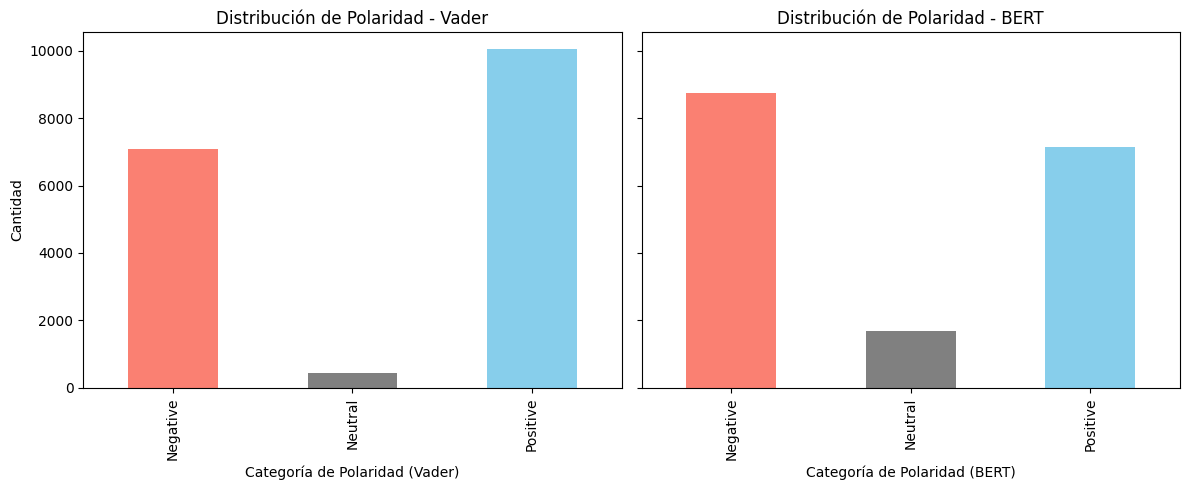

In [ ]:
 # Calcular la cantidad de reseñas por cada categoría para Vader y Bert
category_counts_vader = df_sentiments['vader_sentiment'].value_counts()
category_counts_bert = df_sentiments['bert_sentiment'].value_counts()

# Crear una tabla combinada para comparar las cantidades
category_counts = pd.DataFrame({
    'Vader Sentiment': category_counts_vader,
    'Bert Sentiment': category_counts_bert
}).fillna(0)

# Mostrar la tabla combinada
print("Tabla Comparativa de Categorías:")
print(category_counts)

print("_________________________________________________________________________________________\n")

# Definir colores consistentes para cada categoría
colors = {'Negative': 'salmon', 'Neutral': 'gray', 'Positive': 'skyblue'}

# Crear gráficos lado a lado para Vader y BERT
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Gráfico para Vader
df_sentiments['vader_sentiment'].value_counts().reindex(colors.keys()).plot(
     kind='bar', color=[colors[cat] for cat in colors.keys()], ax=axes[0]
)
axes[0].set_title('Distribución de Polaridad - Vader')
axes[0].set_xlabel('Categoría de Polaridad (Vader)')
axes[0].set_ylabel('Cantidad')

# Gráfico para BERT
df_sentiments['bert_sentiment'].value_counts().reindex(colors.keys()).plot(
    kind='bar', color=[colors[cat] for cat in colors.keys()], ax=axes[1]
)
axes[1].set_title('Distribución de Polaridad - BERT')
axes[1].set_xlabel('Categoría de Polaridad (BERT)')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [ ]:
# Identificar las filas donde las predicciones de Vader y Bert son diferentes
differences = df_sentiments[df_sentiments['vader_sentiment'] != df_sentiments['bert_sentiment']]

print("Número de diferencias:", len(differences))
differences[['customer_review', 'vader_sentiment', 'bert_sentiment']]

Número de diferencias: 4421


customer_review vader_sentiment  \
3       Newark to San Francisco. I am trying to retur...        Negative   
6       Dallas to Los Angeles. The whole process was ...        Positive   
8       San Francisco to Orlando. I could not believe...        Positive   
10      San Francisco to Dallas. Yesterday when I was...        Negative   
11      Los Angeles to Orlando. Not really worth the ...        Positive   
...                                                  ...             ...   
17525  Orlando to Cleveland. It was my first time fly...        Negative   
17528  San Antonio, TX to San Jose, Costa Rica. A vol...        Positive   
17531  I have been traveling business select with Sou...        Negative   
17537  I have been traveling business select with Sou...        Negative   
17561  Overall, I had a positive experience with Spir...        Negative   

      bert_sentiment  
3            Neutral  
6           Negative  
8           Negative  
10           Neutral  
11          Negative  
...              ...  
17525       Positive  
17528       Negative  
17531        Neutral  
17537        Neutral  
17561       Positive  

[4421 rows x 3 columns]

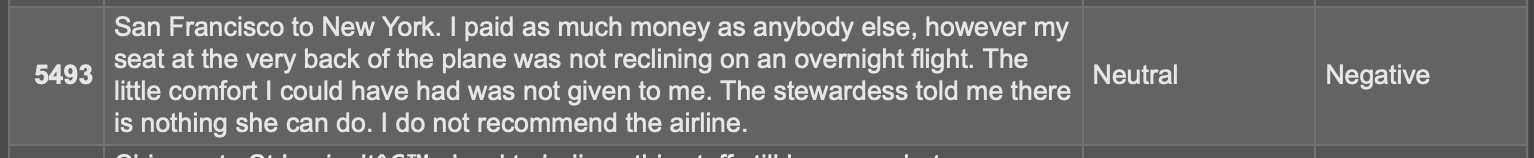



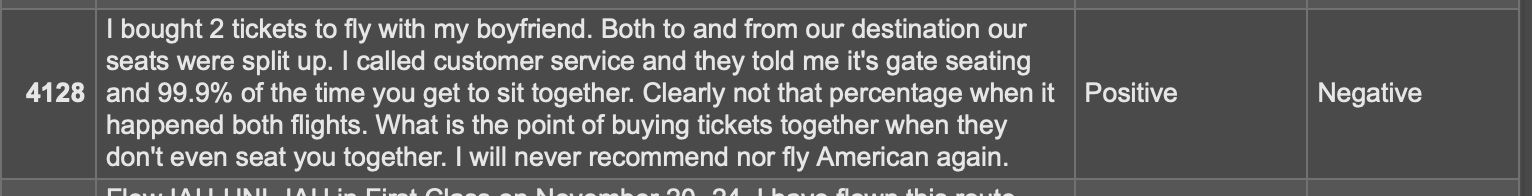

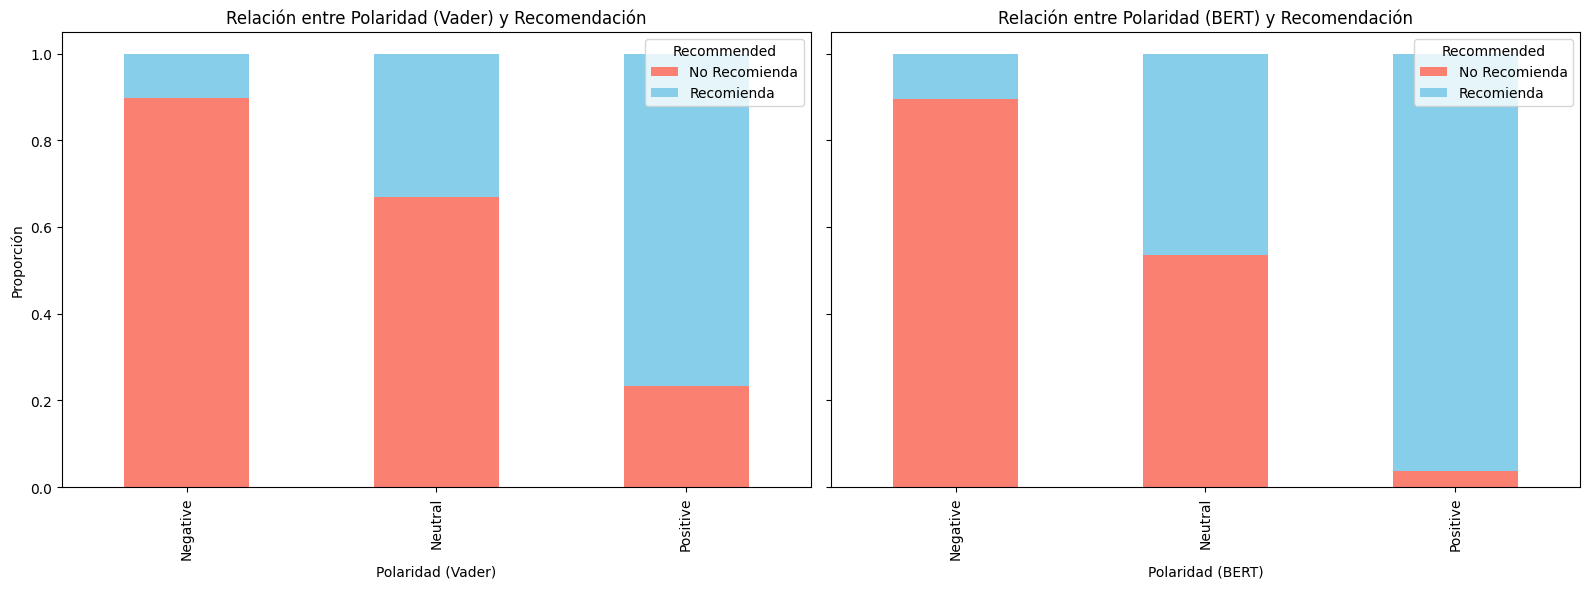

In [ ]:
# Crear gráficos lado a lado para la relación entre polaridad y recomendación
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Relación para Vader
relation_vader_recommended = pd.crosstab(
    df_sentiments['vader_sentiment'],
    df_sentiments['recommended'],
    normalize='index'
)
relation_vader_recommended.plot(kind='bar', stacked=True, ax=axes[0], color=['salmon', 'skyblue'])
axes[0].set_title('Relación entre Polaridad (Vader) y Recomendación')
axes[0].set_xlabel('Polaridad (Vader)')
axes[0].set_ylabel('Proporción')
axes[0].legend(['No Recomienda', 'Recomienda'], title='Recommended')

# Relación para BERT
relation_bert_recommended = pd.crosstab(
    df_sentiments['bert_sentiment'],
    df_sentiments['recommended'],
    normalize='index'
)
relation_bert_recommended.plot(kind='bar', stacked=True, ax=axes[1], color=['salmon', 'skyblue'])
axes[1].set_title('Relación entre Polaridad (BERT) y Recomendación')
axes[1].set_xlabel('Polaridad (BERT)')
axes[1].legend(['No Recomienda', 'Recomienda'], title='Recommended')

plt.tight_layout()
plt.show()

**Análisis de Polaridad y Recomendación**  

Basandonos en una muestra mayor, con 5000 datos, se puede observar patrones más robustos y representativos en la relación entre polaridad y recomendación del servicio. A diferencia del primer análisis, realizado con una muestra de 100 datos, este gráfico muestra una mayor consistencia en las proporciones, reduciendo el impacto de posibles sesgos estadísticos debido al tamaño reducido de la muestra inicial.  

En esta muestra ampliada, se observa una mejora en el modelo VADER, pero sigue teniendo mejores respuestas el modelo con BERT.  

Este análisis evidencia cómo un mayor tamaño de muestra refuerza la confiabilidad de los resultados y permite identificar tendencias con mayor precisión.

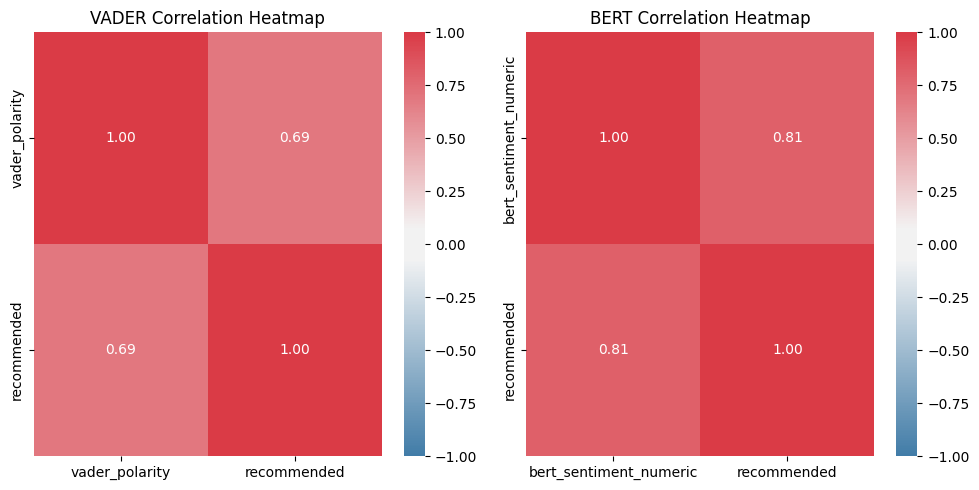

In [ ]:
# Convertir valores de 'bert_sentiment' a numéricos
df_sentiments['bert_sentiment_numeric'] = df_sentiments['bert_sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})

# Crear los dos heatmaps en una misma figura
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Heatmap de VADER
corr_values_vader = df_sentiments[['vader_polarity', 'recommended']].dropna(axis=0, how='any').corr()
sns.heatmap(corr_values_vader, annot=True, fmt=".2f", cmap=sns.diverging_palette(240, 10, sep=20, as_cmap=True),
            vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("VADER Correlation Heatmap")

# Heatmap de BERT
corr_values_bert = df_sentiments[['bert_sentiment_numeric', 'recommended']].dropna(axis=0, how='any').corr()
sns.heatmap(corr_values_bert, annot=True, fmt=".2f", cmap=sns.diverging_palette(240, 10, sep=20, as_cmap=True),
            vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("BERT Correlation Heatmap")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Se confirma la mejora de los dos modelos. mejoro mucho mas el modelo VADER que BERT

In [ ]:
df_sentiments.to_csv('df_sentiments_total.csv', index=False)

## ANALISIS DE TOPICOS

---



In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import textwrap

In [ ]:
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how's": "how is", "i'd": "i would", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it's": "it is", "let's": "let us",
    "she'd": "she would", "she'll": "she will", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "that's": "that is",
    "there's": "there is", "they'd": "they would", "they're": "they are",
    "they've": "they have", "wasn't": "was not", "we'd": "we would",
    "we're": "we are", "we've": "we have", "weren't": "were not",
    "what's": "what is", "where's": "where is", "who's": "who is",
    "won't": "will not", "wouldn't": "would not", "you'd": "you would",
    "you're": "you are", "you've": "you have"}

In [ ]:
#df_sentiments = pd.read_csv('/content/df_sentiments.csv')

In [ ]:
# Función para expandir contracciones
def expand_contractions(text, contractions):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in contractions.keys()) + r')\b')
    return pattern.sub(lambda x: contractions.get(x.group(0), x.group(0)), text)

# Preprocesamiento del texto
def preprocess_text(text, stop_words, contractions):
    text = expand_contractions(text, contractions)
    # Agregar el manejo del signo €™ y otros caracteres no alfabéticos
    text = re.sub(r'[^a-zA-Z\s€™]', '', text).lower()
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

# Crear matriz de términos
def create_term_matrix(data, max_df=0.95, min_df=2):
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
    term_matrix = vectorizer.fit_transform(data)
    return term_matrix, vectorizer

# Aplicar LDA y buscar mejores parámetros
def apply_lda(term_matrix, search_params, random_state=42):
    grid_search = GridSearchCV(LatentDirichletAllocation(random_state=random_state), param_grid=search_params, cv=3)
    grid_search.fit(term_matrix)
    return grid_search.best_estimator_, grid_search.best_params_['n_components']

# Mostrar tópicos con ejemplos y ajustar longitud de líneas
def display_topics_with_wrapped_examples(topics, examples, wrap_width=80):
    print("=" * 80)
    print("RESULTADOS DE ANÁLISIS DE TÓPICOS")
    print("=" * 80)
    for topic, words in topics.items():
        print(f"\n{topic}:")
        print(f"Palabras clave: {', '.join(words)}")
        example = examples.get(topic, 'No hay ejemplo disponible.')
        wrapped_example = "\n".join(textwrap.wrap(example, width=wrap_width))
        print(f"Ejemplo representativo:\n{wrapped_example}")
    print("=" * 80)

# Mostrar tópicos
def display_topics(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx + 1}"] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

# Calcular correlación entre tópicos y variables externas
def analyze_topic_correlation(df, lda_model, vectorizer):
    print("Analizando correlación entre tópicos y variables externas...")
    topic_matrix = lda_model.transform(vectorizer.transform(df['cleaned_review']))
    df_topics = pd.DataFrame(topic_matrix, columns=[f'Topic_{i+1}' for i in range(lda_model.n_components)])
    return pd.concat([df.reset_index(drop=True), df_topics], axis=1)

### ------------------    UNITED AIRLINES    ------------------

Se filtraran unicamente las filas con valores "Negative" y "Positive" de la columna bert_sentiment

In [ ]:
# Definir stopwords personalizadas
custom_stop_words = set(stopwords.words('english')).union({'flight', 'united', 'airline', 'plane', 'airlines', 'flights'})

# Aplicar preprocesamiento
print("Preprocesando texto...")
df_sentiments['cleaned_review'] = df_sentiments['customer_review'].apply(lambda x: preprocess_text(x, custom_stop_words, contractions))

# Filtrar reviews negativas y positivas
df_negative = df_sentiments[(df_sentiments['bert_sentiment'] == 'Negative') & (df_sentiments['airline'] == 'United Airlines')]
df_positive = df_sentiments[(df_sentiments['bert_sentiment'] == 'Positive') & (df_sentiments['airline'] == 'United Airlines')]

# Crear matrices de términos
print("Creando matriz de términos...")
term_matrix_negative, vectorizer_negative = create_term_matrix(df_negative['cleaned_review'])
term_matrix_positive, vectorizer_positive = create_term_matrix(df_positive['cleaned_review'])

# Parámetros de búsqueda para LDA
search_params = {'n_components': [2, 3, 5], 'learning_decay': [0.5, 0.7, 0.9]}

# Aplicar LDA a reviews negativas
if term_matrix_negative.shape[0] > 0:
    print("_" * 50)
    print("RESEÑAS NEGATIVAS")
    print("Aplicando LDA a reviews negativas...")
    best_lda_negative, n_topics_negative = apply_lda(term_matrix_negative, search_params)
    print(f"Mejor cantidad de tópicos para reviews negativas: {n_topics_negative}")
    print(display_topics)  # Comprobación para verificar si la función está definida
    topics_negative = display_topics(best_lda_negative, vectorizer_negative.get_feature_names_out(), 20)
    examples_negative = {f"Topic {i+1}": df_negative.iloc[np.argmax(best_lda_negative.transform(term_matrix_negative)[:, i])]['customer_review'] for i in range(n_topics_negative)}
    display_topics_with_wrapped_examples(topics_negative, examples_negative)
    df_negative_topics = analyze_topic_correlation(df_negative, best_lda_negative, vectorizer_negative)
else:
    print("No hay suficientes datos para análisis de tópicos en reviews negativas.")

# Aplicar LDA a reviews positivas
if term_matrix_positive.shape[0] > 0:
    print("_" * 50)
    print("RESEÑAS POSITIVAS")
    print("Aplicando LDA a reviews positivas...")
    best_lda_positive, n_topics_positive = apply_lda(term_matrix_positive, search_params)
    print(f"Mejor cantidad de tópicos para reviews positivas: {n_topics_positive}")
    topics_positive = display_topics(best_lda_positive, vectorizer_positive.get_feature_names_out(), 20)
    examples_positive = {f"Topic {i+1}": df_positive.iloc[np.argmax(best_lda_positive.transform(term_matrix_positive)[:, i])]['customer_review'] for i in range(n_topics_positive)}
    display_topics_with_wrapped_examples(topics_positive, examples_positive)
    df_positive_topics = analyze_topic_correlation(df_positive, best_lda_positive, vectorizer_positive)
else:
    print("No hay suficientes datos para análisis de tópicos en reviews positivas.")

Preprocesando texto...
Creando matriz de términos...
__________________________________________________
RESEÑAS NEGATIVAS
Aplicando LDA a reviews negativas...
Mejor cantidad de tópicos para reviews negativas: 2
<function display_topics at 0x7910d63c6ef0>
RESULTADOS DE ANÁLISIS DE TÓPICOS

Topic 1:
Palabras clave: hours, time, service, told, delayed, customer, airport, fly, hour, chicago, gate, got, day, newark, connecting, said, minutes, pm, luggage, cancelled
Ejemplo representativo:
 Never flying United Airlines again. I recently took a trip from North Dakota to
Brisbane and back. United managed to ruin over 60% of my flights. It started on
my 2nd flight on the way there. The aircraft was delayed for almost 3 hours and
did not take off until it should have been landing in San Francisco. Not only
that we as customers were given different reasons as to the delays. One said too
much rain for 1.5 hours of the delay and the other said too much wind for the
other 1.5 hour delay. Landed in S

Se ejemplifican los topicos con una reseña, ya que quizas las palabras no dicen mucho y falta contexto.

Se observa como en las reseñas positivas y negativas hay ciertos patrones, es decir para algunos pasajeros fue comodo y para otros no, es por ello, que es necesario observar mas en profundidad, en los distintos vuelos.

También puede pasar, que en un mismo vuelo, alguien tenga una buena experiencia y otro pasajero una mala experiencia. Es por esto, que se debe observar la repeticiencia, es decir, si en un mismo vuelo, se repite una critica, entonces es un factor a mejorar.

Nube de palabras

Generando nubes de palabras para tópicos negativos...


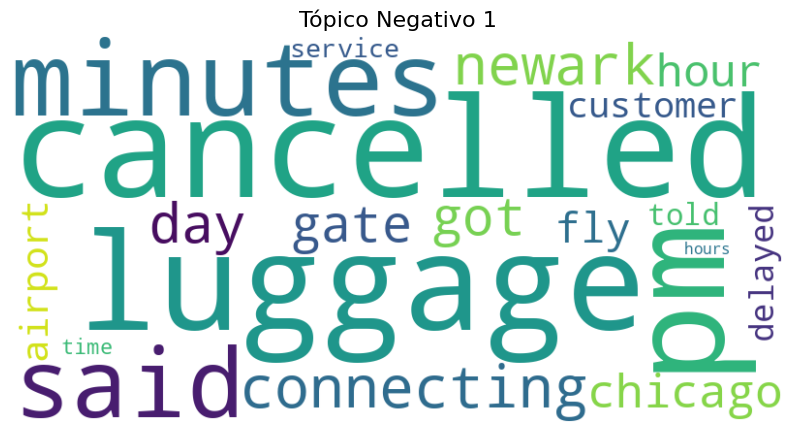

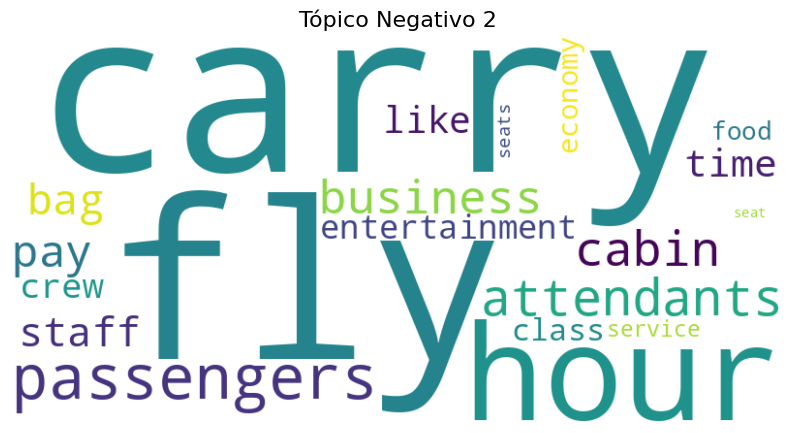

Generando nubes de palabras para tópicos positivos...


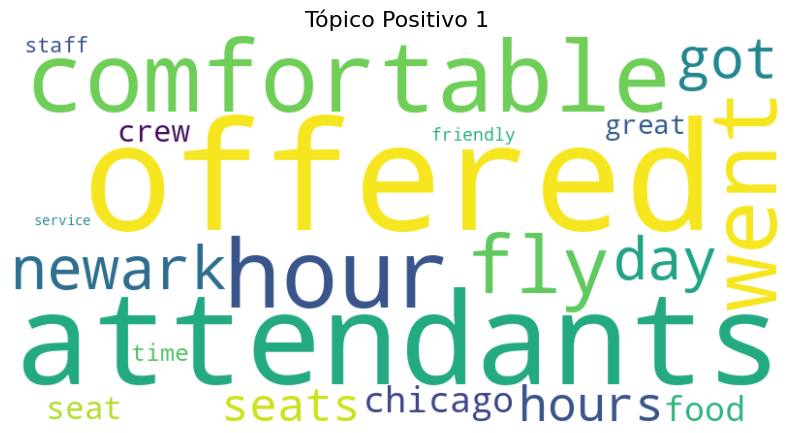

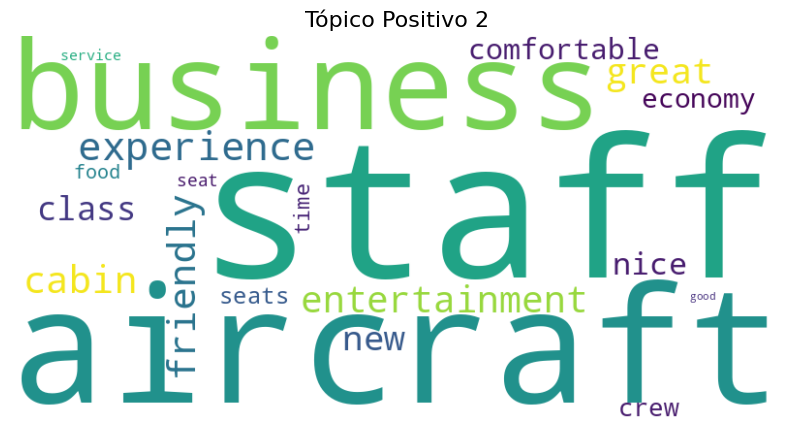

In [ ]:
def generate_word_clouds(topics, title_prefix="Tópico"):
    """
    Genera nubes de palabras para cada tópico.

    :param topics: Diccionario o lista con las palabras clave por tópico.
    :param title_prefix: Prefijo del título de las nubes de palabras.
    """
    if isinstance(topics, dict):
        topics = list(topics.values())  # Convertir a lista si es diccionario

    for i, topic_words in enumerate(topics):
        if isinstance(topic_words, str):  # Manejo si las palabras están en formato string
            topic_words = topic_words.split()  # Convertir string a lista
        elif not isinstance(topic_words, list):
            print(f"Formato inesperado en tópico {i + 1}: {topic_words}")
            continue

        # Crear el diccionario de frecuencia simulada
        word_freq = {word: freq for freq, word in enumerate(topic_words, 1)}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"{title_prefix} {i+1}", fontsize=16)
        plt.axis("off")
        plt.show()

# Nubes de palabras para tópicos negativos
if 'topics_negative' in locals() and len(topics_negative) > 0:
    print("Generando nubes de palabras para tópicos negativos...")
    generate_word_clouds(topics_negative, title_prefix="Tópico Negativo")

# Nubes de palabras para tópicos positivos
if 'topics_positive' in locals() and len(topics_positive) > 0:
    print("Generando nubes de palabras para tópicos positivos...")
    generate_word_clouds(topics_positive, title_prefix="Tópico Positivo")



### --------------------  COMPETENCIA  --------------------

**American Airlines y Delta Air Lines**

In [ ]:
# Definir stopwords personalizadas
custom_stop_words = set(stopwords.words('english')).union({'flight', 'united', 'airline', 'plane', 'airlines', 'flights',
                                                           'american', 'american airlines', 'americanair',
                                                           'delta', 'delta airlines', 'deltaair', "aa"})
# Aplicar preprocesamiento
print("Preprocesando texto...")
df_sentiments['cleaned_review'] = df_sentiments['customer_review'].apply(lambda x: preprocess_text(x, custom_stop_words, contractions))

# Filtrar reviews negativas y positivas por aerolínea
airlines = ['American Airlines', 'Delta Air Lines']
sentiments = ['Negative', 'Positive']

# Parámetros de búsqueda para LDA
search_params = {'n_components': [2, 3, 5], 'learning_decay': [0.5, 0.7, 0.9]}

for airline in airlines:
    for sentiment in sentiments:
        print("_" * 50)
        print(f"{sentiment.upper()} REVIEWS - {airline.upper()}")
        df_filtered = df_sentiments[(df_sentiments['bert_sentiment'] == sentiment) & (df_sentiments['airline'] == airline)]

        if not df_filtered.empty:
            print(f"Analizando {sentiment.lower()} reviews de {airline}...")
            term_matrix, vectorizer = create_term_matrix(df_filtered['cleaned_review'])

            if term_matrix.shape[0] > 0:
                best_lda, n_topics = apply_lda(term_matrix, search_params)
                print(f"Mejor cantidad de tópicos para {sentiment.lower()} reviews de {airline}: {n_topics}")
                topics = display_topics(best_lda, vectorizer.get_feature_names_out(), 20)
                examples = {f"Topic {i+1}": df_filtered.iloc[np.argmax(best_lda.transform(term_matrix)[:, i])]['customer_review'] for i in range(n_topics)}
                display_topics_with_wrapped_examples(topics, examples)
                df_topics = analyze_topic_correlation(df_filtered, best_lda, vectorizer)
            else:
                print(f"No hay suficientes datos para generar matriz de términos en {sentiment.lower()} reviews de {airline}.")
        else:
            print(f"No hay suficientes datos para análisis de tópicos en {sentiment.lower()} reviews de {airline}.")

Preprocesando texto...
__________________________________________________
NEGATIVE REVIEWS - AMERICAN AIRLINES
Analizando negative reviews de American Airlines...
Mejor cantidad de tópicos para negative reviews de American Airlines: 2
RESULTADOS DE ANÁLISIS DE TÓPICOS

Topic 1:
Palabras clave: time, hours, service, customer, told, delayed, gate, airport, fly, got, dallas, hour, day, minutes, said, connecting, experience, staff, people, pm
Ejemplo representativo:
 Salt Lake City to Lubbock via Dallas Ft Worth. In short, multiple occasions of
poor communication at the airport, cancelled flights with hit an miss support,
delayed bags after confirming they were on the flight, & rude employees during
and after trip. My problem isn't as much that bad things happened, but how many
and how the airline handled the situations. I even filled out the the survey
that American Airlines sent me. Due to my responses, I expected that I would
have been contacted by now (3 weeks later) with al least an e

Se observa un patrón: las principales críticas de las tres aerolíneas están relacionadas con malas experiencias debido a retrasos y deficiencias en la atención al cliente.

Es lógico que estos puntos sean los más recurrentes. Por ello, United debería enfocar su tiempo y recursos en mejorarlos para destacar. Esto incluye optimizar la logística para evitar retrasos o, en caso de ser inevitables, mejorar la comunicación y el trato hacia los clientes. Abordar estos factores podría generar una ventaja competitiva frente a las demás aerolíneas.

Generando nubes de palabras para negative reviews de American Airlines...


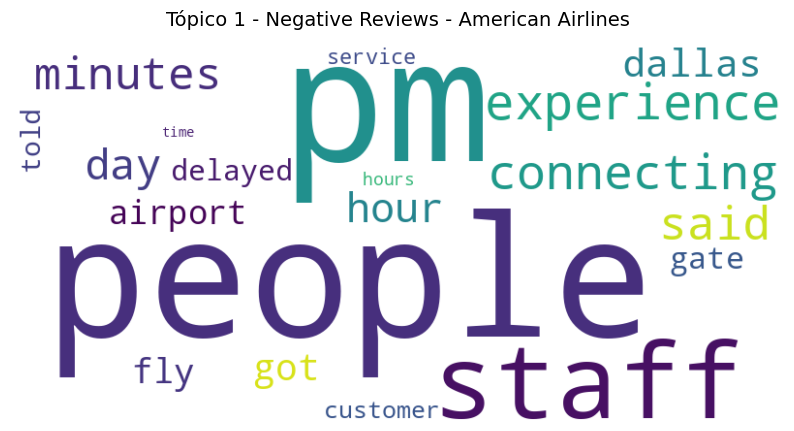

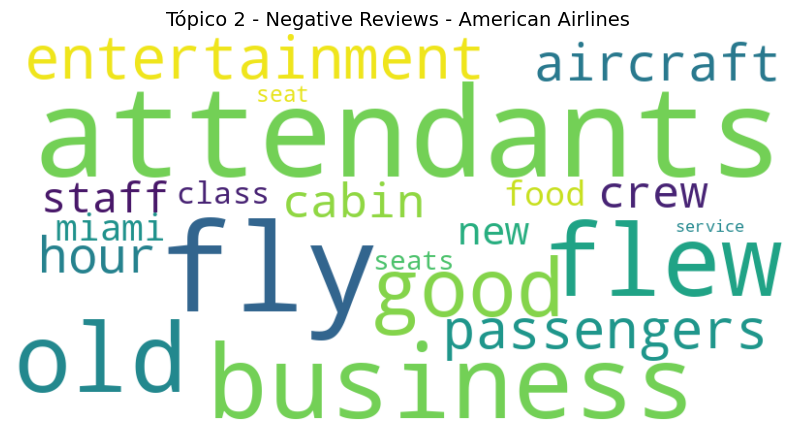

Generando nubes de palabras para positive reviews de American Airlines...


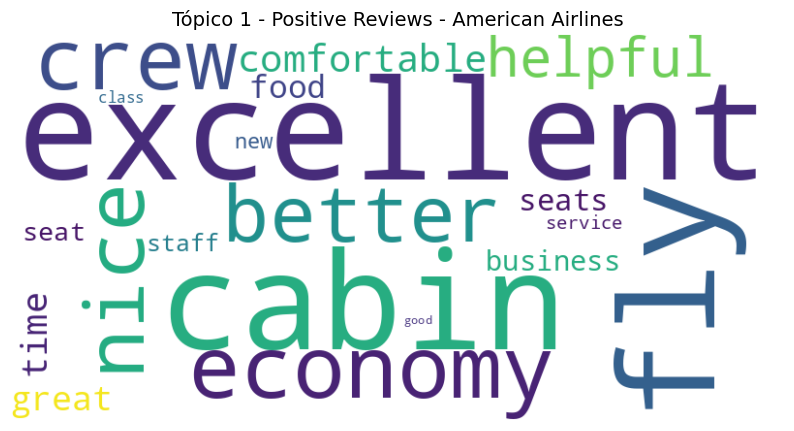

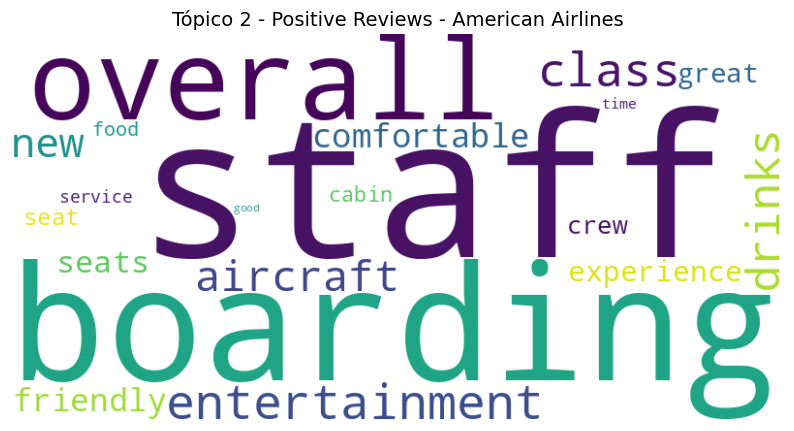

Generando nubes de palabras para negative reviews de Delta Air Lines...


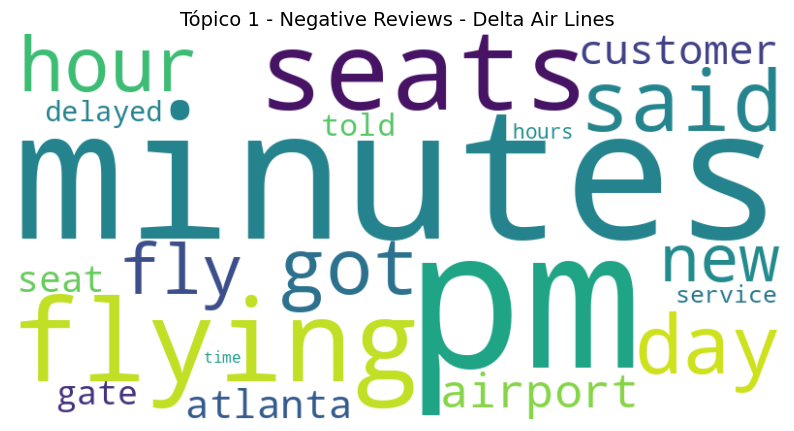

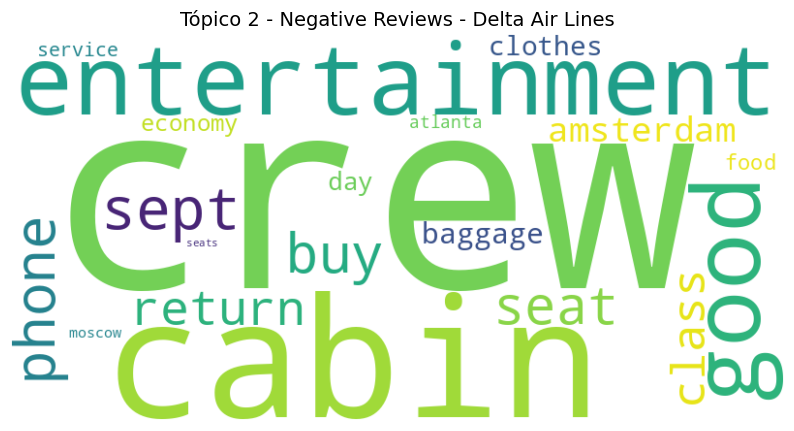

Generando nubes de palabras para positive reviews de Delta Air Lines...


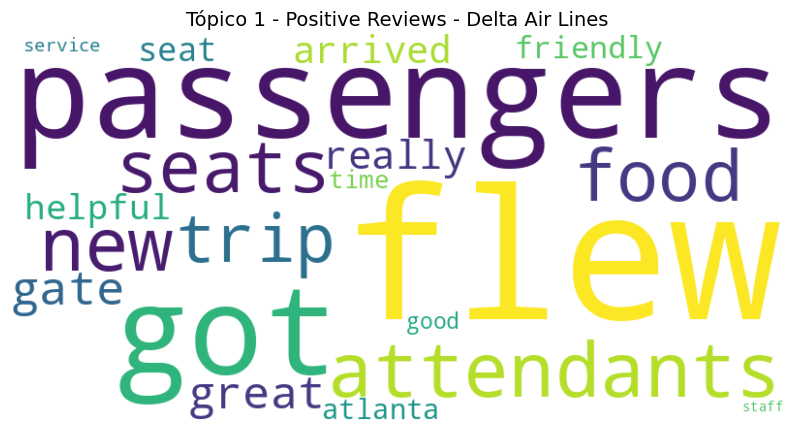

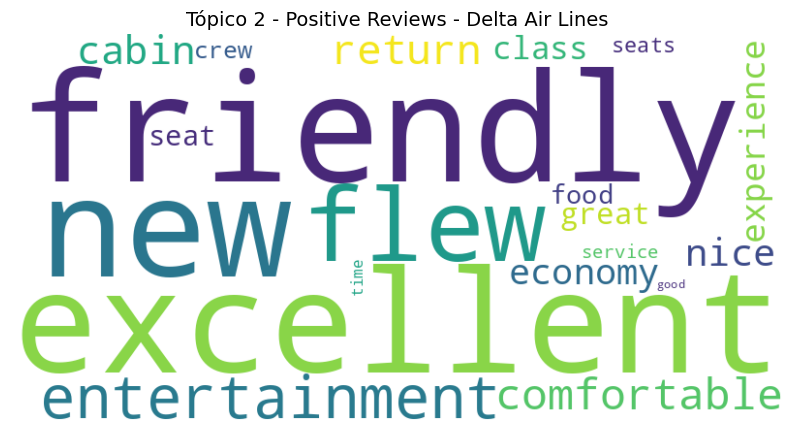

In [ ]:
def generate_word_clouds_per_airline(topics, n_topics, airline, sentiment, title_prefix="Tópico"):
    if isinstance(topics, dict):  # Si topics es un diccionario
        topics = [words for _, words in topics.items()]

    for i in range(n_topics):
        if i >= len(topics):
            print(f"No hay suficiente información para generar nube de palabras para el tópico {i+1}")
            continue

        topic_words = topics[i]
        word_freq = {word: freq for freq, word in enumerate(topic_words, 1)}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"{title_prefix} {i+1} - {sentiment.capitalize()} Reviews - {airline}", fontsize=14)
        plt.axis("off")
        plt.show()


# Generar nubes de palabras para cada aerolínea y sentimiento
for airline in airlines:
    for sentiment in sentiments:
        print(f"Generando nubes de palabras para {sentiment.lower()} reviews de {airline}...")

        df_filtered = df_sentiments[(df_sentiments['bert_sentiment'] == sentiment) & (df_sentiments['airline'] == airline)]

        if not df_filtered.empty:
            term_matrix, vectorizer = create_term_matrix(df_filtered['cleaned_review'])

            if term_matrix.shape[0] > 0:
                best_lda, n_topics = apply_lda(term_matrix, search_params)
                topics = display_topics(best_lda, vectorizer.get_feature_names_out(), 20)

                # Verificar la estructura de topics
                if isinstance(topics, list) or isinstance(topics, dict):
                    generate_word_clouds_per_airline(topics, n_topics, airline, sentiment, title_prefix="Tópico")
                else:
                    print("La estructura de tópicos no es compatible para generar nubes de palabras.")
            else:
                print(f"No hay suficientes datos para generar matriz de términos en {sentiment.lower()} reviews de {airline}.")
        else:
            print(f"No hay suficientes datos para análisis de tópicos en {sentiment.lower()} reviews de {airline}.")

### Conclusión

Se eligió el modelo de BERT debido a su mayor precisión para el análisis de texto y se complementó con un modelo LDA para identificar los tópicos más frecuentes en las reseñas.

En el caso de United Airlines, se identificaron dos tópicos principales. El primero está relacionado con retrasos, cancelaciones y un servicio al cliente deficiente. Ejemplos de comentarios reflejan frustración por esperas prolongadas, conexiones perdidas y la falta de apoyo por parte del personal: "El avión se retrasó por casi 3 horas, perdí mi conexión, y tuve que esperar 6 horas más para el próximo vuelo. Atención al cliente no fue útil en absoluto". El segundo tópico aborda la experiencia en cabina, destacando aspectos como asientos incómodos, comida insuficiente y la falta de entretenimiento: "Ocho horas de vuelo sin comidas gratis y sin pantallas de entretenimiento. El asiento era estrecho y el espacio limitado".

En cuanto a la competencia, se identificaron problemas similares. El primer tópico incluye comentarios sobre retrasos, cambios de puerta y cancelaciones, con especial énfasis en la desorganización y problemas con el equipaje: "Múltiples cambios de puerta y cancelaciones, con nula información clara. Mi equipaje terminó en otro destino". El segundo tópico se centra en la experiencia a bordo, incluyendo críticas sobre el servicio, la calidad de la comida y las distracciones innecesarias en el sistema de entretenimiento: "Las comidas eran mediocres y el sistema de entretenimiento estaba cargado de anuncios innecesarios".

Ambas aerolíneas comparten problemas comunes relacionados con retrasos, cancelaciones y la experiencia a bordo. Sin embargo, las críticas hacia United enfatizan una percepción más negativa respecto a su atención al cliente, lo que sugiere un área clave para mejorar y diferenciarse de la competencia.